##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Text classification with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/text_classification_rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This text classification tutorial trains a [recurrent neural network](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) on the [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis.

## Setup

In [2]:
!pip install -q tf-nightly
import tensorflow_datasets as tfds
import tensorflow as tf

ERROR: tensorflow 2.1.0 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.


Import `matplotlib` and create a helper function to plot graphs:

In [3]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets).


In [4]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,
                          as_supervised=True)
train_examples, test_examples = dataset['train'], dataset['test']

Shuffling and writing examples to /home/kbuilder/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete0XRENN/imdb_reviews-train.tfrecord


Shuffling and writing examples to /home/kbuilder/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete0XRENN/imdb_reviews-test.tfrecord


Shuffling and writing examples to /home/kbuilder/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete0XRENN/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /home/kbuilder/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


 The dataset `info` includes the encoder (a `tfds.features.text.SubwordTextEncoder`).

In [5]:
encoder = info.features['text'].encoder

In [6]:
print('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


This text encoder will reversibly encode any string, falling back to byte-encoding if necessary.

In [7]:
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print('The original string: "{}"'.format(original_string))

Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string: "Hello TensorFlow."


In [8]:
assert original_string == sample_string

In [9]:
for index in encoded_string:
  print('{} ----> {}'.format(index, encoder.decode([index])))

4025 ----> Hell
222 ----> o 
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


## Prepare the data for training

Next create batches of these encoded strings. Use the `padded_batch` method to zero-pad the sequences to the length of the longest string in the batch:

In [10]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [11]:
train_dataset = (train_examples
                 .shuffle(BUFFER_SIZE)
                 .padded_batch(BATCH_SIZE, padded_shapes=([None],[])))

test_dataset = (test_examples
                .padded_batch(BATCH_SIZE,  padded_shapes=([None],[])))

Note: As of **TensorFlow 2.2** the padded_shapes argument is no longer required. The default behavior is to pad all axes to the longest in the batch.

In [12]:
train_dataset = (train_examples
                 .shuffle(BUFFER_SIZE)
                 .padded_batch(BATCH_SIZE))

test_dataset = (test_examples
                .padded_batch(BATCH_SIZE))

## Create the model

Build a `tf.keras.Sequential` model and start with an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input—and then to the next.

The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the output. This helps the RNN to learn long range dependencies.

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Please note that we choose to Keras sequential model here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

Compile the Keras model to configure the training process:

In [14]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [15]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/10


  1/391 [..............................] - ETA: 0s - loss: 0.6938 - accuracy: 0.4844

  2/391 [..............................] - ETA: 21s - loss: 0.6933 - accuracy: 0.5078

  3/391 [..............................] - ETA: 29s - loss: 0.6934 - accuracy: 0.5052

  4/391 [..............................] - ETA: 31s - loss: 0.6932 - accuracy: 0.5273

  5/391 [..............................] - ETA: 32s - loss: 0.6931 - accuracy: 0.5250

  6/391 [..............................] - ETA: 34s - loss: 0.6929 - accuracy: 0.5312

  7/391 [..............................] - ETA: 35s - loss: 0.6927 - accuracy: 0.5357

  8/391 [..............................] - ETA: 36s - loss: 0.6929 - accuracy: 0.5273

  9/391 [..............................] - ETA: 35s - loss: 0.6931 - accuracy: 0.5174

 10/391 [..............................] - ETA: 35s - loss: 0.6930 - accuracy: 0.5156

 11/391 [..............................] - ETA: 35s - loss: 0.6931 - accuracy: 0.5114

 12/391 [..............................] - ETA: 39s - loss: 0.6930 - accuracy: 0.5130

 13/391 [..............................] - ETA: 38s - loss: 0.6931 - accuracy: 0.5096

 14/391 [>.............................] - ETA: 38s - loss: 0.6932 - accuracy: 0.5033

 15/391 [>.............................] - ETA: 38s - loss: 0.6931 - accuracy: 0.5104

 16/391 [>.............................] - ETA: 38s - loss: 0.6932 - accuracy: 0.5068

 17/391 [>.............................] - ETA: 38s - loss: 0.6932 - accuracy: 0.5064

 18/391 [>.............................] - ETA: 38s - loss: 0.6932 - accuracy: 0.5061

 19/391 [>.............................] - ETA: 38s - loss: 0.6932 - accuracy: 0.5099

 20/391 [>.............................] - ETA: 38s - loss: 0.6932 - accuracy: 0.5086

 21/391 [>.............................] - ETA: 38s - loss: 0.6931 - accuracy: 0.5112

 22/391 [>.............................] - ETA: 38s - loss: 0.6932 - accuracy: 0.5064

 23/391 [>.............................] - ETA: 37s - loss: 0.6933 - accuracy: 0.5034

 24/391 [>.............................] - ETA: 37s - loss: 0.6932 - accuracy: 0.5065

 25/391 [>.............................] - ETA: 37s - loss: 0.6933 - accuracy: 0.5031

 26/391 [>.............................] - ETA: 37s - loss: 0.6933 - accuracy: 0.5030

 27/391 [=>............................] - ETA: 37s - loss: 0.6932 - accuracy: 0.5046

 28/391 [=>............................] - ETA: 36s - loss: 0.6933 - accuracy: 0.5033

 29/391 [=>............................] - ETA: 36s - loss: 0.6933 - accuracy: 0.5016

 30/391 [=>............................] - ETA: 36s - loss: 0.6932 - accuracy: 0.5073

 31/391 [=>............................] - ETA: 35s - loss: 0.6932 - accuracy: 0.5035

 32/391 [=>............................] - ETA: 36s - loss: 0.6932 - accuracy: 0.5049

 33/391 [=>............................] - ETA: 35s - loss: 0.6932 - accuracy: 0.5047

 34/391 [=>............................] - ETA: 35s - loss: 0.6932 - accuracy: 0.5060

 35/391 [=>............................] - ETA: 35s - loss: 0.6931 - accuracy: 0.5080

 36/391 [=>............................] - ETA: 35s - loss: 0.6931 - accuracy: 0.5104

 37/391 [=>............................] - ETA: 35s - loss: 0.6930 - accuracy: 0.5127

 38/391 [=>............................] - ETA: 35s - loss: 0.6930 - accuracy: 0.5115

 39/391 [=>............................] - ETA: 34s - loss: 0.6930 - accuracy: 0.5104

 40/391 [==>...........................] - ETA: 34s - loss: 0.6931 - accuracy: 0.5078

 41/391 [==>...........................] - ETA: 34s - loss: 0.6932 - accuracy: 0.5046

 42/391 [==>...........................] - ETA: 34s - loss: 0.6932 - accuracy: 0.5022

 43/391 [==>...........................] - ETA: 34s - loss: 0.6932 - accuracy: 0.5015

 44/391 [==>...........................] - ETA: 34s - loss: 0.6932 - accuracy: 0.5032

 45/391 [==>...........................] - ETA: 33s - loss: 0.6932 - accuracy: 0.5021

 46/391 [==>...........................] - ETA: 33s - loss: 0.6932 - accuracy: 0.5027

 47/391 [==>...........................] - ETA: 33s - loss: 0.6932 - accuracy: 0.5013

 48/391 [==>...........................] - ETA: 33s - loss: 0.6932 - accuracy: 0.5023

 49/391 [==>...........................] - ETA: 33s - loss: 0.6932 - accuracy: 0.5016

 50/391 [==>...........................] - ETA: 33s - loss: 0.6932 - accuracy: 0.5028

 51/391 [==>...........................] - ETA: 33s - loss: 0.6931 - accuracy: 0.5040

 52/391 [==>...........................] - ETA: 32s - loss: 0.6931 - accuracy: 0.5039

 53/391 [===>..........................] - ETA: 32s - loss: 0.6932 - accuracy: 0.5032

 54/391 [===>..........................] - ETA: 32s - loss: 0.6931 - accuracy: 0.5043

 55/391 [===>..........................] - ETA: 32s - loss: 0.6931 - accuracy: 0.5043

 56/391 [===>..........................] - ETA: 32s - loss: 0.6931 - accuracy: 0.5064

 57/391 [===>..........................] - ETA: 31s - loss: 0.6931 - accuracy: 0.5060

 58/391 [===>..........................] - ETA: 31s - loss: 0.6930 - accuracy: 0.5089

 59/391 [===>..........................] - ETA: 31s - loss: 0.6930 - accuracy: 0.5090

 60/391 [===>..........................] - ETA: 31s - loss: 0.6930 - accuracy: 0.5091

 61/391 [===>..........................] - ETA: 31s - loss: 0.6930 - accuracy: 0.5090

 62/391 [===>..........................] - ETA: 31s - loss: 0.6930 - accuracy: 0.5091

 63/391 [===>..........................] - ETA: 31s - loss: 0.6930 - accuracy: 0.5097

 64/391 [===>..........................] - ETA: 31s - loss: 0.6930 - accuracy: 0.5081

 65/391 [===>..........................] - ETA: 31s - loss: 0.6931 - accuracy: 0.5070

 66/391 [====>.........................] - ETA: 31s - loss: 0.6931 - accuracy: 0.5066

 67/391 [====>.........................] - ETA: 31s - loss: 0.6930 - accuracy: 0.5075

 68/391 [====>.........................] - ETA: 31s - loss: 0.6931 - accuracy: 0.5064

 69/391 [====>.........................] - ETA: 31s - loss: 0.6931 - accuracy: 0.5045

 70/391 [====>.........................] - ETA: 30s - loss: 0.6931 - accuracy: 0.5042

 71/391 [====>.........................] - ETA: 30s - loss: 0.6931 - accuracy: 0.5046

 72/391 [====>.........................] - ETA: 30s - loss: 0.6931 - accuracy: 0.5043

 73/391 [====>.........................] - ETA: 30s - loss: 0.6931 - accuracy: 0.5045

 74/391 [====>.........................] - ETA: 30s - loss: 0.6931 - accuracy: 0.5042

 75/391 [====>.........................] - ETA: 30s - loss: 0.6931 - accuracy: 0.5054

 76/391 [====>.........................] - ETA: 30s - loss: 0.6930 - accuracy: 0.5076

 77/391 [====>.........................] - ETA: 30s - loss: 0.6930 - accuracy: 0.5065

 78/391 [====>.........................] - ETA: 30s - loss: 0.6930 - accuracy: 0.5062

 79/391 [=====>........................] - ETA: 30s - loss: 0.6931 - accuracy: 0.5045

 80/391 [=====>........................] - ETA: 29s - loss: 0.6931 - accuracy: 0.5037

 81/391 [=====>........................] - ETA: 29s - loss: 0.6931 - accuracy: 0.5027

 82/391 [=====>........................] - ETA: 29s - loss: 0.6931 - accuracy: 0.5030

 83/391 [=====>........................] - ETA: 29s - loss: 0.6931 - accuracy: 0.5021

 84/391 [=====>........................] - ETA: 29s - loss: 0.6932 - accuracy: 0.5020

 85/391 [=====>........................] - ETA: 29s - loss: 0.6931 - accuracy: 0.5029

 86/391 [=====>........................] - ETA: 29s - loss: 0.6931 - accuracy: 0.5027

 87/391 [=====>........................] - ETA: 29s - loss: 0.6931 - accuracy: 0.5031

 88/391 [=====>........................] - ETA: 29s - loss: 0.6931 - accuracy: 0.5034

 89/391 [=====>........................] - ETA: 29s - loss: 0.6931 - accuracy: 0.5019

 90/391 [=====>........................] - ETA: 28s - loss: 0.6931 - accuracy: 0.5021

 91/391 [=====>........................] - ETA: 28s - loss: 0.6931 - accuracy: 0.5017

 92/391 [======>.......................] - ETA: 28s - loss: 0.6932 - accuracy: 0.5014

 93/391 [======>.......................] - ETA: 28s - loss: 0.6931 - accuracy: 0.5022

 94/391 [======>.......................] - ETA: 28s - loss: 0.6931 - accuracy: 0.5010

 95/391 [======>.......................] - ETA: 28s - loss: 0.6931 - accuracy: 0.5007

 96/391 [======>.......................] - ETA: 28s - loss: 0.6931 - accuracy: 0.4998

 97/391 [======>.......................] - ETA: 28s - loss: 0.6931 - accuracy: 0.5000

 98/391 [======>.......................] - ETA: 28s - loss: 0.6931 - accuracy: 0.5002

 99/391 [======>.......................] - ETA: 27s - loss: 0.6931 - accuracy: 0.4998

100/391 [======>.......................] - ETA: 27s - loss: 0.6931 - accuracy: 0.5002

101/391 [======>.......................] - ETA: 27s - loss: 0.6931 - accuracy: 0.4991

102/391 [======>.......................] - ETA: 27s - loss: 0.6931 - accuracy: 0.4989

103/391 [======>.......................] - ETA: 27s - loss: 0.6931 - accuracy: 0.4982

104/391 [======>.......................] - ETA: 27s - loss: 0.6931 - accuracy: 0.4976

105/391 [=======>......................] - ETA: 27s - loss: 0.6931 - accuracy: 0.4982

106/391 [=======>......................] - ETA: 27s - loss: 0.6931 - accuracy: 0.4978

107/391 [=======>......................] - ETA: 27s - loss: 0.6931 - accuracy: 0.4963

108/391 [=======>......................] - ETA: 27s - loss: 0.6931 - accuracy: 0.4961

109/391 [=======>......................] - ETA: 27s - loss: 0.6931 - accuracy: 0.4958

110/391 [=======>......................] - ETA: 26s - loss: 0.6931 - accuracy: 0.4959

111/391 [=======>......................] - ETA: 26s - loss: 0.6931 - accuracy: 0.4970

112/391 [=======>......................] - ETA: 26s - loss: 0.6930 - accuracy: 0.4961

113/391 [=======>......................] - ETA: 26s - loss: 0.6931 - accuracy: 0.4963

114/391 [=======>......................] - ETA: 26s - loss: 0.6930 - accuracy: 0.4955

115/391 [=======>......................] - ETA: 26s - loss: 0.6930 - accuracy: 0.4959

116/391 [=======>......................] - ETA: 26s - loss: 0.6931 - accuracy: 0.4966

117/391 [=======>......................] - ETA: 26s - loss: 0.6931 - accuracy: 0.4972

118/391 [========>.....................] - ETA: 26s - loss: 0.6931 - accuracy: 0.4972

119/391 [========>.....................] - ETA: 26s - loss: 0.6931 - accuracy: 0.4978

120/391 [========>.....................] - ETA: 25s - loss: 0.6931 - accuracy: 0.4974

121/391 [========>.....................] - ETA: 25s - loss: 0.6930 - accuracy: 0.4965

122/391 [========>.....................] - ETA: 25s - loss: 0.6930 - accuracy: 0.4964

123/391 [========>.....................] - ETA: 25s - loss: 0.6930 - accuracy: 0.4967

124/391 [========>.....................] - ETA: 25s - loss: 0.6930 - accuracy: 0.4972

125/391 [========>.....................] - ETA: 25s - loss: 0.6930 - accuracy: 0.4966

126/391 [========>.....................] - ETA: 25s - loss: 0.6930 - accuracy: 0.4967

127/391 [========>.....................] - ETA: 25s - loss: 0.6930 - accuracy: 0.4967

128/391 [========>.....................] - ETA: 25s - loss: 0.6930 - accuracy: 0.4977

129/391 [========>.....................] - ETA: 25s - loss: 0.6930 - accuracy: 0.4981

130/391 [========>.....................] - ETA: 25s - loss: 0.6930 - accuracy: 0.4987

131/391 [=========>....................] - ETA: 25s - loss: 0.6930 - accuracy: 0.4994

132/391 [=========>....................] - ETA: 25s - loss: 0.6930 - accuracy: 0.4983

133/391 [=========>....................] - ETA: 24s - loss: 0.6930 - accuracy: 0.4989

134/391 [=========>....................] - ETA: 24s - loss: 0.6930 - accuracy: 0.4997

135/391 [=========>....................] - ETA: 24s - loss: 0.6930 - accuracy: 0.4999

136/391 [=========>....................] - ETA: 24s - loss: 0.6930 - accuracy: 0.5002

137/391 [=========>....................] - ETA: 24s - loss: 0.6930 - accuracy: 0.5005

138/391 [=========>....................] - ETA: 24s - loss: 0.6930 - accuracy: 0.5006

139/391 [=========>....................] - ETA: 24s - loss: 0.6930 - accuracy: 0.5015

140/391 [=========>....................] - ETA: 24s - loss: 0.6930 - accuracy: 0.5004

141/391 [=========>....................] - ETA: 24s - loss: 0.6930 - accuracy: 0.4996

142/391 [=========>....................] - ETA: 24s - loss: 0.6930 - accuracy: 0.5004

143/391 [=========>....................] - ETA: 24s - loss: 0.6930 - accuracy: 0.5005

144/391 [==========>...................] - ETA: 23s - loss: 0.6930 - accuracy: 0.5007

145/391 [==========>...................] - ETA: 23s - loss: 0.6930 - accuracy: 0.5008

146/391 [==========>...................] - ETA: 23s - loss: 0.6930 - accuracy: 0.5015

147/391 [==========>...................] - ETA: 23s - loss: 0.6930 - accuracy: 0.5014

148/391 [==========>...................] - ETA: 23s - loss: 0.6930 - accuracy: 0.5014

149/391 [==========>...................] - ETA: 23s - loss: 0.6930 - accuracy: 0.5015

150/391 [==========>...................] - ETA: 23s - loss: 0.6930 - accuracy: 0.5013

151/391 [==========>...................] - ETA: 23s - loss: 0.6930 - accuracy: 0.5017

152/391 [==========>...................] - ETA: 23s - loss: 0.6930 - accuracy: 0.5015

153/391 [==========>...................] - ETA: 23s - loss: 0.6930 - accuracy: 0.5020

154/391 [==========>...................] - ETA: 23s - loss: 0.6930 - accuracy: 0.5019

155/391 [==========>...................] - ETA: 22s - loss: 0.6930 - accuracy: 0.5013

156/391 [==========>...................] - ETA: 22s - loss: 0.6930 - accuracy: 0.5015

157/391 [===========>..................] - ETA: 22s - loss: 0.6930 - accuracy: 0.5016

158/391 [===========>..................] - ETA: 22s - loss: 0.6930 - accuracy: 0.5020

159/391 [===========>..................] - ETA: 22s - loss: 0.6930 - accuracy: 0.5009

160/391 [===========>..................] - ETA: 22s - loss: 0.6930 - accuracy: 0.5008

161/391 [===========>..................] - ETA: 22s - loss: 0.6930 - accuracy: 0.5010

162/391 [===========>..................] - ETA: 22s - loss: 0.6930 - accuracy: 0.5009

163/391 [===========>..................] - ETA: 22s - loss: 0.6930 - accuracy: 0.5008

164/391 [===========>..................] - ETA: 22s - loss: 0.6929 - accuracy: 0.5010

165/391 [===========>..................] - ETA: 21s - loss: 0.6929 - accuracy: 0.5011

166/391 [===========>..................] - ETA: 21s - loss: 0.6929 - accuracy: 0.5015

167/391 [===========>..................] - ETA: 21s - loss: 0.6929 - accuracy: 0.5010

168/391 [===========>..................] - ETA: 21s - loss: 0.6929 - accuracy: 0.5011

169/391 [===========>..................] - ETA: 21s - loss: 0.6929 - accuracy: 0.5006

170/391 [============>.................] - ETA: 21s - loss: 0.6929 - accuracy: 0.5006

171/391 [============>.................] - ETA: 21s - loss: 0.6929 - accuracy: 0.5008

172/391 [============>.................] - ETA: 21s - loss: 0.6929 - accuracy: 0.5006

173/391 [============>.................] - ETA: 21s - loss: 0.6929 - accuracy: 0.5008

174/391 [============>.................] - ETA: 21s - loss: 0.6929 - accuracy: 0.5003

175/391 [============>.................] - ETA: 21s - loss: 0.6929 - accuracy: 0.5002

176/391 [============>.................] - ETA: 20s - loss: 0.6929 - accuracy: 0.5003

177/391 [============>.................] - ETA: 20s - loss: 0.6929 - accuracy: 0.5002

178/391 [============>.................] - ETA: 20s - loss: 0.6929 - accuracy: 0.5002

179/391 [============>.................] - ETA: 20s - loss: 0.6929 - accuracy: 0.4997

180/391 [============>.................] - ETA: 20s - loss: 0.6929 - accuracy: 0.4991

181/391 [============>.................] - ETA: 20s - loss: 0.6929 - accuracy: 0.4991

182/391 [============>.................] - ETA: 20s - loss: 0.6929 - accuracy: 0.4988

183/391 [=============>................] - ETA: 20s - loss: 0.6929 - accuracy: 0.4985

184/391 [=============>................] - ETA: 20s - loss: 0.6929 - accuracy: 0.4986

185/391 [=============>................] - ETA: 20s - loss: 0.6929 - accuracy: 0.4985

186/391 [=============>................] - ETA: 20s - loss: 0.6929 - accuracy: 0.4983

187/391 [=============>................] - ETA: 19s - loss: 0.6929 - accuracy: 0.4989

188/391 [=============>................] - ETA: 19s - loss: 0.6929 - accuracy: 0.4993

189/391 [=============>................] - ETA: 19s - loss: 0.6929 - accuracy: 0.4996

190/391 [=============>................] - ETA: 19s - loss: 0.6929 - accuracy: 0.4997

191/391 [=============>................] - ETA: 19s - loss: 0.6929 - accuracy: 0.4998

192/391 [=============>................] - ETA: 19s - loss: 0.6928 - accuracy: 0.4999

193/391 [=============>................] - ETA: 19s - loss: 0.6928 - accuracy: 0.4996

194/391 [=============>................] - ETA: 19s - loss: 0.6928 - accuracy: 0.4990

195/391 [=============>................] - ETA: 19s - loss: 0.6928 - accuracy: 0.4991

196/391 [==============>...............] - ETA: 19s - loss: 0.6928 - accuracy: 0.4992

197/391 [==============>...............] - ETA: 18s - loss: 0.6928 - accuracy: 0.4994

198/391 [==============>...............] - ETA: 18s - loss: 0.6928 - accuracy: 0.4993

199/391 [==============>...............] - ETA: 18s - loss: 0.6928 - accuracy: 0.4995

200/391 [==============>...............] - ETA: 18s - loss: 0.6928 - accuracy: 0.4998

201/391 [==============>...............] - ETA: 18s - loss: 0.6928 - accuracy: 0.4996

202/391 [==============>...............] - ETA: 18s - loss: 0.6928 - accuracy: 0.4995

203/391 [==============>...............] - ETA: 18s - loss: 0.6928 - accuracy: 0.4998

204/391 [==============>...............] - ETA: 18s - loss: 0.6927 - accuracy: 0.4996

205/391 [==============>...............] - ETA: 18s - loss: 0.6927 - accuracy: 0.4998

206/391 [==============>...............] - ETA: 18s - loss: 0.6927 - accuracy: 0.5005

207/391 [==============>...............] - ETA: 18s - loss: 0.6927 - accuracy: 0.5005

208/391 [==============>...............] - ETA: 17s - loss: 0.6927 - accuracy: 0.5002

209/391 [===============>..............] - ETA: 17s - loss: 0.6927 - accuracy: 0.5007

210/391 [===============>..............] - ETA: 17s - loss: 0.6927 - accuracy: 0.5010

211/391 [===============>..............] - ETA: 17s - loss: 0.6927 - accuracy: 0.5011

212/391 [===============>..............] - ETA: 17s - loss: 0.6927 - accuracy: 0.5008

213/391 [===============>..............] - ETA: 17s - loss: 0.6927 - accuracy: 0.5005

214/391 [===============>..............] - ETA: 17s - loss: 0.6927 - accuracy: 0.5007

215/391 [===============>..............] - ETA: 17s - loss: 0.6927 - accuracy: 0.5011

216/391 [===============>..............] - ETA: 17s - loss: 0.6927 - accuracy: 0.5012

217/391 [===============>..............] - ETA: 17s - loss: 0.6927 - accuracy: 0.5011

218/391 [===============>..............] - ETA: 17s - loss: 0.6927 - accuracy: 0.5014

219/391 [===============>..............] - ETA: 16s - loss: 0.6926 - accuracy: 0.5019

220/391 [===============>..............] - ETA: 16s - loss: 0.6926 - accuracy: 0.5023

221/391 [===============>..............] - ETA: 16s - loss: 0.6926 - accuracy: 0.5023

222/391 [================>.............] - ETA: 16s - loss: 0.6926 - accuracy: 0.5023

223/391 [================>.............] - ETA: 16s - loss: 0.6926 - accuracy: 0.5020

224/391 [================>.............] - ETA: 16s - loss: 0.6926 - accuracy: 0.5019

225/391 [================>.............] - ETA: 16s - loss: 0.6926 - accuracy: 0.5011

226/391 [================>.............] - ETA: 16s - loss: 0.6926 - accuracy: 0.5008

227/391 [================>.............] - ETA: 16s - loss: 0.6926 - accuracy: 0.5003

228/391 [================>.............] - ETA: 16s - loss: 0.6926 - accuracy: 0.5005

229/391 [================>.............] - ETA: 16s - loss: 0.6926 - accuracy: 0.5005

230/391 [================>.............] - ETA: 15s - loss: 0.6926 - accuracy: 0.5007

231/391 [================>.............] - ETA: 15s - loss: 0.6926 - accuracy: 0.5004

232/391 [================>.............] - ETA: 15s - loss: 0.6926 - accuracy: 0.5003

233/391 [================>.............] - ETA: 15s - loss: 0.6926 - accuracy: 0.5006

234/391 [================>.............] - ETA: 15s - loss: 0.6926 - accuracy: 0.5005

235/391 [=================>............] - ETA: 15s - loss: 0.6925 - accuracy: 0.5006

236/391 [=================>............] - ETA: 15s - loss: 0.6925 - accuracy: 0.5007

237/391 [=================>............] - ETA: 15s - loss: 0.6925 - accuracy: 0.5006

238/391 [=================>............] - ETA: 15s - loss: 0.6925 - accuracy: 0.5003

239/391 [=================>............] - ETA: 14s - loss: 0.6925 - accuracy: 0.5005

240/391 [=================>............] - ETA: 14s - loss: 0.6925 - accuracy: 0.5006

241/391 [=================>............] - ETA: 14s - loss: 0.6925 - accuracy: 0.5007

242/391 [=================>............] - ETA: 14s - loss: 0.6925 - accuracy: 0.5006

243/391 [=================>............] - ETA: 14s - loss: 0.6924 - accuracy: 0.5007

244/391 [=================>............] - ETA: 14s - loss: 0.6924 - accuracy: 0.5007

245/391 [=================>............] - ETA: 14s - loss: 0.6924 - accuracy: 0.5008

246/391 [=================>............] - ETA: 14s - loss: 0.6924 - accuracy: 0.5011

247/391 [=================>............] - ETA: 14s - loss: 0.6924 - accuracy: 0.5006

248/391 [==================>...........] - ETA: 14s - loss: 0.6924 - accuracy: 0.5011

249/391 [==================>...........] - ETA: 13s - loss: 0.6924 - accuracy: 0.5014

250/391 [==================>...........] - ETA: 13s - loss: 0.6924 - accuracy: 0.5014

251/391 [==================>...........] - ETA: 13s - loss: 0.6924 - accuracy: 0.5012

252/391 [==================>...........] - ETA: 13s - loss: 0.6923 - accuracy: 0.5018

253/391 [==================>...........] - ETA: 13s - loss: 0.6923 - accuracy: 0.5022

254/391 [==================>...........] - ETA: 13s - loss: 0.6923 - accuracy: 0.5018

255/391 [==================>...........] - ETA: 13s - loss: 0.6923 - accuracy: 0.5018

256/391 [==================>...........] - ETA: 13s - loss: 0.6923 - accuracy: 0.5021

257/391 [==================>...........] - ETA: 13s - loss: 0.6922 - accuracy: 0.5023

258/391 [==================>...........] - ETA: 13s - loss: 0.6922 - accuracy: 0.5025

259/391 [==================>...........] - ETA: 12s - loss: 0.6922 - accuracy: 0.5028

260/391 [==================>...........] - ETA: 12s - loss: 0.6922 - accuracy: 0.5025

261/391 [===================>..........] - ETA: 12s - loss: 0.6922 - accuracy: 0.5020

262/391 [===================>..........] - ETA: 12s - loss: 0.6922 - accuracy: 0.5023

263/391 [===================>..........] - ETA: 12s - loss: 0.6921 - accuracy: 0.5022

264/391 [===================>..........] - ETA: 12s - loss: 0.6921 - accuracy: 0.5020

265/391 [===================>..........] - ETA: 12s - loss: 0.6921 - accuracy: 0.5022

266/391 [===================>..........] - ETA: 12s - loss: 0.6921 - accuracy: 0.5019

267/391 [===================>..........] - ETA: 12s - loss: 0.6921 - accuracy: 0.5017

268/391 [===================>..........] - ETA: 12s - loss: 0.6920 - accuracy: 0.5016

269/391 [===================>..........] - ETA: 11s - loss: 0.6920 - accuracy: 0.5020

270/391 [===================>..........] - ETA: 11s - loss: 0.6920 - accuracy: 0.5018

271/391 [===================>..........] - ETA: 11s - loss: 0.6919 - accuracy: 0.5018

272/391 [===================>..........] - ETA: 11s - loss: 0.6919 - accuracy: 0.5020

273/391 [===================>..........] - ETA: 11s - loss: 0.6918 - accuracy: 0.5022

274/391 [====================>.........] - ETA: 11s - loss: 0.6918 - accuracy: 0.5026

275/391 [====================>.........] - ETA: 11s - loss: 0.6917 - accuracy: 0.5023

276/391 [====================>.........] - ETA: 11s - loss: 0.6917 - accuracy: 0.5023

277/391 [====================>.........] - ETA: 11s - loss: 0.6916 - accuracy: 0.5021

278/391 [====================>.........] - ETA: 11s - loss: 0.6915 - accuracy: 0.5019

279/391 [====================>.........] - ETA: 11s - loss: 0.6914 - accuracy: 0.5015

280/391 [====================>.........] - ETA: 10s - loss: 0.6913 - accuracy: 0.5016

281/391 [====================>.........] - ETA: 10s - loss: 0.6915 - accuracy: 0.5014

282/391 [====================>.........] - ETA: 10s - loss: 0.6915 - accuracy: 0.5014

283/391 [====================>.........] - ETA: 10s - loss: 0.6913 - accuracy: 0.5014

284/391 [====================>.........] - ETA: 10s - loss: 0.6912 - accuracy: 0.5014

285/391 [====================>.........] - ETA: 10s - loss: 0.6911 - accuracy: 0.5014

286/391 [====================>.........] - ETA: 10s - loss: 0.6910 - accuracy: 0.5019

287/391 [=====================>........] - ETA: 10s - loss: 0.6908 - accuracy: 0.5016

288/391 [=====================>........] - ETA: 10s - loss: 0.6908 - accuracy: 0.5020

289/391 [=====================>........] - ETA: 10s - loss: 0.6907 - accuracy: 0.5022

290/391 [=====================>........] - ETA: 9s - loss: 0.6906 - accuracy: 0.5023 

291/391 [=====================>........] - ETA: 9s - loss: 0.6906 - accuracy: 0.5023

292/391 [=====================>........] - ETA: 9s - loss: 0.6904 - accuracy: 0.5021

293/391 [=====================>........] - ETA: 9s - loss: 0.6903 - accuracy: 0.5021

294/391 [=====================>........] - ETA: 9s - loss: 0.6902 - accuracy: 0.5021

295/391 [=====================>........] - ETA: 9s - loss: 0.6901 - accuracy: 0.5017

296/391 [=====================>........] - ETA: 9s - loss: 0.6900 - accuracy: 0.5015

297/391 [=====================>........] - ETA: 9s - loss: 0.6899 - accuracy: 0.5013

298/391 [=====================>........] - ETA: 9s - loss: 0.6897 - accuracy: 0.5014

299/391 [=====================>........] - ETA: 9s - loss: 0.6896 - accuracy: 0.5014

300/391 [======================>.......] - ETA: 8s - loss: 0.6894 - accuracy: 0.5016

301/391 [======================>.......] - ETA: 8s - loss: 0.6892 - accuracy: 0.5019

302/391 [======================>.......] - ETA: 8s - loss: 0.6891 - accuracy: 0.5019

303/391 [======================>.......] - ETA: 8s - loss: 0.6889 - accuracy: 0.5021

304/391 [======================>.......] - ETA: 8s - loss: 0.6886 - accuracy: 0.5022

305/391 [======================>.......] - ETA: 8s - loss: 0.6882 - accuracy: 0.5028

306/391 [======================>.......] - ETA: 8s - loss: 0.6881 - accuracy: 0.5031

307/391 [======================>.......] - ETA: 8s - loss: 0.6879 - accuracy: 0.5040

308/391 [======================>.......] - ETA: 8s - loss: 0.6876 - accuracy: 0.5049

309/391 [======================>.......] - ETA: 8s - loss: 0.6874 - accuracy: 0.5048

310/391 [======================>.......] - ETA: 7s - loss: 0.6873 - accuracy: 0.5049

311/391 [======================>.......] - ETA: 7s - loss: 0.6871 - accuracy: 0.5050

312/391 [======================>.......] - ETA: 7s - loss: 0.6868 - accuracy: 0.5054

313/391 [=======================>......] - ETA: 7s - loss: 0.6866 - accuracy: 0.5053

314/391 [=======================>......] - ETA: 7s - loss: 0.6863 - accuracy: 0.5054

315/391 [=======================>......] - ETA: 7s - loss: 0.6862 - accuracy: 0.5052

316/391 [=======================>......] - ETA: 7s - loss: 0.6860 - accuracy: 0.5052

317/391 [=======================>......] - ETA: 7s - loss: 0.6858 - accuracy: 0.5056

318/391 [=======================>......] - ETA: 7s - loss: 0.6856 - accuracy: 0.5063

319/391 [=======================>......] - ETA: 7s - loss: 0.6853 - accuracy: 0.5069

320/391 [=======================>......] - ETA: 6s - loss: 0.6850 - accuracy: 0.5077

321/391 [=======================>......] - ETA: 6s - loss: 0.6848 - accuracy: 0.5081

322/391 [=======================>......] - ETA: 6s - loss: 0.6845 - accuracy: 0.5086

323/391 [=======================>......] - ETA: 6s - loss: 0.6842 - accuracy: 0.5091

324/391 [=======================>......] - ETA: 6s - loss: 0.6839 - accuracy: 0.5096

325/391 [=======================>......] - ETA: 6s - loss: 0.6836 - accuracy: 0.5100

326/391 [========================>.....] - ETA: 6s - loss: 0.6833 - accuracy: 0.5106

327/391 [========================>.....] - ETA: 6s - loss: 0.6829 - accuracy: 0.5112

328/391 [========================>.....] - ETA: 6s - loss: 0.6825 - accuracy: 0.5120

329/391 [========================>.....] - ETA: 6s - loss: 0.6824 - accuracy: 0.5126

330/391 [========================>.....] - ETA: 6s - loss: 0.6819 - accuracy: 0.5135

331/391 [========================>.....] - ETA: 5s - loss: 0.6815 - accuracy: 0.5140

332/391 [========================>.....] - ETA: 5s - loss: 0.6812 - accuracy: 0.5146

333/391 [========================>.....] - ETA: 5s - loss: 0.6810 - accuracy: 0.5149

334/391 [========================>.....] - ETA: 5s - loss: 0.6805 - accuracy: 0.5157

335/391 [========================>.....] - ETA: 5s - loss: 0.6800 - accuracy: 0.5161

336/391 [========================>.....] - ETA: 5s - loss: 0.6798 - accuracy: 0.5168

337/391 [========================>.....] - ETA: 5s - loss: 0.6796 - accuracy: 0.5171

338/391 [========================>.....] - ETA: 5s - loss: 0.6792 - accuracy: 0.5178

339/391 [=========================>....] - ETA: 5s - loss: 0.6788 - accuracy: 0.5185

340/391 [=========================>....] - ETA: 5s - loss: 0.6784 - accuracy: 0.5190

341/391 [=========================>....] - ETA: 4s - loss: 0.6781 - accuracy: 0.5193

342/391 [=========================>....] - ETA: 4s - loss: 0.6777 - accuracy: 0.5200

343/391 [=========================>....] - ETA: 4s - loss: 0.6774 - accuracy: 0.5204

344/391 [=========================>....] - ETA: 4s - loss: 0.6771 - accuracy: 0.5210

345/391 [=========================>....] - ETA: 4s - loss: 0.6766 - accuracy: 0.5215

346/391 [=========================>....] - ETA: 4s - loss: 0.6760 - accuracy: 0.5222

347/391 [=========================>....] - ETA: 4s - loss: 0.6753 - accuracy: 0.5232

348/391 [=========================>....] - ETA: 4s - loss: 0.6747 - accuracy: 0.5239

349/391 [=========================>....] - ETA: 4s - loss: 0.6742 - accuracy: 0.5246

350/391 [=========================>....] - ETA: 4s - loss: 0.6738 - accuracy: 0.5251

351/391 [=========================>....] - ETA: 3s - loss: 0.6733 - accuracy: 0.5258

352/391 [==========================>...] - ETA: 3s - loss: 0.6727 - accuracy: 0.5267

353/391 [==========================>...] - ETA: 3s - loss: 0.6722 - accuracy: 0.5274

354/391 [==========================>...] - ETA: 3s - loss: 0.6715 - accuracy: 0.5282

355/391 [==========================>...] - ETA: 3s - loss: 0.6713 - accuracy: 0.5288

356/391 [==========================>...] - ETA: 3s - loss: 0.6710 - accuracy: 0.5294

357/391 [==========================>...] - ETA: 3s - loss: 0.6702 - accuracy: 0.5304

358/391 [==========================>...] - ETA: 3s - loss: 0.6694 - accuracy: 0.5313

359/391 [==========================>...] - ETA: 3s - loss: 0.6689 - accuracy: 0.5318

360/391 [==========================>...] - ETA: 3s - loss: 0.6684 - accuracy: 0.5326

361/391 [==========================>...] - ETA: 2s - loss: 0.6679 - accuracy: 0.5332

362/391 [==========================>...] - ETA: 2s - loss: 0.6673 - accuracy: 0.5340

363/391 [==========================>...] - ETA: 2s - loss: 0.6668 - accuracy: 0.5346

364/391 [==========================>...] - ETA: 2s - loss: 0.6663 - accuracy: 0.5354

365/391 [===========================>..] - ETA: 2s - loss: 0.6657 - accuracy: 0.5361

366/391 [===========================>..] - ETA: 2s - loss: 0.6651 - accuracy: 0.5368

367/391 [===========================>..] - ETA: 2s - loss: 0.6647 - accuracy: 0.5372

368/391 [===========================>..] - ETA: 2s - loss: 0.6639 - accuracy: 0.5382

369/391 [===========================>..] - ETA: 2s - loss: 0.6630 - accuracy: 0.5391

370/391 [===========================>..] - ETA: 2s - loss: 0.6624 - accuracy: 0.5399

371/391 [===========================>..] - ETA: 1s - loss: 0.6616 - accuracy: 0.5408

372/391 [===========================>..] - ETA: 1s - loss: 0.6614 - accuracy: 0.5412

373/391 [===========================>..] - ETA: 1s - loss: 0.6605 - accuracy: 0.5421

374/391 [===========================>..] - ETA: 1s - loss: 0.6605 - accuracy: 0.5424

375/391 [===========================>..] - ETA: 1s - loss: 0.6599 - accuracy: 0.5430

376/391 [===========================>..] - ETA: 1s - loss: 0.6596 - accuracy: 0.5437

377/391 [===========================>..] - ETA: 1s - loss: 0.6589 - accuracy: 0.5443

378/391 [============================>.] - ETA: 1s - loss: 0.6587 - accuracy: 0.5450

379/391 [============================>.] - ETA: 1s - loss: 0.6582 - accuracy: 0.5457

380/391 [============================>.] - ETA: 1s - loss: 0.6577 - accuracy: 0.5464

381/391 [============================>.] - ETA: 0s - loss: 0.6571 - accuracy: 0.5472

382/391 [============================>.] - ETA: 0s - loss: 0.6567 - accuracy: 0.5477

383/391 [============================>.] - ETA: 0s - loss: 0.6561 - accuracy: 0.5482

384/391 [============================>.] - ETA: 0s - loss: 0.6557 - accuracy: 0.5486

385/391 [============================>.] - ETA: 0s - loss: 0.6554 - accuracy: 0.5490

386/391 [============================>.] - ETA: 0s - loss: 0.6550 - accuracy: 0.5493

387/391 [============================>.] - ETA: 0s - loss: 0.6547 - accuracy: 0.5496

388/391 [============================>.] - ETA: 0s - loss: 0.6543 - accuracy: 0.5499

389/391 [============================>.] - ETA: 0s - loss: 0.6537 - accuracy: 0.5506

390/391 [============================>.] - ETA: 0s - loss: 0.6531 - accuracy: 0.5512

391/391 [==============================] - ETA: 0s - loss: 0.6525 - accuracy: 0.5517

391/391 [==============================] - 41s 104ms/step - loss: 0.6525 - accuracy: 0.5517 - val_loss: 0.4473 - val_accuracy: 0.8089


Epoch 2/10


  1/391 [..............................] - ETA: 0s - loss: 0.4058 - accuracy: 0.8281

  2/391 [..............................] - ETA: 22s - loss: 0.4144 - accuracy: 0.8203

  3/391 [..............................] - ETA: 27s - loss: 0.4094 - accuracy: 0.8229

  4/391 [..............................] - ETA: 32s - loss: 0.4375 - accuracy: 0.7969

  5/391 [..............................] - ETA: 31s - loss: 0.4254 - accuracy: 0.8062

  6/391 [..............................] - ETA: 34s - loss: 0.4211 - accuracy: 0.8125

  7/391 [..............................] - ETA: 34s - loss: 0.4291 - accuracy: 0.8147

  8/391 [..............................] - ETA: 33s - loss: 0.4190 - accuracy: 0.8203

  9/391 [..............................] - ETA: 34s - loss: 0.4273 - accuracy: 0.8177

 10/391 [..............................] - ETA: 34s - loss: 0.4311 - accuracy: 0.8141

 11/391 [..............................] - ETA: 34s - loss: 0.4316 - accuracy: 0.8153

 12/391 [..............................] - ETA: 34s - loss: 0.4412 - accuracy: 0.8125

 13/391 [..............................] - ETA: 35s - loss: 0.4398 - accuracy: 0.8125

 14/391 [>.............................] - ETA: 35s - loss: 0.4403 - accuracy: 0.8125

 15/391 [>.............................] - ETA: 35s - loss: 0.4494 - accuracy: 0.8083

 16/391 [>.............................] - ETA: 35s - loss: 0.4485 - accuracy: 0.8105

 17/391 [>.............................] - ETA: 35s - loss: 0.4487 - accuracy: 0.8107

 18/391 [>.............................] - ETA: 36s - loss: 0.4456 - accuracy: 0.8134

 19/391 [>.............................] - ETA: 36s - loss: 0.4464 - accuracy: 0.8067

 20/391 [>.............................] - ETA: 36s - loss: 0.4427 - accuracy: 0.8086

 21/391 [>.............................] - ETA: 35s - loss: 0.4441 - accuracy: 0.8065

 22/391 [>.............................] - ETA: 35s - loss: 0.4432 - accuracy: 0.8082

 23/391 [>.............................] - ETA: 35s - loss: 0.4411 - accuracy: 0.8118

 24/391 [>.............................] - ETA: 35s - loss: 0.4361 - accuracy: 0.8184

 25/391 [>.............................] - ETA: 35s - loss: 0.4366 - accuracy: 0.8206

 26/391 [>.............................] - ETA: 35s - loss: 0.4346 - accuracy: 0.8197

 27/391 [=>............................] - ETA: 35s - loss: 0.4324 - accuracy: 0.8206

 28/391 [=>............................] - ETA: 35s - loss: 0.4308 - accuracy: 0.8198

 29/391 [=>............................] - ETA: 35s - loss: 0.4296 - accuracy: 0.8190

 30/391 [=>............................] - ETA: 35s - loss: 0.4302 - accuracy: 0.8172

 31/391 [=>............................] - ETA: 34s - loss: 0.4291 - accuracy: 0.8180

 32/391 [=>............................] - ETA: 34s - loss: 0.4306 - accuracy: 0.8164

 33/391 [=>............................] - ETA: 35s - loss: 0.4307 - accuracy: 0.8172

 34/391 [=>............................] - ETA: 35s - loss: 0.4309 - accuracy: 0.8189

 35/391 [=>............................] - ETA: 36s - loss: 0.4314 - accuracy: 0.8183

 36/391 [=>............................] - ETA: 36s - loss: 0.4335 - accuracy: 0.8155

 37/391 [=>............................] - ETA: 36s - loss: 0.4369 - accuracy: 0.8129

 38/391 [=>............................] - ETA: 36s - loss: 0.4361 - accuracy: 0.8121

 39/391 [=>............................] - ETA: 36s - loss: 0.4352 - accuracy: 0.8117

 40/391 [==>...........................] - ETA: 35s - loss: 0.4337 - accuracy: 0.8129

 41/391 [==>...........................] - ETA: 35s - loss: 0.4321 - accuracy: 0.8148

 42/391 [==>...........................] - ETA: 35s - loss: 0.4291 - accuracy: 0.8166

 43/391 [==>...........................] - ETA: 35s - loss: 0.4280 - accuracy: 0.8180

 44/391 [==>...........................] - ETA: 35s - loss: 0.4268 - accuracy: 0.8185

 45/391 [==>...........................] - ETA: 34s - loss: 0.4281 - accuracy: 0.8174

 46/391 [==>...........................] - ETA: 34s - loss: 0.4278 - accuracy: 0.8176

 47/391 [==>...........................] - ETA: 34s - loss: 0.4251 - accuracy: 0.8191

 48/391 [==>...........................] - ETA: 34s - loss: 0.4247 - accuracy: 0.8190

 49/391 [==>...........................] - ETA: 34s - loss: 0.4230 - accuracy: 0.8186

 50/391 [==>...........................] - ETA: 34s - loss: 0.4212 - accuracy: 0.8191

 51/391 [==>...........................] - ETA: 34s - loss: 0.4191 - accuracy: 0.8202

 52/391 [==>...........................] - ETA: 34s - loss: 0.4200 - accuracy: 0.8191

 53/391 [===>..........................] - ETA: 34s - loss: 0.4214 - accuracy: 0.8187

 54/391 [===>..........................] - ETA: 34s - loss: 0.4207 - accuracy: 0.8194

 55/391 [===>..........................] - ETA: 33s - loss: 0.4200 - accuracy: 0.8199

 56/391 [===>..........................] - ETA: 33s - loss: 0.4182 - accuracy: 0.8203

 57/391 [===>..........................] - ETA: 33s - loss: 0.4167 - accuracy: 0.8210

 58/391 [===>..........................] - ETA: 33s - loss: 0.4154 - accuracy: 0.8217

 59/391 [===>..........................] - ETA: 33s - loss: 0.4148 - accuracy: 0.8220

 60/391 [===>..........................] - ETA: 33s - loss: 0.4161 - accuracy: 0.8206

 61/391 [===>..........................] - ETA: 33s - loss: 0.4169 - accuracy: 0.8194

 62/391 [===>..........................] - ETA: 33s - loss: 0.4174 - accuracy: 0.8185

 63/391 [===>..........................] - ETA: 33s - loss: 0.4163 - accuracy: 0.8194

 64/391 [===>..........................] - ETA: 33s - loss: 0.4150 - accuracy: 0.8201

 65/391 [===>..........................] - ETA: 33s - loss: 0.4149 - accuracy: 0.8200

 66/391 [====>.........................] - ETA: 33s - loss: 0.4141 - accuracy: 0.8208

 67/391 [====>.........................] - ETA: 33s - loss: 0.4128 - accuracy: 0.8218

 68/391 [====>.........................] - ETA: 33s - loss: 0.4114 - accuracy: 0.8228

 69/391 [====>.........................] - ETA: 33s - loss: 0.4114 - accuracy: 0.8222

 70/391 [====>.........................] - ETA: 33s - loss: 0.4117 - accuracy: 0.8214

 71/391 [====>.........................] - ETA: 33s - loss: 0.4102 - accuracy: 0.8226

 72/391 [====>.........................] - ETA: 32s - loss: 0.4101 - accuracy: 0.8225

 73/391 [====>.........................] - ETA: 32s - loss: 0.4092 - accuracy: 0.8230

 74/391 [====>.........................] - ETA: 32s - loss: 0.4069 - accuracy: 0.8243

 75/391 [====>.........................] - ETA: 32s - loss: 0.4068 - accuracy: 0.8242

 76/391 [====>.........................] - ETA: 32s - loss: 0.4051 - accuracy: 0.8255

 77/391 [====>.........................] - ETA: 32s - loss: 0.4039 - accuracy: 0.8259

 78/391 [====>.........................] - ETA: 32s - loss: 0.4034 - accuracy: 0.8261

 79/391 [=====>........................] - ETA: 32s - loss: 0.4018 - accuracy: 0.8271

 80/391 [=====>........................] - ETA: 32s - loss: 0.4007 - accuracy: 0.8275

 81/391 [=====>........................] - ETA: 32s - loss: 0.3998 - accuracy: 0.8281

 82/391 [=====>........................] - ETA: 31s - loss: 0.4020 - accuracy: 0.8260

 83/391 [=====>........................] - ETA: 31s - loss: 0.4020 - accuracy: 0.8259

 84/391 [=====>........................] - ETA: 31s - loss: 0.4019 - accuracy: 0.8257

 85/391 [=====>........................] - ETA: 31s - loss: 0.4019 - accuracy: 0.8257

 86/391 [=====>........................] - ETA: 31s - loss: 0.3999 - accuracy: 0.8269

 87/391 [=====>........................] - ETA: 31s - loss: 0.3993 - accuracy: 0.8272

 88/391 [=====>........................] - ETA: 31s - loss: 0.3988 - accuracy: 0.8278

 89/391 [=====>........................] - ETA: 31s - loss: 0.3987 - accuracy: 0.8281

 90/391 [=====>........................] - ETA: 30s - loss: 0.3984 - accuracy: 0.8276

 91/391 [=====>........................] - ETA: 30s - loss: 0.3980 - accuracy: 0.8283

 92/391 [======>.......................] - ETA: 30s - loss: 0.3982 - accuracy: 0.8280

 93/391 [======>.......................] - ETA: 30s - loss: 0.3970 - accuracy: 0.8288

 94/391 [======>.......................] - ETA: 30s - loss: 0.3963 - accuracy: 0.8298

 95/391 [======>.......................] - ETA: 30s - loss: 0.3977 - accuracy: 0.8288

 96/391 [======>.......................] - ETA: 30s - loss: 0.3977 - accuracy: 0.8288

 97/391 [======>.......................] - ETA: 30s - loss: 0.3971 - accuracy: 0.8291

 98/391 [======>.......................] - ETA: 29s - loss: 0.3967 - accuracy: 0.8291

 99/391 [======>.......................] - ETA: 29s - loss: 0.3959 - accuracy: 0.8294

100/391 [======>.......................] - ETA: 29s - loss: 0.3949 - accuracy: 0.8294

101/391 [======>.......................] - ETA: 29s - loss: 0.3952 - accuracy: 0.8287

102/391 [======>.......................] - ETA: 29s - loss: 0.3935 - accuracy: 0.8295

103/391 [======>.......................] - ETA: 29s - loss: 0.3933 - accuracy: 0.8298

104/391 [======>.......................] - ETA: 29s - loss: 0.3923 - accuracy: 0.8307

105/391 [=======>......................] - ETA: 29s - loss: 0.3914 - accuracy: 0.8308

106/391 [=======>......................] - ETA: 29s - loss: 0.3911 - accuracy: 0.8311

107/391 [=======>......................] - ETA: 28s - loss: 0.3919 - accuracy: 0.8308

108/391 [=======>......................] - ETA: 28s - loss: 0.3930 - accuracy: 0.8304

109/391 [=======>......................] - ETA: 28s - loss: 0.3935 - accuracy: 0.8307

110/391 [=======>......................] - ETA: 28s - loss: 0.3924 - accuracy: 0.8314

111/391 [=======>......................] - ETA: 28s - loss: 0.3928 - accuracy: 0.8314

112/391 [=======>......................] - ETA: 28s - loss: 0.3932 - accuracy: 0.8312

113/391 [=======>......................] - ETA: 28s - loss: 0.3931 - accuracy: 0.8310

114/391 [=======>......................] - ETA: 28s - loss: 0.3927 - accuracy: 0.8311

115/391 [=======>......................] - ETA: 28s - loss: 0.3927 - accuracy: 0.8306

116/391 [=======>......................] - ETA: 27s - loss: 0.3927 - accuracy: 0.8297

117/391 [=======>......................] - ETA: 27s - loss: 0.3931 - accuracy: 0.8295

118/391 [========>.....................] - ETA: 27s - loss: 0.3931 - accuracy: 0.8292

119/391 [========>.....................] - ETA: 27s - loss: 0.3928 - accuracy: 0.8294

120/391 [========>.....................] - ETA: 27s - loss: 0.3931 - accuracy: 0.8290

121/391 [========>.....................] - ETA: 27s - loss: 0.3930 - accuracy: 0.8289

122/391 [========>.....................] - ETA: 27s - loss: 0.3935 - accuracy: 0.8283

123/391 [========>.....................] - ETA: 27s - loss: 0.3934 - accuracy: 0.8288

124/391 [========>.....................] - ETA: 26s - loss: 0.3935 - accuracy: 0.8285

125/391 [========>.....................] - ETA: 26s - loss: 0.3939 - accuracy: 0.8286

126/391 [========>.....................] - ETA: 26s - loss: 0.3942 - accuracy: 0.8280

127/391 [========>.....................] - ETA: 26s - loss: 0.3943 - accuracy: 0.8275

128/391 [========>.....................] - ETA: 26s - loss: 0.3941 - accuracy: 0.8275

129/391 [========>.....................] - ETA: 26s - loss: 0.3940 - accuracy: 0.8279

130/391 [========>.....................] - ETA: 26s - loss: 0.3935 - accuracy: 0.8280

131/391 [=========>....................] - ETA: 26s - loss: 0.3934 - accuracy: 0.8282

132/391 [=========>....................] - ETA: 26s - loss: 0.3928 - accuracy: 0.8286

133/391 [=========>....................] - ETA: 26s - loss: 0.3933 - accuracy: 0.8287

134/391 [=========>....................] - ETA: 25s - loss: 0.3927 - accuracy: 0.8293

135/391 [=========>....................] - ETA: 25s - loss: 0.3921 - accuracy: 0.8297

136/391 [=========>....................] - ETA: 25s - loss: 0.3913 - accuracy: 0.8297

137/391 [=========>....................] - ETA: 25s - loss: 0.3914 - accuracy: 0.8299

138/391 [=========>....................] - ETA: 25s - loss: 0.3906 - accuracy: 0.8303

139/391 [=========>....................] - ETA: 25s - loss: 0.3905 - accuracy: 0.8308

140/391 [=========>....................] - ETA: 25s - loss: 0.3894 - accuracy: 0.8316

141/391 [=========>....................] - ETA: 25s - loss: 0.3894 - accuracy: 0.8314

142/391 [=========>....................] - ETA: 25s - loss: 0.3895 - accuracy: 0.8316

143/391 [=========>....................] - ETA: 25s - loss: 0.3907 - accuracy: 0.8310

144/391 [==========>...................] - ETA: 25s - loss: 0.3904 - accuracy: 0.8309

145/391 [==========>...................] - ETA: 25s - loss: 0.3910 - accuracy: 0.8308

146/391 [==========>...................] - ETA: 25s - loss: 0.3907 - accuracy: 0.8308

147/391 [==========>...................] - ETA: 24s - loss: 0.3900 - accuracy: 0.8312

148/391 [==========>...................] - ETA: 24s - loss: 0.3899 - accuracy: 0.8314

149/391 [==========>...................] - ETA: 24s - loss: 0.3894 - accuracy: 0.8322

150/391 [==========>...................] - ETA: 24s - loss: 0.3889 - accuracy: 0.8324

151/391 [==========>...................] - ETA: 24s - loss: 0.3888 - accuracy: 0.8324

152/391 [==========>...................] - ETA: 24s - loss: 0.3885 - accuracy: 0.8329

153/391 [==========>...................] - ETA: 24s - loss: 0.3889 - accuracy: 0.8326

154/391 [==========>...................] - ETA: 24s - loss: 0.3892 - accuracy: 0.8329

155/391 [==========>...................] - ETA: 23s - loss: 0.3889 - accuracy: 0.8331

156/391 [==========>...................] - ETA: 23s - loss: 0.3886 - accuracy: 0.8332

157/391 [===========>..................] - ETA: 23s - loss: 0.3882 - accuracy: 0.8334

158/391 [===========>..................] - ETA: 23s - loss: 0.3882 - accuracy: 0.8336

159/391 [===========>..................] - ETA: 23s - loss: 0.3876 - accuracy: 0.8339

160/391 [===========>..................] - ETA: 23s - loss: 0.3873 - accuracy: 0.8341

161/391 [===========>..................] - ETA: 23s - loss: 0.3869 - accuracy: 0.8339

162/391 [===========>..................] - ETA: 23s - loss: 0.3866 - accuracy: 0.8337

163/391 [===========>..................] - ETA: 23s - loss: 0.3867 - accuracy: 0.8337

164/391 [===========>..................] - ETA: 23s - loss: 0.3865 - accuracy: 0.8337

165/391 [===========>..................] - ETA: 22s - loss: 0.3864 - accuracy: 0.8339

166/391 [===========>..................] - ETA: 22s - loss: 0.3857 - accuracy: 0.8343

167/391 [===========>..................] - ETA: 22s - loss: 0.3851 - accuracy: 0.8348

168/391 [===========>..................] - ETA: 22s - loss: 0.3848 - accuracy: 0.8347

169/391 [===========>..................] - ETA: 22s - loss: 0.3846 - accuracy: 0.8348

170/391 [============>.................] - ETA: 22s - loss: 0.3843 - accuracy: 0.8349

171/391 [============>.................] - ETA: 22s - loss: 0.3840 - accuracy: 0.8351

172/391 [============>.................] - ETA: 22s - loss: 0.3830 - accuracy: 0.8358

173/391 [============>.................] - ETA: 22s - loss: 0.3820 - accuracy: 0.8366

174/391 [============>.................] - ETA: 22s - loss: 0.3821 - accuracy: 0.8366

175/391 [============>.................] - ETA: 22s - loss: 0.3815 - accuracy: 0.8368

176/391 [============>.................] - ETA: 21s - loss: 0.3812 - accuracy: 0.8371

177/391 [============>.................] - ETA: 21s - loss: 0.3804 - accuracy: 0.8377

178/391 [============>.................] - ETA: 21s - loss: 0.3805 - accuracy: 0.8375

179/391 [============>.................] - ETA: 21s - loss: 0.3803 - accuracy: 0.8377

180/391 [============>.................] - ETA: 21s - loss: 0.3799 - accuracy: 0.8382

181/391 [============>.................] - ETA: 21s - loss: 0.3802 - accuracy: 0.8382

182/391 [============>.................] - ETA: 21s - loss: 0.3803 - accuracy: 0.8385

183/391 [=============>................] - ETA: 21s - loss: 0.3796 - accuracy: 0.8390

184/391 [=============>................] - ETA: 21s - loss: 0.3797 - accuracy: 0.8387

185/391 [=============>................] - ETA: 21s - loss: 0.3797 - accuracy: 0.8387

186/391 [=============>................] - ETA: 20s - loss: 0.3791 - accuracy: 0.8389

187/391 [=============>................] - ETA: 20s - loss: 0.3785 - accuracy: 0.8393

188/391 [=============>................] - ETA: 20s - loss: 0.3780 - accuracy: 0.8396

189/391 [=============>................] - ETA: 20s - loss: 0.3777 - accuracy: 0.8395

190/391 [=============>................] - ETA: 20s - loss: 0.3780 - accuracy: 0.8391

191/391 [=============>................] - ETA: 20s - loss: 0.3771 - accuracy: 0.8396

192/391 [=============>................] - ETA: 20s - loss: 0.3767 - accuracy: 0.8398

193/391 [=============>................] - ETA: 20s - loss: 0.3759 - accuracy: 0.8400

194/391 [=============>................] - ETA: 20s - loss: 0.3764 - accuracy: 0.8396

195/391 [=============>................] - ETA: 19s - loss: 0.3760 - accuracy: 0.8398

196/391 [==============>...............] - ETA: 19s - loss: 0.3764 - accuracy: 0.8398

197/391 [==============>...............] - ETA: 19s - loss: 0.3755 - accuracy: 0.8403

198/391 [==============>...............] - ETA: 19s - loss: 0.3751 - accuracy: 0.8406

199/391 [==============>...............] - ETA: 19s - loss: 0.3741 - accuracy: 0.8411

200/391 [==============>...............] - ETA: 19s - loss: 0.3757 - accuracy: 0.8403

201/391 [==============>...............] - ETA: 19s - loss: 0.3755 - accuracy: 0.8403

202/391 [==============>...............] - ETA: 19s - loss: 0.3752 - accuracy: 0.8403

203/391 [==============>...............] - ETA: 19s - loss: 0.3745 - accuracy: 0.8407

204/391 [==============>...............] - ETA: 18s - loss: 0.3747 - accuracy: 0.8407

205/391 [==============>...............] - ETA: 18s - loss: 0.3747 - accuracy: 0.8407

206/391 [==============>...............] - ETA: 18s - loss: 0.3754 - accuracy: 0.8404

207/391 [==============>...............] - ETA: 18s - loss: 0.3746 - accuracy: 0.8409

208/391 [==============>...............] - ETA: 18s - loss: 0.3740 - accuracy: 0.8413

209/391 [===============>..............] - ETA: 18s - loss: 0.3739 - accuracy: 0.8413

210/391 [===============>..............] - ETA: 18s - loss: 0.3732 - accuracy: 0.8416

211/391 [===============>..............] - ETA: 18s - loss: 0.3730 - accuracy: 0.8415

212/391 [===============>..............] - ETA: 18s - loss: 0.3730 - accuracy: 0.8415

213/391 [===============>..............] - ETA: 18s - loss: 0.3724 - accuracy: 0.8415

214/391 [===============>..............] - ETA: 18s - loss: 0.3720 - accuracy: 0.8418

215/391 [===============>..............] - ETA: 17s - loss: 0.3715 - accuracy: 0.8422

216/391 [===============>..............] - ETA: 17s - loss: 0.3713 - accuracy: 0.8422

217/391 [===============>..............] - ETA: 17s - loss: 0.3711 - accuracy: 0.8424

218/391 [===============>..............] - ETA: 17s - loss: 0.3710 - accuracy: 0.8424

219/391 [===============>..............] - ETA: 17s - loss: 0.3705 - accuracy: 0.8426

220/391 [===============>..............] - ETA: 17s - loss: 0.3701 - accuracy: 0.8428

221/391 [===============>..............] - ETA: 17s - loss: 0.3699 - accuracy: 0.8429

222/391 [================>.............] - ETA: 17s - loss: 0.3695 - accuracy: 0.8432

223/391 [================>.............] - ETA: 17s - loss: 0.3690 - accuracy: 0.8433

224/391 [================>.............] - ETA: 17s - loss: 0.3694 - accuracy: 0.8433

225/391 [================>.............] - ETA: 16s - loss: 0.3691 - accuracy: 0.8433

226/391 [================>.............] - ETA: 16s - loss: 0.3687 - accuracy: 0.8434

227/391 [================>.............] - ETA: 16s - loss: 0.3681 - accuracy: 0.8439

228/391 [================>.............] - ETA: 16s - loss: 0.3677 - accuracy: 0.8440

229/391 [================>.............] - ETA: 16s - loss: 0.3669 - accuracy: 0.8443

230/391 [================>.............] - ETA: 16s - loss: 0.3667 - accuracy: 0.8444

231/391 [================>.............] - ETA: 16s - loss: 0.3673 - accuracy: 0.8443

232/391 [================>.............] - ETA: 16s - loss: 0.3668 - accuracy: 0.8444

233/391 [================>.............] - ETA: 16s - loss: 0.3666 - accuracy: 0.8446

234/391 [================>.............] - ETA: 15s - loss: 0.3666 - accuracy: 0.8444

235/391 [=================>............] - ETA: 15s - loss: 0.3670 - accuracy: 0.8441

236/391 [=================>............] - ETA: 15s - loss: 0.3666 - accuracy: 0.8445

237/391 [=================>............] - ETA: 15s - loss: 0.3663 - accuracy: 0.8446

238/391 [=================>............] - ETA: 15s - loss: 0.3659 - accuracy: 0.8446

239/391 [=================>............] - ETA: 15s - loss: 0.3661 - accuracy: 0.8443

240/391 [=================>............] - ETA: 15s - loss: 0.3659 - accuracy: 0.8443

241/391 [=================>............] - ETA: 15s - loss: 0.3658 - accuracy: 0.8443

242/391 [=================>............] - ETA: 15s - loss: 0.3658 - accuracy: 0.8443

243/391 [=================>............] - ETA: 15s - loss: 0.3655 - accuracy: 0.8445

244/391 [=================>............] - ETA: 14s - loss: 0.3658 - accuracy: 0.8443

245/391 [=================>............] - ETA: 14s - loss: 0.3655 - accuracy: 0.8445

246/391 [=================>............] - ETA: 14s - loss: 0.3657 - accuracy: 0.8446

247/391 [=================>............] - ETA: 14s - loss: 0.3654 - accuracy: 0.8446

248/391 [==================>...........] - ETA: 14s - loss: 0.3654 - accuracy: 0.8446

249/391 [==================>...........] - ETA: 14s - loss: 0.3653 - accuracy: 0.8444

250/391 [==================>...........] - ETA: 14s - loss: 0.3653 - accuracy: 0.8444

251/391 [==================>...........] - ETA: 14s - loss: 0.3651 - accuracy: 0.8444

252/391 [==================>...........] - ETA: 14s - loss: 0.3650 - accuracy: 0.8446

253/391 [==================>...........] - ETA: 14s - loss: 0.3647 - accuracy: 0.8447

254/391 [==================>...........] - ETA: 13s - loss: 0.3649 - accuracy: 0.8447

255/391 [==================>...........] - ETA: 13s - loss: 0.3645 - accuracy: 0.8449

256/391 [==================>...........] - ETA: 13s - loss: 0.3639 - accuracy: 0.8452

257/391 [==================>...........] - ETA: 13s - loss: 0.3635 - accuracy: 0.8455

258/391 [==================>...........] - ETA: 13s - loss: 0.3633 - accuracy: 0.8456

259/391 [==================>...........] - ETA: 13s - loss: 0.3628 - accuracy: 0.8460

260/391 [==================>...........] - ETA: 13s - loss: 0.3624 - accuracy: 0.8463

261/391 [===================>..........] - ETA: 13s - loss: 0.3621 - accuracy: 0.8465

262/391 [===================>..........] - ETA: 13s - loss: 0.3624 - accuracy: 0.8465

263/391 [===================>..........] - ETA: 13s - loss: 0.3621 - accuracy: 0.8467

264/391 [===================>..........] - ETA: 12s - loss: 0.3620 - accuracy: 0.8467

265/391 [===================>..........] - ETA: 12s - loss: 0.3623 - accuracy: 0.8465

266/391 [===================>..........] - ETA: 12s - loss: 0.3620 - accuracy: 0.8467

267/391 [===================>..........] - ETA: 12s - loss: 0.3623 - accuracy: 0.8465

268/391 [===================>..........] - ETA: 12s - loss: 0.3622 - accuracy: 0.8465

269/391 [===================>..........] - ETA: 12s - loss: 0.3618 - accuracy: 0.8467

270/391 [===================>..........] - ETA: 12s - loss: 0.3615 - accuracy: 0.8468

271/391 [===================>..........] - ETA: 12s - loss: 0.3615 - accuracy: 0.8466

272/391 [===================>..........] - ETA: 12s - loss: 0.3612 - accuracy: 0.8467

273/391 [===================>..........] - ETA: 11s - loss: 0.3609 - accuracy: 0.8467

274/391 [====================>.........] - ETA: 11s - loss: 0.3606 - accuracy: 0.8468

275/391 [====================>.........] - ETA: 11s - loss: 0.3604 - accuracy: 0.8466

276/391 [====================>.........] - ETA: 11s - loss: 0.3603 - accuracy: 0.8466

277/391 [====================>.........] - ETA: 11s - loss: 0.3598 - accuracy: 0.8468

278/391 [====================>.........] - ETA: 11s - loss: 0.3595 - accuracy: 0.8468

279/391 [====================>.........] - ETA: 11s - loss: 0.3596 - accuracy: 0.8468

280/391 [====================>.........] - ETA: 11s - loss: 0.3592 - accuracy: 0.8469

281/391 [====================>.........] - ETA: 11s - loss: 0.3588 - accuracy: 0.8470

282/391 [====================>.........] - ETA: 11s - loss: 0.3585 - accuracy: 0.8472

283/391 [====================>.........] - ETA: 10s - loss: 0.3584 - accuracy: 0.8473

284/391 [====================>.........] - ETA: 10s - loss: 0.3581 - accuracy: 0.8472

285/391 [====================>.........] - ETA: 10s - loss: 0.3579 - accuracy: 0.8473

286/391 [====================>.........] - ETA: 10s - loss: 0.3578 - accuracy: 0.8475

287/391 [=====================>........] - ETA: 10s - loss: 0.3576 - accuracy: 0.8477

288/391 [=====================>........] - ETA: 10s - loss: 0.3578 - accuracy: 0.8477

289/391 [=====================>........] - ETA: 10s - loss: 0.3579 - accuracy: 0.8477

290/391 [=====================>........] - ETA: 10s - loss: 0.3575 - accuracy: 0.8478

291/391 [=====================>........] - ETA: 10s - loss: 0.3574 - accuracy: 0.8481

292/391 [=====================>........] - ETA: 10s - loss: 0.3573 - accuracy: 0.8481

293/391 [=====================>........] - ETA: 9s - loss: 0.3572 - accuracy: 0.8481 

294/391 [=====================>........] - ETA: 9s - loss: 0.3574 - accuracy: 0.8481

295/391 [=====================>........] - ETA: 9s - loss: 0.3572 - accuracy: 0.8483

296/391 [=====================>........] - ETA: 9s - loss: 0.3567 - accuracy: 0.8484

297/391 [=====================>........] - ETA: 9s - loss: 0.3564 - accuracy: 0.8486

298/391 [=====================>........] - ETA: 9s - loss: 0.3559 - accuracy: 0.8487

299/391 [=====================>........] - ETA: 9s - loss: 0.3559 - accuracy: 0.8487

300/391 [======================>.......] - ETA: 9s - loss: 0.3557 - accuracy: 0.8489

301/391 [======================>.......] - ETA: 9s - loss: 0.3556 - accuracy: 0.8489

302/391 [======================>.......] - ETA: 9s - loss: 0.3555 - accuracy: 0.8489

303/391 [======================>.......] - ETA: 8s - loss: 0.3552 - accuracy: 0.8490

304/391 [======================>.......] - ETA: 8s - loss: 0.3547 - accuracy: 0.8493

305/391 [======================>.......] - ETA: 8s - loss: 0.3548 - accuracy: 0.8493

306/391 [======================>.......] - ETA: 8s - loss: 0.3550 - accuracy: 0.8493

307/391 [======================>.......] - ETA: 8s - loss: 0.3551 - accuracy: 0.8493

308/391 [======================>.......] - ETA: 8s - loss: 0.3549 - accuracy: 0.8496

309/391 [======================>.......] - ETA: 8s - loss: 0.3547 - accuracy: 0.8497

310/391 [======================>.......] - ETA: 8s - loss: 0.3542 - accuracy: 0.8498

311/391 [======================>.......] - ETA: 8s - loss: 0.3540 - accuracy: 0.8500

312/391 [======================>.......] - ETA: 8s - loss: 0.3540 - accuracy: 0.8501

313/391 [=======================>......] - ETA: 7s - loss: 0.3536 - accuracy: 0.8503

314/391 [=======================>......] - ETA: 7s - loss: 0.3532 - accuracy: 0.8504

315/391 [=======================>......] - ETA: 7s - loss: 0.3528 - accuracy: 0.8506

316/391 [=======================>......] - ETA: 7s - loss: 0.3526 - accuracy: 0.8506

317/391 [=======================>......] - ETA: 7s - loss: 0.3528 - accuracy: 0.8506

318/391 [=======================>......] - ETA: 7s - loss: 0.3527 - accuracy: 0.8505

319/391 [=======================>......] - ETA: 7s - loss: 0.3525 - accuracy: 0.8507

320/391 [=======================>......] - ETA: 7s - loss: 0.3526 - accuracy: 0.8505

321/391 [=======================>......] - ETA: 7s - loss: 0.3524 - accuracy: 0.8507

322/391 [=======================>......] - ETA: 7s - loss: 0.3524 - accuracy: 0.8505

323/391 [=======================>......] - ETA: 6s - loss: 0.3521 - accuracy: 0.8508

324/391 [=======================>......] - ETA: 6s - loss: 0.3517 - accuracy: 0.8510

325/391 [=======================>......] - ETA: 6s - loss: 0.3515 - accuracy: 0.8511

326/391 [========================>.....] - ETA: 6s - loss: 0.3512 - accuracy: 0.8514

327/391 [========================>.....] - ETA: 6s - loss: 0.3512 - accuracy: 0.8514

328/391 [========================>.....] - ETA: 6s - loss: 0.3511 - accuracy: 0.8513

329/391 [========================>.....] - ETA: 6s - loss: 0.3514 - accuracy: 0.8511

330/391 [========================>.....] - ETA: 6s - loss: 0.3511 - accuracy: 0.8512

331/391 [========================>.....] - ETA: 6s - loss: 0.3509 - accuracy: 0.8513

332/391 [========================>.....] - ETA: 5s - loss: 0.3505 - accuracy: 0.8515

333/391 [========================>.....] - ETA: 5s - loss: 0.3502 - accuracy: 0.8515

334/391 [========================>.....] - ETA: 5s - loss: 0.3499 - accuracy: 0.8516

335/391 [========================>.....] - ETA: 5s - loss: 0.3493 - accuracy: 0.8519

336/391 [========================>.....] - ETA: 5s - loss: 0.3494 - accuracy: 0.8519

337/391 [========================>.....] - ETA: 5s - loss: 0.3495 - accuracy: 0.8519

338/391 [========================>.....] - ETA: 5s - loss: 0.3494 - accuracy: 0.8519

339/391 [=========================>....] - ETA: 5s - loss: 0.3492 - accuracy: 0.8520

340/391 [=========================>....] - ETA: 5s - loss: 0.3491 - accuracy: 0.8521

341/391 [=========================>....] - ETA: 5s - loss: 0.3488 - accuracy: 0.8523

342/391 [=========================>....] - ETA: 4s - loss: 0.3486 - accuracy: 0.8522

343/391 [=========================>....] - ETA: 4s - loss: 0.3485 - accuracy: 0.8522

344/391 [=========================>....] - ETA: 4s - loss: 0.3486 - accuracy: 0.8522

345/391 [=========================>....] - ETA: 4s - loss: 0.3483 - accuracy: 0.8524

346/391 [=========================>....] - ETA: 4s - loss: 0.3482 - accuracy: 0.8525

347/391 [=========================>....] - ETA: 4s - loss: 0.3478 - accuracy: 0.8528

348/391 [=========================>....] - ETA: 4s - loss: 0.3475 - accuracy: 0.8528

349/391 [=========================>....] - ETA: 4s - loss: 0.3471 - accuracy: 0.8532

350/391 [=========================>....] - ETA: 4s - loss: 0.3471 - accuracy: 0.8531

351/391 [=========================>....] - ETA: 4s - loss: 0.3468 - accuracy: 0.8532

352/391 [==========================>...] - ETA: 3s - loss: 0.3466 - accuracy: 0.8533

353/391 [==========================>...] - ETA: 3s - loss: 0.3464 - accuracy: 0.8534

354/391 [==========================>...] - ETA: 3s - loss: 0.3464 - accuracy: 0.8535

355/391 [==========================>...] - ETA: 3s - loss: 0.3461 - accuracy: 0.8536

356/391 [==========================>...] - ETA: 3s - loss: 0.3459 - accuracy: 0.8536

357/391 [==========================>...] - ETA: 3s - loss: 0.3456 - accuracy: 0.8538

358/391 [==========================>...] - ETA: 3s - loss: 0.3455 - accuracy: 0.8540

359/391 [==========================>...] - ETA: 3s - loss: 0.3456 - accuracy: 0.8540

360/391 [==========================>...] - ETA: 3s - loss: 0.3456 - accuracy: 0.8541

361/391 [==========================>...] - ETA: 3s - loss: 0.3453 - accuracy: 0.8542

362/391 [==========================>...] - ETA: 2s - loss: 0.3451 - accuracy: 0.8544

363/391 [==========================>...] - ETA: 2s - loss: 0.3451 - accuracy: 0.8544

364/391 [==========================>...] - ETA: 2s - loss: 0.3451 - accuracy: 0.8544

365/391 [===========================>..] - ETA: 2s - loss: 0.3451 - accuracy: 0.8545

366/391 [===========================>..] - ETA: 2s - loss: 0.3449 - accuracy: 0.8544

367/391 [===========================>..] - ETA: 2s - loss: 0.3451 - accuracy: 0.8544

368/391 [===========================>..] - ETA: 2s - loss: 0.3451 - accuracy: 0.8544

369/391 [===========================>..] - ETA: 2s - loss: 0.3449 - accuracy: 0.8545

370/391 [===========================>..] - ETA: 2s - loss: 0.3445 - accuracy: 0.8547

371/391 [===========================>..] - ETA: 2s - loss: 0.3442 - accuracy: 0.8549

372/391 [===========================>..] - ETA: 1s - loss: 0.3444 - accuracy: 0.8547

373/391 [===========================>..] - ETA: 1s - loss: 0.3443 - accuracy: 0.8548

374/391 [===========================>..] - ETA: 1s - loss: 0.3441 - accuracy: 0.8549

375/391 [===========================>..] - ETA: 1s - loss: 0.3443 - accuracy: 0.8547

376/391 [===========================>..] - ETA: 1s - loss: 0.3443 - accuracy: 0.8547

377/391 [===========================>..] - ETA: 1s - loss: 0.3441 - accuracy: 0.8549

378/391 [============================>.] - ETA: 1s - loss: 0.3439 - accuracy: 0.8550

379/391 [============================>.] - ETA: 1s - loss: 0.3435 - accuracy: 0.8552

380/391 [============================>.] - ETA: 1s - loss: 0.3434 - accuracy: 0.8552

381/391 [============================>.] - ETA: 1s - loss: 0.3438 - accuracy: 0.8550

382/391 [============================>.] - ETA: 0s - loss: 0.3435 - accuracy: 0.8552

383/391 [============================>.] - ETA: 0s - loss: 0.3435 - accuracy: 0.8552

384/391 [============================>.] - ETA: 0s - loss: 0.3430 - accuracy: 0.8555

385/391 [============================>.] - ETA: 0s - loss: 0.3429 - accuracy: 0.8556

386/391 [============================>.] - ETA: 0s - loss: 0.3426 - accuracy: 0.8557

387/391 [============================>.] - ETA: 0s - loss: 0.3422 - accuracy: 0.8559

388/391 [============================>.] - ETA: 0s - loss: 0.3420 - accuracy: 0.8560

389/391 [============================>.] - ETA: 0s - loss: 0.3417 - accuracy: 0.8561

390/391 [============================>.] - ETA: 0s - loss: 0.3418 - accuracy: 0.8561

391/391 [==============================] - ETA: 0s - loss: 0.3416 - accuracy: 0.8562

391/391 [==============================] - 41s 105ms/step - loss: 0.3416 - accuracy: 0.8562 - val_loss: 0.3455 - val_accuracy: 0.8661


Epoch 3/10


  1/391 [..............................] - ETA: 0s - loss: 0.3212 - accuracy: 0.8750

  2/391 [..............................] - ETA: 18s - loss: 0.2440 - accuracy: 0.9141

  3/391 [..............................] - ETA: 25s - loss: 0.2331 - accuracy: 0.9115

  4/391 [..............................] - ETA: 25s - loss: 0.2270 - accuracy: 0.9141

  5/391 [..............................] - ETA: 28s - loss: 0.2330 - accuracy: 0.9125

  6/391 [..............................] - ETA: 30s - loss: 0.2515 - accuracy: 0.9036

  7/391 [..............................] - ETA: 31s - loss: 0.2514 - accuracy: 0.9040

  8/391 [..............................] - ETA: 33s - loss: 0.2533 - accuracy: 0.8984

  9/391 [..............................] - ETA: 34s - loss: 0.2525 - accuracy: 0.8958

 10/391 [..............................] - ETA: 34s - loss: 0.2479 - accuracy: 0.8984

 11/391 [..............................] - ETA: 35s - loss: 0.2553 - accuracy: 0.8963

 12/391 [..............................] - ETA: 34s - loss: 0.2575 - accuracy: 0.8971

 13/391 [..............................] - ETA: 36s - loss: 0.2516 - accuracy: 0.9002

 14/391 [>.............................] - ETA: 36s - loss: 0.2508 - accuracy: 0.9018

 15/391 [>.............................] - ETA: 36s - loss: 0.2500 - accuracy: 0.9031

 16/391 [>.............................] - ETA: 36s - loss: 0.2556 - accuracy: 0.9033

 17/391 [>.............................] - ETA: 35s - loss: 0.2541 - accuracy: 0.9007

 18/391 [>.............................] - ETA: 35s - loss: 0.2523 - accuracy: 0.9019

 19/391 [>.............................] - ETA: 35s - loss: 0.2472 - accuracy: 0.9030

 20/391 [>.............................] - ETA: 35s - loss: 0.2471 - accuracy: 0.9016

 21/391 [>.............................] - ETA: 35s - loss: 0.2462 - accuracy: 0.9018

 22/391 [>.............................] - ETA: 35s - loss: 0.2449 - accuracy: 0.9027

 23/391 [>.............................] - ETA: 34s - loss: 0.2473 - accuracy: 0.9029

 24/391 [>.............................] - ETA: 34s - loss: 0.2438 - accuracy: 0.9056

 25/391 [>.............................] - ETA: 35s - loss: 0.2463 - accuracy: 0.9044

 26/391 [>.............................] - ETA: 35s - loss: 0.2476 - accuracy: 0.9038

 27/391 [=>............................] - ETA: 35s - loss: 0.2452 - accuracy: 0.9039

 28/391 [=>............................] - ETA: 35s - loss: 0.2467 - accuracy: 0.9023

 29/391 [=>............................] - ETA: 35s - loss: 0.2465 - accuracy: 0.9003

 30/391 [=>............................] - ETA: 35s - loss: 0.2492 - accuracy: 0.9005

 31/391 [=>............................] - ETA: 35s - loss: 0.2479 - accuracy: 0.9017

 32/391 [=>............................] - ETA: 35s - loss: 0.2452 - accuracy: 0.9033

 33/391 [=>............................] - ETA: 35s - loss: 0.2449 - accuracy: 0.9039

 34/391 [=>............................] - ETA: 34s - loss: 0.2422 - accuracy: 0.9044

 35/391 [=>............................] - ETA: 34s - loss: 0.2422 - accuracy: 0.9049

 36/391 [=>............................] - ETA: 34s - loss: 0.2415 - accuracy: 0.9045

 37/391 [=>............................] - ETA: 34s - loss: 0.2448 - accuracy: 0.9020

 38/391 [=>............................] - ETA: 34s - loss: 0.2471 - accuracy: 0.9005

 39/391 [=>............................] - ETA: 34s - loss: 0.2481 - accuracy: 0.8994

 40/391 [==>...........................] - ETA: 34s - loss: 0.2466 - accuracy: 0.9004

 41/391 [==>...........................] - ETA: 34s - loss: 0.2449 - accuracy: 0.9009

 42/391 [==>...........................] - ETA: 34s - loss: 0.2443 - accuracy: 0.9022

 43/391 [==>...........................] - ETA: 34s - loss: 0.2448 - accuracy: 0.9019

 44/391 [==>...........................] - ETA: 33s - loss: 0.2440 - accuracy: 0.9023

 45/391 [==>...........................] - ETA: 33s - loss: 0.2462 - accuracy: 0.9031

 46/391 [==>...........................] - ETA: 33s - loss: 0.2452 - accuracy: 0.9035

 47/391 [==>...........................] - ETA: 33s - loss: 0.2453 - accuracy: 0.9029

 48/391 [==>...........................] - ETA: 33s - loss: 0.2466 - accuracy: 0.9020

 49/391 [==>...........................] - ETA: 33s - loss: 0.2473 - accuracy: 0.9018

 50/391 [==>...........................] - ETA: 33s - loss: 0.2503 - accuracy: 0.9009

 51/391 [==>...........................] - ETA: 32s - loss: 0.2518 - accuracy: 0.9007

 52/391 [==>...........................] - ETA: 33s - loss: 0.2523 - accuracy: 0.9002

 53/391 [===>..........................] - ETA: 33s - loss: 0.2522 - accuracy: 0.8992

 54/391 [===>..........................] - ETA: 32s - loss: 0.2507 - accuracy: 0.9005

 55/391 [===>..........................] - ETA: 32s - loss: 0.2509 - accuracy: 0.9003

 56/391 [===>..........................] - ETA: 32s - loss: 0.2514 - accuracy: 0.8996

 57/391 [===>..........................] - ETA: 32s - loss: 0.2529 - accuracy: 0.8986

 58/391 [===>..........................] - ETA: 32s - loss: 0.2532 - accuracy: 0.8992

 59/391 [===>..........................] - ETA: 32s - loss: 0.2530 - accuracy: 0.8994

 60/391 [===>..........................] - ETA: 32s - loss: 0.2553 - accuracy: 0.8982

 61/391 [===>..........................] - ETA: 32s - loss: 0.2550 - accuracy: 0.8991

 62/391 [===>..........................] - ETA: 32s - loss: 0.2553 - accuracy: 0.8992

 63/391 [===>..........................] - ETA: 32s - loss: 0.2561 - accuracy: 0.8991

 64/391 [===>..........................] - ETA: 32s - loss: 0.2558 - accuracy: 0.8992

 65/391 [===>..........................] - ETA: 32s - loss: 0.2548 - accuracy: 0.8998

 66/391 [====>.........................] - ETA: 32s - loss: 0.2545 - accuracy: 0.8999

 67/391 [====>.........................] - ETA: 32s - loss: 0.2537 - accuracy: 0.9002

 68/391 [====>.........................] - ETA: 32s - loss: 0.2546 - accuracy: 0.9000

 69/391 [====>.........................] - ETA: 32s - loss: 0.2547 - accuracy: 0.8992

 70/391 [====>.........................] - ETA: 31s - loss: 0.2554 - accuracy: 0.8978

 71/391 [====>.........................] - ETA: 31s - loss: 0.2577 - accuracy: 0.8957

 72/391 [====>.........................] - ETA: 32s - loss: 0.2580 - accuracy: 0.8950

 73/391 [====>.........................] - ETA: 31s - loss: 0.2570 - accuracy: 0.8960

 74/391 [====>.........................] - ETA: 31s - loss: 0.2569 - accuracy: 0.8967

 75/391 [====>.........................] - ETA: 31s - loss: 0.2577 - accuracy: 0.8967

 76/391 [====>.........................] - ETA: 31s - loss: 0.2580 - accuracy: 0.8970

 77/391 [====>.........................] - ETA: 31s - loss: 0.2598 - accuracy: 0.8969

 78/391 [====>.........................] - ETA: 31s - loss: 0.2605 - accuracy: 0.8970

 79/391 [=====>........................] - ETA: 31s - loss: 0.2620 - accuracy: 0.8962

 80/391 [=====>........................] - ETA: 31s - loss: 0.2635 - accuracy: 0.8955

 81/391 [=====>........................] - ETA: 30s - loss: 0.2653 - accuracy: 0.8949

 82/391 [=====>........................] - ETA: 30s - loss: 0.2652 - accuracy: 0.8950

 83/391 [=====>........................] - ETA: 30s - loss: 0.2661 - accuracy: 0.8944

 84/391 [=====>........................] - ETA: 30s - loss: 0.2665 - accuracy: 0.8943

 85/391 [=====>........................] - ETA: 30s - loss: 0.2657 - accuracy: 0.8945

 86/391 [=====>........................] - ETA: 30s - loss: 0.2670 - accuracy: 0.8935

 87/391 [=====>........................] - ETA: 30s - loss: 0.2661 - accuracy: 0.8939

 88/391 [=====>........................] - ETA: 30s - loss: 0.2665 - accuracy: 0.8938

 89/391 [=====>........................] - ETA: 30s - loss: 0.2661 - accuracy: 0.8940

 90/391 [=====>........................] - ETA: 30s - loss: 0.2667 - accuracy: 0.8936

 91/391 [=====>........................] - ETA: 29s - loss: 0.2689 - accuracy: 0.8929

 92/391 [======>.......................] - ETA: 29s - loss: 0.2685 - accuracy: 0.8932

 93/391 [======>.......................] - ETA: 29s - loss: 0.2688 - accuracy: 0.8928

 94/391 [======>.......................] - ETA: 29s - loss: 0.2695 - accuracy: 0.8926

 95/391 [======>.......................] - ETA: 29s - loss: 0.2684 - accuracy: 0.8934

 96/391 [======>.......................] - ETA: 29s - loss: 0.2701 - accuracy: 0.8927

 97/391 [======>.......................] - ETA: 29s - loss: 0.2707 - accuracy: 0.8927

 98/391 [======>.......................] - ETA: 29s - loss: 0.2708 - accuracy: 0.8930

 99/391 [======>.......................] - ETA: 29s - loss: 0.2698 - accuracy: 0.8939

100/391 [======>.......................] - ETA: 29s - loss: 0.2701 - accuracy: 0.8939

101/391 [======>.......................] - ETA: 29s - loss: 0.2702 - accuracy: 0.8937

102/391 [======>.......................] - ETA: 28s - loss: 0.2702 - accuracy: 0.8938

103/391 [======>.......................] - ETA: 28s - loss: 0.2699 - accuracy: 0.8943

104/391 [======>.......................] - ETA: 28s - loss: 0.2689 - accuracy: 0.8948

105/391 [=======>......................] - ETA: 28s - loss: 0.2694 - accuracy: 0.8946

106/391 [=======>......................] - ETA: 28s - loss: 0.2687 - accuracy: 0.8949

107/391 [=======>......................] - ETA: 28s - loss: 0.2692 - accuracy: 0.8943

108/391 [=======>......................] - ETA: 28s - loss: 0.2686 - accuracy: 0.8942

109/391 [=======>......................] - ETA: 28s - loss: 0.2681 - accuracy: 0.8941

110/391 [=======>......................] - ETA: 28s - loss: 0.2690 - accuracy: 0.8936

111/391 [=======>......................] - ETA: 27s - loss: 0.2698 - accuracy: 0.8934

112/391 [=======>......................] - ETA: 27s - loss: 0.2687 - accuracy: 0.8938

113/391 [=======>......................] - ETA: 27s - loss: 0.2695 - accuracy: 0.8935

114/391 [=======>......................] - ETA: 27s - loss: 0.2707 - accuracy: 0.8934

115/391 [=======>......................] - ETA: 27s - loss: 0.2713 - accuracy: 0.8929

116/391 [=======>......................] - ETA: 27s - loss: 0.2718 - accuracy: 0.8929

117/391 [=======>......................] - ETA: 27s - loss: 0.2707 - accuracy: 0.8938

118/391 [========>.....................] - ETA: 27s - loss: 0.2705 - accuracy: 0.8941

119/391 [========>.....................] - ETA: 26s - loss: 0.2703 - accuracy: 0.8940

120/391 [========>.....................] - ETA: 26s - loss: 0.2698 - accuracy: 0.8945

121/391 [========>.....................] - ETA: 26s - loss: 0.2693 - accuracy: 0.8949

122/391 [========>.....................] - ETA: 26s - loss: 0.2698 - accuracy: 0.8945

123/391 [========>.....................] - ETA: 26s - loss: 0.2696 - accuracy: 0.8947

124/391 [========>.....................] - ETA: 26s - loss: 0.2702 - accuracy: 0.8944

125/391 [========>.....................] - ETA: 26s - loss: 0.2697 - accuracy: 0.8947

126/391 [========>.....................] - ETA: 26s - loss: 0.2690 - accuracy: 0.8953

127/391 [========>.....................] - ETA: 26s - loss: 0.2687 - accuracy: 0.8955

128/391 [========>.....................] - ETA: 26s - loss: 0.2684 - accuracy: 0.8955

129/391 [========>.....................] - ETA: 26s - loss: 0.2679 - accuracy: 0.8958

130/391 [========>.....................] - ETA: 26s - loss: 0.2686 - accuracy: 0.8958

131/391 [=========>....................] - ETA: 25s - loss: 0.2683 - accuracy: 0.8959

132/391 [=========>....................] - ETA: 25s - loss: 0.2681 - accuracy: 0.8960

133/391 [=========>....................] - ETA: 25s - loss: 0.2679 - accuracy: 0.8959

134/391 [=========>....................] - ETA: 25s - loss: 0.2687 - accuracy: 0.8959

135/391 [=========>....................] - ETA: 25s - loss: 0.2688 - accuracy: 0.8957

136/391 [=========>....................] - ETA: 25s - loss: 0.2693 - accuracy: 0.8956

137/391 [=========>....................] - ETA: 25s - loss: 0.2697 - accuracy: 0.8952

138/391 [=========>....................] - ETA: 25s - loss: 0.2696 - accuracy: 0.8953

139/391 [=========>....................] - ETA: 25s - loss: 0.2688 - accuracy: 0.8957

140/391 [=========>....................] - ETA: 25s - loss: 0.2681 - accuracy: 0.8961

141/391 [=========>....................] - ETA: 24s - loss: 0.2689 - accuracy: 0.8959

142/391 [=========>....................] - ETA: 24s - loss: 0.2687 - accuracy: 0.8960

143/391 [=========>....................] - ETA: 24s - loss: 0.2682 - accuracy: 0.8963

144/391 [==========>...................] - ETA: 24s - loss: 0.2681 - accuracy: 0.8965

145/391 [==========>...................] - ETA: 24s - loss: 0.2675 - accuracy: 0.8968

146/391 [==========>...................] - ETA: 24s - loss: 0.2674 - accuracy: 0.8966

147/391 [==========>...................] - ETA: 24s - loss: 0.2677 - accuracy: 0.8967

148/391 [==========>...................] - ETA: 24s - loss: 0.2677 - accuracy: 0.8969

149/391 [==========>...................] - ETA: 24s - loss: 0.2685 - accuracy: 0.8963

150/391 [==========>...................] - ETA: 24s - loss: 0.2687 - accuracy: 0.8958

151/391 [==========>...................] - ETA: 24s - loss: 0.2692 - accuracy: 0.8957

152/391 [==========>...................] - ETA: 24s - loss: 0.2697 - accuracy: 0.8953

153/391 [==========>...................] - ETA: 23s - loss: 0.2694 - accuracy: 0.8953

154/391 [==========>...................] - ETA: 23s - loss: 0.2693 - accuracy: 0.8954

155/391 [==========>...................] - ETA: 23s - loss: 0.2692 - accuracy: 0.8955

156/391 [==========>...................] - ETA: 23s - loss: 0.2689 - accuracy: 0.8956

157/391 [===========>..................] - ETA: 23s - loss: 0.2684 - accuracy: 0.8960

158/391 [===========>..................] - ETA: 23s - loss: 0.2689 - accuracy: 0.8958

159/391 [===========>..................] - ETA: 23s - loss: 0.2685 - accuracy: 0.8960

160/391 [===========>..................] - ETA: 23s - loss: 0.2687 - accuracy: 0.8960

161/391 [===========>..................] - ETA: 23s - loss: 0.2686 - accuracy: 0.8962

162/391 [===========>..................] - ETA: 23s - loss: 0.2681 - accuracy: 0.8963

163/391 [===========>..................] - ETA: 22s - loss: 0.2675 - accuracy: 0.8965

164/391 [===========>..................] - ETA: 22s - loss: 0.2675 - accuracy: 0.8965

165/391 [===========>..................] - ETA: 22s - loss: 0.2672 - accuracy: 0.8962

166/391 [===========>..................] - ETA: 22s - loss: 0.2674 - accuracy: 0.8961

167/391 [===========>..................] - ETA: 22s - loss: 0.2672 - accuracy: 0.8961

168/391 [===========>..................] - ETA: 22s - loss: 0.2664 - accuracy: 0.8966

169/391 [===========>..................] - ETA: 22s - loss: 0.2660 - accuracy: 0.8969

170/391 [============>.................] - ETA: 22s - loss: 0.2656 - accuracy: 0.8971

171/391 [============>.................] - ETA: 22s - loss: 0.2651 - accuracy: 0.8974

172/391 [============>.................] - ETA: 22s - loss: 0.2658 - accuracy: 0.8973

173/391 [============>.................] - ETA: 22s - loss: 0.2655 - accuracy: 0.8976

174/391 [============>.................] - ETA: 22s - loss: 0.2657 - accuracy: 0.8974

175/391 [============>.................] - ETA: 21s - loss: 0.2652 - accuracy: 0.8974

176/391 [============>.................] - ETA: 21s - loss: 0.2645 - accuracy: 0.8977

177/391 [============>.................] - ETA: 21s - loss: 0.2652 - accuracy: 0.8974

178/391 [============>.................] - ETA: 21s - loss: 0.2651 - accuracy: 0.8975

179/391 [============>.................] - ETA: 21s - loss: 0.2649 - accuracy: 0.8977

180/391 [============>.................] - ETA: 21s - loss: 0.2648 - accuracy: 0.8978

181/391 [============>.................] - ETA: 21s - loss: 0.2645 - accuracy: 0.8980

182/391 [============>.................] - ETA: 21s - loss: 0.2647 - accuracy: 0.8978

183/391 [=============>................] - ETA: 21s - loss: 0.2642 - accuracy: 0.8980

184/391 [=============>................] - ETA: 20s - loss: 0.2652 - accuracy: 0.8975

185/391 [=============>................] - ETA: 21s - loss: 0.2653 - accuracy: 0.8975

186/391 [=============>................] - ETA: 20s - loss: 0.2649 - accuracy: 0.8975

187/391 [=============>................] - ETA: 20s - loss: 0.2655 - accuracy: 0.8972

188/391 [=============>................] - ETA: 20s - loss: 0.2652 - accuracy: 0.8974

189/391 [=============>................] - ETA: 20s - loss: 0.2653 - accuracy: 0.8975

190/391 [=============>................] - ETA: 20s - loss: 0.2657 - accuracy: 0.8973

191/391 [=============>................] - ETA: 20s - loss: 0.2654 - accuracy: 0.8973

192/391 [=============>................] - ETA: 20s - loss: 0.2650 - accuracy: 0.8975

193/391 [=============>................] - ETA: 20s - loss: 0.2648 - accuracy: 0.8975

194/391 [=============>................] - ETA: 20s - loss: 0.2641 - accuracy: 0.8980

195/391 [=============>................] - ETA: 20s - loss: 0.2644 - accuracy: 0.8978

196/391 [==============>...............] - ETA: 19s - loss: 0.2648 - accuracy: 0.8978

197/391 [==============>...............] - ETA: 19s - loss: 0.2648 - accuracy: 0.8978

198/391 [==============>...............] - ETA: 19s - loss: 0.2641 - accuracy: 0.8981

199/391 [==============>...............] - ETA: 19s - loss: 0.2641 - accuracy: 0.8981

200/391 [==============>...............] - ETA: 19s - loss: 0.2641 - accuracy: 0.8980

201/391 [==============>...............] - ETA: 19s - loss: 0.2640 - accuracy: 0.8980

202/391 [==============>...............] - ETA: 19s - loss: 0.2642 - accuracy: 0.8979

203/391 [==============>...............] - ETA: 19s - loss: 0.2634 - accuracy: 0.8982

204/391 [==============>...............] - ETA: 19s - loss: 0.2628 - accuracy: 0.8984

205/391 [==============>...............] - ETA: 19s - loss: 0.2626 - accuracy: 0.8983

206/391 [==============>...............] - ETA: 18s - loss: 0.2627 - accuracy: 0.8981

207/391 [==============>...............] - ETA: 18s - loss: 0.2628 - accuracy: 0.8979

208/391 [==============>...............] - ETA: 18s - loss: 0.2621 - accuracy: 0.8984

209/391 [===============>..............] - ETA: 18s - loss: 0.2621 - accuracy: 0.8983

210/391 [===============>..............] - ETA: 18s - loss: 0.2617 - accuracy: 0.8986

211/391 [===============>..............] - ETA: 18s - loss: 0.2615 - accuracy: 0.8986

212/391 [===============>..............] - ETA: 18s - loss: 0.2624 - accuracy: 0.8984

213/391 [===============>..............] - ETA: 18s - loss: 0.2628 - accuracy: 0.8981

214/391 [===============>..............] - ETA: 18s - loss: 0.2623 - accuracy: 0.8984

215/391 [===============>..............] - ETA: 17s - loss: 0.2620 - accuracy: 0.8986

216/391 [===============>..............] - ETA: 17s - loss: 0.2617 - accuracy: 0.8988

217/391 [===============>..............] - ETA: 17s - loss: 0.2614 - accuracy: 0.8990

218/391 [===============>..............] - ETA: 17s - loss: 0.2613 - accuracy: 0.8989

219/391 [===============>..............] - ETA: 17s - loss: 0.2610 - accuracy: 0.8988

220/391 [===============>..............] - ETA: 17s - loss: 0.2611 - accuracy: 0.8988

221/391 [===============>..............] - ETA: 17s - loss: 0.2610 - accuracy: 0.8985

222/391 [================>.............] - ETA: 17s - loss: 0.2608 - accuracy: 0.8984

223/391 [================>.............] - ETA: 17s - loss: 0.2606 - accuracy: 0.8985

224/391 [================>.............] - ETA: 17s - loss: 0.2606 - accuracy: 0.8986

225/391 [================>.............] - ETA: 16s - loss: 0.2609 - accuracy: 0.8985

226/391 [================>.............] - ETA: 16s - loss: 0.2610 - accuracy: 0.8985

227/391 [================>.............] - ETA: 16s - loss: 0.2606 - accuracy: 0.8986

228/391 [================>.............] - ETA: 16s - loss: 0.2606 - accuracy: 0.8988

229/391 [================>.............] - ETA: 16s - loss: 0.2608 - accuracy: 0.8987

230/391 [================>.............] - ETA: 16s - loss: 0.2608 - accuracy: 0.8987

231/391 [================>.............] - ETA: 16s - loss: 0.2604 - accuracy: 0.8989

232/391 [================>.............] - ETA: 16s - loss: 0.2605 - accuracy: 0.8988

233/391 [================>.............] - ETA: 16s - loss: 0.2606 - accuracy: 0.8986

234/391 [================>.............] - ETA: 16s - loss: 0.2607 - accuracy: 0.8984

235/391 [=================>............] - ETA: 15s - loss: 0.2606 - accuracy: 0.8985

236/391 [=================>............] - ETA: 15s - loss: 0.2608 - accuracy: 0.8984

237/391 [=================>............] - ETA: 15s - loss: 0.2606 - accuracy: 0.8984

238/391 [=================>............] - ETA: 15s - loss: 0.2604 - accuracy: 0.8986

239/391 [=================>............] - ETA: 15s - loss: 0.2602 - accuracy: 0.8987

240/391 [=================>............] - ETA: 15s - loss: 0.2602 - accuracy: 0.8986

241/391 [=================>............] - ETA: 15s - loss: 0.2603 - accuracy: 0.8986

242/391 [=================>............] - ETA: 15s - loss: 0.2601 - accuracy: 0.8986

243/391 [=================>............] - ETA: 15s - loss: 0.2601 - accuracy: 0.8987

244/391 [=================>............] - ETA: 15s - loss: 0.2599 - accuracy: 0.8988

245/391 [=================>............] - ETA: 14s - loss: 0.2601 - accuracy: 0.8989

246/391 [=================>............] - ETA: 14s - loss: 0.2601 - accuracy: 0.8988

247/391 [=================>............] - ETA: 14s - loss: 0.2605 - accuracy: 0.8986

248/391 [==================>...........] - ETA: 14s - loss: 0.2599 - accuracy: 0.8989

249/391 [==================>...........] - ETA: 14s - loss: 0.2597 - accuracy: 0.8988

250/391 [==================>...........] - ETA: 14s - loss: 0.2595 - accuracy: 0.8989

251/391 [==================>...........] - ETA: 14s - loss: 0.2596 - accuracy: 0.8988

252/391 [==================>...........] - ETA: 14s - loss: 0.2592 - accuracy: 0.8991

253/391 [==================>...........] - ETA: 14s - loss: 0.2596 - accuracy: 0.8990

254/391 [==================>...........] - ETA: 13s - loss: 0.2592 - accuracy: 0.8991

255/391 [==================>...........] - ETA: 13s - loss: 0.2598 - accuracy: 0.8988

256/391 [==================>...........] - ETA: 13s - loss: 0.2595 - accuracy: 0.8990

257/391 [==================>...........] - ETA: 13s - loss: 0.2594 - accuracy: 0.8991

258/391 [==================>...........] - ETA: 13s - loss: 0.2594 - accuracy: 0.8990

259/391 [==================>...........] - ETA: 13s - loss: 0.2594 - accuracy: 0.8991

260/391 [==================>...........] - ETA: 13s - loss: 0.2593 - accuracy: 0.8991

261/391 [===================>..........] - ETA: 13s - loss: 0.2596 - accuracy: 0.8989

262/391 [===================>..........] - ETA: 13s - loss: 0.2593 - accuracy: 0.8990

263/391 [===================>..........] - ETA: 13s - loss: 0.2592 - accuracy: 0.8991

264/391 [===================>..........] - ETA: 12s - loss: 0.2590 - accuracy: 0.8991

265/391 [===================>..........] - ETA: 12s - loss: 0.2587 - accuracy: 0.8993

266/391 [===================>..........] - ETA: 12s - loss: 0.2587 - accuracy: 0.8994

267/391 [===================>..........] - ETA: 12s - loss: 0.2585 - accuracy: 0.8996

268/391 [===================>..........] - ETA: 12s - loss: 0.2586 - accuracy: 0.8997

269/391 [===================>..........] - ETA: 12s - loss: 0.2589 - accuracy: 0.8996

270/391 [===================>..........] - ETA: 12s - loss: 0.2586 - accuracy: 0.8996

271/391 [===================>..........] - ETA: 12s - loss: 0.2587 - accuracy: 0.8996

272/391 [===================>..........] - ETA: 12s - loss: 0.2588 - accuracy: 0.8994

273/391 [===================>..........] - ETA: 12s - loss: 0.2594 - accuracy: 0.8990

274/391 [====================>.........] - ETA: 11s - loss: 0.2594 - accuracy: 0.8990

275/391 [====================>.........] - ETA: 11s - loss: 0.2593 - accuracy: 0.8990

276/391 [====================>.........] - ETA: 11s - loss: 0.2597 - accuracy: 0.8986

277/391 [====================>.........] - ETA: 11s - loss: 0.2595 - accuracy: 0.8986

278/391 [====================>.........] - ETA: 11s - loss: 0.2595 - accuracy: 0.8985

279/391 [====================>.........] - ETA: 11s - loss: 0.2595 - accuracy: 0.8985

280/391 [====================>.........] - ETA: 11s - loss: 0.2593 - accuracy: 0.8987

281/391 [====================>.........] - ETA: 11s - loss: 0.2589 - accuracy: 0.8989

282/391 [====================>.........] - ETA: 11s - loss: 0.2589 - accuracy: 0.8989

283/391 [====================>.........] - ETA: 10s - loss: 0.2589 - accuracy: 0.8989

284/391 [====================>.........] - ETA: 10s - loss: 0.2589 - accuracy: 0.8989

285/391 [====================>.........] - ETA: 10s - loss: 0.2586 - accuracy: 0.8991

286/391 [====================>.........] - ETA: 10s - loss: 0.2585 - accuracy: 0.8990

287/391 [=====================>........] - ETA: 10s - loss: 0.2589 - accuracy: 0.8990

288/391 [=====================>........] - ETA: 10s - loss: 0.2593 - accuracy: 0.8990

289/391 [=====================>........] - ETA: 10s - loss: 0.2592 - accuracy: 0.8991

290/391 [=====================>........] - ETA: 10s - loss: 0.2595 - accuracy: 0.8989

291/391 [=====================>........] - ETA: 10s - loss: 0.2596 - accuracy: 0.8990

292/391 [=====================>........] - ETA: 10s - loss: 0.2597 - accuracy: 0.8988

293/391 [=====================>........] - ETA: 9s - loss: 0.2594 - accuracy: 0.8990 

294/391 [=====================>........] - ETA: 9s - loss: 0.2595 - accuracy: 0.8989

295/391 [=====================>........] - ETA: 9s - loss: 0.2599 - accuracy: 0.8987

296/391 [=====================>........] - ETA: 9s - loss: 0.2598 - accuracy: 0.8987

297/391 [=====================>........] - ETA: 9s - loss: 0.2597 - accuracy: 0.8987

298/391 [=====================>........] - ETA: 9s - loss: 0.2593 - accuracy: 0.8989

299/391 [=====================>........] - ETA: 9s - loss: 0.2593 - accuracy: 0.8989

300/391 [======================>.......] - ETA: 9s - loss: 0.2591 - accuracy: 0.8989

301/391 [======================>.......] - ETA: 9s - loss: 0.2591 - accuracy: 0.8990

302/391 [======================>.......] - ETA: 9s - loss: 0.2591 - accuracy: 0.8990

303/391 [======================>.......] - ETA: 8s - loss: 0.2593 - accuracy: 0.8990

304/391 [======================>.......] - ETA: 8s - loss: 0.2594 - accuracy: 0.8989

305/391 [======================>.......] - ETA: 8s - loss: 0.2596 - accuracy: 0.8989

306/391 [======================>.......] - ETA: 8s - loss: 0.2601 - accuracy: 0.8987

307/391 [======================>.......] - ETA: 8s - loss: 0.2599 - accuracy: 0.8988

308/391 [======================>.......] - ETA: 8s - loss: 0.2598 - accuracy: 0.8990

309/391 [======================>.......] - ETA: 8s - loss: 0.2602 - accuracy: 0.8990

310/391 [======================>.......] - ETA: 8s - loss: 0.2597 - accuracy: 0.8992

311/391 [======================>.......] - ETA: 8s - loss: 0.2596 - accuracy: 0.8993

312/391 [======================>.......] - ETA: 7s - loss: 0.2593 - accuracy: 0.8993

313/391 [=======================>......] - ETA: 7s - loss: 0.2594 - accuracy: 0.8992

314/391 [=======================>......] - ETA: 7s - loss: 0.2593 - accuracy: 0.8992

315/391 [=======================>......] - ETA: 7s - loss: 0.2597 - accuracy: 0.8990

316/391 [=======================>......] - ETA: 7s - loss: 0.2597 - accuracy: 0.8989

317/391 [=======================>......] - ETA: 7s - loss: 0.2595 - accuracy: 0.8991

318/391 [=======================>......] - ETA: 7s - loss: 0.2591 - accuracy: 0.8993

319/391 [=======================>......] - ETA: 7s - loss: 0.2591 - accuracy: 0.8994

320/391 [=======================>......] - ETA: 7s - loss: 0.2591 - accuracy: 0.8993

321/391 [=======================>......] - ETA: 7s - loss: 0.2592 - accuracy: 0.8992

322/391 [=======================>......] - ETA: 6s - loss: 0.2592 - accuracy: 0.8992

323/391 [=======================>......] - ETA: 6s - loss: 0.2595 - accuracy: 0.8991

324/391 [=======================>......] - ETA: 6s - loss: 0.2592 - accuracy: 0.8994

325/391 [=======================>......] - ETA: 6s - loss: 0.2593 - accuracy: 0.8992

326/391 [========================>.....] - ETA: 6s - loss: 0.2592 - accuracy: 0.8993

327/391 [========================>.....] - ETA: 6s - loss: 0.2590 - accuracy: 0.8995

328/391 [========================>.....] - ETA: 6s - loss: 0.2589 - accuracy: 0.8995

329/391 [========================>.....] - ETA: 6s - loss: 0.2590 - accuracy: 0.8995

330/391 [========================>.....] - ETA: 6s - loss: 0.2586 - accuracy: 0.8996

331/391 [========================>.....] - ETA: 6s - loss: 0.2583 - accuracy: 0.8997

332/391 [========================>.....] - ETA: 5s - loss: 0.2585 - accuracy: 0.8996

333/391 [========================>.....] - ETA: 5s - loss: 0.2589 - accuracy: 0.8994

334/391 [========================>.....] - ETA: 5s - loss: 0.2587 - accuracy: 0.8995

335/391 [========================>.....] - ETA: 5s - loss: 0.2589 - accuracy: 0.8995

336/391 [========================>.....] - ETA: 5s - loss: 0.2585 - accuracy: 0.8997

337/391 [========================>.....] - ETA: 5s - loss: 0.2584 - accuracy: 0.8998

338/391 [========================>.....] - ETA: 5s - loss: 0.2585 - accuracy: 0.8998

339/391 [=========================>....] - ETA: 5s - loss: 0.2585 - accuracy: 0.8998

340/391 [=========================>....] - ETA: 5s - loss: 0.2584 - accuracy: 0.8999

341/391 [=========================>....] - ETA: 5s - loss: 0.2582 - accuracy: 0.8999

342/391 [=========================>....] - ETA: 4s - loss: 0.2582 - accuracy: 0.8999

343/391 [=========================>....] - ETA: 4s - loss: 0.2579 - accuracy: 0.9001

344/391 [=========================>....] - ETA: 4s - loss: 0.2575 - accuracy: 0.9002

345/391 [=========================>....] - ETA: 4s - loss: 0.2576 - accuracy: 0.9001

346/391 [=========================>....] - ETA: 4s - loss: 0.2574 - accuracy: 0.9002

347/391 [=========================>....] - ETA: 4s - loss: 0.2573 - accuracy: 0.9003

348/391 [=========================>....] - ETA: 4s - loss: 0.2572 - accuracy: 0.9003

349/391 [=========================>....] - ETA: 4s - loss: 0.2572 - accuracy: 0.9003

350/391 [=========================>....] - ETA: 4s - loss: 0.2571 - accuracy: 0.9004

351/391 [=========================>....] - ETA: 4s - loss: 0.2568 - accuracy: 0.9006

352/391 [==========================>...] - ETA: 3s - loss: 0.2565 - accuracy: 0.9007

353/391 [==========================>...] - ETA: 3s - loss: 0.2566 - accuracy: 0.9007

354/391 [==========================>...] - ETA: 3s - loss: 0.2569 - accuracy: 0.9006

355/391 [==========================>...] - ETA: 3s - loss: 0.2570 - accuracy: 0.9005

356/391 [==========================>...] - ETA: 3s - loss: 0.2569 - accuracy: 0.9005

357/391 [==========================>...] - ETA: 3s - loss: 0.2566 - accuracy: 0.9007

358/391 [==========================>...] - ETA: 3s - loss: 0.2567 - accuracy: 0.9006

359/391 [==========================>...] - ETA: 3s - loss: 0.2564 - accuracy: 0.9007

360/391 [==========================>...] - ETA: 3s - loss: 0.2564 - accuracy: 0.9007

361/391 [==========================>...] - ETA: 3s - loss: 0.2562 - accuracy: 0.9008

362/391 [==========================>...] - ETA: 2s - loss: 0.2562 - accuracy: 0.9009

363/391 [==========================>...] - ETA: 2s - loss: 0.2560 - accuracy: 0.9010

364/391 [==========================>...] - ETA: 2s - loss: 0.2562 - accuracy: 0.9009

365/391 [===========================>..] - ETA: 2s - loss: 0.2564 - accuracy: 0.9009

366/391 [===========================>..] - ETA: 2s - loss: 0.2562 - accuracy: 0.9009

367/391 [===========================>..] - ETA: 2s - loss: 0.2564 - accuracy: 0.9008

368/391 [===========================>..] - ETA: 2s - loss: 0.2564 - accuracy: 0.9008

369/391 [===========================>..] - ETA: 2s - loss: 0.2563 - accuracy: 0.9009

370/391 [===========================>..] - ETA: 2s - loss: 0.2561 - accuracy: 0.9010

371/391 [===========================>..] - ETA: 2s - loss: 0.2560 - accuracy: 0.9010

372/391 [===========================>..] - ETA: 1s - loss: 0.2561 - accuracy: 0.9011

373/391 [===========================>..] - ETA: 1s - loss: 0.2558 - accuracy: 0.9012

374/391 [===========================>..] - ETA: 1s - loss: 0.2558 - accuracy: 0.9012

375/391 [===========================>..] - ETA: 1s - loss: 0.2557 - accuracy: 0.9013

376/391 [===========================>..] - ETA: 1s - loss: 0.2556 - accuracy: 0.9012

377/391 [===========================>..] - ETA: 1s - loss: 0.2556 - accuracy: 0.9012

378/391 [============================>.] - ETA: 1s - loss: 0.2554 - accuracy: 0.9012

379/391 [============================>.] - ETA: 1s - loss: 0.2552 - accuracy: 0.9013

380/391 [============================>.] - ETA: 1s - loss: 0.2556 - accuracy: 0.9011

381/391 [============================>.] - ETA: 1s - loss: 0.2557 - accuracy: 0.9010

382/391 [============================>.] - ETA: 0s - loss: 0.2559 - accuracy: 0.9009

383/391 [============================>.] - ETA: 0s - loss: 0.2560 - accuracy: 0.9009

384/391 [============================>.] - ETA: 0s - loss: 0.2559 - accuracy: 0.9010

385/391 [============================>.] - ETA: 0s - loss: 0.2556 - accuracy: 0.9010

386/391 [============================>.] - ETA: 0s - loss: 0.2554 - accuracy: 0.9010

387/391 [============================>.] - ETA: 0s - loss: 0.2553 - accuracy: 0.9010

388/391 [============================>.] - ETA: 0s - loss: 0.2553 - accuracy: 0.9011

389/391 [============================>.] - ETA: 0s - loss: 0.2557 - accuracy: 0.9009

390/391 [============================>.] - ETA: 0s - loss: 0.2554 - accuracy: 0.9010

391/391 [==============================] - ETA: 0s - loss: 0.2556 - accuracy: 0.9010

391/391 [==============================] - 41s 104ms/step - loss: 0.2556 - accuracy: 0.9010 - val_loss: 0.3248 - val_accuracy: 0.8589


Epoch 4/10


  1/391 [..............................] - ETA: 0s - loss: 0.1792 - accuracy: 0.9375

  2/391 [..............................] - ETA: 19s - loss: 0.1835 - accuracy: 0.9453

  3/391 [..............................] - ETA: 27s - loss: 0.2173 - accuracy: 0.9219

  4/391 [..............................] - ETA: 31s - loss: 0.2277 - accuracy: 0.8945

  5/391 [..............................] - ETA: 31s - loss: 0.2296 - accuracy: 0.8969

  6/391 [..............................] - ETA: 32s - loss: 0.2223 - accuracy: 0.9062

  7/391 [..............................] - ETA: 34s - loss: 0.2263 - accuracy: 0.8996

  8/391 [..............................] - ETA: 34s - loss: 0.2289 - accuracy: 0.8984

  9/391 [..............................] - ETA: 35s - loss: 0.2288 - accuracy: 0.8993

 10/391 [..............................] - ETA: 35s - loss: 0.2312 - accuracy: 0.9000

 11/391 [..............................] - ETA: 36s - loss: 0.2242 - accuracy: 0.9020

 12/391 [..............................] - ETA: 37s - loss: 0.2206 - accuracy: 0.9049

 13/391 [..............................] - ETA: 37s - loss: 0.2210 - accuracy: 0.9087

 14/391 [>.............................] - ETA: 36s - loss: 0.2141 - accuracy: 0.9118

 15/391 [>.............................] - ETA: 37s - loss: 0.2142 - accuracy: 0.9135

 16/391 [>.............................] - ETA: 37s - loss: 0.2154 - accuracy: 0.9141

 17/391 [>.............................] - ETA: 37s - loss: 0.2144 - accuracy: 0.9154

 18/391 [>.............................] - ETA: 38s - loss: 0.2087 - accuracy: 0.9184

 19/391 [>.............................] - ETA: 37s - loss: 0.2108 - accuracy: 0.9169

 20/391 [>.............................] - ETA: 37s - loss: 0.2105 - accuracy: 0.9172

 21/391 [>.............................] - ETA: 37s - loss: 0.2078 - accuracy: 0.9189

 22/391 [>.............................] - ETA: 36s - loss: 0.2059 - accuracy: 0.9205

 23/391 [>.............................] - ETA: 36s - loss: 0.2056 - accuracy: 0.9219

 24/391 [>.............................] - ETA: 36s - loss: 0.2063 - accuracy: 0.9232

 25/391 [>.............................] - ETA: 35s - loss: 0.2029 - accuracy: 0.9250

 26/391 [>.............................] - ETA: 35s - loss: 0.2016 - accuracy: 0.9249

 27/391 [=>............................] - ETA: 35s - loss: 0.2092 - accuracy: 0.9225

 28/391 [=>............................] - ETA: 35s - loss: 0.2115 - accuracy: 0.9202

 29/391 [=>............................] - ETA: 34s - loss: 0.2106 - accuracy: 0.9197

 30/391 [=>............................] - ETA: 34s - loss: 0.2142 - accuracy: 0.9193

 31/391 [=>............................] - ETA: 34s - loss: 0.2172 - accuracy: 0.9168

 32/391 [=>............................] - ETA: 34s - loss: 0.2155 - accuracy: 0.9165

 33/391 [=>............................] - ETA: 34s - loss: 0.2129 - accuracy: 0.9181

 34/391 [=>............................] - ETA: 34s - loss: 0.2123 - accuracy: 0.9191

 35/391 [=>............................] - ETA: 34s - loss: 0.2097 - accuracy: 0.9210

 36/391 [=>............................] - ETA: 33s - loss: 0.2095 - accuracy: 0.9214

 37/391 [=>............................] - ETA: 33s - loss: 0.2126 - accuracy: 0.9198

 38/391 [=>............................] - ETA: 33s - loss: 0.2122 - accuracy: 0.9206

 39/391 [=>............................] - ETA: 33s - loss: 0.2125 - accuracy: 0.9203

 40/391 [==>...........................] - ETA: 33s - loss: 0.2143 - accuracy: 0.9184

 41/391 [==>...........................] - ETA: 33s - loss: 0.2134 - accuracy: 0.9188

 42/391 [==>...........................] - ETA: 32s - loss: 0.2125 - accuracy: 0.9189

 43/391 [==>...........................] - ETA: 32s - loss: 0.2116 - accuracy: 0.9179

 44/391 [==>...........................] - ETA: 32s - loss: 0.2126 - accuracy: 0.9183

 45/391 [==>...........................] - ETA: 32s - loss: 0.2117 - accuracy: 0.9187

 46/391 [==>...........................] - ETA: 32s - loss: 0.2106 - accuracy: 0.9195

 47/391 [==>...........................] - ETA: 32s - loss: 0.2125 - accuracy: 0.9182

 48/391 [==>...........................] - ETA: 32s - loss: 0.2108 - accuracy: 0.9186

 49/391 [==>...........................] - ETA: 32s - loss: 0.2120 - accuracy: 0.9187

 50/391 [==>...........................] - ETA: 32s - loss: 0.2131 - accuracy: 0.9187

 51/391 [==>...........................] - ETA: 31s - loss: 0.2125 - accuracy: 0.9188

 52/391 [==>...........................] - ETA: 32s - loss: 0.2130 - accuracy: 0.9192

 53/391 [===>..........................] - ETA: 32s - loss: 0.2130 - accuracy: 0.9189

 54/391 [===>..........................] - ETA: 32s - loss: 0.2118 - accuracy: 0.9190

 55/391 [===>..........................] - ETA: 32s - loss: 0.2105 - accuracy: 0.9193

 56/391 [===>..........................] - ETA: 32s - loss: 0.2120 - accuracy: 0.9191

 57/391 [===>..........................] - ETA: 32s - loss: 0.2118 - accuracy: 0.9197

 58/391 [===>..........................] - ETA: 32s - loss: 0.2099 - accuracy: 0.9200

 59/391 [===>..........................] - ETA: 32s - loss: 0.2101 - accuracy: 0.9198

 60/391 [===>..........................] - ETA: 32s - loss: 0.2089 - accuracy: 0.9203

 61/391 [===>..........................] - ETA: 32s - loss: 0.2098 - accuracy: 0.9196

 62/391 [===>..........................] - ETA: 31s - loss: 0.2105 - accuracy: 0.9189

 63/391 [===>..........................] - ETA: 31s - loss: 0.2108 - accuracy: 0.9189

 64/391 [===>..........................] - ETA: 31s - loss: 0.2095 - accuracy: 0.9194

 65/391 [===>..........................] - ETA: 31s - loss: 0.2093 - accuracy: 0.9202

 66/391 [====>.........................] - ETA: 31s - loss: 0.2104 - accuracy: 0.9200

 67/391 [====>.........................] - ETA: 31s - loss: 0.2096 - accuracy: 0.9202

 68/391 [====>.........................] - ETA: 31s - loss: 0.2088 - accuracy: 0.9205

 69/391 [====>.........................] - ETA: 31s - loss: 0.2084 - accuracy: 0.9207

 70/391 [====>.........................] - ETA: 31s - loss: 0.2093 - accuracy: 0.9203

 71/391 [====>.........................] - ETA: 31s - loss: 0.2085 - accuracy: 0.9206

 72/391 [====>.........................] - ETA: 31s - loss: 0.2078 - accuracy: 0.9210

 73/391 [====>.........................] - ETA: 30s - loss: 0.2069 - accuracy: 0.9212

 74/391 [====>.........................] - ETA: 30s - loss: 0.2067 - accuracy: 0.9212

 75/391 [====>.........................] - ETA: 30s - loss: 0.2056 - accuracy: 0.9219

 76/391 [====>.........................] - ETA: 30s - loss: 0.2059 - accuracy: 0.9223

 77/391 [====>.........................] - ETA: 30s - loss: 0.2065 - accuracy: 0.9221

 78/391 [====>.........................] - ETA: 30s - loss: 0.2071 - accuracy: 0.9217

 79/391 [=====>........................] - ETA: 30s - loss: 0.2069 - accuracy: 0.9215

 80/391 [=====>........................] - ETA: 30s - loss: 0.2065 - accuracy: 0.9217

 81/391 [=====>........................] - ETA: 29s - loss: 0.2057 - accuracy: 0.9219

 82/391 [=====>........................] - ETA: 29s - loss: 0.2045 - accuracy: 0.9223

 83/391 [=====>........................] - ETA: 29s - loss: 0.2041 - accuracy: 0.9224

 84/391 [=====>........................] - ETA: 29s - loss: 0.2039 - accuracy: 0.9224

 85/391 [=====>........................] - ETA: 29s - loss: 0.2031 - accuracy: 0.9228

 86/391 [=====>........................] - ETA: 29s - loss: 0.2029 - accuracy: 0.9231

 87/391 [=====>........................] - ETA: 29s - loss: 0.2026 - accuracy: 0.9235

 88/391 [=====>........................] - ETA: 29s - loss: 0.2040 - accuracy: 0.9229

 89/391 [=====>........................] - ETA: 29s - loss: 0.2042 - accuracy: 0.9228

 90/391 [=====>........................] - ETA: 28s - loss: 0.2038 - accuracy: 0.9233

 91/391 [=====>........................] - ETA: 28s - loss: 0.2036 - accuracy: 0.9231

 92/391 [======>.......................] - ETA: 28s - loss: 0.2053 - accuracy: 0.9229

 93/391 [======>.......................] - ETA: 28s - loss: 0.2054 - accuracy: 0.9231

 94/391 [======>.......................] - ETA: 28s - loss: 0.2055 - accuracy: 0.9230

 95/391 [======>.......................] - ETA: 28s - loss: 0.2069 - accuracy: 0.9225

 96/391 [======>.......................] - ETA: 28s - loss: 0.2071 - accuracy: 0.9225

 97/391 [======>.......................] - ETA: 28s - loss: 0.2088 - accuracy: 0.9224

 98/391 [======>.......................] - ETA: 28s - loss: 0.2085 - accuracy: 0.9225

 99/391 [======>.......................] - ETA: 28s - loss: 0.2077 - accuracy: 0.9228

100/391 [======>.......................] - ETA: 27s - loss: 0.2088 - accuracy: 0.9225

101/391 [======>.......................] - ETA: 27s - loss: 0.2095 - accuracy: 0.9223

102/391 [======>.......................] - ETA: 27s - loss: 0.2102 - accuracy: 0.9222

103/391 [======>.......................] - ETA: 27s - loss: 0.2126 - accuracy: 0.9210

104/391 [======>.......................] - ETA: 27s - loss: 0.2133 - accuracy: 0.9207

105/391 [=======>......................] - ETA: 27s - loss: 0.2134 - accuracy: 0.9208

106/391 [=======>......................] - ETA: 27s - loss: 0.2135 - accuracy: 0.9204

107/391 [=======>......................] - ETA: 27s - loss: 0.2127 - accuracy: 0.9207

108/391 [=======>......................] - ETA: 27s - loss: 0.2128 - accuracy: 0.9204

109/391 [=======>......................] - ETA: 27s - loss: 0.2121 - accuracy: 0.9209

110/391 [=======>......................] - ETA: 27s - loss: 0.2129 - accuracy: 0.9202

111/391 [=======>......................] - ETA: 26s - loss: 0.2127 - accuracy: 0.9203

112/391 [=======>......................] - ETA: 26s - loss: 0.2133 - accuracy: 0.9199

113/391 [=======>......................] - ETA: 26s - loss: 0.2137 - accuracy: 0.9198

114/391 [=======>......................] - ETA: 26s - loss: 0.2149 - accuracy: 0.9193

115/391 [=======>......................] - ETA: 26s - loss: 0.2156 - accuracy: 0.9189

116/391 [=======>......................] - ETA: 26s - loss: 0.2147 - accuracy: 0.9192

117/391 [=======>......................] - ETA: 26s - loss: 0.2149 - accuracy: 0.9193

118/391 [========>.....................] - ETA: 26s - loss: 0.2149 - accuracy: 0.9194

119/391 [========>.....................] - ETA: 26s - loss: 0.2140 - accuracy: 0.9200

120/391 [========>.....................] - ETA: 26s - loss: 0.2138 - accuracy: 0.9199

121/391 [========>.....................] - ETA: 26s - loss: 0.2134 - accuracy: 0.9201

122/391 [========>.....................] - ETA: 26s - loss: 0.2135 - accuracy: 0.9201

123/391 [========>.....................] - ETA: 25s - loss: 0.2131 - accuracy: 0.9204

124/391 [========>.....................] - ETA: 25s - loss: 0.2129 - accuracy: 0.9207

125/391 [========>.....................] - ETA: 25s - loss: 0.2135 - accuracy: 0.9206

126/391 [========>.....................] - ETA: 25s - loss: 0.2141 - accuracy: 0.9204

127/391 [========>.....................] - ETA: 25s - loss: 0.2143 - accuracy: 0.9203

128/391 [========>.....................] - ETA: 25s - loss: 0.2152 - accuracy: 0.9196

129/391 [========>.....................] - ETA: 25s - loss: 0.2146 - accuracy: 0.9197

130/391 [========>.....................] - ETA: 25s - loss: 0.2142 - accuracy: 0.9197

131/391 [=========>....................] - ETA: 25s - loss: 0.2133 - accuracy: 0.9200

132/391 [=========>....................] - ETA: 25s - loss: 0.2134 - accuracy: 0.9200

133/391 [=========>....................] - ETA: 25s - loss: 0.2131 - accuracy: 0.9200

134/391 [=========>....................] - ETA: 24s - loss: 0.2132 - accuracy: 0.9198

135/391 [=========>....................] - ETA: 24s - loss: 0.2130 - accuracy: 0.9201

136/391 [=========>....................] - ETA: 24s - loss: 0.2134 - accuracy: 0.9198

137/391 [=========>....................] - ETA: 24s - loss: 0.2130 - accuracy: 0.9199

138/391 [=========>....................] - ETA: 24s - loss: 0.2140 - accuracy: 0.9196

139/391 [=========>....................] - ETA: 24s - loss: 0.2139 - accuracy: 0.9196

140/391 [=========>....................] - ETA: 24s - loss: 0.2138 - accuracy: 0.9199

141/391 [=========>....................] - ETA: 24s - loss: 0.2142 - accuracy: 0.9200

142/391 [=========>....................] - ETA: 24s - loss: 0.2143 - accuracy: 0.9201

143/391 [=========>....................] - ETA: 24s - loss: 0.2144 - accuracy: 0.9198

144/391 [==========>...................] - ETA: 24s - loss: 0.2141 - accuracy: 0.9199

145/391 [==========>...................] - ETA: 23s - loss: 0.2140 - accuracy: 0.9197

146/391 [==========>...................] - ETA: 23s - loss: 0.2144 - accuracy: 0.9196

147/391 [==========>...................] - ETA: 23s - loss: 0.2147 - accuracy: 0.9192

148/391 [==========>...................] - ETA: 23s - loss: 0.2144 - accuracy: 0.9193

149/391 [==========>...................] - ETA: 23s - loss: 0.2139 - accuracy: 0.9196

150/391 [==========>...................] - ETA: 23s - loss: 0.2143 - accuracy: 0.9194

151/391 [==========>...................] - ETA: 23s - loss: 0.2143 - accuracy: 0.9195

152/391 [==========>...................] - ETA: 23s - loss: 0.2140 - accuracy: 0.9195

153/391 [==========>...................] - ETA: 23s - loss: 0.2144 - accuracy: 0.9194

154/391 [==========>...................] - ETA: 23s - loss: 0.2135 - accuracy: 0.9198

155/391 [==========>...................] - ETA: 22s - loss: 0.2129 - accuracy: 0.9203

156/391 [==========>...................] - ETA: 22s - loss: 0.2131 - accuracy: 0.9203

157/391 [===========>..................] - ETA: 22s - loss: 0.2130 - accuracy: 0.9204

158/391 [===========>..................] - ETA: 22s - loss: 0.2124 - accuracy: 0.9205

159/391 [===========>..................] - ETA: 22s - loss: 0.2118 - accuracy: 0.9209

160/391 [===========>..................] - ETA: 22s - loss: 0.2121 - accuracy: 0.9211

161/391 [===========>..................] - ETA: 22s - loss: 0.2115 - accuracy: 0.9214

162/391 [===========>..................] - ETA: 22s - loss: 0.2113 - accuracy: 0.9215

163/391 [===========>..................] - ETA: 22s - loss: 0.2115 - accuracy: 0.9213

164/391 [===========>..................] - ETA: 22s - loss: 0.2122 - accuracy: 0.9212

165/391 [===========>..................] - ETA: 22s - loss: 0.2122 - accuracy: 0.9213

166/391 [===========>..................] - ETA: 21s - loss: 0.2119 - accuracy: 0.9214

167/391 [===========>..................] - ETA: 21s - loss: 0.2117 - accuracy: 0.9217

168/391 [===========>..................] - ETA: 21s - loss: 0.2117 - accuracy: 0.9218

169/391 [===========>..................] - ETA: 21s - loss: 0.2115 - accuracy: 0.9220

170/391 [============>.................] - ETA: 21s - loss: 0.2110 - accuracy: 0.9222

171/391 [============>.................] - ETA: 21s - loss: 0.2114 - accuracy: 0.9220

172/391 [============>.................] - ETA: 21s - loss: 0.2111 - accuracy: 0.9220

173/391 [============>.................] - ETA: 21s - loss: 0.2107 - accuracy: 0.9221

174/391 [============>.................] - ETA: 21s - loss: 0.2107 - accuracy: 0.9222

175/391 [============>.................] - ETA: 21s - loss: 0.2105 - accuracy: 0.9221

176/391 [============>.................] - ETA: 21s - loss: 0.2101 - accuracy: 0.9221

177/391 [============>.................] - ETA: 20s - loss: 0.2104 - accuracy: 0.9220

178/391 [============>.................] - ETA: 20s - loss: 0.2102 - accuracy: 0.9220

179/391 [============>.................] - ETA: 20s - loss: 0.2097 - accuracy: 0.9223

180/391 [============>.................] - ETA: 20s - loss: 0.2103 - accuracy: 0.9222

181/391 [============>.................] - ETA: 20s - loss: 0.2100 - accuracy: 0.9223

182/391 [============>.................] - ETA: 20s - loss: 0.2113 - accuracy: 0.9219

183/391 [=============>................] - ETA: 20s - loss: 0.2111 - accuracy: 0.9220

184/391 [=============>................] - ETA: 20s - loss: 0.2111 - accuracy: 0.9220

185/391 [=============>................] - ETA: 20s - loss: 0.2113 - accuracy: 0.9220

186/391 [=============>................] - ETA: 20s - loss: 0.2106 - accuracy: 0.9222

187/391 [=============>................] - ETA: 19s - loss: 0.2109 - accuracy: 0.9219

188/391 [=============>................] - ETA: 19s - loss: 0.2115 - accuracy: 0.9216

189/391 [=============>................] - ETA: 19s - loss: 0.2117 - accuracy: 0.9214

190/391 [=============>................] - ETA: 19s - loss: 0.2115 - accuracy: 0.9215

191/391 [=============>................] - ETA: 19s - loss: 0.2122 - accuracy: 0.9208

192/391 [=============>................] - ETA: 19s - loss: 0.2126 - accuracy: 0.9207

193/391 [=============>................] - ETA: 19s - loss: 0.2131 - accuracy: 0.9203

194/391 [=============>................] - ETA: 19s - loss: 0.2129 - accuracy: 0.9203

195/391 [=============>................] - ETA: 19s - loss: 0.2127 - accuracy: 0.9204

196/391 [==============>...............] - ETA: 19s - loss: 0.2126 - accuracy: 0.9205

197/391 [==============>...............] - ETA: 19s - loss: 0.2125 - accuracy: 0.9206

198/391 [==============>...............] - ETA: 18s - loss: 0.2124 - accuracy: 0.9208

199/391 [==============>...............] - ETA: 18s - loss: 0.2123 - accuracy: 0.9208

200/391 [==============>...............] - ETA: 18s - loss: 0.2120 - accuracy: 0.9209

201/391 [==============>...............] - ETA: 18s - loss: 0.2120 - accuracy: 0.9209

202/391 [==============>...............] - ETA: 18s - loss: 0.2122 - accuracy: 0.9209

203/391 [==============>...............] - ETA: 18s - loss: 0.2123 - accuracy: 0.9210

204/391 [==============>...............] - ETA: 18s - loss: 0.2124 - accuracy: 0.9209

205/391 [==============>...............] - ETA: 18s - loss: 0.2121 - accuracy: 0.9210

206/391 [==============>...............] - ETA: 18s - loss: 0.2125 - accuracy: 0.9209

207/391 [==============>...............] - ETA: 18s - loss: 0.2124 - accuracy: 0.9209

208/391 [==============>...............] - ETA: 17s - loss: 0.2124 - accuracy: 0.9210

209/391 [===============>..............] - ETA: 17s - loss: 0.2130 - accuracy: 0.9209

210/391 [===============>..............] - ETA: 17s - loss: 0.2130 - accuracy: 0.9210

211/391 [===============>..............] - ETA: 17s - loss: 0.2129 - accuracy: 0.9211

212/391 [===============>..............] - ETA: 17s - loss: 0.2131 - accuracy: 0.9208

213/391 [===============>..............] - ETA: 17s - loss: 0.2138 - accuracy: 0.9205

214/391 [===============>..............] - ETA: 17s - loss: 0.2135 - accuracy: 0.9206

215/391 [===============>..............] - ETA: 17s - loss: 0.2134 - accuracy: 0.9206

216/391 [===============>..............] - ETA: 17s - loss: 0.2135 - accuracy: 0.9206

217/391 [===============>..............] - ETA: 17s - loss: 0.2135 - accuracy: 0.9207

218/391 [===============>..............] - ETA: 17s - loss: 0.2137 - accuracy: 0.9207

219/391 [===============>..............] - ETA: 16s - loss: 0.2141 - accuracy: 0.9207

220/391 [===============>..............] - ETA: 16s - loss: 0.2143 - accuracy: 0.9207

221/391 [===============>..............] - ETA: 16s - loss: 0.2142 - accuracy: 0.9207

222/391 [================>.............] - ETA: 16s - loss: 0.2137 - accuracy: 0.9210

223/391 [================>.............] - ETA: 16s - loss: 0.2136 - accuracy: 0.9210

224/391 [================>.............] - ETA: 16s - loss: 0.2135 - accuracy: 0.9210

225/391 [================>.............] - ETA: 16s - loss: 0.2132 - accuracy: 0.9212

226/391 [================>.............] - ETA: 16s - loss: 0.2130 - accuracy: 0.9213

227/391 [================>.............] - ETA: 16s - loss: 0.2133 - accuracy: 0.9210

228/391 [================>.............] - ETA: 16s - loss: 0.2131 - accuracy: 0.9213

229/391 [================>.............] - ETA: 15s - loss: 0.2129 - accuracy: 0.9213

230/391 [================>.............] - ETA: 15s - loss: 0.2128 - accuracy: 0.9214

231/391 [================>.............] - ETA: 15s - loss: 0.2133 - accuracy: 0.9211

232/391 [================>.............] - ETA: 15s - loss: 0.2134 - accuracy: 0.9211

233/391 [================>.............] - ETA: 15s - loss: 0.2135 - accuracy: 0.9211

234/391 [================>.............] - ETA: 15s - loss: 0.2132 - accuracy: 0.9212

235/391 [=================>............] - ETA: 15s - loss: 0.2130 - accuracy: 0.9213

236/391 [=================>............] - ETA: 15s - loss: 0.2125 - accuracy: 0.9216

237/391 [=================>............] - ETA: 15s - loss: 0.2125 - accuracy: 0.9217

238/391 [=================>............] - ETA: 15s - loss: 0.2124 - accuracy: 0.9218

239/391 [=================>............] - ETA: 15s - loss: 0.2121 - accuracy: 0.9219

240/391 [=================>............] - ETA: 15s - loss: 0.2120 - accuracy: 0.9220

241/391 [=================>............] - ETA: 14s - loss: 0.2119 - accuracy: 0.9221

242/391 [=================>............] - ETA: 14s - loss: 0.2116 - accuracy: 0.9223

243/391 [=================>............] - ETA: 14s - loss: 0.2114 - accuracy: 0.9223

244/391 [=================>............] - ETA: 14s - loss: 0.2119 - accuracy: 0.9219

245/391 [=================>............] - ETA: 14s - loss: 0.2118 - accuracy: 0.9219

246/391 [=================>............] - ETA: 14s - loss: 0.2113 - accuracy: 0.9221

247/391 [=================>............] - ETA: 14s - loss: 0.2110 - accuracy: 0.9223

248/391 [==================>...........] - ETA: 14s - loss: 0.2112 - accuracy: 0.9222

249/391 [==================>...........] - ETA: 14s - loss: 0.2114 - accuracy: 0.9221

250/391 [==================>...........] - ETA: 14s - loss: 0.2111 - accuracy: 0.9222

251/391 [==================>...........] - ETA: 13s - loss: 0.2109 - accuracy: 0.9222

252/391 [==================>...........] - ETA: 13s - loss: 0.2110 - accuracy: 0.9222

253/391 [==================>...........] - ETA: 13s - loss: 0.2111 - accuracy: 0.9222

254/391 [==================>...........] - ETA: 13s - loss: 0.2110 - accuracy: 0.9224

255/391 [==================>...........] - ETA: 13s - loss: 0.2111 - accuracy: 0.9224

256/391 [==================>...........] - ETA: 13s - loss: 0.2113 - accuracy: 0.9223

257/391 [==================>...........] - ETA: 13s - loss: 0.2109 - accuracy: 0.9225

258/391 [==================>...........] - ETA: 13s - loss: 0.2107 - accuracy: 0.9227

259/391 [==================>...........] - ETA: 13s - loss: 0.2106 - accuracy: 0.9228

260/391 [==================>...........] - ETA: 13s - loss: 0.2106 - accuracy: 0.9227

261/391 [===================>..........] - ETA: 12s - loss: 0.2107 - accuracy: 0.9228

262/391 [===================>..........] - ETA: 12s - loss: 0.2108 - accuracy: 0.9227

263/391 [===================>..........] - ETA: 12s - loss: 0.2109 - accuracy: 0.9225

264/391 [===================>..........] - ETA: 12s - loss: 0.2108 - accuracy: 0.9226

265/391 [===================>..........] - ETA: 12s - loss: 0.2107 - accuracy: 0.9226

266/391 [===================>..........] - ETA: 12s - loss: 0.2102 - accuracy: 0.9228

267/391 [===================>..........] - ETA: 12s - loss: 0.2104 - accuracy: 0.9228

268/391 [===================>..........] - ETA: 12s - loss: 0.2110 - accuracy: 0.9225

269/391 [===================>..........] - ETA: 12s - loss: 0.2114 - accuracy: 0.9225

270/391 [===================>..........] - ETA: 12s - loss: 0.2115 - accuracy: 0.9225

271/391 [===================>..........] - ETA: 11s - loss: 0.2111 - accuracy: 0.9226

272/391 [===================>..........] - ETA: 11s - loss: 0.2110 - accuracy: 0.9227

273/391 [===================>..........] - ETA: 11s - loss: 0.2107 - accuracy: 0.9228

274/391 [====================>.........] - ETA: 11s - loss: 0.2105 - accuracy: 0.9228

275/391 [====================>.........] - ETA: 11s - loss: 0.2106 - accuracy: 0.9228

276/391 [====================>.........] - ETA: 11s - loss: 0.2101 - accuracy: 0.9231

277/391 [====================>.........] - ETA: 11s - loss: 0.2102 - accuracy: 0.9230

278/391 [====================>.........] - ETA: 11s - loss: 0.2098 - accuracy: 0.9232

279/391 [====================>.........] - ETA: 11s - loss: 0.2101 - accuracy: 0.9231

280/391 [====================>.........] - ETA: 11s - loss: 0.2101 - accuracy: 0.9232

281/391 [====================>.........] - ETA: 11s - loss: 0.2103 - accuracy: 0.9232

282/391 [====================>.........] - ETA: 10s - loss: 0.2102 - accuracy: 0.9232

283/391 [====================>.........] - ETA: 10s - loss: 0.2100 - accuracy: 0.9232

284/391 [====================>.........] - ETA: 10s - loss: 0.2097 - accuracy: 0.9232

285/391 [====================>.........] - ETA: 10s - loss: 0.2095 - accuracy: 0.9232

286/391 [====================>.........] - ETA: 10s - loss: 0.2097 - accuracy: 0.9232

287/391 [=====================>........] - ETA: 10s - loss: 0.2095 - accuracy: 0.9233

288/391 [=====================>........] - ETA: 10s - loss: 0.2095 - accuracy: 0.9233

289/391 [=====================>........] - ETA: 10s - loss: 0.2098 - accuracy: 0.9232

290/391 [=====================>........] - ETA: 10s - loss: 0.2097 - accuracy: 0.9233

291/391 [=====================>........] - ETA: 10s - loss: 0.2098 - accuracy: 0.9233

292/391 [=====================>........] - ETA: 9s - loss: 0.2097 - accuracy: 0.9234 

293/391 [=====================>........] - ETA: 9s - loss: 0.2096 - accuracy: 0.9235

294/391 [=====================>........] - ETA: 9s - loss: 0.2101 - accuracy: 0.9234

295/391 [=====================>........] - ETA: 9s - loss: 0.2100 - accuracy: 0.9234

296/391 [=====================>........] - ETA: 9s - loss: 0.2098 - accuracy: 0.9234

297/391 [=====================>........] - ETA: 9s - loss: 0.2098 - accuracy: 0.9233

298/391 [=====================>........] - ETA: 9s - loss: 0.2095 - accuracy: 0.9235

299/391 [=====================>........] - ETA: 9s - loss: 0.2092 - accuracy: 0.9235

300/391 [======================>.......] - ETA: 9s - loss: 0.2092 - accuracy: 0.9236

301/391 [======================>.......] - ETA: 9s - loss: 0.2092 - accuracy: 0.9236

302/391 [======================>.......] - ETA: 8s - loss: 0.2092 - accuracy: 0.9236

303/391 [======================>.......] - ETA: 8s - loss: 0.2091 - accuracy: 0.9238

304/391 [======================>.......] - ETA: 8s - loss: 0.2087 - accuracy: 0.9240

305/391 [======================>.......] - ETA: 8s - loss: 0.2091 - accuracy: 0.9239

306/391 [======================>.......] - ETA: 8s - loss: 0.2091 - accuracy: 0.9240

307/391 [======================>.......] - ETA: 8s - loss: 0.2094 - accuracy: 0.9238

308/391 [======================>.......] - ETA: 8s - loss: 0.2095 - accuracy: 0.9238

309/391 [======================>.......] - ETA: 8s - loss: 0.2094 - accuracy: 0.9238

310/391 [======================>.......] - ETA: 8s - loss: 0.2093 - accuracy: 0.9238

311/391 [======================>.......] - ETA: 8s - loss: 0.2094 - accuracy: 0.9238

312/391 [======================>.......] - ETA: 7s - loss: 0.2093 - accuracy: 0.9238

313/391 [=======================>......] - ETA: 7s - loss: 0.2090 - accuracy: 0.9240

314/391 [=======================>......] - ETA: 7s - loss: 0.2095 - accuracy: 0.9238

315/391 [=======================>......] - ETA: 7s - loss: 0.2098 - accuracy: 0.9236

316/391 [=======================>......] - ETA: 7s - loss: 0.2099 - accuracy: 0.9236

317/391 [=======================>......] - ETA: 7s - loss: 0.2102 - accuracy: 0.9234

318/391 [=======================>......] - ETA: 7s - loss: 0.2101 - accuracy: 0.9235

319/391 [=======================>......] - ETA: 7s - loss: 0.2099 - accuracy: 0.9235

320/391 [=======================>......] - ETA: 7s - loss: 0.2099 - accuracy: 0.9236

321/391 [=======================>......] - ETA: 6s - loss: 0.2100 - accuracy: 0.9236

322/391 [=======================>......] - ETA: 6s - loss: 0.2100 - accuracy: 0.9235

323/391 [=======================>......] - ETA: 6s - loss: 0.2099 - accuracy: 0.9235

324/391 [=======================>......] - ETA: 6s - loss: 0.2103 - accuracy: 0.9235

325/391 [=======================>......] - ETA: 6s - loss: 0.2101 - accuracy: 0.9236

326/391 [========================>.....] - ETA: 6s - loss: 0.2100 - accuracy: 0.9236

327/391 [========================>.....] - ETA: 6s - loss: 0.2096 - accuracy: 0.9238

328/391 [========================>.....] - ETA: 6s - loss: 0.2097 - accuracy: 0.9238

329/391 [========================>.....] - ETA: 6s - loss: 0.2096 - accuracy: 0.9238

330/391 [========================>.....] - ETA: 6s - loss: 0.2097 - accuracy: 0.9238

331/391 [========================>.....] - ETA: 5s - loss: 0.2097 - accuracy: 0.9238

332/391 [========================>.....] - ETA: 5s - loss: 0.2094 - accuracy: 0.9238

333/391 [========================>.....] - ETA: 5s - loss: 0.2096 - accuracy: 0.9236

334/391 [========================>.....] - ETA: 5s - loss: 0.2098 - accuracy: 0.9234

335/391 [========================>.....] - ETA: 5s - loss: 0.2100 - accuracy: 0.9232

336/391 [========================>.....] - ETA: 5s - loss: 0.2102 - accuracy: 0.9232

337/391 [========================>.....] - ETA: 5s - loss: 0.2105 - accuracy: 0.9231

338/391 [========================>.....] - ETA: 5s - loss: 0.2106 - accuracy: 0.9231

339/391 [=========================>....] - ETA: 5s - loss: 0.2107 - accuracy: 0.9230

340/391 [=========================>....] - ETA: 5s - loss: 0.2112 - accuracy: 0.9229

341/391 [=========================>....] - ETA: 5s - loss: 0.2110 - accuracy: 0.9230

342/391 [=========================>....] - ETA: 4s - loss: 0.2111 - accuracy: 0.9231

343/391 [=========================>....] - ETA: 4s - loss: 0.2111 - accuracy: 0.9231

344/391 [=========================>....] - ETA: 4s - loss: 0.2115 - accuracy: 0.9229

345/391 [=========================>....] - ETA: 4s - loss: 0.2116 - accuracy: 0.9229

346/391 [=========================>....] - ETA: 4s - loss: 0.2116 - accuracy: 0.9229

347/391 [=========================>....] - ETA: 4s - loss: 0.2118 - accuracy: 0.9227

348/391 [=========================>....] - ETA: 4s - loss: 0.2117 - accuracy: 0.9228

349/391 [=========================>....] - ETA: 4s - loss: 0.2117 - accuracy: 0.9226

350/391 [=========================>....] - ETA: 4s - loss: 0.2119 - accuracy: 0.9225

351/391 [=========================>....] - ETA: 4s - loss: 0.2117 - accuracy: 0.9224

352/391 [==========================>...] - ETA: 3s - loss: 0.2119 - accuracy: 0.9223

353/391 [==========================>...] - ETA: 3s - loss: 0.2119 - accuracy: 0.9223

354/391 [==========================>...] - ETA: 3s - loss: 0.2122 - accuracy: 0.9223

355/391 [==========================>...] - ETA: 3s - loss: 0.2121 - accuracy: 0.9224

356/391 [==========================>...] - ETA: 3s - loss: 0.2121 - accuracy: 0.9223

357/391 [==========================>...] - ETA: 3s - loss: 0.2122 - accuracy: 0.9223

358/391 [==========================>...] - ETA: 3s - loss: 0.2123 - accuracy: 0.9223

359/391 [==========================>...] - ETA: 3s - loss: 0.2127 - accuracy: 0.9221

360/391 [==========================>...] - ETA: 3s - loss: 0.2130 - accuracy: 0.9221

361/391 [==========================>...] - ETA: 2s - loss: 0.2131 - accuracy: 0.9220

362/391 [==========================>...] - ETA: 2s - loss: 0.2131 - accuracy: 0.9220

363/391 [==========================>...] - ETA: 2s - loss: 0.2128 - accuracy: 0.9221

364/391 [==========================>...] - ETA: 2s - loss: 0.2126 - accuracy: 0.9221

365/391 [===========================>..] - ETA: 2s - loss: 0.2127 - accuracy: 0.9220

366/391 [===========================>..] - ETA: 2s - loss: 0.2125 - accuracy: 0.9221

367/391 [===========================>..] - ETA: 2s - loss: 0.2128 - accuracy: 0.9220

368/391 [===========================>..] - ETA: 2s - loss: 0.2127 - accuracy: 0.9220

369/391 [===========================>..] - ETA: 2s - loss: 0.2126 - accuracy: 0.9220

370/391 [===========================>..] - ETA: 2s - loss: 0.2127 - accuracy: 0.9219

371/391 [===========================>..] - ETA: 2s - loss: 0.2127 - accuracy: 0.9219

372/391 [===========================>..] - ETA: 1s - loss: 0.2127 - accuracy: 0.9219

373/391 [===========================>..] - ETA: 1s - loss: 0.2128 - accuracy: 0.9219

374/391 [===========================>..] - ETA: 1s - loss: 0.2126 - accuracy: 0.9219

375/391 [===========================>..] - ETA: 1s - loss: 0.2124 - accuracy: 0.9220

376/391 [===========================>..] - ETA: 1s - loss: 0.2126 - accuracy: 0.9220

377/391 [===========================>..] - ETA: 1s - loss: 0.2127 - accuracy: 0.9220

378/391 [============================>.] - ETA: 1s - loss: 0.2129 - accuracy: 0.9220

379/391 [============================>.] - ETA: 1s - loss: 0.2130 - accuracy: 0.9219

380/391 [============================>.] - ETA: 1s - loss: 0.2133 - accuracy: 0.9218

381/391 [============================>.] - ETA: 1s - loss: 0.2130 - accuracy: 0.9220

382/391 [============================>.] - ETA: 0s - loss: 0.2134 - accuracy: 0.9217

383/391 [============================>.] - ETA: 0s - loss: 0.2133 - accuracy: 0.9218

384/391 [============================>.] - ETA: 0s - loss: 0.2134 - accuracy: 0.9218

385/391 [============================>.] - ETA: 0s - loss: 0.2133 - accuracy: 0.9219

386/391 [============================>.] - ETA: 0s - loss: 0.2133 - accuracy: 0.9219

387/391 [============================>.] - ETA: 0s - loss: 0.2134 - accuracy: 0.9218

388/391 [============================>.] - ETA: 0s - loss: 0.2140 - accuracy: 0.9215

389/391 [============================>.] - ETA: 0s - loss: 0.2141 - accuracy: 0.9214

390/391 [============================>.] - ETA: 0s - loss: 0.2141 - accuracy: 0.9214

391/391 [==============================] - ETA: 0s - loss: 0.2138 - accuracy: 0.9214

391/391 [==============================] - 40s 103ms/step - loss: 0.2138 - accuracy: 0.9214 - val_loss: 0.3363 - val_accuracy: 0.8500


Epoch 5/10


  1/391 [..............................] - ETA: 0s - loss: 0.0916 - accuracy: 0.9844

  2/391 [..............................] - ETA: 17s - loss: 0.1769 - accuracy: 0.9375

  3/391 [..............................] - ETA: 24s - loss: 0.1517 - accuracy: 0.9479

  4/391 [..............................] - ETA: 25s - loss: 0.1462 - accuracy: 0.9492

  5/391 [..............................] - ETA: 29s - loss: 0.1444 - accuracy: 0.9438

  6/391 [..............................] - ETA: 29s - loss: 0.1466 - accuracy: 0.9427

  7/391 [..............................] - ETA: 29s - loss: 0.1482 - accuracy: 0.9420

  8/391 [..............................] - ETA: 30s - loss: 0.1395 - accuracy: 0.9473

  9/391 [..............................] - ETA: 32s - loss: 0.1291 - accuracy: 0.9531

 10/391 [..............................] - ETA: 32s - loss: 0.1244 - accuracy: 0.9563

 11/391 [..............................] - ETA: 33s - loss: 0.1388 - accuracy: 0.9503

 12/391 [..............................] - ETA: 33s - loss: 0.1595 - accuracy: 0.9440

 13/391 [..............................] - ETA: 33s - loss: 0.1587 - accuracy: 0.9423

 14/391 [>.............................] - ETA: 34s - loss: 0.1625 - accuracy: 0.9386

 15/391 [>.............................] - ETA: 34s - loss: 0.1594 - accuracy: 0.9406

 16/391 [>.............................] - ETA: 35s - loss: 0.1538 - accuracy: 0.9434

 17/391 [>.............................] - ETA: 35s - loss: 0.1631 - accuracy: 0.9375

 18/391 [>.............................] - ETA: 35s - loss: 0.1592 - accuracy: 0.9392

 19/391 [>.............................] - ETA: 34s - loss: 0.1580 - accuracy: 0.9383

 20/391 [>.............................] - ETA: 34s - loss: 0.1631 - accuracy: 0.9359

 21/391 [>.............................] - ETA: 34s - loss: 0.1629 - accuracy: 0.9360

 22/391 [>.............................] - ETA: 34s - loss: 0.1676 - accuracy: 0.9347

 23/391 [>.............................] - ETA: 34s - loss: 0.1669 - accuracy: 0.9355

 24/391 [>.............................] - ETA: 34s - loss: 0.1685 - accuracy: 0.9355

 25/391 [>.............................] - ETA: 34s - loss: 0.1684 - accuracy: 0.9344

 26/391 [>.............................] - ETA: 34s - loss: 0.1723 - accuracy: 0.9339

 27/391 [=>............................] - ETA: 34s - loss: 0.1761 - accuracy: 0.9323

 28/391 [=>............................] - ETA: 33s - loss: 0.1790 - accuracy: 0.9308

 29/391 [=>............................] - ETA: 33s - loss: 0.1760 - accuracy: 0.9332

 30/391 [=>............................] - ETA: 33s - loss: 0.1739 - accuracy: 0.9349

 31/391 [=>............................] - ETA: 34s - loss: 0.1737 - accuracy: 0.9330

 32/391 [=>............................] - ETA: 33s - loss: 0.1728 - accuracy: 0.9336

 33/391 [=>............................] - ETA: 33s - loss: 0.1703 - accuracy: 0.9347

 34/391 [=>............................] - ETA: 33s - loss: 0.1715 - accuracy: 0.9347

 35/391 [=>............................] - ETA: 33s - loss: 0.1707 - accuracy: 0.9348

 36/391 [=>............................] - ETA: 33s - loss: 0.1719 - accuracy: 0.9349

 37/391 [=>............................] - ETA: 33s - loss: 0.1713 - accuracy: 0.9358

 38/391 [=>............................] - ETA: 33s - loss: 0.1724 - accuracy: 0.9350

 39/391 [=>............................] - ETA: 33s - loss: 0.1690 - accuracy: 0.9363

 40/391 [==>...........................] - ETA: 33s - loss: 0.1669 - accuracy: 0.9371

 41/391 [==>...........................] - ETA: 33s - loss: 0.1652 - accuracy: 0.9367

 42/391 [==>...........................] - ETA: 33s - loss: 0.1666 - accuracy: 0.9368

 43/391 [==>...........................] - ETA: 33s - loss: 0.1688 - accuracy: 0.9360

 44/391 [==>...........................] - ETA: 34s - loss: 0.1677 - accuracy: 0.9364

 45/391 [==>...........................] - ETA: 33s - loss: 0.1676 - accuracy: 0.9365

 46/391 [==>...........................] - ETA: 33s - loss: 0.1699 - accuracy: 0.9351

 47/391 [==>...........................] - ETA: 33s - loss: 0.1728 - accuracy: 0.9345

 48/391 [==>...........................] - ETA: 33s - loss: 0.1744 - accuracy: 0.9346

 49/391 [==>...........................] - ETA: 33s - loss: 0.1749 - accuracy: 0.9343

 50/391 [==>...........................] - ETA: 33s - loss: 0.1756 - accuracy: 0.9337

 51/391 [==>...........................] - ETA: 33s - loss: 0.1778 - accuracy: 0.9329

 52/391 [==>...........................] - ETA: 33s - loss: 0.1801 - accuracy: 0.9321

 53/391 [===>..........................] - ETA: 33s - loss: 0.1809 - accuracy: 0.9313

 54/391 [===>..........................] - ETA: 32s - loss: 0.1800 - accuracy: 0.9314

 55/391 [===>..........................] - ETA: 32s - loss: 0.1808 - accuracy: 0.9315

 56/391 [===>..........................] - ETA: 32s - loss: 0.1815 - accuracy: 0.9319

 57/391 [===>..........................] - ETA: 32s - loss: 0.1821 - accuracy: 0.9317

 58/391 [===>..........................] - ETA: 32s - loss: 0.1827 - accuracy: 0.9318

 59/391 [===>..........................] - ETA: 32s - loss: 0.1822 - accuracy: 0.9327

 60/391 [===>..........................] - ETA: 32s - loss: 0.1820 - accuracy: 0.9328

 61/391 [===>..........................] - ETA: 32s - loss: 0.1814 - accuracy: 0.9331

 62/391 [===>..........................] - ETA: 32s - loss: 0.1807 - accuracy: 0.9337

 63/391 [===>..........................] - ETA: 32s - loss: 0.1801 - accuracy: 0.9340

 64/391 [===>..........................] - ETA: 31s - loss: 0.1819 - accuracy: 0.9331

 65/391 [===>..........................] - ETA: 31s - loss: 0.1825 - accuracy: 0.9327

 66/391 [====>.........................] - ETA: 31s - loss: 0.1811 - accuracy: 0.9332

 67/391 [====>.........................] - ETA: 31s - loss: 0.1811 - accuracy: 0.9331

 68/391 [====>.........................] - ETA: 31s - loss: 0.1819 - accuracy: 0.9324

 69/391 [====>.........................] - ETA: 31s - loss: 0.1823 - accuracy: 0.9318

 70/391 [====>.........................] - ETA: 31s - loss: 0.1807 - accuracy: 0.9328

 71/391 [====>.........................] - ETA: 31s - loss: 0.1806 - accuracy: 0.9333

 72/391 [====>.........................] - ETA: 31s - loss: 0.1806 - accuracy: 0.9334

 73/391 [====>.........................] - ETA: 31s - loss: 0.1791 - accuracy: 0.9343

 74/391 [====>.........................] - ETA: 31s - loss: 0.1786 - accuracy: 0.9345

 75/391 [====>.........................] - ETA: 31s - loss: 0.1785 - accuracy: 0.9342

 76/391 [====>.........................] - ETA: 31s - loss: 0.1786 - accuracy: 0.9342

 77/391 [====>.........................] - ETA: 30s - loss: 0.1786 - accuracy: 0.9341

 78/391 [====>.........................] - ETA: 30s - loss: 0.1792 - accuracy: 0.9339

 79/391 [=====>........................] - ETA: 30s - loss: 0.1792 - accuracy: 0.9341

 80/391 [=====>........................] - ETA: 30s - loss: 0.1796 - accuracy: 0.9342

 81/391 [=====>........................] - ETA: 30s - loss: 0.1798 - accuracy: 0.9344

 82/391 [=====>........................] - ETA: 30s - loss: 0.1807 - accuracy: 0.9333

 83/391 [=====>........................] - ETA: 30s - loss: 0.1820 - accuracy: 0.9326

 84/391 [=====>........................] - ETA: 30s - loss: 0.1824 - accuracy: 0.9323

 85/391 [=====>........................] - ETA: 30s - loss: 0.1829 - accuracy: 0.9318

 86/391 [=====>........................] - ETA: 29s - loss: 0.1837 - accuracy: 0.9317

 87/391 [=====>........................] - ETA: 29s - loss: 0.1836 - accuracy: 0.9319

 88/391 [=====>........................] - ETA: 29s - loss: 0.1828 - accuracy: 0.9322

 89/391 [=====>........................] - ETA: 29s - loss: 0.1835 - accuracy: 0.9322

 90/391 [=====>........................] - ETA: 29s - loss: 0.1833 - accuracy: 0.9325

 91/391 [=====>........................] - ETA: 29s - loss: 0.1841 - accuracy: 0.9323

 92/391 [======>.......................] - ETA: 29s - loss: 0.1856 - accuracy: 0.9322

 93/391 [======>.......................] - ETA: 29s - loss: 0.1861 - accuracy: 0.9320

 94/391 [======>.......................] - ETA: 29s - loss: 0.1857 - accuracy: 0.9323

 95/391 [======>.......................] - ETA: 28s - loss: 0.1865 - accuracy: 0.9319

 96/391 [======>.......................] - ETA: 28s - loss: 0.1860 - accuracy: 0.9325

 97/391 [======>.......................] - ETA: 28s - loss: 0.1867 - accuracy: 0.9322

 98/391 [======>.......................] - ETA: 28s - loss: 0.1867 - accuracy: 0.9321

 99/391 [======>.......................] - ETA: 28s - loss: 0.1865 - accuracy: 0.9321

100/391 [======>.......................] - ETA: 28s - loss: 0.1857 - accuracy: 0.9325

101/391 [======>.......................] - ETA: 28s - loss: 0.1865 - accuracy: 0.9322

102/391 [======>.......................] - ETA: 28s - loss: 0.1869 - accuracy: 0.9323

103/391 [======>.......................] - ETA: 28s - loss: 0.1865 - accuracy: 0.9322

104/391 [======>.......................] - ETA: 28s - loss: 0.1876 - accuracy: 0.9318

105/391 [=======>......................] - ETA: 28s - loss: 0.1871 - accuracy: 0.9318

106/391 [=======>......................] - ETA: 27s - loss: 0.1869 - accuracy: 0.9316

107/391 [=======>......................] - ETA: 27s - loss: 0.1878 - accuracy: 0.9315

108/391 [=======>......................] - ETA: 27s - loss: 0.1878 - accuracy: 0.9314

109/391 [=======>......................] - ETA: 27s - loss: 0.1884 - accuracy: 0.9313

110/391 [=======>......................] - ETA: 27s - loss: 0.1888 - accuracy: 0.9311

111/391 [=======>......................] - ETA: 27s - loss: 0.1886 - accuracy: 0.9313

112/391 [=======>......................] - ETA: 27s - loss: 0.1898 - accuracy: 0.9311

113/391 [=======>......................] - ETA: 27s - loss: 0.1903 - accuracy: 0.9306

114/391 [=======>......................] - ETA: 26s - loss: 0.1904 - accuracy: 0.9308

115/391 [=======>......................] - ETA: 26s - loss: 0.1907 - accuracy: 0.9307

116/391 [=======>......................] - ETA: 26s - loss: 0.1900 - accuracy: 0.9310

117/391 [=======>......................] - ETA: 26s - loss: 0.1897 - accuracy: 0.9310

118/391 [========>.....................] - ETA: 26s - loss: 0.1895 - accuracy: 0.9311

119/391 [========>.....................] - ETA: 26s - loss: 0.1896 - accuracy: 0.9309

120/391 [========>.....................] - ETA: 26s - loss: 0.1904 - accuracy: 0.9303

121/391 [========>.....................] - ETA: 26s - loss: 0.1906 - accuracy: 0.9300

122/391 [========>.....................] - ETA: 26s - loss: 0.1897 - accuracy: 0.9303

123/391 [========>.....................] - ETA: 26s - loss: 0.1893 - accuracy: 0.9303

124/391 [========>.....................] - ETA: 26s - loss: 0.1893 - accuracy: 0.9302

125/391 [========>.....................] - ETA: 25s - loss: 0.1908 - accuracy: 0.9298

126/391 [========>.....................] - ETA: 25s - loss: 0.1907 - accuracy: 0.9298

127/391 [========>.....................] - ETA: 25s - loss: 0.1913 - accuracy: 0.9300

128/391 [========>.....................] - ETA: 25s - loss: 0.1912 - accuracy: 0.9302

129/391 [========>.....................] - ETA: 25s - loss: 0.1906 - accuracy: 0.9306

130/391 [========>.....................] - ETA: 25s - loss: 0.1906 - accuracy: 0.9304

131/391 [=========>....................] - ETA: 25s - loss: 0.1900 - accuracy: 0.9307

132/391 [=========>....................] - ETA: 25s - loss: 0.1899 - accuracy: 0.9308

133/391 [=========>....................] - ETA: 25s - loss: 0.1894 - accuracy: 0.9310

134/391 [=========>....................] - ETA: 25s - loss: 0.1894 - accuracy: 0.9311

135/391 [=========>....................] - ETA: 25s - loss: 0.1890 - accuracy: 0.9311

136/391 [=========>....................] - ETA: 24s - loss: 0.1890 - accuracy: 0.9311

137/391 [=========>....................] - ETA: 24s - loss: 0.1894 - accuracy: 0.9309

138/391 [=========>....................] - ETA: 24s - loss: 0.1895 - accuracy: 0.9309

139/391 [=========>....................] - ETA: 24s - loss: 0.1893 - accuracy: 0.9309

140/391 [=========>....................] - ETA: 24s - loss: 0.1888 - accuracy: 0.9308

141/391 [=========>....................] - ETA: 24s - loss: 0.1880 - accuracy: 0.9311

142/391 [=========>....................] - ETA: 24s - loss: 0.1885 - accuracy: 0.9310

143/391 [=========>....................] - ETA: 24s - loss: 0.1881 - accuracy: 0.9314

144/391 [==========>...................] - ETA: 24s - loss: 0.1881 - accuracy: 0.9314

145/391 [==========>...................] - ETA: 24s - loss: 0.1895 - accuracy: 0.9309

146/391 [==========>...................] - ETA: 24s - loss: 0.1894 - accuracy: 0.9311

147/391 [==========>...................] - ETA: 24s - loss: 0.1892 - accuracy: 0.9312

148/391 [==========>...................] - ETA: 24s - loss: 0.1894 - accuracy: 0.9314

149/391 [==========>...................] - ETA: 23s - loss: 0.1890 - accuracy: 0.9315

150/391 [==========>...................] - ETA: 23s - loss: 0.1893 - accuracy: 0.9315

151/391 [==========>...................] - ETA: 23s - loss: 0.1890 - accuracy: 0.9317

152/391 [==========>...................] - ETA: 23s - loss: 0.1884 - accuracy: 0.9321

153/391 [==========>...................] - ETA: 23s - loss: 0.1884 - accuracy: 0.9319

154/391 [==========>...................] - ETA: 23s - loss: 0.1878 - accuracy: 0.9319

155/391 [==========>...................] - ETA: 23s - loss: 0.1872 - accuracy: 0.9321

156/391 [==========>...................] - ETA: 23s - loss: 0.1877 - accuracy: 0.9319

157/391 [===========>..................] - ETA: 23s - loss: 0.1876 - accuracy: 0.9319

158/391 [===========>..................] - ETA: 23s - loss: 0.1879 - accuracy: 0.9318

159/391 [===========>..................] - ETA: 22s - loss: 0.1883 - accuracy: 0.9316

160/391 [===========>..................] - ETA: 22s - loss: 0.1891 - accuracy: 0.9314

161/391 [===========>..................] - ETA: 22s - loss: 0.1894 - accuracy: 0.9311

162/391 [===========>..................] - ETA: 22s - loss: 0.1903 - accuracy: 0.9308

163/391 [===========>..................] - ETA: 22s - loss: 0.1903 - accuracy: 0.9308

164/391 [===========>..................] - ETA: 22s - loss: 0.1899 - accuracy: 0.9308

165/391 [===========>..................] - ETA: 22s - loss: 0.1891 - accuracy: 0.9312

166/391 [===========>..................] - ETA: 22s - loss: 0.1895 - accuracy: 0.9309

167/391 [===========>..................] - ETA: 22s - loss: 0.1892 - accuracy: 0.9312

168/391 [===========>..................] - ETA: 22s - loss: 0.1889 - accuracy: 0.9314

169/391 [===========>..................] - ETA: 22s - loss: 0.1886 - accuracy: 0.9317

170/391 [============>.................] - ETA: 21s - loss: 0.1892 - accuracy: 0.9316

171/391 [============>.................] - ETA: 21s - loss: 0.1888 - accuracy: 0.9318

172/391 [============>.................] - ETA: 21s - loss: 0.1886 - accuracy: 0.9318

173/391 [============>.................] - ETA: 21s - loss: 0.1880 - accuracy: 0.9321

174/391 [============>.................] - ETA: 21s - loss: 0.1874 - accuracy: 0.9322

175/391 [============>.................] - ETA: 21s - loss: 0.1875 - accuracy: 0.9321

176/391 [============>.................] - ETA: 21s - loss: 0.1876 - accuracy: 0.9321

177/391 [============>.................] - ETA: 21s - loss: 0.1876 - accuracy: 0.9321

178/391 [============>.................] - ETA: 21s - loss: 0.1878 - accuracy: 0.9321

179/391 [============>.................] - ETA: 21s - loss: 0.1878 - accuracy: 0.9321

180/391 [============>.................] - ETA: 21s - loss: 0.1879 - accuracy: 0.9320

181/391 [============>.................] - ETA: 21s - loss: 0.1879 - accuracy: 0.9321

182/391 [============>.................] - ETA: 20s - loss: 0.1886 - accuracy: 0.9318

183/391 [=============>................] - ETA: 20s - loss: 0.1882 - accuracy: 0.9319

184/391 [=============>................] - ETA: 20s - loss: 0.1889 - accuracy: 0.9316

185/391 [=============>................] - ETA: 20s - loss: 0.1891 - accuracy: 0.9317

186/391 [=============>................] - ETA: 20s - loss: 0.1898 - accuracy: 0.9315

187/391 [=============>................] - ETA: 20s - loss: 0.1896 - accuracy: 0.9316

188/391 [=============>................] - ETA: 20s - loss: 0.1893 - accuracy: 0.9318

189/391 [=============>................] - ETA: 20s - loss: 0.1899 - accuracy: 0.9316

190/391 [=============>................] - ETA: 20s - loss: 0.1897 - accuracy: 0.9317

191/391 [=============>................] - ETA: 19s - loss: 0.1900 - accuracy: 0.9315

192/391 [=============>................] - ETA: 19s - loss: 0.1898 - accuracy: 0.9316

193/391 [=============>................] - ETA: 19s - loss: 0.1900 - accuracy: 0.9314

194/391 [=============>................] - ETA: 19s - loss: 0.1896 - accuracy: 0.9315

195/391 [=============>................] - ETA: 19s - loss: 0.1896 - accuracy: 0.9315

196/391 [==============>...............] - ETA: 19s - loss: 0.1896 - accuracy: 0.9313

197/391 [==============>...............] - ETA: 19s - loss: 0.1893 - accuracy: 0.9314

198/391 [==============>...............] - ETA: 19s - loss: 0.1889 - accuracy: 0.9317

199/391 [==============>...............] - ETA: 19s - loss: 0.1885 - accuracy: 0.9319

200/391 [==============>...............] - ETA: 19s - loss: 0.1881 - accuracy: 0.9322

201/391 [==============>...............] - ETA: 19s - loss: 0.1883 - accuracy: 0.9321

202/391 [==============>...............] - ETA: 18s - loss: 0.1889 - accuracy: 0.9320

203/391 [==============>...............] - ETA: 18s - loss: 0.1888 - accuracy: 0.9319

204/391 [==============>...............] - ETA: 18s - loss: 0.1886 - accuracy: 0.9320

205/391 [==============>...............] - ETA: 18s - loss: 0.1886 - accuracy: 0.9321

206/391 [==============>...............] - ETA: 18s - loss: 0.1887 - accuracy: 0.9320

207/391 [==============>...............] - ETA: 18s - loss: 0.1890 - accuracy: 0.9318

208/391 [==============>...............] - ETA: 18s - loss: 0.1892 - accuracy: 0.9315

209/391 [===============>..............] - ETA: 18s - loss: 0.1891 - accuracy: 0.9315

210/391 [===============>..............] - ETA: 18s - loss: 0.1889 - accuracy: 0.9315

211/391 [===============>..............] - ETA: 18s - loss: 0.1893 - accuracy: 0.9314

212/391 [===============>..............] - ETA: 17s - loss: 0.1894 - accuracy: 0.9311

213/391 [===============>..............] - ETA: 17s - loss: 0.1893 - accuracy: 0.9310

214/391 [===============>..............] - ETA: 17s - loss: 0.1895 - accuracy: 0.9311

215/391 [===============>..............] - ETA: 17s - loss: 0.1895 - accuracy: 0.9310

216/391 [===============>..............] - ETA: 17s - loss: 0.1896 - accuracy: 0.9309

217/391 [===============>..............] - ETA: 17s - loss: 0.1902 - accuracy: 0.9307

218/391 [===============>..............] - ETA: 17s - loss: 0.1902 - accuracy: 0.9308

219/391 [===============>..............] - ETA: 17s - loss: 0.1897 - accuracy: 0.9310

220/391 [===============>..............] - ETA: 17s - loss: 0.1900 - accuracy: 0.9310

221/391 [===============>..............] - ETA: 17s - loss: 0.1897 - accuracy: 0.9312

222/391 [================>.............] - ETA: 17s - loss: 0.1894 - accuracy: 0.9313

223/391 [================>.............] - ETA: 16s - loss: 0.1889 - accuracy: 0.9315

224/391 [================>.............] - ETA: 16s - loss: 0.1891 - accuracy: 0.9316

225/391 [================>.............] - ETA: 16s - loss: 0.1893 - accuracy: 0.9315

226/391 [================>.............] - ETA: 16s - loss: 0.1897 - accuracy: 0.9315

227/391 [================>.............] - ETA: 16s - loss: 0.1902 - accuracy: 0.9310

228/391 [================>.............] - ETA: 16s - loss: 0.1898 - accuracy: 0.9313

229/391 [================>.............] - ETA: 16s - loss: 0.1897 - accuracy: 0.9312

230/391 [================>.............] - ETA: 16s - loss: 0.1899 - accuracy: 0.9311

231/391 [================>.............] - ETA: 16s - loss: 0.1901 - accuracy: 0.9311

232/391 [================>.............] - ETA: 16s - loss: 0.1906 - accuracy: 0.9308

233/391 [================>.............] - ETA: 15s - loss: 0.1906 - accuracy: 0.9307

234/391 [================>.............] - ETA: 15s - loss: 0.1903 - accuracy: 0.9310

235/391 [=================>............] - ETA: 15s - loss: 0.1904 - accuracy: 0.9309

236/391 [=================>............] - ETA: 15s - loss: 0.1905 - accuracy: 0.9308

237/391 [=================>............] - ETA: 15s - loss: 0.1903 - accuracy: 0.9310

238/391 [=================>............] - ETA: 15s - loss: 0.1900 - accuracy: 0.9311

239/391 [=================>............] - ETA: 15s - loss: 0.1902 - accuracy: 0.9309

240/391 [=================>............] - ETA: 15s - loss: 0.1899 - accuracy: 0.9310

241/391 [=================>............] - ETA: 15s - loss: 0.1896 - accuracy: 0.9311

242/391 [=================>............] - ETA: 14s - loss: 0.1893 - accuracy: 0.9312

243/391 [=================>............] - ETA: 14s - loss: 0.1890 - accuracy: 0.9314

244/391 [=================>............] - ETA: 14s - loss: 0.1886 - accuracy: 0.9316

245/391 [=================>............] - ETA: 14s - loss: 0.1888 - accuracy: 0.9317

246/391 [=================>............] - ETA: 14s - loss: 0.1887 - accuracy: 0.9316

247/391 [=================>............] - ETA: 14s - loss: 0.1883 - accuracy: 0.9318

248/391 [==================>...........] - ETA: 14s - loss: 0.1887 - accuracy: 0.9316

249/391 [==================>...........] - ETA: 14s - loss: 0.1885 - accuracy: 0.9319

250/391 [==================>...........] - ETA: 14s - loss: 0.1883 - accuracy: 0.9319

251/391 [==================>...........] - ETA: 14s - loss: 0.1880 - accuracy: 0.9321

252/391 [==================>...........] - ETA: 13s - loss: 0.1877 - accuracy: 0.9322

253/391 [==================>...........] - ETA: 13s - loss: 0.1879 - accuracy: 0.9321

254/391 [==================>...........] - ETA: 13s - loss: 0.1883 - accuracy: 0.9320

255/391 [==================>...........] - ETA: 13s - loss: 0.1885 - accuracy: 0.9321

256/391 [==================>...........] - ETA: 13s - loss: 0.1884 - accuracy: 0.9322

257/391 [==================>...........] - ETA: 13s - loss: 0.1884 - accuracy: 0.9323

258/391 [==================>...........] - ETA: 13s - loss: 0.1887 - accuracy: 0.9321

259/391 [==================>...........] - ETA: 13s - loss: 0.1883 - accuracy: 0.9323

260/391 [==================>...........] - ETA: 13s - loss: 0.1881 - accuracy: 0.9325

261/391 [===================>..........] - ETA: 13s - loss: 0.1881 - accuracy: 0.9324

262/391 [===================>..........] - ETA: 12s - loss: 0.1881 - accuracy: 0.9322

263/391 [===================>..........] - ETA: 12s - loss: 0.1884 - accuracy: 0.9320

264/391 [===================>..........] - ETA: 12s - loss: 0.1889 - accuracy: 0.9319

265/391 [===================>..........] - ETA: 12s - loss: 0.1891 - accuracy: 0.9318

266/391 [===================>..........] - ETA: 12s - loss: 0.1890 - accuracy: 0.9317

267/391 [===================>..........] - ETA: 12s - loss: 0.1893 - accuracy: 0.9315

268/391 [===================>..........] - ETA: 12s - loss: 0.1899 - accuracy: 0.9311

269/391 [===================>..........] - ETA: 12s - loss: 0.1899 - accuracy: 0.9312

270/391 [===================>..........] - ETA: 12s - loss: 0.1897 - accuracy: 0.9312

271/391 [===================>..........] - ETA: 12s - loss: 0.1900 - accuracy: 0.9312

272/391 [===================>..........] - ETA: 11s - loss: 0.1904 - accuracy: 0.9311

273/391 [===================>..........] - ETA: 11s - loss: 0.1907 - accuracy: 0.9310

274/391 [====================>.........] - ETA: 11s - loss: 0.1905 - accuracy: 0.9311

275/391 [====================>.........] - ETA: 11s - loss: 0.1905 - accuracy: 0.9310

276/391 [====================>.........] - ETA: 11s - loss: 0.1907 - accuracy: 0.9308

277/391 [====================>.........] - ETA: 11s - loss: 0.1910 - accuracy: 0.9308

278/391 [====================>.........] - ETA: 11s - loss: 0.1909 - accuracy: 0.9308

279/391 [====================>.........] - ETA: 11s - loss: 0.1909 - accuracy: 0.9308

280/391 [====================>.........] - ETA: 11s - loss: 0.1908 - accuracy: 0.9309

281/391 [====================>.........] - ETA: 11s - loss: 0.1908 - accuracy: 0.9308

282/391 [====================>.........] - ETA: 11s - loss: 0.1908 - accuracy: 0.9308

283/391 [====================>.........] - ETA: 10s - loss: 0.1906 - accuracy: 0.9309

284/391 [====================>.........] - ETA: 10s - loss: 0.1904 - accuracy: 0.9311

285/391 [====================>.........] - ETA: 10s - loss: 0.1902 - accuracy: 0.9312

286/391 [====================>.........] - ETA: 10s - loss: 0.1904 - accuracy: 0.9311

287/391 [=====================>........] - ETA: 10s - loss: 0.1901 - accuracy: 0.9312

288/391 [=====================>........] - ETA: 10s - loss: 0.1903 - accuracy: 0.9312

289/391 [=====================>........] - ETA: 10s - loss: 0.1902 - accuracy: 0.9311

290/391 [=====================>........] - ETA: 10s - loss: 0.1900 - accuracy: 0.9311

291/391 [=====================>........] - ETA: 10s - loss: 0.1899 - accuracy: 0.9311

292/391 [=====================>........] - ETA: 9s - loss: 0.1896 - accuracy: 0.9312 

293/391 [=====================>........] - ETA: 9s - loss: 0.1893 - accuracy: 0.9314

294/391 [=====================>........] - ETA: 9s - loss: 0.1893 - accuracy: 0.9314

295/391 [=====================>........] - ETA: 9s - loss: 0.1890 - accuracy: 0.9316

296/391 [=====================>........] - ETA: 9s - loss: 0.1890 - accuracy: 0.9316

297/391 [=====================>........] - ETA: 9s - loss: 0.1892 - accuracy: 0.9317

298/391 [=====================>........] - ETA: 9s - loss: 0.1894 - accuracy: 0.9316

299/391 [=====================>........] - ETA: 9s - loss: 0.1894 - accuracy: 0.9315

300/391 [======================>.......] - ETA: 9s - loss: 0.1891 - accuracy: 0.9317

301/391 [======================>.......] - ETA: 9s - loss: 0.1890 - accuracy: 0.9316

302/391 [======================>.......] - ETA: 8s - loss: 0.1889 - accuracy: 0.9316

303/391 [======================>.......] - ETA: 8s - loss: 0.1887 - accuracy: 0.9317

304/391 [======================>.......] - ETA: 8s - loss: 0.1885 - accuracy: 0.9318

305/391 [======================>.......] - ETA: 8s - loss: 0.1890 - accuracy: 0.9317

306/391 [======================>.......] - ETA: 8s - loss: 0.1888 - accuracy: 0.9318

307/391 [======================>.......] - ETA: 8s - loss: 0.1887 - accuracy: 0.9317

308/391 [======================>.......] - ETA: 8s - loss: 0.1884 - accuracy: 0.9318

309/391 [======================>.......] - ETA: 8s - loss: 0.1880 - accuracy: 0.9320

310/391 [======================>.......] - ETA: 8s - loss: 0.1880 - accuracy: 0.9320

311/391 [======================>.......] - ETA: 8s - loss: 0.1877 - accuracy: 0.9322

312/391 [======================>.......] - ETA: 7s - loss: 0.1884 - accuracy: 0.9319

313/391 [=======================>......] - ETA: 7s - loss: 0.1881 - accuracy: 0.9321

314/391 [=======================>......] - ETA: 7s - loss: 0.1878 - accuracy: 0.9321

315/391 [=======================>......] - ETA: 7s - loss: 0.1877 - accuracy: 0.9322

316/391 [=======================>......] - ETA: 7s - loss: 0.1879 - accuracy: 0.9321

317/391 [=======================>......] - ETA: 7s - loss: 0.1880 - accuracy: 0.9321

318/391 [=======================>......] - ETA: 7s - loss: 0.1880 - accuracy: 0.9321

319/391 [=======================>......] - ETA: 7s - loss: 0.1880 - accuracy: 0.9322

320/391 [=======================>......] - ETA: 7s - loss: 0.1882 - accuracy: 0.9321

321/391 [=======================>......] - ETA: 6s - loss: 0.1881 - accuracy: 0.9322

322/391 [=======================>......] - ETA: 6s - loss: 0.1879 - accuracy: 0.9323

323/391 [=======================>......] - ETA: 6s - loss: 0.1881 - accuracy: 0.9323

324/391 [=======================>......] - ETA: 6s - loss: 0.1879 - accuracy: 0.9324

325/391 [=======================>......] - ETA: 6s - loss: 0.1879 - accuracy: 0.9325

326/391 [========================>.....] - ETA: 6s - loss: 0.1880 - accuracy: 0.9323

327/391 [========================>.....] - ETA: 6s - loss: 0.1884 - accuracy: 0.9322

328/391 [========================>.....] - ETA: 6s - loss: 0.1884 - accuracy: 0.9321

329/391 [========================>.....] - ETA: 6s - loss: 0.1885 - accuracy: 0.9319

330/391 [========================>.....] - ETA: 6s - loss: 0.1886 - accuracy: 0.9319

331/391 [========================>.....] - ETA: 5s - loss: 0.1887 - accuracy: 0.9317

332/391 [========================>.....] - ETA: 5s - loss: 0.1887 - accuracy: 0.9317

333/391 [========================>.....] - ETA: 5s - loss: 0.1888 - accuracy: 0.9316

334/391 [========================>.....] - ETA: 5s - loss: 0.1888 - accuracy: 0.9317

335/391 [========================>.....] - ETA: 5s - loss: 0.1886 - accuracy: 0.9319

336/391 [========================>.....] - ETA: 5s - loss: 0.1887 - accuracy: 0.9318

337/391 [========================>.....] - ETA: 5s - loss: 0.1885 - accuracy: 0.9319

338/391 [========================>.....] - ETA: 5s - loss: 0.1888 - accuracy: 0.9318

339/391 [=========================>....] - ETA: 5s - loss: 0.1888 - accuracy: 0.9318

340/391 [=========================>....] - ETA: 5s - loss: 0.1886 - accuracy: 0.9318

341/391 [=========================>....] - ETA: 4s - loss: 0.1884 - accuracy: 0.9319

342/391 [=========================>....] - ETA: 4s - loss: 0.1884 - accuracy: 0.9319

343/391 [=========================>....] - ETA: 4s - loss: 0.1883 - accuracy: 0.9319

344/391 [=========================>....] - ETA: 4s - loss: 0.1880 - accuracy: 0.9320

345/391 [=========================>....] - ETA: 4s - loss: 0.1879 - accuracy: 0.9321

346/391 [=========================>....] - ETA: 4s - loss: 0.1879 - accuracy: 0.9321

347/391 [=========================>....] - ETA: 4s - loss: 0.1879 - accuracy: 0.9321

348/391 [=========================>....] - ETA: 4s - loss: 0.1880 - accuracy: 0.9320

349/391 [=========================>....] - ETA: 4s - loss: 0.1881 - accuracy: 0.9319

350/391 [=========================>....] - ETA: 4s - loss: 0.1880 - accuracy: 0.9320

351/391 [=========================>....] - ETA: 3s - loss: 0.1881 - accuracy: 0.9318

352/391 [==========================>...] - ETA: 3s - loss: 0.1883 - accuracy: 0.9317

353/391 [==========================>...] - ETA: 3s - loss: 0.1885 - accuracy: 0.9317

354/391 [==========================>...] - ETA: 3s - loss: 0.1887 - accuracy: 0.9316

355/391 [==========================>...] - ETA: 3s - loss: 0.1888 - accuracy: 0.9316

356/391 [==========================>...] - ETA: 3s - loss: 0.1885 - accuracy: 0.9317

357/391 [==========================>...] - ETA: 3s - loss: 0.1886 - accuracy: 0.9316

358/391 [==========================>...] - ETA: 3s - loss: 0.1885 - accuracy: 0.9317

359/391 [==========================>...] - ETA: 3s - loss: 0.1886 - accuracy: 0.9317

360/391 [==========================>...] - ETA: 3s - loss: 0.1886 - accuracy: 0.9317

361/391 [==========================>...] - ETA: 2s - loss: 0.1884 - accuracy: 0.9318

362/391 [==========================>...] - ETA: 2s - loss: 0.1881 - accuracy: 0.9319

363/391 [==========================>...] - ETA: 2s - loss: 0.1877 - accuracy: 0.9321

364/391 [==========================>...] - ETA: 2s - loss: 0.1875 - accuracy: 0.9322

365/391 [===========================>..] - ETA: 2s - loss: 0.1873 - accuracy: 0.9322

366/391 [===========================>..] - ETA: 2s - loss: 0.1873 - accuracy: 0.9322

367/391 [===========================>..] - ETA: 2s - loss: 0.1875 - accuracy: 0.9320

368/391 [===========================>..] - ETA: 2s - loss: 0.1874 - accuracy: 0.9320

369/391 [===========================>..] - ETA: 2s - loss: 0.1874 - accuracy: 0.9320

370/391 [===========================>..] - ETA: 2s - loss: 0.1874 - accuracy: 0.9320

371/391 [===========================>..] - ETA: 1s - loss: 0.1875 - accuracy: 0.9320

372/391 [===========================>..] - ETA: 1s - loss: 0.1878 - accuracy: 0.9319

373/391 [===========================>..] - ETA: 1s - loss: 0.1875 - accuracy: 0.9321

374/391 [===========================>..] - ETA: 1s - loss: 0.1879 - accuracy: 0.9319

375/391 [===========================>..] - ETA: 1s - loss: 0.1881 - accuracy: 0.9318

376/391 [===========================>..] - ETA: 1s - loss: 0.1878 - accuracy: 0.9319

377/391 [===========================>..] - ETA: 1s - loss: 0.1878 - accuracy: 0.9319

378/391 [============================>.] - ETA: 1s - loss: 0.1877 - accuracy: 0.9320

379/391 [============================>.] - ETA: 1s - loss: 0.1880 - accuracy: 0.9320

380/391 [============================>.] - ETA: 1s - loss: 0.1879 - accuracy: 0.9319

381/391 [============================>.] - ETA: 0s - loss: 0.1878 - accuracy: 0.9320

382/391 [============================>.] - ETA: 0s - loss: 0.1879 - accuracy: 0.9319

383/391 [============================>.] - ETA: 0s - loss: 0.1879 - accuracy: 0.9319

384/391 [============================>.] - ETA: 0s - loss: 0.1881 - accuracy: 0.9317

385/391 [============================>.] - ETA: 0s - loss: 0.1878 - accuracy: 0.9319

386/391 [============================>.] - ETA: 0s - loss: 0.1880 - accuracy: 0.9318

387/391 [============================>.] - ETA: 0s - loss: 0.1879 - accuracy: 0.9318

388/391 [============================>.] - ETA: 0s - loss: 0.1878 - accuracy: 0.9318

389/391 [============================>.] - ETA: 0s - loss: 0.1877 - accuracy: 0.9319

390/391 [============================>.] - ETA: 0s - loss: 0.1876 - accuracy: 0.9319

391/391 [==============================] - ETA: 0s - loss: 0.1878 - accuracy: 0.9318

391/391 [==============================] - 40s 103ms/step - loss: 0.1878 - accuracy: 0.9318 - val_loss: 0.3526 - val_accuracy: 0.8766


Epoch 6/10


  1/391 [..............................] - ETA: 0s - loss: 0.1372 - accuracy: 0.9531

  2/391 [..............................] - ETA: 17s - loss: 0.0969 - accuracy: 0.9766

  3/391 [..............................] - ETA: 22s - loss: 0.0873 - accuracy: 0.9792

  4/391 [..............................] - ETA: 27s - loss: 0.0805 - accuracy: 0.9844

  5/391 [..............................] - ETA: 27s - loss: 0.1119 - accuracy: 0.9719

  6/391 [..............................] - ETA: 27s - loss: 0.1254 - accuracy: 0.9661

  7/391 [..............................] - ETA: 30s - loss: 0.1280 - accuracy: 0.9643

  8/391 [..............................] - ETA: 30s - loss: 0.1530 - accuracy: 0.9531

  9/391 [..............................] - ETA: 30s - loss: 0.1599 - accuracy: 0.9531

 10/391 [..............................] - ETA: 30s - loss: 0.1512 - accuracy: 0.9547

 11/391 [..............................] - ETA: 31s - loss: 0.1448 - accuracy: 0.9560

 12/391 [..............................] - ETA: 31s - loss: 0.1465 - accuracy: 0.9544

 13/391 [..............................] - ETA: 32s - loss: 0.1502 - accuracy: 0.9531

 14/391 [>.............................] - ETA: 33s - loss: 0.1467 - accuracy: 0.9542

 15/391 [>.............................] - ETA: 33s - loss: 0.1446 - accuracy: 0.9531

 16/391 [>.............................] - ETA: 33s - loss: 0.1407 - accuracy: 0.9541

 17/391 [>.............................] - ETA: 34s - loss: 0.1385 - accuracy: 0.9559

 18/391 [>.............................] - ETA: 33s - loss: 0.1379 - accuracy: 0.9557

 19/391 [>.............................] - ETA: 33s - loss: 0.1411 - accuracy: 0.9515

 20/391 [>.............................] - ETA: 33s - loss: 0.1432 - accuracy: 0.9516

 21/391 [>.............................] - ETA: 33s - loss: 0.1422 - accuracy: 0.9501

 22/391 [>.............................] - ETA: 33s - loss: 0.1417 - accuracy: 0.9503

 23/391 [>.............................] - ETA: 33s - loss: 0.1426 - accuracy: 0.9504

 24/391 [>.............................] - ETA: 33s - loss: 0.1446 - accuracy: 0.9499

 25/391 [>.............................] - ETA: 33s - loss: 0.1444 - accuracy: 0.9488

 26/391 [>.............................] - ETA: 33s - loss: 0.1433 - accuracy: 0.9495

 27/391 [=>............................] - ETA: 33s - loss: 0.1448 - accuracy: 0.9491

 28/391 [=>............................] - ETA: 33s - loss: 0.1430 - accuracy: 0.9498

 29/391 [=>............................] - ETA: 33s - loss: 0.1415 - accuracy: 0.9510

 30/391 [=>............................] - ETA: 33s - loss: 0.1406 - accuracy: 0.9516

 31/391 [=>............................] - ETA: 33s - loss: 0.1439 - accuracy: 0.9496

 32/391 [=>............................] - ETA: 33s - loss: 0.1432 - accuracy: 0.9497

 33/391 [=>............................] - ETA: 33s - loss: 0.1432 - accuracy: 0.9498

 34/391 [=>............................] - ETA: 33s - loss: 0.1410 - accuracy: 0.9508

 35/391 [=>............................] - ETA: 33s - loss: 0.1391 - accuracy: 0.9513

 36/391 [=>............................] - ETA: 33s - loss: 0.1390 - accuracy: 0.9514

 37/391 [=>............................] - ETA: 33s - loss: 0.1384 - accuracy: 0.9514

 38/391 [=>............................] - ETA: 33s - loss: 0.1387 - accuracy: 0.9519

 39/391 [=>............................] - ETA: 33s - loss: 0.1397 - accuracy: 0.9499

 40/391 [==>...........................] - ETA: 33s - loss: 0.1388 - accuracy: 0.9504

 41/391 [==>...........................] - ETA: 33s - loss: 0.1380 - accuracy: 0.9505

 42/391 [==>...........................] - ETA: 33s - loss: 0.1366 - accuracy: 0.9509

 43/391 [==>...........................] - ETA: 33s - loss: 0.1394 - accuracy: 0.9502

 44/391 [==>...........................] - ETA: 32s - loss: 0.1415 - accuracy: 0.9496

 45/391 [==>...........................] - ETA: 32s - loss: 0.1415 - accuracy: 0.9500

 46/391 [==>...........................] - ETA: 32s - loss: 0.1405 - accuracy: 0.9507

 47/391 [==>...........................] - ETA: 32s - loss: 0.1404 - accuracy: 0.9511

 48/391 [==>...........................] - ETA: 32s - loss: 0.1407 - accuracy: 0.9515

 49/391 [==>...........................] - ETA: 32s - loss: 0.1396 - accuracy: 0.9522

 50/391 [==>...........................] - ETA: 32s - loss: 0.1420 - accuracy: 0.9513

 51/391 [==>...........................] - ETA: 32s - loss: 0.1424 - accuracy: 0.9513

 52/391 [==>...........................] - ETA: 32s - loss: 0.1424 - accuracy: 0.9507

 53/391 [===>..........................] - ETA: 32s - loss: 0.1429 - accuracy: 0.9505

 54/391 [===>..........................] - ETA: 32s - loss: 0.1421 - accuracy: 0.9508

 55/391 [===>..........................] - ETA: 32s - loss: 0.1434 - accuracy: 0.9506

 56/391 [===>..........................] - ETA: 31s - loss: 0.1434 - accuracy: 0.9506

 57/391 [===>..........................] - ETA: 31s - loss: 0.1461 - accuracy: 0.9498

 58/391 [===>..........................] - ETA: 31s - loss: 0.1466 - accuracy: 0.9494

 59/391 [===>..........................] - ETA: 31s - loss: 0.1465 - accuracy: 0.9494

 60/391 [===>..........................] - ETA: 31s - loss: 0.1475 - accuracy: 0.9492

 61/391 [===>..........................] - ETA: 31s - loss: 0.1484 - accuracy: 0.9493

 62/391 [===>..........................] - ETA: 31s - loss: 0.1480 - accuracy: 0.9493

 63/391 [===>..........................] - ETA: 31s - loss: 0.1477 - accuracy: 0.9499

 64/391 [===>..........................] - ETA: 31s - loss: 0.1479 - accuracy: 0.9497

 65/391 [===>..........................] - ETA: 31s - loss: 0.1470 - accuracy: 0.9502

 66/391 [====>.........................] - ETA: 31s - loss: 0.1472 - accuracy: 0.9500

 67/391 [====>.........................] - ETA: 31s - loss: 0.1482 - accuracy: 0.9503

 68/391 [====>.........................] - ETA: 31s - loss: 0.1484 - accuracy: 0.9501

 69/391 [====>.........................] - ETA: 30s - loss: 0.1480 - accuracy: 0.9502

 70/391 [====>.........................] - ETA: 30s - loss: 0.1498 - accuracy: 0.9493

 71/391 [====>.........................] - ETA: 30s - loss: 0.1497 - accuracy: 0.9494

 72/391 [====>.........................] - ETA: 30s - loss: 0.1493 - accuracy: 0.9494

 73/391 [====>.........................] - ETA: 30s - loss: 0.1493 - accuracy: 0.9497

 74/391 [====>.........................] - ETA: 30s - loss: 0.1494 - accuracy: 0.9497

 75/391 [====>.........................] - ETA: 30s - loss: 0.1491 - accuracy: 0.9498

 76/391 [====>.........................] - ETA: 30s - loss: 0.1491 - accuracy: 0.9494

 77/391 [====>.........................] - ETA: 30s - loss: 0.1491 - accuracy: 0.9497

 78/391 [====>.........................] - ETA: 30s - loss: 0.1493 - accuracy: 0.9501

 79/391 [=====>........................] - ETA: 30s - loss: 0.1505 - accuracy: 0.9500

 80/391 [=====>........................] - ETA: 29s - loss: 0.1511 - accuracy: 0.9496

 81/391 [=====>........................] - ETA: 29s - loss: 0.1515 - accuracy: 0.9495

 82/391 [=====>........................] - ETA: 29s - loss: 0.1508 - accuracy: 0.9497

 83/391 [=====>........................] - ETA: 29s - loss: 0.1500 - accuracy: 0.9501

 84/391 [=====>........................] - ETA: 29s - loss: 0.1498 - accuracy: 0.9503

 85/391 [=====>........................] - ETA: 29s - loss: 0.1511 - accuracy: 0.9498

 86/391 [=====>........................] - ETA: 29s - loss: 0.1503 - accuracy: 0.9500

 87/391 [=====>........................] - ETA: 29s - loss: 0.1507 - accuracy: 0.9499

 88/391 [=====>........................] - ETA: 29s - loss: 0.1520 - accuracy: 0.9490

 89/391 [=====>........................] - ETA: 29s - loss: 0.1532 - accuracy: 0.9489

 90/391 [=====>........................] - ETA: 29s - loss: 0.1543 - accuracy: 0.9486

 91/391 [=====>........................] - ETA: 28s - loss: 0.1555 - accuracy: 0.9483

 92/391 [======>.......................] - ETA: 28s - loss: 0.1564 - accuracy: 0.9480

 93/391 [======>.......................] - ETA: 28s - loss: 0.1571 - accuracy: 0.9476

 94/391 [======>.......................] - ETA: 28s - loss: 0.1561 - accuracy: 0.9480

 95/391 [======>.......................] - ETA: 28s - loss: 0.1562 - accuracy: 0.9477

 96/391 [======>.......................] - ETA: 28s - loss: 0.1559 - accuracy: 0.9479

 97/391 [======>.......................] - ETA: 28s - loss: 0.1557 - accuracy: 0.9481

 98/391 [======>.......................] - ETA: 28s - loss: 0.1553 - accuracy: 0.9482

 99/391 [======>.......................] - ETA: 28s - loss: 0.1561 - accuracy: 0.9474

100/391 [======>.......................] - ETA: 28s - loss: 0.1559 - accuracy: 0.9472

101/391 [======>.......................] - ETA: 28s - loss: 0.1555 - accuracy: 0.9474

102/391 [======>.......................] - ETA: 28s - loss: 0.1550 - accuracy: 0.9475

103/391 [======>.......................] - ETA: 27s - loss: 0.1544 - accuracy: 0.9477

104/391 [======>.......................] - ETA: 27s - loss: 0.1544 - accuracy: 0.9477

105/391 [=======>......................] - ETA: 27s - loss: 0.1564 - accuracy: 0.9470

106/391 [=======>......................] - ETA: 27s - loss: 0.1567 - accuracy: 0.9466

107/391 [=======>......................] - ETA: 27s - loss: 0.1562 - accuracy: 0.9470

108/391 [=======>......................] - ETA: 27s - loss: 0.1560 - accuracy: 0.9473

109/391 [=======>......................] - ETA: 27s - loss: 0.1557 - accuracy: 0.9475

110/391 [=======>......................] - ETA: 27s - loss: 0.1558 - accuracy: 0.9476

111/391 [=======>......................] - ETA: 27s - loss: 0.1570 - accuracy: 0.9471

112/391 [=======>......................] - ETA: 27s - loss: 0.1581 - accuracy: 0.9468

113/391 [=======>......................] - ETA: 27s - loss: 0.1584 - accuracy: 0.9466

114/391 [=======>......................] - ETA: 26s - loss: 0.1581 - accuracy: 0.9467

115/391 [=======>......................] - ETA: 26s - loss: 0.1579 - accuracy: 0.9465

116/391 [=======>......................] - ETA: 26s - loss: 0.1577 - accuracy: 0.9464

117/391 [=======>......................] - ETA: 26s - loss: 0.1575 - accuracy: 0.9464

118/391 [========>.....................] - ETA: 26s - loss: 0.1578 - accuracy: 0.9465

119/391 [========>.....................] - ETA: 26s - loss: 0.1580 - accuracy: 0.9464

120/391 [========>.....................] - ETA: 26s - loss: 0.1575 - accuracy: 0.9466

121/391 [========>.....................] - ETA: 26s - loss: 0.1576 - accuracy: 0.9464

122/391 [========>.....................] - ETA: 26s - loss: 0.1579 - accuracy: 0.9462

123/391 [========>.....................] - ETA: 26s - loss: 0.1576 - accuracy: 0.9461

124/391 [========>.....................] - ETA: 26s - loss: 0.1578 - accuracy: 0.9462

125/391 [========>.....................] - ETA: 25s - loss: 0.1575 - accuracy: 0.9463

126/391 [========>.....................] - ETA: 25s - loss: 0.1573 - accuracy: 0.9463

127/391 [========>.....................] - ETA: 25s - loss: 0.1577 - accuracy: 0.9461

128/391 [========>.....................] - ETA: 25s - loss: 0.1574 - accuracy: 0.9462

129/391 [========>.....................] - ETA: 25s - loss: 0.1576 - accuracy: 0.9461

130/391 [========>.....................] - ETA: 25s - loss: 0.1571 - accuracy: 0.9464

131/391 [=========>....................] - ETA: 25s - loss: 0.1571 - accuracy: 0.9463

132/391 [=========>....................] - ETA: 25s - loss: 0.1570 - accuracy: 0.9464

133/391 [=========>....................] - ETA: 25s - loss: 0.1568 - accuracy: 0.9464

134/391 [=========>....................] - ETA: 25s - loss: 0.1572 - accuracy: 0.9462

135/391 [=========>....................] - ETA: 24s - loss: 0.1572 - accuracy: 0.9461

136/391 [=========>....................] - ETA: 24s - loss: 0.1572 - accuracy: 0.9460

137/391 [=========>....................] - ETA: 24s - loss: 0.1568 - accuracy: 0.9462

138/391 [=========>....................] - ETA: 24s - loss: 0.1574 - accuracy: 0.9459

139/391 [=========>....................] - ETA: 24s - loss: 0.1579 - accuracy: 0.9457

140/391 [=========>....................] - ETA: 24s - loss: 0.1577 - accuracy: 0.9458

141/391 [=========>....................] - ETA: 24s - loss: 0.1575 - accuracy: 0.9456

142/391 [=========>....................] - ETA: 24s - loss: 0.1574 - accuracy: 0.9456

143/391 [=========>....................] - ETA: 24s - loss: 0.1571 - accuracy: 0.9459

144/391 [==========>...................] - ETA: 24s - loss: 0.1570 - accuracy: 0.9462

145/391 [==========>...................] - ETA: 24s - loss: 0.1570 - accuracy: 0.9460

146/391 [==========>...................] - ETA: 24s - loss: 0.1568 - accuracy: 0.9461

147/391 [==========>...................] - ETA: 24s - loss: 0.1568 - accuracy: 0.9461

148/391 [==========>...................] - ETA: 23s - loss: 0.1566 - accuracy: 0.9461

149/391 [==========>...................] - ETA: 23s - loss: 0.1569 - accuracy: 0.9460

150/391 [==========>...................] - ETA: 23s - loss: 0.1576 - accuracy: 0.9458

151/391 [==========>...................] - ETA: 23s - loss: 0.1571 - accuracy: 0.9460

152/391 [==========>...................] - ETA: 23s - loss: 0.1574 - accuracy: 0.9458

153/391 [==========>...................] - ETA: 23s - loss: 0.1570 - accuracy: 0.9460

154/391 [==========>...................] - ETA: 23s - loss: 0.1574 - accuracy: 0.9458

155/391 [==========>...................] - ETA: 23s - loss: 0.1575 - accuracy: 0.9460

156/391 [==========>...................] - ETA: 23s - loss: 0.1586 - accuracy: 0.9454

157/391 [===========>..................] - ETA: 23s - loss: 0.1607 - accuracy: 0.9447

158/391 [===========>..................] - ETA: 23s - loss: 0.1618 - accuracy: 0.9442

159/391 [===========>..................] - ETA: 22s - loss: 0.1631 - accuracy: 0.9439

160/391 [===========>..................] - ETA: 22s - loss: 0.1635 - accuracy: 0.9439

161/391 [===========>..................] - ETA: 22s - loss: 0.1641 - accuracy: 0.9438

162/391 [===========>..................] - ETA: 22s - loss: 0.1650 - accuracy: 0.9435

163/391 [===========>..................] - ETA: 22s - loss: 0.1657 - accuracy: 0.9432

164/391 [===========>..................] - ETA: 22s - loss: 0.1668 - accuracy: 0.9426

165/391 [===========>..................] - ETA: 22s - loss: 0.1670 - accuracy: 0.9424

166/391 [===========>..................] - ETA: 22s - loss: 0.1673 - accuracy: 0.9425

167/391 [===========>..................] - ETA: 22s - loss: 0.1680 - accuracy: 0.9419

168/391 [===========>..................] - ETA: 22s - loss: 0.1685 - accuracy: 0.9416

169/391 [===========>..................] - ETA: 21s - loss: 0.1690 - accuracy: 0.9416

170/391 [============>.................] - ETA: 21s - loss: 0.1689 - accuracy: 0.9418

171/391 [============>.................] - ETA: 21s - loss: 0.1699 - accuracy: 0.9412

172/391 [============>.................] - ETA: 21s - loss: 0.1701 - accuracy: 0.9409

173/391 [============>.................] - ETA: 21s - loss: 0.1708 - accuracy: 0.9400

174/391 [============>.................] - ETA: 21s - loss: 0.1720 - accuracy: 0.9397

175/391 [============>.................] - ETA: 21s - loss: 0.1714 - accuracy: 0.9401

176/391 [============>.................] - ETA: 21s - loss: 0.1714 - accuracy: 0.9402

177/391 [============>.................] - ETA: 21s - loss: 0.1716 - accuracy: 0.9401

178/391 [============>.................] - ETA: 21s - loss: 0.1713 - accuracy: 0.9401

179/391 [============>.................] - ETA: 21s - loss: 0.1708 - accuracy: 0.9404

180/391 [============>.................] - ETA: 21s - loss: 0.1708 - accuracy: 0.9405

181/391 [============>.................] - ETA: 20s - loss: 0.1713 - accuracy: 0.9403

182/391 [============>.................] - ETA: 20s - loss: 0.1710 - accuracy: 0.9404

183/391 [=============>................] - ETA: 20s - loss: 0.1705 - accuracy: 0.9405

184/391 [=============>................] - ETA: 20s - loss: 0.1700 - accuracy: 0.9406

185/391 [=============>................] - ETA: 20s - loss: 0.1702 - accuracy: 0.9405

186/391 [=============>................] - ETA: 20s - loss: 0.1704 - accuracy: 0.9404

187/391 [=============>................] - ETA: 20s - loss: 0.1712 - accuracy: 0.9399

188/391 [=============>................] - ETA: 20s - loss: 0.1712 - accuracy: 0.9399

189/391 [=============>................] - ETA: 20s - loss: 0.1711 - accuracy: 0.9398

190/391 [=============>................] - ETA: 20s - loss: 0.1715 - accuracy: 0.9393

191/391 [=============>................] - ETA: 19s - loss: 0.1712 - accuracy: 0.9394

192/391 [=============>................] - ETA: 19s - loss: 0.1717 - accuracy: 0.9391

193/391 [=============>................] - ETA: 19s - loss: 0.1714 - accuracy: 0.9392

194/391 [=============>................] - ETA: 19s - loss: 0.1710 - accuracy: 0.9394

195/391 [=============>................] - ETA: 19s - loss: 0.1710 - accuracy: 0.9393

196/391 [==============>...............] - ETA: 19s - loss: 0.1710 - accuracy: 0.9393

197/391 [==============>...............] - ETA: 19s - loss: 0.1713 - accuracy: 0.9391

198/391 [==============>...............] - ETA: 19s - loss: 0.1709 - accuracy: 0.9392

199/391 [==============>...............] - ETA: 19s - loss: 0.1706 - accuracy: 0.9393

200/391 [==============>...............] - ETA: 19s - loss: 0.1703 - accuracy: 0.9394

201/391 [==============>...............] - ETA: 19s - loss: 0.1702 - accuracy: 0.9394

202/391 [==============>...............] - ETA: 18s - loss: 0.1703 - accuracy: 0.9394

203/391 [==============>...............] - ETA: 18s - loss: 0.1700 - accuracy: 0.9395

204/391 [==============>...............] - ETA: 18s - loss: 0.1700 - accuracy: 0.9396

205/391 [==============>...............] - ETA: 18s - loss: 0.1701 - accuracy: 0.9394

206/391 [==============>...............] - ETA: 18s - loss: 0.1707 - accuracy: 0.9391

207/391 [==============>...............] - ETA: 18s - loss: 0.1706 - accuracy: 0.9391

208/391 [==============>...............] - ETA: 18s - loss: 0.1707 - accuracy: 0.9391

209/391 [===============>..............] - ETA: 18s - loss: 0.1710 - accuracy: 0.9389

210/391 [===============>..............] - ETA: 18s - loss: 0.1712 - accuracy: 0.9387

211/391 [===============>..............] - ETA: 18s - loss: 0.1722 - accuracy: 0.9382

212/391 [===============>..............] - ETA: 17s - loss: 0.1725 - accuracy: 0.9379

213/391 [===============>..............] - ETA: 17s - loss: 0.1723 - accuracy: 0.9379

214/391 [===============>..............] - ETA: 17s - loss: 0.1722 - accuracy: 0.9379

215/391 [===============>..............] - ETA: 17s - loss: 0.1719 - accuracy: 0.9379

216/391 [===============>..............] - ETA: 17s - loss: 0.1717 - accuracy: 0.9381

217/391 [===============>..............] - ETA: 17s - loss: 0.1717 - accuracy: 0.9380

218/391 [===============>..............] - ETA: 17s - loss: 0.1725 - accuracy: 0.9376

219/391 [===============>..............] - ETA: 17s - loss: 0.1723 - accuracy: 0.9378

220/391 [===============>..............] - ETA: 17s - loss: 0.1727 - accuracy: 0.9376

221/391 [===============>..............] - ETA: 17s - loss: 0.1723 - accuracy: 0.9379

222/391 [================>.............] - ETA: 16s - loss: 0.1730 - accuracy: 0.9377

223/391 [================>.............] - ETA: 16s - loss: 0.1729 - accuracy: 0.9376

224/391 [================>.............] - ETA: 16s - loss: 0.1732 - accuracy: 0.9374

225/391 [================>.............] - ETA: 16s - loss: 0.1731 - accuracy: 0.9375

226/391 [================>.............] - ETA: 16s - loss: 0.1728 - accuracy: 0.9377

227/391 [================>.............] - ETA: 16s - loss: 0.1726 - accuracy: 0.9378

228/391 [================>.............] - ETA: 16s - loss: 0.1727 - accuracy: 0.9377

229/391 [================>.............] - ETA: 16s - loss: 0.1724 - accuracy: 0.9378

230/391 [================>.............] - ETA: 16s - loss: 0.1725 - accuracy: 0.9378

231/391 [================>.............] - ETA: 16s - loss: 0.1723 - accuracy: 0.9378

232/391 [================>.............] - ETA: 15s - loss: 0.1719 - accuracy: 0.9380

233/391 [================>.............] - ETA: 15s - loss: 0.1716 - accuracy: 0.9381

234/391 [================>.............] - ETA: 15s - loss: 0.1717 - accuracy: 0.9380

235/391 [=================>............] - ETA: 15s - loss: 0.1715 - accuracy: 0.9380

236/391 [=================>............] - ETA: 15s - loss: 0.1716 - accuracy: 0.9379

237/391 [=================>............] - ETA: 15s - loss: 0.1712 - accuracy: 0.9381

238/391 [=================>............] - ETA: 15s - loss: 0.1714 - accuracy: 0.9380

239/391 [=================>............] - ETA: 15s - loss: 0.1717 - accuracy: 0.9379

240/391 [=================>............] - ETA: 15s - loss: 0.1717 - accuracy: 0.9379

241/391 [=================>............] - ETA: 15s - loss: 0.1717 - accuracy: 0.9380

242/391 [=================>............] - ETA: 14s - loss: 0.1718 - accuracy: 0.9381

243/391 [=================>............] - ETA: 14s - loss: 0.1718 - accuracy: 0.9380

244/391 [=================>............] - ETA: 14s - loss: 0.1718 - accuracy: 0.9380

245/391 [=================>............] - ETA: 14s - loss: 0.1719 - accuracy: 0.9379

246/391 [=================>............] - ETA: 14s - loss: 0.1716 - accuracy: 0.9381

247/391 [=================>............] - ETA: 14s - loss: 0.1718 - accuracy: 0.9379

248/391 [==================>...........] - ETA: 14s - loss: 0.1716 - accuracy: 0.9379

249/391 [==================>...........] - ETA: 14s - loss: 0.1715 - accuracy: 0.9379

250/391 [==================>...........] - ETA: 14s - loss: 0.1717 - accuracy: 0.9378

251/391 [==================>...........] - ETA: 14s - loss: 0.1721 - accuracy: 0.9374

252/391 [==================>...........] - ETA: 13s - loss: 0.1717 - accuracy: 0.9377

253/391 [==================>...........] - ETA: 13s - loss: 0.1718 - accuracy: 0.9376

254/391 [==================>...........] - ETA: 13s - loss: 0.1724 - accuracy: 0.9375

255/391 [==================>...........] - ETA: 13s - loss: 0.1722 - accuracy: 0.9376

256/391 [==================>...........] - ETA: 13s - loss: 0.1722 - accuracy: 0.9377

257/391 [==================>...........] - ETA: 13s - loss: 0.1727 - accuracy: 0.9376

258/391 [==================>...........] - ETA: 13s - loss: 0.1727 - accuracy: 0.9376

259/391 [==================>...........] - ETA: 13s - loss: 0.1727 - accuracy: 0.9376

260/391 [==================>...........] - ETA: 13s - loss: 0.1725 - accuracy: 0.9377

261/391 [===================>..........] - ETA: 13s - loss: 0.1728 - accuracy: 0.9375

262/391 [===================>..........] - ETA: 12s - loss: 0.1732 - accuracy: 0.9374

263/391 [===================>..........] - ETA: 12s - loss: 0.1731 - accuracy: 0.9373

264/391 [===================>..........] - ETA: 12s - loss: 0.1727 - accuracy: 0.9375

265/391 [===================>..........] - ETA: 12s - loss: 0.1731 - accuracy: 0.9373

266/391 [===================>..........] - ETA: 12s - loss: 0.1730 - accuracy: 0.9373

267/391 [===================>..........] - ETA: 12s - loss: 0.1728 - accuracy: 0.9373

268/391 [===================>..........] - ETA: 12s - loss: 0.1731 - accuracy: 0.9373

269/391 [===================>..........] - ETA: 12s - loss: 0.1731 - accuracy: 0.9374

270/391 [===================>..........] - ETA: 12s - loss: 0.1729 - accuracy: 0.9376

271/391 [===================>..........] - ETA: 12s - loss: 0.1730 - accuracy: 0.9376

272/391 [===================>..........] - ETA: 11s - loss: 0.1729 - accuracy: 0.9376

273/391 [===================>..........] - ETA: 11s - loss: 0.1729 - accuracy: 0.9376

274/391 [====================>.........] - ETA: 11s - loss: 0.1729 - accuracy: 0.9375

275/391 [====================>.........] - ETA: 11s - loss: 0.1726 - accuracy: 0.9377

276/391 [====================>.........] - ETA: 11s - loss: 0.1726 - accuracy: 0.9376

277/391 [====================>.........] - ETA: 11s - loss: 0.1729 - accuracy: 0.9376

278/391 [====================>.........] - ETA: 11s - loss: 0.1730 - accuracy: 0.9374

279/391 [====================>.........] - ETA: 11s - loss: 0.1732 - accuracy: 0.9373

280/391 [====================>.........] - ETA: 11s - loss: 0.1734 - accuracy: 0.9372

281/391 [====================>.........] - ETA: 11s - loss: 0.1737 - accuracy: 0.9369

282/391 [====================>.........] - ETA: 10s - loss: 0.1734 - accuracy: 0.9370

283/391 [====================>.........] - ETA: 10s - loss: 0.1733 - accuracy: 0.9369

284/391 [====================>.........] - ETA: 10s - loss: 0.1734 - accuracy: 0.9368

285/391 [====================>.........] - ETA: 10s - loss: 0.1734 - accuracy: 0.9368

286/391 [====================>.........] - ETA: 10s - loss: 0.1733 - accuracy: 0.9368

287/391 [=====================>........] - ETA: 10s - loss: 0.1730 - accuracy: 0.9370

288/391 [=====================>........] - ETA: 10s - loss: 0.1727 - accuracy: 0.9371

289/391 [=====================>........] - ETA: 10s - loss: 0.1723 - accuracy: 0.9372

290/391 [=====================>........] - ETA: 10s - loss: 0.1722 - accuracy: 0.9373

291/391 [=====================>........] - ETA: 10s - loss: 0.1726 - accuracy: 0.9372

292/391 [=====================>........] - ETA: 9s - loss: 0.1725 - accuracy: 0.9373 

293/391 [=====================>........] - ETA: 9s - loss: 0.1728 - accuracy: 0.9371

294/391 [=====================>........] - ETA: 9s - loss: 0.1727 - accuracy: 0.9371

295/391 [=====================>........] - ETA: 9s - loss: 0.1725 - accuracy: 0.9371

296/391 [=====================>........] - ETA: 9s - loss: 0.1724 - accuracy: 0.9371

297/391 [=====================>........] - ETA: 9s - loss: 0.1722 - accuracy: 0.9371

298/391 [=====================>........] - ETA: 9s - loss: 0.1721 - accuracy: 0.9371

299/391 [=====================>........] - ETA: 9s - loss: 0.1723 - accuracy: 0.9370

300/391 [======================>.......] - ETA: 9s - loss: 0.1721 - accuracy: 0.9372

301/391 [======================>.......] - ETA: 9s - loss: 0.1720 - accuracy: 0.9372

302/391 [======================>.......] - ETA: 8s - loss: 0.1719 - accuracy: 0.9373

303/391 [======================>.......] - ETA: 8s - loss: 0.1718 - accuracy: 0.9373

304/391 [======================>.......] - ETA: 8s - loss: 0.1717 - accuracy: 0.9372

305/391 [======================>.......] - ETA: 8s - loss: 0.1717 - accuracy: 0.9374

306/391 [======================>.......] - ETA: 8s - loss: 0.1716 - accuracy: 0.9374

307/391 [======================>.......] - ETA: 8s - loss: 0.1715 - accuracy: 0.9375

308/391 [======================>.......] - ETA: 8s - loss: 0.1713 - accuracy: 0.9376

309/391 [======================>.......] - ETA: 8s - loss: 0.1714 - accuracy: 0.9377

310/391 [======================>.......] - ETA: 8s - loss: 0.1714 - accuracy: 0.9377

311/391 [======================>.......] - ETA: 8s - loss: 0.1718 - accuracy: 0.9376

312/391 [======================>.......] - ETA: 7s - loss: 0.1721 - accuracy: 0.9375

313/391 [=======================>......] - ETA: 7s - loss: 0.1719 - accuracy: 0.9376

314/391 [=======================>......] - ETA: 7s - loss: 0.1719 - accuracy: 0.9375

315/391 [=======================>......] - ETA: 7s - loss: 0.1717 - accuracy: 0.9376

316/391 [=======================>......] - ETA: 7s - loss: 0.1717 - accuracy: 0.9376

317/391 [=======================>......] - ETA: 7s - loss: 0.1721 - accuracy: 0.9376

318/391 [=======================>......] - ETA: 7s - loss: 0.1720 - accuracy: 0.9376

319/391 [=======================>......] - ETA: 7s - loss: 0.1719 - accuracy: 0.9377

320/391 [=======================>......] - ETA: 7s - loss: 0.1720 - accuracy: 0.9376

321/391 [=======================>......] - ETA: 7s - loss: 0.1718 - accuracy: 0.9378

322/391 [=======================>......] - ETA: 6s - loss: 0.1714 - accuracy: 0.9379

323/391 [=======================>......] - ETA: 6s - loss: 0.1713 - accuracy: 0.9379

324/391 [=======================>......] - ETA: 6s - loss: 0.1715 - accuracy: 0.9379

325/391 [=======================>......] - ETA: 6s - loss: 0.1714 - accuracy: 0.9379

326/391 [========================>.....] - ETA: 6s - loss: 0.1717 - accuracy: 0.9378

327/391 [========================>.....] - ETA: 6s - loss: 0.1716 - accuracy: 0.9378

328/391 [========================>.....] - ETA: 6s - loss: 0.1718 - accuracy: 0.9379

329/391 [========================>.....] - ETA: 6s - loss: 0.1717 - accuracy: 0.9379

330/391 [========================>.....] - ETA: 6s - loss: 0.1715 - accuracy: 0.9381

331/391 [========================>.....] - ETA: 6s - loss: 0.1714 - accuracy: 0.9381

332/391 [========================>.....] - ETA: 5s - loss: 0.1711 - accuracy: 0.9382

333/391 [========================>.....] - ETA: 5s - loss: 0.1709 - accuracy: 0.9382

334/391 [========================>.....] - ETA: 5s - loss: 0.1711 - accuracy: 0.9382

335/391 [========================>.....] - ETA: 5s - loss: 0.1710 - accuracy: 0.9382

336/391 [========================>.....] - ETA: 5s - loss: 0.1709 - accuracy: 0.9383

337/391 [========================>.....] - ETA: 5s - loss: 0.1707 - accuracy: 0.9384

338/391 [========================>.....] - ETA: 5s - loss: 0.1709 - accuracy: 0.9381

339/391 [=========================>....] - ETA: 5s - loss: 0.1712 - accuracy: 0.9381

340/391 [=========================>....] - ETA: 5s - loss: 0.1715 - accuracy: 0.9379

341/391 [=========================>....] - ETA: 5s - loss: 0.1717 - accuracy: 0.9379

342/391 [=========================>....] - ETA: 4s - loss: 0.1714 - accuracy: 0.9380

343/391 [=========================>....] - ETA: 4s - loss: 0.1716 - accuracy: 0.9378

344/391 [=========================>....] - ETA: 4s - loss: 0.1717 - accuracy: 0.9378

345/391 [=========================>....] - ETA: 4s - loss: 0.1715 - accuracy: 0.9379

346/391 [=========================>....] - ETA: 4s - loss: 0.1716 - accuracy: 0.9378

347/391 [=========================>....] - ETA: 4s - loss: 0.1718 - accuracy: 0.9378

348/391 [=========================>....] - ETA: 4s - loss: 0.1717 - accuracy: 0.9378

349/391 [=========================>....] - ETA: 4s - loss: 0.1718 - accuracy: 0.9378

350/391 [=========================>....] - ETA: 4s - loss: 0.1715 - accuracy: 0.9379

351/391 [=========================>....] - ETA: 4s - loss: 0.1716 - accuracy: 0.9378

352/391 [==========================>...] - ETA: 3s - loss: 0.1715 - accuracy: 0.9378

353/391 [==========================>...] - ETA: 3s - loss: 0.1714 - accuracy: 0.9379

354/391 [==========================>...] - ETA: 3s - loss: 0.1713 - accuracy: 0.9379

355/391 [==========================>...] - ETA: 3s - loss: 0.1718 - accuracy: 0.9377

356/391 [==========================>...] - ETA: 3s - loss: 0.1716 - accuracy: 0.9378

357/391 [==========================>...] - ETA: 3s - loss: 0.1716 - accuracy: 0.9379

358/391 [==========================>...] - ETA: 3s - loss: 0.1716 - accuracy: 0.9379

359/391 [==========================>...] - ETA: 3s - loss: 0.1714 - accuracy: 0.9380

360/391 [==========================>...] - ETA: 3s - loss: 0.1715 - accuracy: 0.9380

361/391 [==========================>...] - ETA: 3s - loss: 0.1715 - accuracy: 0.9380

362/391 [==========================>...] - ETA: 2s - loss: 0.1714 - accuracy: 0.9380

363/391 [==========================>...] - ETA: 2s - loss: 0.1716 - accuracy: 0.9378

364/391 [==========================>...] - ETA: 2s - loss: 0.1718 - accuracy: 0.9378

365/391 [===========================>..] - ETA: 2s - loss: 0.1718 - accuracy: 0.9378

366/391 [===========================>..] - ETA: 2s - loss: 0.1718 - accuracy: 0.9377

367/391 [===========================>..] - ETA: 2s - loss: 0.1720 - accuracy: 0.9376

368/391 [===========================>..] - ETA: 2s - loss: 0.1727 - accuracy: 0.9374

369/391 [===========================>..] - ETA: 2s - loss: 0.1725 - accuracy: 0.9375

370/391 [===========================>..] - ETA: 2s - loss: 0.1723 - accuracy: 0.9376

371/391 [===========================>..] - ETA: 1s - loss: 0.1723 - accuracy: 0.9375

372/391 [===========================>..] - ETA: 1s - loss: 0.1723 - accuracy: 0.9376

373/391 [===========================>..] - ETA: 1s - loss: 0.1722 - accuracy: 0.9377

374/391 [===========================>..] - ETA: 1s - loss: 0.1721 - accuracy: 0.9378

375/391 [===========================>..] - ETA: 1s - loss: 0.1722 - accuracy: 0.9377

376/391 [===========================>..] - ETA: 1s - loss: 0.1722 - accuracy: 0.9377

377/391 [===========================>..] - ETA: 1s - loss: 0.1722 - accuracy: 0.9377

378/391 [============================>.] - ETA: 1s - loss: 0.1720 - accuracy: 0.9377

379/391 [============================>.] - ETA: 1s - loss: 0.1721 - accuracy: 0.9376

380/391 [============================>.] - ETA: 1s - loss: 0.1720 - accuracy: 0.9377

381/391 [============================>.] - ETA: 0s - loss: 0.1720 - accuracy: 0.9378

382/391 [============================>.] - ETA: 0s - loss: 0.1722 - accuracy: 0.9377

383/391 [============================>.] - ETA: 0s - loss: 0.1720 - accuracy: 0.9378

384/391 [============================>.] - ETA: 0s - loss: 0.1721 - accuracy: 0.9377

385/391 [============================>.] - ETA: 0s - loss: 0.1723 - accuracy: 0.9377

386/391 [============================>.] - ETA: 0s - loss: 0.1725 - accuracy: 0.9376

387/391 [============================>.] - ETA: 0s - loss: 0.1724 - accuracy: 0.9377

388/391 [============================>.] - ETA: 0s - loss: 0.1724 - accuracy: 0.9377

389/391 [============================>.] - ETA: 0s - loss: 0.1726 - accuracy: 0.9377

390/391 [============================>.] - ETA: 0s - loss: 0.1726 - accuracy: 0.9377

391/391 [==============================] - ETA: 0s - loss: 0.1729 - accuracy: 0.9376

391/391 [==============================] - 40s 103ms/step - loss: 0.1729 - accuracy: 0.9376 - val_loss: 0.3386 - val_accuracy: 0.8672


Epoch 7/10


  1/391 [..............................] - ETA: 0s - loss: 0.0716 - accuracy: 0.9844

  2/391 [..............................] - ETA: 18s - loss: 0.1142 - accuracy: 0.9688

  3/391 [..............................] - ETA: 23s - loss: 0.1094 - accuracy: 0.9635

  4/391 [..............................] - ETA: 28s - loss: 0.1458 - accuracy: 0.9570

  5/391 [..............................] - ETA: 29s - loss: 0.1650 - accuracy: 0.9469

  6/391 [..............................] - ETA: 31s - loss: 0.1523 - accuracy: 0.9479

  7/391 [..............................] - ETA: 32s - loss: 0.1514 - accuracy: 0.9464

  8/391 [..............................] - ETA: 32s - loss: 0.1450 - accuracy: 0.9473

  9/391 [..............................] - ETA: 31s - loss: 0.1486 - accuracy: 0.9462

 10/391 [..............................] - ETA: 30s - loss: 0.1626 - accuracy: 0.9453

 11/391 [..............................] - ETA: 32s - loss: 0.1548 - accuracy: 0.9489

 12/391 [..............................] - ETA: 31s - loss: 0.1556 - accuracy: 0.9453

 13/391 [..............................] - ETA: 31s - loss: 0.1642 - accuracy: 0.9459

 14/391 [>.............................] - ETA: 32s - loss: 0.1609 - accuracy: 0.9453

 15/391 [>.............................] - ETA: 32s - loss: 0.1632 - accuracy: 0.9448

 16/391 [>.............................] - ETA: 32s - loss: 0.1634 - accuracy: 0.9443

 17/391 [>.............................] - ETA: 31s - loss: 0.1589 - accuracy: 0.9467

 18/391 [>.............................] - ETA: 32s - loss: 0.1590 - accuracy: 0.9470

 19/391 [>.............................] - ETA: 32s - loss: 0.1566 - accuracy: 0.9465

 20/391 [>.............................] - ETA: 32s - loss: 0.1588 - accuracy: 0.9445

 21/391 [>.............................] - ETA: 32s - loss: 0.1546 - accuracy: 0.9464

 22/391 [>.............................] - ETA: 33s - loss: 0.1534 - accuracy: 0.9460

 23/391 [>.............................] - ETA: 33s - loss: 0.1483 - accuracy: 0.9484

 24/391 [>.............................] - ETA: 33s - loss: 0.1507 - accuracy: 0.9479

 25/391 [>.............................] - ETA: 33s - loss: 0.1504 - accuracy: 0.9475

 26/391 [>.............................] - ETA: 33s - loss: 0.1480 - accuracy: 0.9489

 27/391 [=>............................] - ETA: 33s - loss: 0.1475 - accuracy: 0.9491

 28/391 [=>............................] - ETA: 33s - loss: 0.1453 - accuracy: 0.9492

 29/391 [=>............................] - ETA: 33s - loss: 0.1469 - accuracy: 0.9483

 30/391 [=>............................] - ETA: 33s - loss: 0.1447 - accuracy: 0.9495

 31/391 [=>............................] - ETA: 32s - loss: 0.1426 - accuracy: 0.9511

 32/391 [=>............................] - ETA: 32s - loss: 0.1461 - accuracy: 0.9507

 33/391 [=>............................] - ETA: 32s - loss: 0.1435 - accuracy: 0.9522

 34/391 [=>............................] - ETA: 32s - loss: 0.1420 - accuracy: 0.9527

 35/391 [=>............................] - ETA: 32s - loss: 0.1412 - accuracy: 0.9536

 36/391 [=>............................] - ETA: 32s - loss: 0.1440 - accuracy: 0.9527

 37/391 [=>............................] - ETA: 32s - loss: 0.1452 - accuracy: 0.9519

 38/391 [=>............................] - ETA: 32s - loss: 0.1428 - accuracy: 0.9523

 39/391 [=>............................] - ETA: 32s - loss: 0.1439 - accuracy: 0.9519

 40/391 [==>...........................] - ETA: 32s - loss: 0.1448 - accuracy: 0.9512

 41/391 [==>...........................] - ETA: 32s - loss: 0.1478 - accuracy: 0.9501

 42/391 [==>...........................] - ETA: 32s - loss: 0.1468 - accuracy: 0.9509

 43/391 [==>...........................] - ETA: 32s - loss: 0.1456 - accuracy: 0.9509

 44/391 [==>...........................] - ETA: 32s - loss: 0.1442 - accuracy: 0.9513

 45/391 [==>...........................] - ETA: 31s - loss: 0.1434 - accuracy: 0.9517

 46/391 [==>...........................] - ETA: 31s - loss: 0.1422 - accuracy: 0.9518

 47/391 [==>...........................] - ETA: 31s - loss: 0.1403 - accuracy: 0.9528

 48/391 [==>...........................] - ETA: 31s - loss: 0.1398 - accuracy: 0.9528

 49/391 [==>...........................] - ETA: 31s - loss: 0.1409 - accuracy: 0.9522

 50/391 [==>...........................] - ETA: 31s - loss: 0.1391 - accuracy: 0.9531

 51/391 [==>...........................] - ETA: 31s - loss: 0.1403 - accuracy: 0.9525

 52/391 [==>...........................] - ETA: 31s - loss: 0.1404 - accuracy: 0.9522

 53/391 [===>..........................] - ETA: 31s - loss: 0.1420 - accuracy: 0.9514

 54/391 [===>..........................] - ETA: 31s - loss: 0.1407 - accuracy: 0.9517

 55/391 [===>..........................] - ETA: 31s - loss: 0.1406 - accuracy: 0.9514

 56/391 [===>..........................] - ETA: 31s - loss: 0.1428 - accuracy: 0.9506

 57/391 [===>..........................] - ETA: 31s - loss: 0.1422 - accuracy: 0.9509

 58/391 [===>..........................] - ETA: 31s - loss: 0.1427 - accuracy: 0.9510

 59/391 [===>..........................] - ETA: 31s - loss: 0.1447 - accuracy: 0.9507

 60/391 [===>..........................] - ETA: 31s - loss: 0.1433 - accuracy: 0.9513

 61/391 [===>..........................] - ETA: 31s - loss: 0.1425 - accuracy: 0.9518

 62/391 [===>..........................] - ETA: 31s - loss: 0.1428 - accuracy: 0.9519

 63/391 [===>..........................] - ETA: 31s - loss: 0.1435 - accuracy: 0.9519

 64/391 [===>..........................] - ETA: 30s - loss: 0.1447 - accuracy: 0.9517

 65/391 [===>..........................] - ETA: 30s - loss: 0.1449 - accuracy: 0.9510

 66/391 [====>.........................] - ETA: 30s - loss: 0.1447 - accuracy: 0.9510

 67/391 [====>.........................] - ETA: 30s - loss: 0.1440 - accuracy: 0.9510

 68/391 [====>.........................] - ETA: 30s - loss: 0.1450 - accuracy: 0.9504

 69/391 [====>.........................] - ETA: 30s - loss: 0.1441 - accuracy: 0.9504

 70/391 [====>.........................] - ETA: 30s - loss: 0.1437 - accuracy: 0.9509

 71/391 [====>.........................] - ETA: 30s - loss: 0.1435 - accuracy: 0.9511

 72/391 [====>.........................] - ETA: 30s - loss: 0.1426 - accuracy: 0.9514

 73/391 [====>.........................] - ETA: 30s - loss: 0.1426 - accuracy: 0.9512

 74/391 [====>.........................] - ETA: 30s - loss: 0.1422 - accuracy: 0.9516

 75/391 [====>.........................] - ETA: 30s - loss: 0.1421 - accuracy: 0.9517

 76/391 [====>.........................] - ETA: 30s - loss: 0.1415 - accuracy: 0.9519

 77/391 [====>.........................] - ETA: 30s - loss: 0.1405 - accuracy: 0.9523

 78/391 [====>.........................] - ETA: 30s - loss: 0.1408 - accuracy: 0.9525

 79/391 [=====>........................] - ETA: 30s - loss: 0.1416 - accuracy: 0.9523

 80/391 [=====>........................] - ETA: 30s - loss: 0.1409 - accuracy: 0.9527

 81/391 [=====>........................] - ETA: 30s - loss: 0.1404 - accuracy: 0.9531

 82/391 [=====>........................] - ETA: 30s - loss: 0.1404 - accuracy: 0.9533

 83/391 [=====>........................] - ETA: 30s - loss: 0.1404 - accuracy: 0.9535

 84/391 [=====>........................] - ETA: 30s - loss: 0.1397 - accuracy: 0.9537

 85/391 [=====>........................] - ETA: 30s - loss: 0.1396 - accuracy: 0.9533

 86/391 [=====>........................] - ETA: 29s - loss: 0.1388 - accuracy: 0.9537

 87/391 [=====>........................] - ETA: 29s - loss: 0.1384 - accuracy: 0.9538

 88/391 [=====>........................] - ETA: 29s - loss: 0.1374 - accuracy: 0.9542

 89/391 [=====>........................] - ETA: 29s - loss: 0.1373 - accuracy: 0.9542

 90/391 [=====>........................] - ETA: 29s - loss: 0.1392 - accuracy: 0.9535

 91/391 [=====>........................] - ETA: 29s - loss: 0.1396 - accuracy: 0.9535

 92/391 [======>.......................] - ETA: 29s - loss: 0.1396 - accuracy: 0.9536

 93/391 [======>.......................] - ETA: 29s - loss: 0.1396 - accuracy: 0.9538

 94/391 [======>.......................] - ETA: 29s - loss: 0.1407 - accuracy: 0.9536

 95/391 [======>.......................] - ETA: 28s - loss: 0.1407 - accuracy: 0.9535

 96/391 [======>.......................] - ETA: 28s - loss: 0.1398 - accuracy: 0.9539

 97/391 [======>.......................] - ETA: 28s - loss: 0.1409 - accuracy: 0.9536

 98/391 [======>.......................] - ETA: 28s - loss: 0.1415 - accuracy: 0.9536

 99/391 [======>.......................] - ETA: 28s - loss: 0.1418 - accuracy: 0.9538

100/391 [======>.......................] - ETA: 28s - loss: 0.1412 - accuracy: 0.9542

101/391 [======>.......................] - ETA: 28s - loss: 0.1409 - accuracy: 0.9542

102/391 [======>.......................] - ETA: 28s - loss: 0.1403 - accuracy: 0.9542

103/391 [======>.......................] - ETA: 28s - loss: 0.1405 - accuracy: 0.9542

104/391 [======>.......................] - ETA: 27s - loss: 0.1396 - accuracy: 0.9545

105/391 [=======>......................] - ETA: 27s - loss: 0.1391 - accuracy: 0.9546

106/391 [=======>......................] - ETA: 27s - loss: 0.1412 - accuracy: 0.9540

107/391 [=======>......................] - ETA: 27s - loss: 0.1406 - accuracy: 0.9540

108/391 [=======>......................] - ETA: 27s - loss: 0.1405 - accuracy: 0.9538

109/391 [=======>......................] - ETA: 27s - loss: 0.1407 - accuracy: 0.9538

110/391 [=======>......................] - ETA: 27s - loss: 0.1405 - accuracy: 0.9537

111/391 [=======>......................] - ETA: 27s - loss: 0.1411 - accuracy: 0.9537

112/391 [=======>......................] - ETA: 27s - loss: 0.1413 - accuracy: 0.9534

113/391 [=======>......................] - ETA: 27s - loss: 0.1418 - accuracy: 0.9533

114/391 [=======>......................] - ETA: 27s - loss: 0.1419 - accuracy: 0.9534

115/391 [=======>......................] - ETA: 26s - loss: 0.1427 - accuracy: 0.9533

116/391 [=======>......................] - ETA: 26s - loss: 0.1422 - accuracy: 0.9534

117/391 [=======>......................] - ETA: 26s - loss: 0.1424 - accuracy: 0.9534

118/391 [========>.....................] - ETA: 26s - loss: 0.1420 - accuracy: 0.9535

119/391 [========>.....................] - ETA: 26s - loss: 0.1423 - accuracy: 0.9534

120/391 [========>.....................] - ETA: 26s - loss: 0.1426 - accuracy: 0.9531

121/391 [========>.....................] - ETA: 26s - loss: 0.1424 - accuracy: 0.9531

122/391 [========>.....................] - ETA: 26s - loss: 0.1420 - accuracy: 0.9531

123/391 [========>.....................] - ETA: 26s - loss: 0.1415 - accuracy: 0.9534

124/391 [========>.....................] - ETA: 26s - loss: 0.1416 - accuracy: 0.9533

125/391 [========>.....................] - ETA: 25s - loss: 0.1413 - accuracy: 0.9535

126/391 [========>.....................] - ETA: 25s - loss: 0.1423 - accuracy: 0.9531

127/391 [========>.....................] - ETA: 25s - loss: 0.1426 - accuracy: 0.9528

128/391 [========>.....................] - ETA: 25s - loss: 0.1429 - accuracy: 0.9525

129/391 [========>.....................] - ETA: 25s - loss: 0.1428 - accuracy: 0.9526

130/391 [========>.....................] - ETA: 25s - loss: 0.1426 - accuracy: 0.9528

131/391 [=========>....................] - ETA: 25s - loss: 0.1427 - accuracy: 0.9526

132/391 [=========>....................] - ETA: 25s - loss: 0.1423 - accuracy: 0.9528

133/391 [=========>....................] - ETA: 25s - loss: 0.1418 - accuracy: 0.9529

134/391 [=========>....................] - ETA: 25s - loss: 0.1419 - accuracy: 0.9529

135/391 [=========>....................] - ETA: 24s - loss: 0.1420 - accuracy: 0.9528

136/391 [=========>....................] - ETA: 24s - loss: 0.1424 - accuracy: 0.9524

137/391 [=========>....................] - ETA: 24s - loss: 0.1424 - accuracy: 0.9526

138/391 [=========>....................] - ETA: 24s - loss: 0.1425 - accuracy: 0.9526

139/391 [=========>....................] - ETA: 24s - loss: 0.1419 - accuracy: 0.9528

140/391 [=========>....................] - ETA: 24s - loss: 0.1413 - accuracy: 0.9531

141/391 [=========>....................] - ETA: 24s - loss: 0.1416 - accuracy: 0.9531

142/391 [=========>....................] - ETA: 24s - loss: 0.1418 - accuracy: 0.9529

143/391 [=========>....................] - ETA: 24s - loss: 0.1420 - accuracy: 0.9529

144/391 [==========>...................] - ETA: 24s - loss: 0.1418 - accuracy: 0.9528

145/391 [==========>...................] - ETA: 23s - loss: 0.1423 - accuracy: 0.9524

146/391 [==========>...................] - ETA: 23s - loss: 0.1433 - accuracy: 0.9515

147/391 [==========>...................] - ETA: 23s - loss: 0.1431 - accuracy: 0.9515

148/391 [==========>...................] - ETA: 23s - loss: 0.1434 - accuracy: 0.9516

149/391 [==========>...................] - ETA: 23s - loss: 0.1438 - accuracy: 0.9516

150/391 [==========>...................] - ETA: 23s - loss: 0.1434 - accuracy: 0.9518

151/391 [==========>...................] - ETA: 23s - loss: 0.1436 - accuracy: 0.9517

152/391 [==========>...................] - ETA: 23s - loss: 0.1437 - accuracy: 0.9518

153/391 [==========>...................] - ETA: 23s - loss: 0.1436 - accuracy: 0.9518

154/391 [==========>...................] - ETA: 23s - loss: 0.1431 - accuracy: 0.9521

155/391 [==========>...................] - ETA: 22s - loss: 0.1433 - accuracy: 0.9522

156/391 [==========>...................] - ETA: 22s - loss: 0.1432 - accuracy: 0.9520

157/391 [===========>..................] - ETA: 22s - loss: 0.1434 - accuracy: 0.9520

158/391 [===========>..................] - ETA: 22s - loss: 0.1438 - accuracy: 0.9516

159/391 [===========>..................] - ETA: 22s - loss: 0.1437 - accuracy: 0.9517

160/391 [===========>..................] - ETA: 22s - loss: 0.1438 - accuracy: 0.9516

161/391 [===========>..................] - ETA: 22s - loss: 0.1442 - accuracy: 0.9514

162/391 [===========>..................] - ETA: 22s - loss: 0.1443 - accuracy: 0.9515

163/391 [===========>..................] - ETA: 22s - loss: 0.1442 - accuracy: 0.9517

164/391 [===========>..................] - ETA: 22s - loss: 0.1443 - accuracy: 0.9518

165/391 [===========>..................] - ETA: 22s - loss: 0.1447 - accuracy: 0.9516

166/391 [===========>..................] - ETA: 22s - loss: 0.1443 - accuracy: 0.9516

167/391 [===========>..................] - ETA: 21s - loss: 0.1445 - accuracy: 0.9515

168/391 [===========>..................] - ETA: 21s - loss: 0.1449 - accuracy: 0.9515

169/391 [===========>..................] - ETA: 21s - loss: 0.1460 - accuracy: 0.9513

170/391 [============>.................] - ETA: 21s - loss: 0.1458 - accuracy: 0.9514

171/391 [============>.................] - ETA: 21s - loss: 0.1459 - accuracy: 0.9511

172/391 [============>.................] - ETA: 21s - loss: 0.1456 - accuracy: 0.9513

173/391 [============>.................] - ETA: 21s - loss: 0.1456 - accuracy: 0.9512

174/391 [============>.................] - ETA: 21s - loss: 0.1457 - accuracy: 0.9512

175/391 [============>.................] - ETA: 21s - loss: 0.1456 - accuracy: 0.9512

176/391 [============>.................] - ETA: 21s - loss: 0.1452 - accuracy: 0.9513

177/391 [============>.................] - ETA: 20s - loss: 0.1451 - accuracy: 0.9514

178/391 [============>.................] - ETA: 20s - loss: 0.1449 - accuracy: 0.9515

179/391 [============>.................] - ETA: 20s - loss: 0.1451 - accuracy: 0.9515

180/391 [============>.................] - ETA: 20s - loss: 0.1450 - accuracy: 0.9515

181/391 [============>.................] - ETA: 20s - loss: 0.1455 - accuracy: 0.9512

182/391 [============>.................] - ETA: 20s - loss: 0.1458 - accuracy: 0.9510

183/391 [=============>................] - ETA: 20s - loss: 0.1459 - accuracy: 0.9508

184/391 [=============>................] - ETA: 20s - loss: 0.1453 - accuracy: 0.9511

185/391 [=============>................] - ETA: 20s - loss: 0.1452 - accuracy: 0.9511

186/391 [=============>................] - ETA: 20s - loss: 0.1448 - accuracy: 0.9512

187/391 [=============>................] - ETA: 20s - loss: 0.1445 - accuracy: 0.9514

188/391 [=============>................] - ETA: 19s - loss: 0.1441 - accuracy: 0.9515

189/391 [=============>................] - ETA: 19s - loss: 0.1438 - accuracy: 0.9517

190/391 [=============>................] - ETA: 19s - loss: 0.1449 - accuracy: 0.9513

191/391 [=============>................] - ETA: 19s - loss: 0.1446 - accuracy: 0.9515

192/391 [=============>................] - ETA: 19s - loss: 0.1445 - accuracy: 0.9516

193/391 [=============>................] - ETA: 19s - loss: 0.1449 - accuracy: 0.9515

194/391 [=============>................] - ETA: 19s - loss: 0.1448 - accuracy: 0.9516

195/391 [=============>................] - ETA: 19s - loss: 0.1445 - accuracy: 0.9518

196/391 [==============>...............] - ETA: 19s - loss: 0.1447 - accuracy: 0.9518

197/391 [==============>...............] - ETA: 19s - loss: 0.1448 - accuracy: 0.9517

198/391 [==============>...............] - ETA: 18s - loss: 0.1446 - accuracy: 0.9519

199/391 [==============>...............] - ETA: 18s - loss: 0.1445 - accuracy: 0.9519

200/391 [==============>...............] - ETA: 18s - loss: 0.1443 - accuracy: 0.9520

201/391 [==============>...............] - ETA: 18s - loss: 0.1441 - accuracy: 0.9519

202/391 [==============>...............] - ETA: 18s - loss: 0.1437 - accuracy: 0.9520

203/391 [==============>...............] - ETA: 18s - loss: 0.1436 - accuracy: 0.9520

204/391 [==============>...............] - ETA: 18s - loss: 0.1441 - accuracy: 0.9518

205/391 [==============>...............] - ETA: 18s - loss: 0.1437 - accuracy: 0.9519

206/391 [==============>...............] - ETA: 18s - loss: 0.1439 - accuracy: 0.9518

207/391 [==============>...............] - ETA: 18s - loss: 0.1440 - accuracy: 0.9516

208/391 [==============>...............] - ETA: 17s - loss: 0.1439 - accuracy: 0.9515

209/391 [===============>..............] - ETA: 17s - loss: 0.1436 - accuracy: 0.9517

210/391 [===============>..............] - ETA: 17s - loss: 0.1439 - accuracy: 0.9515

211/391 [===============>..............] - ETA: 17s - loss: 0.1441 - accuracy: 0.9514

212/391 [===============>..............] - ETA: 17s - loss: 0.1438 - accuracy: 0.9516

213/391 [===============>..............] - ETA: 17s - loss: 0.1441 - accuracy: 0.9514

214/391 [===============>..............] - ETA: 17s - loss: 0.1441 - accuracy: 0.9514

215/391 [===============>..............] - ETA: 17s - loss: 0.1440 - accuracy: 0.9512

216/391 [===============>..............] - ETA: 17s - loss: 0.1447 - accuracy: 0.9509

217/391 [===============>..............] - ETA: 17s - loss: 0.1447 - accuracy: 0.9508

218/391 [===============>..............] - ETA: 16s - loss: 0.1443 - accuracy: 0.9510

219/391 [===============>..............] - ETA: 16s - loss: 0.1443 - accuracy: 0.9511

220/391 [===============>..............] - ETA: 16s - loss: 0.1440 - accuracy: 0.9512

221/391 [===============>..............] - ETA: 16s - loss: 0.1439 - accuracy: 0.9511

222/391 [================>.............] - ETA: 16s - loss: 0.1441 - accuracy: 0.9511

223/391 [================>.............] - ETA: 16s - loss: 0.1443 - accuracy: 0.9510

224/391 [================>.............] - ETA: 16s - loss: 0.1444 - accuracy: 0.9510

225/391 [================>.............] - ETA: 16s - loss: 0.1442 - accuracy: 0.9512

226/391 [================>.............] - ETA: 16s - loss: 0.1437 - accuracy: 0.9514

227/391 [================>.............] - ETA: 16s - loss: 0.1440 - accuracy: 0.9514

228/391 [================>.............] - ETA: 16s - loss: 0.1440 - accuracy: 0.9515

229/391 [================>.............] - ETA: 15s - loss: 0.1437 - accuracy: 0.9516

230/391 [================>.............] - ETA: 15s - loss: 0.1436 - accuracy: 0.9516

231/391 [================>.............] - ETA: 15s - loss: 0.1441 - accuracy: 0.9512

232/391 [================>.............] - ETA: 15s - loss: 0.1436 - accuracy: 0.9514

233/391 [================>.............] - ETA: 15s - loss: 0.1437 - accuracy: 0.9514

234/391 [================>.............] - ETA: 15s - loss: 0.1437 - accuracy: 0.9514

235/391 [=================>............] - ETA: 15s - loss: 0.1442 - accuracy: 0.9513

236/391 [=================>............] - ETA: 15s - loss: 0.1442 - accuracy: 0.9511

237/391 [=================>............] - ETA: 15s - loss: 0.1445 - accuracy: 0.9509

238/391 [=================>............] - ETA: 15s - loss: 0.1441 - accuracy: 0.9511

239/391 [=================>............] - ETA: 14s - loss: 0.1441 - accuracy: 0.9510

240/391 [=================>............] - ETA: 14s - loss: 0.1446 - accuracy: 0.9509

241/391 [=================>............] - ETA: 14s - loss: 0.1451 - accuracy: 0.9508

242/391 [=================>............] - ETA: 14s - loss: 0.1453 - accuracy: 0.9507

243/391 [=================>............] - ETA: 14s - loss: 0.1453 - accuracy: 0.9509

244/391 [=================>............] - ETA: 14s - loss: 0.1454 - accuracy: 0.9509

245/391 [=================>............] - ETA: 14s - loss: 0.1459 - accuracy: 0.9506

246/391 [=================>............] - ETA: 14s - loss: 0.1459 - accuracy: 0.9506

247/391 [=================>............] - ETA: 14s - loss: 0.1458 - accuracy: 0.9507

248/391 [==================>...........] - ETA: 14s - loss: 0.1458 - accuracy: 0.9507

249/391 [==================>...........] - ETA: 13s - loss: 0.1459 - accuracy: 0.9506

250/391 [==================>...........] - ETA: 13s - loss: 0.1461 - accuracy: 0.9505

251/391 [==================>...........] - ETA: 13s - loss: 0.1466 - accuracy: 0.9501

252/391 [==================>...........] - ETA: 13s - loss: 0.1463 - accuracy: 0.9503

253/391 [==================>...........] - ETA: 13s - loss: 0.1461 - accuracy: 0.9504

254/391 [==================>...........] - ETA: 13s - loss: 0.1467 - accuracy: 0.9500

255/391 [==================>...........] - ETA: 13s - loss: 0.1468 - accuracy: 0.9500

256/391 [==================>...........] - ETA: 13s - loss: 0.1471 - accuracy: 0.9498

257/391 [==================>...........] - ETA: 13s - loss: 0.1473 - accuracy: 0.9497

258/391 [==================>...........] - ETA: 13s - loss: 0.1472 - accuracy: 0.9499

259/391 [==================>...........] - ETA: 12s - loss: 0.1476 - accuracy: 0.9497

260/391 [==================>...........] - ETA: 12s - loss: 0.1478 - accuracy: 0.9498

261/391 [===================>..........] - ETA: 12s - loss: 0.1479 - accuracy: 0.9498

262/391 [===================>..........] - ETA: 12s - loss: 0.1480 - accuracy: 0.9498

263/391 [===================>..........] - ETA: 12s - loss: 0.1481 - accuracy: 0.9497

264/391 [===================>..........] - ETA: 12s - loss: 0.1480 - accuracy: 0.9498

265/391 [===================>..........] - ETA: 12s - loss: 0.1481 - accuracy: 0.9497

266/391 [===================>..........] - ETA: 12s - loss: 0.1484 - accuracy: 0.9495

267/391 [===================>..........] - ETA: 12s - loss: 0.1487 - accuracy: 0.9495

268/391 [===================>..........] - ETA: 12s - loss: 0.1490 - accuracy: 0.9493

269/391 [===================>..........] - ETA: 12s - loss: 0.1488 - accuracy: 0.9494

270/391 [===================>..........] - ETA: 11s - loss: 0.1487 - accuracy: 0.9494

271/391 [===================>..........] - ETA: 11s - loss: 0.1485 - accuracy: 0.9494

272/391 [===================>..........] - ETA: 11s - loss: 0.1484 - accuracy: 0.9495

273/391 [===================>..........] - ETA: 11s - loss: 0.1486 - accuracy: 0.9493

274/391 [====================>.........] - ETA: 11s - loss: 0.1494 - accuracy: 0.9491

275/391 [====================>.........] - ETA: 11s - loss: 0.1492 - accuracy: 0.9491

276/391 [====================>.........] - ETA: 11s - loss: 0.1497 - accuracy: 0.9490

277/391 [====================>.........] - ETA: 11s - loss: 0.1497 - accuracy: 0.9490

278/391 [====================>.........] - ETA: 11s - loss: 0.1496 - accuracy: 0.9490

279/391 [====================>.........] - ETA: 11s - loss: 0.1494 - accuracy: 0.9491

280/391 [====================>.........] - ETA: 10s - loss: 0.1496 - accuracy: 0.9490

281/391 [====================>.........] - ETA: 10s - loss: 0.1497 - accuracy: 0.9490

282/391 [====================>.........] - ETA: 10s - loss: 0.1496 - accuracy: 0.9490

283/391 [====================>.........] - ETA: 10s - loss: 0.1494 - accuracy: 0.9491

284/391 [====================>.........] - ETA: 10s - loss: 0.1497 - accuracy: 0.9491

285/391 [====================>.........] - ETA: 10s - loss: 0.1495 - accuracy: 0.9492

286/391 [====================>.........] - ETA: 10s - loss: 0.1493 - accuracy: 0.9493

287/391 [=====================>........] - ETA: 10s - loss: 0.1490 - accuracy: 0.9494

288/391 [=====================>........] - ETA: 10s - loss: 0.1488 - accuracy: 0.9495

289/391 [=====================>........] - ETA: 10s - loss: 0.1489 - accuracy: 0.9495

290/391 [=====================>........] - ETA: 9s - loss: 0.1490 - accuracy: 0.9495 

291/391 [=====================>........] - ETA: 9s - loss: 0.1486 - accuracy: 0.9496

292/391 [=====================>........] - ETA: 9s - loss: 0.1486 - accuracy: 0.9496

293/391 [=====================>........] - ETA: 9s - loss: 0.1486 - accuracy: 0.9497

294/391 [=====================>........] - ETA: 9s - loss: 0.1485 - accuracy: 0.9497

295/391 [=====================>........] - ETA: 9s - loss: 0.1487 - accuracy: 0.9497

296/391 [=====================>........] - ETA: 9s - loss: 0.1489 - accuracy: 0.9496

297/391 [=====================>........] - ETA: 9s - loss: 0.1487 - accuracy: 0.9497

298/391 [=====================>........] - ETA: 9s - loss: 0.1486 - accuracy: 0.9497

299/391 [=====================>........] - ETA: 9s - loss: 0.1484 - accuracy: 0.9497

300/391 [======================>.......] - ETA: 9s - loss: 0.1482 - accuracy: 0.9498

301/391 [======================>.......] - ETA: 8s - loss: 0.1482 - accuracy: 0.9499

302/391 [======================>.......] - ETA: 8s - loss: 0.1483 - accuracy: 0.9498

303/391 [======================>.......] - ETA: 8s - loss: 0.1484 - accuracy: 0.9498

304/391 [======================>.......] - ETA: 8s - loss: 0.1481 - accuracy: 0.9499

305/391 [======================>.......] - ETA: 8s - loss: 0.1478 - accuracy: 0.9500

306/391 [======================>.......] - ETA: 8s - loss: 0.1475 - accuracy: 0.9501

307/391 [======================>.......] - ETA: 8s - loss: 0.1473 - accuracy: 0.9502

308/391 [======================>.......] - ETA: 8s - loss: 0.1478 - accuracy: 0.9500

309/391 [======================>.......] - ETA: 8s - loss: 0.1475 - accuracy: 0.9501

310/391 [======================>.......] - ETA: 8s - loss: 0.1472 - accuracy: 0.9503

311/391 [======================>.......] - ETA: 7s - loss: 0.1472 - accuracy: 0.9503

312/391 [======================>.......] - ETA: 7s - loss: 0.1469 - accuracy: 0.9504

313/391 [=======================>......] - ETA: 7s - loss: 0.1473 - accuracy: 0.9503

314/391 [=======================>......] - ETA: 7s - loss: 0.1477 - accuracy: 0.9501

315/391 [=======================>......] - ETA: 7s - loss: 0.1476 - accuracy: 0.9501

316/391 [=======================>......] - ETA: 7s - loss: 0.1475 - accuracy: 0.9501

317/391 [=======================>......] - ETA: 7s - loss: 0.1473 - accuracy: 0.9502

318/391 [=======================>......] - ETA: 7s - loss: 0.1475 - accuracy: 0.9502

319/391 [=======================>......] - ETA: 7s - loss: 0.1474 - accuracy: 0.9502

320/391 [=======================>......] - ETA: 7s - loss: 0.1474 - accuracy: 0.9501

321/391 [=======================>......] - ETA: 6s - loss: 0.1473 - accuracy: 0.9502

322/391 [=======================>......] - ETA: 6s - loss: 0.1471 - accuracy: 0.9502

323/391 [=======================>......] - ETA: 6s - loss: 0.1473 - accuracy: 0.9502

324/391 [=======================>......] - ETA: 6s - loss: 0.1472 - accuracy: 0.9501

325/391 [=======================>......] - ETA: 6s - loss: 0.1472 - accuracy: 0.9502

326/391 [========================>.....] - ETA: 6s - loss: 0.1473 - accuracy: 0.9502

327/391 [========================>.....] - ETA: 6s - loss: 0.1472 - accuracy: 0.9503

328/391 [========================>.....] - ETA: 6s - loss: 0.1475 - accuracy: 0.9503

329/391 [========================>.....] - ETA: 6s - loss: 0.1476 - accuracy: 0.9503

330/391 [========================>.....] - ETA: 6s - loss: 0.1473 - accuracy: 0.9504

331/391 [========================>.....] - ETA: 5s - loss: 0.1474 - accuracy: 0.9503

332/391 [========================>.....] - ETA: 5s - loss: 0.1474 - accuracy: 0.9503

333/391 [========================>.....] - ETA: 5s - loss: 0.1475 - accuracy: 0.9503

334/391 [========================>.....] - ETA: 5s - loss: 0.1473 - accuracy: 0.9503

335/391 [========================>.....] - ETA: 5s - loss: 0.1471 - accuracy: 0.9504

336/391 [========================>.....] - ETA: 5s - loss: 0.1471 - accuracy: 0.9504

337/391 [========================>.....] - ETA: 5s - loss: 0.1471 - accuracy: 0.9504

338/391 [========================>.....] - ETA: 5s - loss: 0.1473 - accuracy: 0.9503

339/391 [=========================>....] - ETA: 5s - loss: 0.1472 - accuracy: 0.9502

340/391 [=========================>....] - ETA: 5s - loss: 0.1471 - accuracy: 0.9502

341/391 [=========================>....] - ETA: 4s - loss: 0.1470 - accuracy: 0.9503

342/391 [=========================>....] - ETA: 4s - loss: 0.1475 - accuracy: 0.9502

343/391 [=========================>....] - ETA: 4s - loss: 0.1474 - accuracy: 0.9501

344/391 [=========================>....] - ETA: 4s - loss: 0.1474 - accuracy: 0.9501

345/391 [=========================>....] - ETA: 4s - loss: 0.1473 - accuracy: 0.9502

346/391 [=========================>....] - ETA: 4s - loss: 0.1471 - accuracy: 0.9503

347/391 [=========================>....] - ETA: 4s - loss: 0.1474 - accuracy: 0.9502

348/391 [=========================>....] - ETA: 4s - loss: 0.1474 - accuracy: 0.9502

349/391 [=========================>....] - ETA: 4s - loss: 0.1473 - accuracy: 0.9501

350/391 [=========================>....] - ETA: 4s - loss: 0.1474 - accuracy: 0.9501

351/391 [=========================>....] - ETA: 3s - loss: 0.1473 - accuracy: 0.9501

352/391 [==========================>...] - ETA: 3s - loss: 0.1472 - accuracy: 0.9502

353/391 [==========================>...] - ETA: 3s - loss: 0.1470 - accuracy: 0.9502

354/391 [==========================>...] - ETA: 3s - loss: 0.1473 - accuracy: 0.9500

355/391 [==========================>...] - ETA: 3s - loss: 0.1474 - accuracy: 0.9500

356/391 [==========================>...] - ETA: 3s - loss: 0.1475 - accuracy: 0.9499

357/391 [==========================>...] - ETA: 3s - loss: 0.1473 - accuracy: 0.9499

358/391 [==========================>...] - ETA: 3s - loss: 0.1474 - accuracy: 0.9498

359/391 [==========================>...] - ETA: 3s - loss: 0.1471 - accuracy: 0.9499

360/391 [==========================>...] - ETA: 3s - loss: 0.1470 - accuracy: 0.9499

361/391 [==========================>...] - ETA: 2s - loss: 0.1474 - accuracy: 0.9497

362/391 [==========================>...] - ETA: 2s - loss: 0.1475 - accuracy: 0.9497

363/391 [==========================>...] - ETA: 2s - loss: 0.1474 - accuracy: 0.9496

364/391 [==========================>...] - ETA: 2s - loss: 0.1475 - accuracy: 0.9496

365/391 [===========================>..] - ETA: 2s - loss: 0.1474 - accuracy: 0.9497

366/391 [===========================>..] - ETA: 2s - loss: 0.1474 - accuracy: 0.9497

367/391 [===========================>..] - ETA: 2s - loss: 0.1476 - accuracy: 0.9496

368/391 [===========================>..] - ETA: 2s - loss: 0.1475 - accuracy: 0.9496

369/391 [===========================>..] - ETA: 2s - loss: 0.1473 - accuracy: 0.9497

370/391 [===========================>..] - ETA: 2s - loss: 0.1472 - accuracy: 0.9497

371/391 [===========================>..] - ETA: 1s - loss: 0.1469 - accuracy: 0.9498

372/391 [===========================>..] - ETA: 1s - loss: 0.1472 - accuracy: 0.9497

373/391 [===========================>..] - ETA: 1s - loss: 0.1475 - accuracy: 0.9496

374/391 [===========================>..] - ETA: 1s - loss: 0.1475 - accuracy: 0.9495

375/391 [===========================>..] - ETA: 1s - loss: 0.1476 - accuracy: 0.9494

376/391 [===========================>..] - ETA: 1s - loss: 0.1474 - accuracy: 0.9495

377/391 [===========================>..] - ETA: 1s - loss: 0.1475 - accuracy: 0.9494

378/391 [============================>.] - ETA: 1s - loss: 0.1475 - accuracy: 0.9494

379/391 [============================>.] - ETA: 1s - loss: 0.1476 - accuracy: 0.9494

380/391 [============================>.] - ETA: 1s - loss: 0.1477 - accuracy: 0.9494

381/391 [============================>.] - ETA: 0s - loss: 0.1477 - accuracy: 0.9495

382/391 [============================>.] - ETA: 0s - loss: 0.1479 - accuracy: 0.9494

383/391 [============================>.] - ETA: 0s - loss: 0.1477 - accuracy: 0.9495

384/391 [============================>.] - ETA: 0s - loss: 0.1480 - accuracy: 0.9494

385/391 [============================>.] - ETA: 0s - loss: 0.1480 - accuracy: 0.9495

386/391 [============================>.] - ETA: 0s - loss: 0.1481 - accuracy: 0.9495

387/391 [============================>.] - ETA: 0s - loss: 0.1481 - accuracy: 0.9495

388/391 [============================>.] - ETA: 0s - loss: 0.1480 - accuracy: 0.9495

389/391 [============================>.] - ETA: 0s - loss: 0.1480 - accuracy: 0.9496

390/391 [============================>.] - ETA: 0s - loss: 0.1482 - accuracy: 0.9496

391/391 [==============================] - ETA: 0s - loss: 0.1484 - accuracy: 0.9495

391/391 [==============================] - 40s 102ms/step - loss: 0.1484 - accuracy: 0.9495 - val_loss: 0.3641 - val_accuracy: 0.8641


Epoch 8/10


  1/391 [..............................] - ETA: 0s - loss: 0.2036 - accuracy: 0.9375

  2/391 [..............................] - ETA: 19s - loss: 0.1526 - accuracy: 0.9531

  3/391 [..............................] - ETA: 24s - loss: 0.1483 - accuracy: 0.9531

  4/391 [..............................] - ETA: 29s - loss: 0.1312 - accuracy: 0.9570

  5/391 [..............................] - ETA: 31s - loss: 0.1258 - accuracy: 0.9531

  6/391 [..............................] - ETA: 30s - loss: 0.1459 - accuracy: 0.9453

  7/391 [..............................] - ETA: 33s - loss: 0.1463 - accuracy: 0.9442

  8/391 [..............................] - ETA: 34s - loss: 0.1600 - accuracy: 0.9414

  9/391 [..............................] - ETA: 34s - loss: 0.1607 - accuracy: 0.9444

 10/391 [..............................] - ETA: 33s - loss: 0.1552 - accuracy: 0.9438

 11/391 [..............................] - ETA: 39s - loss: 0.1552 - accuracy: 0.9432

 12/391 [..............................] - ETA: 39s - loss: 0.1575 - accuracy: 0.9440

 13/391 [..............................] - ETA: 39s - loss: 0.1510 - accuracy: 0.9483

 14/391 [>.............................] - ETA: 39s - loss: 0.1506 - accuracy: 0.9509

 15/391 [>.............................] - ETA: 39s - loss: 0.1485 - accuracy: 0.9521

 16/391 [>.............................] - ETA: 38s - loss: 0.1447 - accuracy: 0.9541

 17/391 [>.............................] - ETA: 38s - loss: 0.1411 - accuracy: 0.9559

 18/391 [>.............................] - ETA: 38s - loss: 0.1397 - accuracy: 0.9575

 19/391 [>.............................] - ETA: 38s - loss: 0.1393 - accuracy: 0.9572

 20/391 [>.............................] - ETA: 38s - loss: 0.1338 - accuracy: 0.9594

 21/391 [>.............................] - ETA: 38s - loss: 0.1363 - accuracy: 0.9591

 22/391 [>.............................] - ETA: 37s - loss: 0.1343 - accuracy: 0.9588

 23/391 [>.............................] - ETA: 37s - loss: 0.1390 - accuracy: 0.9572

 24/391 [>.............................] - ETA: 37s - loss: 0.1391 - accuracy: 0.9564

 25/391 [>.............................] - ETA: 37s - loss: 0.1361 - accuracy: 0.9575

 26/391 [>.............................] - ETA: 37s - loss: 0.1343 - accuracy: 0.9573

 27/391 [=>............................] - ETA: 37s - loss: 0.1309 - accuracy: 0.9583

 28/391 [=>............................] - ETA: 37s - loss: 0.1311 - accuracy: 0.9587

 29/391 [=>............................] - ETA: 37s - loss: 0.1302 - accuracy: 0.9585

 30/391 [=>............................] - ETA: 37s - loss: 0.1276 - accuracy: 0.9594

 31/391 [=>............................] - ETA: 37s - loss: 0.1294 - accuracy: 0.9592

 32/391 [=>............................] - ETA: 36s - loss: 0.1265 - accuracy: 0.9600

 33/391 [=>............................] - ETA: 36s - loss: 0.1283 - accuracy: 0.9598

 34/391 [=>............................] - ETA: 36s - loss: 0.1272 - accuracy: 0.9600

 35/391 [=>............................] - ETA: 36s - loss: 0.1247 - accuracy: 0.9612

 36/391 [=>............................] - ETA: 36s - loss: 0.1250 - accuracy: 0.9609

 37/391 [=>............................] - ETA: 36s - loss: 0.1248 - accuracy: 0.9611

 38/391 [=>............................] - ETA: 36s - loss: 0.1246 - accuracy: 0.9613

 39/391 [=>............................] - ETA: 36s - loss: 0.1238 - accuracy: 0.9619

 40/391 [==>...........................] - ETA: 36s - loss: 0.1242 - accuracy: 0.9621

 41/391 [==>...........................] - ETA: 36s - loss: 0.1242 - accuracy: 0.9619

 42/391 [==>...........................] - ETA: 36s - loss: 0.1227 - accuracy: 0.9621

 43/391 [==>...........................] - ETA: 35s - loss: 0.1225 - accuracy: 0.9622

 44/391 [==>...........................] - ETA: 35s - loss: 0.1233 - accuracy: 0.9620

 45/391 [==>...........................] - ETA: 35s - loss: 0.1233 - accuracy: 0.9625

 46/391 [==>...........................] - ETA: 34s - loss: 0.1220 - accuracy: 0.9630

 47/391 [==>...........................] - ETA: 34s - loss: 0.1225 - accuracy: 0.9621

 48/391 [==>...........................] - ETA: 34s - loss: 0.1237 - accuracy: 0.9619

 49/391 [==>...........................] - ETA: 34s - loss: 0.1243 - accuracy: 0.9614

 50/391 [==>...........................] - ETA: 34s - loss: 0.1239 - accuracy: 0.9616

 51/391 [==>...........................] - ETA: 34s - loss: 0.1258 - accuracy: 0.9611

 52/391 [==>...........................] - ETA: 34s - loss: 0.1257 - accuracy: 0.9612

 53/391 [===>..........................] - ETA: 34s - loss: 0.1254 - accuracy: 0.9614

 54/391 [===>..........................] - ETA: 34s - loss: 0.1245 - accuracy: 0.9615

 55/391 [===>..........................] - ETA: 34s - loss: 0.1243 - accuracy: 0.9614

 56/391 [===>..........................] - ETA: 34s - loss: 0.1230 - accuracy: 0.9621

 57/391 [===>..........................] - ETA: 34s - loss: 0.1230 - accuracy: 0.9616

 58/391 [===>..........................] - ETA: 34s - loss: 0.1236 - accuracy: 0.9607

 59/391 [===>..........................] - ETA: 33s - loss: 0.1234 - accuracy: 0.9605

 60/391 [===>..........................] - ETA: 33s - loss: 0.1245 - accuracy: 0.9607

 61/391 [===>..........................] - ETA: 33s - loss: 0.1236 - accuracy: 0.9611

 62/391 [===>..........................] - ETA: 33s - loss: 0.1231 - accuracy: 0.9612

 63/391 [===>..........................] - ETA: 33s - loss: 0.1243 - accuracy: 0.9611

 64/391 [===>..........................] - ETA: 33s - loss: 0.1242 - accuracy: 0.9609

 65/391 [===>..........................] - ETA: 33s - loss: 0.1241 - accuracy: 0.9611

 66/391 [====>.........................] - ETA: 33s - loss: 0.1248 - accuracy: 0.9607

 67/391 [====>.........................] - ETA: 33s - loss: 0.1246 - accuracy: 0.9608

 68/391 [====>.........................] - ETA: 33s - loss: 0.1268 - accuracy: 0.9602

 69/391 [====>.........................] - ETA: 32s - loss: 0.1268 - accuracy: 0.9604

 70/391 [====>.........................] - ETA: 32s - loss: 0.1264 - accuracy: 0.9603

 71/391 [====>.........................] - ETA: 32s - loss: 0.1268 - accuracy: 0.9597

 72/391 [====>.........................] - ETA: 32s - loss: 0.1261 - accuracy: 0.9599

 73/391 [====>.........................] - ETA: 32s - loss: 0.1258 - accuracy: 0.9602

 74/391 [====>.........................] - ETA: 32s - loss: 0.1271 - accuracy: 0.9597

 75/391 [====>.........................] - ETA: 32s - loss: 0.1265 - accuracy: 0.9600

 76/391 [====>.........................] - ETA: 32s - loss: 0.1268 - accuracy: 0.9593

 77/391 [====>.........................] - ETA: 32s - loss: 0.1262 - accuracy: 0.9590

 78/391 [====>.........................] - ETA: 31s - loss: 0.1262 - accuracy: 0.9587

 79/391 [=====>........................] - ETA: 31s - loss: 0.1254 - accuracy: 0.9591

 80/391 [=====>........................] - ETA: 31s - loss: 0.1247 - accuracy: 0.9592

 81/391 [=====>........................] - ETA: 31s - loss: 0.1252 - accuracy: 0.9589

 82/391 [=====>........................] - ETA: 31s - loss: 0.1258 - accuracy: 0.9588

 83/391 [=====>........................] - ETA: 31s - loss: 0.1258 - accuracy: 0.9588

 84/391 [=====>........................] - ETA: 31s - loss: 0.1259 - accuracy: 0.9587

 85/391 [=====>........................] - ETA: 31s - loss: 0.1257 - accuracy: 0.9590

 86/391 [=====>........................] - ETA: 30s - loss: 0.1263 - accuracy: 0.9586

 87/391 [=====>........................] - ETA: 30s - loss: 0.1272 - accuracy: 0.9582

 88/391 [=====>........................] - ETA: 30s - loss: 0.1272 - accuracy: 0.9579

 89/391 [=====>........................] - ETA: 30s - loss: 0.1275 - accuracy: 0.9580

 90/391 [=====>........................] - ETA: 30s - loss: 0.1278 - accuracy: 0.9580

 91/391 [=====>........................] - ETA: 30s - loss: 0.1279 - accuracy: 0.9578

 92/391 [======>.......................] - ETA: 30s - loss: 0.1277 - accuracy: 0.9579

 93/391 [======>.......................] - ETA: 29s - loss: 0.1290 - accuracy: 0.9572

 94/391 [======>.......................] - ETA: 29s - loss: 0.1292 - accuracy: 0.9571

 95/391 [======>.......................] - ETA: 29s - loss: 0.1292 - accuracy: 0.9564

 96/391 [======>.......................] - ETA: 29s - loss: 0.1283 - accuracy: 0.9569

 97/391 [======>.......................] - ETA: 29s - loss: 0.1282 - accuracy: 0.9568

 98/391 [======>.......................] - ETA: 29s - loss: 0.1277 - accuracy: 0.9570

 99/391 [======>.......................] - ETA: 29s - loss: 0.1273 - accuracy: 0.9572

100/391 [======>.......................] - ETA: 29s - loss: 0.1269 - accuracy: 0.9573

101/391 [======>.......................] - ETA: 29s - loss: 0.1270 - accuracy: 0.9576

102/391 [======>.......................] - ETA: 29s - loss: 0.1264 - accuracy: 0.9577

103/391 [======>.......................] - ETA: 28s - loss: 0.1264 - accuracy: 0.9577

104/391 [======>.......................] - ETA: 28s - loss: 0.1263 - accuracy: 0.9576

105/391 [=======>......................] - ETA: 28s - loss: 0.1264 - accuracy: 0.9576

106/391 [=======>......................] - ETA: 28s - loss: 0.1269 - accuracy: 0.9575

107/391 [=======>......................] - ETA: 28s - loss: 0.1264 - accuracy: 0.9577

108/391 [=======>......................] - ETA: 28s - loss: 0.1258 - accuracy: 0.9579

109/391 [=======>......................] - ETA: 28s - loss: 0.1256 - accuracy: 0.9579

110/391 [=======>......................] - ETA: 28s - loss: 0.1254 - accuracy: 0.9578

111/391 [=======>......................] - ETA: 28s - loss: 0.1247 - accuracy: 0.9581

112/391 [=======>......................] - ETA: 27s - loss: 0.1252 - accuracy: 0.9577

113/391 [=======>......................] - ETA: 27s - loss: 0.1261 - accuracy: 0.9577

114/391 [=======>......................] - ETA: 27s - loss: 0.1263 - accuracy: 0.9572

115/391 [=======>......................] - ETA: 27s - loss: 0.1264 - accuracy: 0.9572

116/391 [=======>......................] - ETA: 27s - loss: 0.1264 - accuracy: 0.9573

117/391 [=======>......................] - ETA: 27s - loss: 0.1257 - accuracy: 0.9577

118/391 [========>.....................] - ETA: 27s - loss: 0.1254 - accuracy: 0.9576

119/391 [========>.....................] - ETA: 27s - loss: 0.1265 - accuracy: 0.9576

120/391 [========>.....................] - ETA: 27s - loss: 0.1269 - accuracy: 0.9576

121/391 [========>.....................] - ETA: 27s - loss: 0.1264 - accuracy: 0.9578

122/391 [========>.....................] - ETA: 27s - loss: 0.1267 - accuracy: 0.9579

123/391 [========>.....................] - ETA: 26s - loss: 0.1274 - accuracy: 0.9578

124/391 [========>.....................] - ETA: 26s - loss: 0.1277 - accuracy: 0.9578

125/391 [========>.....................] - ETA: 26s - loss: 0.1284 - accuracy: 0.9575

126/391 [========>.....................] - ETA: 26s - loss: 0.1278 - accuracy: 0.9577

127/391 [========>.....................] - ETA: 26s - loss: 0.1277 - accuracy: 0.9578

128/391 [========>.....................] - ETA: 26s - loss: 0.1277 - accuracy: 0.9576

129/391 [========>.....................] - ETA: 26s - loss: 0.1277 - accuracy: 0.9577

130/391 [========>.....................] - ETA: 26s - loss: 0.1284 - accuracy: 0.9573

131/391 [=========>....................] - ETA: 26s - loss: 0.1289 - accuracy: 0.9571

132/391 [=========>....................] - ETA: 25s - loss: 0.1305 - accuracy: 0.9567

133/391 [=========>....................] - ETA: 25s - loss: 0.1314 - accuracy: 0.9565

134/391 [=========>....................] - ETA: 25s - loss: 0.1322 - accuracy: 0.9560

135/391 [=========>....................] - ETA: 25s - loss: 0.1321 - accuracy: 0.9561

136/391 [=========>....................] - ETA: 25s - loss: 0.1321 - accuracy: 0.9560

137/391 [=========>....................] - ETA: 25s - loss: 0.1320 - accuracy: 0.9560

138/391 [=========>....................] - ETA: 25s - loss: 0.1322 - accuracy: 0.9561

139/391 [=========>....................] - ETA: 25s - loss: 0.1322 - accuracy: 0.9560

140/391 [=========>....................] - ETA: 25s - loss: 0.1326 - accuracy: 0.9559

141/391 [=========>....................] - ETA: 25s - loss: 0.1333 - accuracy: 0.9558

142/391 [=========>....................] - ETA: 25s - loss: 0.1337 - accuracy: 0.9555

143/391 [=========>....................] - ETA: 24s - loss: 0.1349 - accuracy: 0.9553

144/391 [==========>...................] - ETA: 24s - loss: 0.1347 - accuracy: 0.9555

145/391 [==========>...................] - ETA: 24s - loss: 0.1348 - accuracy: 0.9555

146/391 [==========>...................] - ETA: 24s - loss: 0.1352 - accuracy: 0.9554

147/391 [==========>...................] - ETA: 24s - loss: 0.1351 - accuracy: 0.9553

148/391 [==========>...................] - ETA: 24s - loss: 0.1347 - accuracy: 0.9553

149/391 [==========>...................] - ETA: 24s - loss: 0.1343 - accuracy: 0.9554

150/391 [==========>...................] - ETA: 24s - loss: 0.1342 - accuracy: 0.9555

151/391 [==========>...................] - ETA: 24s - loss: 0.1336 - accuracy: 0.9558

152/391 [==========>...................] - ETA: 24s - loss: 0.1330 - accuracy: 0.9561

153/391 [==========>...................] - ETA: 23s - loss: 0.1326 - accuracy: 0.9564

154/391 [==========>...................] - ETA: 23s - loss: 0.1333 - accuracy: 0.9563

155/391 [==========>...................] - ETA: 23s - loss: 0.1331 - accuracy: 0.9564

156/391 [==========>...................] - ETA: 23s - loss: 0.1325 - accuracy: 0.9566

157/391 [===========>..................] - ETA: 23s - loss: 0.1328 - accuracy: 0.9566

158/391 [===========>..................] - ETA: 23s - loss: 0.1323 - accuracy: 0.9568

159/391 [===========>..................] - ETA: 23s - loss: 0.1321 - accuracy: 0.9568

160/391 [===========>..................] - ETA: 23s - loss: 0.1322 - accuracy: 0.9568

161/391 [===========>..................] - ETA: 22s - loss: 0.1323 - accuracy: 0.9568

162/391 [===========>..................] - ETA: 22s - loss: 0.1316 - accuracy: 0.9571

163/391 [===========>..................] - ETA: 22s - loss: 0.1310 - accuracy: 0.9572

164/391 [===========>..................] - ETA: 22s - loss: 0.1313 - accuracy: 0.9572

165/391 [===========>..................] - ETA: 22s - loss: 0.1322 - accuracy: 0.9568

166/391 [===========>..................] - ETA: 22s - loss: 0.1321 - accuracy: 0.9567

167/391 [===========>..................] - ETA: 22s - loss: 0.1319 - accuracy: 0.9569

168/391 [===========>..................] - ETA: 22s - loss: 0.1318 - accuracy: 0.9570

169/391 [===========>..................] - ETA: 22s - loss: 0.1316 - accuracy: 0.9570

170/391 [============>.................] - ETA: 22s - loss: 0.1313 - accuracy: 0.9570

171/391 [============>.................] - ETA: 22s - loss: 0.1316 - accuracy: 0.9570

172/391 [============>.................] - ETA: 22s - loss: 0.1317 - accuracy: 0.9568

173/391 [============>.................] - ETA: 21s - loss: 0.1328 - accuracy: 0.9561

174/391 [============>.................] - ETA: 21s - loss: 0.1330 - accuracy: 0.9561

175/391 [============>.................] - ETA: 21s - loss: 0.1329 - accuracy: 0.9561

176/391 [============>.................] - ETA: 21s - loss: 0.1331 - accuracy: 0.9559

177/391 [============>.................] - ETA: 21s - loss: 0.1334 - accuracy: 0.9557

178/391 [============>.................] - ETA: 21s - loss: 0.1336 - accuracy: 0.9558

179/391 [============>.................] - ETA: 21s - loss: 0.1338 - accuracy: 0.9557

180/391 [============>.................] - ETA: 21s - loss: 0.1340 - accuracy: 0.9556

181/391 [============>.................] - ETA: 21s - loss: 0.1338 - accuracy: 0.9558

182/391 [============>.................] - ETA: 21s - loss: 0.1337 - accuracy: 0.9558

183/391 [=============>................] - ETA: 20s - loss: 0.1335 - accuracy: 0.9559

184/391 [=============>................] - ETA: 20s - loss: 0.1336 - accuracy: 0.9559

185/391 [=============>................] - ETA: 20s - loss: 0.1335 - accuracy: 0.9559

186/391 [=============>................] - ETA: 20s - loss: 0.1334 - accuracy: 0.9557

187/391 [=============>................] - ETA: 20s - loss: 0.1330 - accuracy: 0.9560

188/391 [=============>................] - ETA: 20s - loss: 0.1334 - accuracy: 0.9558

189/391 [=============>................] - ETA: 20s - loss: 0.1331 - accuracy: 0.9559

190/391 [=============>................] - ETA: 20s - loss: 0.1330 - accuracy: 0.9557

191/391 [=============>................] - ETA: 20s - loss: 0.1330 - accuracy: 0.9557

192/391 [=============>................] - ETA: 20s - loss: 0.1334 - accuracy: 0.9556

193/391 [=============>................] - ETA: 20s - loss: 0.1332 - accuracy: 0.9555

194/391 [=============>................] - ETA: 19s - loss: 0.1332 - accuracy: 0.9555

195/391 [=============>................] - ETA: 19s - loss: 0.1329 - accuracy: 0.9555

196/391 [==============>...............] - ETA: 19s - loss: 0.1327 - accuracy: 0.9557

197/391 [==============>...............] - ETA: 19s - loss: 0.1328 - accuracy: 0.9557

198/391 [==============>...............] - ETA: 19s - loss: 0.1327 - accuracy: 0.9558

199/391 [==============>...............] - ETA: 19s - loss: 0.1329 - accuracy: 0.9557

200/391 [==============>...............] - ETA: 19s - loss: 0.1332 - accuracy: 0.9558

201/391 [==============>...............] - ETA: 19s - loss: 0.1327 - accuracy: 0.9560

202/391 [==============>...............] - ETA: 19s - loss: 0.1328 - accuracy: 0.9560

203/391 [==============>...............] - ETA: 19s - loss: 0.1332 - accuracy: 0.9560

204/391 [==============>...............] - ETA: 19s - loss: 0.1331 - accuracy: 0.9559

205/391 [==============>...............] - ETA: 18s - loss: 0.1332 - accuracy: 0.9557

206/391 [==============>...............] - ETA: 18s - loss: 0.1338 - accuracy: 0.9555

207/391 [==============>...............] - ETA: 18s - loss: 0.1332 - accuracy: 0.9557

208/391 [==============>...............] - ETA: 18s - loss: 0.1333 - accuracy: 0.9557

209/391 [===============>..............] - ETA: 18s - loss: 0.1332 - accuracy: 0.9557

210/391 [===============>..............] - ETA: 18s - loss: 0.1331 - accuracy: 0.9557

211/391 [===============>..............] - ETA: 18s - loss: 0.1331 - accuracy: 0.9556

212/391 [===============>..............] - ETA: 18s - loss: 0.1329 - accuracy: 0.9558

213/391 [===============>..............] - ETA: 18s - loss: 0.1326 - accuracy: 0.9559

214/391 [===============>..............] - ETA: 17s - loss: 0.1324 - accuracy: 0.9560

215/391 [===============>..............] - ETA: 17s - loss: 0.1324 - accuracy: 0.9560

216/391 [===============>..............] - ETA: 17s - loss: 0.1323 - accuracy: 0.9561

217/391 [===============>..............] - ETA: 17s - loss: 0.1323 - accuracy: 0.9561

218/391 [===============>..............] - ETA: 17s - loss: 0.1320 - accuracy: 0.9561

219/391 [===============>..............] - ETA: 17s - loss: 0.1318 - accuracy: 0.9563

220/391 [===============>..............] - ETA: 17s - loss: 0.1318 - accuracy: 0.9563

221/391 [===============>..............] - ETA: 17s - loss: 0.1315 - accuracy: 0.9564

222/391 [================>.............] - ETA: 17s - loss: 0.1313 - accuracy: 0.9564

223/391 [================>.............] - ETA: 17s - loss: 0.1314 - accuracy: 0.9563

224/391 [================>.............] - ETA: 16s - loss: 0.1314 - accuracy: 0.9564

225/391 [================>.............] - ETA: 16s - loss: 0.1317 - accuracy: 0.9562

226/391 [================>.............] - ETA: 16s - loss: 0.1314 - accuracy: 0.9562

227/391 [================>.............] - ETA: 16s - loss: 0.1319 - accuracy: 0.9561

228/391 [================>.............] - ETA: 16s - loss: 0.1315 - accuracy: 0.9563

229/391 [================>.............] - ETA: 16s - loss: 0.1316 - accuracy: 0.9561

230/391 [================>.............] - ETA: 16s - loss: 0.1317 - accuracy: 0.9561

231/391 [================>.............] - ETA: 16s - loss: 0.1318 - accuracy: 0.9562

232/391 [================>.............] - ETA: 16s - loss: 0.1318 - accuracy: 0.9562

233/391 [================>.............] - ETA: 15s - loss: 0.1320 - accuracy: 0.9562

234/391 [================>.............] - ETA: 15s - loss: 0.1320 - accuracy: 0.9562

235/391 [=================>............] - ETA: 15s - loss: 0.1322 - accuracy: 0.9561

236/391 [=================>............] - ETA: 15s - loss: 0.1321 - accuracy: 0.9562

237/391 [=================>............] - ETA: 15s - loss: 0.1323 - accuracy: 0.9561

238/391 [=================>............] - ETA: 15s - loss: 0.1323 - accuracy: 0.9562

239/391 [=================>............] - ETA: 15s - loss: 0.1321 - accuracy: 0.9563

240/391 [=================>............] - ETA: 15s - loss: 0.1319 - accuracy: 0.9564

241/391 [=================>............] - ETA: 15s - loss: 0.1319 - accuracy: 0.9564

242/391 [=================>............] - ETA: 15s - loss: 0.1321 - accuracy: 0.9564

243/391 [=================>............] - ETA: 14s - loss: 0.1323 - accuracy: 0.9563

244/391 [=================>............] - ETA: 14s - loss: 0.1324 - accuracy: 0.9563

245/391 [=================>............] - ETA: 14s - loss: 0.1329 - accuracy: 0.9561

246/391 [=================>............] - ETA: 14s - loss: 0.1329 - accuracy: 0.9561

247/391 [=================>............] - ETA: 14s - loss: 0.1328 - accuracy: 0.9562

248/391 [==================>...........] - ETA: 14s - loss: 0.1329 - accuracy: 0.9561

249/391 [==================>...........] - ETA: 14s - loss: 0.1330 - accuracy: 0.9561

250/391 [==================>...........] - ETA: 14s - loss: 0.1334 - accuracy: 0.9559

251/391 [==================>...........] - ETA: 14s - loss: 0.1332 - accuracy: 0.9559

252/391 [==================>...........] - ETA: 13s - loss: 0.1336 - accuracy: 0.9557

253/391 [==================>...........] - ETA: 13s - loss: 0.1335 - accuracy: 0.9557

254/391 [==================>...........] - ETA: 13s - loss: 0.1336 - accuracy: 0.9556

255/391 [==================>...........] - ETA: 13s - loss: 0.1336 - accuracy: 0.9555

256/391 [==================>...........] - ETA: 13s - loss: 0.1335 - accuracy: 0.9555

257/391 [==================>...........] - ETA: 13s - loss: 0.1335 - accuracy: 0.9554

258/391 [==================>...........] - ETA: 13s - loss: 0.1335 - accuracy: 0.9554

259/391 [==================>...........] - ETA: 13s - loss: 0.1335 - accuracy: 0.9554

260/391 [==================>...........] - ETA: 13s - loss: 0.1337 - accuracy: 0.9552

261/391 [===================>..........] - ETA: 13s - loss: 0.1337 - accuracy: 0.9552

262/391 [===================>..........] - ETA: 12s - loss: 0.1334 - accuracy: 0.9553

263/391 [===================>..........] - ETA: 12s - loss: 0.1331 - accuracy: 0.9554

264/391 [===================>..........] - ETA: 12s - loss: 0.1330 - accuracy: 0.9555

265/391 [===================>..........] - ETA: 12s - loss: 0.1332 - accuracy: 0.9554

266/391 [===================>..........] - ETA: 12s - loss: 0.1329 - accuracy: 0.9554

267/391 [===================>..........] - ETA: 12s - loss: 0.1331 - accuracy: 0.9553

268/391 [===================>..........] - ETA: 12s - loss: 0.1331 - accuracy: 0.9554

269/391 [===================>..........] - ETA: 12s - loss: 0.1331 - accuracy: 0.9553

270/391 [===================>..........] - ETA: 12s - loss: 0.1339 - accuracy: 0.9552

271/391 [===================>..........] - ETA: 12s - loss: 0.1338 - accuracy: 0.9552

272/391 [===================>..........] - ETA: 11s - loss: 0.1336 - accuracy: 0.9552

273/391 [===================>..........] - ETA: 11s - loss: 0.1336 - accuracy: 0.9551

274/391 [====================>.........] - ETA: 11s - loss: 0.1341 - accuracy: 0.9549

275/391 [====================>.........] - ETA: 11s - loss: 0.1343 - accuracy: 0.9549

276/391 [====================>.........] - ETA: 11s - loss: 0.1342 - accuracy: 0.9550

277/391 [====================>.........] - ETA: 11s - loss: 0.1340 - accuracy: 0.9550

278/391 [====================>.........] - ETA: 11s - loss: 0.1338 - accuracy: 0.9551

279/391 [====================>.........] - ETA: 11s - loss: 0.1338 - accuracy: 0.9550

280/391 [====================>.........] - ETA: 11s - loss: 0.1336 - accuracy: 0.9551

281/391 [====================>.........] - ETA: 11s - loss: 0.1335 - accuracy: 0.9551

282/391 [====================>.........] - ETA: 10s - loss: 0.1336 - accuracy: 0.9551

283/391 [====================>.........] - ETA: 10s - loss: 0.1335 - accuracy: 0.9551

284/391 [====================>.........] - ETA: 10s - loss: 0.1334 - accuracy: 0.9552

285/391 [====================>.........] - ETA: 10s - loss: 0.1337 - accuracy: 0.9550

286/391 [====================>.........] - ETA: 10s - loss: 0.1339 - accuracy: 0.9549

287/391 [=====================>........] - ETA: 10s - loss: 0.1337 - accuracy: 0.9550

288/391 [=====================>........] - ETA: 10s - loss: 0.1336 - accuracy: 0.9549

289/391 [=====================>........] - ETA: 10s - loss: 0.1335 - accuracy: 0.9550

290/391 [=====================>........] - ETA: 10s - loss: 0.1336 - accuracy: 0.9550

291/391 [=====================>........] - ETA: 9s - loss: 0.1337 - accuracy: 0.9548 

292/391 [=====================>........] - ETA: 9s - loss: 0.1341 - accuracy: 0.9546

293/391 [=====================>........] - ETA: 9s - loss: 0.1341 - accuracy: 0.9547

294/391 [=====================>........] - ETA: 9s - loss: 0.1342 - accuracy: 0.9547

295/391 [=====================>........] - ETA: 9s - loss: 0.1340 - accuracy: 0.9548

296/391 [=====================>........] - ETA: 9s - loss: 0.1338 - accuracy: 0.9548

297/391 [=====================>........] - ETA: 9s - loss: 0.1338 - accuracy: 0.9549

298/391 [=====================>........] - ETA: 9s - loss: 0.1337 - accuracy: 0.9548

299/391 [=====================>........] - ETA: 9s - loss: 0.1335 - accuracy: 0.9550

300/391 [======================>.......] - ETA: 9s - loss: 0.1334 - accuracy: 0.9549

301/391 [======================>.......] - ETA: 9s - loss: 0.1331 - accuracy: 0.9549

302/391 [======================>.......] - ETA: 8s - loss: 0.1338 - accuracy: 0.9546

303/391 [======================>.......] - ETA: 8s - loss: 0.1339 - accuracy: 0.9545

304/391 [======================>.......] - ETA: 8s - loss: 0.1341 - accuracy: 0.9544

305/391 [======================>.......] - ETA: 8s - loss: 0.1339 - accuracy: 0.9544

306/391 [======================>.......] - ETA: 8s - loss: 0.1342 - accuracy: 0.9543

307/391 [======================>.......] - ETA: 8s - loss: 0.1344 - accuracy: 0.9543

308/391 [======================>.......] - ETA: 8s - loss: 0.1344 - accuracy: 0.9543

309/391 [======================>.......] - ETA: 8s - loss: 0.1344 - accuracy: 0.9544

310/391 [======================>.......] - ETA: 8s - loss: 0.1343 - accuracy: 0.9544

311/391 [======================>.......] - ETA: 8s - loss: 0.1342 - accuracy: 0.9545

312/391 [======================>.......] - ETA: 7s - loss: 0.1344 - accuracy: 0.9545

313/391 [=======================>......] - ETA: 7s - loss: 0.1347 - accuracy: 0.9545

314/391 [=======================>......] - ETA: 7s - loss: 0.1347 - accuracy: 0.9544

315/391 [=======================>......] - ETA: 7s - loss: 0.1348 - accuracy: 0.9543

316/391 [=======================>......] - ETA: 7s - loss: 0.1351 - accuracy: 0.9542

317/391 [=======================>......] - ETA: 7s - loss: 0.1354 - accuracy: 0.9541

318/391 [=======================>......] - ETA: 7s - loss: 0.1357 - accuracy: 0.9541

319/391 [=======================>......] - ETA: 7s - loss: 0.1358 - accuracy: 0.9541

320/391 [=======================>......] - ETA: 7s - loss: 0.1357 - accuracy: 0.9541

321/391 [=======================>......] - ETA: 7s - loss: 0.1357 - accuracy: 0.9540

322/391 [=======================>......] - ETA: 6s - loss: 0.1358 - accuracy: 0.9539

323/391 [=======================>......] - ETA: 6s - loss: 0.1358 - accuracy: 0.9539

324/391 [=======================>......] - ETA: 6s - loss: 0.1356 - accuracy: 0.9538

325/391 [=======================>......] - ETA: 6s - loss: 0.1354 - accuracy: 0.9539

326/391 [========================>.....] - ETA: 6s - loss: 0.1357 - accuracy: 0.9538

327/391 [========================>.....] - ETA: 6s - loss: 0.1356 - accuracy: 0.9539

328/391 [========================>.....] - ETA: 6s - loss: 0.1355 - accuracy: 0.9539

329/391 [========================>.....] - ETA: 6s - loss: 0.1354 - accuracy: 0.9539

330/391 [========================>.....] - ETA: 6s - loss: 0.1355 - accuracy: 0.9539

331/391 [========================>.....] - ETA: 6s - loss: 0.1357 - accuracy: 0.9539

332/391 [========================>.....] - ETA: 5s - loss: 0.1359 - accuracy: 0.9538

333/391 [========================>.....] - ETA: 5s - loss: 0.1360 - accuracy: 0.9539

334/391 [========================>.....] - ETA: 5s - loss: 0.1358 - accuracy: 0.9539

335/391 [========================>.....] - ETA: 5s - loss: 0.1358 - accuracy: 0.9539

336/391 [========================>.....] - ETA: 5s - loss: 0.1365 - accuracy: 0.9536

337/391 [========================>.....] - ETA: 5s - loss: 0.1365 - accuracy: 0.9535

338/391 [========================>.....] - ETA: 5s - loss: 0.1365 - accuracy: 0.9536

339/391 [=========================>....] - ETA: 5s - loss: 0.1365 - accuracy: 0.9535

340/391 [=========================>....] - ETA: 5s - loss: 0.1366 - accuracy: 0.9535

341/391 [=========================>....] - ETA: 5s - loss: 0.1367 - accuracy: 0.9535

342/391 [=========================>....] - ETA: 4s - loss: 0.1365 - accuracy: 0.9536

343/391 [=========================>....] - ETA: 4s - loss: 0.1364 - accuracy: 0.9536

344/391 [=========================>....] - ETA: 4s - loss: 0.1364 - accuracy: 0.9536

345/391 [=========================>....] - ETA: 4s - loss: 0.1367 - accuracy: 0.9535

346/391 [=========================>....] - ETA: 4s - loss: 0.1367 - accuracy: 0.9535

347/391 [=========================>....] - ETA: 4s - loss: 0.1367 - accuracy: 0.9534

348/391 [=========================>....] - ETA: 4s - loss: 0.1368 - accuracy: 0.9533

349/391 [=========================>....] - ETA: 4s - loss: 0.1370 - accuracy: 0.9533

350/391 [=========================>....] - ETA: 4s - loss: 0.1368 - accuracy: 0.9533

351/391 [=========================>....] - ETA: 3s - loss: 0.1370 - accuracy: 0.9533

352/391 [==========================>...] - ETA: 3s - loss: 0.1371 - accuracy: 0.9533

353/391 [==========================>...] - ETA: 3s - loss: 0.1372 - accuracy: 0.9532

354/391 [==========================>...] - ETA: 3s - loss: 0.1375 - accuracy: 0.9531

355/391 [==========================>...] - ETA: 3s - loss: 0.1375 - accuracy: 0.9531

356/391 [==========================>...] - ETA: 3s - loss: 0.1378 - accuracy: 0.9529

357/391 [==========================>...] - ETA: 3s - loss: 0.1379 - accuracy: 0.9529

358/391 [==========================>...] - ETA: 3s - loss: 0.1380 - accuracy: 0.9528

359/391 [==========================>...] - ETA: 3s - loss: 0.1379 - accuracy: 0.9528

360/391 [==========================>...] - ETA: 3s - loss: 0.1378 - accuracy: 0.9529

361/391 [==========================>...] - ETA: 2s - loss: 0.1380 - accuracy: 0.9529

362/391 [==========================>...] - ETA: 2s - loss: 0.1381 - accuracy: 0.9528

363/391 [==========================>...] - ETA: 2s - loss: 0.1383 - accuracy: 0.9527

364/391 [==========================>...] - ETA: 2s - loss: 0.1384 - accuracy: 0.9527

365/391 [===========================>..] - ETA: 2s - loss: 0.1384 - accuracy: 0.9527

366/391 [===========================>..] - ETA: 2s - loss: 0.1386 - accuracy: 0.9527

367/391 [===========================>..] - ETA: 2s - loss: 0.1384 - accuracy: 0.9527

368/391 [===========================>..] - ETA: 2s - loss: 0.1387 - accuracy: 0.9526

369/391 [===========================>..] - ETA: 2s - loss: 0.1387 - accuracy: 0.9527

370/391 [===========================>..] - ETA: 2s - loss: 0.1388 - accuracy: 0.9526

371/391 [===========================>..] - ETA: 1s - loss: 0.1388 - accuracy: 0.9526

372/391 [===========================>..] - ETA: 1s - loss: 0.1390 - accuracy: 0.9526

373/391 [===========================>..] - ETA: 1s - loss: 0.1387 - accuracy: 0.9527

374/391 [===========================>..] - ETA: 1s - loss: 0.1384 - accuracy: 0.9528

375/391 [===========================>..] - ETA: 1s - loss: 0.1382 - accuracy: 0.9529

376/391 [===========================>..] - ETA: 1s - loss: 0.1383 - accuracy: 0.9529

377/391 [===========================>..] - ETA: 1s - loss: 0.1382 - accuracy: 0.9529

378/391 [============================>.] - ETA: 1s - loss: 0.1382 - accuracy: 0.9529

379/391 [============================>.] - ETA: 1s - loss: 0.1385 - accuracy: 0.9528

380/391 [============================>.] - ETA: 1s - loss: 0.1383 - accuracy: 0.9529

381/391 [============================>.] - ETA: 0s - loss: 0.1382 - accuracy: 0.9530

382/391 [============================>.] - ETA: 0s - loss: 0.1382 - accuracy: 0.9530

383/391 [============================>.] - ETA: 0s - loss: 0.1383 - accuracy: 0.9528

384/391 [============================>.] - ETA: 0s - loss: 0.1383 - accuracy: 0.9528

385/391 [============================>.] - ETA: 0s - loss: 0.1383 - accuracy: 0.9528

386/391 [============================>.] - ETA: 0s - loss: 0.1383 - accuracy: 0.9527

387/391 [============================>.] - ETA: 0s - loss: 0.1382 - accuracy: 0.9527

388/391 [============================>.] - ETA: 0s - loss: 0.1381 - accuracy: 0.9528

389/391 [============================>.] - ETA: 0s - loss: 0.1382 - accuracy: 0.9527

390/391 [============================>.] - ETA: 0s - loss: 0.1383 - accuracy: 0.9527

391/391 [==============================] - ETA: 0s - loss: 0.1382 - accuracy: 0.9527

391/391 [==============================] - 40s 103ms/step - loss: 0.1382 - accuracy: 0.9527 - val_loss: 0.3854 - val_accuracy: 0.8661


Epoch 9/10


  1/391 [..............................] - ETA: 0s - loss: 0.2108 - accuracy: 0.9531

  2/391 [..............................] - ETA: 19s - loss: 0.1359 - accuracy: 0.9531

  3/391 [..............................] - ETA: 22s - loss: 0.1013 - accuracy: 0.9688

  4/391 [..............................] - ETA: 28s - loss: 0.1225 - accuracy: 0.9648

  5/391 [..............................] - ETA: 30s - loss: 0.1601 - accuracy: 0.9531

  6/391 [..............................] - ETA: 29s - loss: 0.1614 - accuracy: 0.9531

  7/391 [..............................] - ETA: 31s - loss: 0.1487 - accuracy: 0.9554

  8/391 [..............................] - ETA: 30s - loss: 0.1430 - accuracy: 0.9551

  9/391 [..............................] - ETA: 31s - loss: 0.1351 - accuracy: 0.9549

 10/391 [..............................] - ETA: 32s - loss: 0.1366 - accuracy: 0.9531

 11/391 [..............................] - ETA: 32s - loss: 0.1308 - accuracy: 0.9560

 12/391 [..............................] - ETA: 33s - loss: 0.1251 - accuracy: 0.9583

 13/391 [..............................] - ETA: 33s - loss: 0.1306 - accuracy: 0.9591

 14/391 [>.............................] - ETA: 33s - loss: 0.1259 - accuracy: 0.9621

 15/391 [>.............................] - ETA: 33s - loss: 0.1214 - accuracy: 0.9646

 16/391 [>.............................] - ETA: 33s - loss: 0.1181 - accuracy: 0.9668

 17/391 [>.............................] - ETA: 33s - loss: 0.1125 - accuracy: 0.9688

 18/391 [>.............................] - ETA: 33s - loss: 0.1146 - accuracy: 0.9688

 19/391 [>.............................] - ETA: 33s - loss: 0.1116 - accuracy: 0.9696

 20/391 [>.............................] - ETA: 34s - loss: 0.1181 - accuracy: 0.9680

 21/391 [>.............................] - ETA: 34s - loss: 0.1168 - accuracy: 0.9688

 22/391 [>.............................] - ETA: 33s - loss: 0.1163 - accuracy: 0.9680

 23/391 [>.............................] - ETA: 33s - loss: 0.1136 - accuracy: 0.9681

 24/391 [>.............................] - ETA: 33s - loss: 0.1103 - accuracy: 0.9694

 25/391 [>.............................] - ETA: 33s - loss: 0.1076 - accuracy: 0.9700

 26/391 [>.............................] - ETA: 33s - loss: 0.1062 - accuracy: 0.9706

 27/391 [=>............................] - ETA: 33s - loss: 0.1057 - accuracy: 0.9699

 28/391 [=>............................] - ETA: 33s - loss: 0.1062 - accuracy: 0.9699

 29/391 [=>............................] - ETA: 33s - loss: 0.1073 - accuracy: 0.9698

 30/391 [=>............................] - ETA: 33s - loss: 0.1072 - accuracy: 0.9693

 31/391 [=>............................] - ETA: 33s - loss: 0.1083 - accuracy: 0.9693

 32/391 [=>............................] - ETA: 32s - loss: 0.1069 - accuracy: 0.9692

 33/391 [=>............................] - ETA: 32s - loss: 0.1054 - accuracy: 0.9697

 34/391 [=>............................] - ETA: 32s - loss: 0.1058 - accuracy: 0.9701

 35/391 [=>............................] - ETA: 32s - loss: 0.1050 - accuracy: 0.9701

 36/391 [=>............................] - ETA: 33s - loss: 0.1043 - accuracy: 0.9696

 37/391 [=>............................] - ETA: 33s - loss: 0.1063 - accuracy: 0.9679

 38/391 [=>............................] - ETA: 33s - loss: 0.1083 - accuracy: 0.9679

 39/391 [=>............................] - ETA: 33s - loss: 0.1073 - accuracy: 0.9679

 40/391 [==>...........................] - ETA: 33s - loss: 0.1079 - accuracy: 0.9680

 41/391 [==>...........................] - ETA: 33s - loss: 0.1070 - accuracy: 0.9684

 42/391 [==>...........................] - ETA: 33s - loss: 0.1063 - accuracy: 0.9684

 43/391 [==>...........................] - ETA: 33s - loss: 0.1046 - accuracy: 0.9691

 44/391 [==>...........................] - ETA: 32s - loss: 0.1050 - accuracy: 0.9691

 45/391 [==>...........................] - ETA: 32s - loss: 0.1037 - accuracy: 0.9698

 46/391 [==>...........................] - ETA: 32s - loss: 0.1024 - accuracy: 0.9704

 47/391 [==>...........................] - ETA: 32s - loss: 0.1024 - accuracy: 0.9707

 48/391 [==>...........................] - ETA: 32s - loss: 0.1049 - accuracy: 0.9704

 49/391 [==>...........................] - ETA: 32s - loss: 0.1052 - accuracy: 0.9707

 50/391 [==>...........................] - ETA: 32s - loss: 0.1067 - accuracy: 0.9700

 51/391 [==>...........................] - ETA: 32s - loss: 0.1050 - accuracy: 0.9706

 52/391 [==>...........................] - ETA: 32s - loss: 0.1039 - accuracy: 0.9706

 53/391 [===>..........................] - ETA: 32s - loss: 0.1026 - accuracy: 0.9708

 54/391 [===>..........................] - ETA: 31s - loss: 0.1041 - accuracy: 0.9699

 55/391 [===>..........................] - ETA: 31s - loss: 0.1067 - accuracy: 0.9676

 56/391 [===>..........................] - ETA: 31s - loss: 0.1053 - accuracy: 0.9682

 57/391 [===>..........................] - ETA: 31s - loss: 0.1047 - accuracy: 0.9685

 58/391 [===>..........................] - ETA: 31s - loss: 0.1049 - accuracy: 0.9688

 59/391 [===>..........................] - ETA: 31s - loss: 0.1069 - accuracy: 0.9682

 60/391 [===>..........................] - ETA: 31s - loss: 0.1091 - accuracy: 0.9674

 61/391 [===>..........................] - ETA: 31s - loss: 0.1084 - accuracy: 0.9680

 62/391 [===>..........................] - ETA: 31s - loss: 0.1082 - accuracy: 0.9682

 63/391 [===>..........................] - ETA: 31s - loss: 0.1082 - accuracy: 0.9683

 64/391 [===>..........................] - ETA: 31s - loss: 0.1077 - accuracy: 0.9685

 65/391 [===>..........................] - ETA: 31s - loss: 0.1074 - accuracy: 0.9688

 66/391 [====>.........................] - ETA: 31s - loss: 0.1084 - accuracy: 0.9683

 67/391 [====>.........................] - ETA: 31s - loss: 0.1081 - accuracy: 0.9688

 68/391 [====>.........................] - ETA: 31s - loss: 0.1088 - accuracy: 0.9685

 69/391 [====>.........................] - ETA: 31s - loss: 0.1087 - accuracy: 0.9683

 70/391 [====>.........................] - ETA: 31s - loss: 0.1080 - accuracy: 0.9685

 71/391 [====>.........................] - ETA: 30s - loss: 0.1079 - accuracy: 0.9688

 72/391 [====>.........................] - ETA: 30s - loss: 0.1094 - accuracy: 0.9681

 73/391 [====>.........................] - ETA: 30s - loss: 0.1096 - accuracy: 0.9677

 74/391 [====>.........................] - ETA: 30s - loss: 0.1096 - accuracy: 0.9675

 75/391 [====>.........................] - ETA: 30s - loss: 0.1093 - accuracy: 0.9677

 76/391 [====>.........................] - ETA: 30s - loss: 0.1106 - accuracy: 0.9671

 77/391 [====>.........................] - ETA: 29s - loss: 0.1095 - accuracy: 0.9675

 78/391 [====>.........................] - ETA: 29s - loss: 0.1099 - accuracy: 0.9675

 79/391 [=====>........................] - ETA: 29s - loss: 0.1090 - accuracy: 0.9678

 80/391 [=====>........................] - ETA: 29s - loss: 0.1085 - accuracy: 0.9678

 81/391 [=====>........................] - ETA: 29s - loss: 0.1083 - accuracy: 0.9678

 82/391 [=====>........................] - ETA: 29s - loss: 0.1080 - accuracy: 0.9678

 83/391 [=====>........................] - ETA: 29s - loss: 0.1080 - accuracy: 0.9674

 84/391 [=====>........................] - ETA: 29s - loss: 0.1082 - accuracy: 0.9674

 85/391 [=====>........................] - ETA: 29s - loss: 0.1081 - accuracy: 0.9673

 86/391 [=====>........................] - ETA: 29s - loss: 0.1076 - accuracy: 0.9675

 87/391 [=====>........................] - ETA: 29s - loss: 0.1071 - accuracy: 0.9677

 88/391 [=====>........................] - ETA: 29s - loss: 0.1068 - accuracy: 0.9677

 89/391 [=====>........................] - ETA: 28s - loss: 0.1103 - accuracy: 0.9666

 90/391 [=====>........................] - ETA: 28s - loss: 0.1099 - accuracy: 0.9668

 91/391 [=====>........................] - ETA: 28s - loss: 0.1098 - accuracy: 0.9669

 92/391 [======>.......................] - ETA: 28s - loss: 0.1108 - accuracy: 0.9667

 93/391 [======>.......................] - ETA: 28s - loss: 0.1105 - accuracy: 0.9666

 94/391 [======>.......................] - ETA: 28s - loss: 0.1106 - accuracy: 0.9666

 95/391 [======>.......................] - ETA: 28s - loss: 0.1117 - accuracy: 0.9661

 96/391 [======>.......................] - ETA: 28s - loss: 0.1114 - accuracy: 0.9663

 97/391 [======>.......................] - ETA: 28s - loss: 0.1120 - accuracy: 0.9662

 98/391 [======>.......................] - ETA: 28s - loss: 0.1132 - accuracy: 0.9657

 99/391 [======>.......................] - ETA: 28s - loss: 0.1152 - accuracy: 0.9653

100/391 [======>.......................] - ETA: 28s - loss: 0.1149 - accuracy: 0.9650

101/391 [======>.......................] - ETA: 28s - loss: 0.1153 - accuracy: 0.9647

102/391 [======>.......................] - ETA: 28s - loss: 0.1160 - accuracy: 0.9645

103/391 [======>.......................] - ETA: 28s - loss: 0.1160 - accuracy: 0.9647

104/391 [======>.......................] - ETA: 28s - loss: 0.1174 - accuracy: 0.9642

105/391 [=======>......................] - ETA: 28s - loss: 0.1167 - accuracy: 0.9646

106/391 [=======>......................] - ETA: 27s - loss: 0.1179 - accuracy: 0.9643

107/391 [=======>......................] - ETA: 27s - loss: 0.1180 - accuracy: 0.9644

108/391 [=======>......................] - ETA: 27s - loss: 0.1173 - accuracy: 0.9646

109/391 [=======>......................] - ETA: 27s - loss: 0.1168 - accuracy: 0.9647

110/391 [=======>......................] - ETA: 27s - loss: 0.1162 - accuracy: 0.9648

111/391 [=======>......................] - ETA: 27s - loss: 0.1156 - accuracy: 0.9648

112/391 [=======>......................] - ETA: 27s - loss: 0.1158 - accuracy: 0.9646

113/391 [=======>......................] - ETA: 27s - loss: 0.1158 - accuracy: 0.9646

114/391 [=======>......................] - ETA: 27s - loss: 0.1154 - accuracy: 0.9648

115/391 [=======>......................] - ETA: 27s - loss: 0.1163 - accuracy: 0.9647

116/391 [=======>......................] - ETA: 27s - loss: 0.1162 - accuracy: 0.9647

117/391 [=======>......................] - ETA: 27s - loss: 0.1166 - accuracy: 0.9646

118/391 [========>.....................] - ETA: 26s - loss: 0.1166 - accuracy: 0.9644

119/391 [========>.....................] - ETA: 26s - loss: 0.1174 - accuracy: 0.9640

120/391 [========>.....................] - ETA: 26s - loss: 0.1174 - accuracy: 0.9639

121/391 [========>.....................] - ETA: 26s - loss: 0.1171 - accuracy: 0.9641

122/391 [========>.....................] - ETA: 26s - loss: 0.1172 - accuracy: 0.9641

123/391 [========>.....................] - ETA: 26s - loss: 0.1175 - accuracy: 0.9640

124/391 [========>.....................] - ETA: 26s - loss: 0.1172 - accuracy: 0.9641

125/391 [========>.....................] - ETA: 26s - loss: 0.1180 - accuracy: 0.9639

126/391 [========>.....................] - ETA: 26s - loss: 0.1179 - accuracy: 0.9639

127/391 [========>.....................] - ETA: 26s - loss: 0.1177 - accuracy: 0.9638

128/391 [========>.....................] - ETA: 26s - loss: 0.1180 - accuracy: 0.9636

129/391 [========>.....................] - ETA: 25s - loss: 0.1186 - accuracy: 0.9634

130/391 [========>.....................] - ETA: 25s - loss: 0.1180 - accuracy: 0.9636

131/391 [=========>....................] - ETA: 25s - loss: 0.1183 - accuracy: 0.9635

132/391 [=========>....................] - ETA: 25s - loss: 0.1182 - accuracy: 0.9635

133/391 [=========>....................] - ETA: 25s - loss: 0.1186 - accuracy: 0.9630

134/391 [=========>....................] - ETA: 25s - loss: 0.1182 - accuracy: 0.9630

135/391 [=========>....................] - ETA: 25s - loss: 0.1193 - accuracy: 0.9625

136/391 [=========>....................] - ETA: 25s - loss: 0.1192 - accuracy: 0.9624

137/391 [=========>....................] - ETA: 25s - loss: 0.1208 - accuracy: 0.9619

138/391 [=========>....................] - ETA: 25s - loss: 0.1203 - accuracy: 0.9622

139/391 [=========>....................] - ETA: 25s - loss: 0.1211 - accuracy: 0.9620

140/391 [=========>....................] - ETA: 25s - loss: 0.1208 - accuracy: 0.9621

141/391 [=========>....................] - ETA: 24s - loss: 0.1208 - accuracy: 0.9620

142/391 [=========>....................] - ETA: 24s - loss: 0.1207 - accuracy: 0.9621

143/391 [=========>....................] - ETA: 24s - loss: 0.1202 - accuracy: 0.9624

144/391 [==========>...................] - ETA: 24s - loss: 0.1199 - accuracy: 0.9623

145/391 [==========>...................] - ETA: 24s - loss: 0.1199 - accuracy: 0.9623

146/391 [==========>...................] - ETA: 24s - loss: 0.1204 - accuracy: 0.9621

147/391 [==========>...................] - ETA: 24s - loss: 0.1202 - accuracy: 0.9619

148/391 [==========>...................] - ETA: 24s - loss: 0.1210 - accuracy: 0.9617

149/391 [==========>...................] - ETA: 24s - loss: 0.1220 - accuracy: 0.9613

150/391 [==========>...................] - ETA: 24s - loss: 0.1221 - accuracy: 0.9610

151/391 [==========>...................] - ETA: 23s - loss: 0.1220 - accuracy: 0.9611

152/391 [==========>...................] - ETA: 23s - loss: 0.1221 - accuracy: 0.9608

153/391 [==========>...................] - ETA: 23s - loss: 0.1224 - accuracy: 0.9605

154/391 [==========>...................] - ETA: 23s - loss: 0.1222 - accuracy: 0.9604

155/391 [==========>...................] - ETA: 23s - loss: 0.1227 - accuracy: 0.9602

156/391 [==========>...................] - ETA: 23s - loss: 0.1235 - accuracy: 0.9599

157/391 [===========>..................] - ETA: 23s - loss: 0.1236 - accuracy: 0.9598

158/391 [===========>..................] - ETA: 23s - loss: 0.1233 - accuracy: 0.9598

159/391 [===========>..................] - ETA: 23s - loss: 0.1234 - accuracy: 0.9598

160/391 [===========>..................] - ETA: 23s - loss: 0.1234 - accuracy: 0.9599

161/391 [===========>..................] - ETA: 23s - loss: 0.1237 - accuracy: 0.9598

162/391 [===========>..................] - ETA: 22s - loss: 0.1234 - accuracy: 0.9600

163/391 [===========>..................] - ETA: 22s - loss: 0.1242 - accuracy: 0.9596

164/391 [===========>..................] - ETA: 22s - loss: 0.1240 - accuracy: 0.9595

165/391 [===========>..................] - ETA: 22s - loss: 0.1238 - accuracy: 0.9595

166/391 [===========>..................] - ETA: 22s - loss: 0.1235 - accuracy: 0.9594

167/391 [===========>..................] - ETA: 22s - loss: 0.1232 - accuracy: 0.9594

168/391 [===========>..................] - ETA: 22s - loss: 0.1230 - accuracy: 0.9595

169/391 [===========>..................] - ETA: 22s - loss: 0.1225 - accuracy: 0.9597

170/391 [============>.................] - ETA: 22s - loss: 0.1223 - accuracy: 0.9597

171/391 [============>.................] - ETA: 21s - loss: 0.1221 - accuracy: 0.9599

172/391 [============>.................] - ETA: 21s - loss: 0.1228 - accuracy: 0.9597

173/391 [============>.................] - ETA: 21s - loss: 0.1224 - accuracy: 0.9597

174/391 [============>.................] - ETA: 21s - loss: 0.1221 - accuracy: 0.9599

175/391 [============>.................] - ETA: 21s - loss: 0.1221 - accuracy: 0.9599

176/391 [============>.................] - ETA: 21s - loss: 0.1224 - accuracy: 0.9599

177/391 [============>.................] - ETA: 21s - loss: 0.1222 - accuracy: 0.9600

178/391 [============>.................] - ETA: 21s - loss: 0.1222 - accuracy: 0.9600

179/391 [============>.................] - ETA: 21s - loss: 0.1219 - accuracy: 0.9599

180/391 [============>.................] - ETA: 21s - loss: 0.1219 - accuracy: 0.9600

181/391 [============>.................] - ETA: 21s - loss: 0.1216 - accuracy: 0.9601

182/391 [============>.................] - ETA: 20s - loss: 0.1212 - accuracy: 0.9603

183/391 [=============>................] - ETA: 20s - loss: 0.1216 - accuracy: 0.9603

184/391 [=============>................] - ETA: 20s - loss: 0.1217 - accuracy: 0.9603

185/391 [=============>................] - ETA: 20s - loss: 0.1215 - accuracy: 0.9603

186/391 [=============>................] - ETA: 20s - loss: 0.1211 - accuracy: 0.9604

187/391 [=============>................] - ETA: 20s - loss: 0.1206 - accuracy: 0.9606

188/391 [=============>................] - ETA: 20s - loss: 0.1211 - accuracy: 0.9604

189/391 [=============>................] - ETA: 20s - loss: 0.1209 - accuracy: 0.9605

190/391 [=============>................] - ETA: 20s - loss: 0.1207 - accuracy: 0.9604

191/391 [=============>................] - ETA: 20s - loss: 0.1213 - accuracy: 0.9603

192/391 [=============>................] - ETA: 19s - loss: 0.1213 - accuracy: 0.9604

193/391 [=============>................] - ETA: 19s - loss: 0.1213 - accuracy: 0.9603

194/391 [=============>................] - ETA: 19s - loss: 0.1214 - accuracy: 0.9604

195/391 [=============>................] - ETA: 19s - loss: 0.1212 - accuracy: 0.9604

196/391 [==============>...............] - ETA: 19s - loss: 0.1213 - accuracy: 0.9605

197/391 [==============>...............] - ETA: 19s - loss: 0.1210 - accuracy: 0.9606

198/391 [==============>...............] - ETA: 19s - loss: 0.1208 - accuracy: 0.9606

199/391 [==============>...............] - ETA: 19s - loss: 0.1208 - accuracy: 0.9606

200/391 [==============>...............] - ETA: 19s - loss: 0.1204 - accuracy: 0.9608

201/391 [==============>...............] - ETA: 19s - loss: 0.1201 - accuracy: 0.9609

202/391 [==============>...............] - ETA: 18s - loss: 0.1198 - accuracy: 0.9608

203/391 [==============>...............] - ETA: 18s - loss: 0.1201 - accuracy: 0.9606

204/391 [==============>...............] - ETA: 18s - loss: 0.1204 - accuracy: 0.9603

205/391 [==============>...............] - ETA: 18s - loss: 0.1208 - accuracy: 0.9601

206/391 [==============>...............] - ETA: 18s - loss: 0.1205 - accuracy: 0.9602

207/391 [==============>...............] - ETA: 18s - loss: 0.1204 - accuracy: 0.9602

208/391 [==============>...............] - ETA: 18s - loss: 0.1204 - accuracy: 0.9602

209/391 [===============>..............] - ETA: 18s - loss: 0.1206 - accuracy: 0.9600

210/391 [===============>..............] - ETA: 18s - loss: 0.1210 - accuracy: 0.9599

211/391 [===============>..............] - ETA: 18s - loss: 0.1210 - accuracy: 0.9599

212/391 [===============>..............] - ETA: 18s - loss: 0.1213 - accuracy: 0.9597

213/391 [===============>..............] - ETA: 17s - loss: 0.1211 - accuracy: 0.9598

214/391 [===============>..............] - ETA: 17s - loss: 0.1209 - accuracy: 0.9599

215/391 [===============>..............] - ETA: 17s - loss: 0.1211 - accuracy: 0.9600

216/391 [===============>..............] - ETA: 17s - loss: 0.1213 - accuracy: 0.9599

217/391 [===============>..............] - ETA: 17s - loss: 0.1211 - accuracy: 0.9600

218/391 [===============>..............] - ETA: 17s - loss: 0.1206 - accuracy: 0.9601

219/391 [===============>..............] - ETA: 17s - loss: 0.1214 - accuracy: 0.9598

220/391 [===============>..............] - ETA: 17s - loss: 0.1213 - accuracy: 0.9598

221/391 [===============>..............] - ETA: 17s - loss: 0.1218 - accuracy: 0.9596

222/391 [================>.............] - ETA: 16s - loss: 0.1218 - accuracy: 0.9597

223/391 [================>.............] - ETA: 16s - loss: 0.1216 - accuracy: 0.9596

224/391 [================>.............] - ETA: 16s - loss: 0.1218 - accuracy: 0.9595

225/391 [================>.............] - ETA: 16s - loss: 0.1216 - accuracy: 0.9594

226/391 [================>.............] - ETA: 16s - loss: 0.1214 - accuracy: 0.9596

227/391 [================>.............] - ETA: 16s - loss: 0.1213 - accuracy: 0.9595

228/391 [================>.............] - ETA: 16s - loss: 0.1212 - accuracy: 0.9595

229/391 [================>.............] - ETA: 16s - loss: 0.1210 - accuracy: 0.9595

230/391 [================>.............] - ETA: 16s - loss: 0.1207 - accuracy: 0.9596

231/391 [================>.............] - ETA: 16s - loss: 0.1205 - accuracy: 0.9597

232/391 [================>.............] - ETA: 15s - loss: 0.1206 - accuracy: 0.9596

233/391 [================>.............] - ETA: 15s - loss: 0.1204 - accuracy: 0.9598

234/391 [================>.............] - ETA: 15s - loss: 0.1201 - accuracy: 0.9599

235/391 [=================>............] - ETA: 15s - loss: 0.1198 - accuracy: 0.9600

236/391 [=================>............] - ETA: 15s - loss: 0.1195 - accuracy: 0.9601

237/391 [=================>............] - ETA: 15s - loss: 0.1203 - accuracy: 0.9599

238/391 [=================>............] - ETA: 15s - loss: 0.1200 - accuracy: 0.9600

239/391 [=================>............] - ETA: 15s - loss: 0.1202 - accuracy: 0.9600

240/391 [=================>............] - ETA: 15s - loss: 0.1203 - accuracy: 0.9599

241/391 [=================>............] - ETA: 15s - loss: 0.1205 - accuracy: 0.9599

242/391 [=================>............] - ETA: 14s - loss: 0.1203 - accuracy: 0.9599

243/391 [=================>............] - ETA: 14s - loss: 0.1207 - accuracy: 0.9598

244/391 [=================>............] - ETA: 14s - loss: 0.1206 - accuracy: 0.9598

245/391 [=================>............] - ETA: 14s - loss: 0.1208 - accuracy: 0.9598

246/391 [=================>............] - ETA: 14s - loss: 0.1205 - accuracy: 0.9599

247/391 [=================>............] - ETA: 14s - loss: 0.1206 - accuracy: 0.9598

248/391 [==================>...........] - ETA: 14s - loss: 0.1205 - accuracy: 0.9599

249/391 [==================>...........] - ETA: 14s - loss: 0.1204 - accuracy: 0.9599

250/391 [==================>...........] - ETA: 14s - loss: 0.1203 - accuracy: 0.9599

251/391 [==================>...........] - ETA: 14s - loss: 0.1202 - accuracy: 0.9598

252/391 [==================>...........] - ETA: 13s - loss: 0.1201 - accuracy: 0.9598

253/391 [==================>...........] - ETA: 13s - loss: 0.1198 - accuracy: 0.9599

254/391 [==================>...........] - ETA: 13s - loss: 0.1195 - accuracy: 0.9600

255/391 [==================>...........] - ETA: 13s - loss: 0.1193 - accuracy: 0.9600

256/391 [==================>...........] - ETA: 13s - loss: 0.1192 - accuracy: 0.9600

257/391 [==================>...........] - ETA: 13s - loss: 0.1192 - accuracy: 0.9599

258/391 [==================>...........] - ETA: 13s - loss: 0.1197 - accuracy: 0.9597

259/391 [==================>...........] - ETA: 13s - loss: 0.1201 - accuracy: 0.9596

260/391 [==================>...........] - ETA: 13s - loss: 0.1200 - accuracy: 0.9596

261/391 [===================>..........] - ETA: 13s - loss: 0.1203 - accuracy: 0.9594

262/391 [===================>..........] - ETA: 12s - loss: 0.1209 - accuracy: 0.9593

263/391 [===================>..........] - ETA: 12s - loss: 0.1208 - accuracy: 0.9593

264/391 [===================>..........] - ETA: 12s - loss: 0.1212 - accuracy: 0.9593

265/391 [===================>..........] - ETA: 12s - loss: 0.1210 - accuracy: 0.9594

266/391 [===================>..........] - ETA: 12s - loss: 0.1209 - accuracy: 0.9594

267/391 [===================>..........] - ETA: 12s - loss: 0.1211 - accuracy: 0.9594

268/391 [===================>..........] - ETA: 12s - loss: 0.1211 - accuracy: 0.9595

269/391 [===================>..........] - ETA: 12s - loss: 0.1211 - accuracy: 0.9595

270/391 [===================>..........] - ETA: 12s - loss: 0.1213 - accuracy: 0.9594

271/391 [===================>..........] - ETA: 12s - loss: 0.1213 - accuracy: 0.9595

272/391 [===================>..........] - ETA: 11s - loss: 0.1210 - accuracy: 0.9596

273/391 [===================>..........] - ETA: 11s - loss: 0.1208 - accuracy: 0.9597

274/391 [====================>.........] - ETA: 11s - loss: 0.1208 - accuracy: 0.9597

275/391 [====================>.........] - ETA: 11s - loss: 0.1208 - accuracy: 0.9597

276/391 [====================>.........] - ETA: 11s - loss: 0.1208 - accuracy: 0.9597

277/391 [====================>.........] - ETA: 11s - loss: 0.1207 - accuracy: 0.9597

278/391 [====================>.........] - ETA: 11s - loss: 0.1208 - accuracy: 0.9597

279/391 [====================>.........] - ETA: 11s - loss: 0.1205 - accuracy: 0.9598

280/391 [====================>.........] - ETA: 11s - loss: 0.1210 - accuracy: 0.9598

281/391 [====================>.........] - ETA: 11s - loss: 0.1208 - accuracy: 0.9599

282/391 [====================>.........] - ETA: 10s - loss: 0.1208 - accuracy: 0.9598

283/391 [====================>.........] - ETA: 10s - loss: 0.1206 - accuracy: 0.9599

284/391 [====================>.........] - ETA: 10s - loss: 0.1203 - accuracy: 0.9600

285/391 [====================>.........] - ETA: 10s - loss: 0.1206 - accuracy: 0.9598

286/391 [====================>.........] - ETA: 10s - loss: 0.1205 - accuracy: 0.9598

287/391 [=====================>........] - ETA: 10s - loss: 0.1206 - accuracy: 0.9596

288/391 [=====================>........] - ETA: 10s - loss: 0.1209 - accuracy: 0.9595

289/391 [=====================>........] - ETA: 10s - loss: 0.1210 - accuracy: 0.9596

290/391 [=====================>........] - ETA: 10s - loss: 0.1207 - accuracy: 0.9596

291/391 [=====================>........] - ETA: 10s - loss: 0.1206 - accuracy: 0.9597

292/391 [=====================>........] - ETA: 9s - loss: 0.1206 - accuracy: 0.9597 

293/391 [=====================>........] - ETA: 9s - loss: 0.1206 - accuracy: 0.9597

294/391 [=====================>........] - ETA: 9s - loss: 0.1205 - accuracy: 0.9598

295/391 [=====================>........] - ETA: 9s - loss: 0.1204 - accuracy: 0.9598

296/391 [=====================>........] - ETA: 9s - loss: 0.1209 - accuracy: 0.9597

297/391 [=====================>........] - ETA: 9s - loss: 0.1213 - accuracy: 0.9596

298/391 [=====================>........] - ETA: 9s - loss: 0.1211 - accuracy: 0.9596

299/391 [=====================>........] - ETA: 9s - loss: 0.1211 - accuracy: 0.9597

300/391 [======================>.......] - ETA: 9s - loss: 0.1210 - accuracy: 0.9597

301/391 [======================>.......] - ETA: 9s - loss: 0.1207 - accuracy: 0.9598

302/391 [======================>.......] - ETA: 8s - loss: 0.1204 - accuracy: 0.9599

303/391 [======================>.......] - ETA: 8s - loss: 0.1207 - accuracy: 0.9599

304/391 [======================>.......] - ETA: 8s - loss: 0.1207 - accuracy: 0.9598

305/391 [======================>.......] - ETA: 8s - loss: 0.1208 - accuracy: 0.9597

306/391 [======================>.......] - ETA: 8s - loss: 0.1208 - accuracy: 0.9598

307/391 [======================>.......] - ETA: 8s - loss: 0.1207 - accuracy: 0.9597

308/391 [======================>.......] - ETA: 8s - loss: 0.1209 - accuracy: 0.9598

309/391 [======================>.......] - ETA: 8s - loss: 0.1212 - accuracy: 0.9597

310/391 [======================>.......] - ETA: 8s - loss: 0.1210 - accuracy: 0.9598

311/391 [======================>.......] - ETA: 8s - loss: 0.1208 - accuracy: 0.9600

312/391 [======================>.......] - ETA: 7s - loss: 0.1211 - accuracy: 0.9599

313/391 [=======================>......] - ETA: 7s - loss: 0.1210 - accuracy: 0.9599

314/391 [=======================>......] - ETA: 7s - loss: 0.1209 - accuracy: 0.9600

315/391 [=======================>......] - ETA: 7s - loss: 0.1210 - accuracy: 0.9599

316/391 [=======================>......] - ETA: 7s - loss: 0.1210 - accuracy: 0.9599

317/391 [=======================>......] - ETA: 7s - loss: 0.1208 - accuracy: 0.9600

318/391 [=======================>......] - ETA: 7s - loss: 0.1207 - accuracy: 0.9600

319/391 [=======================>......] - ETA: 7s - loss: 0.1208 - accuracy: 0.9599

320/391 [=======================>......] - ETA: 7s - loss: 0.1208 - accuracy: 0.9599

321/391 [=======================>......] - ETA: 7s - loss: 0.1211 - accuracy: 0.9599

322/391 [=======================>......] - ETA: 6s - loss: 0.1213 - accuracy: 0.9598

323/391 [=======================>......] - ETA: 6s - loss: 0.1211 - accuracy: 0.9599

324/391 [=======================>......] - ETA: 6s - loss: 0.1212 - accuracy: 0.9598

325/391 [=======================>......] - ETA: 6s - loss: 0.1211 - accuracy: 0.9599

326/391 [========================>.....] - ETA: 6s - loss: 0.1216 - accuracy: 0.9598

327/391 [========================>.....] - ETA: 6s - loss: 0.1216 - accuracy: 0.9597

328/391 [========================>.....] - ETA: 6s - loss: 0.1216 - accuracy: 0.9597

329/391 [========================>.....] - ETA: 6s - loss: 0.1214 - accuracy: 0.9597

330/391 [========================>.....] - ETA: 6s - loss: 0.1215 - accuracy: 0.9597

331/391 [========================>.....] - ETA: 6s - loss: 0.1217 - accuracy: 0.9596

332/391 [========================>.....] - ETA: 5s - loss: 0.1219 - accuracy: 0.9596

333/391 [========================>.....] - ETA: 5s - loss: 0.1225 - accuracy: 0.9593

334/391 [========================>.....] - ETA: 5s - loss: 0.1223 - accuracy: 0.9594

335/391 [========================>.....] - ETA: 5s - loss: 0.1226 - accuracy: 0.9593

336/391 [========================>.....] - ETA: 5s - loss: 0.1228 - accuracy: 0.9593

337/391 [========================>.....] - ETA: 5s - loss: 0.1228 - accuracy: 0.9593

338/391 [========================>.....] - ETA: 5s - loss: 0.1225 - accuracy: 0.9595

339/391 [=========================>....] - ETA: 5s - loss: 0.1222 - accuracy: 0.9596

340/391 [=========================>....] - ETA: 5s - loss: 0.1223 - accuracy: 0.9596

341/391 [=========================>....] - ETA: 5s - loss: 0.1221 - accuracy: 0.9596

342/391 [=========================>....] - ETA: 4s - loss: 0.1222 - accuracy: 0.9596

343/391 [=========================>....] - ETA: 4s - loss: 0.1221 - accuracy: 0.9596

344/391 [=========================>....] - ETA: 4s - loss: 0.1224 - accuracy: 0.9596

345/391 [=========================>....] - ETA: 4s - loss: 0.1225 - accuracy: 0.9595

346/391 [=========================>....] - ETA: 4s - loss: 0.1224 - accuracy: 0.9596

347/391 [=========================>....] - ETA: 4s - loss: 0.1224 - accuracy: 0.9596

348/391 [=========================>....] - ETA: 4s - loss: 0.1230 - accuracy: 0.9595

349/391 [=========================>....] - ETA: 4s - loss: 0.1230 - accuracy: 0.9594

350/391 [=========================>....] - ETA: 4s - loss: 0.1232 - accuracy: 0.9593

351/391 [=========================>....] - ETA: 4s - loss: 0.1232 - accuracy: 0.9592

352/391 [==========================>...] - ETA: 3s - loss: 0.1231 - accuracy: 0.9593

353/391 [==========================>...] - ETA: 3s - loss: 0.1229 - accuracy: 0.9593

354/391 [==========================>...] - ETA: 3s - loss: 0.1229 - accuracy: 0.9593

355/391 [==========================>...] - ETA: 3s - loss: 0.1229 - accuracy: 0.9593

356/391 [==========================>...] - ETA: 3s - loss: 0.1228 - accuracy: 0.9594

357/391 [==========================>...] - ETA: 3s - loss: 0.1230 - accuracy: 0.9594

358/391 [==========================>...] - ETA: 3s - loss: 0.1232 - accuracy: 0.9593

359/391 [==========================>...] - ETA: 3s - loss: 0.1231 - accuracy: 0.9593

360/391 [==========================>...] - ETA: 3s - loss: 0.1229 - accuracy: 0.9594

361/391 [==========================>...] - ETA: 3s - loss: 0.1228 - accuracy: 0.9594

362/391 [==========================>...] - ETA: 2s - loss: 0.1226 - accuracy: 0.9595

363/391 [==========================>...] - ETA: 2s - loss: 0.1229 - accuracy: 0.9593

364/391 [==========================>...] - ETA: 2s - loss: 0.1236 - accuracy: 0.9590

365/391 [===========================>..] - ETA: 2s - loss: 0.1236 - accuracy: 0.9590

366/391 [===========================>..] - ETA: 2s - loss: 0.1240 - accuracy: 0.9589

367/391 [===========================>..] - ETA: 2s - loss: 0.1239 - accuracy: 0.9590

368/391 [===========================>..] - ETA: 2s - loss: 0.1241 - accuracy: 0.9589

369/391 [===========================>..] - ETA: 2s - loss: 0.1241 - accuracy: 0.9590

370/391 [===========================>..] - ETA: 2s - loss: 0.1242 - accuracy: 0.9590

371/391 [===========================>..] - ETA: 2s - loss: 0.1243 - accuracy: 0.9590

372/391 [===========================>..] - ETA: 1s - loss: 0.1244 - accuracy: 0.9589

373/391 [===========================>..] - ETA: 1s - loss: 0.1243 - accuracy: 0.9589

374/391 [===========================>..] - ETA: 1s - loss: 0.1243 - accuracy: 0.9589

375/391 [===========================>..] - ETA: 1s - loss: 0.1244 - accuracy: 0.9589

376/391 [===========================>..] - ETA: 1s - loss: 0.1243 - accuracy: 0.9589

377/391 [===========================>..] - ETA: 1s - loss: 0.1243 - accuracy: 0.9588

378/391 [============================>.] - ETA: 1s - loss: 0.1244 - accuracy: 0.9588

379/391 [============================>.] - ETA: 1s - loss: 0.1244 - accuracy: 0.9588

380/391 [============================>.] - ETA: 1s - loss: 0.1246 - accuracy: 0.9587

381/391 [============================>.] - ETA: 1s - loss: 0.1246 - accuracy: 0.9587

382/391 [============================>.] - ETA: 0s - loss: 0.1246 - accuracy: 0.9586

383/391 [============================>.] - ETA: 0s - loss: 0.1247 - accuracy: 0.9585

384/391 [============================>.] - ETA: 0s - loss: 0.1246 - accuracy: 0.9585

385/391 [============================>.] - ETA: 0s - loss: 0.1245 - accuracy: 0.9586

386/391 [============================>.] - ETA: 0s - loss: 0.1244 - accuracy: 0.9586

387/391 [============================>.] - ETA: 0s - loss: 0.1244 - accuracy: 0.9586

388/391 [============================>.] - ETA: 0s - loss: 0.1244 - accuracy: 0.9586

389/391 [============================>.] - ETA: 0s - loss: 0.1243 - accuracy: 0.9587

390/391 [============================>.] - ETA: 0s - loss: 0.1242 - accuracy: 0.9588

391/391 [==============================] - ETA: 0s - loss: 0.1240 - accuracy: 0.9588

391/391 [==============================] - 41s 105ms/step - loss: 0.1240 - accuracy: 0.9588 - val_loss: 0.4335 - val_accuracy: 0.8646


Epoch 10/10


  1/391 [..............................] - ETA: 0s - loss: 0.1523 - accuracy: 0.9688

  2/391 [..............................] - ETA: 20s - loss: 0.1445 - accuracy: 0.9688

  3/391 [..............................] - ETA: 29s - loss: 0.1236 - accuracy: 0.9688

  4/391 [..............................] - ETA: 32s - loss: 0.0981 - accuracy: 0.9766

  5/391 [..............................] - ETA: 35s - loss: 0.1205 - accuracy: 0.9719

  6/391 [..............................] - ETA: 34s - loss: 0.1196 - accuracy: 0.9714

  7/391 [..............................] - ETA: 34s - loss: 0.1189 - accuracy: 0.9710

  8/391 [..............................] - ETA: 35s - loss: 0.1372 - accuracy: 0.9668

  9/391 [..............................] - ETA: 34s - loss: 0.1300 - accuracy: 0.9670

 10/391 [..............................] - ETA: 35s - loss: 0.1267 - accuracy: 0.9641

 11/391 [..............................] - ETA: 35s - loss: 0.1233 - accuracy: 0.9631

 12/391 [..............................] - ETA: 35s - loss: 0.1155 - accuracy: 0.9661

 13/391 [..............................] - ETA: 35s - loss: 0.1241 - accuracy: 0.9627

 14/391 [>.............................] - ETA: 35s - loss: 0.1227 - accuracy: 0.9643

 15/391 [>.............................] - ETA: 36s - loss: 0.1208 - accuracy: 0.9635

 16/391 [>.............................] - ETA: 37s - loss: 0.1150 - accuracy: 0.9658

 17/391 [>.............................] - ETA: 37s - loss: 0.1135 - accuracy: 0.9660

 18/391 [>.............................] - ETA: 37s - loss: 0.1242 - accuracy: 0.9635

 19/391 [>.............................] - ETA: 37s - loss: 0.1250 - accuracy: 0.9638

 20/391 [>.............................] - ETA: 37s - loss: 0.1213 - accuracy: 0.9648

 21/391 [>.............................] - ETA: 36s - loss: 0.1203 - accuracy: 0.9658

 22/391 [>.............................] - ETA: 37s - loss: 0.1171 - accuracy: 0.9666

 23/391 [>.............................] - ETA: 36s - loss: 0.1165 - accuracy: 0.9667

 24/391 [>.............................] - ETA: 35s - loss: 0.1147 - accuracy: 0.9668

 25/391 [>.............................] - ETA: 35s - loss: 0.1124 - accuracy: 0.9675

 26/391 [>.............................] - ETA: 35s - loss: 0.1125 - accuracy: 0.9663

 27/391 [=>............................] - ETA: 35s - loss: 0.1140 - accuracy: 0.9641

 28/391 [=>............................] - ETA: 35s - loss: 0.1114 - accuracy: 0.9654

 29/391 [=>............................] - ETA: 35s - loss: 0.1131 - accuracy: 0.9639

 30/391 [=>............................] - ETA: 35s - loss: 0.1158 - accuracy: 0.9635

 31/391 [=>............................] - ETA: 35s - loss: 0.1177 - accuracy: 0.9637

 32/391 [=>............................] - ETA: 35s - loss: 0.1174 - accuracy: 0.9634

 33/391 [=>............................] - ETA: 35s - loss: 0.1184 - accuracy: 0.9626

 34/391 [=>............................] - ETA: 35s - loss: 0.1181 - accuracy: 0.9628

 35/391 [=>............................] - ETA: 35s - loss: 0.1178 - accuracy: 0.9625

 36/391 [=>............................] - ETA: 35s - loss: 0.1179 - accuracy: 0.9627

 37/391 [=>............................] - ETA: 35s - loss: 0.1174 - accuracy: 0.9633

 38/391 [=>............................] - ETA: 35s - loss: 0.1181 - accuracy: 0.9634

 39/391 [=>............................] - ETA: 35s - loss: 0.1184 - accuracy: 0.9639

 40/391 [==>...........................] - ETA: 35s - loss: 0.1179 - accuracy: 0.9645

 41/391 [==>...........................] - ETA: 34s - loss: 0.1168 - accuracy: 0.9646

 42/391 [==>...........................] - ETA: 34s - loss: 0.1167 - accuracy: 0.9639

 43/391 [==>...........................] - ETA: 35s - loss: 0.1149 - accuracy: 0.9644

 44/391 [==>...........................] - ETA: 34s - loss: 0.1172 - accuracy: 0.9638

 45/391 [==>...........................] - ETA: 36s - loss: 0.1170 - accuracy: 0.9632

 46/391 [==>...........................] - ETA: 35s - loss: 0.1171 - accuracy: 0.9633

 47/391 [==>...........................] - ETA: 35s - loss: 0.1155 - accuracy: 0.9638

 48/391 [==>...........................] - ETA: 35s - loss: 0.1167 - accuracy: 0.9639

 49/391 [==>...........................] - ETA: 35s - loss: 0.1160 - accuracy: 0.9643

 50/391 [==>...........................] - ETA: 35s - loss: 0.1146 - accuracy: 0.9647

 51/391 [==>...........................] - ETA: 35s - loss: 0.1161 - accuracy: 0.9642

 52/391 [==>...........................] - ETA: 34s - loss: 0.1175 - accuracy: 0.9639

 53/391 [===>..........................] - ETA: 34s - loss: 0.1174 - accuracy: 0.9640

 54/391 [===>..........................] - ETA: 34s - loss: 0.1158 - accuracy: 0.9644

 55/391 [===>..........................] - ETA: 34s - loss: 0.1154 - accuracy: 0.9648

 56/391 [===>..........................] - ETA: 34s - loss: 0.1175 - accuracy: 0.9643

 57/391 [===>..........................] - ETA: 34s - loss: 0.1160 - accuracy: 0.9649

 58/391 [===>..........................] - ETA: 34s - loss: 0.1157 - accuracy: 0.9647

 59/391 [===>..........................] - ETA: 34s - loss: 0.1158 - accuracy: 0.9648

 60/391 [===>..........................] - ETA: 34s - loss: 0.1149 - accuracy: 0.9648

 61/391 [===>..........................] - ETA: 33s - loss: 0.1144 - accuracy: 0.9647

 62/391 [===>..........................] - ETA: 33s - loss: 0.1137 - accuracy: 0.9650

 63/391 [===>..........................] - ETA: 33s - loss: 0.1128 - accuracy: 0.9653

 64/391 [===>..........................] - ETA: 33s - loss: 0.1117 - accuracy: 0.9658

 65/391 [===>..........................] - ETA: 33s - loss: 0.1114 - accuracy: 0.9656

 66/391 [====>.........................] - ETA: 33s - loss: 0.1121 - accuracy: 0.9650

 67/391 [====>.........................] - ETA: 33s - loss: 0.1119 - accuracy: 0.9650

 68/391 [====>.........................] - ETA: 33s - loss: 0.1112 - accuracy: 0.9653

 69/391 [====>.........................] - ETA: 32s - loss: 0.1113 - accuracy: 0.9656

 70/391 [====>.........................] - ETA: 32s - loss: 0.1104 - accuracy: 0.9661

 71/391 [====>.........................] - ETA: 32s - loss: 0.1103 - accuracy: 0.9661

 72/391 [====>.........................] - ETA: 32s - loss: 0.1124 - accuracy: 0.9655

 73/391 [====>.........................] - ETA: 32s - loss: 0.1121 - accuracy: 0.9655

 74/391 [====>.........................] - ETA: 32s - loss: 0.1133 - accuracy: 0.9654

 75/391 [====>.........................] - ETA: 32s - loss: 0.1135 - accuracy: 0.9654

 76/391 [====>.........................] - ETA: 32s - loss: 0.1127 - accuracy: 0.9655

 77/391 [====>.........................] - ETA: 32s - loss: 0.1118 - accuracy: 0.9655

 78/391 [====>.........................] - ETA: 32s - loss: 0.1119 - accuracy: 0.9653

 79/391 [=====>........................] - ETA: 32s - loss: 0.1125 - accuracy: 0.9652

 80/391 [=====>........................] - ETA: 31s - loss: 0.1115 - accuracy: 0.9654

 81/391 [=====>........................] - ETA: 31s - loss: 0.1107 - accuracy: 0.9659

 82/391 [=====>........................] - ETA: 31s - loss: 0.1106 - accuracy: 0.9661

 83/391 [=====>........................] - ETA: 31s - loss: 0.1106 - accuracy: 0.9663

 84/391 [=====>........................] - ETA: 31s - loss: 0.1113 - accuracy: 0.9663

 85/391 [=====>........................] - ETA: 31s - loss: 0.1115 - accuracy: 0.9662

 86/391 [=====>........................] - ETA: 31s - loss: 0.1111 - accuracy: 0.9664

 87/391 [=====>........................] - ETA: 31s - loss: 0.1108 - accuracy: 0.9662

 88/391 [=====>........................] - ETA: 31s - loss: 0.1109 - accuracy: 0.9663

 89/391 [=====>........................] - ETA: 30s - loss: 0.1120 - accuracy: 0.9659

 90/391 [=====>........................] - ETA: 30s - loss: 0.1113 - accuracy: 0.9661

 91/391 [=====>........................] - ETA: 30s - loss: 0.1130 - accuracy: 0.9655

 92/391 [======>.......................] - ETA: 30s - loss: 0.1129 - accuracy: 0.9655

 93/391 [======>.......................] - ETA: 30s - loss: 0.1123 - accuracy: 0.9659

 94/391 [======>.......................] - ETA: 30s - loss: 0.1122 - accuracy: 0.9659

 95/391 [======>.......................] - ETA: 30s - loss: 0.1120 - accuracy: 0.9660

 96/391 [======>.......................] - ETA: 30s - loss: 0.1112 - accuracy: 0.9661

 97/391 [======>.......................] - ETA: 30s - loss: 0.1106 - accuracy: 0.9663

 98/391 [======>.......................] - ETA: 29s - loss: 0.1105 - accuracy: 0.9660

 99/391 [======>.......................] - ETA: 29s - loss: 0.1098 - accuracy: 0.9664

100/391 [======>.......................] - ETA: 29s - loss: 0.1098 - accuracy: 0.9664

101/391 [======>.......................] - ETA: 29s - loss: 0.1097 - accuracy: 0.9666

102/391 [======>.......................] - ETA: 29s - loss: 0.1093 - accuracy: 0.9668

103/391 [======>.......................] - ETA: 29s - loss: 0.1095 - accuracy: 0.9668

104/391 [======>.......................] - ETA: 29s - loss: 0.1096 - accuracy: 0.9668

105/391 [=======>......................] - ETA: 29s - loss: 0.1092 - accuracy: 0.9671

106/391 [=======>......................] - ETA: 29s - loss: 0.1084 - accuracy: 0.9674

107/391 [=======>......................] - ETA: 28s - loss: 0.1084 - accuracy: 0.9674

108/391 [=======>......................] - ETA: 28s - loss: 0.1093 - accuracy: 0.9672

109/391 [=======>......................] - ETA: 28s - loss: 0.1092 - accuracy: 0.9673

110/391 [=======>......................] - ETA: 28s - loss: 0.1088 - accuracy: 0.9673

111/391 [=======>......................] - ETA: 28s - loss: 0.1085 - accuracy: 0.9673

112/391 [=======>......................] - ETA: 28s - loss: 0.1094 - accuracy: 0.9669

113/391 [=======>......................] - ETA: 28s - loss: 0.1095 - accuracy: 0.9667

114/391 [=======>......................] - ETA: 28s - loss: 0.1093 - accuracy: 0.9667

115/391 [=======>......................] - ETA: 28s - loss: 0.1087 - accuracy: 0.9670

116/391 [=======>......................] - ETA: 28s - loss: 0.1087 - accuracy: 0.9670

117/391 [=======>......................] - ETA: 27s - loss: 0.1083 - accuracy: 0.9671

118/391 [========>.....................] - ETA: 27s - loss: 0.1080 - accuracy: 0.9672

119/391 [========>.....................] - ETA: 27s - loss: 0.1082 - accuracy: 0.9672

120/391 [========>.....................] - ETA: 27s - loss: 0.1084 - accuracy: 0.9671

121/391 [========>.....................] - ETA: 27s - loss: 0.1081 - accuracy: 0.9672

122/391 [========>.....................] - ETA: 27s - loss: 0.1077 - accuracy: 0.9673

123/391 [========>.....................] - ETA: 27s - loss: 0.1079 - accuracy: 0.9672

124/391 [========>.....................] - ETA: 27s - loss: 0.1081 - accuracy: 0.9672

125/391 [========>.....................] - ETA: 26s - loss: 0.1076 - accuracy: 0.9674

126/391 [========>.....................] - ETA: 26s - loss: 0.1074 - accuracy: 0.9675

127/391 [========>.....................] - ETA: 26s - loss: 0.1076 - accuracy: 0.9673

128/391 [========>.....................] - ETA: 26s - loss: 0.1072 - accuracy: 0.9675

129/391 [========>.....................] - ETA: 26s - loss: 0.1075 - accuracy: 0.9674

130/391 [========>.....................] - ETA: 26s - loss: 0.1073 - accuracy: 0.9673

131/391 [=========>....................] - ETA: 26s - loss: 0.1068 - accuracy: 0.9676

132/391 [=========>....................] - ETA: 26s - loss: 0.1078 - accuracy: 0.9673

133/391 [=========>....................] - ETA: 26s - loss: 0.1076 - accuracy: 0.9673

134/391 [=========>....................] - ETA: 26s - loss: 0.1072 - accuracy: 0.9675

135/391 [=========>....................] - ETA: 26s - loss: 0.1066 - accuracy: 0.9677

136/391 [=========>....................] - ETA: 26s - loss: 0.1061 - accuracy: 0.9679

137/391 [=========>....................] - ETA: 25s - loss: 0.1065 - accuracy: 0.9680

138/391 [=========>....................] - ETA: 25s - loss: 0.1064 - accuracy: 0.9677

139/391 [=========>....................] - ETA: 25s - loss: 0.1063 - accuracy: 0.9679

140/391 [=========>....................] - ETA: 25s - loss: 0.1062 - accuracy: 0.9677

141/391 [=========>....................] - ETA: 25s - loss: 0.1055 - accuracy: 0.9680

142/391 [=========>....................] - ETA: 25s - loss: 0.1056 - accuracy: 0.9680

143/391 [=========>....................] - ETA: 25s - loss: 0.1052 - accuracy: 0.9682

144/391 [==========>...................] - ETA: 25s - loss: 0.1053 - accuracy: 0.9681

145/391 [==========>...................] - ETA: 25s - loss: 0.1056 - accuracy: 0.9680

146/391 [==========>...................] - ETA: 25s - loss: 0.1055 - accuracy: 0.9679

147/391 [==========>...................] - ETA: 24s - loss: 0.1052 - accuracy: 0.9680

148/391 [==========>...................] - ETA: 24s - loss: 0.1048 - accuracy: 0.9681

149/391 [==========>...................] - ETA: 24s - loss: 0.1048 - accuracy: 0.9681

150/391 [==========>...................] - ETA: 24s - loss: 0.1048 - accuracy: 0.9682

151/391 [==========>...................] - ETA: 24s - loss: 0.1045 - accuracy: 0.9683

152/391 [==========>...................] - ETA: 24s - loss: 0.1047 - accuracy: 0.9682

153/391 [==========>...................] - ETA: 24s - loss: 0.1049 - accuracy: 0.9680

154/391 [==========>...................] - ETA: 24s - loss: 0.1045 - accuracy: 0.9682

155/391 [==========>...................] - ETA: 24s - loss: 0.1045 - accuracy: 0.9680

156/391 [==========>...................] - ETA: 24s - loss: 0.1045 - accuracy: 0.9679

157/391 [===========>..................] - ETA: 23s - loss: 0.1044 - accuracy: 0.9680

158/391 [===========>..................] - ETA: 23s - loss: 0.1050 - accuracy: 0.9680

159/391 [===========>..................] - ETA: 23s - loss: 0.1051 - accuracy: 0.9681

160/391 [===========>..................] - ETA: 23s - loss: 0.1048 - accuracy: 0.9682

161/391 [===========>..................] - ETA: 23s - loss: 0.1044 - accuracy: 0.9684

162/391 [===========>..................] - ETA: 23s - loss: 0.1041 - accuracy: 0.9685

163/391 [===========>..................] - ETA: 23s - loss: 0.1042 - accuracy: 0.9684

164/391 [===========>..................] - ETA: 23s - loss: 0.1042 - accuracy: 0.9685

165/391 [===========>..................] - ETA: 23s - loss: 0.1042 - accuracy: 0.9685

166/391 [===========>..................] - ETA: 22s - loss: 0.1038 - accuracy: 0.9686

167/391 [===========>..................] - ETA: 22s - loss: 0.1034 - accuracy: 0.9687

168/391 [===========>..................] - ETA: 22s - loss: 0.1032 - accuracy: 0.9687

169/391 [===========>..................] - ETA: 22s - loss: 0.1037 - accuracy: 0.9686

170/391 [============>.................] - ETA: 22s - loss: 0.1038 - accuracy: 0.9686

171/391 [============>.................] - ETA: 22s - loss: 0.1037 - accuracy: 0.9687

172/391 [============>.................] - ETA: 22s - loss: 0.1043 - accuracy: 0.9687

173/391 [============>.................] - ETA: 22s - loss: 0.1046 - accuracy: 0.9686

174/391 [============>.................] - ETA: 22s - loss: 0.1048 - accuracy: 0.9686

175/391 [============>.................] - ETA: 22s - loss: 0.1050 - accuracy: 0.9686

176/391 [============>.................] - ETA: 21s - loss: 0.1052 - accuracy: 0.9686

177/391 [============>.................] - ETA: 21s - loss: 0.1048 - accuracy: 0.9688

178/391 [============>.................] - ETA: 21s - loss: 0.1046 - accuracy: 0.9688

179/391 [============>.................] - ETA: 21s - loss: 0.1046 - accuracy: 0.9688

180/391 [============>.................] - ETA: 21s - loss: 0.1044 - accuracy: 0.9688

181/391 [============>.................] - ETA: 21s - loss: 0.1045 - accuracy: 0.9687

182/391 [============>.................] - ETA: 21s - loss: 0.1044 - accuracy: 0.9687

183/391 [=============>................] - ETA: 21s - loss: 0.1047 - accuracy: 0.9685

184/391 [=============>................] - ETA: 21s - loss: 0.1051 - accuracy: 0.9684

185/391 [=============>................] - ETA: 21s - loss: 0.1050 - accuracy: 0.9683

186/391 [=============>................] - ETA: 20s - loss: 0.1048 - accuracy: 0.9682

187/391 [=============>................] - ETA: 20s - loss: 0.1045 - accuracy: 0.9683

188/391 [=============>................] - ETA: 20s - loss: 0.1054 - accuracy: 0.9679

189/391 [=============>................] - ETA: 20s - loss: 0.1049 - accuracy: 0.9681

190/391 [=============>................] - ETA: 20s - loss: 0.1051 - accuracy: 0.9680

191/391 [=============>................] - ETA: 20s - loss: 0.1061 - accuracy: 0.9679

192/391 [=============>................] - ETA: 20s - loss: 0.1066 - accuracy: 0.9678

193/391 [=============>................] - ETA: 20s - loss: 0.1064 - accuracy: 0.9679

194/391 [=============>................] - ETA: 20s - loss: 0.1062 - accuracy: 0.9679

195/391 [=============>................] - ETA: 20s - loss: 0.1060 - accuracy: 0.9680

196/391 [==============>...............] - ETA: 19s - loss: 0.1057 - accuracy: 0.9681

197/391 [==============>...............] - ETA: 19s - loss: 0.1054 - accuracy: 0.9683

198/391 [==============>...............] - ETA: 19s - loss: 0.1066 - accuracy: 0.9680

199/391 [==============>...............] - ETA: 19s - loss: 0.1064 - accuracy: 0.9680

200/391 [==============>...............] - ETA: 19s - loss: 0.1064 - accuracy: 0.9679

201/391 [==============>...............] - ETA: 19s - loss: 0.1072 - accuracy: 0.9674

202/391 [==============>...............] - ETA: 19s - loss: 0.1072 - accuracy: 0.9674

203/391 [==============>...............] - ETA: 19s - loss: 0.1073 - accuracy: 0.9674

204/391 [==============>...............] - ETA: 19s - loss: 0.1070 - accuracy: 0.9674

205/391 [==============>...............] - ETA: 19s - loss: 0.1072 - accuracy: 0.9675

206/391 [==============>...............] - ETA: 19s - loss: 0.1076 - accuracy: 0.9673

207/391 [==============>...............] - ETA: 18s - loss: 0.1075 - accuracy: 0.9672

208/391 [==============>...............] - ETA: 18s - loss: 0.1075 - accuracy: 0.9672

209/391 [===============>..............] - ETA: 18s - loss: 0.1080 - accuracy: 0.9670

210/391 [===============>..............] - ETA: 18s - loss: 0.1082 - accuracy: 0.9670

211/391 [===============>..............] - ETA: 18s - loss: 0.1085 - accuracy: 0.9669

212/391 [===============>..............] - ETA: 18s - loss: 0.1087 - accuracy: 0.9669

213/391 [===============>..............] - ETA: 18s - loss: 0.1090 - accuracy: 0.9668

214/391 [===============>..............] - ETA: 18s - loss: 0.1092 - accuracy: 0.9667

215/391 [===============>..............] - ETA: 18s - loss: 0.1091 - accuracy: 0.9667

216/391 [===============>..............] - ETA: 18s - loss: 0.1091 - accuracy: 0.9668

217/391 [===============>..............] - ETA: 17s - loss: 0.1091 - accuracy: 0.9667

218/391 [===============>..............] - ETA: 17s - loss: 0.1095 - accuracy: 0.9665

219/391 [===============>..............] - ETA: 17s - loss: 0.1095 - accuracy: 0.9663

220/391 [===============>..............] - ETA: 17s - loss: 0.1093 - accuracy: 0.9663

221/391 [===============>..............] - ETA: 17s - loss: 0.1095 - accuracy: 0.9661

222/391 [================>.............] - ETA: 17s - loss: 0.1100 - accuracy: 0.9659

223/391 [================>.............] - ETA: 17s - loss: 0.1098 - accuracy: 0.9659

224/391 [================>.............] - ETA: 17s - loss: 0.1095 - accuracy: 0.9660

225/391 [================>.............] - ETA: 17s - loss: 0.1093 - accuracy: 0.9661

226/391 [================>.............] - ETA: 17s - loss: 0.1090 - accuracy: 0.9663

227/391 [================>.............] - ETA: 16s - loss: 0.1090 - accuracy: 0.9663

228/391 [================>.............] - ETA: 16s - loss: 0.1091 - accuracy: 0.9662

229/391 [================>.............] - ETA: 16s - loss: 0.1098 - accuracy: 0.9662

230/391 [================>.............] - ETA: 16s - loss: 0.1096 - accuracy: 0.9662

231/391 [================>.............] - ETA: 16s - loss: 0.1093 - accuracy: 0.9662

232/391 [================>.............] - ETA: 16s - loss: 0.1093 - accuracy: 0.9663

233/391 [================>.............] - ETA: 16s - loss: 0.1090 - accuracy: 0.9664

234/391 [================>.............] - ETA: 16s - loss: 0.1092 - accuracy: 0.9663

235/391 [=================>............] - ETA: 16s - loss: 0.1093 - accuracy: 0.9662

236/391 [=================>............] - ETA: 15s - loss: 0.1093 - accuracy: 0.9660

237/391 [=================>............] - ETA: 15s - loss: 0.1094 - accuracy: 0.9660

238/391 [=================>............] - ETA: 15s - loss: 0.1096 - accuracy: 0.9658

239/391 [=================>............] - ETA: 15s - loss: 0.1094 - accuracy: 0.9659

240/391 [=================>............] - ETA: 15s - loss: 0.1091 - accuracy: 0.9660

241/391 [=================>............] - ETA: 15s - loss: 0.1093 - accuracy: 0.9659

242/391 [=================>............] - ETA: 15s - loss: 0.1091 - accuracy: 0.9660

243/391 [=================>............] - ETA: 15s - loss: 0.1094 - accuracy: 0.9660

244/391 [=================>............] - ETA: 15s - loss: 0.1097 - accuracy: 0.9660

245/391 [=================>............] - ETA: 15s - loss: 0.1097 - accuracy: 0.9661

246/391 [=================>............] - ETA: 14s - loss: 0.1099 - accuracy: 0.9661

247/391 [=================>............] - ETA: 14s - loss: 0.1098 - accuracy: 0.9662

248/391 [==================>...........] - ETA: 14s - loss: 0.1101 - accuracy: 0.9660

249/391 [==================>...........] - ETA: 14s - loss: 0.1102 - accuracy: 0.9660

250/391 [==================>...........] - ETA: 14s - loss: 0.1103 - accuracy: 0.9659

251/391 [==================>...........] - ETA: 14s - loss: 0.1107 - accuracy: 0.9657

252/391 [==================>...........] - ETA: 14s - loss: 0.1109 - accuracy: 0.9655

253/391 [==================>...........] - ETA: 14s - loss: 0.1108 - accuracy: 0.9655

254/391 [==================>...........] - ETA: 14s - loss: 0.1109 - accuracy: 0.9654

255/391 [==================>...........] - ETA: 14s - loss: 0.1106 - accuracy: 0.9656

256/391 [==================>...........] - ETA: 13s - loss: 0.1106 - accuracy: 0.9656

257/391 [==================>...........] - ETA: 13s - loss: 0.1107 - accuracy: 0.9654

258/391 [==================>...........] - ETA: 13s - loss: 0.1104 - accuracy: 0.9655

259/391 [==================>...........] - ETA: 13s - loss: 0.1105 - accuracy: 0.9654

260/391 [==================>...........] - ETA: 13s - loss: 0.1102 - accuracy: 0.9656

261/391 [===================>..........] - ETA: 13s - loss: 0.1104 - accuracy: 0.9655

262/391 [===================>..........] - ETA: 13s - loss: 0.1102 - accuracy: 0.9656

263/391 [===================>..........] - ETA: 13s - loss: 0.1099 - accuracy: 0.9657

264/391 [===================>..........] - ETA: 13s - loss: 0.1099 - accuracy: 0.9657

265/391 [===================>..........] - ETA: 12s - loss: 0.1103 - accuracy: 0.9656

266/391 [===================>..........] - ETA: 12s - loss: 0.1101 - accuracy: 0.9656

267/391 [===================>..........] - ETA: 12s - loss: 0.1105 - accuracy: 0.9655

268/391 [===================>..........] - ETA: 12s - loss: 0.1109 - accuracy: 0.9654

269/391 [===================>..........] - ETA: 12s - loss: 0.1107 - accuracy: 0.9653

270/391 [===================>..........] - ETA: 12s - loss: 0.1106 - accuracy: 0.9653

271/391 [===================>..........] - ETA: 12s - loss: 0.1107 - accuracy: 0.9652

272/391 [===================>..........] - ETA: 12s - loss: 0.1112 - accuracy: 0.9651

273/391 [===================>..........] - ETA: 12s - loss: 0.1110 - accuracy: 0.9652

274/391 [====================>.........] - ETA: 12s - loss: 0.1108 - accuracy: 0.9653

275/391 [====================>.........] - ETA: 11s - loss: 0.1111 - accuracy: 0.9652

276/391 [====================>.........] - ETA: 11s - loss: 0.1114 - accuracy: 0.9652

277/391 [====================>.........] - ETA: 11s - loss: 0.1114 - accuracy: 0.9652

278/391 [====================>.........] - ETA: 11s - loss: 0.1112 - accuracy: 0.9653

279/391 [====================>.........] - ETA: 11s - loss: 0.1112 - accuracy: 0.9653

280/391 [====================>.........] - ETA: 11s - loss: 0.1110 - accuracy: 0.9653

281/391 [====================>.........] - ETA: 11s - loss: 0.1111 - accuracy: 0.9652

282/391 [====================>.........] - ETA: 11s - loss: 0.1116 - accuracy: 0.9651

283/391 [====================>.........] - ETA: 11s - loss: 0.1115 - accuracy: 0.9651

284/391 [====================>.........] - ETA: 10s - loss: 0.1114 - accuracy: 0.9651

285/391 [====================>.........] - ETA: 10s - loss: 0.1114 - accuracy: 0.9651

286/391 [====================>.........] - ETA: 10s - loss: 0.1113 - accuracy: 0.9651

287/391 [=====================>........] - ETA: 10s - loss: 0.1114 - accuracy: 0.9651

288/391 [=====================>........] - ETA: 10s - loss: 0.1113 - accuracy: 0.9651

289/391 [=====================>........] - ETA: 10s - loss: 0.1114 - accuracy: 0.9650

290/391 [=====================>........] - ETA: 10s - loss: 0.1111 - accuracy: 0.9651

291/391 [=====================>........] - ETA: 10s - loss: 0.1109 - accuracy: 0.9652

292/391 [=====================>........] - ETA: 10s - loss: 0.1106 - accuracy: 0.9653

293/391 [=====================>........] - ETA: 10s - loss: 0.1105 - accuracy: 0.9652

294/391 [=====================>........] - ETA: 9s - loss: 0.1102 - accuracy: 0.9652 

295/391 [=====================>........] - ETA: 9s - loss: 0.1102 - accuracy: 0.9653

296/391 [=====================>........] - ETA: 9s - loss: 0.1102 - accuracy: 0.9653

297/391 [=====================>........] - ETA: 9s - loss: 0.1099 - accuracy: 0.9654

298/391 [=====================>........] - ETA: 9s - loss: 0.1101 - accuracy: 0.9651

299/391 [=====================>........] - ETA: 9s - loss: 0.1100 - accuracy: 0.9651

300/391 [======================>.......] - ETA: 9s - loss: 0.1103 - accuracy: 0.9650

301/391 [======================>.......] - ETA: 9s - loss: 0.1105 - accuracy: 0.9649

302/391 [======================>.......] - ETA: 9s - loss: 0.1104 - accuracy: 0.9649

303/391 [======================>.......] - ETA: 9s - loss: 0.1105 - accuracy: 0.9649

304/391 [======================>.......] - ETA: 8s - loss: 0.1108 - accuracy: 0.9648

305/391 [======================>.......] - ETA: 8s - loss: 0.1107 - accuracy: 0.9649

306/391 [======================>.......] - ETA: 8s - loss: 0.1105 - accuracy: 0.9649

307/391 [======================>.......] - ETA: 8s - loss: 0.1106 - accuracy: 0.9648

308/391 [======================>.......] - ETA: 8s - loss: 0.1110 - accuracy: 0.9647

309/391 [======================>.......] - ETA: 8s - loss: 0.1109 - accuracy: 0.9647

310/391 [======================>.......] - ETA: 8s - loss: 0.1108 - accuracy: 0.9647

311/391 [======================>.......] - ETA: 8s - loss: 0.1111 - accuracy: 0.9646

312/391 [======================>.......] - ETA: 8s - loss: 0.1113 - accuracy: 0.9645

313/391 [=======================>......] - ETA: 7s - loss: 0.1112 - accuracy: 0.9645

314/391 [=======================>......] - ETA: 7s - loss: 0.1112 - accuracy: 0.9645

315/391 [=======================>......] - ETA: 7s - loss: 0.1116 - accuracy: 0.9644

316/391 [=======================>......] - ETA: 7s - loss: 0.1116 - accuracy: 0.9643

317/391 [=======================>......] - ETA: 7s - loss: 0.1115 - accuracy: 0.9644

318/391 [=======================>......] - ETA: 7s - loss: 0.1114 - accuracy: 0.9644

319/391 [=======================>......] - ETA: 7s - loss: 0.1112 - accuracy: 0.9644

320/391 [=======================>......] - ETA: 7s - loss: 0.1113 - accuracy: 0.9645

321/391 [=======================>......] - ETA: 7s - loss: 0.1112 - accuracy: 0.9645

322/391 [=======================>......] - ETA: 7s - loss: 0.1114 - accuracy: 0.9644

323/391 [=======================>......] - ETA: 6s - loss: 0.1116 - accuracy: 0.9644

324/391 [=======================>......] - ETA: 6s - loss: 0.1115 - accuracy: 0.9644

325/391 [=======================>......] - ETA: 6s - loss: 0.1116 - accuracy: 0.9645

326/391 [========================>.....] - ETA: 6s - loss: 0.1118 - accuracy: 0.9644

327/391 [========================>.....] - ETA: 6s - loss: 0.1116 - accuracy: 0.9644

328/391 [========================>.....] - ETA: 6s - loss: 0.1117 - accuracy: 0.9644

329/391 [========================>.....] - ETA: 6s - loss: 0.1121 - accuracy: 0.9641

330/391 [========================>.....] - ETA: 6s - loss: 0.1122 - accuracy: 0.9641

331/391 [========================>.....] - ETA: 6s - loss: 0.1122 - accuracy: 0.9639

332/391 [========================>.....] - ETA: 6s - loss: 0.1122 - accuracy: 0.9639

333/391 [========================>.....] - ETA: 5s - loss: 0.1123 - accuracy: 0.9639

334/391 [========================>.....] - ETA: 5s - loss: 0.1124 - accuracy: 0.9639

335/391 [========================>.....] - ETA: 5s - loss: 0.1126 - accuracy: 0.9639

336/391 [========================>.....] - ETA: 5s - loss: 0.1126 - accuracy: 0.9639

337/391 [========================>.....] - ETA: 5s - loss: 0.1125 - accuracy: 0.9639

338/391 [========================>.....] - ETA: 5s - loss: 0.1124 - accuracy: 0.9640

339/391 [=========================>....] - ETA: 5s - loss: 0.1122 - accuracy: 0.9640

340/391 [=========================>....] - ETA: 5s - loss: 0.1126 - accuracy: 0.9638

341/391 [=========================>....] - ETA: 5s - loss: 0.1128 - accuracy: 0.9638

342/391 [=========================>....] - ETA: 5s - loss: 0.1127 - accuracy: 0.9638

343/391 [=========================>....] - ETA: 4s - loss: 0.1125 - accuracy: 0.9639

344/391 [=========================>....] - ETA: 4s - loss: 0.1124 - accuracy: 0.9639

345/391 [=========================>....] - ETA: 4s - loss: 0.1122 - accuracy: 0.9640

346/391 [=========================>....] - ETA: 4s - loss: 0.1122 - accuracy: 0.9640

347/391 [=========================>....] - ETA: 4s - loss: 0.1121 - accuracy: 0.9640

348/391 [=========================>....] - ETA: 4s - loss: 0.1121 - accuracy: 0.9639

349/391 [=========================>....] - ETA: 4s - loss: 0.1120 - accuracy: 0.9639

350/391 [=========================>....] - ETA: 4s - loss: 0.1123 - accuracy: 0.9637

351/391 [=========================>....] - ETA: 4s - loss: 0.1123 - accuracy: 0.9637

352/391 [==========================>...] - ETA: 3s - loss: 0.1121 - accuracy: 0.9637

353/391 [==========================>...] - ETA: 3s - loss: 0.1122 - accuracy: 0.9637

354/391 [==========================>...] - ETA: 3s - loss: 0.1124 - accuracy: 0.9637

355/391 [==========================>...] - ETA: 3s - loss: 0.1125 - accuracy: 0.9636

356/391 [==========================>...] - ETA: 3s - loss: 0.1126 - accuracy: 0.9636

357/391 [==========================>...] - ETA: 3s - loss: 0.1126 - accuracy: 0.9636

358/391 [==========================>...] - ETA: 3s - loss: 0.1128 - accuracy: 0.9635

359/391 [==========================>...] - ETA: 3s - loss: 0.1128 - accuracy: 0.9634

360/391 [==========================>...] - ETA: 3s - loss: 0.1126 - accuracy: 0.9635

361/391 [==========================>...] - ETA: 3s - loss: 0.1127 - accuracy: 0.9635

362/391 [==========================>...] - ETA: 2s - loss: 0.1127 - accuracy: 0.9634

363/391 [==========================>...] - ETA: 2s - loss: 0.1127 - accuracy: 0.9633

364/391 [==========================>...] - ETA: 2s - loss: 0.1129 - accuracy: 0.9632

365/391 [===========================>..] - ETA: 2s - loss: 0.1128 - accuracy: 0.9631

366/391 [===========================>..] - ETA: 2s - loss: 0.1128 - accuracy: 0.9632

367/391 [===========================>..] - ETA: 2s - loss: 0.1129 - accuracy: 0.9630

368/391 [===========================>..] - ETA: 2s - loss: 0.1129 - accuracy: 0.9631

369/391 [===========================>..] - ETA: 2s - loss: 0.1131 - accuracy: 0.9631

370/391 [===========================>..] - ETA: 2s - loss: 0.1129 - accuracy: 0.9632

371/391 [===========================>..] - ETA: 2s - loss: 0.1128 - accuracy: 0.9633

372/391 [===========================>..] - ETA: 1s - loss: 0.1128 - accuracy: 0.9633

373/391 [===========================>..] - ETA: 1s - loss: 0.1129 - accuracy: 0.9632

374/391 [===========================>..] - ETA: 1s - loss: 0.1134 - accuracy: 0.9631

375/391 [===========================>..] - ETA: 1s - loss: 0.1137 - accuracy: 0.9630

376/391 [===========================>..] - ETA: 1s - loss: 0.1136 - accuracy: 0.9630

377/391 [===========================>..] - ETA: 1s - loss: 0.1135 - accuracy: 0.9631

378/391 [============================>.] - ETA: 1s - loss: 0.1135 - accuracy: 0.9631

379/391 [============================>.] - ETA: 1s - loss: 0.1135 - accuracy: 0.9630

380/391 [============================>.] - ETA: 1s - loss: 0.1134 - accuracy: 0.9630

381/391 [============================>.] - ETA: 1s - loss: 0.1135 - accuracy: 0.9629

382/391 [============================>.] - ETA: 0s - loss: 0.1134 - accuracy: 0.9629

383/391 [============================>.] - ETA: 0s - loss: 0.1135 - accuracy: 0.9629

384/391 [============================>.] - ETA: 0s - loss: 0.1134 - accuracy: 0.9629

385/391 [============================>.] - ETA: 0s - loss: 0.1135 - accuracy: 0.9629

386/391 [============================>.] - ETA: 0s - loss: 0.1137 - accuracy: 0.9628

387/391 [============================>.] - ETA: 0s - loss: 0.1137 - accuracy: 0.9628

388/391 [============================>.] - ETA: 0s - loss: 0.1136 - accuracy: 0.9628

389/391 [============================>.] - ETA: 0s - loss: 0.1135 - accuracy: 0.9629

390/391 [============================>.] - ETA: 0s - loss: 0.1134 - accuracy: 0.9629

391/391 [==============================] - ETA: 0s - loss: 0.1132 - accuracy: 0.9629

391/391 [==============================] - 41s 106ms/step - loss: 0.1132 - accuracy: 0.9629 - val_loss: 0.4338 - val_accuracy: 0.8604


In [16]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

  1/391 [..............................] - ETA: 0s - loss: 0.7388 - accuracy: 0.7500

  2/391 [..............................] - ETA: 10s - loss: 0.5675 - accuracy: 0.8047

  4/391 [..............................] - ETA: 14s - loss: 0.5354 - accuracy: 0.8242

  6/391 [..............................] - ETA: 14s - loss: 0.4725 - accuracy: 0.8516

  8/391 [..............................] - ETA: 14s - loss: 0.4219 - accuracy: 0.8652

  9/391 [..............................] - ETA: 15s - loss: 0.4390 - accuracy: 0.8611

 11/391 [..............................] - ETA: 15s - loss: 0.4515 - accuracy: 0.8580

 13/391 [..............................] - ETA: 15s - loss: 0.4607 - accuracy: 0.8582

 15/391 [>.............................] - ETA: 15s - loss: 0.4590 - accuracy: 0.8552

 17/391 [>.............................] - ETA: 15s - loss: 0.4358 - accuracy: 0.8603

 19/391 [>.............................] - ETA: 15s - loss: 0.4214 - accuracy: 0.8651

 21/391 [>.............................] - ETA: 15s - loss: 0.4273 - accuracy: 0.8646

 23/391 [>.............................] - ETA: 15s - loss: 0.4295 - accuracy: 0.8635

 25/391 [>.............................] - ETA: 15s - loss: 0.4392 - accuracy: 0.8619

 27/391 [=>............................] - ETA: 15s - loss: 0.4285 - accuracy: 0.8646

 29/391 [=>............................] - ETA: 15s - loss: 0.4309 - accuracy: 0.8610

 31/391 [=>............................] - ETA: 15s - loss: 0.4380 - accuracy: 0.8589

 33/391 [=>............................] - ETA: 14s - loss: 0.4373 - accuracy: 0.8589

 35/391 [=>............................] - ETA: 14s - loss: 0.4330 - accuracy: 0.8603

 36/391 [=>............................] - ETA: 14s - loss: 0.4311 - accuracy: 0.8615

 38/391 [=>............................] - ETA: 14s - loss: 0.4326 - accuracy: 0.8594

 40/391 [==>...........................] - ETA: 14s - loss: 0.4369 - accuracy: 0.8574

 42/391 [==>...........................] - ETA: 14s - loss: 0.4430 - accuracy: 0.8564

 44/391 [==>...........................] - ETA: 14s - loss: 0.4421 - accuracy: 0.8558

 46/391 [==>...........................] - ETA: 14s - loss: 0.4443 - accuracy: 0.8553

 48/391 [==>...........................] - ETA: 14s - loss: 0.4401 - accuracy: 0.8558

 50/391 [==>...........................] - ETA: 14s - loss: 0.4464 - accuracy: 0.8544

 52/391 [==>...........................] - ETA: 14s - loss: 0.4416 - accuracy: 0.8555

 53/391 [===>..........................] - ETA: 14s - loss: 0.4410 - accuracy: 0.8552

 55/391 [===>..........................] - ETA: 14s - loss: 0.4380 - accuracy: 0.8560

 57/391 [===>..........................] - ETA: 14s - loss: 0.4339 - accuracy: 0.8572

 59/391 [===>..........................] - ETA: 14s - loss: 0.4325 - accuracy: 0.8565

 61/391 [===>..........................] - ETA: 14s - loss: 0.4318 - accuracy: 0.8573

 63/391 [===>..........................] - ETA: 13s - loss: 0.4358 - accuracy: 0.8562

 65/391 [===>..........................] - ETA: 13s - loss: 0.4357 - accuracy: 0.8572

 67/391 [====>.........................] - ETA: 13s - loss: 0.4390 - accuracy: 0.8568

 69/391 [====>.........................] - ETA: 13s - loss: 0.4398 - accuracy: 0.8564

 71/391 [====>.........................] - ETA: 13s - loss: 0.4420 - accuracy: 0.8556

 72/391 [====>.........................] - ETA: 13s - loss: 0.4426 - accuracy: 0.8557

 74/391 [====>.........................] - ETA: 13s - loss: 0.4443 - accuracy: 0.8556

 76/391 [====>.........................] - ETA: 13s - loss: 0.4443 - accuracy: 0.8559

 78/391 [====>.........................] - ETA: 13s - loss: 0.4429 - accuracy: 0.8568

 79/391 [=====>........................] - ETA: 13s - loss: 0.4435 - accuracy: 0.8570

 81/391 [=====>........................] - ETA: 13s - loss: 0.4419 - accuracy: 0.8578

 83/391 [=====>........................] - ETA: 13s - loss: 0.4417 - accuracy: 0.8581

 84/391 [=====>........................] - ETA: 13s - loss: 0.4427 - accuracy: 0.8573

 86/391 [=====>........................] - ETA: 13s - loss: 0.4477 - accuracy: 0.8563

 87/391 [=====>........................] - ETA: 13s - loss: 0.4467 - accuracy: 0.8565

 88/391 [=====>........................] - ETA: 13s - loss: 0.4477 - accuracy: 0.8560

 90/391 [=====>........................] - ETA: 13s - loss: 0.4472 - accuracy: 0.8556

 92/391 [======>.......................] - ETA: 13s - loss: 0.4472 - accuracy: 0.8555

 94/391 [======>.......................] - ETA: 12s - loss: 0.4424 - accuracy: 0.8569

 96/391 [======>.......................] - ETA: 12s - loss: 0.4424 - accuracy: 0.8568

 97/391 [======>.......................] - ETA: 12s - loss: 0.4444 - accuracy: 0.8565

 99/391 [======>.......................] - ETA: 12s - loss: 0.4502 - accuracy: 0.8553

100/391 [======>.......................] - ETA: 12s - loss: 0.4500 - accuracy: 0.8552

101/391 [======>.......................] - ETA: 12s - loss: 0.4506 - accuracy: 0.8550

102/391 [======>.......................] - ETA: 12s - loss: 0.4504 - accuracy: 0.8549

103/391 [======>.......................] - ETA: 12s - loss: 0.4504 - accuracy: 0.8548

105/391 [=======>......................] - ETA: 12s - loss: 0.4473 - accuracy: 0.8552

107/391 [=======>......................] - ETA: 12s - loss: 0.4485 - accuracy: 0.8547

109/391 [=======>......................] - ETA: 12s - loss: 0.4506 - accuracy: 0.8545

111/391 [=======>......................] - ETA: 12s - loss: 0.4482 - accuracy: 0.8550

113/391 [=======>......................] - ETA: 12s - loss: 0.4474 - accuracy: 0.8554

115/391 [=======>......................] - ETA: 12s - loss: 0.4514 - accuracy: 0.8543

117/391 [=======>......................] - ETA: 12s - loss: 0.4529 - accuracy: 0.8540

118/391 [========>.....................] - ETA: 12s - loss: 0.4521 - accuracy: 0.8542

120/391 [========>.....................] - ETA: 11s - loss: 0.4538 - accuracy: 0.8542

122/391 [========>.....................] - ETA: 11s - loss: 0.4526 - accuracy: 0.8548

124/391 [========>.....................] - ETA: 11s - loss: 0.4536 - accuracy: 0.8551

125/391 [========>.....................] - ETA: 11s - loss: 0.4530 - accuracy: 0.8554

126/391 [========>.....................] - ETA: 11s - loss: 0.4555 - accuracy: 0.8544

128/391 [========>.....................] - ETA: 11s - loss: 0.4525 - accuracy: 0.8556

130/391 [========>.....................] - ETA: 11s - loss: 0.4496 - accuracy: 0.8565

132/391 [=========>....................] - ETA: 11s - loss: 0.4487 - accuracy: 0.8565

134/391 [=========>....................] - ETA: 11s - loss: 0.4464 - accuracy: 0.8572

136/391 [=========>....................] - ETA: 11s - loss: 0.4435 - accuracy: 0.8579

137/391 [=========>....................] - ETA: 11s - loss: 0.4443 - accuracy: 0.8579

139/391 [=========>....................] - ETA: 10s - loss: 0.4419 - accuracy: 0.8585

141/391 [=========>....................] - ETA: 10s - loss: 0.4430 - accuracy: 0.8582

143/391 [=========>....................] - ETA: 10s - loss: 0.4415 - accuracy: 0.8586

145/391 [==========>...................] - ETA: 10s - loss: 0.4439 - accuracy: 0.8580

147/391 [==========>...................] - ETA: 10s - loss: 0.4418 - accuracy: 0.8583

149/391 [==========>...................] - ETA: 10s - loss: 0.4408 - accuracy: 0.8586

151/391 [==========>...................] - ETA: 10s - loss: 0.4399 - accuracy: 0.8585

152/391 [==========>...................] - ETA: 10s - loss: 0.4382 - accuracy: 0.8591

154/391 [==========>...................] - ETA: 10s - loss: 0.4378 - accuracy: 0.8593

156/391 [==========>...................] - ETA: 10s - loss: 0.4362 - accuracy: 0.8593

157/391 [===========>..................] - ETA: 10s - loss: 0.4370 - accuracy: 0.8592

159/391 [===========>..................] - ETA: 10s - loss: 0.4386 - accuracy: 0.8587

160/391 [===========>..................] - ETA: 10s - loss: 0.4379 - accuracy: 0.8589

162/391 [===========>..................] - ETA: 10s - loss: 0.4381 - accuracy: 0.8590

163/391 [===========>..................] - ETA: 10s - loss: 0.4383 - accuracy: 0.8588

165/391 [===========>..................] - ETA: 10s - loss: 0.4388 - accuracy: 0.8585

167/391 [===========>..................] - ETA: 9s - loss: 0.4377 - accuracy: 0.8586 

169/391 [===========>..................] - ETA: 9s - loss: 0.4411 - accuracy: 0.8578

171/391 [============>.................] - ETA: 9s - loss: 0.4426 - accuracy: 0.8574

172/391 [============>.................] - ETA: 9s - loss: 0.4435 - accuracy: 0.8574

174/391 [============>.................] - ETA: 9s - loss: 0.4426 - accuracy: 0.8577

176/391 [============>.................] - ETA: 9s - loss: 0.4434 - accuracy: 0.8575

178/391 [============>.................] - ETA: 9s - loss: 0.4447 - accuracy: 0.8571

180/391 [============>.................] - ETA: 9s - loss: 0.4446 - accuracy: 0.8571

182/391 [============>.................] - ETA: 9s - loss: 0.4442 - accuracy: 0.8571

184/391 [=============>................] - ETA: 9s - loss: 0.4424 - accuracy: 0.8575

185/391 [=============>................] - ETA: 9s - loss: 0.4438 - accuracy: 0.8568

187/391 [=============>................] - ETA: 9s - loss: 0.4416 - accuracy: 0.8575

189/391 [=============>................] - ETA: 8s - loss: 0.4412 - accuracy: 0.8577

191/391 [=============>................] - ETA: 8s - loss: 0.4408 - accuracy: 0.8579

193/391 [=============>................] - ETA: 8s - loss: 0.4419 - accuracy: 0.8577

195/391 [=============>................] - ETA: 8s - loss: 0.4419 - accuracy: 0.8578

197/391 [==============>...............] - ETA: 8s - loss: 0.4401 - accuracy: 0.8584

199/391 [==============>...............] - ETA: 8s - loss: 0.4410 - accuracy: 0.8583

201/391 [==============>...............] - ETA: 8s - loss: 0.4412 - accuracy: 0.8583

203/391 [==============>...............] - ETA: 8s - loss: 0.4414 - accuracy: 0.8583

205/391 [==============>...............] - ETA: 8s - loss: 0.4423 - accuracy: 0.8580

207/391 [==============>...............] - ETA: 8s - loss: 0.4438 - accuracy: 0.8575

209/391 [===============>..............] - ETA: 8s - loss: 0.4442 - accuracy: 0.8571

210/391 [===============>..............] - ETA: 7s - loss: 0.4446 - accuracy: 0.8570

212/391 [===============>..............] - ETA: 7s - loss: 0.4442 - accuracy: 0.8572

214/391 [===============>..............] - ETA: 7s - loss: 0.4450 - accuracy: 0.8571

216/391 [===============>..............] - ETA: 7s - loss: 0.4447 - accuracy: 0.8573

218/391 [===============>..............] - ETA: 7s - loss: 0.4462 - accuracy: 0.8565

220/391 [===============>..............] - ETA: 7s - loss: 0.4464 - accuracy: 0.8567

222/391 [================>.............] - ETA: 7s - loss: 0.4449 - accuracy: 0.8571

224/391 [================>.............] - ETA: 7s - loss: 0.4445 - accuracy: 0.8573

226/391 [================>.............] - ETA: 7s - loss: 0.4438 - accuracy: 0.8574

228/391 [================>.............] - ETA: 7s - loss: 0.4435 - accuracy: 0.8575

230/391 [================>.............] - ETA: 7s - loss: 0.4413 - accuracy: 0.8582

232/391 [================>.............] - ETA: 7s - loss: 0.4411 - accuracy: 0.8581

234/391 [================>.............] - ETA: 6s - loss: 0.4420 - accuracy: 0.8578

236/391 [=================>............] - ETA: 6s - loss: 0.4409 - accuracy: 0.8581

238/391 [=================>............] - ETA: 6s - loss: 0.4409 - accuracy: 0.8579

240/391 [=================>............] - ETA: 6s - loss: 0.4395 - accuracy: 0.8583

241/391 [=================>............] - ETA: 6s - loss: 0.4401 - accuracy: 0.8581

242/391 [=================>............] - ETA: 6s - loss: 0.4409 - accuracy: 0.8579

243/391 [=================>............] - ETA: 6s - loss: 0.4400 - accuracy: 0.8582

244/391 [=================>............] - ETA: 6s - loss: 0.4394 - accuracy: 0.8583

245/391 [=================>............] - ETA: 6s - loss: 0.4399 - accuracy: 0.8581

247/391 [=================>............] - ETA: 6s - loss: 0.4393 - accuracy: 0.8581

249/391 [==================>...........] - ETA: 6s - loss: 0.4402 - accuracy: 0.8581

251/391 [==================>...........] - ETA: 6s - loss: 0.4409 - accuracy: 0.8579

253/391 [==================>...........] - ETA: 6s - loss: 0.4397 - accuracy: 0.8583

255/391 [==================>...........] - ETA: 6s - loss: 0.4402 - accuracy: 0.8582

257/391 [==================>...........] - ETA: 5s - loss: 0.4396 - accuracy: 0.8582

259/391 [==================>...........] - ETA: 5s - loss: 0.4390 - accuracy: 0.8583

261/391 [===================>..........] - ETA: 5s - loss: 0.4382 - accuracy: 0.8587

263/391 [===================>..........] - ETA: 5s - loss: 0.4395 - accuracy: 0.8583

265/391 [===================>..........] - ETA: 5s - loss: 0.4389 - accuracy: 0.8584

267/391 [===================>..........] - ETA: 5s - loss: 0.4387 - accuracy: 0.8583

269/391 [===================>..........] - ETA: 5s - loss: 0.4388 - accuracy: 0.8581

271/391 [===================>..........] - ETA: 5s - loss: 0.4397 - accuracy: 0.8577

272/391 [===================>..........] - ETA: 5s - loss: 0.4402 - accuracy: 0.8575

274/391 [====================>.........] - ETA: 5s - loss: 0.4395 - accuracy: 0.8578

276/391 [====================>.........] - ETA: 5s - loss: 0.4405 - accuracy: 0.8575

278/391 [====================>.........] - ETA: 4s - loss: 0.4406 - accuracy: 0.8575

280/391 [====================>.........] - ETA: 4s - loss: 0.4398 - accuracy: 0.8577

282/391 [====================>.........] - ETA: 4s - loss: 0.4396 - accuracy: 0.8578

284/391 [====================>.........] - ETA: 4s - loss: 0.4395 - accuracy: 0.8580

286/391 [====================>.........] - ETA: 4s - loss: 0.4396 - accuracy: 0.8580

287/391 [=====================>........] - ETA: 4s - loss: 0.4397 - accuracy: 0.8577

289/391 [=====================>........] - ETA: 4s - loss: 0.4391 - accuracy: 0.8580

290/391 [=====================>........] - ETA: 4s - loss: 0.4392 - accuracy: 0.8581

292/391 [=====================>........] - ETA: 4s - loss: 0.4387 - accuracy: 0.8584

294/391 [=====================>........] - ETA: 4s - loss: 0.4381 - accuracy: 0.8585

296/391 [=====================>........] - ETA: 4s - loss: 0.4374 - accuracy: 0.8588

298/391 [=====================>........] - ETA: 4s - loss: 0.4369 - accuracy: 0.8589

300/391 [======================>.......] - ETA: 3s - loss: 0.4374 - accuracy: 0.8589

301/391 [======================>.......] - ETA: 3s - loss: 0.4373 - accuracy: 0.8589

303/391 [======================>.......] - ETA: 3s - loss: 0.4363 - accuracy: 0.8591

305/391 [======================>.......] - ETA: 3s - loss: 0.4350 - accuracy: 0.8595

307/391 [======================>.......] - ETA: 3s - loss: 0.4349 - accuracy: 0.8594

308/391 [======================>.......] - ETA: 3s - loss: 0.4343 - accuracy: 0.8594

310/391 [======================>.......] - ETA: 3s - loss: 0.4354 - accuracy: 0.8593

312/391 [======================>.......] - ETA: 3s - loss: 0.4366 - accuracy: 0.8588

314/391 [=======================>......] - ETA: 3s - loss: 0.4357 - accuracy: 0.8588

316/391 [=======================>......] - ETA: 3s - loss: 0.4360 - accuracy: 0.8587

318/391 [=======================>......] - ETA: 3s - loss: 0.4369 - accuracy: 0.8584

320/391 [=======================>......] - ETA: 3s - loss: 0.4369 - accuracy: 0.8585

322/391 [=======================>......] - ETA: 3s - loss: 0.4359 - accuracy: 0.8588

324/391 [=======================>......] - ETA: 2s - loss: 0.4354 - accuracy: 0.8591

326/391 [========================>.....] - ETA: 2s - loss: 0.4349 - accuracy: 0.8593

328/391 [========================>.....] - ETA: 2s - loss: 0.4346 - accuracy: 0.8593

330/391 [========================>.....] - ETA: 2s - loss: 0.4343 - accuracy: 0.8593

332/391 [========================>.....] - ETA: 2s - loss: 0.4345 - accuracy: 0.8592

334/391 [========================>.....] - ETA: 2s - loss: 0.4340 - accuracy: 0.8592

336/391 [========================>.....] - ETA: 2s - loss: 0.4346 - accuracy: 0.8591

337/391 [========================>.....] - ETA: 2s - loss: 0.4346 - accuracy: 0.8591

339/391 [=========================>....] - ETA: 2s - loss: 0.4354 - accuracy: 0.8590

340/391 [=========================>....] - ETA: 2s - loss: 0.4358 - accuracy: 0.8589

341/391 [=========================>....] - ETA: 2s - loss: 0.4356 - accuracy: 0.8590

343/391 [=========================>....] - ETA: 2s - loss: 0.4360 - accuracy: 0.8590

345/391 [=========================>....] - ETA: 2s - loss: 0.4358 - accuracy: 0.8590

347/391 [=========================>....] - ETA: 1s - loss: 0.4350 - accuracy: 0.8592

349/391 [=========================>....] - ETA: 1s - loss: 0.4344 - accuracy: 0.8593

351/391 [=========================>....] - ETA: 1s - loss: 0.4346 - accuracy: 0.8593

352/391 [==========================>...] - ETA: 1s - loss: 0.4344 - accuracy: 0.8592

353/391 [==========================>...] - ETA: 1s - loss: 0.4348 - accuracy: 0.8591

355/391 [==========================>...] - ETA: 1s - loss: 0.4353 - accuracy: 0.8589

357/391 [==========================>...] - ETA: 1s - loss: 0.4343 - accuracy: 0.8591

359/391 [==========================>...] - ETA: 1s - loss: 0.4359 - accuracy: 0.8589

361/391 [==========================>...] - ETA: 1s - loss: 0.4358 - accuracy: 0.8589

363/391 [==========================>...] - ETA: 1s - loss: 0.4359 - accuracy: 0.8589

365/391 [===========================>..] - ETA: 1s - loss: 0.4360 - accuracy: 0.8588

366/391 [===========================>..] - ETA: 1s - loss: 0.4362 - accuracy: 0.8587

368/391 [===========================>..] - ETA: 1s - loss: 0.4361 - accuracy: 0.8588

370/391 [===========================>..] - ETA: 0s - loss: 0.4355 - accuracy: 0.8591

372/391 [===========================>..] - ETA: 0s - loss: 0.4368 - accuracy: 0.8587

373/391 [===========================>..] - ETA: 0s - loss: 0.4367 - accuracy: 0.8587

375/391 [===========================>..] - ETA: 0s - loss: 0.4367 - accuracy: 0.8586

377/391 [===========================>..] - ETA: 0s - loss: 0.4366 - accuracy: 0.8587

379/391 [============================>.] - ETA: 0s - loss: 0.4367 - accuracy: 0.8587

381/391 [============================>.] - ETA: 0s - loss: 0.4374 - accuracy: 0.8584

383/391 [============================>.] - ETA: 0s - loss: 0.4369 - accuracy: 0.8586

385/391 [============================>.] - ETA: 0s - loss: 0.4365 - accuracy: 0.8588

387/391 [============================>.] - ETA: 0s - loss: 0.4374 - accuracy: 0.8585

389/391 [============================>.] - ETA: 0s - loss: 0.4368 - accuracy: 0.8586

391/391 [==============================] - ETA: 0s - loss: 0.4371 - accuracy: 0.8585

391/391 [==============================] - 17s 44ms/step - loss: 0.4371 - accuracy: 0.8585


Test Loss: 0.4370759129524231
Test Accuracy: 0.858519971370697


The above model does not mask the padding applied to the sequences. This can lead to skew if trained on padded sequences and test on un-padded sequences. Ideally you would [use masking](../../guide/keras/masking_and_padding) to avoid this, but as you can see below it only have a small effect on the output.

If the prediction is >= 0.5, it is positive else it is negative.

In [17]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [18]:
def sample_predict(sample_pred_text, pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

  return (predictions)

In [19]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[0.13189264]]


In [20]:
# predict on a sample text with padding

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[-0.12497472]]


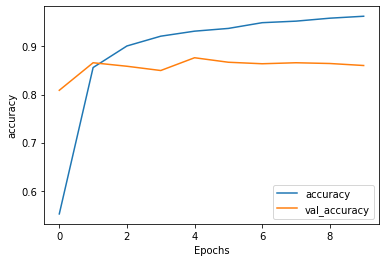

In [21]:
plot_graphs(history, 'accuracy')

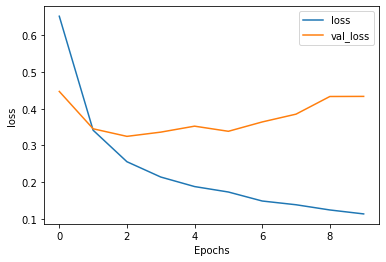

In [22]:
plot_graphs(history, 'loss')

## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* Return either the full sequences of successive outputs for each timestep (a 3D tensor of shape `(batch_size, timesteps, output_features)`).
* Return only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)).

In [23]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [24]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [25]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10


  1/391 [..............................] - ETA: 0s - loss: 0.6946 - accuracy: 0.5938

  2/391 [..............................] - ETA: 38s - loss: 0.6937 - accuracy: 0.5469

  3/391 [..............................] - ETA: 46s - loss: 0.6931 - accuracy: 0.5104

  4/391 [..............................] - ETA: 50s - loss: 0.6930 - accuracy: 0.5039

  5/391 [..............................] - ETA: 1:05 - loss: 0.6936 - accuracy: 0.5219

  6/391 [..............................] - ETA: 1:06 - loss: 0.6935 - accuracy: 0.5156

  7/391 [..............................] - ETA: 1:06 - loss: 0.6934 - accuracy: 0.4978

  8/391 [..............................] - ETA: 1:07 - loss: 0.6932 - accuracy: 0.4824

  9/391 [..............................] - ETA: 1:09 - loss: 0.6933 - accuracy: 0.4861

 10/391 [..............................] - ETA: 1:07 - loss: 0.6931 - accuracy: 0.4828

 11/391 [..............................] - ETA: 1:05 - loss: 0.6931 - accuracy: 0.4815

 12/391 [..............................] - ETA: 1:03 - loss: 0.6932 - accuracy: 0.4792

 13/391 [..............................] - ETA: 1:03 - loss: 0.6932 - accuracy: 0.4808

 14/391 [>.............................] - ETA: 1:03 - loss: 0.6931 - accuracy: 0.4754

 15/391 [>.............................] - ETA: 1:04 - loss: 0.6931 - accuracy: 0.4729

 16/391 [>.............................] - ETA: 1:03 - loss: 0.6932 - accuracy: 0.4717

 17/391 [>.............................] - ETA: 1:03 - loss: 0.6933 - accuracy: 0.4779

 18/391 [>.............................] - ETA: 1:04 - loss: 0.6933 - accuracy: 0.4783

 19/391 [>.............................] - ETA: 1:03 - loss: 0.6934 - accuracy: 0.4803

 20/391 [>.............................] - ETA: 1:04 - loss: 0.6935 - accuracy: 0.4836

 21/391 [>.............................] - ETA: 1:04 - loss: 0.6933 - accuracy: 0.4792

 22/391 [>.............................] - ETA: 1:04 - loss: 0.6933 - accuracy: 0.4822

 23/391 [>.............................] - ETA: 1:02 - loss: 0.6934 - accuracy: 0.4851

 24/391 [>.............................] - ETA: 1:07 - loss: 0.6934 - accuracy: 0.4889

 25/391 [>.............................] - ETA: 1:07 - loss: 0.6935 - accuracy: 0.4894

 26/391 [>.............................] - ETA: 1:07 - loss: 0.6934 - accuracy: 0.4898

 27/391 [=>............................] - ETA: 1:07 - loss: 0.6934 - accuracy: 0.4907

 28/391 [=>............................] - ETA: 1:07 - loss: 0.6934 - accuracy: 0.4916

 29/391 [=>............................] - ETA: 1:06 - loss: 0.6934 - accuracy: 0.4919

 30/391 [=>............................] - ETA: 1:06 - loss: 0.6934 - accuracy: 0.4911

 31/391 [=>............................] - ETA: 1:06 - loss: 0.6934 - accuracy: 0.4919

 32/391 [=>............................] - ETA: 1:05 - loss: 0.6933 - accuracy: 0.4927

 33/391 [=>............................] - ETA: 1:05 - loss: 0.6933 - accuracy: 0.4920

 34/391 [=>............................] - ETA: 1:05 - loss: 0.6934 - accuracy: 0.4959

 35/391 [=>............................] - ETA: 1:05 - loss: 0.6934 - accuracy: 0.4982

 36/391 [=>............................] - ETA: 1:04 - loss: 0.6934 - accuracy: 0.4987

 37/391 [=>............................] - ETA: 1:04 - loss: 0.6934 - accuracy: 0.4979

 38/391 [=>............................] - ETA: 1:04 - loss: 0.6934 - accuracy: 0.4996

 39/391 [=>............................] - ETA: 1:03 - loss: 0.6933 - accuracy: 0.4980

 40/391 [==>...........................] - ETA: 1:04 - loss: 0.6933 - accuracy: 0.4977

 41/391 [==>...........................] - ETA: 1:03 - loss: 0.6933 - accuracy: 0.5004

 42/391 [==>...........................] - ETA: 1:03 - loss: 0.6933 - accuracy: 0.5019

 43/391 [==>...........................] - ETA: 1:02 - loss: 0.6933 - accuracy: 0.5007

 44/391 [==>...........................] - ETA: 1:02 - loss: 0.6933 - accuracy: 0.4989

 45/391 [==>...........................] - ETA: 1:02 - loss: 0.6933 - accuracy: 0.5014

 46/391 [==>...........................] - ETA: 1:02 - loss: 0.6934 - accuracy: 0.5054

 47/391 [==>...........................] - ETA: 1:02 - loss: 0.6934 - accuracy: 0.5047

 48/391 [==>...........................] - ETA: 1:01 - loss: 0.6933 - accuracy: 0.5029

 49/391 [==>...........................] - ETA: 1:01 - loss: 0.6933 - accuracy: 0.5019

 50/391 [==>...........................] - ETA: 1:01 - loss: 0.6933 - accuracy: 0.5016

 51/391 [==>...........................] - ETA: 1:01 - loss: 0.6933 - accuracy: 0.5034

 52/391 [==>...........................] - ETA: 1:01 - loss: 0.6933 - accuracy: 0.5033

 53/391 [===>..........................] - ETA: 1:01 - loss: 0.6933 - accuracy: 0.5012

 54/391 [===>..........................] - ETA: 1:01 - loss: 0.6933 - accuracy: 0.5026

 55/391 [===>..........................] - ETA: 1:00 - loss: 0.6933 - accuracy: 0.5026

 56/391 [===>..........................] - ETA: 1:00 - loss: 0.6933 - accuracy: 0.5033

 57/391 [===>..........................] - ETA: 1:00 - loss: 0.6933 - accuracy: 0.5025

 58/391 [===>..........................] - ETA: 59s - loss: 0.6933 - accuracy: 0.5016 

 59/391 [===>..........................] - ETA: 59s - loss: 0.6933 - accuracy: 0.5021

 60/391 [===>..........................] - ETA: 59s - loss: 0.6933 - accuracy: 0.5026

 61/391 [===>..........................] - ETA: 58s - loss: 0.6932 - accuracy: 0.5000

 62/391 [===>..........................] - ETA: 58s - loss: 0.6932 - accuracy: 0.5000

 63/391 [===>..........................] - ETA: 58s - loss: 0.6932 - accuracy: 0.4993

 64/391 [===>..........................] - ETA: 57s - loss: 0.6932 - accuracy: 0.4993

 65/391 [===>..........................] - ETA: 58s - loss: 0.6932 - accuracy: 0.4995

 66/391 [====>.........................] - ETA: 58s - loss: 0.6932 - accuracy: 0.5002

 67/391 [====>.........................] - ETA: 58s - loss: 0.6932 - accuracy: 0.5007

 68/391 [====>.........................] - ETA: 57s - loss: 0.6932 - accuracy: 0.5009

 69/391 [====>.........................] - ETA: 57s - loss: 0.6932 - accuracy: 0.5000

 70/391 [====>.........................] - ETA: 57s - loss: 0.6932 - accuracy: 0.4998

 71/391 [====>.........................] - ETA: 57s - loss: 0.6932 - accuracy: 0.5000

 72/391 [====>.........................] - ETA: 57s - loss: 0.6932 - accuracy: 0.5002

 73/391 [====>.........................] - ETA: 56s - loss: 0.6932 - accuracy: 0.5009

 74/391 [====>.........................] - ETA: 56s - loss: 0.6932 - accuracy: 0.5013

 75/391 [====>.........................] - ETA: 56s - loss: 0.6932 - accuracy: 0.5023

 76/391 [====>.........................] - ETA: 56s - loss: 0.6932 - accuracy: 0.5033

 77/391 [====>.........................] - ETA: 56s - loss: 0.6932 - accuracy: 0.5053

 78/391 [====>.........................] - ETA: 56s - loss: 0.6932 - accuracy: 0.5058

 79/391 [=====>........................] - ETA: 55s - loss: 0.6931 - accuracy: 0.5063

 80/391 [=====>........................] - ETA: 55s - loss: 0.6931 - accuracy: 0.5061

 81/391 [=====>........................] - ETA: 55s - loss: 0.6931 - accuracy: 0.5052

 82/391 [=====>........................] - ETA: 55s - loss: 0.6931 - accuracy: 0.5051

 83/391 [=====>........................] - ETA: 54s - loss: 0.6931 - accuracy: 0.5030

 84/391 [=====>........................] - ETA: 54s - loss: 0.6931 - accuracy: 0.5032

 85/391 [=====>........................] - ETA: 54s - loss: 0.6931 - accuracy: 0.5026

 86/391 [=====>........................] - ETA: 54s - loss: 0.6931 - accuracy: 0.5020

 87/391 [=====>........................] - ETA: 53s - loss: 0.6931 - accuracy: 0.5020

 88/391 [=====>........................] - ETA: 53s - loss: 0.6931 - accuracy: 0.5027

 89/391 [=====>........................] - ETA: 53s - loss: 0.6932 - accuracy: 0.5018

 90/391 [=====>........................] - ETA: 53s - loss: 0.6932 - accuracy: 0.5014

 91/391 [=====>........................] - ETA: 53s - loss: 0.6932 - accuracy: 0.5012

 92/391 [======>.......................] - ETA: 52s - loss: 0.6931 - accuracy: 0.5017

 93/391 [======>.......................] - ETA: 52s - loss: 0.6932 - accuracy: 0.5013

 94/391 [======>.......................] - ETA: 52s - loss: 0.6931 - accuracy: 0.5005

 95/391 [======>.......................] - ETA: 52s - loss: 0.6931 - accuracy: 0.5002

 96/391 [======>.......................] - ETA: 51s - loss: 0.6931 - accuracy: 0.5008

 97/391 [======>.......................] - ETA: 51s - loss: 0.6931 - accuracy: 0.5018

 98/391 [======>.......................] - ETA: 51s - loss: 0.6931 - accuracy: 0.5022

 99/391 [======>.......................] - ETA: 51s - loss: 0.6931 - accuracy: 0.5025

100/391 [======>.......................] - ETA: 51s - loss: 0.6931 - accuracy: 0.5019

101/391 [======>.......................] - ETA: 51s - loss: 0.6931 - accuracy: 0.5011

102/391 [======>.......................] - ETA: 51s - loss: 0.6931 - accuracy: 0.5011

103/391 [======>.......................] - ETA: 50s - loss: 0.6931 - accuracy: 0.5006

104/391 [======>.......................] - ETA: 50s - loss: 0.6931 - accuracy: 0.5011

105/391 [=======>......................] - ETA: 50s - loss: 0.6932 - accuracy: 0.5018

106/391 [=======>......................] - ETA: 50s - loss: 0.6932 - accuracy: 0.5013

107/391 [=======>......................] - ETA: 50s - loss: 0.6932 - accuracy: 0.5007

108/391 [=======>......................] - ETA: 50s - loss: 0.6932 - accuracy: 0.5010

109/391 [=======>......................] - ETA: 50s - loss: 0.6932 - accuracy: 0.5016

110/391 [=======>......................] - ETA: 49s - loss: 0.6932 - accuracy: 0.5009

111/391 [=======>......................] - ETA: 49s - loss: 0.6932 - accuracy: 0.5000

112/391 [=======>......................] - ETA: 49s - loss: 0.6932 - accuracy: 0.5003

113/391 [=======>......................] - ETA: 49s - loss: 0.6932 - accuracy: 0.4999

114/391 [=======>......................] - ETA: 49s - loss: 0.6931 - accuracy: 0.4992

115/391 [=======>......................] - ETA: 48s - loss: 0.6931 - accuracy: 0.4985

116/391 [=======>......................] - ETA: 48s - loss: 0.6931 - accuracy: 0.4987

117/391 [=======>......................] - ETA: 48s - loss: 0.6931 - accuracy: 0.4989

118/391 [========>.....................] - ETA: 48s - loss: 0.6931 - accuracy: 0.4985

119/391 [========>.....................] - ETA: 48s - loss: 0.6931 - accuracy: 0.4986

120/391 [========>.....................] - ETA: 47s - loss: 0.6931 - accuracy: 0.4984

121/391 [========>.....................] - ETA: 47s - loss: 0.6931 - accuracy: 0.4985

122/391 [========>.....................] - ETA: 47s - loss: 0.6931 - accuracy: 0.4986

123/391 [========>.....................] - ETA: 47s - loss: 0.6931 - accuracy: 0.4983

124/391 [========>.....................] - ETA: 47s - loss: 0.6931 - accuracy: 0.4989

125/391 [========>.....................] - ETA: 47s - loss: 0.6931 - accuracy: 0.4996

126/391 [========>.....................] - ETA: 46s - loss: 0.6931 - accuracy: 0.4995

127/391 [========>.....................] - ETA: 46s - loss: 0.6931 - accuracy: 0.4991

128/391 [========>.....................] - ETA: 46s - loss: 0.6931 - accuracy: 0.4998

129/391 [========>.....................] - ETA: 46s - loss: 0.6931 - accuracy: 0.4998

130/391 [========>.....................] - ETA: 46s - loss: 0.6931 - accuracy: 0.4998

131/391 [=========>....................] - ETA: 46s - loss: 0.6931 - accuracy: 0.5005

132/391 [=========>....................] - ETA: 45s - loss: 0.6931 - accuracy: 0.5001

133/391 [=========>....................] - ETA: 45s - loss: 0.6931 - accuracy: 0.5001

134/391 [=========>....................] - ETA: 45s - loss: 0.6931 - accuracy: 0.5001

135/391 [=========>....................] - ETA: 45s - loss: 0.6931 - accuracy: 0.4998

136/391 [=========>....................] - ETA: 45s - loss: 0.6931 - accuracy: 0.5000

137/391 [=========>....................] - ETA: 44s - loss: 0.6931 - accuracy: 0.5001

138/391 [=========>....................] - ETA: 44s - loss: 0.6931 - accuracy: 0.4994

139/391 [=========>....................] - ETA: 44s - loss: 0.6931 - accuracy: 0.4998

140/391 [=========>....................] - ETA: 44s - loss: 0.6931 - accuracy: 0.4993

141/391 [=========>....................] - ETA: 44s - loss: 0.6931 - accuracy: 0.4997

142/391 [=========>....................] - ETA: 43s - loss: 0.6931 - accuracy: 0.5006

143/391 [=========>....................] - ETA: 43s - loss: 0.6931 - accuracy: 0.5013

144/391 [==========>...................] - ETA: 43s - loss: 0.6931 - accuracy: 0.5011

145/391 [==========>...................] - ETA: 43s - loss: 0.6931 - accuracy: 0.5012

146/391 [==========>...................] - ETA: 43s - loss: 0.6931 - accuracy: 0.5004

147/391 [==========>...................] - ETA: 43s - loss: 0.6931 - accuracy: 0.5003

148/391 [==========>...................] - ETA: 42s - loss: 0.6931 - accuracy: 0.5003

149/391 [==========>...................] - ETA: 42s - loss: 0.6931 - accuracy: 0.5003

150/391 [==========>...................] - ETA: 42s - loss: 0.6931 - accuracy: 0.5004

151/391 [==========>...................] - ETA: 42s - loss: 0.6931 - accuracy: 0.5007

152/391 [==========>...................] - ETA: 42s - loss: 0.6931 - accuracy: 0.5009

153/391 [==========>...................] - ETA: 41s - loss: 0.6931 - accuracy: 0.5009

154/391 [==========>...................] - ETA: 41s - loss: 0.6931 - accuracy: 0.5012

155/391 [==========>...................] - ETA: 41s - loss: 0.6931 - accuracy: 0.5005

156/391 [==========>...................] - ETA: 41s - loss: 0.6931 - accuracy: 0.5018

157/391 [===========>..................] - ETA: 41s - loss: 0.6931 - accuracy: 0.5015

158/391 [===========>..................] - ETA: 40s - loss: 0.6931 - accuracy: 0.5022

159/391 [===========>..................] - ETA: 40s - loss: 0.6931 - accuracy: 0.5022

160/391 [===========>..................] - ETA: 40s - loss: 0.6931 - accuracy: 0.5022

161/391 [===========>..................] - ETA: 40s - loss: 0.6930 - accuracy: 0.5021

162/391 [===========>..................] - ETA: 40s - loss: 0.6931 - accuracy: 0.5018

163/391 [===========>..................] - ETA: 40s - loss: 0.6930 - accuracy: 0.5013

164/391 [===========>..................] - ETA: 39s - loss: 0.6930 - accuracy: 0.5016

165/391 [===========>..................] - ETA: 39s - loss: 0.6930 - accuracy: 0.5022

166/391 [===========>..................] - ETA: 39s - loss: 0.6930 - accuracy: 0.5022

167/391 [===========>..................] - ETA: 39s - loss: 0.6930 - accuracy: 0.5020

168/391 [===========>..................] - ETA: 39s - loss: 0.6930 - accuracy: 0.5020

169/391 [===========>..................] - ETA: 39s - loss: 0.6930 - accuracy: 0.5019

170/391 [============>.................] - ETA: 38s - loss: 0.6930 - accuracy: 0.5017

171/391 [============>.................] - ETA: 38s - loss: 0.6930 - accuracy: 0.5018

172/391 [============>.................] - ETA: 38s - loss: 0.6930 - accuracy: 0.5015

173/391 [============>.................] - ETA: 38s - loss: 0.6930 - accuracy: 0.5016

174/391 [============>.................] - ETA: 38s - loss: 0.6930 - accuracy: 0.5021

175/391 [============>.................] - ETA: 38s - loss: 0.6930 - accuracy: 0.5021

176/391 [============>.................] - ETA: 38s - loss: 0.6930 - accuracy: 0.5022

177/391 [============>.................] - ETA: 37s - loss: 0.6930 - accuracy: 0.5025

178/391 [============>.................] - ETA: 37s - loss: 0.6930 - accuracy: 0.5028

179/391 [============>.................] - ETA: 37s - loss: 0.6930 - accuracy: 0.5027

180/391 [============>.................] - ETA: 37s - loss: 0.6930 - accuracy: 0.5027

181/391 [============>.................] - ETA: 37s - loss: 0.6930 - accuracy: 0.5028

182/391 [============>.................] - ETA: 36s - loss: 0.6930 - accuracy: 0.5028

183/391 [=============>................] - ETA: 36s - loss: 0.6930 - accuracy: 0.5030

184/391 [=============>................] - ETA: 36s - loss: 0.6929 - accuracy: 0.5030

185/391 [=============>................] - ETA: 36s - loss: 0.6929 - accuracy: 0.5023

186/391 [=============>................] - ETA: 36s - loss: 0.6929 - accuracy: 0.5025

187/391 [=============>................] - ETA: 35s - loss: 0.6929 - accuracy: 0.5021

188/391 [=============>................] - ETA: 35s - loss: 0.6929 - accuracy: 0.5024

189/391 [=============>................] - ETA: 35s - loss: 0.6929 - accuracy: 0.5022

190/391 [=============>................] - ETA: 35s - loss: 0.6929 - accuracy: 0.5021

191/391 [=============>................] - ETA: 35s - loss: 0.6929 - accuracy: 0.5022

192/391 [=============>................] - ETA: 35s - loss: 0.6929 - accuracy: 0.5018

193/391 [=============>................] - ETA: 34s - loss: 0.6929 - accuracy: 0.5022

194/391 [=============>................] - ETA: 34s - loss: 0.6929 - accuracy: 0.5023

195/391 [=============>................] - ETA: 34s - loss: 0.6929 - accuracy: 0.5022

196/391 [==============>...............] - ETA: 34s - loss: 0.6929 - accuracy: 0.5019

197/391 [==============>...............] - ETA: 34s - loss: 0.6929 - accuracy: 0.5013

198/391 [==============>...............] - ETA: 34s - loss: 0.6929 - accuracy: 0.5013

199/391 [==============>...............] - ETA: 33s - loss: 0.6929 - accuracy: 0.5018

200/391 [==============>...............] - ETA: 33s - loss: 0.6929 - accuracy: 0.5016

201/391 [==============>...............] - ETA: 33s - loss: 0.6929 - accuracy: 0.5014

202/391 [==============>...............] - ETA: 33s - loss: 0.6928 - accuracy: 0.5015

203/391 [==============>...............] - ETA: 33s - loss: 0.6928 - accuracy: 0.5015

204/391 [==============>...............] - ETA: 33s - loss: 0.6928 - accuracy: 0.5012

205/391 [==============>...............] - ETA: 32s - loss: 0.6928 - accuracy: 0.5009

206/391 [==============>...............] - ETA: 32s - loss: 0.6928 - accuracy: 0.5004

207/391 [==============>...............] - ETA: 32s - loss: 0.6928 - accuracy: 0.5004

208/391 [==============>...............] - ETA: 32s - loss: 0.6928 - accuracy: 0.5008

209/391 [===============>..............] - ETA: 32s - loss: 0.6928 - accuracy: 0.5007

210/391 [===============>..............] - ETA: 31s - loss: 0.6928 - accuracy: 0.5001

211/391 [===============>..............] - ETA: 31s - loss: 0.6928 - accuracy: 0.4999

212/391 [===============>..............] - ETA: 31s - loss: 0.6927 - accuracy: 0.4990

213/391 [===============>..............] - ETA: 31s - loss: 0.6927 - accuracy: 0.4990

214/391 [===============>..............] - ETA: 31s - loss: 0.6928 - accuracy: 0.4996

215/391 [===============>..............] - ETA: 31s - loss: 0.6927 - accuracy: 0.4995

216/391 [===============>..............] - ETA: 30s - loss: 0.6927 - accuracy: 0.4996

217/391 [===============>..............] - ETA: 30s - loss: 0.6927 - accuracy: 0.4999

218/391 [===============>..............] - ETA: 30s - loss: 0.6927 - accuracy: 0.4999

219/391 [===============>..............] - ETA: 30s - loss: 0.6927 - accuracy: 0.5001

220/391 [===============>..............] - ETA: 30s - loss: 0.6927 - accuracy: 0.5000

221/391 [===============>..............] - ETA: 30s - loss: 0.6927 - accuracy: 0.5001

222/391 [================>.............] - ETA: 29s - loss: 0.6927 - accuracy: 0.5003

223/391 [================>.............] - ETA: 29s - loss: 0.6927 - accuracy: 0.4999

224/391 [================>.............] - ETA: 29s - loss: 0.6927 - accuracy: 0.4999

225/391 [================>.............] - ETA: 29s - loss: 0.6927 - accuracy: 0.4999

226/391 [================>.............] - ETA: 29s - loss: 0.6926 - accuracy: 0.4997

227/391 [================>.............] - ETA: 28s - loss: 0.6926 - accuracy: 0.4996

228/391 [================>.............] - ETA: 28s - loss: 0.6926 - accuracy: 0.4994

229/391 [================>.............] - ETA: 28s - loss: 0.6926 - accuracy: 0.4996

230/391 [================>.............] - ETA: 28s - loss: 0.6926 - accuracy: 0.4997

231/391 [================>.............] - ETA: 28s - loss: 0.6926 - accuracy: 0.4998

232/391 [================>.............] - ETA: 28s - loss: 0.6926 - accuracy: 0.5000

233/391 [================>.............] - ETA: 27s - loss: 0.6926 - accuracy: 0.5000

234/391 [================>.............] - ETA: 27s - loss: 0.6926 - accuracy: 0.5002

235/391 [=================>............] - ETA: 27s - loss: 0.6926 - accuracy: 0.4999

236/391 [=================>............] - ETA: 27s - loss: 0.6925 - accuracy: 0.4994

237/391 [=================>............] - ETA: 27s - loss: 0.6925 - accuracy: 0.4993

238/391 [=================>............] - ETA: 27s - loss: 0.6925 - accuracy: 0.4995

239/391 [=================>............] - ETA: 26s - loss: 0.6925 - accuracy: 0.4995

240/391 [=================>............] - ETA: 26s - loss: 0.6925 - accuracy: 0.5000

241/391 [=================>............] - ETA: 26s - loss: 0.6925 - accuracy: 0.4999

242/391 [=================>............] - ETA: 26s - loss: 0.6925 - accuracy: 0.5003

243/391 [=================>............] - ETA: 26s - loss: 0.6925 - accuracy: 0.5002

244/391 [=================>............] - ETA: 26s - loss: 0.6925 - accuracy: 0.5002

245/391 [=================>............] - ETA: 25s - loss: 0.6925 - accuracy: 0.4999

246/391 [=================>............] - ETA: 25s - loss: 0.6924 - accuracy: 0.4993

247/391 [=================>............] - ETA: 25s - loss: 0.6924 - accuracy: 0.4992

248/391 [==================>...........] - ETA: 25s - loss: 0.6924 - accuracy: 0.4996

249/391 [==================>...........] - ETA: 25s - loss: 0.6924 - accuracy: 0.4994

250/391 [==================>...........] - ETA: 25s - loss: 0.6924 - accuracy: 0.4996

251/391 [==================>...........] - ETA: 24s - loss: 0.6924 - accuracy: 0.4997

252/391 [==================>...........] - ETA: 24s - loss: 0.6923 - accuracy: 0.4994

253/391 [==================>...........] - ETA: 24s - loss: 0.6923 - accuracy: 0.4995

254/391 [==================>...........] - ETA: 24s - loss: 0.6923 - accuracy: 0.4996

255/391 [==================>...........] - ETA: 24s - loss: 0.6923 - accuracy: 0.4998

256/391 [==================>...........] - ETA: 23s - loss: 0.6923 - accuracy: 0.4997

257/391 [==================>...........] - ETA: 23s - loss: 0.6922 - accuracy: 0.4993

258/391 [==================>...........] - ETA: 23s - loss: 0.6922 - accuracy: 0.4988

259/391 [==================>...........] - ETA: 23s - loss: 0.6922 - accuracy: 0.4992

260/391 [==================>...........] - ETA: 23s - loss: 0.6922 - accuracy: 0.4993

261/391 [===================>..........] - ETA: 23s - loss: 0.6921 - accuracy: 0.4993

262/391 [===================>..........] - ETA: 22s - loss: 0.6921 - accuracy: 0.4991

263/391 [===================>..........] - ETA: 22s - loss: 0.6920 - accuracy: 0.4990

264/391 [===================>..........] - ETA: 22s - loss: 0.6920 - accuracy: 0.4989

265/391 [===================>..........] - ETA: 22s - loss: 0.6919 - accuracy: 0.4988

266/391 [===================>..........] - ETA: 22s - loss: 0.6919 - accuracy: 0.4989

267/391 [===================>..........] - ETA: 21s - loss: 0.6919 - accuracy: 0.4994

268/391 [===================>..........] - ETA: 21s - loss: 0.6917 - accuracy: 0.4990

269/391 [===================>..........] - ETA: 21s - loss: 0.6917 - accuracy: 0.4991

270/391 [===================>..........] - ETA: 21s - loss: 0.6916 - accuracy: 0.4990

271/391 [===================>..........] - ETA: 21s - loss: 0.6915 - accuracy: 0.4991

272/391 [===================>..........] - ETA: 21s - loss: 0.6914 - accuracy: 0.4989

273/391 [===================>..........] - ETA: 20s - loss: 0.6913 - accuracy: 0.4994

274/391 [====================>.........] - ETA: 20s - loss: 0.6911 - accuracy: 0.5000

275/391 [====================>.........] - ETA: 20s - loss: 0.6910 - accuracy: 0.5000

276/391 [====================>.........] - ETA: 20s - loss: 0.6908 - accuracy: 0.5006

277/391 [====================>.........] - ETA: 20s - loss: 0.6906 - accuracy: 0.5014

278/391 [====================>.........] - ETA: 19s - loss: 0.6905 - accuracy: 0.5017

279/391 [====================>.........] - ETA: 19s - loss: 0.6903 - accuracy: 0.5025

280/391 [====================>.........] - ETA: 19s - loss: 0.6901 - accuracy: 0.5028

281/391 [====================>.........] - ETA: 19s - loss: 0.6900 - accuracy: 0.5031

282/391 [====================>.........] - ETA: 19s - loss: 0.6897 - accuracy: 0.5039

283/391 [====================>.........] - ETA: 19s - loss: 0.6897 - accuracy: 0.5043

284/391 [====================>.........] - ETA: 18s - loss: 0.6896 - accuracy: 0.5048

285/391 [====================>.........] - ETA: 18s - loss: 0.6898 - accuracy: 0.5053

286/391 [====================>.........] - ETA: 18s - loss: 0.6896 - accuracy: 0.5058

287/391 [=====================>........] - ETA: 18s - loss: 0.6894 - accuracy: 0.5064

288/391 [=====================>........] - ETA: 18s - loss: 0.6892 - accuracy: 0.5070

289/391 [=====================>........] - ETA: 18s - loss: 0.6891 - accuracy: 0.5074

290/391 [=====================>........] - ETA: 17s - loss: 0.6890 - accuracy: 0.5071

291/391 [=====================>........] - ETA: 17s - loss: 0.6889 - accuracy: 0.5073

292/391 [=====================>........] - ETA: 17s - loss: 0.6888 - accuracy: 0.5074

293/391 [=====================>........] - ETA: 17s - loss: 0.6887 - accuracy: 0.5077

294/391 [=====================>........] - ETA: 17s - loss: 0.6885 - accuracy: 0.5078

295/391 [=====================>........] - ETA: 16s - loss: 0.6884 - accuracy: 0.5080

296/391 [=====================>........] - ETA: 16s - loss: 0.6883 - accuracy: 0.5081

297/391 [=====================>........] - ETA: 16s - loss: 0.6882 - accuracy: 0.5081

298/391 [=====================>........] - ETA: 16s - loss: 0.6881 - accuracy: 0.5083

299/391 [=====================>........] - ETA: 16s - loss: 0.6879 - accuracy: 0.5084

300/391 [======================>.......] - ETA: 16s - loss: 0.6878 - accuracy: 0.5091

301/391 [======================>.......] - ETA: 15s - loss: 0.6876 - accuracy: 0.5094

302/391 [======================>.......] - ETA: 15s - loss: 0.6874 - accuracy: 0.5097

303/391 [======================>.......] - ETA: 15s - loss: 0.6873 - accuracy: 0.5104

304/391 [======================>.......] - ETA: 15s - loss: 0.6870 - accuracy: 0.5105

305/391 [======================>.......] - ETA: 15s - loss: 0.6869 - accuracy: 0.5108

306/391 [======================>.......] - ETA: 15s - loss: 0.6867 - accuracy: 0.5112

307/391 [======================>.......] - ETA: 14s - loss: 0.6866 - accuracy: 0.5117

308/391 [======================>.......] - ETA: 14s - loss: 0.6866 - accuracy: 0.5119

309/391 [======================>.......] - ETA: 14s - loss: 0.6864 - accuracy: 0.5123

310/391 [======================>.......] - ETA: 14s - loss: 0.6861 - accuracy: 0.5128

311/391 [======================>.......] - ETA: 14s - loss: 0.6860 - accuracy: 0.5132

312/391 [======================>.......] - ETA: 13s - loss: 0.6859 - accuracy: 0.5136

313/391 [=======================>......] - ETA: 13s - loss: 0.6857 - accuracy: 0.5138

314/391 [=======================>......] - ETA: 13s - loss: 0.6855 - accuracy: 0.5143

315/391 [=======================>......] - ETA: 13s - loss: 0.6854 - accuracy: 0.5147

316/391 [=======================>......] - ETA: 13s - loss: 0.6853 - accuracy: 0.5151

317/391 [=======================>......] - ETA: 13s - loss: 0.6851 - accuracy: 0.5153

318/391 [=======================>......] - ETA: 12s - loss: 0.6848 - accuracy: 0.5159

319/391 [=======================>......] - ETA: 12s - loss: 0.6845 - accuracy: 0.5168

320/391 [=======================>......] - ETA: 12s - loss: 0.6844 - accuracy: 0.5173

321/391 [=======================>......] - ETA: 12s - loss: 0.6840 - accuracy: 0.5177

322/391 [=======================>......] - ETA: 12s - loss: 0.6837 - accuracy: 0.5182

323/391 [=======================>......] - ETA: 12s - loss: 0.6832 - accuracy: 0.5188

324/391 [=======================>......] - ETA: 11s - loss: 0.6831 - accuracy: 0.5187

325/391 [=======================>......] - ETA: 11s - loss: 0.6829 - accuracy: 0.5193

326/391 [========================>.....] - ETA: 11s - loss: 0.6825 - accuracy: 0.5199

327/391 [========================>.....] - ETA: 11s - loss: 0.6823 - accuracy: 0.5204

328/391 [========================>.....] - ETA: 11s - loss: 0.6820 - accuracy: 0.5211

329/391 [========================>.....] - ETA: 10s - loss: 0.6817 - accuracy: 0.5216

330/391 [========================>.....] - ETA: 10s - loss: 0.6815 - accuracy: 0.5221

331/391 [========================>.....] - ETA: 10s - loss: 0.6812 - accuracy: 0.5225

332/391 [========================>.....] - ETA: 10s - loss: 0.6809 - accuracy: 0.5231

333/391 [========================>.....] - ETA: 10s - loss: 0.6806 - accuracy: 0.5236

334/391 [========================>.....] - ETA: 10s - loss: 0.6804 - accuracy: 0.5238

335/391 [========================>.....] - ETA: 9s - loss: 0.6802 - accuracy: 0.5241 

336/391 [========================>.....] - ETA: 9s - loss: 0.6797 - accuracy: 0.5249

337/391 [========================>.....] - ETA: 9s - loss: 0.6795 - accuracy: 0.5252

338/391 [========================>.....] - ETA: 9s - loss: 0.6796 - accuracy: 0.5252

339/391 [=========================>....] - ETA: 9s - loss: 0.6792 - accuracy: 0.5258

340/391 [=========================>....] - ETA: 8s - loss: 0.6791 - accuracy: 0.5261

341/391 [=========================>....] - ETA: 8s - loss: 0.6788 - accuracy: 0.5264

342/391 [=========================>....] - ETA: 8s - loss: 0.6785 - accuracy: 0.5270

343/391 [=========================>....] - ETA: 8s - loss: 0.6782 - accuracy: 0.5273

344/391 [=========================>....] - ETA: 8s - loss: 0.6780 - accuracy: 0.5276

345/391 [=========================>....] - ETA: 8s - loss: 0.6778 - accuracy: 0.5280

346/391 [=========================>....] - ETA: 7s - loss: 0.6774 - accuracy: 0.5286

347/391 [=========================>....] - ETA: 7s - loss: 0.6772 - accuracy: 0.5290

348/391 [=========================>....] - ETA: 7s - loss: 0.6769 - accuracy: 0.5295

349/391 [=========================>....] - ETA: 7s - loss: 0.6765 - accuracy: 0.5300

350/391 [=========================>....] - ETA: 7s - loss: 0.6760 - accuracy: 0.5308

351/391 [=========================>....] - ETA: 7s - loss: 0.6757 - accuracy: 0.5314

352/391 [==========================>...] - ETA: 6s - loss: 0.6755 - accuracy: 0.5317

353/391 [==========================>...] - ETA: 6s - loss: 0.6751 - accuracy: 0.5321

354/391 [==========================>...] - ETA: 6s - loss: 0.6748 - accuracy: 0.5327

355/391 [==========================>...] - ETA: 6s - loss: 0.6746 - accuracy: 0.5331

356/391 [==========================>...] - ETA: 6s - loss: 0.6742 - accuracy: 0.5337

357/391 [==========================>...] - ETA: 6s - loss: 0.6739 - accuracy: 0.5340

358/391 [==========================>...] - ETA: 5s - loss: 0.6736 - accuracy: 0.5346

359/391 [==========================>...] - ETA: 5s - loss: 0.6734 - accuracy: 0.5350

360/391 [==========================>...] - ETA: 5s - loss: 0.6735 - accuracy: 0.5349

361/391 [==========================>...] - ETA: 5s - loss: 0.6733 - accuracy: 0.5351

362/391 [==========================>...] - ETA: 5s - loss: 0.6732 - accuracy: 0.5354

363/391 [==========================>...] - ETA: 4s - loss: 0.6730 - accuracy: 0.5356

364/391 [==========================>...] - ETA: 4s - loss: 0.6726 - accuracy: 0.5361

365/391 [===========================>..] - ETA: 4s - loss: 0.6724 - accuracy: 0.5363

366/391 [===========================>..] - ETA: 4s - loss: 0.6719 - accuracy: 0.5368

367/391 [===========================>..] - ETA: 4s - loss: 0.6716 - accuracy: 0.5371

368/391 [===========================>..] - ETA: 4s - loss: 0.6714 - accuracy: 0.5375

369/391 [===========================>..] - ETA: 3s - loss: 0.6710 - accuracy: 0.5383

370/391 [===========================>..] - ETA: 3s - loss: 0.6708 - accuracy: 0.5387

371/391 [===========================>..] - ETA: 3s - loss: 0.6707 - accuracy: 0.5392

372/391 [===========================>..] - ETA: 3s - loss: 0.6702 - accuracy: 0.5397

373/391 [===========================>..] - ETA: 3s - loss: 0.6701 - accuracy: 0.5399

374/391 [===========================>..] - ETA: 2s - loss: 0.6698 - accuracy: 0.5405

375/391 [===========================>..] - ETA: 2s - loss: 0.6693 - accuracy: 0.5411

376/391 [===========================>..] - ETA: 2s - loss: 0.6691 - accuracy: 0.5417

377/391 [===========================>..] - ETA: 2s - loss: 0.6687 - accuracy: 0.5424

378/391 [============================>.] - ETA: 2s - loss: 0.6684 - accuracy: 0.5427

379/391 [============================>.] - ETA: 2s - loss: 0.6682 - accuracy: 0.5428

380/391 [============================>.] - ETA: 1s - loss: 0.6680 - accuracy: 0.5432

381/391 [============================>.] - ETA: 1s - loss: 0.6679 - accuracy: 0.5433

382/391 [============================>.] - ETA: 1s - loss: 0.6677 - accuracy: 0.5434

383/391 [============================>.] - ETA: 1s - loss: 0.6675 - accuracy: 0.5437

384/391 [============================>.] - ETA: 1s - loss: 0.6670 - accuracy: 0.5442

385/391 [============================>.] - ETA: 1s - loss: 0.6666 - accuracy: 0.5447

386/391 [============================>.] - ETA: 0s - loss: 0.6663 - accuracy: 0.5452

387/391 [============================>.] - ETA: 0s - loss: 0.6661 - accuracy: 0.5453

388/391 [============================>.] - ETA: 0s - loss: 0.6658 - accuracy: 0.5457

389/391 [============================>.] - ETA: 0s - loss: 0.6653 - accuracy: 0.5463

390/391 [============================>.] - ETA: 0s - loss: 0.6651 - accuracy: 0.5467

391/391 [==============================] - ETA: 0s - loss: 0.6648 - accuracy: 0.5468

391/391 [==============================] - 72s 185ms/step - loss: 0.6648 - accuracy: 0.5468 - val_loss: 0.5265 - val_accuracy: 0.7516


Epoch 2/10


  1/391 [..............................] - ETA: 0s - loss: 0.5263 - accuracy: 0.7344

  2/391 [..............................] - ETA: 25s - loss: 0.4935 - accuracy: 0.7812

  3/391 [..............................] - ETA: 38s - loss: 0.4992 - accuracy: 0.7604

  4/391 [..............................] - ETA: 48s - loss: 0.5042 - accuracy: 0.7617

  5/391 [..............................] - ETA: 51s - loss: 0.5060 - accuracy: 0.7781

  6/391 [..............................] - ETA: 48s - loss: 0.5050 - accuracy: 0.7865

  7/391 [..............................] - ETA: 52s - loss: 0.5137 - accuracy: 0.7723

  8/391 [..............................] - ETA: 53s - loss: 0.5143 - accuracy: 0.7637

  9/391 [..............................] - ETA: 56s - loss: 0.5128 - accuracy: 0.7587

 10/391 [..............................] - ETA: 56s - loss: 0.5086 - accuracy: 0.7656

 11/391 [..............................] - ETA: 57s - loss: 0.5046 - accuracy: 0.7656

 12/391 [..............................] - ETA: 59s - loss: 0.5019 - accuracy: 0.7656

 13/391 [..............................] - ETA: 58s - loss: 0.4985 - accuracy: 0.7680

 14/391 [>.............................] - ETA: 59s - loss: 0.4984 - accuracy: 0.7690

 15/391 [>.............................] - ETA: 1:00 - loss: 0.4993 - accuracy: 0.7677

 16/391 [>.............................] - ETA: 1:00 - loss: 0.5001 - accuracy: 0.7666

 17/391 [>.............................] - ETA: 1:00 - loss: 0.5021 - accuracy: 0.7647

 18/391 [>.............................] - ETA: 1:00 - loss: 0.4988 - accuracy: 0.7665

 19/391 [>.............................] - ETA: 1:00 - loss: 0.4989 - accuracy: 0.7664

 20/391 [>.............................] - ETA: 1:00 - loss: 0.4982 - accuracy: 0.7688

 21/391 [>.............................] - ETA: 1:00 - loss: 0.4988 - accuracy: 0.7686

 22/391 [>.............................] - ETA: 1:00 - loss: 0.5012 - accuracy: 0.7670

 23/391 [>.............................] - ETA: 1:00 - loss: 0.4990 - accuracy: 0.7677

 24/391 [>.............................] - ETA: 59s - loss: 0.5055 - accuracy: 0.7656 

 25/391 [>.............................] - ETA: 59s - loss: 0.5025 - accuracy: 0.7681

 26/391 [>.............................] - ETA: 59s - loss: 0.5014 - accuracy: 0.7686

 27/391 [=>............................] - ETA: 59s - loss: 0.4997 - accuracy: 0.7697

 28/391 [=>............................] - ETA: 59s - loss: 0.5003 - accuracy: 0.7695

 29/391 [=>............................] - ETA: 1:01 - loss: 0.4971 - accuracy: 0.7721

 30/391 [=>............................] - ETA: 1:01 - loss: 0.4972 - accuracy: 0.7729

 31/391 [=>............................] - ETA: 1:01 - loss: 0.4987 - accuracy: 0.7692

 32/391 [=>............................] - ETA: 1:01 - loss: 0.5041 - accuracy: 0.7646

 33/391 [=>............................] - ETA: 1:01 - loss: 0.5048 - accuracy: 0.7628

 34/391 [=>............................] - ETA: 1:01 - loss: 0.5066 - accuracy: 0.7606

 35/391 [=>............................] - ETA: 1:01 - loss: 0.5040 - accuracy: 0.7643

 36/391 [=>............................] - ETA: 1:01 - loss: 0.5034 - accuracy: 0.7648

 37/391 [=>............................] - ETA: 1:00 - loss: 0.5073 - accuracy: 0.7614

 38/391 [=>............................] - ETA: 1:00 - loss: 0.5050 - accuracy: 0.7611

 39/391 [=>............................] - ETA: 1:00 - loss: 0.5042 - accuracy: 0.7632

 40/391 [==>...........................] - ETA: 1:00 - loss: 0.5047 - accuracy: 0.7625

 41/391 [==>...........................] - ETA: 1:00 - loss: 0.5041 - accuracy: 0.7630

 42/391 [==>...........................] - ETA: 1:00 - loss: 0.5032 - accuracy: 0.7638

 43/391 [==>...........................] - ETA: 1:00 - loss: 0.5038 - accuracy: 0.7624

 44/391 [==>...........................] - ETA: 1:00 - loss: 0.5022 - accuracy: 0.7642

 45/391 [==>...........................] - ETA: 59s - loss: 0.5017 - accuracy: 0.7646 

 46/391 [==>...........................] - ETA: 59s - loss: 0.4996 - accuracy: 0.7663

 47/391 [==>...........................] - ETA: 59s - loss: 0.4971 - accuracy: 0.7680

 48/391 [==>...........................] - ETA: 58s - loss: 0.4965 - accuracy: 0.7686

 49/391 [==>...........................] - ETA: 58s - loss: 0.4966 - accuracy: 0.7688

 50/391 [==>...........................] - ETA: 58s - loss: 0.4962 - accuracy: 0.7675

 51/391 [==>...........................] - ETA: 58s - loss: 0.4951 - accuracy: 0.7675

 52/391 [==>...........................] - ETA: 57s - loss: 0.4955 - accuracy: 0.7662

 53/391 [===>..........................] - ETA: 57s - loss: 0.4946 - accuracy: 0.7674

 54/391 [===>..........................] - ETA: 57s - loss: 0.4923 - accuracy: 0.7688

 55/391 [===>..........................] - ETA: 56s - loss: 0.4934 - accuracy: 0.7682

 56/391 [===>..........................] - ETA: 56s - loss: 0.4927 - accuracy: 0.7687

 57/391 [===>..........................] - ETA: 56s - loss: 0.4937 - accuracy: 0.7686

 58/391 [===>..........................] - ETA: 56s - loss: 0.4924 - accuracy: 0.7686

 59/391 [===>..........................] - ETA: 56s - loss: 0.4912 - accuracy: 0.7693

 60/391 [===>..........................] - ETA: 56s - loss: 0.4907 - accuracy: 0.7693

 61/391 [===>..........................] - ETA: 56s - loss: 0.4890 - accuracy: 0.7700

 62/391 [===>..........................] - ETA: 56s - loss: 0.4884 - accuracy: 0.7694

 63/391 [===>..........................] - ETA: 56s - loss: 0.4889 - accuracy: 0.7691

 64/391 [===>..........................] - ETA: 55s - loss: 0.4881 - accuracy: 0.7693

 65/391 [===>..........................] - ETA: 55s - loss: 0.4892 - accuracy: 0.7673

 66/391 [====>.........................] - ETA: 55s - loss: 0.4894 - accuracy: 0.7673

 67/391 [====>.........................] - ETA: 55s - loss: 0.4879 - accuracy: 0.7687

 68/391 [====>.........................] - ETA: 55s - loss: 0.4868 - accuracy: 0.7691

 69/391 [====>.........................] - ETA: 55s - loss: 0.4851 - accuracy: 0.7706

 70/391 [====>.........................] - ETA: 55s - loss: 0.4848 - accuracy: 0.7712

 71/391 [====>.........................] - ETA: 56s - loss: 0.4839 - accuracy: 0.7729

 72/391 [====>.........................] - ETA: 56s - loss: 0.4834 - accuracy: 0.7734

 73/391 [====>.........................] - ETA: 56s - loss: 0.4844 - accuracy: 0.7729

 74/391 [====>.........................] - ETA: 56s - loss: 0.4835 - accuracy: 0.7736

 75/391 [====>.........................] - ETA: 56s - loss: 0.4834 - accuracy: 0.7731

 76/391 [====>.........................] - ETA: 56s - loss: 0.4835 - accuracy: 0.7728

 77/391 [====>.........................] - ETA: 55s - loss: 0.4845 - accuracy: 0.7723

 78/391 [====>.........................] - ETA: 55s - loss: 0.4843 - accuracy: 0.7730

 79/391 [=====>........................] - ETA: 55s - loss: 0.4833 - accuracy: 0.7735

 80/391 [=====>........................] - ETA: 55s - loss: 0.4828 - accuracy: 0.7736

 81/391 [=====>........................] - ETA: 55s - loss: 0.4822 - accuracy: 0.7737

 82/391 [=====>........................] - ETA: 55s - loss: 0.4810 - accuracy: 0.7748

 83/391 [=====>........................] - ETA: 54s - loss: 0.4807 - accuracy: 0.7750

 84/391 [=====>........................] - ETA: 54s - loss: 0.4804 - accuracy: 0.7759

 85/391 [=====>........................] - ETA: 54s - loss: 0.4797 - accuracy: 0.7763

 86/391 [=====>........................] - ETA: 54s - loss: 0.4797 - accuracy: 0.7763

 87/391 [=====>........................] - ETA: 54s - loss: 0.4808 - accuracy: 0.7760

 88/391 [=====>........................] - ETA: 53s - loss: 0.4810 - accuracy: 0.7757

 89/391 [=====>........................] - ETA: 54s - loss: 0.4805 - accuracy: 0.7760

 90/391 [=====>........................] - ETA: 54s - loss: 0.4796 - accuracy: 0.7766

 91/391 [=====>........................] - ETA: 53s - loss: 0.4788 - accuracy: 0.7773

 92/391 [======>.......................] - ETA: 53s - loss: 0.4795 - accuracy: 0.7773

 93/391 [======>.......................] - ETA: 53s - loss: 0.4775 - accuracy: 0.7786

 94/391 [======>.......................] - ETA: 53s - loss: 0.4762 - accuracy: 0.7793

 95/391 [======>.......................] - ETA: 53s - loss: 0.4749 - accuracy: 0.7801

 96/391 [======>.......................] - ETA: 52s - loss: 0.4747 - accuracy: 0.7806

 97/391 [======>.......................] - ETA: 52s - loss: 0.4737 - accuracy: 0.7812

 98/391 [======>.......................] - ETA: 52s - loss: 0.4726 - accuracy: 0.7822

 99/391 [======>.......................] - ETA: 52s - loss: 0.4742 - accuracy: 0.7819

100/391 [======>.......................] - ETA: 52s - loss: 0.4730 - accuracy: 0.7827

101/391 [======>.......................] - ETA: 51s - loss: 0.4714 - accuracy: 0.7839

102/391 [======>.......................] - ETA: 51s - loss: 0.4695 - accuracy: 0.7849

103/391 [======>.......................] - ETA: 51s - loss: 0.4685 - accuracy: 0.7852

104/391 [======>.......................] - ETA: 51s - loss: 0.4682 - accuracy: 0.7855

105/391 [=======>......................] - ETA: 51s - loss: 0.4663 - accuracy: 0.7863

106/391 [=======>......................] - ETA: 51s - loss: 0.4655 - accuracy: 0.7869

107/391 [=======>......................] - ETA: 51s - loss: 0.4643 - accuracy: 0.7874

108/391 [=======>......................] - ETA: 50s - loss: 0.4628 - accuracy: 0.7883

109/391 [=======>......................] - ETA: 50s - loss: 0.4615 - accuracy: 0.7894

110/391 [=======>......................] - ETA: 50s - loss: 0.4607 - accuracy: 0.7902

111/391 [=======>......................] - ETA: 50s - loss: 0.4598 - accuracy: 0.7908

112/391 [=======>......................] - ETA: 50s - loss: 0.4585 - accuracy: 0.7917

113/391 [=======>......................] - ETA: 50s - loss: 0.4586 - accuracy: 0.7920

114/391 [=======>......................] - ETA: 49s - loss: 0.4600 - accuracy: 0.7919

115/391 [=======>......................] - ETA: 49s - loss: 0.4589 - accuracy: 0.7923

116/391 [=======>......................] - ETA: 49s - loss: 0.4573 - accuracy: 0.7932

117/391 [=======>......................] - ETA: 49s - loss: 0.4567 - accuracy: 0.7938

118/391 [========>.....................] - ETA: 49s - loss: 0.4564 - accuracy: 0.7942

119/391 [========>.....................] - ETA: 48s - loss: 0.4554 - accuracy: 0.7950

120/391 [========>.....................] - ETA: 48s - loss: 0.4536 - accuracy: 0.7961

121/391 [========>.....................] - ETA: 48s - loss: 0.4533 - accuracy: 0.7961

122/391 [========>.....................] - ETA: 48s - loss: 0.4521 - accuracy: 0.7969

123/391 [========>.....................] - ETA: 47s - loss: 0.4514 - accuracy: 0.7971

124/391 [========>.....................] - ETA: 47s - loss: 0.4517 - accuracy: 0.7973

125/391 [========>.....................] - ETA: 47s - loss: 0.4514 - accuracy: 0.7974

126/391 [========>.....................] - ETA: 47s - loss: 0.4510 - accuracy: 0.7975

127/391 [========>.....................] - ETA: 47s - loss: 0.4499 - accuracy: 0.7980

128/391 [========>.....................] - ETA: 47s - loss: 0.4489 - accuracy: 0.7988

129/391 [========>.....................] - ETA: 46s - loss: 0.4499 - accuracy: 0.7984

130/391 [========>.....................] - ETA: 46s - loss: 0.4491 - accuracy: 0.7988

131/391 [=========>....................] - ETA: 46s - loss: 0.4484 - accuracy: 0.7990

132/391 [=========>....................] - ETA: 46s - loss: 0.4473 - accuracy: 0.7996

133/391 [=========>....................] - ETA: 46s - loss: 0.4471 - accuracy: 0.7997

134/391 [=========>....................] - ETA: 46s - loss: 0.4464 - accuracy: 0.7998

135/391 [=========>....................] - ETA: 45s - loss: 0.4463 - accuracy: 0.7999

136/391 [=========>....................] - ETA: 45s - loss: 0.4451 - accuracy: 0.8007

137/391 [=========>....................] - ETA: 45s - loss: 0.4451 - accuracy: 0.8006

138/391 [=========>....................] - ETA: 45s - loss: 0.4440 - accuracy: 0.8012

139/391 [=========>....................] - ETA: 44s - loss: 0.4430 - accuracy: 0.8020

140/391 [=========>....................] - ETA: 44s - loss: 0.4432 - accuracy: 0.8021

141/391 [=========>....................] - ETA: 44s - loss: 0.4425 - accuracy: 0.8027

142/391 [=========>....................] - ETA: 44s - loss: 0.4412 - accuracy: 0.8035

143/391 [=========>....................] - ETA: 44s - loss: 0.4398 - accuracy: 0.8044

144/391 [==========>...................] - ETA: 44s - loss: 0.4386 - accuracy: 0.8049

145/391 [==========>...................] - ETA: 43s - loss: 0.4378 - accuracy: 0.8055

146/391 [==========>...................] - ETA: 43s - loss: 0.4370 - accuracy: 0.8060

147/391 [==========>...................] - ETA: 43s - loss: 0.4370 - accuracy: 0.8060

148/391 [==========>...................] - ETA: 43s - loss: 0.4380 - accuracy: 0.8056

149/391 [==========>...................] - ETA: 43s - loss: 0.4405 - accuracy: 0.8049

150/391 [==========>...................] - ETA: 42s - loss: 0.4414 - accuracy: 0.8049

151/391 [==========>...................] - ETA: 42s - loss: 0.4416 - accuracy: 0.8047

152/391 [==========>...................] - ETA: 42s - loss: 0.4414 - accuracy: 0.8049

153/391 [==========>...................] - ETA: 42s - loss: 0.4434 - accuracy: 0.8041

154/391 [==========>...................] - ETA: 42s - loss: 0.4444 - accuracy: 0.8039

155/391 [==========>...................] - ETA: 42s - loss: 0.4450 - accuracy: 0.8036

156/391 [==========>...................] - ETA: 41s - loss: 0.4450 - accuracy: 0.8036

157/391 [===========>..................] - ETA: 41s - loss: 0.4449 - accuracy: 0.8035

158/391 [===========>..................] - ETA: 41s - loss: 0.4453 - accuracy: 0.8035

159/391 [===========>..................] - ETA: 41s - loss: 0.4457 - accuracy: 0.8034

160/391 [===========>..................] - ETA: 41s - loss: 0.4455 - accuracy: 0.8031

161/391 [===========>..................] - ETA: 40s - loss: 0.4454 - accuracy: 0.8031

162/391 [===========>..................] - ETA: 40s - loss: 0.4453 - accuracy: 0.8033

163/391 [===========>..................] - ETA: 40s - loss: 0.4452 - accuracy: 0.8036

164/391 [===========>..................] - ETA: 40s - loss: 0.4450 - accuracy: 0.8037

165/391 [===========>..................] - ETA: 40s - loss: 0.4443 - accuracy: 0.8039

166/391 [===========>..................] - ETA: 40s - loss: 0.4445 - accuracy: 0.8038

167/391 [===========>..................] - ETA: 39s - loss: 0.4446 - accuracy: 0.8038

168/391 [===========>..................] - ETA: 39s - loss: 0.4446 - accuracy: 0.8036

169/391 [===========>..................] - ETA: 39s - loss: 0.4446 - accuracy: 0.8036

170/391 [============>.................] - ETA: 39s - loss: 0.4441 - accuracy: 0.8042

171/391 [============>.................] - ETA: 39s - loss: 0.4439 - accuracy: 0.8042

172/391 [============>.................] - ETA: 38s - loss: 0.4438 - accuracy: 0.8041

173/391 [============>.................] - ETA: 38s - loss: 0.4434 - accuracy: 0.8043

174/391 [============>.................] - ETA: 38s - loss: 0.4434 - accuracy: 0.8041

175/391 [============>.................] - ETA: 38s - loss: 0.4436 - accuracy: 0.8038

176/391 [============>.................] - ETA: 38s - loss: 0.4438 - accuracy: 0.8035

177/391 [============>.................] - ETA: 38s - loss: 0.4436 - accuracy: 0.8038

178/391 [============>.................] - ETA: 37s - loss: 0.4433 - accuracy: 0.8043

179/391 [============>.................] - ETA: 37s - loss: 0.4430 - accuracy: 0.8043

180/391 [============>.................] - ETA: 37s - loss: 0.4425 - accuracy: 0.8047

181/391 [============>.................] - ETA: 37s - loss: 0.4428 - accuracy: 0.8049

182/391 [============>.................] - ETA: 37s - loss: 0.4424 - accuracy: 0.8051

183/391 [=============>................] - ETA: 36s - loss: 0.4424 - accuracy: 0.8049

184/391 [=============>................] - ETA: 36s - loss: 0.4424 - accuracy: 0.8046

185/391 [=============>................] - ETA: 36s - loss: 0.4421 - accuracy: 0.8046

186/391 [=============>................] - ETA: 36s - loss: 0.4419 - accuracy: 0.8046

187/391 [=============>................] - ETA: 36s - loss: 0.4424 - accuracy: 0.8045

188/391 [=============>................] - ETA: 36s - loss: 0.4421 - accuracy: 0.8048

189/391 [=============>................] - ETA: 36s - loss: 0.4422 - accuracy: 0.8046

190/391 [=============>................] - ETA: 35s - loss: 0.4411 - accuracy: 0.8053

191/391 [=============>................] - ETA: 35s - loss: 0.4413 - accuracy: 0.8051

192/391 [=============>................] - ETA: 35s - loss: 0.4411 - accuracy: 0.8052

193/391 [=============>................] - ETA: 35s - loss: 0.4410 - accuracy: 0.8052

194/391 [=============>................] - ETA: 35s - loss: 0.4409 - accuracy: 0.8050

195/391 [=============>................] - ETA: 34s - loss: 0.4403 - accuracy: 0.8054

196/391 [==============>...............] - ETA: 34s - loss: 0.4401 - accuracy: 0.8054

197/391 [==============>...............] - ETA: 34s - loss: 0.4397 - accuracy: 0.8057

198/391 [==============>...............] - ETA: 34s - loss: 0.4397 - accuracy: 0.8055

199/391 [==============>...............] - ETA: 34s - loss: 0.4390 - accuracy: 0.8057

200/391 [==============>...............] - ETA: 33s - loss: 0.4382 - accuracy: 0.8059

201/391 [==============>...............] - ETA: 33s - loss: 0.4384 - accuracy: 0.8059

202/391 [==============>...............] - ETA: 33s - loss: 0.4378 - accuracy: 0.8059

203/391 [==============>...............] - ETA: 33s - loss: 0.4374 - accuracy: 0.8061

204/391 [==============>...............] - ETA: 33s - loss: 0.4371 - accuracy: 0.8064

205/391 [==============>...............] - ETA: 32s - loss: 0.4366 - accuracy: 0.8068

206/391 [==============>...............] - ETA: 32s - loss: 0.4366 - accuracy: 0.8067

207/391 [==============>...............] - ETA: 32s - loss: 0.4364 - accuracy: 0.8068

208/391 [==============>...............] - ETA: 32s - loss: 0.4363 - accuracy: 0.8067

209/391 [===============>..............] - ETA: 32s - loss: 0.4362 - accuracy: 0.8066

210/391 [===============>..............] - ETA: 31s - loss: 0.4365 - accuracy: 0.8063

211/391 [===============>..............] - ETA: 31s - loss: 0.4357 - accuracy: 0.8066

212/391 [===============>..............] - ETA: 31s - loss: 0.4361 - accuracy: 0.8065

213/391 [===============>..............] - ETA: 31s - loss: 0.4368 - accuracy: 0.8062

214/391 [===============>..............] - ETA: 31s - loss: 0.4365 - accuracy: 0.8062

215/391 [===============>..............] - ETA: 31s - loss: 0.4367 - accuracy: 0.8060

216/391 [===============>..............] - ETA: 30s - loss: 0.4363 - accuracy: 0.8061

217/391 [===============>..............] - ETA: 30s - loss: 0.4359 - accuracy: 0.8063

218/391 [===============>..............] - ETA: 30s - loss: 0.4356 - accuracy: 0.8064

219/391 [===============>..............] - ETA: 30s - loss: 0.4357 - accuracy: 0.8064

220/391 [===============>..............] - ETA: 30s - loss: 0.4355 - accuracy: 0.8064

221/391 [===============>..............] - ETA: 30s - loss: 0.4349 - accuracy: 0.8068

222/391 [================>.............] - ETA: 29s - loss: 0.4348 - accuracy: 0.8069

223/391 [================>.............] - ETA: 29s - loss: 0.4345 - accuracy: 0.8072

224/391 [================>.............] - ETA: 29s - loss: 0.4340 - accuracy: 0.8075

225/391 [================>.............] - ETA: 29s - loss: 0.4334 - accuracy: 0.8078

226/391 [================>.............] - ETA: 29s - loss: 0.4334 - accuracy: 0.8078

227/391 [================>.............] - ETA: 28s - loss: 0.4333 - accuracy: 0.8080

228/391 [================>.............] - ETA: 28s - loss: 0.4334 - accuracy: 0.8079

229/391 [================>.............] - ETA: 28s - loss: 0.4333 - accuracy: 0.8080

230/391 [================>.............] - ETA: 28s - loss: 0.4330 - accuracy: 0.8080

231/391 [================>.............] - ETA: 28s - loss: 0.4327 - accuracy: 0.8082

232/391 [================>.............] - ETA: 28s - loss: 0.4324 - accuracy: 0.8081

233/391 [================>.............] - ETA: 27s - loss: 0.4326 - accuracy: 0.8080

234/391 [================>.............] - ETA: 27s - loss: 0.4325 - accuracy: 0.8081

235/391 [=================>............] - ETA: 27s - loss: 0.4321 - accuracy: 0.8082

236/391 [=================>............] - ETA: 27s - loss: 0.4321 - accuracy: 0.8083

237/391 [=================>............] - ETA: 27s - loss: 0.4325 - accuracy: 0.8080

238/391 [=================>............] - ETA: 26s - loss: 0.4321 - accuracy: 0.8082

239/391 [=================>............] - ETA: 26s - loss: 0.4319 - accuracy: 0.8083

240/391 [=================>............] - ETA: 26s - loss: 0.4314 - accuracy: 0.8085

241/391 [=================>............] - ETA: 26s - loss: 0.4309 - accuracy: 0.8088

242/391 [=================>............] - ETA: 26s - loss: 0.4303 - accuracy: 0.8091

243/391 [=================>............] - ETA: 26s - loss: 0.4302 - accuracy: 0.8090

244/391 [=================>............] - ETA: 25s - loss: 0.4298 - accuracy: 0.8092

245/391 [=================>............] - ETA: 25s - loss: 0.4302 - accuracy: 0.8091

246/391 [=================>............] - ETA: 25s - loss: 0.4302 - accuracy: 0.8091

247/391 [=================>............] - ETA: 25s - loss: 0.4297 - accuracy: 0.8093

248/391 [==================>...........] - ETA: 25s - loss: 0.4292 - accuracy: 0.8097

249/391 [==================>...........] - ETA: 25s - loss: 0.4288 - accuracy: 0.8101

250/391 [==================>...........] - ETA: 24s - loss: 0.4287 - accuracy: 0.8102

251/391 [==================>...........] - ETA: 24s - loss: 0.4287 - accuracy: 0.8104

252/391 [==================>...........] - ETA: 24s - loss: 0.4283 - accuracy: 0.8106

253/391 [==================>...........] - ETA: 24s - loss: 0.4275 - accuracy: 0.8111

254/391 [==================>...........] - ETA: 24s - loss: 0.4273 - accuracy: 0.8112

255/391 [==================>...........] - ETA: 23s - loss: 0.4269 - accuracy: 0.8114

256/391 [==================>...........] - ETA: 23s - loss: 0.4273 - accuracy: 0.8112

257/391 [==================>...........] - ETA: 23s - loss: 0.4268 - accuracy: 0.8116

258/391 [==================>...........] - ETA: 23s - loss: 0.4258 - accuracy: 0.8121

259/391 [==================>...........] - ETA: 23s - loss: 0.4253 - accuracy: 0.8123

260/391 [==================>...........] - ETA: 23s - loss: 0.4254 - accuracy: 0.8123

261/391 [===================>..........] - ETA: 22s - loss: 0.4251 - accuracy: 0.8124

262/391 [===================>..........] - ETA: 22s - loss: 0.4248 - accuracy: 0.8126

263/391 [===================>..........] - ETA: 22s - loss: 0.4245 - accuracy: 0.8127

264/391 [===================>..........] - ETA: 22s - loss: 0.4241 - accuracy: 0.8130

265/391 [===================>..........] - ETA: 22s - loss: 0.4237 - accuracy: 0.8131

266/391 [===================>..........] - ETA: 22s - loss: 0.4232 - accuracy: 0.8135

267/391 [===================>..........] - ETA: 21s - loss: 0.4232 - accuracy: 0.8135

268/391 [===================>..........] - ETA: 21s - loss: 0.4229 - accuracy: 0.8136

269/391 [===================>..........] - ETA: 21s - loss: 0.4225 - accuracy: 0.8138

270/391 [===================>..........] - ETA: 21s - loss: 0.4222 - accuracy: 0.8141

271/391 [===================>..........] - ETA: 21s - loss: 0.4220 - accuracy: 0.8143

272/391 [===================>..........] - ETA: 21s - loss: 0.4219 - accuracy: 0.8143

273/391 [===================>..........] - ETA: 20s - loss: 0.4214 - accuracy: 0.8145

274/391 [====================>.........] - ETA: 20s - loss: 0.4213 - accuracy: 0.8146

275/391 [====================>.........] - ETA: 20s - loss: 0.4206 - accuracy: 0.8149

276/391 [====================>.........] - ETA: 20s - loss: 0.4199 - accuracy: 0.8154

277/391 [====================>.........] - ETA: 20s - loss: 0.4198 - accuracy: 0.8153

278/391 [====================>.........] - ETA: 19s - loss: 0.4200 - accuracy: 0.8152

279/391 [====================>.........] - ETA: 19s - loss: 0.4199 - accuracy: 0.8153

280/391 [====================>.........] - ETA: 19s - loss: 0.4197 - accuracy: 0.8155

281/391 [====================>.........] - ETA: 19s - loss: 0.4194 - accuracy: 0.8156

282/391 [====================>.........] - ETA: 19s - loss: 0.4193 - accuracy: 0.8155

283/391 [====================>.........] - ETA: 19s - loss: 0.4193 - accuracy: 0.8155

284/391 [====================>.........] - ETA: 18s - loss: 0.4191 - accuracy: 0.8156

285/391 [====================>.........] - ETA: 18s - loss: 0.4191 - accuracy: 0.8157

286/391 [====================>.........] - ETA: 18s - loss: 0.4188 - accuracy: 0.8159

287/391 [=====================>........] - ETA: 18s - loss: 0.4186 - accuracy: 0.8160

288/391 [=====================>........] - ETA: 18s - loss: 0.4185 - accuracy: 0.8161

289/391 [=====================>........] - ETA: 18s - loss: 0.4185 - accuracy: 0.8162

290/391 [=====================>........] - ETA: 17s - loss: 0.4182 - accuracy: 0.8164

291/391 [=====================>........] - ETA: 17s - loss: 0.4181 - accuracy: 0.8164

292/391 [=====================>........] - ETA: 17s - loss: 0.4181 - accuracy: 0.8164

293/391 [=====================>........] - ETA: 17s - loss: 0.4177 - accuracy: 0.8167

294/391 [=====================>........] - ETA: 17s - loss: 0.4173 - accuracy: 0.8170

295/391 [=====================>........] - ETA: 16s - loss: 0.4172 - accuracy: 0.8173

296/391 [=====================>........] - ETA: 16s - loss: 0.4168 - accuracy: 0.8174

297/391 [=====================>........] - ETA: 16s - loss: 0.4168 - accuracy: 0.8174

298/391 [=====================>........] - ETA: 16s - loss: 0.4163 - accuracy: 0.8178

299/391 [=====================>........] - ETA: 16s - loss: 0.4158 - accuracy: 0.8181

300/391 [======================>.......] - ETA: 16s - loss: 0.4155 - accuracy: 0.8181

301/391 [======================>.......] - ETA: 15s - loss: 0.4155 - accuracy: 0.8182

302/391 [======================>.......] - ETA: 15s - loss: 0.4153 - accuracy: 0.8182

303/391 [======================>.......] - ETA: 15s - loss: 0.4153 - accuracy: 0.8183

304/391 [======================>.......] - ETA: 15s - loss: 0.4151 - accuracy: 0.8184

305/391 [======================>.......] - ETA: 15s - loss: 0.4149 - accuracy: 0.8185

306/391 [======================>.......] - ETA: 14s - loss: 0.4147 - accuracy: 0.8186

307/391 [======================>.......] - ETA: 14s - loss: 0.4148 - accuracy: 0.8186

308/391 [======================>.......] - ETA: 14s - loss: 0.4147 - accuracy: 0.8187

309/391 [======================>.......] - ETA: 14s - loss: 0.4144 - accuracy: 0.8189

310/391 [======================>.......] - ETA: 14s - loss: 0.4142 - accuracy: 0.8191

311/391 [======================>.......] - ETA: 14s - loss: 0.4142 - accuracy: 0.8191

312/391 [======================>.......] - ETA: 13s - loss: 0.4139 - accuracy: 0.8194

313/391 [=======================>......] - ETA: 13s - loss: 0.4136 - accuracy: 0.8196

314/391 [=======================>......] - ETA: 13s - loss: 0.4132 - accuracy: 0.8197

315/391 [=======================>......] - ETA: 13s - loss: 0.4131 - accuracy: 0.8197

316/391 [=======================>......] - ETA: 13s - loss: 0.4128 - accuracy: 0.8199

317/391 [=======================>......] - ETA: 13s - loss: 0.4126 - accuracy: 0.8199

318/391 [=======================>......] - ETA: 12s - loss: 0.4124 - accuracy: 0.8200

319/391 [=======================>......] - ETA: 12s - loss: 0.4125 - accuracy: 0.8200

320/391 [=======================>......] - ETA: 12s - loss: 0.4121 - accuracy: 0.8202

321/391 [=======================>......] - ETA: 12s - loss: 0.4118 - accuracy: 0.8205

322/391 [=======================>......] - ETA: 12s - loss: 0.4118 - accuracy: 0.8205

323/391 [=======================>......] - ETA: 12s - loss: 0.4118 - accuracy: 0.8206

324/391 [=======================>......] - ETA: 11s - loss: 0.4113 - accuracy: 0.8208

325/391 [=======================>......] - ETA: 11s - loss: 0.4116 - accuracy: 0.8207

326/391 [========================>.....] - ETA: 11s - loss: 0.4115 - accuracy: 0.8208

327/391 [========================>.....] - ETA: 11s - loss: 0.4121 - accuracy: 0.8206

328/391 [========================>.....] - ETA: 11s - loss: 0.4116 - accuracy: 0.8208

329/391 [========================>.....] - ETA: 10s - loss: 0.4113 - accuracy: 0.8210

330/391 [========================>.....] - ETA: 10s - loss: 0.4113 - accuracy: 0.8211

331/391 [========================>.....] - ETA: 10s - loss: 0.4114 - accuracy: 0.8211

332/391 [========================>.....] - ETA: 10s - loss: 0.4118 - accuracy: 0.8212

333/391 [========================>.....] - ETA: 10s - loss: 0.4116 - accuracy: 0.8214

334/391 [========================>.....] - ETA: 10s - loss: 0.4116 - accuracy: 0.8214

335/391 [========================>.....] - ETA: 9s - loss: 0.4116 - accuracy: 0.8215 

336/391 [========================>.....] - ETA: 9s - loss: 0.4112 - accuracy: 0.8216

337/391 [========================>.....] - ETA: 9s - loss: 0.4109 - accuracy: 0.8216

338/391 [========================>.....] - ETA: 9s - loss: 0.4108 - accuracy: 0.8218

339/391 [=========================>....] - ETA: 9s - loss: 0.4102 - accuracy: 0.8220

340/391 [=========================>....] - ETA: 9s - loss: 0.4102 - accuracy: 0.8221

341/391 [=========================>....] - ETA: 8s - loss: 0.4102 - accuracy: 0.8221

342/391 [=========================>....] - ETA: 8s - loss: 0.4103 - accuracy: 0.8222

343/391 [=========================>....] - ETA: 8s - loss: 0.4105 - accuracy: 0.8223

344/391 [=========================>....] - ETA: 8s - loss: 0.4101 - accuracy: 0.8227

345/391 [=========================>....] - ETA: 8s - loss: 0.4098 - accuracy: 0.8229

346/391 [=========================>....] - ETA: 7s - loss: 0.4098 - accuracy: 0.8230

347/391 [=========================>....] - ETA: 7s - loss: 0.4094 - accuracy: 0.8231

348/391 [=========================>....] - ETA: 7s - loss: 0.4096 - accuracy: 0.8231

349/391 [=========================>....] - ETA: 7s - loss: 0.4092 - accuracy: 0.8233

350/391 [=========================>....] - ETA: 7s - loss: 0.4091 - accuracy: 0.8233

351/391 [=========================>....] - ETA: 7s - loss: 0.4093 - accuracy: 0.8232

352/391 [==========================>...] - ETA: 6s - loss: 0.4090 - accuracy: 0.8232

353/391 [==========================>...] - ETA: 6s - loss: 0.4087 - accuracy: 0.8235

354/391 [==========================>...] - ETA: 6s - loss: 0.4091 - accuracy: 0.8234

355/391 [==========================>...] - ETA: 6s - loss: 0.4085 - accuracy: 0.8236

356/391 [==========================>...] - ETA: 6s - loss: 0.4079 - accuracy: 0.8240

357/391 [==========================>...] - ETA: 5s - loss: 0.4076 - accuracy: 0.8241

358/391 [==========================>...] - ETA: 5s - loss: 0.4070 - accuracy: 0.8245

359/391 [==========================>...] - ETA: 5s - loss: 0.4066 - accuracy: 0.8248

360/391 [==========================>...] - ETA: 5s - loss: 0.4063 - accuracy: 0.8250

361/391 [==========================>...] - ETA: 5s - loss: 0.4067 - accuracy: 0.8248

362/391 [==========================>...] - ETA: 5s - loss: 0.4062 - accuracy: 0.8251

363/391 [==========================>...] - ETA: 4s - loss: 0.4060 - accuracy: 0.8252

364/391 [==========================>...] - ETA: 4s - loss: 0.4058 - accuracy: 0.8252

365/391 [===========================>..] - ETA: 4s - loss: 0.4057 - accuracy: 0.8253

366/391 [===========================>..] - ETA: 4s - loss: 0.4053 - accuracy: 0.8256

367/391 [===========================>..] - ETA: 4s - loss: 0.4056 - accuracy: 0.8255

368/391 [===========================>..] - ETA: 4s - loss: 0.4055 - accuracy: 0.8257

369/391 [===========================>..] - ETA: 3s - loss: 0.4055 - accuracy: 0.8257

370/391 [===========================>..] - ETA: 3s - loss: 0.4054 - accuracy: 0.8258

371/391 [===========================>..] - ETA: 3s - loss: 0.4054 - accuracy: 0.8259

372/391 [===========================>..] - ETA: 3s - loss: 0.4050 - accuracy: 0.8260

373/391 [===========================>..] - ETA: 3s - loss: 0.4049 - accuracy: 0.8259

374/391 [===========================>..] - ETA: 2s - loss: 0.4050 - accuracy: 0.8259

375/391 [===========================>..] - ETA: 2s - loss: 0.4046 - accuracy: 0.8261

376/391 [===========================>..] - ETA: 2s - loss: 0.4043 - accuracy: 0.8263

377/391 [===========================>..] - ETA: 2s - loss: 0.4045 - accuracy: 0.8262

378/391 [============================>.] - ETA: 2s - loss: 0.4045 - accuracy: 0.8261

379/391 [============================>.] - ETA: 2s - loss: 0.4045 - accuracy: 0.8261

380/391 [============================>.] - ETA: 1s - loss: 0.4044 - accuracy: 0.8263

381/391 [============================>.] - ETA: 1s - loss: 0.4041 - accuracy: 0.8264

382/391 [============================>.] - ETA: 1s - loss: 0.4039 - accuracy: 0.8266

383/391 [============================>.] - ETA: 1s - loss: 0.4038 - accuracy: 0.8267

384/391 [============================>.] - ETA: 1s - loss: 0.4041 - accuracy: 0.8265

385/391 [============================>.] - ETA: 1s - loss: 0.4038 - accuracy: 0.8267

386/391 [============================>.] - ETA: 0s - loss: 0.4037 - accuracy: 0.8267

387/391 [============================>.] - ETA: 0s - loss: 0.4036 - accuracy: 0.8268

388/391 [============================>.] - ETA: 0s - loss: 0.4034 - accuracy: 0.8269

389/391 [============================>.] - ETA: 0s - loss: 0.4032 - accuracy: 0.8270

390/391 [============================>.] - ETA: 0s - loss: 0.4032 - accuracy: 0.8271

391/391 [==============================] - ETA: 0s - loss: 0.4028 - accuracy: 0.8272

391/391 [==============================] - 71s 183ms/step - loss: 0.4028 - accuracy: 0.8272 - val_loss: 0.4052 - val_accuracy: 0.8068


Epoch 3/10


  1/391 [..............................] - ETA: 0s - loss: 0.3219 - accuracy: 0.8750

  2/391 [..............................] - ETA: 1:02 - loss: 0.3036 - accuracy: 0.8906

  3/391 [..............................] - ETA: 1:08 - loss: 0.3206 - accuracy: 0.8698

  4/391 [..............................] - ETA: 1:04 - loss: 0.3100 - accuracy: 0.8711

  5/391 [..............................] - ETA: 1:03 - loss: 0.3263 - accuracy: 0.8656

  6/391 [..............................] - ETA: 1:00 - loss: 0.3335 - accuracy: 0.8698

  7/391 [..............................] - ETA: 1:01 - loss: 0.3259 - accuracy: 0.8750

  8/391 [..............................] - ETA: 1:01 - loss: 0.3158 - accuracy: 0.8809

  9/391 [..............................] - ETA: 1:01 - loss: 0.3083 - accuracy: 0.8854

 10/391 [..............................] - ETA: 59s - loss: 0.3065 - accuracy: 0.8875 

 11/391 [..............................] - ETA: 59s - loss: 0.3084 - accuracy: 0.8821

 12/391 [..............................] - ETA: 1:00 - loss: 0.3164 - accuracy: 0.8763

 13/391 [..............................] - ETA: 59s - loss: 0.3197 - accuracy: 0.8738 

 14/391 [>.............................] - ETA: 59s - loss: 0.3145 - accuracy: 0.8772

 15/391 [>.............................] - ETA: 59s - loss: 0.3102 - accuracy: 0.8792

 16/391 [>.............................] - ETA: 59s - loss: 0.3048 - accuracy: 0.8799

 17/391 [>.............................] - ETA: 59s - loss: 0.3017 - accuracy: 0.8824

 18/391 [>.............................] - ETA: 1:00 - loss: 0.3083 - accuracy: 0.8819

 19/391 [>.............................] - ETA: 1:00 - loss: 0.3058 - accuracy: 0.8824

 20/391 [>.............................] - ETA: 59s - loss: 0.3060 - accuracy: 0.8836 

 21/391 [>.............................] - ETA: 59s - loss: 0.3127 - accuracy: 0.8802

 22/391 [>.............................] - ETA: 1:00 - loss: 0.3124 - accuracy: 0.8800

 23/391 [>.............................] - ETA: 59s - loss: 0.3098 - accuracy: 0.8804 

 24/391 [>.............................] - ETA: 1:00 - loss: 0.3142 - accuracy: 0.8783

 25/391 [>.............................] - ETA: 1:00 - loss: 0.3154 - accuracy: 0.8781

 26/391 [>.............................] - ETA: 1:00 - loss: 0.3198 - accuracy: 0.8768

 27/391 [=>............................] - ETA: 1:00 - loss: 0.3189 - accuracy: 0.8785

 28/391 [=>............................] - ETA: 1:00 - loss: 0.3155 - accuracy: 0.8795

 29/391 [=>............................] - ETA: 1:00 - loss: 0.3112 - accuracy: 0.8825

 30/391 [=>............................] - ETA: 1:00 - loss: 0.3106 - accuracy: 0.8823

 31/391 [=>............................] - ETA: 1:00 - loss: 0.3114 - accuracy: 0.8810

 32/391 [=>............................] - ETA: 1:00 - loss: 0.3128 - accuracy: 0.8794

 33/391 [=>............................] - ETA: 1:01 - loss: 0.3137 - accuracy: 0.8802

 34/391 [=>............................] - ETA: 1:00 - loss: 0.3143 - accuracy: 0.8796

 35/391 [=>............................] - ETA: 1:00 - loss: 0.3128 - accuracy: 0.8808

 36/391 [=>............................] - ETA: 1:00 - loss: 0.3115 - accuracy: 0.8824

 37/391 [=>............................] - ETA: 59s - loss: 0.3148 - accuracy: 0.8813 

 38/391 [=>............................] - ETA: 59s - loss: 0.3143 - accuracy: 0.8812

 39/391 [=>............................] - ETA: 59s - loss: 0.3132 - accuracy: 0.8822

 40/391 [==>...........................] - ETA: 59s - loss: 0.3125 - accuracy: 0.8832

 41/391 [==>...........................] - ETA: 59s - loss: 0.3133 - accuracy: 0.8822

 42/391 [==>...........................] - ETA: 59s - loss: 0.3136 - accuracy: 0.8817

 43/391 [==>...........................] - ETA: 59s - loss: 0.3134 - accuracy: 0.8819

 44/391 [==>...........................] - ETA: 59s - loss: 0.3132 - accuracy: 0.8810

 45/391 [==>...........................] - ETA: 58s - loss: 0.3141 - accuracy: 0.8809

 46/391 [==>...........................] - ETA: 58s - loss: 0.3129 - accuracy: 0.8818

 47/391 [==>...........................] - ETA: 57s - loss: 0.3121 - accuracy: 0.8823

 48/391 [==>...........................] - ETA: 58s - loss: 0.3123 - accuracy: 0.8818

 49/391 [==>...........................] - ETA: 57s - loss: 0.3104 - accuracy: 0.8830

 50/391 [==>...........................] - ETA: 58s - loss: 0.3088 - accuracy: 0.8841

 51/391 [==>...........................] - ETA: 57s - loss: 0.3089 - accuracy: 0.8845

 52/391 [==>...........................] - ETA: 57s - loss: 0.3094 - accuracy: 0.8846

 53/391 [===>..........................] - ETA: 57s - loss: 0.3118 - accuracy: 0.8833

 54/391 [===>..........................] - ETA: 57s - loss: 0.3107 - accuracy: 0.8834

 55/391 [===>..........................] - ETA: 56s - loss: 0.3077 - accuracy: 0.8849

 56/391 [===>..........................] - ETA: 56s - loss: 0.3073 - accuracy: 0.8853

 57/391 [===>..........................] - ETA: 56s - loss: 0.3059 - accuracy: 0.8860

 58/391 [===>..........................] - ETA: 56s - loss: 0.3039 - accuracy: 0.8871

 59/391 [===>..........................] - ETA: 56s - loss: 0.3044 - accuracy: 0.8869

 60/391 [===>..........................] - ETA: 56s - loss: 0.3038 - accuracy: 0.8867

 61/391 [===>..........................] - ETA: 56s - loss: 0.3027 - accuracy: 0.8870

 62/391 [===>..........................] - ETA: 56s - loss: 0.3011 - accuracy: 0.8879

 63/391 [===>..........................] - ETA: 56s - loss: 0.2999 - accuracy: 0.8884

 64/391 [===>..........................] - ETA: 55s - loss: 0.2991 - accuracy: 0.8887

 65/391 [===>..........................] - ETA: 55s - loss: 0.2987 - accuracy: 0.8885

 66/391 [====>.........................] - ETA: 55s - loss: 0.2975 - accuracy: 0.8887

 67/391 [====>.........................] - ETA: 55s - loss: 0.2985 - accuracy: 0.8881

 68/391 [====>.........................] - ETA: 54s - loss: 0.2986 - accuracy: 0.8883

 69/391 [====>.........................] - ETA: 55s - loss: 0.2989 - accuracy: 0.8881

 70/391 [====>.........................] - ETA: 54s - loss: 0.2982 - accuracy: 0.8886

 71/391 [====>.........................] - ETA: 54s - loss: 0.2971 - accuracy: 0.8893

 72/391 [====>.........................] - ETA: 54s - loss: 0.2980 - accuracy: 0.8891

 73/391 [====>.........................] - ETA: 54s - loss: 0.2992 - accuracy: 0.8883

 74/391 [====>.........................] - ETA: 54s - loss: 0.2980 - accuracy: 0.8887

 75/391 [====>.........................] - ETA: 54s - loss: 0.2968 - accuracy: 0.8898

 76/391 [====>.........................] - ETA: 53s - loss: 0.2981 - accuracy: 0.8886

 77/391 [====>.........................] - ETA: 54s - loss: 0.2977 - accuracy: 0.8890

 78/391 [====>.........................] - ETA: 53s - loss: 0.2968 - accuracy: 0.8892

 79/391 [=====>........................] - ETA: 53s - loss: 0.2967 - accuracy: 0.8894

 80/391 [=====>........................] - ETA: 54s - loss: 0.2961 - accuracy: 0.8895

 81/391 [=====>........................] - ETA: 53s - loss: 0.2960 - accuracy: 0.8893

 82/391 [=====>........................] - ETA: 53s - loss: 0.2960 - accuracy: 0.8893

 83/391 [=====>........................] - ETA: 53s - loss: 0.2966 - accuracy: 0.8891

 84/391 [=====>........................] - ETA: 53s - loss: 0.2948 - accuracy: 0.8895

 85/391 [=====>........................] - ETA: 53s - loss: 0.2941 - accuracy: 0.8895

 86/391 [=====>........................] - ETA: 52s - loss: 0.2956 - accuracy: 0.8894

 87/391 [=====>........................] - ETA: 52s - loss: 0.2946 - accuracy: 0.8899

 88/391 [=====>........................] - ETA: 52s - loss: 0.2960 - accuracy: 0.8896

 89/391 [=====>........................] - ETA: 52s - loss: 0.2953 - accuracy: 0.8901

 90/391 [=====>........................] - ETA: 52s - loss: 0.2957 - accuracy: 0.8903

 91/391 [=====>........................] - ETA: 52s - loss: 0.2962 - accuracy: 0.8901

 92/391 [======>.......................] - ETA: 51s - loss: 0.2977 - accuracy: 0.8896

 93/391 [======>.......................] - ETA: 51s - loss: 0.2975 - accuracy: 0.8898

 94/391 [======>.......................] - ETA: 51s - loss: 0.2985 - accuracy: 0.8893

 95/391 [======>.......................] - ETA: 51s - loss: 0.2987 - accuracy: 0.8890

 96/391 [======>.......................] - ETA: 50s - loss: 0.2991 - accuracy: 0.8885

 97/391 [======>.......................] - ETA: 50s - loss: 0.2989 - accuracy: 0.8889

 98/391 [======>.......................] - ETA: 50s - loss: 0.2981 - accuracy: 0.8895

 99/391 [======>.......................] - ETA: 50s - loss: 0.2986 - accuracy: 0.8895

100/391 [======>.......................] - ETA: 50s - loss: 0.2987 - accuracy: 0.8894

101/391 [======>.......................] - ETA: 49s - loss: 0.2982 - accuracy: 0.8897

102/391 [======>.......................] - ETA: 49s - loss: 0.2974 - accuracy: 0.8903

103/391 [======>.......................] - ETA: 49s - loss: 0.2978 - accuracy: 0.8903

104/391 [======>.......................] - ETA: 49s - loss: 0.2986 - accuracy: 0.8903

105/391 [=======>......................] - ETA: 49s - loss: 0.2989 - accuracy: 0.8902

106/391 [=======>......................] - ETA: 49s - loss: 0.2976 - accuracy: 0.8909

107/391 [=======>......................] - ETA: 48s - loss: 0.2976 - accuracy: 0.8908

108/391 [=======>......................] - ETA: 48s - loss: 0.2965 - accuracy: 0.8912

109/391 [=======>......................] - ETA: 48s - loss: 0.2960 - accuracy: 0.8913

110/391 [=======>......................] - ETA: 48s - loss: 0.2964 - accuracy: 0.8909

111/391 [=======>......................] - ETA: 47s - loss: 0.2980 - accuracy: 0.8903

112/391 [=======>......................] - ETA: 47s - loss: 0.2968 - accuracy: 0.8908

113/391 [=======>......................] - ETA: 47s - loss: 0.2962 - accuracy: 0.8909

114/391 [=======>......................] - ETA: 47s - loss: 0.2960 - accuracy: 0.8910

115/391 [=======>......................] - ETA: 47s - loss: 0.2962 - accuracy: 0.8912

116/391 [=======>......................] - ETA: 47s - loss: 0.2972 - accuracy: 0.8912

117/391 [=======>......................] - ETA: 46s - loss: 0.2990 - accuracy: 0.8906

118/391 [========>.....................] - ETA: 46s - loss: 0.2995 - accuracy: 0.8905

119/391 [========>.....................] - ETA: 46s - loss: 0.3001 - accuracy: 0.8904

120/391 [========>.....................] - ETA: 46s - loss: 0.2993 - accuracy: 0.8906

121/391 [========>.....................] - ETA: 45s - loss: 0.2986 - accuracy: 0.8911

122/391 [========>.....................] - ETA: 45s - loss: 0.2989 - accuracy: 0.8904

123/391 [========>.....................] - ETA: 45s - loss: 0.2982 - accuracy: 0.8906

124/391 [========>.....................] - ETA: 45s - loss: 0.2977 - accuracy: 0.8909

125/391 [========>.....................] - ETA: 45s - loss: 0.2977 - accuracy: 0.8905

126/391 [========>.....................] - ETA: 45s - loss: 0.2976 - accuracy: 0.8901

127/391 [========>.....................] - ETA: 45s - loss: 0.2972 - accuracy: 0.8904

128/391 [========>.....................] - ETA: 45s - loss: 0.2967 - accuracy: 0.8909

129/391 [========>.....................] - ETA: 44s - loss: 0.2987 - accuracy: 0.8900

130/391 [========>.....................] - ETA: 44s - loss: 0.2985 - accuracy: 0.8898

131/391 [=========>....................] - ETA: 44s - loss: 0.2981 - accuracy: 0.8899

132/391 [=========>....................] - ETA: 44s - loss: 0.2977 - accuracy: 0.8900

133/391 [=========>....................] - ETA: 44s - loss: 0.2975 - accuracy: 0.8898

134/391 [=========>....................] - ETA: 43s - loss: 0.2974 - accuracy: 0.8898

135/391 [=========>....................] - ETA: 43s - loss: 0.2971 - accuracy: 0.8900

136/391 [=========>....................] - ETA: 43s - loss: 0.2975 - accuracy: 0.8899

137/391 [=========>....................] - ETA: 43s - loss: 0.2977 - accuracy: 0.8901

138/391 [=========>....................] - ETA: 43s - loss: 0.2966 - accuracy: 0.8905

139/391 [=========>....................] - ETA: 43s - loss: 0.2965 - accuracy: 0.8904

140/391 [=========>....................] - ETA: 43s - loss: 0.2968 - accuracy: 0.8902

141/391 [=========>....................] - ETA: 42s - loss: 0.2960 - accuracy: 0.8906

142/391 [=========>....................] - ETA: 42s - loss: 0.2954 - accuracy: 0.8910

143/391 [=========>....................] - ETA: 42s - loss: 0.2966 - accuracy: 0.8902

144/391 [==========>...................] - ETA: 42s - loss: 0.2959 - accuracy: 0.8906

145/391 [==========>...................] - ETA: 42s - loss: 0.2955 - accuracy: 0.8909

146/391 [==========>...................] - ETA: 41s - loss: 0.2954 - accuracy: 0.8911

147/391 [==========>...................] - ETA: 41s - loss: 0.2953 - accuracy: 0.8911

148/391 [==========>...................] - ETA: 41s - loss: 0.2951 - accuracy: 0.8912

149/391 [==========>...................] - ETA: 41s - loss: 0.2948 - accuracy: 0.8911

150/391 [==========>...................] - ETA: 41s - loss: 0.2961 - accuracy: 0.8909

151/391 [==========>...................] - ETA: 41s - loss: 0.2959 - accuracy: 0.8911

152/391 [==========>...................] - ETA: 41s - loss: 0.2955 - accuracy: 0.8912

153/391 [==========>...................] - ETA: 40s - loss: 0.2968 - accuracy: 0.8906

154/391 [==========>...................] - ETA: 40s - loss: 0.2968 - accuracy: 0.8905

155/391 [==========>...................] - ETA: 40s - loss: 0.2971 - accuracy: 0.8905

156/391 [==========>...................] - ETA: 40s - loss: 0.2964 - accuracy: 0.8909

157/391 [===========>..................] - ETA: 40s - loss: 0.2962 - accuracy: 0.8909

158/391 [===========>..................] - ETA: 40s - loss: 0.2955 - accuracy: 0.8911

159/391 [===========>..................] - ETA: 39s - loss: 0.2958 - accuracy: 0.8912

160/391 [===========>..................] - ETA: 39s - loss: 0.2955 - accuracy: 0.8912

161/391 [===========>..................] - ETA: 39s - loss: 0.2949 - accuracy: 0.8915

162/391 [===========>..................] - ETA: 39s - loss: 0.2959 - accuracy: 0.8910

163/391 [===========>..................] - ETA: 39s - loss: 0.2960 - accuracy: 0.8908

164/391 [===========>..................] - ETA: 38s - loss: 0.2960 - accuracy: 0.8908

165/391 [===========>..................] - ETA: 38s - loss: 0.2961 - accuracy: 0.8910

166/391 [===========>..................] - ETA: 38s - loss: 0.2961 - accuracy: 0.8909

167/391 [===========>..................] - ETA: 38s - loss: 0.2951 - accuracy: 0.8915

168/391 [===========>..................] - ETA: 38s - loss: 0.2961 - accuracy: 0.8907

169/391 [===========>..................] - ETA: 38s - loss: 0.2956 - accuracy: 0.8910

170/391 [============>.................] - ETA: 37s - loss: 0.2950 - accuracy: 0.8911

171/391 [============>.................] - ETA: 37s - loss: 0.2942 - accuracy: 0.8914

172/391 [============>.................] - ETA: 37s - loss: 0.2940 - accuracy: 0.8913

173/391 [============>.................] - ETA: 37s - loss: 0.2944 - accuracy: 0.8911

174/391 [============>.................] - ETA: 37s - loss: 0.2943 - accuracy: 0.8912

175/391 [============>.................] - ETA: 37s - loss: 0.2939 - accuracy: 0.8913

176/391 [============>.................] - ETA: 37s - loss: 0.2934 - accuracy: 0.8916

177/391 [============>.................] - ETA: 36s - loss: 0.2936 - accuracy: 0.8916

178/391 [============>.................] - ETA: 36s - loss: 0.2935 - accuracy: 0.8916

179/391 [============>.................] - ETA: 36s - loss: 0.2931 - accuracy: 0.8918

180/391 [============>.................] - ETA: 36s - loss: 0.2927 - accuracy: 0.8918

181/391 [============>.................] - ETA: 36s - loss: 0.2935 - accuracy: 0.8914

182/391 [============>.................] - ETA: 36s - loss: 0.2929 - accuracy: 0.8917

183/391 [=============>................] - ETA: 36s - loss: 0.2930 - accuracy: 0.8917

184/391 [=============>................] - ETA: 35s - loss: 0.2929 - accuracy: 0.8917

185/391 [=============>................] - ETA: 35s - loss: 0.2924 - accuracy: 0.8917

186/391 [=============>................] - ETA: 35s - loss: 0.2920 - accuracy: 0.8920

187/391 [=============>................] - ETA: 35s - loss: 0.2926 - accuracy: 0.8914

188/391 [=============>................] - ETA: 35s - loss: 0.2923 - accuracy: 0.8916

189/391 [=============>................] - ETA: 34s - loss: 0.2926 - accuracy: 0.8914

190/391 [=============>................] - ETA: 34s - loss: 0.2923 - accuracy: 0.8915

191/391 [=============>................] - ETA: 34s - loss: 0.2919 - accuracy: 0.8917

192/391 [=============>................] - ETA: 34s - loss: 0.2922 - accuracy: 0.8914

193/391 [=============>................] - ETA: 34s - loss: 0.2915 - accuracy: 0.8918

194/391 [=============>................] - ETA: 34s - loss: 0.2914 - accuracy: 0.8919

195/391 [=============>................] - ETA: 33s - loss: 0.2910 - accuracy: 0.8921

196/391 [==============>...............] - ETA: 33s - loss: 0.2918 - accuracy: 0.8917

197/391 [==============>...............] - ETA: 33s - loss: 0.2914 - accuracy: 0.8918

198/391 [==============>...............] - ETA: 33s - loss: 0.2913 - accuracy: 0.8920

199/391 [==============>...............] - ETA: 33s - loss: 0.2909 - accuracy: 0.8922

200/391 [==============>...............] - ETA: 33s - loss: 0.2909 - accuracy: 0.8921

201/391 [==============>...............] - ETA: 32s - loss: 0.2904 - accuracy: 0.8923

202/391 [==============>...............] - ETA: 32s - loss: 0.2897 - accuracy: 0.8925

203/391 [==============>...............] - ETA: 32s - loss: 0.2895 - accuracy: 0.8925

204/391 [==============>...............] - ETA: 32s - loss: 0.2894 - accuracy: 0.8925

205/391 [==============>...............] - ETA: 32s - loss: 0.2890 - accuracy: 0.8926

206/391 [==============>...............] - ETA: 32s - loss: 0.2881 - accuracy: 0.8931

207/391 [==============>...............] - ETA: 31s - loss: 0.2881 - accuracy: 0.8931

208/391 [==============>...............] - ETA: 31s - loss: 0.2884 - accuracy: 0.8930

209/391 [===============>..............] - ETA: 31s - loss: 0.2881 - accuracy: 0.8930

210/391 [===============>..............] - ETA: 31s - loss: 0.2879 - accuracy: 0.8931

211/391 [===============>..............] - ETA: 31s - loss: 0.2880 - accuracy: 0.8931

212/391 [===============>..............] - ETA: 31s - loss: 0.2875 - accuracy: 0.8931

213/391 [===============>..............] - ETA: 30s - loss: 0.2882 - accuracy: 0.8928

214/391 [===============>..............] - ETA: 30s - loss: 0.2882 - accuracy: 0.8929

215/391 [===============>..............] - ETA: 30s - loss: 0.2875 - accuracy: 0.8931

216/391 [===============>..............] - ETA: 30s - loss: 0.2874 - accuracy: 0.8932

217/391 [===============>..............] - ETA: 30s - loss: 0.2872 - accuracy: 0.8934

218/391 [===============>..............] - ETA: 30s - loss: 0.2871 - accuracy: 0.8933

219/391 [===============>..............] - ETA: 29s - loss: 0.2863 - accuracy: 0.8936

220/391 [===============>..............] - ETA: 29s - loss: 0.2863 - accuracy: 0.8935

221/391 [===============>..............] - ETA: 29s - loss: 0.2858 - accuracy: 0.8937

222/391 [================>.............] - ETA: 29s - loss: 0.2862 - accuracy: 0.8936

223/391 [================>.............] - ETA: 29s - loss: 0.2868 - accuracy: 0.8935

224/391 [================>.............] - ETA: 29s - loss: 0.2870 - accuracy: 0.8936

225/391 [================>.............] - ETA: 28s - loss: 0.2867 - accuracy: 0.8937

226/391 [================>.............] - ETA: 28s - loss: 0.2863 - accuracy: 0.8938

227/391 [================>.............] - ETA: 28s - loss: 0.2867 - accuracy: 0.8934

228/391 [================>.............] - ETA: 28s - loss: 0.2864 - accuracy: 0.8936

229/391 [================>.............] - ETA: 28s - loss: 0.2864 - accuracy: 0.8934

230/391 [================>.............] - ETA: 28s - loss: 0.2864 - accuracy: 0.8933

231/391 [================>.............] - ETA: 27s - loss: 0.2861 - accuracy: 0.8935

232/391 [================>.............] - ETA: 27s - loss: 0.2860 - accuracy: 0.8936

233/391 [================>.............] - ETA: 27s - loss: 0.2864 - accuracy: 0.8936

234/391 [================>.............] - ETA: 27s - loss: 0.2861 - accuracy: 0.8936

235/391 [=================>............] - ETA: 27s - loss: 0.2856 - accuracy: 0.8939

236/391 [=================>............] - ETA: 26s - loss: 0.2850 - accuracy: 0.8942

237/391 [=================>............] - ETA: 26s - loss: 0.2845 - accuracy: 0.8944

238/391 [=================>............] - ETA: 26s - loss: 0.2840 - accuracy: 0.8948

239/391 [=================>............] - ETA: 26s - loss: 0.2840 - accuracy: 0.8947

240/391 [=================>............] - ETA: 26s - loss: 0.2838 - accuracy: 0.8947

241/391 [=================>............] - ETA: 26s - loss: 0.2836 - accuracy: 0.8947

242/391 [=================>............] - ETA: 25s - loss: 0.2832 - accuracy: 0.8948

243/391 [=================>............] - ETA: 25s - loss: 0.2834 - accuracy: 0.8947

244/391 [=================>............] - ETA: 25s - loss: 0.2838 - accuracy: 0.8945

245/391 [=================>............] - ETA: 25s - loss: 0.2839 - accuracy: 0.8946

246/391 [=================>............] - ETA: 25s - loss: 0.2833 - accuracy: 0.8949

247/391 [=================>............] - ETA: 25s - loss: 0.2833 - accuracy: 0.8949

248/391 [==================>...........] - ETA: 24s - loss: 0.2828 - accuracy: 0.8950

249/391 [==================>...........] - ETA: 24s - loss: 0.2831 - accuracy: 0.8949

250/391 [==================>...........] - ETA: 24s - loss: 0.2830 - accuracy: 0.8951

251/391 [==================>...........] - ETA: 24s - loss: 0.2827 - accuracy: 0.8952

252/391 [==================>...........] - ETA: 24s - loss: 0.2823 - accuracy: 0.8953

253/391 [==================>...........] - ETA: 24s - loss: 0.2825 - accuracy: 0.8952

254/391 [==================>...........] - ETA: 23s - loss: 0.2820 - accuracy: 0.8954

255/391 [==================>...........] - ETA: 23s - loss: 0.2816 - accuracy: 0.8956

256/391 [==================>...........] - ETA: 23s - loss: 0.2813 - accuracy: 0.8958

257/391 [==================>...........] - ETA: 23s - loss: 0.2819 - accuracy: 0.8954

258/391 [==================>...........] - ETA: 23s - loss: 0.2820 - accuracy: 0.8953

259/391 [==================>...........] - ETA: 23s - loss: 0.2822 - accuracy: 0.8953

260/391 [==================>...........] - ETA: 22s - loss: 0.2819 - accuracy: 0.8954

261/391 [===================>..........] - ETA: 22s - loss: 0.2819 - accuracy: 0.8955

262/391 [===================>..........] - ETA: 22s - loss: 0.2814 - accuracy: 0.8957

263/391 [===================>..........] - ETA: 22s - loss: 0.2810 - accuracy: 0.8959

264/391 [===================>..........] - ETA: 22s - loss: 0.2808 - accuracy: 0.8960

265/391 [===================>..........] - ETA: 22s - loss: 0.2804 - accuracy: 0.8959

266/391 [===================>..........] - ETA: 21s - loss: 0.2799 - accuracy: 0.8962

267/391 [===================>..........] - ETA: 21s - loss: 0.2802 - accuracy: 0.8961

268/391 [===================>..........] - ETA: 21s - loss: 0.2803 - accuracy: 0.8960

269/391 [===================>..........] - ETA: 21s - loss: 0.2799 - accuracy: 0.8963

270/391 [===================>..........] - ETA: 21s - loss: 0.2798 - accuracy: 0.8963

271/391 [===================>..........] - ETA: 20s - loss: 0.2800 - accuracy: 0.8962

272/391 [===================>..........] - ETA: 20s - loss: 0.2798 - accuracy: 0.8963

273/391 [===================>..........] - ETA: 20s - loss: 0.2797 - accuracy: 0.8962

274/391 [====================>.........] - ETA: 20s - loss: 0.2796 - accuracy: 0.8963

275/391 [====================>.........] - ETA: 20s - loss: 0.2792 - accuracy: 0.8964

276/391 [====================>.........] - ETA: 20s - loss: 0.2788 - accuracy: 0.8967

277/391 [====================>.........] - ETA: 19s - loss: 0.2787 - accuracy: 0.8968

278/391 [====================>.........] - ETA: 19s - loss: 0.2786 - accuracy: 0.8969

279/391 [====================>.........] - ETA: 19s - loss: 0.2788 - accuracy: 0.8967

280/391 [====================>.........] - ETA: 19s - loss: 0.2792 - accuracy: 0.8965

281/391 [====================>.........] - ETA: 19s - loss: 0.2795 - accuracy: 0.8964

282/391 [====================>.........] - ETA: 18s - loss: 0.2796 - accuracy: 0.8964

283/391 [====================>.........] - ETA: 18s - loss: 0.2793 - accuracy: 0.8965

284/391 [====================>.........] - ETA: 18s - loss: 0.2790 - accuracy: 0.8967

285/391 [====================>.........] - ETA: 18s - loss: 0.2790 - accuracy: 0.8966

286/391 [====================>.........] - ETA: 18s - loss: 0.2786 - accuracy: 0.8969

287/391 [=====================>........] - ETA: 18s - loss: 0.2781 - accuracy: 0.8970

288/391 [=====================>........] - ETA: 17s - loss: 0.2784 - accuracy: 0.8969

289/391 [=====================>........] - ETA: 17s - loss: 0.2791 - accuracy: 0.8964

290/391 [=====================>........] - ETA: 17s - loss: 0.2793 - accuracy: 0.8963

291/391 [=====================>........] - ETA: 17s - loss: 0.2794 - accuracy: 0.8962

292/391 [=====================>........] - ETA: 17s - loss: 0.2800 - accuracy: 0.8959

293/391 [=====================>........] - ETA: 17s - loss: 0.2798 - accuracy: 0.8960

294/391 [=====================>........] - ETA: 16s - loss: 0.2796 - accuracy: 0.8962

295/391 [=====================>........] - ETA: 16s - loss: 0.2795 - accuracy: 0.8962

296/391 [=====================>........] - ETA: 16s - loss: 0.2794 - accuracy: 0.8963

297/391 [=====================>........] - ETA: 16s - loss: 0.2792 - accuracy: 0.8965

298/391 [=====================>........] - ETA: 16s - loss: 0.2793 - accuracy: 0.8965

299/391 [=====================>........] - ETA: 16s - loss: 0.2787 - accuracy: 0.8968

300/391 [======================>.......] - ETA: 15s - loss: 0.2788 - accuracy: 0.8970

301/391 [======================>.......] - ETA: 15s - loss: 0.2784 - accuracy: 0.8972

302/391 [======================>.......] - ETA: 15s - loss: 0.2783 - accuracy: 0.8972

303/391 [======================>.......] - ETA: 15s - loss: 0.2789 - accuracy: 0.8971

304/391 [======================>.......] - ETA: 15s - loss: 0.2788 - accuracy: 0.8970

305/391 [======================>.......] - ETA: 15s - loss: 0.2791 - accuracy: 0.8970

306/391 [======================>.......] - ETA: 14s - loss: 0.2792 - accuracy: 0.8969

307/391 [======================>.......] - ETA: 14s - loss: 0.2800 - accuracy: 0.8966

308/391 [======================>.......] - ETA: 14s - loss: 0.2798 - accuracy: 0.8967

309/391 [======================>.......] - ETA: 14s - loss: 0.2799 - accuracy: 0.8966

310/391 [======================>.......] - ETA: 14s - loss: 0.2801 - accuracy: 0.8965

311/391 [======================>.......] - ETA: 14s - loss: 0.2800 - accuracy: 0.8966

312/391 [======================>.......] - ETA: 13s - loss: 0.2802 - accuracy: 0.8964

313/391 [=======================>......] - ETA: 13s - loss: 0.2800 - accuracy: 0.8966

314/391 [=======================>......] - ETA: 13s - loss: 0.2802 - accuracy: 0.8964

315/391 [=======================>......] - ETA: 13s - loss: 0.2804 - accuracy: 0.8963

316/391 [=======================>......] - ETA: 13s - loss: 0.2805 - accuracy: 0.8963

317/391 [=======================>......] - ETA: 13s - loss: 0.2806 - accuracy: 0.8963

318/391 [=======================>......] - ETA: 12s - loss: 0.2806 - accuracy: 0.8962

319/391 [=======================>......] - ETA: 12s - loss: 0.2805 - accuracy: 0.8962

320/391 [=======================>......] - ETA: 12s - loss: 0.2808 - accuracy: 0.8961

321/391 [=======================>......] - ETA: 12s - loss: 0.2808 - accuracy: 0.8960

322/391 [=======================>......] - ETA: 12s - loss: 0.2810 - accuracy: 0.8960

323/391 [=======================>......] - ETA: 11s - loss: 0.2805 - accuracy: 0.8962

324/391 [=======================>......] - ETA: 11s - loss: 0.2811 - accuracy: 0.8958

325/391 [=======================>......] - ETA: 11s - loss: 0.2809 - accuracy: 0.8959

326/391 [========================>.....] - ETA: 11s - loss: 0.2808 - accuracy: 0.8960

327/391 [========================>.....] - ETA: 11s - loss: 0.2807 - accuracy: 0.8960

328/391 [========================>.....] - ETA: 11s - loss: 0.2804 - accuracy: 0.8962

329/391 [========================>.....] - ETA: 10s - loss: 0.2802 - accuracy: 0.8963

330/391 [========================>.....] - ETA: 10s - loss: 0.2801 - accuracy: 0.8964

331/391 [========================>.....] - ETA: 10s - loss: 0.2801 - accuracy: 0.8963

332/391 [========================>.....] - ETA: 10s - loss: 0.2799 - accuracy: 0.8962

333/391 [========================>.....] - ETA: 10s - loss: 0.2798 - accuracy: 0.8962

334/391 [========================>.....] - ETA: 10s - loss: 0.2802 - accuracy: 0.8961

335/391 [========================>.....] - ETA: 9s - loss: 0.2802 - accuracy: 0.8961 

336/391 [========================>.....] - ETA: 9s - loss: 0.2803 - accuracy: 0.8962

337/391 [========================>.....] - ETA: 9s - loss: 0.2802 - accuracy: 0.8962

338/391 [========================>.....] - ETA: 9s - loss: 0.2803 - accuracy: 0.8962

339/391 [=========================>....] - ETA: 9s - loss: 0.2802 - accuracy: 0.8961

340/391 [=========================>....] - ETA: 8s - loss: 0.2803 - accuracy: 0.8960

341/391 [=========================>....] - ETA: 8s - loss: 0.2805 - accuracy: 0.8959

342/391 [=========================>....] - ETA: 8s - loss: 0.2806 - accuracy: 0.8957

343/391 [=========================>....] - ETA: 8s - loss: 0.2802 - accuracy: 0.8960

344/391 [=========================>....] - ETA: 8s - loss: 0.2801 - accuracy: 0.8959

345/391 [=========================>....] - ETA: 8s - loss: 0.2797 - accuracy: 0.8962

346/391 [=========================>....] - ETA: 7s - loss: 0.2794 - accuracy: 0.8963

347/391 [=========================>....] - ETA: 7s - loss: 0.2792 - accuracy: 0.8963

348/391 [=========================>....] - ETA: 7s - loss: 0.2789 - accuracy: 0.8965

349/391 [=========================>....] - ETA: 7s - loss: 0.2788 - accuracy: 0.8966

350/391 [=========================>....] - ETA: 7s - loss: 0.2787 - accuracy: 0.8966

351/391 [=========================>....] - ETA: 7s - loss: 0.2787 - accuracy: 0.8966

352/391 [==========================>...] - ETA: 6s - loss: 0.2787 - accuracy: 0.8966

353/391 [==========================>...] - ETA: 6s - loss: 0.2787 - accuracy: 0.8966

354/391 [==========================>...] - ETA: 6s - loss: 0.2787 - accuracy: 0.8966

355/391 [==========================>...] - ETA: 6s - loss: 0.2784 - accuracy: 0.8967

356/391 [==========================>...] - ETA: 6s - loss: 0.2783 - accuracy: 0.8967

357/391 [==========================>...] - ETA: 5s - loss: 0.2781 - accuracy: 0.8968

358/391 [==========================>...] - ETA: 5s - loss: 0.2781 - accuracy: 0.8968

359/391 [==========================>...] - ETA: 5s - loss: 0.2778 - accuracy: 0.8970

360/391 [==========================>...] - ETA: 5s - loss: 0.2777 - accuracy: 0.8970

361/391 [==========================>...] - ETA: 5s - loss: 0.2782 - accuracy: 0.8968

362/391 [==========================>...] - ETA: 5s - loss: 0.2779 - accuracy: 0.8970

363/391 [==========================>...] - ETA: 4s - loss: 0.2779 - accuracy: 0.8970

364/391 [==========================>...] - ETA: 4s - loss: 0.2781 - accuracy: 0.8968

365/391 [===========================>..] - ETA: 4s - loss: 0.2778 - accuracy: 0.8970

366/391 [===========================>..] - ETA: 4s - loss: 0.2777 - accuracy: 0.8972

367/391 [===========================>..] - ETA: 4s - loss: 0.2780 - accuracy: 0.8970

368/391 [===========================>..] - ETA: 4s - loss: 0.2779 - accuracy: 0.8970

369/391 [===========================>..] - ETA: 3s - loss: 0.2778 - accuracy: 0.8970

370/391 [===========================>..] - ETA: 3s - loss: 0.2779 - accuracy: 0.8970

371/391 [===========================>..] - ETA: 3s - loss: 0.2780 - accuracy: 0.8970

372/391 [===========================>..] - ETA: 3s - loss: 0.2778 - accuracy: 0.8970

373/391 [===========================>..] - ETA: 3s - loss: 0.2779 - accuracy: 0.8968

374/391 [===========================>..] - ETA: 2s - loss: 0.2775 - accuracy: 0.8970

375/391 [===========================>..] - ETA: 2s - loss: 0.2774 - accuracy: 0.8971

376/391 [===========================>..] - ETA: 2s - loss: 0.2774 - accuracy: 0.8971

377/391 [===========================>..] - ETA: 2s - loss: 0.2775 - accuracy: 0.8971

378/391 [============================>.] - ETA: 2s - loss: 0.2779 - accuracy: 0.8968

379/391 [============================>.] - ETA: 2s - loss: 0.2780 - accuracy: 0.8968

380/391 [============================>.] - ETA: 1s - loss: 0.2779 - accuracy: 0.8968

381/391 [============================>.] - ETA: 1s - loss: 0.2778 - accuracy: 0.8969

382/391 [============================>.] - ETA: 1s - loss: 0.2777 - accuracy: 0.8969

383/391 [============================>.] - ETA: 1s - loss: 0.2779 - accuracy: 0.8968

384/391 [============================>.] - ETA: 1s - loss: 0.2781 - accuracy: 0.8966

385/391 [============================>.] - ETA: 1s - loss: 0.2785 - accuracy: 0.8963

386/391 [============================>.] - ETA: 0s - loss: 0.2785 - accuracy: 0.8962

387/391 [============================>.] - ETA: 0s - loss: 0.2788 - accuracy: 0.8961

388/391 [============================>.] - ETA: 0s - loss: 0.2788 - accuracy: 0.8962

389/391 [============================>.] - ETA: 0s - loss: 0.2787 - accuracy: 0.8962

390/391 [============================>.] - ETA: 0s - loss: 0.2787 - accuracy: 0.8962

391/391 [==============================] - ETA: 0s - loss: 0.2788 - accuracy: 0.8962

391/391 [==============================] - 71s 182ms/step - loss: 0.2788 - accuracy: 0.8962 - val_loss: 0.3423 - val_accuracy: 0.8552


Epoch 4/10


  1/391 [..............................] - ETA: 0s - loss: 0.2347 - accuracy: 0.9219

  2/391 [..............................] - ETA: 22s - loss: 0.2772 - accuracy: 0.9062

  3/391 [..............................] - ETA: 36s - loss: 0.2535 - accuracy: 0.9010

  4/391 [..............................] - ETA: 40s - loss: 0.2647 - accuracy: 0.8945

  5/391 [..............................] - ETA: 46s - loss: 0.2582 - accuracy: 0.8906

  6/391 [..............................] - ETA: 51s - loss: 0.2757 - accuracy: 0.8932

  7/391 [..............................] - ETA: 54s - loss: 0.2669 - accuracy: 0.8996

  8/391 [..............................] - ETA: 53s - loss: 0.2569 - accuracy: 0.9023

  9/391 [..............................] - ETA: 53s - loss: 0.2517 - accuracy: 0.9062

 10/391 [..............................] - ETA: 56s - loss: 0.2413 - accuracy: 0.9141

 11/391 [..............................] - ETA: 57s - loss: 0.2422 - accuracy: 0.9162

 12/391 [..............................] - ETA: 57s - loss: 0.2379 - accuracy: 0.9154

 13/391 [..............................] - ETA: 56s - loss: 0.2345 - accuracy: 0.9159

 14/391 [>.............................] - ETA: 57s - loss: 0.2407 - accuracy: 0.9141

 15/391 [>.............................] - ETA: 58s - loss: 0.2379 - accuracy: 0.9167

 16/391 [>.............................] - ETA: 59s - loss: 0.2386 - accuracy: 0.9160

 17/391 [>.............................] - ETA: 59s - loss: 0.2420 - accuracy: 0.9136

 18/391 [>.............................] - ETA: 59s - loss: 0.2383 - accuracy: 0.9167

 19/391 [>.............................] - ETA: 59s - loss: 0.2354 - accuracy: 0.9169

 20/391 [>.............................] - ETA: 58s - loss: 0.2379 - accuracy: 0.9164

 21/391 [>.............................] - ETA: 59s - loss: 0.2380 - accuracy: 0.9152

 22/391 [>.............................] - ETA: 1:00 - loss: 0.2369 - accuracy: 0.9141

 23/391 [>.............................] - ETA: 1:00 - loss: 0.2389 - accuracy: 0.9130

 24/391 [>.............................] - ETA: 1:01 - loss: 0.2396 - accuracy: 0.9141

 25/391 [>.............................] - ETA: 1:00 - loss: 0.2354 - accuracy: 0.9144

 26/391 [>.............................] - ETA: 1:01 - loss: 0.2400 - accuracy: 0.9111

 27/391 [=>............................] - ETA: 1:00 - loss: 0.2401 - accuracy: 0.9120

 28/391 [=>............................] - ETA: 1:00 - loss: 0.2390 - accuracy: 0.9118

 29/391 [=>............................] - ETA: 59s - loss: 0.2359 - accuracy: 0.9143 

 30/391 [=>............................] - ETA: 1:00 - loss: 0.2338 - accuracy: 0.9156

 31/391 [=>............................] - ETA: 1:00 - loss: 0.2313 - accuracy: 0.9173

 32/391 [=>............................] - ETA: 1:01 - loss: 0.2292 - accuracy: 0.9189

 33/391 [=>............................] - ETA: 1:01 - loss: 0.2339 - accuracy: 0.9171

 34/391 [=>............................] - ETA: 1:00 - loss: 0.2334 - accuracy: 0.9173

 35/391 [=>............................] - ETA: 1:00 - loss: 0.2412 - accuracy: 0.9156

 36/391 [=>............................] - ETA: 1:00 - loss: 0.2373 - accuracy: 0.9171

 37/391 [=>............................] - ETA: 1:00 - loss: 0.2404 - accuracy: 0.9160

 38/391 [=>............................] - ETA: 1:00 - loss: 0.2398 - accuracy: 0.9165

 39/391 [=>............................] - ETA: 59s - loss: 0.2386 - accuracy: 0.9167 

 40/391 [==>...........................] - ETA: 59s - loss: 0.2383 - accuracy: 0.9168

 41/391 [==>...........................] - ETA: 58s - loss: 0.2394 - accuracy: 0.9165

 42/391 [==>...........................] - ETA: 58s - loss: 0.2384 - accuracy: 0.9163

 43/391 [==>...........................] - ETA: 58s - loss: 0.2385 - accuracy: 0.9161

 44/391 [==>...........................] - ETA: 58s - loss: 0.2368 - accuracy: 0.9165

 45/391 [==>...........................] - ETA: 57s - loss: 0.2344 - accuracy: 0.9170

 46/391 [==>...........................] - ETA: 57s - loss: 0.2342 - accuracy: 0.9171

 47/391 [==>...........................] - ETA: 57s - loss: 0.2360 - accuracy: 0.9169

 48/391 [==>...........................] - ETA: 57s - loss: 0.2356 - accuracy: 0.9170

 49/391 [==>...........................] - ETA: 57s - loss: 0.2344 - accuracy: 0.9180

 50/391 [==>...........................] - ETA: 56s - loss: 0.2322 - accuracy: 0.9187

 51/391 [==>...........................] - ETA: 56s - loss: 0.2320 - accuracy: 0.9188

 52/391 [==>...........................] - ETA: 56s - loss: 0.2318 - accuracy: 0.9186

 53/391 [===>..........................] - ETA: 56s - loss: 0.2332 - accuracy: 0.9180

 54/391 [===>..........................] - ETA: 56s - loss: 0.2339 - accuracy: 0.9175

 55/391 [===>..........................] - ETA: 56s - loss: 0.2329 - accuracy: 0.9179

 56/391 [===>..........................] - ETA: 56s - loss: 0.2344 - accuracy: 0.9169

 57/391 [===>..........................] - ETA: 56s - loss: 0.2329 - accuracy: 0.9178

 58/391 [===>..........................] - ETA: 56s - loss: 0.2319 - accuracy: 0.9186

 59/391 [===>..........................] - ETA: 56s - loss: 0.2312 - accuracy: 0.9190

 60/391 [===>..........................] - ETA: 56s - loss: 0.2309 - accuracy: 0.9193

 61/391 [===>..........................] - ETA: 55s - loss: 0.2296 - accuracy: 0.9198

 62/391 [===>..........................] - ETA: 55s - loss: 0.2288 - accuracy: 0.9201

 63/391 [===>..........................] - ETA: 55s - loss: 0.2288 - accuracy: 0.9196

 64/391 [===>..........................] - ETA: 55s - loss: 0.2313 - accuracy: 0.9185

 65/391 [===>..........................] - ETA: 55s - loss: 0.2317 - accuracy: 0.9178

 66/391 [====>.........................] - ETA: 55s - loss: 0.2313 - accuracy: 0.9181

 67/391 [====>.........................] - ETA: 55s - loss: 0.2305 - accuracy: 0.9186

 68/391 [====>.........................] - ETA: 55s - loss: 0.2293 - accuracy: 0.9191

 69/391 [====>.........................] - ETA: 55s - loss: 0.2283 - accuracy: 0.9196

 70/391 [====>.........................] - ETA: 55s - loss: 0.2285 - accuracy: 0.9194

 71/391 [====>.........................] - ETA: 55s - loss: 0.2272 - accuracy: 0.9201

 72/391 [====>.........................] - ETA: 54s - loss: 0.2264 - accuracy: 0.9206

 73/391 [====>.........................] - ETA: 54s - loss: 0.2291 - accuracy: 0.9195

 74/391 [====>.........................] - ETA: 54s - loss: 0.2290 - accuracy: 0.9196

 75/391 [====>.........................] - ETA: 54s - loss: 0.2288 - accuracy: 0.9198

 76/391 [====>.........................] - ETA: 55s - loss: 0.2290 - accuracy: 0.9192

 77/391 [====>.........................] - ETA: 54s - loss: 0.2290 - accuracy: 0.9190

 78/391 [====>.........................] - ETA: 54s - loss: 0.2303 - accuracy: 0.9185

 79/391 [=====>........................] - ETA: 54s - loss: 0.2289 - accuracy: 0.9191

 80/391 [=====>........................] - ETA: 54s - loss: 0.2279 - accuracy: 0.9195

 81/391 [=====>........................] - ETA: 54s - loss: 0.2275 - accuracy: 0.9201

 82/391 [=====>........................] - ETA: 54s - loss: 0.2273 - accuracy: 0.9200

 83/391 [=====>........................] - ETA: 55s - loss: 0.2268 - accuracy: 0.9202

 84/391 [=====>........................] - ETA: 55s - loss: 0.2261 - accuracy: 0.9206

 85/391 [=====>........................] - ETA: 54s - loss: 0.2258 - accuracy: 0.9208

 86/391 [=====>........................] - ETA: 54s - loss: 0.2265 - accuracy: 0.9202

 87/391 [=====>........................] - ETA: 54s - loss: 0.2272 - accuracy: 0.9203

 88/391 [=====>........................] - ETA: 54s - loss: 0.2270 - accuracy: 0.9205

 89/391 [=====>........................] - ETA: 53s - loss: 0.2278 - accuracy: 0.9198

 90/391 [=====>........................] - ETA: 53s - loss: 0.2277 - accuracy: 0.9200

 91/391 [=====>........................] - ETA: 53s - loss: 0.2268 - accuracy: 0.9205

 92/391 [======>.......................] - ETA: 53s - loss: 0.2265 - accuracy: 0.9205

 93/391 [======>.......................] - ETA: 53s - loss: 0.2266 - accuracy: 0.9205

 94/391 [======>.......................] - ETA: 53s - loss: 0.2266 - accuracy: 0.9205

 95/391 [======>.......................] - ETA: 53s - loss: 0.2272 - accuracy: 0.9206

 96/391 [======>.......................] - ETA: 53s - loss: 0.2282 - accuracy: 0.9196

 97/391 [======>.......................] - ETA: 52s - loss: 0.2279 - accuracy: 0.9201

 98/391 [======>.......................] - ETA: 52s - loss: 0.2275 - accuracy: 0.9204

 99/391 [======>.......................] - ETA: 52s - loss: 0.2291 - accuracy: 0.9200

100/391 [======>.......................] - ETA: 52s - loss: 0.2297 - accuracy: 0.9197

101/391 [======>.......................] - ETA: 51s - loss: 0.2296 - accuracy: 0.9197

102/391 [======>.......................] - ETA: 51s - loss: 0.2291 - accuracy: 0.9197

103/391 [======>.......................] - ETA: 51s - loss: 0.2312 - accuracy: 0.9191

104/391 [======>.......................] - ETA: 51s - loss: 0.2320 - accuracy: 0.9189

105/391 [=======>......................] - ETA: 51s - loss: 0.2309 - accuracy: 0.9193

106/391 [=======>......................] - ETA: 51s - loss: 0.2308 - accuracy: 0.9197

107/391 [=======>......................] - ETA: 51s - loss: 0.2314 - accuracy: 0.9191

108/391 [=======>......................] - ETA: 50s - loss: 0.2311 - accuracy: 0.9193

109/391 [=======>......................] - ETA: 50s - loss: 0.2313 - accuracy: 0.9189

110/391 [=======>......................] - ETA: 50s - loss: 0.2308 - accuracy: 0.9186

111/391 [=======>......................] - ETA: 50s - loss: 0.2306 - accuracy: 0.9185

112/391 [=======>......................] - ETA: 50s - loss: 0.2302 - accuracy: 0.9184

113/391 [=======>......................] - ETA: 50s - loss: 0.2302 - accuracy: 0.9184

114/391 [=======>......................] - ETA: 50s - loss: 0.2299 - accuracy: 0.9183

115/391 [=======>......................] - ETA: 50s - loss: 0.2306 - accuracy: 0.9183

116/391 [=======>......................] - ETA: 49s - loss: 0.2302 - accuracy: 0.9185

117/391 [=======>......................] - ETA: 49s - loss: 0.2309 - accuracy: 0.9181

118/391 [========>.....................] - ETA: 49s - loss: 0.2320 - accuracy: 0.9178

119/391 [========>.....................] - ETA: 49s - loss: 0.2320 - accuracy: 0.9175

120/391 [========>.....................] - ETA: 49s - loss: 0.2311 - accuracy: 0.9180

121/391 [========>.....................] - ETA: 49s - loss: 0.2317 - accuracy: 0.9175

122/391 [========>.....................] - ETA: 48s - loss: 0.2314 - accuracy: 0.9175

123/391 [========>.....................] - ETA: 48s - loss: 0.2308 - accuracy: 0.9176

124/391 [========>.....................] - ETA: 48s - loss: 0.2304 - accuracy: 0.9175

125/391 [========>.....................] - ETA: 48s - loss: 0.2306 - accuracy: 0.9174

126/391 [========>.....................] - ETA: 48s - loss: 0.2301 - accuracy: 0.9175

127/391 [========>.....................] - ETA: 47s - loss: 0.2297 - accuracy: 0.9173

128/391 [========>.....................] - ETA: 47s - loss: 0.2298 - accuracy: 0.9175

129/391 [========>.....................] - ETA: 47s - loss: 0.2293 - accuracy: 0.9178

130/391 [========>.....................] - ETA: 47s - loss: 0.2286 - accuracy: 0.9181

131/391 [=========>....................] - ETA: 46s - loss: 0.2282 - accuracy: 0.9184

132/391 [=========>....................] - ETA: 46s - loss: 0.2278 - accuracy: 0.9184

133/391 [=========>....................] - ETA: 46s - loss: 0.2284 - accuracy: 0.9182

134/391 [=========>....................] - ETA: 46s - loss: 0.2285 - accuracy: 0.9183

135/391 [=========>....................] - ETA: 46s - loss: 0.2283 - accuracy: 0.9183

136/391 [=========>....................] - ETA: 45s - loss: 0.2281 - accuracy: 0.9183

137/391 [=========>....................] - ETA: 45s - loss: 0.2291 - accuracy: 0.9180

138/391 [=========>....................] - ETA: 45s - loss: 0.2283 - accuracy: 0.9184

139/391 [=========>....................] - ETA: 45s - loss: 0.2294 - accuracy: 0.9182

140/391 [=========>....................] - ETA: 45s - loss: 0.2299 - accuracy: 0.9181

141/391 [=========>....................] - ETA: 44s - loss: 0.2294 - accuracy: 0.9180

142/391 [=========>....................] - ETA: 44s - loss: 0.2289 - accuracy: 0.9182

143/391 [=========>....................] - ETA: 44s - loss: 0.2285 - accuracy: 0.9184

144/391 [==========>...................] - ETA: 44s - loss: 0.2283 - accuracy: 0.9184

145/391 [==========>...................] - ETA: 44s - loss: 0.2278 - accuracy: 0.9185

146/391 [==========>...................] - ETA: 43s - loss: 0.2280 - accuracy: 0.9187

147/391 [==========>...................] - ETA: 43s - loss: 0.2280 - accuracy: 0.9186

148/391 [==========>...................] - ETA: 43s - loss: 0.2277 - accuracy: 0.9186

149/391 [==========>...................] - ETA: 43s - loss: 0.2274 - accuracy: 0.9188

150/391 [==========>...................] - ETA: 43s - loss: 0.2267 - accuracy: 0.9193

151/391 [==========>...................] - ETA: 42s - loss: 0.2264 - accuracy: 0.9191

152/391 [==========>...................] - ETA: 42s - loss: 0.2263 - accuracy: 0.9193

153/391 [==========>...................] - ETA: 42s - loss: 0.2263 - accuracy: 0.9194

154/391 [==========>...................] - ETA: 42s - loss: 0.2257 - accuracy: 0.9196

155/391 [==========>...................] - ETA: 42s - loss: 0.2254 - accuracy: 0.9199

156/391 [==========>...................] - ETA: 41s - loss: 0.2255 - accuracy: 0.9196

157/391 [===========>..................] - ETA: 41s - loss: 0.2257 - accuracy: 0.9194

158/391 [===========>..................] - ETA: 41s - loss: 0.2261 - accuracy: 0.9194

159/391 [===========>..................] - ETA: 41s - loss: 0.2272 - accuracy: 0.9190

160/391 [===========>..................] - ETA: 41s - loss: 0.2274 - accuracy: 0.9189

161/391 [===========>..................] - ETA: 41s - loss: 0.2269 - accuracy: 0.9190

162/391 [===========>..................] - ETA: 40s - loss: 0.2266 - accuracy: 0.9192

163/391 [===========>..................] - ETA: 40s - loss: 0.2272 - accuracy: 0.9189

164/391 [===========>..................] - ETA: 40s - loss: 0.2263 - accuracy: 0.9190

165/391 [===========>..................] - ETA: 40s - loss: 0.2264 - accuracy: 0.9187

166/391 [===========>..................] - ETA: 40s - loss: 0.2262 - accuracy: 0.9187

167/391 [===========>..................] - ETA: 39s - loss: 0.2257 - accuracy: 0.9189

168/391 [===========>..................] - ETA: 39s - loss: 0.2264 - accuracy: 0.9186

169/391 [===========>..................] - ETA: 39s - loss: 0.2262 - accuracy: 0.9187

170/391 [============>.................] - ETA: 39s - loss: 0.2263 - accuracy: 0.9188

171/391 [============>.................] - ETA: 39s - loss: 0.2265 - accuracy: 0.9188

172/391 [============>.................] - ETA: 38s - loss: 0.2263 - accuracy: 0.9188

173/391 [============>.................] - ETA: 38s - loss: 0.2262 - accuracy: 0.9189

174/391 [============>.................] - ETA: 38s - loss: 0.2260 - accuracy: 0.9190

175/391 [============>.................] - ETA: 38s - loss: 0.2260 - accuracy: 0.9188

176/391 [============>.................] - ETA: 38s - loss: 0.2259 - accuracy: 0.9188

177/391 [============>.................] - ETA: 38s - loss: 0.2254 - accuracy: 0.9189

178/391 [============>.................] - ETA: 37s - loss: 0.2250 - accuracy: 0.9191

179/391 [============>.................] - ETA: 37s - loss: 0.2250 - accuracy: 0.9191

180/391 [============>.................] - ETA: 37s - loss: 0.2248 - accuracy: 0.9191

181/391 [============>.................] - ETA: 37s - loss: 0.2245 - accuracy: 0.9193

182/391 [============>.................] - ETA: 37s - loss: 0.2241 - accuracy: 0.9194

183/391 [=============>................] - ETA: 36s - loss: 0.2250 - accuracy: 0.9192

184/391 [=============>................] - ETA: 36s - loss: 0.2254 - accuracy: 0.9191

185/391 [=============>................] - ETA: 36s - loss: 0.2253 - accuracy: 0.9191

186/391 [=============>................] - ETA: 36s - loss: 0.2252 - accuracy: 0.9193

187/391 [=============>................] - ETA: 36s - loss: 0.2251 - accuracy: 0.9195

188/391 [=============>................] - ETA: 36s - loss: 0.2248 - accuracy: 0.9195

189/391 [=============>................] - ETA: 35s - loss: 0.2246 - accuracy: 0.9195

190/391 [=============>................] - ETA: 35s - loss: 0.2241 - accuracy: 0.9197

191/391 [=============>................] - ETA: 35s - loss: 0.2249 - accuracy: 0.9194

192/391 [=============>................] - ETA: 35s - loss: 0.2249 - accuracy: 0.9194

193/391 [=============>................] - ETA: 35s - loss: 0.2250 - accuracy: 0.9194

194/391 [=============>................] - ETA: 34s - loss: 0.2249 - accuracy: 0.9195

195/391 [=============>................] - ETA: 34s - loss: 0.2244 - accuracy: 0.9197

196/391 [==============>...............] - ETA: 34s - loss: 0.2244 - accuracy: 0.9199

197/391 [==============>...............] - ETA: 34s - loss: 0.2251 - accuracy: 0.9196

198/391 [==============>...............] - ETA: 34s - loss: 0.2252 - accuracy: 0.9196

199/391 [==============>...............] - ETA: 34s - loss: 0.2247 - accuracy: 0.9198

200/391 [==============>...............] - ETA: 34s - loss: 0.2245 - accuracy: 0.9197

201/391 [==============>...............] - ETA: 33s - loss: 0.2243 - accuracy: 0.9197

202/391 [==============>...............] - ETA: 33s - loss: 0.2245 - accuracy: 0.9195

203/391 [==============>...............] - ETA: 33s - loss: 0.2247 - accuracy: 0.9194

204/391 [==============>...............] - ETA: 33s - loss: 0.2249 - accuracy: 0.9193

205/391 [==============>...............] - ETA: 33s - loss: 0.2247 - accuracy: 0.9193

206/391 [==============>...............] - ETA: 33s - loss: 0.2250 - accuracy: 0.9192

207/391 [==============>...............] - ETA: 33s - loss: 0.2247 - accuracy: 0.9195

208/391 [==============>...............] - ETA: 32s - loss: 0.2244 - accuracy: 0.9196

209/391 [===============>..............] - ETA: 32s - loss: 0.2249 - accuracy: 0.9192

210/391 [===============>..............] - ETA: 32s - loss: 0.2254 - accuracy: 0.9190

211/391 [===============>..............] - ETA: 32s - loss: 0.2257 - accuracy: 0.9190

212/391 [===============>..............] - ETA: 32s - loss: 0.2253 - accuracy: 0.9190

213/391 [===============>..............] - ETA: 31s - loss: 0.2257 - accuracy: 0.9187

214/391 [===============>..............] - ETA: 31s - loss: 0.2256 - accuracy: 0.9188

215/391 [===============>..............] - ETA: 31s - loss: 0.2255 - accuracy: 0.9187

216/391 [===============>..............] - ETA: 31s - loss: 0.2252 - accuracy: 0.9188

217/391 [===============>..............] - ETA: 31s - loss: 0.2250 - accuracy: 0.9189

218/391 [===============>..............] - ETA: 31s - loss: 0.2253 - accuracy: 0.9189

219/391 [===============>..............] - ETA: 30s - loss: 0.2252 - accuracy: 0.9189

220/391 [===============>..............] - ETA: 30s - loss: 0.2249 - accuracy: 0.9190

221/391 [===============>..............] - ETA: 30s - loss: 0.2251 - accuracy: 0.9190

222/391 [================>.............] - ETA: 30s - loss: 0.2256 - accuracy: 0.9188

223/391 [================>.............] - ETA: 30s - loss: 0.2257 - accuracy: 0.9189

224/391 [================>.............] - ETA: 30s - loss: 0.2256 - accuracy: 0.9189

225/391 [================>.............] - ETA: 29s - loss: 0.2256 - accuracy: 0.9189

226/391 [================>.............] - ETA: 29s - loss: 0.2259 - accuracy: 0.9189

227/391 [================>.............] - ETA: 29s - loss: 0.2256 - accuracy: 0.9190

228/391 [================>.............] - ETA: 29s - loss: 0.2254 - accuracy: 0.9191

229/391 [================>.............] - ETA: 29s - loss: 0.2251 - accuracy: 0.9192

230/391 [================>.............] - ETA: 28s - loss: 0.2252 - accuracy: 0.9192

231/391 [================>.............] - ETA: 28s - loss: 0.2264 - accuracy: 0.9186

232/391 [================>.............] - ETA: 28s - loss: 0.2267 - accuracy: 0.9184

233/391 [================>.............] - ETA: 28s - loss: 0.2269 - accuracy: 0.9184

234/391 [================>.............] - ETA: 28s - loss: 0.2273 - accuracy: 0.9182

235/391 [=================>............] - ETA: 27s - loss: 0.2276 - accuracy: 0.9182

236/391 [=================>............] - ETA: 27s - loss: 0.2273 - accuracy: 0.9183

237/391 [=================>............] - ETA: 27s - loss: 0.2270 - accuracy: 0.9184

238/391 [=================>............] - ETA: 27s - loss: 0.2270 - accuracy: 0.9185

239/391 [=================>............] - ETA: 27s - loss: 0.2272 - accuracy: 0.9183

240/391 [=================>............] - ETA: 27s - loss: 0.2269 - accuracy: 0.9185

241/391 [=================>............] - ETA: 26s - loss: 0.2269 - accuracy: 0.9186

242/391 [=================>............] - ETA: 26s - loss: 0.2268 - accuracy: 0.9185

243/391 [=================>............] - ETA: 26s - loss: 0.2267 - accuracy: 0.9185

244/391 [=================>............] - ETA: 26s - loss: 0.2262 - accuracy: 0.9187

245/391 [=================>............] - ETA: 26s - loss: 0.2262 - accuracy: 0.9188

246/391 [=================>............] - ETA: 25s - loss: 0.2267 - accuracy: 0.9187

247/391 [=================>............] - ETA: 25s - loss: 0.2263 - accuracy: 0.9189

248/391 [==================>...........] - ETA: 25s - loss: 0.2261 - accuracy: 0.9190

249/391 [==================>...........] - ETA: 25s - loss: 0.2258 - accuracy: 0.9191

250/391 [==================>...........] - ETA: 25s - loss: 0.2258 - accuracy: 0.9189

251/391 [==================>...........] - ETA: 25s - loss: 0.2258 - accuracy: 0.9188

252/391 [==================>...........] - ETA: 24s - loss: 0.2254 - accuracy: 0.9189

253/391 [==================>...........] - ETA: 24s - loss: 0.2257 - accuracy: 0.9188

254/391 [==================>...........] - ETA: 24s - loss: 0.2254 - accuracy: 0.9189

255/391 [==================>...........] - ETA: 24s - loss: 0.2255 - accuracy: 0.9189

256/391 [==================>...........] - ETA: 24s - loss: 0.2254 - accuracy: 0.9189

257/391 [==================>...........] - ETA: 23s - loss: 0.2250 - accuracy: 0.9191

258/391 [==================>...........] - ETA: 23s - loss: 0.2254 - accuracy: 0.9190

259/391 [==================>...........] - ETA: 23s - loss: 0.2251 - accuracy: 0.9192

260/391 [==================>...........] - ETA: 23s - loss: 0.2251 - accuracy: 0.9192

261/391 [===================>..........] - ETA: 23s - loss: 0.2254 - accuracy: 0.9188

262/391 [===================>..........] - ETA: 23s - loss: 0.2259 - accuracy: 0.9186

263/391 [===================>..........] - ETA: 22s - loss: 0.2260 - accuracy: 0.9185

264/391 [===================>..........] - ETA: 22s - loss: 0.2257 - accuracy: 0.9185

265/391 [===================>..........] - ETA: 22s - loss: 0.2262 - accuracy: 0.9184

266/391 [===================>..........] - ETA: 22s - loss: 0.2258 - accuracy: 0.9186

267/391 [===================>..........] - ETA: 22s - loss: 0.2256 - accuracy: 0.9187

268/391 [===================>..........] - ETA: 22s - loss: 0.2258 - accuracy: 0.9184

269/391 [===================>..........] - ETA: 21s - loss: 0.2258 - accuracy: 0.9183

270/391 [===================>..........] - ETA: 21s - loss: 0.2261 - accuracy: 0.9182

271/391 [===================>..........] - ETA: 21s - loss: 0.2262 - accuracy: 0.9180

272/391 [===================>..........] - ETA: 21s - loss: 0.2262 - accuracy: 0.9180

273/391 [===================>..........] - ETA: 21s - loss: 0.2260 - accuracy: 0.9181

274/391 [====================>.........] - ETA: 20s - loss: 0.2263 - accuracy: 0.9180

275/391 [====================>.........] - ETA: 20s - loss: 0.2268 - accuracy: 0.9180

276/391 [====================>.........] - ETA: 20s - loss: 0.2269 - accuracy: 0.9177

277/391 [====================>.........] - ETA: 20s - loss: 0.2269 - accuracy: 0.9178

278/391 [====================>.........] - ETA: 20s - loss: 0.2270 - accuracy: 0.9176

279/391 [====================>.........] - ETA: 20s - loss: 0.2270 - accuracy: 0.9176

280/391 [====================>.........] - ETA: 19s - loss: 0.2270 - accuracy: 0.9176

281/391 [====================>.........] - ETA: 19s - loss: 0.2273 - accuracy: 0.9175

282/391 [====================>.........] - ETA: 19s - loss: 0.2271 - accuracy: 0.9176

283/391 [====================>.........] - ETA: 19s - loss: 0.2273 - accuracy: 0.9175

284/391 [====================>.........] - ETA: 19s - loss: 0.2275 - accuracy: 0.9175

285/391 [====================>.........] - ETA: 19s - loss: 0.2276 - accuracy: 0.9174

286/391 [====================>.........] - ETA: 18s - loss: 0.2282 - accuracy: 0.9173

287/391 [=====================>........] - ETA: 18s - loss: 0.2280 - accuracy: 0.9174

288/391 [=====================>........] - ETA: 18s - loss: 0.2282 - accuracy: 0.9174

289/391 [=====================>........] - ETA: 18s - loss: 0.2283 - accuracy: 0.9174

290/391 [=====================>........] - ETA: 18s - loss: 0.2281 - accuracy: 0.9175

291/391 [=====================>........] - ETA: 17s - loss: 0.2278 - accuracy: 0.9176

292/391 [=====================>........] - ETA: 17s - loss: 0.2279 - accuracy: 0.9174

293/391 [=====================>........] - ETA: 17s - loss: 0.2279 - accuracy: 0.9174

294/391 [=====================>........] - ETA: 17s - loss: 0.2278 - accuracy: 0.9174

295/391 [=====================>........] - ETA: 17s - loss: 0.2278 - accuracy: 0.9174

296/391 [=====================>........] - ETA: 17s - loss: 0.2276 - accuracy: 0.9174

297/391 [=====================>........] - ETA: 16s - loss: 0.2277 - accuracy: 0.9174

298/391 [=====================>........] - ETA: 16s - loss: 0.2276 - accuracy: 0.9175

299/391 [=====================>........] - ETA: 16s - loss: 0.2277 - accuracy: 0.9173

300/391 [======================>.......] - ETA: 16s - loss: 0.2277 - accuracy: 0.9174

301/391 [======================>.......] - ETA: 16s - loss: 0.2276 - accuracy: 0.9175

302/391 [======================>.......] - ETA: 15s - loss: 0.2277 - accuracy: 0.9175

303/391 [======================>.......] - ETA: 15s - loss: 0.2274 - accuracy: 0.9176

304/391 [======================>.......] - ETA: 15s - loss: 0.2273 - accuracy: 0.9177

305/391 [======================>.......] - ETA: 15s - loss: 0.2270 - accuracy: 0.9177

306/391 [======================>.......] - ETA: 15s - loss: 0.2269 - accuracy: 0.9178

307/391 [======================>.......] - ETA: 15s - loss: 0.2269 - accuracy: 0.9178

308/391 [======================>.......] - ETA: 14s - loss: 0.2268 - accuracy: 0.9179

309/391 [======================>.......] - ETA: 14s - loss: 0.2267 - accuracy: 0.9179

310/391 [======================>.......] - ETA: 14s - loss: 0.2266 - accuracy: 0.9179

311/391 [======================>.......] - ETA: 14s - loss: 0.2266 - accuracy: 0.9180

312/391 [======================>.......] - ETA: 14s - loss: 0.2262 - accuracy: 0.9181

313/391 [=======================>......] - ETA: 13s - loss: 0.2260 - accuracy: 0.9182

314/391 [=======================>......] - ETA: 13s - loss: 0.2260 - accuracy: 0.9183

315/391 [=======================>......] - ETA: 13s - loss: 0.2263 - accuracy: 0.9182

316/391 [=======================>......] - ETA: 13s - loss: 0.2261 - accuracy: 0.9183

317/391 [=======================>......] - ETA: 13s - loss: 0.2265 - accuracy: 0.9182

318/391 [=======================>......] - ETA: 13s - loss: 0.2266 - accuracy: 0.9181

319/391 [=======================>......] - ETA: 12s - loss: 0.2265 - accuracy: 0.9181

320/391 [=======================>......] - ETA: 12s - loss: 0.2267 - accuracy: 0.9180

321/391 [=======================>......] - ETA: 12s - loss: 0.2268 - accuracy: 0.9180

322/391 [=======================>......] - ETA: 12s - loss: 0.2269 - accuracy: 0.9180

323/391 [=======================>......] - ETA: 12s - loss: 0.2270 - accuracy: 0.9180

324/391 [=======================>......] - ETA: 11s - loss: 0.2272 - accuracy: 0.9178

325/391 [=======================>......] - ETA: 11s - loss: 0.2271 - accuracy: 0.9177

326/391 [========================>.....] - ETA: 11s - loss: 0.2268 - accuracy: 0.9179

327/391 [========================>.....] - ETA: 11s - loss: 0.2267 - accuracy: 0.9179

328/391 [========================>.....] - ETA: 11s - loss: 0.2264 - accuracy: 0.9180

329/391 [========================>.....] - ETA: 11s - loss: 0.2262 - accuracy: 0.9181

330/391 [========================>.....] - ETA: 10s - loss: 0.2262 - accuracy: 0.9180

331/391 [========================>.....] - ETA: 10s - loss: 0.2263 - accuracy: 0.9180

332/391 [========================>.....] - ETA: 10s - loss: 0.2263 - accuracy: 0.9180

333/391 [========================>.....] - ETA: 10s - loss: 0.2264 - accuracy: 0.9179

334/391 [========================>.....] - ETA: 10s - loss: 0.2261 - accuracy: 0.9180

335/391 [========================>.....] - ETA: 10s - loss: 0.2264 - accuracy: 0.9180

336/391 [========================>.....] - ETA: 9s - loss: 0.2262 - accuracy: 0.9182 

337/391 [========================>.....] - ETA: 9s - loss: 0.2260 - accuracy: 0.9183

338/391 [========================>.....] - ETA: 9s - loss: 0.2258 - accuracy: 0.9184

339/391 [=========================>....] - ETA: 9s - loss: 0.2256 - accuracy: 0.9186

340/391 [=========================>....] - ETA: 9s - loss: 0.2257 - accuracy: 0.9185

341/391 [=========================>....] - ETA: 8s - loss: 0.2259 - accuracy: 0.9184

342/391 [=========================>....] - ETA: 8s - loss: 0.2259 - accuracy: 0.9184

343/391 [=========================>....] - ETA: 8s - loss: 0.2258 - accuracy: 0.9183

344/391 [=========================>....] - ETA: 8s - loss: 0.2258 - accuracy: 0.9182

345/391 [=========================>....] - ETA: 8s - loss: 0.2257 - accuracy: 0.9182

346/391 [=========================>....] - ETA: 8s - loss: 0.2259 - accuracy: 0.9181

347/391 [=========================>....] - ETA: 7s - loss: 0.2257 - accuracy: 0.9180

348/391 [=========================>....] - ETA: 7s - loss: 0.2257 - accuracy: 0.9180

349/391 [=========================>....] - ETA: 7s - loss: 0.2257 - accuracy: 0.9181

350/391 [=========================>....] - ETA: 7s - loss: 0.2257 - accuracy: 0.9182

351/391 [=========================>....] - ETA: 7s - loss: 0.2259 - accuracy: 0.9181

352/391 [==========================>...] - ETA: 6s - loss: 0.2257 - accuracy: 0.9183

353/391 [==========================>...] - ETA: 6s - loss: 0.2256 - accuracy: 0.9183

354/391 [==========================>...] - ETA: 6s - loss: 0.2255 - accuracy: 0.9185

355/391 [==========================>...] - ETA: 6s - loss: 0.2252 - accuracy: 0.9186

356/391 [==========================>...] - ETA: 6s - loss: 0.2250 - accuracy: 0.9187

357/391 [==========================>...] - ETA: 6s - loss: 0.2248 - accuracy: 0.9188

358/391 [==========================>...] - ETA: 5s - loss: 0.2245 - accuracy: 0.9189

359/391 [==========================>...] - ETA: 5s - loss: 0.2250 - accuracy: 0.9188

360/391 [==========================>...] - ETA: 5s - loss: 0.2249 - accuracy: 0.9188

361/391 [==========================>...] - ETA: 5s - loss: 0.2249 - accuracy: 0.9187

362/391 [==========================>...] - ETA: 5s - loss: 0.2252 - accuracy: 0.9186

363/391 [==========================>...] - ETA: 4s - loss: 0.2253 - accuracy: 0.9185

364/391 [==========================>...] - ETA: 4s - loss: 0.2255 - accuracy: 0.9185

365/391 [===========================>..] - ETA: 4s - loss: 0.2258 - accuracy: 0.9185

366/391 [===========================>..] - ETA: 4s - loss: 0.2256 - accuracy: 0.9186

367/391 [===========================>..] - ETA: 4s - loss: 0.2255 - accuracy: 0.9188

368/391 [===========================>..] - ETA: 4s - loss: 0.2254 - accuracy: 0.9187

369/391 [===========================>..] - ETA: 3s - loss: 0.2252 - accuracy: 0.9188

370/391 [===========================>..] - ETA: 3s - loss: 0.2251 - accuracy: 0.9188

371/391 [===========================>..] - ETA: 3s - loss: 0.2253 - accuracy: 0.9188

372/391 [===========================>..] - ETA: 3s - loss: 0.2250 - accuracy: 0.9189

373/391 [===========================>..] - ETA: 3s - loss: 0.2251 - accuracy: 0.9188

374/391 [===========================>..] - ETA: 3s - loss: 0.2252 - accuracy: 0.9187

375/391 [===========================>..] - ETA: 2s - loss: 0.2253 - accuracy: 0.9186

376/391 [===========================>..] - ETA: 2s - loss: 0.2252 - accuracy: 0.9186

377/391 [===========================>..] - ETA: 2s - loss: 0.2252 - accuracy: 0.9185

378/391 [============================>.] - ETA: 2s - loss: 0.2253 - accuracy: 0.9186

379/391 [============================>.] - ETA: 2s - loss: 0.2256 - accuracy: 0.9185

380/391 [============================>.] - ETA: 1s - loss: 0.2255 - accuracy: 0.9186

381/391 [============================>.] - ETA: 1s - loss: 0.2255 - accuracy: 0.9187

382/391 [============================>.] - ETA: 1s - loss: 0.2254 - accuracy: 0.9187

383/391 [============================>.] - ETA: 1s - loss: 0.2253 - accuracy: 0.9187

384/391 [============================>.] - ETA: 1s - loss: 0.2253 - accuracy: 0.9188

385/391 [============================>.] - ETA: 1s - loss: 0.2251 - accuracy: 0.9188

386/391 [============================>.] - ETA: 0s - loss: 0.2254 - accuracy: 0.9187

387/391 [============================>.] - ETA: 0s - loss: 0.2251 - accuracy: 0.9188

388/391 [============================>.] - ETA: 0s - loss: 0.2248 - accuracy: 0.9189

389/391 [============================>.] - ETA: 0s - loss: 0.2251 - accuracy: 0.9187

390/391 [============================>.] - ETA: 0s - loss: 0.2251 - accuracy: 0.9187

391/391 [==============================] - ETA: 0s - loss: 0.2250 - accuracy: 0.9188

391/391 [==============================] - 72s 184ms/step - loss: 0.2250 - accuracy: 0.9188 - val_loss: 0.3658 - val_accuracy: 0.8568


Epoch 5/10


  1/391 [..............................] - ETA: 0s - loss: 0.1698 - accuracy: 0.9375

  2/391 [..............................] - ETA: 41s - loss: 0.1411 - accuracy: 0.9453

  3/391 [..............................] - ETA: 49s - loss: 0.1316 - accuracy: 0.9531

  4/391 [..............................] - ETA: 51s - loss: 0.1332 - accuracy: 0.9492

  5/391 [..............................] - ETA: 56s - loss: 0.1268 - accuracy: 0.9531

  6/391 [..............................] - ETA: 1:00 - loss: 0.1303 - accuracy: 0.9505

  7/391 [..............................] - ETA: 1:05 - loss: 0.1299 - accuracy: 0.9487

  8/391 [..............................] - ETA: 1:06 - loss: 0.1410 - accuracy: 0.9453

  9/391 [..............................] - ETA: 1:07 - loss: 0.1464 - accuracy: 0.9444

 10/391 [..............................] - ETA: 1:08 - loss: 0.1543 - accuracy: 0.9453

 11/391 [..............................] - ETA: 1:19 - loss: 0.1474 - accuracy: 0.9489

 12/391 [..............................] - ETA: 1:18 - loss: 0.1488 - accuracy: 0.9492

 13/391 [..............................] - ETA: 1:16 - loss: 0.1543 - accuracy: 0.9495

 14/391 [>.............................] - ETA: 1:15 - loss: 0.1518 - accuracy: 0.9520

 15/391 [>.............................] - ETA: 1:14 - loss: 0.1545 - accuracy: 0.9490

 16/391 [>.............................] - ETA: 1:14 - loss: 0.1586 - accuracy: 0.9482

 17/391 [>.............................] - ETA: 1:13 - loss: 0.1545 - accuracy: 0.9494

 18/391 [>.............................] - ETA: 1:13 - loss: 0.1533 - accuracy: 0.9514

 19/391 [>.............................] - ETA: 1:13 - loss: 0.1556 - accuracy: 0.9482

 20/391 [>.............................] - ETA: 1:13 - loss: 0.1538 - accuracy: 0.9484

 21/391 [>.............................] - ETA: 1:13 - loss: 0.1572 - accuracy: 0.9472

 22/391 [>.............................] - ETA: 1:12 - loss: 0.1565 - accuracy: 0.9467

 23/391 [>.............................] - ETA: 1:14 - loss: 0.1582 - accuracy: 0.9443

 24/391 [>.............................] - ETA: 1:13 - loss: 0.1590 - accuracy: 0.9447

 25/391 [>.............................] - ETA: 1:12 - loss: 0.1643 - accuracy: 0.9431

 26/391 [>.............................] - ETA: 1:12 - loss: 0.1671 - accuracy: 0.9423

 27/391 [=>............................] - ETA: 1:12 - loss: 0.1701 - accuracy: 0.9421

 28/391 [=>............................] - ETA: 1:11 - loss: 0.1699 - accuracy: 0.9431

 29/391 [=>............................] - ETA: 1:11 - loss: 0.1693 - accuracy: 0.9429

 30/391 [=>............................] - ETA: 1:11 - loss: 0.1716 - accuracy: 0.9427

 31/391 [=>............................] - ETA: 1:10 - loss: 0.1758 - accuracy: 0.9415

 32/391 [=>............................] - ETA: 1:10 - loss: 0.1751 - accuracy: 0.9424

 33/391 [=>............................] - ETA: 1:09 - loss: 0.1804 - accuracy: 0.9403

 34/391 [=>............................] - ETA: 1:08 - loss: 0.1800 - accuracy: 0.9407

 35/391 [=>............................] - ETA: 1:08 - loss: 0.1811 - accuracy: 0.9397

 36/391 [=>............................] - ETA: 1:08 - loss: 0.1819 - accuracy: 0.9388

 37/391 [=>............................] - ETA: 1:08 - loss: 0.1852 - accuracy: 0.9375

 38/391 [=>............................] - ETA: 1:08 - loss: 0.1880 - accuracy: 0.9367

 39/391 [=>............................] - ETA: 1:07 - loss: 0.1901 - accuracy: 0.9367

 40/391 [==>...........................] - ETA: 1:07 - loss: 0.1926 - accuracy: 0.9363

 41/391 [==>...........................] - ETA: 1:06 - loss: 0.1930 - accuracy: 0.9360

 42/391 [==>...........................] - ETA: 1:05 - loss: 0.1924 - accuracy: 0.9371

 43/391 [==>...........................] - ETA: 1:05 - loss: 0.1932 - accuracy: 0.9371

 44/391 [==>...........................] - ETA: 1:04 - loss: 0.1949 - accuracy: 0.9364

 45/391 [==>...........................] - ETA: 1:05 - loss: 0.1937 - accuracy: 0.9372

 46/391 [==>...........................] - ETA: 1:04 - loss: 0.1921 - accuracy: 0.9375

 47/391 [==>...........................] - ETA: 1:04 - loss: 0.1905 - accuracy: 0.9372

 48/391 [==>...........................] - ETA: 1:04 - loss: 0.1907 - accuracy: 0.9368

 49/391 [==>...........................] - ETA: 1:03 - loss: 0.1897 - accuracy: 0.9375

 50/391 [==>...........................] - ETA: 1:03 - loss: 0.1913 - accuracy: 0.9372

 51/391 [==>...........................] - ETA: 1:02 - loss: 0.1915 - accuracy: 0.9369

 52/391 [==>...........................] - ETA: 1:02 - loss: 0.1928 - accuracy: 0.9363

 53/391 [===>..........................] - ETA: 1:01 - loss: 0.1919 - accuracy: 0.9372

 54/391 [===>..........................] - ETA: 1:01 - loss: 0.1924 - accuracy: 0.9366

 55/391 [===>..........................] - ETA: 1:01 - loss: 0.1936 - accuracy: 0.9364

 56/391 [===>..........................] - ETA: 1:01 - loss: 0.1918 - accuracy: 0.9375

 57/391 [===>..........................] - ETA: 1:01 - loss: 0.1921 - accuracy: 0.9375

 58/391 [===>..........................] - ETA: 1:00 - loss: 0.1914 - accuracy: 0.9372

 59/391 [===>..........................] - ETA: 1:00 - loss: 0.1924 - accuracy: 0.9362

 60/391 [===>..........................] - ETA: 1:00 - loss: 0.1934 - accuracy: 0.9359

 61/391 [===>..........................] - ETA: 1:00 - loss: 0.1942 - accuracy: 0.9355

 62/391 [===>..........................] - ETA: 1:00 - loss: 0.1942 - accuracy: 0.9350

 63/391 [===>..........................] - ETA: 59s - loss: 0.1949 - accuracy: 0.9345 

 64/391 [===>..........................] - ETA: 59s - loss: 0.1935 - accuracy: 0.9351

 65/391 [===>..........................] - ETA: 58s - loss: 0.1935 - accuracy: 0.9349

 66/391 [====>.........................] - ETA: 58s - loss: 0.1939 - accuracy: 0.9349

 67/391 [====>.........................] - ETA: 58s - loss: 0.1945 - accuracy: 0.9352

 68/391 [====>.........................] - ETA: 58s - loss: 0.1938 - accuracy: 0.9354

 69/391 [====>.........................] - ETA: 57s - loss: 0.1935 - accuracy: 0.9357

 70/391 [====>.........................] - ETA: 57s - loss: 0.1923 - accuracy: 0.9362

 71/391 [====>.........................] - ETA: 57s - loss: 0.1910 - accuracy: 0.9364

 72/391 [====>.........................] - ETA: 57s - loss: 0.1915 - accuracy: 0.9362

 73/391 [====>.........................] - ETA: 56s - loss: 0.1913 - accuracy: 0.9362

 74/391 [====>.........................] - ETA: 56s - loss: 0.1915 - accuracy: 0.9360

 75/391 [====>.........................] - ETA: 56s - loss: 0.1923 - accuracy: 0.9358

 76/391 [====>.........................] - ETA: 56s - loss: 0.1921 - accuracy: 0.9356

 77/391 [====>.........................] - ETA: 56s - loss: 0.1915 - accuracy: 0.9359

 78/391 [====>.........................] - ETA: 56s - loss: 0.1906 - accuracy: 0.9363

 79/391 [=====>........................] - ETA: 55s - loss: 0.1907 - accuracy: 0.9365

 80/391 [=====>........................] - ETA: 55s - loss: 0.1900 - accuracy: 0.9367

 81/391 [=====>........................] - ETA: 55s - loss: 0.1909 - accuracy: 0.9363

 82/391 [=====>........................] - ETA: 55s - loss: 0.1915 - accuracy: 0.9358

 83/391 [=====>........................] - ETA: 55s - loss: 0.1915 - accuracy: 0.9358

 84/391 [=====>........................] - ETA: 55s - loss: 0.1909 - accuracy: 0.9360

 85/391 [=====>........................] - ETA: 54s - loss: 0.1902 - accuracy: 0.9362

 86/391 [=====>........................] - ETA: 54s - loss: 0.1908 - accuracy: 0.9360

 87/391 [=====>........................] - ETA: 54s - loss: 0.1925 - accuracy: 0.9353

 88/391 [=====>........................] - ETA: 54s - loss: 0.1928 - accuracy: 0.9355

 89/391 [=====>........................] - ETA: 54s - loss: 0.1924 - accuracy: 0.9357

 90/391 [=====>........................] - ETA: 53s - loss: 0.1913 - accuracy: 0.9363

 91/391 [=====>........................] - ETA: 53s - loss: 0.1909 - accuracy: 0.9365

 92/391 [======>.......................] - ETA: 53s - loss: 0.1912 - accuracy: 0.9361

 93/391 [======>.......................] - ETA: 53s - loss: 0.1909 - accuracy: 0.9358

 94/391 [======>.......................] - ETA: 52s - loss: 0.1910 - accuracy: 0.9358

 95/391 [======>.......................] - ETA: 52s - loss: 0.1896 - accuracy: 0.9363

 96/391 [======>.......................] - ETA: 52s - loss: 0.1894 - accuracy: 0.9365

 97/391 [======>.......................] - ETA: 52s - loss: 0.1900 - accuracy: 0.9364

 98/391 [======>.......................] - ETA: 52s - loss: 0.1899 - accuracy: 0.9365

 99/391 [======>.......................] - ETA: 52s - loss: 0.1909 - accuracy: 0.9362

100/391 [======>.......................] - ETA: 51s - loss: 0.1905 - accuracy: 0.9364

101/391 [======>.......................] - ETA: 51s - loss: 0.1903 - accuracy: 0.9367

102/391 [======>.......................] - ETA: 51s - loss: 0.1901 - accuracy: 0.9370

103/391 [======>.......................] - ETA: 51s - loss: 0.1912 - accuracy: 0.9363

104/391 [======>.......................] - ETA: 51s - loss: 0.1914 - accuracy: 0.9363

105/391 [=======>......................] - ETA: 51s - loss: 0.1915 - accuracy: 0.9365

106/391 [=======>......................] - ETA: 50s - loss: 0.1902 - accuracy: 0.9371

107/391 [=======>......................] - ETA: 50s - loss: 0.1902 - accuracy: 0.9366

108/391 [=======>......................] - ETA: 50s - loss: 0.1911 - accuracy: 0.9363

109/391 [=======>......................] - ETA: 50s - loss: 0.1912 - accuracy: 0.9361

110/391 [=======>......................] - ETA: 50s - loss: 0.1903 - accuracy: 0.9361

111/391 [=======>......................] - ETA: 49s - loss: 0.1910 - accuracy: 0.9358

112/391 [=======>......................] - ETA: 49s - loss: 0.1912 - accuracy: 0.9358

113/391 [=======>......................] - ETA: 49s - loss: 0.1900 - accuracy: 0.9363

114/391 [=======>......................] - ETA: 49s - loss: 0.1896 - accuracy: 0.9365

115/391 [=======>......................] - ETA: 49s - loss: 0.1892 - accuracy: 0.9367

116/391 [=======>......................] - ETA: 48s - loss: 0.1894 - accuracy: 0.9367

117/391 [=======>......................] - ETA: 48s - loss: 0.1884 - accuracy: 0.9371

118/391 [========>.....................] - ETA: 48s - loss: 0.1885 - accuracy: 0.9370

119/391 [========>.....................] - ETA: 48s - loss: 0.1883 - accuracy: 0.9371

120/391 [========>.....................] - ETA: 48s - loss: 0.1875 - accuracy: 0.9375

121/391 [========>.....................] - ETA: 48s - loss: 0.1884 - accuracy: 0.9372

122/391 [========>.....................] - ETA: 47s - loss: 0.1883 - accuracy: 0.9372

123/391 [========>.....................] - ETA: 47s - loss: 0.1878 - accuracy: 0.9374

124/391 [========>.....................] - ETA: 47s - loss: 0.1901 - accuracy: 0.9369

125/391 [========>.....................] - ETA: 47s - loss: 0.1897 - accuracy: 0.9370

126/391 [========>.....................] - ETA: 47s - loss: 0.1894 - accuracy: 0.9369

127/391 [========>.....................] - ETA: 46s - loss: 0.1887 - accuracy: 0.9373

128/391 [========>.....................] - ETA: 46s - loss: 0.1897 - accuracy: 0.9370

129/391 [========>.....................] - ETA: 46s - loss: 0.1895 - accuracy: 0.9370

130/391 [========>.....................] - ETA: 46s - loss: 0.1905 - accuracy: 0.9370

131/391 [=========>....................] - ETA: 46s - loss: 0.1910 - accuracy: 0.9369

132/391 [=========>....................] - ETA: 45s - loss: 0.1910 - accuracy: 0.9368

133/391 [=========>....................] - ETA: 45s - loss: 0.1909 - accuracy: 0.9369

134/391 [=========>....................] - ETA: 45s - loss: 0.1913 - accuracy: 0.9369

135/391 [=========>....................] - ETA: 45s - loss: 0.1913 - accuracy: 0.9369

136/391 [=========>....................] - ETA: 45s - loss: 0.1908 - accuracy: 0.9372

137/391 [=========>....................] - ETA: 44s - loss: 0.1908 - accuracy: 0.9372

138/391 [=========>....................] - ETA: 44s - loss: 0.1910 - accuracy: 0.9369

139/391 [=========>....................] - ETA: 44s - loss: 0.1910 - accuracy: 0.9369

140/391 [=========>....................] - ETA: 44s - loss: 0.1913 - accuracy: 0.9369

141/391 [=========>....................] - ETA: 44s - loss: 0.1909 - accuracy: 0.9372

142/391 [=========>....................] - ETA: 44s - loss: 0.1907 - accuracy: 0.9371

143/391 [=========>....................] - ETA: 43s - loss: 0.1903 - accuracy: 0.9374

144/391 [==========>...................] - ETA: 43s - loss: 0.1911 - accuracy: 0.9371

145/391 [==========>...................] - ETA: 43s - loss: 0.1910 - accuracy: 0.9371

146/391 [==========>...................] - ETA: 43s - loss: 0.1906 - accuracy: 0.9373

147/391 [==========>...................] - ETA: 43s - loss: 0.1910 - accuracy: 0.9369

148/391 [==========>...................] - ETA: 42s - loss: 0.1915 - accuracy: 0.9365

149/391 [==========>...................] - ETA: 42s - loss: 0.1914 - accuracy: 0.9367

150/391 [==========>...................] - ETA: 42s - loss: 0.1910 - accuracy: 0.9369

151/391 [==========>...................] - ETA: 42s - loss: 0.1905 - accuracy: 0.9370

152/391 [==========>...................] - ETA: 42s - loss: 0.1898 - accuracy: 0.9372

153/391 [==========>...................] - ETA: 42s - loss: 0.1895 - accuracy: 0.9375

154/391 [==========>...................] - ETA: 42s - loss: 0.1896 - accuracy: 0.9375

155/391 [==========>...................] - ETA: 41s - loss: 0.1895 - accuracy: 0.9375

156/391 [==========>...................] - ETA: 41s - loss: 0.1890 - accuracy: 0.9377

157/391 [===========>..................] - ETA: 41s - loss: 0.1894 - accuracy: 0.9376

158/391 [===========>..................] - ETA: 41s - loss: 0.1902 - accuracy: 0.9374

159/391 [===========>..................] - ETA: 41s - loss: 0.1902 - accuracy: 0.9376

160/391 [===========>..................] - ETA: 41s - loss: 0.1908 - accuracy: 0.9373

161/391 [===========>..................] - ETA: 40s - loss: 0.1907 - accuracy: 0.9372

162/391 [===========>..................] - ETA: 40s - loss: 0.1909 - accuracy: 0.9370

163/391 [===========>..................] - ETA: 40s - loss: 0.1911 - accuracy: 0.9370

164/391 [===========>..................] - ETA: 40s - loss: 0.1906 - accuracy: 0.9370

165/391 [===========>..................] - ETA: 40s - loss: 0.1902 - accuracy: 0.9370

166/391 [===========>..................] - ETA: 40s - loss: 0.1899 - accuracy: 0.9372

167/391 [===========>..................] - ETA: 39s - loss: 0.1897 - accuracy: 0.9372

168/391 [===========>..................] - ETA: 39s - loss: 0.1899 - accuracy: 0.9371

169/391 [===========>..................] - ETA: 39s - loss: 0.1897 - accuracy: 0.9373

170/391 [============>.................] - ETA: 39s - loss: 0.1903 - accuracy: 0.9371

171/391 [============>.................] - ETA: 39s - loss: 0.1904 - accuracy: 0.9371

172/391 [============>.................] - ETA: 39s - loss: 0.1899 - accuracy: 0.9373

173/391 [============>.................] - ETA: 38s - loss: 0.1901 - accuracy: 0.9372

174/391 [============>.................] - ETA: 38s - loss: 0.1901 - accuracy: 0.9371

175/391 [============>.................] - ETA: 38s - loss: 0.1904 - accuracy: 0.9369

176/391 [============>.................] - ETA: 38s - loss: 0.1902 - accuracy: 0.9370

177/391 [============>.................] - ETA: 37s - loss: 0.1911 - accuracy: 0.9367

178/391 [============>.................] - ETA: 37s - loss: 0.1911 - accuracy: 0.9367

179/391 [============>.................] - ETA: 37s - loss: 0.1909 - accuracy: 0.9367

180/391 [============>.................] - ETA: 37s - loss: 0.1912 - accuracy: 0.9366

181/391 [============>.................] - ETA: 37s - loss: 0.1908 - accuracy: 0.9368

182/391 [============>.................] - ETA: 37s - loss: 0.1907 - accuracy: 0.9370

183/391 [=============>................] - ETA: 36s - loss: 0.1902 - accuracy: 0.9371

184/391 [=============>................] - ETA: 36s - loss: 0.1905 - accuracy: 0.9370

185/391 [=============>................] - ETA: 36s - loss: 0.1906 - accuracy: 0.9370

186/391 [=============>................] - ETA: 36s - loss: 0.1918 - accuracy: 0.9367

187/391 [=============>................] - ETA: 36s - loss: 0.1919 - accuracy: 0.9367

188/391 [=============>................] - ETA: 36s - loss: 0.1921 - accuracy: 0.9367

189/391 [=============>................] - ETA: 35s - loss: 0.1917 - accuracy: 0.9368

190/391 [=============>................] - ETA: 35s - loss: 0.1918 - accuracy: 0.9368

191/391 [=============>................] - ETA: 35s - loss: 0.1916 - accuracy: 0.9370

192/391 [=============>................] - ETA: 35s - loss: 0.1912 - accuracy: 0.9372

193/391 [=============>................] - ETA: 35s - loss: 0.1916 - accuracy: 0.9371

194/391 [=============>................] - ETA: 35s - loss: 0.1933 - accuracy: 0.9368

195/391 [=============>................] - ETA: 35s - loss: 0.1934 - accuracy: 0.9369

196/391 [==============>...............] - ETA: 34s - loss: 0.1931 - accuracy: 0.9369

197/391 [==============>...............] - ETA: 34s - loss: 0.1930 - accuracy: 0.9369

198/391 [==============>...............] - ETA: 34s - loss: 0.1927 - accuracy: 0.9369

199/391 [==============>...............] - ETA: 34s - loss: 0.1931 - accuracy: 0.9366

200/391 [==============>...............] - ETA: 34s - loss: 0.1934 - accuracy: 0.9365

201/391 [==============>...............] - ETA: 34s - loss: 0.1931 - accuracy: 0.9366

202/391 [==============>...............] - ETA: 33s - loss: 0.1933 - accuracy: 0.9366

203/391 [==============>...............] - ETA: 33s - loss: 0.1935 - accuracy: 0.9364

204/391 [==============>...............] - ETA: 33s - loss: 0.1930 - accuracy: 0.9366

205/391 [==============>...............] - ETA: 33s - loss: 0.1933 - accuracy: 0.9366

206/391 [==============>...............] - ETA: 33s - loss: 0.1939 - accuracy: 0.9364

207/391 [==============>...............] - ETA: 33s - loss: 0.1934 - accuracy: 0.9367

208/391 [==============>...............] - ETA: 32s - loss: 0.1929 - accuracy: 0.9369

209/391 [===============>..............] - ETA: 32s - loss: 0.1937 - accuracy: 0.9368

210/391 [===============>..............] - ETA: 32s - loss: 0.1936 - accuracy: 0.9368

211/391 [===============>..............] - ETA: 32s - loss: 0.1932 - accuracy: 0.9368

212/391 [===============>..............] - ETA: 32s - loss: 0.1937 - accuracy: 0.9365

213/391 [===============>..............] - ETA: 31s - loss: 0.1932 - accuracy: 0.9366

214/391 [===============>..............] - ETA: 31s - loss: 0.1930 - accuracy: 0.9366

215/391 [===============>..............] - ETA: 31s - loss: 0.1930 - accuracy: 0.9366

216/391 [===============>..............] - ETA: 31s - loss: 0.1927 - accuracy: 0.9368

217/391 [===============>..............] - ETA: 31s - loss: 0.1928 - accuracy: 0.9368

218/391 [===============>..............] - ETA: 31s - loss: 0.1921 - accuracy: 0.9371

219/391 [===============>..............] - ETA: 30s - loss: 0.1915 - accuracy: 0.9373

220/391 [===============>..............] - ETA: 30s - loss: 0.1914 - accuracy: 0.9374

221/391 [===============>..............] - ETA: 30s - loss: 0.1916 - accuracy: 0.9374

222/391 [================>.............] - ETA: 30s - loss: 0.1915 - accuracy: 0.9374

223/391 [================>.............] - ETA: 30s - loss: 0.1914 - accuracy: 0.9376

224/391 [================>.............] - ETA: 30s - loss: 0.1909 - accuracy: 0.9378

225/391 [================>.............] - ETA: 29s - loss: 0.1910 - accuracy: 0.9376

226/391 [================>.............] - ETA: 29s - loss: 0.1911 - accuracy: 0.9376

227/391 [================>.............] - ETA: 29s - loss: 0.1908 - accuracy: 0.9377

228/391 [================>.............] - ETA: 29s - loss: 0.1902 - accuracy: 0.9378

229/391 [================>.............] - ETA: 29s - loss: 0.1897 - accuracy: 0.9380

230/391 [================>.............] - ETA: 28s - loss: 0.1896 - accuracy: 0.9380

231/391 [================>.............] - ETA: 28s - loss: 0.1894 - accuracy: 0.9380

232/391 [================>.............] - ETA: 28s - loss: 0.1905 - accuracy: 0.9375

233/391 [================>.............] - ETA: 28s - loss: 0.1902 - accuracy: 0.9376

234/391 [================>.............] - ETA: 28s - loss: 0.1900 - accuracy: 0.9378

235/391 [=================>............] - ETA: 28s - loss: 0.1897 - accuracy: 0.9379

236/391 [=================>............] - ETA: 27s - loss: 0.1895 - accuracy: 0.9380

237/391 [=================>............] - ETA: 27s - loss: 0.1894 - accuracy: 0.9380

238/391 [=================>............] - ETA: 27s - loss: 0.1889 - accuracy: 0.9382

239/391 [=================>............] - ETA: 27s - loss: 0.1889 - accuracy: 0.9382

240/391 [=================>............] - ETA: 27s - loss: 0.1890 - accuracy: 0.9382

241/391 [=================>............] - ETA: 27s - loss: 0.1886 - accuracy: 0.9383

242/391 [=================>............] - ETA: 26s - loss: 0.1881 - accuracy: 0.9385

243/391 [=================>............] - ETA: 26s - loss: 0.1882 - accuracy: 0.9384

244/391 [=================>............] - ETA: 26s - loss: 0.1889 - accuracy: 0.9381

245/391 [=================>............] - ETA: 26s - loss: 0.1889 - accuracy: 0.9381

246/391 [=================>............] - ETA: 26s - loss: 0.1889 - accuracy: 0.9381

247/391 [=================>............] - ETA: 25s - loss: 0.1892 - accuracy: 0.9379

248/391 [==================>...........] - ETA: 25s - loss: 0.1892 - accuracy: 0.9377

249/391 [==================>...........] - ETA: 25s - loss: 0.1890 - accuracy: 0.9378

250/391 [==================>...........] - ETA: 25s - loss: 0.1892 - accuracy: 0.9378

251/391 [==================>...........] - ETA: 25s - loss: 0.1893 - accuracy: 0.9377

252/391 [==================>...........] - ETA: 25s - loss: 0.1893 - accuracy: 0.9376

253/391 [==================>...........] - ETA: 24s - loss: 0.1897 - accuracy: 0.9375

254/391 [==================>...........] - ETA: 24s - loss: 0.1897 - accuracy: 0.9374

255/391 [==================>...........] - ETA: 24s - loss: 0.1896 - accuracy: 0.9375

256/391 [==================>...........] - ETA: 24s - loss: 0.1905 - accuracy: 0.9373

257/391 [==================>...........] - ETA: 24s - loss: 0.1905 - accuracy: 0.9373

258/391 [==================>...........] - ETA: 24s - loss: 0.1907 - accuracy: 0.9373

259/391 [==================>...........] - ETA: 23s - loss: 0.1903 - accuracy: 0.9375

260/391 [==================>...........] - ETA: 23s - loss: 0.1904 - accuracy: 0.9373

261/391 [===================>..........] - ETA: 23s - loss: 0.1905 - accuracy: 0.9372

262/391 [===================>..........] - ETA: 23s - loss: 0.1907 - accuracy: 0.9371

263/391 [===================>..........] - ETA: 23s - loss: 0.1913 - accuracy: 0.9368

264/391 [===================>..........] - ETA: 22s - loss: 0.1910 - accuracy: 0.9370

265/391 [===================>..........] - ETA: 22s - loss: 0.1912 - accuracy: 0.9369

266/391 [===================>..........] - ETA: 22s - loss: 0.1915 - accuracy: 0.9369

267/391 [===================>..........] - ETA: 22s - loss: 0.1915 - accuracy: 0.9369

268/391 [===================>..........] - ETA: 22s - loss: 0.1913 - accuracy: 0.9369

269/391 [===================>..........] - ETA: 22s - loss: 0.1910 - accuracy: 0.9370

270/391 [===================>..........] - ETA: 21s - loss: 0.1912 - accuracy: 0.9370

271/391 [===================>..........] - ETA: 21s - loss: 0.1915 - accuracy: 0.9369

272/391 [===================>..........] - ETA: 21s - loss: 0.1914 - accuracy: 0.9369

273/391 [===================>..........] - ETA: 21s - loss: 0.1916 - accuracy: 0.9366

274/391 [====================>.........] - ETA: 21s - loss: 0.1918 - accuracy: 0.9366

275/391 [====================>.........] - ETA: 20s - loss: 0.1919 - accuracy: 0.9366

276/391 [====================>.........] - ETA: 20s - loss: 0.1924 - accuracy: 0.9364

277/391 [====================>.........] - ETA: 20s - loss: 0.1921 - accuracy: 0.9365

278/391 [====================>.........] - ETA: 20s - loss: 0.1924 - accuracy: 0.9364

279/391 [====================>.........] - ETA: 20s - loss: 0.1924 - accuracy: 0.9363

280/391 [====================>.........] - ETA: 20s - loss: 0.1931 - accuracy: 0.9359

281/391 [====================>.........] - ETA: 19s - loss: 0.1932 - accuracy: 0.9361

282/391 [====================>.........] - ETA: 19s - loss: 0.1928 - accuracy: 0.9362

283/391 [====================>.........] - ETA: 19s - loss: 0.1926 - accuracy: 0.9362

284/391 [====================>.........] - ETA: 19s - loss: 0.1922 - accuracy: 0.9363

285/391 [====================>.........] - ETA: 19s - loss: 0.1927 - accuracy: 0.9362

286/391 [====================>.........] - ETA: 18s - loss: 0.1928 - accuracy: 0.9362

287/391 [=====================>........] - ETA: 18s - loss: 0.1933 - accuracy: 0.9361

288/391 [=====================>........] - ETA: 18s - loss: 0.1927 - accuracy: 0.9363

289/391 [=====================>........] - ETA: 18s - loss: 0.1926 - accuracy: 0.9363

290/391 [=====================>........] - ETA: 18s - loss: 0.1924 - accuracy: 0.9363

291/391 [=====================>........] - ETA: 18s - loss: 0.1924 - accuracy: 0.9364

292/391 [=====================>........] - ETA: 17s - loss: 0.1921 - accuracy: 0.9364

293/391 [=====================>........] - ETA: 17s - loss: 0.1921 - accuracy: 0.9364

294/391 [=====================>........] - ETA: 17s - loss: 0.1920 - accuracy: 0.9365

295/391 [=====================>........] - ETA: 17s - loss: 0.1926 - accuracy: 0.9363

296/391 [=====================>........] - ETA: 17s - loss: 0.1925 - accuracy: 0.9364

297/391 [=====================>........] - ETA: 16s - loss: 0.1928 - accuracy: 0.9363

298/391 [=====================>........] - ETA: 16s - loss: 0.1931 - accuracy: 0.9361

299/391 [=====================>........] - ETA: 16s - loss: 0.1931 - accuracy: 0.9361

300/391 [======================>.......] - ETA: 16s - loss: 0.1930 - accuracy: 0.9361

301/391 [======================>.......] - ETA: 16s - loss: 0.1927 - accuracy: 0.9362

302/391 [======================>.......] - ETA: 16s - loss: 0.1926 - accuracy: 0.9362

303/391 [======================>.......] - ETA: 15s - loss: 0.1929 - accuracy: 0.9361

304/391 [======================>.......] - ETA: 15s - loss: 0.1929 - accuracy: 0.9362

305/391 [======================>.......] - ETA: 15s - loss: 0.1930 - accuracy: 0.9363

306/391 [======================>.......] - ETA: 15s - loss: 0.1930 - accuracy: 0.9363

307/391 [======================>.......] - ETA: 15s - loss: 0.1927 - accuracy: 0.9364

308/391 [======================>.......] - ETA: 14s - loss: 0.1930 - accuracy: 0.9363

309/391 [======================>.......] - ETA: 14s - loss: 0.1926 - accuracy: 0.9365

310/391 [======================>.......] - ETA: 14s - loss: 0.1925 - accuracy: 0.9366

311/391 [======================>.......] - ETA: 14s - loss: 0.1929 - accuracy: 0.9364

312/391 [======================>.......] - ETA: 14s - loss: 0.1927 - accuracy: 0.9365

313/391 [=======================>......] - ETA: 14s - loss: 0.1925 - accuracy: 0.9366

314/391 [=======================>......] - ETA: 13s - loss: 0.1926 - accuracy: 0.9366

315/391 [=======================>......] - ETA: 13s - loss: 0.1925 - accuracy: 0.9365

316/391 [=======================>......] - ETA: 13s - loss: 0.1922 - accuracy: 0.9366

317/391 [=======================>......] - ETA: 13s - loss: 0.1922 - accuracy: 0.9366

318/391 [=======================>......] - ETA: 13s - loss: 0.1922 - accuracy: 0.9366

319/391 [=======================>......] - ETA: 12s - loss: 0.1924 - accuracy: 0.9365

320/391 [=======================>......] - ETA: 12s - loss: 0.1924 - accuracy: 0.9365

321/391 [=======================>......] - ETA: 12s - loss: 0.1925 - accuracy: 0.9365

322/391 [=======================>......] - ETA: 12s - loss: 0.1923 - accuracy: 0.9366

323/391 [=======================>......] - ETA: 12s - loss: 0.1923 - accuracy: 0.9367

324/391 [=======================>......] - ETA: 12s - loss: 0.1923 - accuracy: 0.9366

325/391 [=======================>......] - ETA: 11s - loss: 0.1923 - accuracy: 0.9366

326/391 [========================>.....] - ETA: 11s - loss: 0.1920 - accuracy: 0.9366

327/391 [========================>.....] - ETA: 11s - loss: 0.1916 - accuracy: 0.9367

328/391 [========================>.....] - ETA: 11s - loss: 0.1914 - accuracy: 0.9368

329/391 [========================>.....] - ETA: 11s - loss: 0.1915 - accuracy: 0.9368

330/391 [========================>.....] - ETA: 10s - loss: 0.1916 - accuracy: 0.9368

331/391 [========================>.....] - ETA: 10s - loss: 0.1915 - accuracy: 0.9367

332/391 [========================>.....] - ETA: 10s - loss: 0.1917 - accuracy: 0.9367

333/391 [========================>.....] - ETA: 10s - loss: 0.1917 - accuracy: 0.9366

334/391 [========================>.....] - ETA: 10s - loss: 0.1920 - accuracy: 0.9364

335/391 [========================>.....] - ETA: 10s - loss: 0.1918 - accuracy: 0.9365

336/391 [========================>.....] - ETA: 9s - loss: 0.1921 - accuracy: 0.9364 

337/391 [========================>.....] - ETA: 9s - loss: 0.1918 - accuracy: 0.9365

338/391 [========================>.....] - ETA: 9s - loss: 0.1917 - accuracy: 0.9365

339/391 [=========================>....] - ETA: 9s - loss: 0.1917 - accuracy: 0.9365

340/391 [=========================>....] - ETA: 9s - loss: 0.1916 - accuracy: 0.9366

341/391 [=========================>....] - ETA: 8s - loss: 0.1913 - accuracy: 0.9367

342/391 [=========================>....] - ETA: 8s - loss: 0.1915 - accuracy: 0.9367

343/391 [=========================>....] - ETA: 8s - loss: 0.1916 - accuracy: 0.9366

344/391 [=========================>....] - ETA: 8s - loss: 0.1917 - accuracy: 0.9364

345/391 [=========================>....] - ETA: 8s - loss: 0.1919 - accuracy: 0.9361

346/391 [=========================>....] - ETA: 8s - loss: 0.1918 - accuracy: 0.9362

347/391 [=========================>....] - ETA: 7s - loss: 0.1918 - accuracy: 0.9363

348/391 [=========================>....] - ETA: 7s - loss: 0.1916 - accuracy: 0.9363

349/391 [=========================>....] - ETA: 7s - loss: 0.1915 - accuracy: 0.9363

350/391 [=========================>....] - ETA: 7s - loss: 0.1914 - accuracy: 0.9363

351/391 [=========================>....] - ETA: 7s - loss: 0.1917 - accuracy: 0.9363

352/391 [==========================>...] - ETA: 7s - loss: 0.1915 - accuracy: 0.9362

353/391 [==========================>...] - ETA: 6s - loss: 0.1915 - accuracy: 0.9362

354/391 [==========================>...] - ETA: 6s - loss: 0.1915 - accuracy: 0.9363

355/391 [==========================>...] - ETA: 6s - loss: 0.1915 - accuracy: 0.9363

356/391 [==========================>...] - ETA: 6s - loss: 0.1918 - accuracy: 0.9361

357/391 [==========================>...] - ETA: 6s - loss: 0.1919 - accuracy: 0.9361

358/391 [==========================>...] - ETA: 5s - loss: 0.1918 - accuracy: 0.9361

359/391 [==========================>...] - ETA: 5s - loss: 0.1916 - accuracy: 0.9362

360/391 [==========================>...] - ETA: 5s - loss: 0.1914 - accuracy: 0.9362

361/391 [==========================>...] - ETA: 5s - loss: 0.1917 - accuracy: 0.9360

362/391 [==========================>...] - ETA: 5s - loss: 0.1915 - accuracy: 0.9361

363/391 [==========================>...] - ETA: 5s - loss: 0.1913 - accuracy: 0.9362

364/391 [==========================>...] - ETA: 4s - loss: 0.1912 - accuracy: 0.9363

365/391 [===========================>..] - ETA: 4s - loss: 0.1911 - accuracy: 0.9362

366/391 [===========================>..] - ETA: 4s - loss: 0.1910 - accuracy: 0.9362

367/391 [===========================>..] - ETA: 4s - loss: 0.1912 - accuracy: 0.9362

368/391 [===========================>..] - ETA: 4s - loss: 0.1914 - accuracy: 0.9361

369/391 [===========================>..] - ETA: 3s - loss: 0.1914 - accuracy: 0.9361

370/391 [===========================>..] - ETA: 3s - loss: 0.1915 - accuracy: 0.9361

371/391 [===========================>..] - ETA: 3s - loss: 0.1916 - accuracy: 0.9362

372/391 [===========================>..] - ETA: 3s - loss: 0.1916 - accuracy: 0.9361

373/391 [===========================>..] - ETA: 3s - loss: 0.1915 - accuracy: 0.9361

374/391 [===========================>..] - ETA: 3s - loss: 0.1913 - accuracy: 0.9362

375/391 [===========================>..] - ETA: 2s - loss: 0.1915 - accuracy: 0.9362

376/391 [===========================>..] - ETA: 2s - loss: 0.1914 - accuracy: 0.9362

377/391 [===========================>..] - ETA: 2s - loss: 0.1914 - accuracy: 0.9362

378/391 [============================>.] - ETA: 2s - loss: 0.1914 - accuracy: 0.9361

379/391 [============================>.] - ETA: 2s - loss: 0.1911 - accuracy: 0.9362

380/391 [============================>.] - ETA: 1s - loss: 0.1913 - accuracy: 0.9361

381/391 [============================>.] - ETA: 1s - loss: 0.1911 - accuracy: 0.9360

382/391 [============================>.] - ETA: 1s - loss: 0.1910 - accuracy: 0.9361

383/391 [============================>.] - ETA: 1s - loss: 0.1913 - accuracy: 0.9358

384/391 [============================>.] - ETA: 1s - loss: 0.1912 - accuracy: 0.9359

385/391 [============================>.] - ETA: 1s - loss: 0.1910 - accuracy: 0.9359

386/391 [============================>.] - ETA: 0s - loss: 0.1912 - accuracy: 0.9358

387/391 [============================>.] - ETA: 0s - loss: 0.1913 - accuracy: 0.9358

388/391 [============================>.] - ETA: 0s - loss: 0.1914 - accuracy: 0.9358

389/391 [============================>.] - ETA: 0s - loss: 0.1914 - accuracy: 0.9359

390/391 [============================>.] - ETA: 0s - loss: 0.1914 - accuracy: 0.9359

391/391 [==============================] - ETA: 0s - loss: 0.1916 - accuracy: 0.9358

391/391 [==============================] - 73s 187ms/step - loss: 0.1916 - accuracy: 0.9358 - val_loss: 0.3929 - val_accuracy: 0.8547


Epoch 6/10


  1/391 [..............................] - ETA: 0s - loss: 0.1615 - accuracy: 0.9531

  2/391 [..............................] - ETA: 42s - loss: 0.1204 - accuracy: 0.9688

  3/391 [..............................] - ETA: 45s - loss: 0.1409 - accuracy: 0.9479

  4/391 [..............................] - ETA: 51s - loss: 0.1575 - accuracy: 0.9219

  5/391 [..............................] - ETA: 1:20 - loss: 0.1429 - accuracy: 0.9312

  6/391 [..............................] - ETA: 1:21 - loss: 0.1346 - accuracy: 0.9375

  7/391 [..............................] - ETA: 1:20 - loss: 0.1285 - accuracy: 0.9420

  8/391 [..............................] - ETA: 1:18 - loss: 0.1288 - accuracy: 0.9434

  9/391 [..............................] - ETA: 1:20 - loss: 0.1231 - accuracy: 0.9462

 10/391 [..............................] - ETA: 1:17 - loss: 0.1220 - accuracy: 0.9484

 11/391 [..............................] - ETA: 1:16 - loss: 0.1297 - accuracy: 0.9460

 12/391 [..............................] - ETA: 1:16 - loss: 0.1466 - accuracy: 0.9414

 13/391 [..............................] - ETA: 1:16 - loss: 0.1431 - accuracy: 0.9435

 14/391 [>.............................] - ETA: 1:14 - loss: 0.1412 - accuracy: 0.9464

 15/391 [>.............................] - ETA: 1:12 - loss: 0.1411 - accuracy: 0.9479

 16/391 [>.............................] - ETA: 1:13 - loss: 0.1463 - accuracy: 0.9463

 17/391 [>.............................] - ETA: 1:12 - loss: 0.1476 - accuracy: 0.9458

 18/391 [>.............................] - ETA: 1:10 - loss: 0.1564 - accuracy: 0.9410

 19/391 [>.............................] - ETA: 1:10 - loss: 0.1570 - accuracy: 0.9416

 20/391 [>.............................] - ETA: 1:10 - loss: 0.1554 - accuracy: 0.9422

 21/391 [>.............................] - ETA: 1:09 - loss: 0.1538 - accuracy: 0.9435

 22/391 [>.............................] - ETA: 1:09 - loss: 0.1582 - accuracy: 0.9425

 23/391 [>.............................] - ETA: 1:09 - loss: 0.1573 - accuracy: 0.9436

 24/391 [>.............................] - ETA: 1:08 - loss: 0.1601 - accuracy: 0.9427

 25/391 [>.............................] - ETA: 1:07 - loss: 0.1649 - accuracy: 0.9413

 26/391 [>.............................] - ETA: 1:07 - loss: 0.1622 - accuracy: 0.9429

 27/391 [=>............................] - ETA: 1:08 - loss: 0.1663 - accuracy: 0.9427

 28/391 [=>............................] - ETA: 1:08 - loss: 0.1664 - accuracy: 0.9414

 29/391 [=>............................] - ETA: 1:07 - loss: 0.1710 - accuracy: 0.9402

 30/391 [=>............................] - ETA: 1:07 - loss: 0.1690 - accuracy: 0.9406

 31/391 [=>............................] - ETA: 1:07 - loss: 0.1724 - accuracy: 0.9400

 32/391 [=>............................] - ETA: 1:07 - loss: 0.1751 - accuracy: 0.9395

 33/391 [=>............................] - ETA: 1:06 - loss: 0.1758 - accuracy: 0.9394

 34/391 [=>............................] - ETA: 1:06 - loss: 0.1768 - accuracy: 0.9403

 35/391 [=>............................] - ETA: 1:07 - loss: 0.1765 - accuracy: 0.9406

 36/391 [=>............................] - ETA: 1:06 - loss: 0.1772 - accuracy: 0.9405

 37/391 [=>............................] - ETA: 1:05 - loss: 0.1762 - accuracy: 0.9405

 38/391 [=>............................] - ETA: 1:05 - loss: 0.1743 - accuracy: 0.9416

 39/391 [=>............................] - ETA: 1:06 - loss: 0.1755 - accuracy: 0.9407

 40/391 [==>...........................] - ETA: 1:06 - loss: 0.1762 - accuracy: 0.9406

 41/391 [==>...........................] - ETA: 1:06 - loss: 0.1750 - accuracy: 0.9409

 42/391 [==>...........................] - ETA: 1:05 - loss: 0.1734 - accuracy: 0.9412

 43/391 [==>...........................] - ETA: 1:04 - loss: 0.1725 - accuracy: 0.9422

 44/391 [==>...........................] - ETA: 1:04 - loss: 0.1736 - accuracy: 0.9421

 45/391 [==>...........................] - ETA: 1:03 - loss: 0.1737 - accuracy: 0.9424

 46/391 [==>...........................] - ETA: 1:03 - loss: 0.1731 - accuracy: 0.9429

 47/391 [==>...........................] - ETA: 1:03 - loss: 0.1768 - accuracy: 0.9415

 48/391 [==>...........................] - ETA: 1:03 - loss: 0.1770 - accuracy: 0.9421

 49/391 [==>...........................] - ETA: 1:02 - loss: 0.1766 - accuracy: 0.9413

 50/391 [==>...........................] - ETA: 1:01 - loss: 0.1748 - accuracy: 0.9425

 51/391 [==>...........................] - ETA: 1:01 - loss: 0.1731 - accuracy: 0.9427

 52/391 [==>...........................] - ETA: 1:01 - loss: 0.1723 - accuracy: 0.9429

 53/391 [===>..........................] - ETA: 1:01 - loss: 0.1714 - accuracy: 0.9437

 54/391 [===>..........................] - ETA: 1:00 - loss: 0.1709 - accuracy: 0.9439

 55/391 [===>..........................] - ETA: 1:00 - loss: 0.1707 - accuracy: 0.9435

 56/391 [===>..........................] - ETA: 1:00 - loss: 0.1702 - accuracy: 0.9439

 57/391 [===>..........................] - ETA: 1:00 - loss: 0.1705 - accuracy: 0.9438

 58/391 [===>..........................] - ETA: 1:01 - loss: 0.1692 - accuracy: 0.9442

 59/391 [===>..........................] - ETA: 1:00 - loss: 0.1695 - accuracy: 0.9444

 60/391 [===>..........................] - ETA: 1:00 - loss: 0.1692 - accuracy: 0.9440

 61/391 [===>..........................] - ETA: 1:00 - loss: 0.1685 - accuracy: 0.9442

 62/391 [===>..........................] - ETA: 1:00 - loss: 0.1686 - accuracy: 0.9443

 63/391 [===>..........................] - ETA: 1:00 - loss: 0.1708 - accuracy: 0.9437

 64/391 [===>..........................] - ETA: 1:00 - loss: 0.1702 - accuracy: 0.9438

 65/391 [===>..........................] - ETA: 59s - loss: 0.1722 - accuracy: 0.9438 

 66/391 [====>.........................] - ETA: 59s - loss: 0.1717 - accuracy: 0.9439

 67/391 [====>.........................] - ETA: 59s - loss: 0.1704 - accuracy: 0.9445

 68/391 [====>.........................] - ETA: 59s - loss: 0.1687 - accuracy: 0.9451

 69/391 [====>.........................] - ETA: 59s - loss: 0.1689 - accuracy: 0.9445

 70/391 [====>.........................] - ETA: 59s - loss: 0.1678 - accuracy: 0.9449

 71/391 [====>.........................] - ETA: 58s - loss: 0.1674 - accuracy: 0.9450

 72/391 [====>.........................] - ETA: 58s - loss: 0.1674 - accuracy: 0.9451

 73/391 [====>.........................] - ETA: 58s - loss: 0.1675 - accuracy: 0.9450

 74/391 [====>.........................] - ETA: 58s - loss: 0.1679 - accuracy: 0.9453

 75/391 [====>.........................] - ETA: 58s - loss: 0.1681 - accuracy: 0.9456

 76/391 [====>.........................] - ETA: 57s - loss: 0.1673 - accuracy: 0.9459

 77/391 [====>.........................] - ETA: 57s - loss: 0.1681 - accuracy: 0.9456

 78/391 [====>.........................] - ETA: 57s - loss: 0.1687 - accuracy: 0.9451

 79/391 [=====>........................] - ETA: 57s - loss: 0.1686 - accuracy: 0.9452

 80/391 [=====>........................] - ETA: 57s - loss: 0.1698 - accuracy: 0.9447

 81/391 [=====>........................] - ETA: 57s - loss: 0.1697 - accuracy: 0.9448

 82/391 [=====>........................] - ETA: 56s - loss: 0.1692 - accuracy: 0.9451

 83/391 [=====>........................] - ETA: 56s - loss: 0.1682 - accuracy: 0.9456

 84/391 [=====>........................] - ETA: 56s - loss: 0.1670 - accuracy: 0.9459

 85/391 [=====>........................] - ETA: 56s - loss: 0.1676 - accuracy: 0.9454

 86/391 [=====>........................] - ETA: 56s - loss: 0.1670 - accuracy: 0.9455

 87/391 [=====>........................] - ETA: 55s - loss: 0.1670 - accuracy: 0.9452

 88/391 [=====>........................] - ETA: 55s - loss: 0.1678 - accuracy: 0.9453

 89/391 [=====>........................] - ETA: 55s - loss: 0.1691 - accuracy: 0.9447

 90/391 [=====>........................] - ETA: 55s - loss: 0.1705 - accuracy: 0.9444

 91/391 [=====>........................] - ETA: 55s - loss: 0.1717 - accuracy: 0.9445

 92/391 [======>.......................] - ETA: 54s - loss: 0.1722 - accuracy: 0.9446

 93/391 [======>.......................] - ETA: 54s - loss: 0.1747 - accuracy: 0.9439

 94/391 [======>.......................] - ETA: 54s - loss: 0.1749 - accuracy: 0.9435

 95/391 [======>.......................] - ETA: 54s - loss: 0.1751 - accuracy: 0.9436

 96/391 [======>.......................] - ETA: 53s - loss: 0.1741 - accuracy: 0.9440

 97/391 [======>.......................] - ETA: 53s - loss: 0.1745 - accuracy: 0.9441

 98/391 [======>.......................] - ETA: 53s - loss: 0.1745 - accuracy: 0.9444

 99/391 [======>.......................] - ETA: 53s - loss: 0.1739 - accuracy: 0.9446

100/391 [======>.......................] - ETA: 53s - loss: 0.1729 - accuracy: 0.9450

101/391 [======>.......................] - ETA: 52s - loss: 0.1724 - accuracy: 0.9452

102/391 [======>.......................] - ETA: 53s - loss: 0.1730 - accuracy: 0.9450

103/391 [======>.......................] - ETA: 52s - loss: 0.1723 - accuracy: 0.9451

104/391 [======>.......................] - ETA: 52s - loss: 0.1725 - accuracy: 0.9452

105/391 [=======>......................] - ETA: 52s - loss: 0.1720 - accuracy: 0.9454

106/391 [=======>......................] - ETA: 52s - loss: 0.1714 - accuracy: 0.9453

107/391 [=======>......................] - ETA: 52s - loss: 0.1723 - accuracy: 0.9451

108/391 [=======>......................] - ETA: 52s - loss: 0.1717 - accuracy: 0.9453

109/391 [=======>......................] - ETA: 52s - loss: 0.1732 - accuracy: 0.9447

110/391 [=======>......................] - ETA: 51s - loss: 0.1731 - accuracy: 0.9447

111/391 [=======>......................] - ETA: 51s - loss: 0.1729 - accuracy: 0.9448

112/391 [=======>......................] - ETA: 51s - loss: 0.1733 - accuracy: 0.9448

113/391 [=======>......................] - ETA: 51s - loss: 0.1733 - accuracy: 0.9446

114/391 [=======>......................] - ETA: 51s - loss: 0.1735 - accuracy: 0.9446

115/391 [=======>......................] - ETA: 50s - loss: 0.1733 - accuracy: 0.9446

116/391 [=======>......................] - ETA: 50s - loss: 0.1734 - accuracy: 0.9448

117/391 [=======>......................] - ETA: 50s - loss: 0.1732 - accuracy: 0.9450

118/391 [========>.....................] - ETA: 50s - loss: 0.1732 - accuracy: 0.9448

119/391 [========>.....................] - ETA: 50s - loss: 0.1732 - accuracy: 0.9450

120/391 [========>.....................] - ETA: 50s - loss: 0.1725 - accuracy: 0.9453

121/391 [========>.....................] - ETA: 49s - loss: 0.1723 - accuracy: 0.9454

122/391 [========>.....................] - ETA: 49s - loss: 0.1715 - accuracy: 0.9457

123/391 [========>.....................] - ETA: 49s - loss: 0.1706 - accuracy: 0.9461

124/391 [========>.....................] - ETA: 49s - loss: 0.1704 - accuracy: 0.9462

125/391 [========>.....................] - ETA: 49s - loss: 0.1708 - accuracy: 0.9461

126/391 [========>.....................] - ETA: 48s - loss: 0.1704 - accuracy: 0.9463

127/391 [========>.....................] - ETA: 48s - loss: 0.1720 - accuracy: 0.9460

128/391 [========>.....................] - ETA: 48s - loss: 0.1724 - accuracy: 0.9458

129/391 [========>.....................] - ETA: 48s - loss: 0.1721 - accuracy: 0.9460

130/391 [========>.....................] - ETA: 48s - loss: 0.1721 - accuracy: 0.9460

131/391 [=========>....................] - ETA: 48s - loss: 0.1726 - accuracy: 0.9461

132/391 [=========>....................] - ETA: 47s - loss: 0.1729 - accuracy: 0.9459

133/391 [=========>....................] - ETA: 47s - loss: 0.1730 - accuracy: 0.9458

134/391 [=========>....................] - ETA: 47s - loss: 0.1720 - accuracy: 0.9462

135/391 [=========>....................] - ETA: 47s - loss: 0.1712 - accuracy: 0.9465

136/391 [=========>....................] - ETA: 47s - loss: 0.1714 - accuracy: 0.9466

137/391 [=========>....................] - ETA: 47s - loss: 0.1707 - accuracy: 0.9469

138/391 [=========>....................] - ETA: 46s - loss: 0.1704 - accuracy: 0.9468

139/391 [=========>....................] - ETA: 46s - loss: 0.1701 - accuracy: 0.9468

140/391 [=========>....................] - ETA: 46s - loss: 0.1701 - accuracy: 0.9469

141/391 [=========>....................] - ETA: 46s - loss: 0.1707 - accuracy: 0.9467

142/391 [=========>....................] - ETA: 46s - loss: 0.1706 - accuracy: 0.9469

143/391 [=========>....................] - ETA: 45s - loss: 0.1700 - accuracy: 0.9469

144/391 [==========>...................] - ETA: 45s - loss: 0.1696 - accuracy: 0.9469

145/391 [==========>...................] - ETA: 45s - loss: 0.1690 - accuracy: 0.9471

146/391 [==========>...................] - ETA: 45s - loss: 0.1685 - accuracy: 0.9472

147/391 [==========>...................] - ETA: 45s - loss: 0.1678 - accuracy: 0.9474

148/391 [==========>...................] - ETA: 45s - loss: 0.1674 - accuracy: 0.9475

149/391 [==========>...................] - ETA: 44s - loss: 0.1676 - accuracy: 0.9476

150/391 [==========>...................] - ETA: 44s - loss: 0.1670 - accuracy: 0.9476

151/391 [==========>...................] - ETA: 44s - loss: 0.1667 - accuracy: 0.9477

152/391 [==========>...................] - ETA: 44s - loss: 0.1665 - accuracy: 0.9479

153/391 [==========>...................] - ETA: 44s - loss: 0.1659 - accuracy: 0.9481

154/391 [==========>...................] - ETA: 44s - loss: 0.1657 - accuracy: 0.9481

155/391 [==========>...................] - ETA: 43s - loss: 0.1659 - accuracy: 0.9480

156/391 [==========>...................] - ETA: 43s - loss: 0.1657 - accuracy: 0.9481

157/391 [===========>..................] - ETA: 43s - loss: 0.1656 - accuracy: 0.9481

158/391 [===========>..................] - ETA: 43s - loss: 0.1653 - accuracy: 0.9483

159/391 [===========>..................] - ETA: 42s - loss: 0.1654 - accuracy: 0.9483

160/391 [===========>..................] - ETA: 42s - loss: 0.1656 - accuracy: 0.9483

161/391 [===========>..................] - ETA: 42s - loss: 0.1659 - accuracy: 0.9482

162/391 [===========>..................] - ETA: 42s - loss: 0.1660 - accuracy: 0.9482

163/391 [===========>..................] - ETA: 42s - loss: 0.1659 - accuracy: 0.9482

164/391 [===========>..................] - ETA: 42s - loss: 0.1670 - accuracy: 0.9480

165/391 [===========>..................] - ETA: 42s - loss: 0.1673 - accuracy: 0.9479

166/391 [===========>..................] - ETA: 41s - loss: 0.1666 - accuracy: 0.9481

167/391 [===========>..................] - ETA: 41s - loss: 0.1663 - accuracy: 0.9484

168/391 [===========>..................] - ETA: 41s - loss: 0.1658 - accuracy: 0.9484

169/391 [===========>..................] - ETA: 41s - loss: 0.1658 - accuracy: 0.9483

170/391 [============>.................] - ETA: 41s - loss: 0.1656 - accuracy: 0.9483

171/391 [============>.................] - ETA: 40s - loss: 0.1649 - accuracy: 0.9486

172/391 [============>.................] - ETA: 40s - loss: 0.1646 - accuracy: 0.9489

173/391 [============>.................] - ETA: 40s - loss: 0.1644 - accuracy: 0.9490

174/391 [============>.................] - ETA: 40s - loss: 0.1653 - accuracy: 0.9488

175/391 [============>.................] - ETA: 39s - loss: 0.1655 - accuracy: 0.9488

176/391 [============>.................] - ETA: 39s - loss: 0.1652 - accuracy: 0.9490

177/391 [============>.................] - ETA: 39s - loss: 0.1650 - accuracy: 0.9491

178/391 [============>.................] - ETA: 39s - loss: 0.1652 - accuracy: 0.9492

179/391 [============>.................] - ETA: 39s - loss: 0.1645 - accuracy: 0.9494

180/391 [============>.................] - ETA: 38s - loss: 0.1649 - accuracy: 0.9491

181/391 [============>.................] - ETA: 38s - loss: 0.1652 - accuracy: 0.9489

182/391 [============>.................] - ETA: 38s - loss: 0.1651 - accuracy: 0.9488

183/391 [=============>................] - ETA: 38s - loss: 0.1659 - accuracy: 0.9487

184/391 [=============>................] - ETA: 38s - loss: 0.1658 - accuracy: 0.9486

185/391 [=============>................] - ETA: 38s - loss: 0.1656 - accuracy: 0.9487

186/391 [=============>................] - ETA: 37s - loss: 0.1657 - accuracy: 0.9488

187/391 [=============>................] - ETA: 37s - loss: 0.1665 - accuracy: 0.9484

188/391 [=============>................] - ETA: 37s - loss: 0.1664 - accuracy: 0.9485

189/391 [=============>................] - ETA: 37s - loss: 0.1669 - accuracy: 0.9483

190/391 [=============>................] - ETA: 37s - loss: 0.1669 - accuracy: 0.9484

191/391 [=============>................] - ETA: 36s - loss: 0.1669 - accuracy: 0.9484

192/391 [=============>................] - ETA: 36s - loss: 0.1666 - accuracy: 0.9483

193/391 [=============>................] - ETA: 36s - loss: 0.1663 - accuracy: 0.9484

194/391 [=============>................] - ETA: 36s - loss: 0.1666 - accuracy: 0.9484

195/391 [=============>................] - ETA: 36s - loss: 0.1665 - accuracy: 0.9484

196/391 [==============>...............] - ETA: 36s - loss: 0.1666 - accuracy: 0.9483

197/391 [==============>...............] - ETA: 35s - loss: 0.1664 - accuracy: 0.9484

198/391 [==============>...............] - ETA: 35s - loss: 0.1661 - accuracy: 0.9484

199/391 [==============>...............] - ETA: 35s - loss: 0.1657 - accuracy: 0.9485

200/391 [==============>...............] - ETA: 35s - loss: 0.1656 - accuracy: 0.9484

201/391 [==============>...............] - ETA: 35s - loss: 0.1653 - accuracy: 0.9484

202/391 [==============>...............] - ETA: 35s - loss: 0.1654 - accuracy: 0.9483

203/391 [==============>...............] - ETA: 34s - loss: 0.1662 - accuracy: 0.9480

204/391 [==============>...............] - ETA: 34s - loss: 0.1661 - accuracy: 0.9479

205/391 [==============>...............] - ETA: 34s - loss: 0.1655 - accuracy: 0.9482

206/391 [==============>...............] - ETA: 34s - loss: 0.1660 - accuracy: 0.9480

207/391 [==============>...............] - ETA: 34s - loss: 0.1661 - accuracy: 0.9479

208/391 [==============>...............] - ETA: 33s - loss: 0.1655 - accuracy: 0.9481

209/391 [===============>..............] - ETA: 33s - loss: 0.1651 - accuracy: 0.9482

210/391 [===============>..............] - ETA: 33s - loss: 0.1650 - accuracy: 0.9483

211/391 [===============>..............] - ETA: 33s - loss: 0.1654 - accuracy: 0.9482

212/391 [===============>..............] - ETA: 33s - loss: 0.1654 - accuracy: 0.9483

213/391 [===============>..............] - ETA: 32s - loss: 0.1661 - accuracy: 0.9481

214/391 [===============>..............] - ETA: 32s - loss: 0.1665 - accuracy: 0.9480

215/391 [===============>..............] - ETA: 32s - loss: 0.1666 - accuracy: 0.9480

216/391 [===============>..............] - ETA: 32s - loss: 0.1668 - accuracy: 0.9478

217/391 [===============>..............] - ETA: 32s - loss: 0.1670 - accuracy: 0.9479

218/391 [===============>..............] - ETA: 32s - loss: 0.1674 - accuracy: 0.9477

219/391 [===============>..............] - ETA: 31s - loss: 0.1676 - accuracy: 0.9476

220/391 [===============>..............] - ETA: 31s - loss: 0.1673 - accuracy: 0.9477

221/391 [===============>..............] - ETA: 31s - loss: 0.1672 - accuracy: 0.9478

222/391 [================>.............] - ETA: 31s - loss: 0.1671 - accuracy: 0.9479

223/391 [================>.............] - ETA: 31s - loss: 0.1669 - accuracy: 0.9479

224/391 [================>.............] - ETA: 31s - loss: 0.1672 - accuracy: 0.9478

225/391 [================>.............] - ETA: 30s - loss: 0.1674 - accuracy: 0.9477

226/391 [================>.............] - ETA: 30s - loss: 0.1674 - accuracy: 0.9477

227/391 [================>.............] - ETA: 30s - loss: 0.1678 - accuracy: 0.9475

228/391 [================>.............] - ETA: 30s - loss: 0.1675 - accuracy: 0.9476

229/391 [================>.............] - ETA: 30s - loss: 0.1676 - accuracy: 0.9475

230/391 [================>.............] - ETA: 30s - loss: 0.1676 - accuracy: 0.9476

231/391 [================>.............] - ETA: 29s - loss: 0.1672 - accuracy: 0.9476

232/391 [================>.............] - ETA: 29s - loss: 0.1670 - accuracy: 0.9477

233/391 [================>.............] - ETA: 29s - loss: 0.1669 - accuracy: 0.9477

234/391 [================>.............] - ETA: 29s - loss: 0.1668 - accuracy: 0.9476

235/391 [=================>............] - ETA: 29s - loss: 0.1665 - accuracy: 0.9477

236/391 [=================>............] - ETA: 28s - loss: 0.1670 - accuracy: 0.9474

237/391 [=================>............] - ETA: 28s - loss: 0.1669 - accuracy: 0.9475

238/391 [=================>............] - ETA: 28s - loss: 0.1664 - accuracy: 0.9477

239/391 [=================>............] - ETA: 28s - loss: 0.1666 - accuracy: 0.9478

240/391 [=================>............] - ETA: 28s - loss: 0.1662 - accuracy: 0.9479

241/391 [=================>............] - ETA: 27s - loss: 0.1661 - accuracy: 0.9480

242/391 [=================>............] - ETA: 27s - loss: 0.1660 - accuracy: 0.9480

243/391 [=================>............] - ETA: 27s - loss: 0.1657 - accuracy: 0.9480

244/391 [=================>............] - ETA: 27s - loss: 0.1654 - accuracy: 0.9481

245/391 [=================>............] - ETA: 27s - loss: 0.1651 - accuracy: 0.9482

246/391 [=================>............] - ETA: 26s - loss: 0.1650 - accuracy: 0.9483

247/391 [=================>............] - ETA: 26s - loss: 0.1654 - accuracy: 0.9481

248/391 [==================>...........] - ETA: 26s - loss: 0.1655 - accuracy: 0.9481

249/391 [==================>...........] - ETA: 26s - loss: 0.1662 - accuracy: 0.9478

250/391 [==================>...........] - ETA: 26s - loss: 0.1662 - accuracy: 0.9479

251/391 [==================>...........] - ETA: 25s - loss: 0.1659 - accuracy: 0.9479

252/391 [==================>...........] - ETA: 25s - loss: 0.1659 - accuracy: 0.9479

253/391 [==================>...........] - ETA: 25s - loss: 0.1661 - accuracy: 0.9478

254/391 [==================>...........] - ETA: 25s - loss: 0.1657 - accuracy: 0.9480

255/391 [==================>...........] - ETA: 25s - loss: 0.1653 - accuracy: 0.9481

256/391 [==================>...........] - ETA: 24s - loss: 0.1649 - accuracy: 0.9482

257/391 [==================>...........] - ETA: 24s - loss: 0.1646 - accuracy: 0.9484

258/391 [==================>...........] - ETA: 24s - loss: 0.1642 - accuracy: 0.9485

259/391 [==================>...........] - ETA: 24s - loss: 0.1637 - accuracy: 0.9486

260/391 [==================>...........] - ETA: 24s - loss: 0.1638 - accuracy: 0.9486

261/391 [===================>..........] - ETA: 24s - loss: 0.1637 - accuracy: 0.9486

262/391 [===================>..........] - ETA: 23s - loss: 0.1635 - accuracy: 0.9487

263/391 [===================>..........] - ETA: 23s - loss: 0.1630 - accuracy: 0.9488

264/391 [===================>..........] - ETA: 23s - loss: 0.1631 - accuracy: 0.9489

265/391 [===================>..........] - ETA: 23s - loss: 0.1631 - accuracy: 0.9489

266/391 [===================>..........] - ETA: 23s - loss: 0.1634 - accuracy: 0.9487

267/391 [===================>..........] - ETA: 23s - loss: 0.1630 - accuracy: 0.9488

268/391 [===================>..........] - ETA: 22s - loss: 0.1627 - accuracy: 0.9489

269/391 [===================>..........] - ETA: 22s - loss: 0.1626 - accuracy: 0.9488

270/391 [===================>..........] - ETA: 22s - loss: 0.1631 - accuracy: 0.9486

271/391 [===================>..........] - ETA: 22s - loss: 0.1630 - accuracy: 0.9486

272/391 [===================>..........] - ETA: 22s - loss: 0.1629 - accuracy: 0.9486

273/391 [===================>..........] - ETA: 21s - loss: 0.1626 - accuracy: 0.9487

274/391 [====================>.........] - ETA: 21s - loss: 0.1630 - accuracy: 0.9485

275/391 [====================>.........] - ETA: 21s - loss: 0.1631 - accuracy: 0.9485

276/391 [====================>.........] - ETA: 21s - loss: 0.1636 - accuracy: 0.9483

277/391 [====================>.........] - ETA: 21s - loss: 0.1637 - accuracy: 0.9482

278/391 [====================>.........] - ETA: 20s - loss: 0.1637 - accuracy: 0.9482

279/391 [====================>.........] - ETA: 20s - loss: 0.1635 - accuracy: 0.9483

280/391 [====================>.........] - ETA: 20s - loss: 0.1639 - accuracy: 0.9482

281/391 [====================>.........] - ETA: 20s - loss: 0.1641 - accuracy: 0.9481

282/391 [====================>.........] - ETA: 20s - loss: 0.1646 - accuracy: 0.9479

283/391 [====================>.........] - ETA: 19s - loss: 0.1645 - accuracy: 0.9479

284/391 [====================>.........] - ETA: 19s - loss: 0.1644 - accuracy: 0.9480

285/391 [====================>.........] - ETA: 19s - loss: 0.1647 - accuracy: 0.9478

286/391 [====================>.........] - ETA: 19s - loss: 0.1651 - accuracy: 0.9477

287/391 [=====================>........] - ETA: 19s - loss: 0.1650 - accuracy: 0.9478

288/391 [=====================>........] - ETA: 19s - loss: 0.1654 - accuracy: 0.9478

289/391 [=====================>........] - ETA: 18s - loss: 0.1653 - accuracy: 0.9478

290/391 [=====================>........] - ETA: 18s - loss: 0.1651 - accuracy: 0.9479

291/391 [=====================>........] - ETA: 18s - loss: 0.1648 - accuracy: 0.9480

292/391 [=====================>........] - ETA: 18s - loss: 0.1645 - accuracy: 0.9481

293/391 [=====================>........] - ETA: 18s - loss: 0.1644 - accuracy: 0.9481

294/391 [=====================>........] - ETA: 17s - loss: 0.1645 - accuracy: 0.9481

295/391 [=====================>........] - ETA: 17s - loss: 0.1643 - accuracy: 0.9482

296/391 [=====================>........] - ETA: 17s - loss: 0.1641 - accuracy: 0.9483

297/391 [=====================>........] - ETA: 17s - loss: 0.1638 - accuracy: 0.9483

298/391 [=====================>........] - ETA: 17s - loss: 0.1639 - accuracy: 0.9483

299/391 [=====================>........] - ETA: 17s - loss: 0.1636 - accuracy: 0.9484

300/391 [======================>.......] - ETA: 16s - loss: 0.1634 - accuracy: 0.9485

301/391 [======================>.......] - ETA: 16s - loss: 0.1638 - accuracy: 0.9485

302/391 [======================>.......] - ETA: 16s - loss: 0.1640 - accuracy: 0.9484

303/391 [======================>.......] - ETA: 16s - loss: 0.1639 - accuracy: 0.9484

304/391 [======================>.......] - ETA: 16s - loss: 0.1638 - accuracy: 0.9484

305/391 [======================>.......] - ETA: 15s - loss: 0.1639 - accuracy: 0.9484

306/391 [======================>.......] - ETA: 15s - loss: 0.1639 - accuracy: 0.9484

307/391 [======================>.......] - ETA: 15s - loss: 0.1640 - accuracy: 0.9483

308/391 [======================>.......] - ETA: 15s - loss: 0.1641 - accuracy: 0.9482

309/391 [======================>.......] - ETA: 15s - loss: 0.1644 - accuracy: 0.9481

310/391 [======================>.......] - ETA: 15s - loss: 0.1642 - accuracy: 0.9481

311/391 [======================>.......] - ETA: 14s - loss: 0.1639 - accuracy: 0.9483

312/391 [======================>.......] - ETA: 14s - loss: 0.1635 - accuracy: 0.9484

313/391 [=======================>......] - ETA: 14s - loss: 0.1635 - accuracy: 0.9484

314/391 [=======================>......] - ETA: 14s - loss: 0.1632 - accuracy: 0.9485

315/391 [=======================>......] - ETA: 14s - loss: 0.1632 - accuracy: 0.9486

316/391 [=======================>......] - ETA: 13s - loss: 0.1632 - accuracy: 0.9485

317/391 [=======================>......] - ETA: 13s - loss: 0.1633 - accuracy: 0.9484

318/391 [=======================>......] - ETA: 13s - loss: 0.1631 - accuracy: 0.9484

319/391 [=======================>......] - ETA: 13s - loss: 0.1630 - accuracy: 0.9485

320/391 [=======================>......] - ETA: 13s - loss: 0.1629 - accuracy: 0.9484

321/391 [=======================>......] - ETA: 12s - loss: 0.1628 - accuracy: 0.9485

322/391 [=======================>......] - ETA: 12s - loss: 0.1628 - accuracy: 0.9484

323/391 [=======================>......] - ETA: 12s - loss: 0.1629 - accuracy: 0.9484

324/391 [=======================>......] - ETA: 12s - loss: 0.1627 - accuracy: 0.9484

325/391 [=======================>......] - ETA: 12s - loss: 0.1624 - accuracy: 0.9484

326/391 [========================>.....] - ETA: 12s - loss: 0.1622 - accuracy: 0.9485

327/391 [========================>.....] - ETA: 11s - loss: 0.1622 - accuracy: 0.9485

328/391 [========================>.....] - ETA: 11s - loss: 0.1619 - accuracy: 0.9486

329/391 [========================>.....] - ETA: 11s - loss: 0.1619 - accuracy: 0.9486

330/391 [========================>.....] - ETA: 11s - loss: 0.1620 - accuracy: 0.9486

331/391 [========================>.....] - ETA: 11s - loss: 0.1619 - accuracy: 0.9486

332/391 [========================>.....] - ETA: 10s - loss: 0.1624 - accuracy: 0.9484

333/391 [========================>.....] - ETA: 10s - loss: 0.1623 - accuracy: 0.9485

334/391 [========================>.....] - ETA: 10s - loss: 0.1622 - accuracy: 0.9485

335/391 [========================>.....] - ETA: 10s - loss: 0.1620 - accuracy: 0.9486

336/391 [========================>.....] - ETA: 10s - loss: 0.1621 - accuracy: 0.9486

337/391 [========================>.....] - ETA: 10s - loss: 0.1617 - accuracy: 0.9487

338/391 [========================>.....] - ETA: 9s - loss: 0.1617 - accuracy: 0.9487 

339/391 [=========================>....] - ETA: 9s - loss: 0.1618 - accuracy: 0.9486

340/391 [=========================>....] - ETA: 9s - loss: 0.1626 - accuracy: 0.9484

341/391 [=========================>....] - ETA: 9s - loss: 0.1630 - accuracy: 0.9483

342/391 [=========================>....] - ETA: 9s - loss: 0.1632 - accuracy: 0.9482

343/391 [=========================>....] - ETA: 8s - loss: 0.1634 - accuracy: 0.9481

344/391 [=========================>....] - ETA: 8s - loss: 0.1637 - accuracy: 0.9479

345/391 [=========================>....] - ETA: 8s - loss: 0.1638 - accuracy: 0.9479

346/391 [=========================>....] - ETA: 8s - loss: 0.1639 - accuracy: 0.9478

347/391 [=========================>....] - ETA: 8s - loss: 0.1636 - accuracy: 0.9479

348/391 [=========================>....] - ETA: 7s - loss: 0.1637 - accuracy: 0.9478

349/391 [=========================>....] - ETA: 7s - loss: 0.1639 - accuracy: 0.9478

350/391 [=========================>....] - ETA: 7s - loss: 0.1643 - accuracy: 0.9478

351/391 [=========================>....] - ETA: 7s - loss: 0.1645 - accuracy: 0.9477

352/391 [==========================>...] - ETA: 7s - loss: 0.1652 - accuracy: 0.9475

353/391 [==========================>...] - ETA: 7s - loss: 0.1653 - accuracy: 0.9475

354/391 [==========================>...] - ETA: 6s - loss: 0.1652 - accuracy: 0.9475

355/391 [==========================>...] - ETA: 6s - loss: 0.1652 - accuracy: 0.9474

356/391 [==========================>...] - ETA: 6s - loss: 0.1650 - accuracy: 0.9475

357/391 [==========================>...] - ETA: 6s - loss: 0.1652 - accuracy: 0.9473

358/391 [==========================>...] - ETA: 6s - loss: 0.1656 - accuracy: 0.9471

359/391 [==========================>...] - ETA: 5s - loss: 0.1658 - accuracy: 0.9470

360/391 [==========================>...] - ETA: 5s - loss: 0.1659 - accuracy: 0.9470

361/391 [==========================>...] - ETA: 5s - loss: 0.1659 - accuracy: 0.9470

362/391 [==========================>...] - ETA: 5s - loss: 0.1658 - accuracy: 0.9471

363/391 [==========================>...] - ETA: 5s - loss: 0.1658 - accuracy: 0.9471

364/391 [==========================>...] - ETA: 4s - loss: 0.1657 - accuracy: 0.9473

365/391 [===========================>..] - ETA: 4s - loss: 0.1655 - accuracy: 0.9473

366/391 [===========================>..] - ETA: 4s - loss: 0.1655 - accuracy: 0.9474

367/391 [===========================>..] - ETA: 4s - loss: 0.1655 - accuracy: 0.9475

368/391 [===========================>..] - ETA: 4s - loss: 0.1655 - accuracy: 0.9475

369/391 [===========================>..] - ETA: 4s - loss: 0.1654 - accuracy: 0.9475

370/391 [===========================>..] - ETA: 3s - loss: 0.1658 - accuracy: 0.9473

371/391 [===========================>..] - ETA: 3s - loss: 0.1661 - accuracy: 0.9470

372/391 [===========================>..] - ETA: 3s - loss: 0.1665 - accuracy: 0.9469

373/391 [===========================>..] - ETA: 3s - loss: 0.1663 - accuracy: 0.9470

374/391 [===========================>..] - ETA: 3s - loss: 0.1665 - accuracy: 0.9469

375/391 [===========================>..] - ETA: 2s - loss: 0.1664 - accuracy: 0.9469

376/391 [===========================>..] - ETA: 2s - loss: 0.1664 - accuracy: 0.9468

377/391 [===========================>..] - ETA: 2s - loss: 0.1667 - accuracy: 0.9467

378/391 [============================>.] - ETA: 2s - loss: 0.1670 - accuracy: 0.9467

379/391 [============================>.] - ETA: 2s - loss: 0.1670 - accuracy: 0.9467

380/391 [============================>.] - ETA: 2s - loss: 0.1673 - accuracy: 0.9466

381/391 [============================>.] - ETA: 1s - loss: 0.1672 - accuracy: 0.9467

382/391 [============================>.] - ETA: 1s - loss: 0.1669 - accuracy: 0.9468

383/391 [============================>.] - ETA: 1s - loss: 0.1668 - accuracy: 0.9468

384/391 [============================>.] - ETA: 1s - loss: 0.1668 - accuracy: 0.9467

385/391 [============================>.] - ETA: 1s - loss: 0.1668 - accuracy: 0.9467

386/391 [============================>.] - ETA: 0s - loss: 0.1671 - accuracy: 0.9466

387/391 [============================>.] - ETA: 0s - loss: 0.1675 - accuracy: 0.9465

388/391 [============================>.] - ETA: 0s - loss: 0.1675 - accuracy: 0.9465

389/391 [============================>.] - ETA: 0s - loss: 0.1675 - accuracy: 0.9465

390/391 [============================>.] - ETA: 0s - loss: 0.1680 - accuracy: 0.9463

391/391 [==============================] - ETA: 0s - loss: 0.1678 - accuracy: 0.9464

391/391 [==============================] - 75s 191ms/step - loss: 0.1678 - accuracy: 0.9464 - val_loss: 0.3752 - val_accuracy: 0.8521


Epoch 7/10


  1/391 [..............................] - ETA: 0s - loss: 0.2603 - accuracy: 0.9219

  2/391 [..............................] - ETA: 22s - loss: 0.2038 - accuracy: 0.9453

  3/391 [..............................] - ETA: 39s - loss: 0.2131 - accuracy: 0.9375

  4/391 [..............................] - ETA: 45s - loss: 0.1776 - accuracy: 0.9492

  5/391 [..............................] - ETA: 50s - loss: 0.1625 - accuracy: 0.9531

  6/391 [..............................] - ETA: 52s - loss: 0.1669 - accuracy: 0.9531

  7/391 [..............................] - ETA: 54s - loss: 0.1778 - accuracy: 0.9509

  8/391 [..............................] - ETA: 58s - loss: 0.1670 - accuracy: 0.9531

  9/391 [..............................] - ETA: 59s - loss: 0.1628 - accuracy: 0.9566

 10/391 [..............................] - ETA: 1:01 - loss: 0.1570 - accuracy: 0.9594

 11/391 [..............................] - ETA: 1:02 - loss: 0.1485 - accuracy: 0.9616

 12/391 [..............................] - ETA: 1:02 - loss: 0.1429 - accuracy: 0.9622

 13/391 [..............................] - ETA: 1:02 - loss: 0.1454 - accuracy: 0.9591

 14/391 [>.............................] - ETA: 1:02 - loss: 0.1495 - accuracy: 0.9576

 15/391 [>.............................] - ETA: 1:02 - loss: 0.1451 - accuracy: 0.9594

 16/391 [>.............................] - ETA: 1:02 - loss: 0.1444 - accuracy: 0.9590

 17/391 [>.............................] - ETA: 1:04 - loss: 0.1608 - accuracy: 0.9540

 18/391 [>.............................] - ETA: 1:04 - loss: 0.1662 - accuracy: 0.9540

 19/391 [>.............................] - ETA: 1:05 - loss: 0.1707 - accuracy: 0.9515

 20/391 [>.............................] - ETA: 1:04 - loss: 0.1758 - accuracy: 0.9500

 21/391 [>.............................] - ETA: 1:03 - loss: 0.1753 - accuracy: 0.9501

 22/391 [>.............................] - ETA: 1:03 - loss: 0.1842 - accuracy: 0.9453

 23/391 [>.............................] - ETA: 1:04 - loss: 0.1916 - accuracy: 0.9409

 24/391 [>.............................] - ETA: 1:04 - loss: 0.1993 - accuracy: 0.9355

 25/391 [>.............................] - ETA: 1:03 - loss: 0.2089 - accuracy: 0.9306

 26/391 [>.............................] - ETA: 1:04 - loss: 0.2068 - accuracy: 0.9315

 27/391 [=>............................] - ETA: 1:03 - loss: 0.2050 - accuracy: 0.9329

 28/391 [=>............................] - ETA: 1:03 - loss: 0.2029 - accuracy: 0.9342

 29/391 [=>............................] - ETA: 1:05 - loss: 0.2011 - accuracy: 0.9353

 30/391 [=>............................] - ETA: 1:05 - loss: 0.2036 - accuracy: 0.9349

 31/391 [=>............................] - ETA: 1:05 - loss: 0.2028 - accuracy: 0.9360

 32/391 [=>............................] - ETA: 1:04 - loss: 0.2065 - accuracy: 0.9341

 33/391 [=>............................] - ETA: 1:04 - loss: 0.2070 - accuracy: 0.9351

 34/391 [=>............................] - ETA: 1:04 - loss: 0.2083 - accuracy: 0.9343

 35/391 [=>............................] - ETA: 1:04 - loss: 0.2090 - accuracy: 0.9344

 36/391 [=>............................] - ETA: 1:04 - loss: 0.2066 - accuracy: 0.9353

 37/391 [=>............................] - ETA: 1:04 - loss: 0.2044 - accuracy: 0.9362

 38/391 [=>............................] - ETA: 1:03 - loss: 0.2041 - accuracy: 0.9367

 39/391 [=>............................] - ETA: 1:03 - loss: 0.2029 - accuracy: 0.9367

 40/391 [==>...........................] - ETA: 1:03 - loss: 0.2005 - accuracy: 0.9375

 41/391 [==>...........................] - ETA: 1:02 - loss: 0.1992 - accuracy: 0.9371

 42/391 [==>...........................] - ETA: 1:02 - loss: 0.1986 - accuracy: 0.9371

 43/391 [==>...........................] - ETA: 1:02 - loss: 0.2000 - accuracy: 0.9360

 44/391 [==>...........................] - ETA: 1:02 - loss: 0.1975 - accuracy: 0.9368

 45/391 [==>...........................] - ETA: 1:04 - loss: 0.1948 - accuracy: 0.9378

 46/391 [==>...........................] - ETA: 1:04 - loss: 0.1951 - accuracy: 0.9375

 47/391 [==>...........................] - ETA: 1:03 - loss: 0.1934 - accuracy: 0.9378

 48/391 [==>...........................] - ETA: 1:03 - loss: 0.1926 - accuracy: 0.9385

 49/391 [==>...........................] - ETA: 1:03 - loss: 0.1914 - accuracy: 0.9391

 50/391 [==>...........................] - ETA: 1:03 - loss: 0.1894 - accuracy: 0.9397

 51/391 [==>...........................] - ETA: 1:02 - loss: 0.1881 - accuracy: 0.9403

 52/391 [==>...........................] - ETA: 1:02 - loss: 0.1856 - accuracy: 0.9414

 53/391 [===>..........................] - ETA: 1:01 - loss: 0.1881 - accuracy: 0.9410

 54/391 [===>..........................] - ETA: 1:01 - loss: 0.1872 - accuracy: 0.9413

 55/391 [===>..........................] - ETA: 1:01 - loss: 0.1858 - accuracy: 0.9420

 56/391 [===>..........................] - ETA: 1:01 - loss: 0.1851 - accuracy: 0.9425

 57/391 [===>..........................] - ETA: 1:01 - loss: 0.1832 - accuracy: 0.9433

 58/391 [===>..........................] - ETA: 1:01 - loss: 0.1846 - accuracy: 0.9429

 59/391 [===>..........................] - ETA: 1:00 - loss: 0.1837 - accuracy: 0.9433

 60/391 [===>..........................] - ETA: 1:00 - loss: 0.1824 - accuracy: 0.9432

 61/391 [===>..........................] - ETA: 1:00 - loss: 0.1814 - accuracy: 0.9434

 62/391 [===>..........................] - ETA: 1:00 - loss: 0.1796 - accuracy: 0.9441

 63/391 [===>..........................] - ETA: 59s - loss: 0.1793 - accuracy: 0.9442 

 64/391 [===>..........................] - ETA: 59s - loss: 0.1796 - accuracy: 0.9441

 65/391 [===>..........................] - ETA: 59s - loss: 0.1791 - accuracy: 0.9445

 66/391 [====>.........................] - ETA: 59s - loss: 0.1778 - accuracy: 0.9451

 67/391 [====>.........................] - ETA: 58s - loss: 0.1774 - accuracy: 0.9452

 68/391 [====>.........................] - ETA: 58s - loss: 0.1763 - accuracy: 0.9458

 69/391 [====>.........................] - ETA: 58s - loss: 0.1777 - accuracy: 0.9457

 70/391 [====>.........................] - ETA: 57s - loss: 0.1761 - accuracy: 0.9464

 71/391 [====>.........................] - ETA: 57s - loss: 0.1749 - accuracy: 0.9467

 72/391 [====>.........................] - ETA: 57s - loss: 0.1754 - accuracy: 0.9468

 73/391 [====>.........................] - ETA: 57s - loss: 0.1740 - accuracy: 0.9471

 74/391 [====>.........................] - ETA: 57s - loss: 0.1735 - accuracy: 0.9474

 75/391 [====>.........................] - ETA: 57s - loss: 0.1719 - accuracy: 0.9479

 76/391 [====>.........................] - ETA: 57s - loss: 0.1717 - accuracy: 0.9480

 77/391 [====>.........................] - ETA: 56s - loss: 0.1714 - accuracy: 0.9481

 78/391 [====>.........................] - ETA: 56s - loss: 0.1720 - accuracy: 0.9479

 79/391 [=====>........................] - ETA: 56s - loss: 0.1713 - accuracy: 0.9482

 80/391 [=====>........................] - ETA: 56s - loss: 0.1696 - accuracy: 0.9488

 81/391 [=====>........................] - ETA: 56s - loss: 0.1686 - accuracy: 0.9491

 82/391 [=====>........................] - ETA: 55s - loss: 0.1672 - accuracy: 0.9495

 83/391 [=====>........................] - ETA: 55s - loss: 0.1676 - accuracy: 0.9495

 84/391 [=====>........................] - ETA: 55s - loss: 0.1674 - accuracy: 0.9494

 85/391 [=====>........................] - ETA: 55s - loss: 0.1660 - accuracy: 0.9498

 86/391 [=====>........................] - ETA: 55s - loss: 0.1659 - accuracy: 0.9499

 87/391 [=====>........................] - ETA: 55s - loss: 0.1649 - accuracy: 0.9503

 88/391 [=====>........................] - ETA: 55s - loss: 0.1648 - accuracy: 0.9503

 89/391 [=====>........................] - ETA: 54s - loss: 0.1654 - accuracy: 0.9498

 90/391 [=====>........................] - ETA: 55s - loss: 0.1655 - accuracy: 0.9498

 91/391 [=====>........................] - ETA: 55s - loss: 0.1652 - accuracy: 0.9499

 92/391 [======>.......................] - ETA: 54s - loss: 0.1639 - accuracy: 0.9502

 93/391 [======>.......................] - ETA: 54s - loss: 0.1649 - accuracy: 0.9501

 94/391 [======>.......................] - ETA: 54s - loss: 0.1654 - accuracy: 0.9500

 95/391 [======>.......................] - ETA: 54s - loss: 0.1662 - accuracy: 0.9497

 96/391 [======>.......................] - ETA: 54s - loss: 0.1649 - accuracy: 0.9502

 97/391 [======>.......................] - ETA: 54s - loss: 0.1658 - accuracy: 0.9501

 98/391 [======>.......................] - ETA: 53s - loss: 0.1674 - accuracy: 0.9498

 99/391 [======>.......................] - ETA: 53s - loss: 0.1668 - accuracy: 0.9498

100/391 [======>.......................] - ETA: 53s - loss: 0.1681 - accuracy: 0.9497

101/391 [======>.......................] - ETA: 53s - loss: 0.1687 - accuracy: 0.9494

102/391 [======>.......................] - ETA: 52s - loss: 0.1676 - accuracy: 0.9498

103/391 [======>.......................] - ETA: 52s - loss: 0.1667 - accuracy: 0.9499

104/391 [======>.......................] - ETA: 52s - loss: 0.1665 - accuracy: 0.9500

105/391 [=======>......................] - ETA: 52s - loss: 0.1670 - accuracy: 0.9499

106/391 [=======>......................] - ETA: 52s - loss: 0.1674 - accuracy: 0.9497

107/391 [=======>......................] - ETA: 52s - loss: 0.1666 - accuracy: 0.9499

108/391 [=======>......................] - ETA: 51s - loss: 0.1665 - accuracy: 0.9501

109/391 [=======>......................] - ETA: 51s - loss: 0.1661 - accuracy: 0.9503

110/391 [=======>......................] - ETA: 51s - loss: 0.1657 - accuracy: 0.9504

111/391 [=======>......................] - ETA: 51s - loss: 0.1649 - accuracy: 0.9506

112/391 [=======>......................] - ETA: 51s - loss: 0.1645 - accuracy: 0.9508

113/391 [=======>......................] - ETA: 51s - loss: 0.1634 - accuracy: 0.9511

114/391 [=======>......................] - ETA: 50s - loss: 0.1637 - accuracy: 0.9507

115/391 [=======>......................] - ETA: 50s - loss: 0.1640 - accuracy: 0.9507

116/391 [=======>......................] - ETA: 50s - loss: 0.1641 - accuracy: 0.9507

117/391 [=======>......................] - ETA: 50s - loss: 0.1630 - accuracy: 0.9511

118/391 [========>.....................] - ETA: 50s - loss: 0.1624 - accuracy: 0.9511

119/391 [========>.....................] - ETA: 50s - loss: 0.1622 - accuracy: 0.9512

120/391 [========>.....................] - ETA: 49s - loss: 0.1616 - accuracy: 0.9514

121/391 [========>.....................] - ETA: 49s - loss: 0.1615 - accuracy: 0.9516

122/391 [========>.....................] - ETA: 49s - loss: 0.1616 - accuracy: 0.9515

123/391 [========>.....................] - ETA: 49s - loss: 0.1611 - accuracy: 0.9517

124/391 [========>.....................] - ETA: 49s - loss: 0.1604 - accuracy: 0.9519

125/391 [========>.....................] - ETA: 48s - loss: 0.1601 - accuracy: 0.9520

126/391 [========>.....................] - ETA: 48s - loss: 0.1597 - accuracy: 0.9523

127/391 [========>.....................] - ETA: 48s - loss: 0.1617 - accuracy: 0.9519

128/391 [========>.....................] - ETA: 48s - loss: 0.1612 - accuracy: 0.9521

129/391 [========>.....................] - ETA: 48s - loss: 0.1608 - accuracy: 0.9523

130/391 [========>.....................] - ETA: 48s - loss: 0.1602 - accuracy: 0.9524

131/391 [=========>....................] - ETA: 47s - loss: 0.1599 - accuracy: 0.9525

132/391 [=========>....................] - ETA: 47s - loss: 0.1597 - accuracy: 0.9527

133/391 [=========>....................] - ETA: 47s - loss: 0.1592 - accuracy: 0.9528

134/391 [=========>....................] - ETA: 47s - loss: 0.1594 - accuracy: 0.9527

135/391 [=========>....................] - ETA: 47s - loss: 0.1592 - accuracy: 0.9528

136/391 [=========>....................] - ETA: 47s - loss: 0.1587 - accuracy: 0.9530

137/391 [=========>....................] - ETA: 46s - loss: 0.1583 - accuracy: 0.9532

138/391 [=========>....................] - ETA: 46s - loss: 0.1582 - accuracy: 0.9534

139/391 [=========>....................] - ETA: 46s - loss: 0.1580 - accuracy: 0.9531

140/391 [=========>....................] - ETA: 46s - loss: 0.1577 - accuracy: 0.9531

141/391 [=========>....................] - ETA: 46s - loss: 0.1581 - accuracy: 0.9531

142/391 [=========>....................] - ETA: 45s - loss: 0.1581 - accuracy: 0.9532

143/391 [=========>....................] - ETA: 45s - loss: 0.1575 - accuracy: 0.9535

144/391 [==========>...................] - ETA: 45s - loss: 0.1581 - accuracy: 0.9532

145/391 [==========>...................] - ETA: 45s - loss: 0.1573 - accuracy: 0.9536

146/391 [==========>...................] - ETA: 45s - loss: 0.1585 - accuracy: 0.9534

147/391 [==========>...................] - ETA: 45s - loss: 0.1580 - accuracy: 0.9536

148/391 [==========>...................] - ETA: 44s - loss: 0.1582 - accuracy: 0.9534

149/391 [==========>...................] - ETA: 44s - loss: 0.1580 - accuracy: 0.9535

150/391 [==========>...................] - ETA: 44s - loss: 0.1576 - accuracy: 0.9535

151/391 [==========>...................] - ETA: 44s - loss: 0.1580 - accuracy: 0.9534

152/391 [==========>...................] - ETA: 44s - loss: 0.1582 - accuracy: 0.9533

153/391 [==========>...................] - ETA: 44s - loss: 0.1583 - accuracy: 0.9533

154/391 [==========>...................] - ETA: 43s - loss: 0.1576 - accuracy: 0.9536

155/391 [==========>...................] - ETA: 43s - loss: 0.1568 - accuracy: 0.9538

156/391 [==========>...................] - ETA: 43s - loss: 0.1575 - accuracy: 0.9535

157/391 [===========>..................] - ETA: 43s - loss: 0.1575 - accuracy: 0.9534

158/391 [===========>..................] - ETA: 43s - loss: 0.1578 - accuracy: 0.9534

159/391 [===========>..................] - ETA: 43s - loss: 0.1585 - accuracy: 0.9533

160/391 [===========>..................] - ETA: 43s - loss: 0.1578 - accuracy: 0.9535

161/391 [===========>..................] - ETA: 42s - loss: 0.1572 - accuracy: 0.9537

162/391 [===========>..................] - ETA: 42s - loss: 0.1566 - accuracy: 0.9539

163/391 [===========>..................] - ETA: 42s - loss: 0.1564 - accuracy: 0.9539

164/391 [===========>..................] - ETA: 42s - loss: 0.1572 - accuracy: 0.9537

165/391 [===========>..................] - ETA: 42s - loss: 0.1568 - accuracy: 0.9539

166/391 [===========>..................] - ETA: 42s - loss: 0.1565 - accuracy: 0.9540

167/391 [===========>..................] - ETA: 41s - loss: 0.1560 - accuracy: 0.9541

168/391 [===========>..................] - ETA: 41s - loss: 0.1560 - accuracy: 0.9541

169/391 [===========>..................] - ETA: 41s - loss: 0.1555 - accuracy: 0.9541

170/391 [============>.................] - ETA: 41s - loss: 0.1549 - accuracy: 0.9543

171/391 [============>.................] - ETA: 41s - loss: 0.1547 - accuracy: 0.9544

172/391 [============>.................] - ETA: 40s - loss: 0.1551 - accuracy: 0.9544

173/391 [============>.................] - ETA: 40s - loss: 0.1554 - accuracy: 0.9543

174/391 [============>.................] - ETA: 40s - loss: 0.1555 - accuracy: 0.9543

175/391 [============>.................] - ETA: 40s - loss: 0.1553 - accuracy: 0.9545

176/391 [============>.................] - ETA: 40s - loss: 0.1546 - accuracy: 0.9547

177/391 [============>.................] - ETA: 39s - loss: 0.1539 - accuracy: 0.9550

178/391 [============>.................] - ETA: 39s - loss: 0.1534 - accuracy: 0.9551

179/391 [============>.................] - ETA: 39s - loss: 0.1535 - accuracy: 0.9550

180/391 [============>.................] - ETA: 39s - loss: 0.1535 - accuracy: 0.9550

181/391 [============>.................] - ETA: 39s - loss: 0.1534 - accuracy: 0.9550

182/391 [============>.................] - ETA: 39s - loss: 0.1537 - accuracy: 0.9548

183/391 [=============>................] - ETA: 38s - loss: 0.1541 - accuracy: 0.9547

184/391 [=============>................] - ETA: 38s - loss: 0.1547 - accuracy: 0.9547

185/391 [=============>................] - ETA: 38s - loss: 0.1542 - accuracy: 0.9548

186/391 [=============>................] - ETA: 38s - loss: 0.1544 - accuracy: 0.9548

187/391 [=============>................] - ETA: 38s - loss: 0.1548 - accuracy: 0.9547

188/391 [=============>................] - ETA: 37s - loss: 0.1553 - accuracy: 0.9545

189/391 [=============>................] - ETA: 37s - loss: 0.1550 - accuracy: 0.9547

190/391 [=============>................] - ETA: 37s - loss: 0.1556 - accuracy: 0.9545

191/391 [=============>................] - ETA: 37s - loss: 0.1550 - accuracy: 0.9548

192/391 [=============>................] - ETA: 36s - loss: 0.1552 - accuracy: 0.9548

193/391 [=============>................] - ETA: 36s - loss: 0.1551 - accuracy: 0.9547

194/391 [=============>................] - ETA: 36s - loss: 0.1550 - accuracy: 0.9547

195/391 [=============>................] - ETA: 36s - loss: 0.1544 - accuracy: 0.9549

196/391 [==============>...............] - ETA: 36s - loss: 0.1541 - accuracy: 0.9550

197/391 [==============>...............] - ETA: 35s - loss: 0.1540 - accuracy: 0.9552

198/391 [==============>...............] - ETA: 35s - loss: 0.1555 - accuracy: 0.9549

199/391 [==============>...............] - ETA: 35s - loss: 0.1550 - accuracy: 0.9549

200/391 [==============>...............] - ETA: 35s - loss: 0.1547 - accuracy: 0.9551

201/391 [==============>...............] - ETA: 35s - loss: 0.1542 - accuracy: 0.9552

202/391 [==============>...............] - ETA: 34s - loss: 0.1540 - accuracy: 0.9551

203/391 [==============>...............] - ETA: 34s - loss: 0.1538 - accuracy: 0.9551

204/391 [==============>...............] - ETA: 34s - loss: 0.1535 - accuracy: 0.9552

205/391 [==============>...............] - ETA: 34s - loss: 0.1531 - accuracy: 0.9553

206/391 [==============>...............] - ETA: 34s - loss: 0.1526 - accuracy: 0.9556

207/391 [==============>...............] - ETA: 33s - loss: 0.1526 - accuracy: 0.9555

208/391 [==============>...............] - ETA: 33s - loss: 0.1526 - accuracy: 0.9555

209/391 [===============>..............] - ETA: 33s - loss: 0.1527 - accuracy: 0.9554

210/391 [===============>..............] - ETA: 33s - loss: 0.1523 - accuracy: 0.9555

211/391 [===============>..............] - ETA: 33s - loss: 0.1521 - accuracy: 0.9556

212/391 [===============>..............] - ETA: 33s - loss: 0.1521 - accuracy: 0.9556

213/391 [===============>..............] - ETA: 32s - loss: 0.1528 - accuracy: 0.9555

214/391 [===============>..............] - ETA: 32s - loss: 0.1530 - accuracy: 0.9555

215/391 [===============>..............] - ETA: 32s - loss: 0.1529 - accuracy: 0.9555

216/391 [===============>..............] - ETA: 32s - loss: 0.1529 - accuracy: 0.9554

217/391 [===============>..............] - ETA: 32s - loss: 0.1529 - accuracy: 0.9554

218/391 [===============>..............] - ETA: 31s - loss: 0.1527 - accuracy: 0.9553

219/391 [===============>..............] - ETA: 31s - loss: 0.1525 - accuracy: 0.9554

220/391 [===============>..............] - ETA: 31s - loss: 0.1519 - accuracy: 0.9556

221/391 [===============>..............] - ETA: 31s - loss: 0.1516 - accuracy: 0.9556

222/391 [================>.............] - ETA: 31s - loss: 0.1514 - accuracy: 0.9557

223/391 [================>.............] - ETA: 31s - loss: 0.1511 - accuracy: 0.9558

224/391 [================>.............] - ETA: 30s - loss: 0.1511 - accuracy: 0.9558

225/391 [================>.............] - ETA: 30s - loss: 0.1513 - accuracy: 0.9557

226/391 [================>.............] - ETA: 30s - loss: 0.1515 - accuracy: 0.9557

227/391 [================>.............] - ETA: 30s - loss: 0.1515 - accuracy: 0.9557

228/391 [================>.............] - ETA: 30s - loss: 0.1515 - accuracy: 0.9557

229/391 [================>.............] - ETA: 29s - loss: 0.1512 - accuracy: 0.9559

230/391 [================>.............] - ETA: 29s - loss: 0.1507 - accuracy: 0.9560

231/391 [================>.............] - ETA: 29s - loss: 0.1506 - accuracy: 0.9560

232/391 [================>.............] - ETA: 29s - loss: 0.1503 - accuracy: 0.9561

233/391 [================>.............] - ETA: 29s - loss: 0.1500 - accuracy: 0.9562

234/391 [================>.............] - ETA: 28s - loss: 0.1498 - accuracy: 0.9562

235/391 [=================>............] - ETA: 28s - loss: 0.1499 - accuracy: 0.9562

236/391 [=================>............] - ETA: 28s - loss: 0.1495 - accuracy: 0.9562

237/391 [=================>............] - ETA: 28s - loss: 0.1495 - accuracy: 0.9562

238/391 [=================>............] - ETA: 28s - loss: 0.1492 - accuracy: 0.9562

239/391 [=================>............] - ETA: 28s - loss: 0.1489 - accuracy: 0.9563

240/391 [=================>............] - ETA: 27s - loss: 0.1490 - accuracy: 0.9562

241/391 [=================>............] - ETA: 27s - loss: 0.1485 - accuracy: 0.9564

242/391 [=================>............] - ETA: 27s - loss: 0.1484 - accuracy: 0.9564

243/391 [=================>............] - ETA: 27s - loss: 0.1485 - accuracy: 0.9563

244/391 [=================>............] - ETA: 27s - loss: 0.1487 - accuracy: 0.9563

245/391 [=================>............] - ETA: 26s - loss: 0.1484 - accuracy: 0.9564

246/391 [=================>............] - ETA: 26s - loss: 0.1485 - accuracy: 0.9564

247/391 [=================>............] - ETA: 26s - loss: 0.1485 - accuracy: 0.9564

248/391 [==================>...........] - ETA: 26s - loss: 0.1482 - accuracy: 0.9565

249/391 [==================>...........] - ETA: 26s - loss: 0.1487 - accuracy: 0.9563

250/391 [==================>...........] - ETA: 26s - loss: 0.1486 - accuracy: 0.9563

251/391 [==================>...........] - ETA: 25s - loss: 0.1483 - accuracy: 0.9564

252/391 [==================>...........] - ETA: 25s - loss: 0.1487 - accuracy: 0.9562

253/391 [==================>...........] - ETA: 25s - loss: 0.1483 - accuracy: 0.9563

254/391 [==================>...........] - ETA: 25s - loss: 0.1487 - accuracy: 0.9561

255/391 [==================>...........] - ETA: 25s - loss: 0.1488 - accuracy: 0.9561

256/391 [==================>...........] - ETA: 24s - loss: 0.1488 - accuracy: 0.9561

257/391 [==================>...........] - ETA: 24s - loss: 0.1490 - accuracy: 0.9560

258/391 [==================>...........] - ETA: 24s - loss: 0.1489 - accuracy: 0.9560

259/391 [==================>...........] - ETA: 24s - loss: 0.1489 - accuracy: 0.9558

260/391 [==================>...........] - ETA: 24s - loss: 0.1485 - accuracy: 0.9559

261/391 [===================>..........] - ETA: 23s - loss: 0.1482 - accuracy: 0.9561

262/391 [===================>..........] - ETA: 23s - loss: 0.1488 - accuracy: 0.9559

263/391 [===================>..........] - ETA: 23s - loss: 0.1487 - accuracy: 0.9559

264/391 [===================>..........] - ETA: 23s - loss: 0.1492 - accuracy: 0.9558

265/391 [===================>..........] - ETA: 23s - loss: 0.1493 - accuracy: 0.9558

266/391 [===================>..........] - ETA: 22s - loss: 0.1492 - accuracy: 0.9559

267/391 [===================>..........] - ETA: 22s - loss: 0.1493 - accuracy: 0.9558

268/391 [===================>..........] - ETA: 22s - loss: 0.1494 - accuracy: 0.9557

269/391 [===================>..........] - ETA: 22s - loss: 0.1492 - accuracy: 0.9559

270/391 [===================>..........] - ETA: 22s - loss: 0.1495 - accuracy: 0.9558

271/391 [===================>..........] - ETA: 22s - loss: 0.1494 - accuracy: 0.9558

272/391 [===================>..........] - ETA: 21s - loss: 0.1495 - accuracy: 0.9557

273/391 [===================>..........] - ETA: 21s - loss: 0.1494 - accuracy: 0.9556

274/391 [====================>.........] - ETA: 21s - loss: 0.1498 - accuracy: 0.9555

275/391 [====================>.........] - ETA: 21s - loss: 0.1497 - accuracy: 0.9555

276/391 [====================>.........] - ETA: 21s - loss: 0.1496 - accuracy: 0.9555

277/391 [====================>.........] - ETA: 20s - loss: 0.1495 - accuracy: 0.9555

278/391 [====================>.........] - ETA: 20s - loss: 0.1494 - accuracy: 0.9556

279/391 [====================>.........] - ETA: 20s - loss: 0.1497 - accuracy: 0.9555

280/391 [====================>.........] - ETA: 20s - loss: 0.1498 - accuracy: 0.9554

281/391 [====================>.........] - ETA: 20s - loss: 0.1500 - accuracy: 0.9553

282/391 [====================>.........] - ETA: 20s - loss: 0.1498 - accuracy: 0.9554

283/391 [====================>.........] - ETA: 19s - loss: 0.1499 - accuracy: 0.9553

284/391 [====================>.........] - ETA: 19s - loss: 0.1498 - accuracy: 0.9554

285/391 [====================>.........] - ETA: 19s - loss: 0.1499 - accuracy: 0.9554

286/391 [====================>.........] - ETA: 19s - loss: 0.1496 - accuracy: 0.9555

287/391 [=====================>........] - ETA: 19s - loss: 0.1495 - accuracy: 0.9555

288/391 [=====================>........] - ETA: 18s - loss: 0.1495 - accuracy: 0.9555

289/391 [=====================>........] - ETA: 18s - loss: 0.1495 - accuracy: 0.9555

290/391 [=====================>........] - ETA: 18s - loss: 0.1494 - accuracy: 0.9555

291/391 [=====================>........] - ETA: 18s - loss: 0.1492 - accuracy: 0.9555

292/391 [=====================>........] - ETA: 18s - loss: 0.1491 - accuracy: 0.9555

293/391 [=====================>........] - ETA: 17s - loss: 0.1488 - accuracy: 0.9556

294/391 [=====================>........] - ETA: 17s - loss: 0.1488 - accuracy: 0.9556

295/391 [=====================>........] - ETA: 17s - loss: 0.1489 - accuracy: 0.9556

296/391 [=====================>........] - ETA: 17s - loss: 0.1490 - accuracy: 0.9556

297/391 [=====================>........] - ETA: 17s - loss: 0.1486 - accuracy: 0.9557

298/391 [=====================>........] - ETA: 17s - loss: 0.1483 - accuracy: 0.9559

299/391 [=====================>........] - ETA: 16s - loss: 0.1488 - accuracy: 0.9557

300/391 [======================>.......] - ETA: 16s - loss: 0.1489 - accuracy: 0.9557

301/391 [======================>.......] - ETA: 16s - loss: 0.1489 - accuracy: 0.9558

302/391 [======================>.......] - ETA: 16s - loss: 0.1487 - accuracy: 0.9558

303/391 [======================>.......] - ETA: 16s - loss: 0.1484 - accuracy: 0.9559

304/391 [======================>.......] - ETA: 15s - loss: 0.1482 - accuracy: 0.9558

305/391 [======================>.......] - ETA: 15s - loss: 0.1478 - accuracy: 0.9560

306/391 [======================>.......] - ETA: 15s - loss: 0.1479 - accuracy: 0.9559

307/391 [======================>.......] - ETA: 15s - loss: 0.1484 - accuracy: 0.9559

308/391 [======================>.......] - ETA: 15s - loss: 0.1484 - accuracy: 0.9559

309/391 [======================>.......] - ETA: 14s - loss: 0.1484 - accuracy: 0.9559

310/391 [======================>.......] - ETA: 14s - loss: 0.1489 - accuracy: 0.9557

311/391 [======================>.......] - ETA: 14s - loss: 0.1486 - accuracy: 0.9558

312/391 [======================>.......] - ETA: 14s - loss: 0.1484 - accuracy: 0.9558

313/391 [=======================>......] - ETA: 14s - loss: 0.1483 - accuracy: 0.9558

314/391 [=======================>......] - ETA: 14s - loss: 0.1483 - accuracy: 0.9559

315/391 [=======================>......] - ETA: 13s - loss: 0.1483 - accuracy: 0.9559

316/391 [=======================>......] - ETA: 13s - loss: 0.1486 - accuracy: 0.9557

317/391 [=======================>......] - ETA: 13s - loss: 0.1486 - accuracy: 0.9557

318/391 [=======================>......] - ETA: 13s - loss: 0.1485 - accuracy: 0.9557

319/391 [=======================>......] - ETA: 13s - loss: 0.1486 - accuracy: 0.9557

320/391 [=======================>......] - ETA: 13s - loss: 0.1484 - accuracy: 0.9558

321/391 [=======================>......] - ETA: 12s - loss: 0.1483 - accuracy: 0.9559

322/391 [=======================>......] - ETA: 12s - loss: 0.1483 - accuracy: 0.9559

323/391 [=======================>......] - ETA: 12s - loss: 0.1485 - accuracy: 0.9559

324/391 [=======================>......] - ETA: 12s - loss: 0.1483 - accuracy: 0.9560

325/391 [=======================>......] - ETA: 12s - loss: 0.1482 - accuracy: 0.9560

326/391 [========================>.....] - ETA: 11s - loss: 0.1483 - accuracy: 0.9559

327/391 [========================>.....] - ETA: 11s - loss: 0.1488 - accuracy: 0.9557

328/391 [========================>.....] - ETA: 11s - loss: 0.1486 - accuracy: 0.9557

329/391 [========================>.....] - ETA: 11s - loss: 0.1485 - accuracy: 0.9557

330/391 [========================>.....] - ETA: 11s - loss: 0.1483 - accuracy: 0.9558

331/391 [========================>.....] - ETA: 11s - loss: 0.1489 - accuracy: 0.9557

332/391 [========================>.....] - ETA: 10s - loss: 0.1490 - accuracy: 0.9558

333/391 [========================>.....] - ETA: 10s - loss: 0.1489 - accuracy: 0.9559

334/391 [========================>.....] - ETA: 10s - loss: 0.1491 - accuracy: 0.9557

335/391 [========================>.....] - ETA: 10s - loss: 0.1489 - accuracy: 0.9558

336/391 [========================>.....] - ETA: 10s - loss: 0.1488 - accuracy: 0.9558

337/391 [========================>.....] - ETA: 9s - loss: 0.1488 - accuracy: 0.9558 

338/391 [========================>.....] - ETA: 9s - loss: 0.1490 - accuracy: 0.9557

339/391 [=========================>....] - ETA: 9s - loss: 0.1489 - accuracy: 0.9558

340/391 [=========================>....] - ETA: 9s - loss: 0.1489 - accuracy: 0.9557

341/391 [=========================>....] - ETA: 9s - loss: 0.1488 - accuracy: 0.9557

342/391 [=========================>....] - ETA: 9s - loss: 0.1486 - accuracy: 0.9558

343/391 [=========================>....] - ETA: 8s - loss: 0.1490 - accuracy: 0.9556

344/391 [=========================>....] - ETA: 8s - loss: 0.1490 - accuracy: 0.9554

345/391 [=========================>....] - ETA: 8s - loss: 0.1494 - accuracy: 0.9553

346/391 [=========================>....] - ETA: 8s - loss: 0.1492 - accuracy: 0.9554

347/391 [=========================>....] - ETA: 8s - loss: 0.1496 - accuracy: 0.9553

348/391 [=========================>....] - ETA: 7s - loss: 0.1496 - accuracy: 0.9552

349/391 [=========================>....] - ETA: 7s - loss: 0.1496 - accuracy: 0.9552

350/391 [=========================>....] - ETA: 7s - loss: 0.1495 - accuracy: 0.9552

351/391 [=========================>....] - ETA: 7s - loss: 0.1494 - accuracy: 0.9553

352/391 [==========================>...] - ETA: 7s - loss: 0.1491 - accuracy: 0.9554

353/391 [==========================>...] - ETA: 7s - loss: 0.1490 - accuracy: 0.9554

354/391 [==========================>...] - ETA: 6s - loss: 0.1489 - accuracy: 0.9555

355/391 [==========================>...] - ETA: 6s - loss: 0.1490 - accuracy: 0.9554

356/391 [==========================>...] - ETA: 6s - loss: 0.1491 - accuracy: 0.9554

357/391 [==========================>...] - ETA: 6s - loss: 0.1490 - accuracy: 0.9554

358/391 [==========================>...] - ETA: 6s - loss: 0.1490 - accuracy: 0.9553

359/391 [==========================>...] - ETA: 5s - loss: 0.1489 - accuracy: 0.9553

360/391 [==========================>...] - ETA: 5s - loss: 0.1495 - accuracy: 0.9552

361/391 [==========================>...] - ETA: 5s - loss: 0.1494 - accuracy: 0.9552

362/391 [==========================>...] - ETA: 5s - loss: 0.1492 - accuracy: 0.9553

363/391 [==========================>...] - ETA: 5s - loss: 0.1492 - accuracy: 0.9553

364/391 [==========================>...] - ETA: 4s - loss: 0.1493 - accuracy: 0.9553

365/391 [===========================>..] - ETA: 4s - loss: 0.1492 - accuracy: 0.9553

366/391 [===========================>..] - ETA: 4s - loss: 0.1491 - accuracy: 0.9554

367/391 [===========================>..] - ETA: 4s - loss: 0.1488 - accuracy: 0.9555

368/391 [===========================>..] - ETA: 4s - loss: 0.1489 - accuracy: 0.9555

369/391 [===========================>..] - ETA: 4s - loss: 0.1489 - accuracy: 0.9555

370/391 [===========================>..] - ETA: 3s - loss: 0.1490 - accuracy: 0.9554

371/391 [===========================>..] - ETA: 3s - loss: 0.1488 - accuracy: 0.9555

372/391 [===========================>..] - ETA: 3s - loss: 0.1492 - accuracy: 0.9554

373/391 [===========================>..] - ETA: 3s - loss: 0.1489 - accuracy: 0.9555

374/391 [===========================>..] - ETA: 3s - loss: 0.1487 - accuracy: 0.9556

375/391 [===========================>..] - ETA: 2s - loss: 0.1486 - accuracy: 0.9557

376/391 [===========================>..] - ETA: 2s - loss: 0.1485 - accuracy: 0.9557

377/391 [===========================>..] - ETA: 2s - loss: 0.1485 - accuracy: 0.9556

378/391 [============================>.] - ETA: 2s - loss: 0.1483 - accuracy: 0.9557

379/391 [============================>.] - ETA: 2s - loss: 0.1481 - accuracy: 0.9557

380/391 [============================>.] - ETA: 2s - loss: 0.1479 - accuracy: 0.9558

381/391 [============================>.] - ETA: 1s - loss: 0.1477 - accuracy: 0.9558

382/391 [============================>.] - ETA: 1s - loss: 0.1477 - accuracy: 0.9558

383/391 [============================>.] - ETA: 1s - loss: 0.1475 - accuracy: 0.9559

384/391 [============================>.] - ETA: 1s - loss: 0.1473 - accuracy: 0.9559

385/391 [============================>.] - ETA: 1s - loss: 0.1472 - accuracy: 0.9558

386/391 [============================>.] - ETA: 0s - loss: 0.1471 - accuracy: 0.9559

387/391 [============================>.] - ETA: 0s - loss: 0.1470 - accuracy: 0.9560

388/391 [============================>.] - ETA: 0s - loss: 0.1472 - accuracy: 0.9559

389/391 [============================>.] - ETA: 0s - loss: 0.1470 - accuracy: 0.9560

390/391 [============================>.] - ETA: 0s - loss: 0.1470 - accuracy: 0.9559

391/391 [==============================] - ETA: 0s - loss: 0.1469 - accuracy: 0.9559

391/391 [==============================] - 75s 191ms/step - loss: 0.1469 - accuracy: 0.9559 - val_loss: 0.4843 - val_accuracy: 0.8547


Epoch 8/10


  1/391 [..............................] - ETA: 0s - loss: 0.2069 - accuracy: 0.9531

  2/391 [..............................] - ETA: 42s - loss: 0.1772 - accuracy: 0.9609

  3/391 [..............................] - ETA: 54s - loss: 0.1444 - accuracy: 0.9688

  4/391 [..............................] - ETA: 58s - loss: 0.1631 - accuracy: 0.9688

  5/391 [..............................] - ETA: 1:03 - loss: 0.1388 - accuracy: 0.9719

  6/391 [..............................] - ETA: 1:02 - loss: 0.1413 - accuracy: 0.9714

  7/391 [..............................] - ETA: 1:04 - loss: 0.1447 - accuracy: 0.9665

  8/391 [..............................] - ETA: 1:04 - loss: 0.1490 - accuracy: 0.9668

  9/391 [..............................] - ETA: 1:04 - loss: 0.1439 - accuracy: 0.9653

 10/391 [..............................] - ETA: 1:04 - loss: 0.1495 - accuracy: 0.9594

 11/391 [..............................] - ETA: 1:05 - loss: 0.1436 - accuracy: 0.9616

 12/391 [..............................] - ETA: 1:06 - loss: 0.1360 - accuracy: 0.9648

 13/391 [..............................] - ETA: 1:07 - loss: 0.1351 - accuracy: 0.9639

 14/391 [>.............................] - ETA: 1:05 - loss: 0.1340 - accuracy: 0.9643

 15/391 [>.............................] - ETA: 1:06 - loss: 0.1402 - accuracy: 0.9604

 16/391 [>.............................] - ETA: 1:05 - loss: 0.1374 - accuracy: 0.9619

 17/391 [>.............................] - ETA: 1:05 - loss: 0.1452 - accuracy: 0.9586

 18/391 [>.............................] - ETA: 1:06 - loss: 0.1603 - accuracy: 0.9540

 19/391 [>.............................] - ETA: 1:06 - loss: 0.1575 - accuracy: 0.9556

 20/391 [>.............................] - ETA: 1:06 - loss: 0.1578 - accuracy: 0.9555

 21/391 [>.............................] - ETA: 1:05 - loss: 0.1524 - accuracy: 0.9568

 22/391 [>.............................] - ETA: 1:05 - loss: 0.1473 - accuracy: 0.9581

 23/391 [>.............................] - ETA: 1:05 - loss: 0.1430 - accuracy: 0.9592

 24/391 [>.............................] - ETA: 1:05 - loss: 0.1424 - accuracy: 0.9583

 25/391 [>.............................] - ETA: 1:05 - loss: 0.1444 - accuracy: 0.9569

 26/391 [>.............................] - ETA: 1:04 - loss: 0.1424 - accuracy: 0.9573

 27/391 [=>............................] - ETA: 1:03 - loss: 0.1392 - accuracy: 0.9578

 28/391 [=>............................] - ETA: 1:02 - loss: 0.1372 - accuracy: 0.9576

 29/391 [=>............................] - ETA: 1:04 - loss: 0.1358 - accuracy: 0.9585

 30/391 [=>............................] - ETA: 1:04 - loss: 0.1358 - accuracy: 0.9583

 31/391 [=>............................] - ETA: 1:04 - loss: 0.1396 - accuracy: 0.9572

 32/391 [=>............................] - ETA: 1:03 - loss: 0.1415 - accuracy: 0.9561

 33/391 [=>............................] - ETA: 1:03 - loss: 0.1405 - accuracy: 0.9564

 34/391 [=>............................] - ETA: 1:03 - loss: 0.1429 - accuracy: 0.9563

 35/391 [=>............................] - ETA: 1:03 - loss: 0.1432 - accuracy: 0.9563

 36/391 [=>............................] - ETA: 1:03 - loss: 0.1473 - accuracy: 0.9549

 37/391 [=>............................] - ETA: 1:03 - loss: 0.1496 - accuracy: 0.9544

 38/391 [=>............................] - ETA: 1:02 - loss: 0.1478 - accuracy: 0.9544

 39/391 [=>............................] - ETA: 1:02 - loss: 0.1473 - accuracy: 0.9543

 40/391 [==>...........................] - ETA: 1:02 - loss: 0.1454 - accuracy: 0.9547

 41/391 [==>...........................] - ETA: 1:02 - loss: 0.1465 - accuracy: 0.9546

 42/391 [==>...........................] - ETA: 1:02 - loss: 0.1488 - accuracy: 0.9542

 43/391 [==>...........................] - ETA: 1:02 - loss: 0.1513 - accuracy: 0.9535

 44/391 [==>...........................] - ETA: 1:02 - loss: 0.1523 - accuracy: 0.9531

 45/391 [==>...........................] - ETA: 1:02 - loss: 0.1527 - accuracy: 0.9531

 46/391 [==>...........................] - ETA: 1:01 - loss: 0.1514 - accuracy: 0.9538

 47/391 [==>...........................] - ETA: 1:01 - loss: 0.1515 - accuracy: 0.9541

 48/391 [==>...........................] - ETA: 1:00 - loss: 0.1505 - accuracy: 0.9541

 49/391 [==>...........................] - ETA: 1:00 - loss: 0.1481 - accuracy: 0.9550

 50/391 [==>...........................] - ETA: 1:00 - loss: 0.1483 - accuracy: 0.9547

 51/391 [==>...........................] - ETA: 59s - loss: 0.1487 - accuracy: 0.9544 

 52/391 [==>...........................] - ETA: 59s - loss: 0.1484 - accuracy: 0.9546

 53/391 [===>..........................] - ETA: 59s - loss: 0.1492 - accuracy: 0.9540

 54/391 [===>..........................] - ETA: 59s - loss: 0.1485 - accuracy: 0.9543

 55/391 [===>..........................] - ETA: 1:01 - loss: 0.1470 - accuracy: 0.9548

 56/391 [===>..........................] - ETA: 1:00 - loss: 0.1452 - accuracy: 0.9554

 57/391 [===>..........................] - ETA: 1:00 - loss: 0.1442 - accuracy: 0.9556

 58/391 [===>..........................] - ETA: 1:00 - loss: 0.1437 - accuracy: 0.9558

 59/391 [===>..........................] - ETA: 1:00 - loss: 0.1440 - accuracy: 0.9555

 60/391 [===>..........................] - ETA: 1:00 - loss: 0.1432 - accuracy: 0.9557

 61/391 [===>..........................] - ETA: 1:00 - loss: 0.1440 - accuracy: 0.9557

 62/391 [===>..........................] - ETA: 1:00 - loss: 0.1429 - accuracy: 0.9561

 63/391 [===>..........................] - ETA: 59s - loss: 0.1451 - accuracy: 0.9554 

 64/391 [===>..........................] - ETA: 59s - loss: 0.1438 - accuracy: 0.9553

 65/391 [===>..........................] - ETA: 59s - loss: 0.1452 - accuracy: 0.9546

 66/391 [====>.........................] - ETA: 59s - loss: 0.1445 - accuracy: 0.9545

 67/391 [====>.........................] - ETA: 59s - loss: 0.1446 - accuracy: 0.9538

 68/391 [====>.........................] - ETA: 59s - loss: 0.1438 - accuracy: 0.9540

 69/391 [====>.........................] - ETA: 59s - loss: 0.1425 - accuracy: 0.9547

 70/391 [====>.........................] - ETA: 59s - loss: 0.1432 - accuracy: 0.9547

 71/391 [====>.........................] - ETA: 58s - loss: 0.1422 - accuracy: 0.9551

 72/391 [====>.........................] - ETA: 58s - loss: 0.1430 - accuracy: 0.9546

 73/391 [====>.........................] - ETA: 58s - loss: 0.1446 - accuracy: 0.9542

 74/391 [====>.........................] - ETA: 57s - loss: 0.1455 - accuracy: 0.9540

 75/391 [====>.........................] - ETA: 57s - loss: 0.1445 - accuracy: 0.9542

 76/391 [====>.........................] - ETA: 57s - loss: 0.1440 - accuracy: 0.9546

 77/391 [====>.........................] - ETA: 57s - loss: 0.1445 - accuracy: 0.9543

 78/391 [====>.........................] - ETA: 56s - loss: 0.1433 - accuracy: 0.9549

 79/391 [=====>........................] - ETA: 56s - loss: 0.1442 - accuracy: 0.9547

 80/391 [=====>........................] - ETA: 56s - loss: 0.1449 - accuracy: 0.9545

 81/391 [=====>........................] - ETA: 56s - loss: 0.1452 - accuracy: 0.9543

 82/391 [=====>........................] - ETA: 55s - loss: 0.1449 - accuracy: 0.9545

 83/391 [=====>........................] - ETA: 55s - loss: 0.1448 - accuracy: 0.9546

 84/391 [=====>........................] - ETA: 55s - loss: 0.1438 - accuracy: 0.9550

 85/391 [=====>........................] - ETA: 55s - loss: 0.1432 - accuracy: 0.9553

 86/391 [=====>........................] - ETA: 55s - loss: 0.1436 - accuracy: 0.9553

 87/391 [=====>........................] - ETA: 54s - loss: 0.1430 - accuracy: 0.9556

 88/391 [=====>........................] - ETA: 54s - loss: 0.1446 - accuracy: 0.9554

 89/391 [=====>........................] - ETA: 54s - loss: 0.1455 - accuracy: 0.9554

 90/391 [=====>........................] - ETA: 54s - loss: 0.1444 - accuracy: 0.9557

 91/391 [=====>........................] - ETA: 54s - loss: 0.1432 - accuracy: 0.9562

 92/391 [======>.......................] - ETA: 54s - loss: 0.1431 - accuracy: 0.9565

 93/391 [======>.......................] - ETA: 53s - loss: 0.1435 - accuracy: 0.9567

 94/391 [======>.......................] - ETA: 53s - loss: 0.1430 - accuracy: 0.9564

 95/391 [======>.......................] - ETA: 53s - loss: 0.1430 - accuracy: 0.9564

 96/391 [======>.......................] - ETA: 53s - loss: 0.1428 - accuracy: 0.9564

 97/391 [======>.......................] - ETA: 52s - loss: 0.1435 - accuracy: 0.9559

 98/391 [======>.......................] - ETA: 52s - loss: 0.1431 - accuracy: 0.9562

 99/391 [======>.......................] - ETA: 52s - loss: 0.1447 - accuracy: 0.9560

100/391 [======>.......................] - ETA: 52s - loss: 0.1451 - accuracy: 0.9559

101/391 [======>.......................] - ETA: 52s - loss: 0.1448 - accuracy: 0.9561

102/391 [======>.......................] - ETA: 52s - loss: 0.1439 - accuracy: 0.9563

103/391 [======>.......................] - ETA: 51s - loss: 0.1442 - accuracy: 0.9563

104/391 [======>.......................] - ETA: 51s - loss: 0.1446 - accuracy: 0.9564

105/391 [=======>......................] - ETA: 51s - loss: 0.1450 - accuracy: 0.9565

106/391 [=======>......................] - ETA: 51s - loss: 0.1458 - accuracy: 0.9564

107/391 [=======>......................] - ETA: 51s - loss: 0.1452 - accuracy: 0.9565

108/391 [=======>......................] - ETA: 50s - loss: 0.1443 - accuracy: 0.9569

109/391 [=======>......................] - ETA: 50s - loss: 0.1445 - accuracy: 0.9570

110/391 [=======>......................] - ETA: 50s - loss: 0.1442 - accuracy: 0.9570

111/391 [=======>......................] - ETA: 50s - loss: 0.1432 - accuracy: 0.9573

112/391 [=======>......................] - ETA: 50s - loss: 0.1424 - accuracy: 0.9576

113/391 [=======>......................] - ETA: 50s - loss: 0.1419 - accuracy: 0.9575

114/391 [=======>......................] - ETA: 49s - loss: 0.1423 - accuracy: 0.9574

115/391 [=======>......................] - ETA: 49s - loss: 0.1415 - accuracy: 0.9577

116/391 [=======>......................] - ETA: 49s - loss: 0.1417 - accuracy: 0.9578

117/391 [=======>......................] - ETA: 49s - loss: 0.1415 - accuracy: 0.9579

118/391 [========>.....................] - ETA: 49s - loss: 0.1408 - accuracy: 0.9582

119/391 [========>.....................] - ETA: 49s - loss: 0.1407 - accuracy: 0.9584

120/391 [========>.....................] - ETA: 48s - loss: 0.1405 - accuracy: 0.9585

121/391 [========>.....................] - ETA: 48s - loss: 0.1403 - accuracy: 0.9585

122/391 [========>.....................] - ETA: 48s - loss: 0.1394 - accuracy: 0.9589

123/391 [========>.....................] - ETA: 48s - loss: 0.1405 - accuracy: 0.9586

124/391 [========>.....................] - ETA: 48s - loss: 0.1409 - accuracy: 0.9585

125/391 [========>.....................] - ETA: 48s - loss: 0.1414 - accuracy: 0.9585

126/391 [========>.....................] - ETA: 47s - loss: 0.1413 - accuracy: 0.9586

127/391 [========>.....................] - ETA: 47s - loss: 0.1414 - accuracy: 0.9587

128/391 [========>.....................] - ETA: 47s - loss: 0.1424 - accuracy: 0.9583

129/391 [========>.....................] - ETA: 47s - loss: 0.1416 - accuracy: 0.9586

130/391 [========>.....................] - ETA: 47s - loss: 0.1413 - accuracy: 0.9585

131/391 [=========>....................] - ETA: 47s - loss: 0.1407 - accuracy: 0.9587

132/391 [=========>....................] - ETA: 47s - loss: 0.1413 - accuracy: 0.9585

133/391 [=========>....................] - ETA: 46s - loss: 0.1413 - accuracy: 0.9585

134/391 [=========>....................] - ETA: 46s - loss: 0.1420 - accuracy: 0.9583

135/391 [=========>....................] - ETA: 46s - loss: 0.1417 - accuracy: 0.9584

136/391 [=========>....................] - ETA: 46s - loss: 0.1417 - accuracy: 0.9584

137/391 [=========>....................] - ETA: 46s - loss: 0.1420 - accuracy: 0.9583

138/391 [=========>....................] - ETA: 46s - loss: 0.1418 - accuracy: 0.9583

139/391 [=========>....................] - ETA: 46s - loss: 0.1424 - accuracy: 0.9583

140/391 [=========>....................] - ETA: 45s - loss: 0.1427 - accuracy: 0.9584

141/391 [=========>....................] - ETA: 45s - loss: 0.1422 - accuracy: 0.9586

142/391 [=========>....................] - ETA: 45s - loss: 0.1420 - accuracy: 0.9585

143/391 [=========>....................] - ETA: 45s - loss: 0.1418 - accuracy: 0.9587

144/391 [==========>...................] - ETA: 45s - loss: 0.1418 - accuracy: 0.9588

145/391 [==========>...................] - ETA: 44s - loss: 0.1413 - accuracy: 0.9588

146/391 [==========>...................] - ETA: 44s - loss: 0.1406 - accuracy: 0.9590

147/391 [==========>...................] - ETA: 44s - loss: 0.1405 - accuracy: 0.9591

148/391 [==========>...................] - ETA: 44s - loss: 0.1402 - accuracy: 0.9591

149/391 [==========>...................] - ETA: 44s - loss: 0.1401 - accuracy: 0.9592

150/391 [==========>...................] - ETA: 43s - loss: 0.1399 - accuracy: 0.9593

151/391 [==========>...................] - ETA: 43s - loss: 0.1396 - accuracy: 0.9594

152/391 [==========>...................] - ETA: 43s - loss: 0.1389 - accuracy: 0.9597

153/391 [==========>...................] - ETA: 43s - loss: 0.1395 - accuracy: 0.9597

154/391 [==========>...................] - ETA: 43s - loss: 0.1400 - accuracy: 0.9593

155/391 [==========>...................] - ETA: 43s - loss: 0.1400 - accuracy: 0.9594

156/391 [==========>...................] - ETA: 43s - loss: 0.1396 - accuracy: 0.9595

157/391 [===========>..................] - ETA: 43s - loss: 0.1402 - accuracy: 0.9595

158/391 [===========>..................] - ETA: 42s - loss: 0.1414 - accuracy: 0.9591

159/391 [===========>..................] - ETA: 42s - loss: 0.1412 - accuracy: 0.9590

160/391 [===========>..................] - ETA: 42s - loss: 0.1410 - accuracy: 0.9591

161/391 [===========>..................] - ETA: 42s - loss: 0.1408 - accuracy: 0.9592

162/391 [===========>..................] - ETA: 42s - loss: 0.1403 - accuracy: 0.9594

163/391 [===========>..................] - ETA: 41s - loss: 0.1403 - accuracy: 0.9595

164/391 [===========>..................] - ETA: 41s - loss: 0.1404 - accuracy: 0.9594

165/391 [===========>..................] - ETA: 41s - loss: 0.1401 - accuracy: 0.9596

166/391 [===========>..................] - ETA: 41s - loss: 0.1397 - accuracy: 0.9597

167/391 [===========>..................] - ETA: 41s - loss: 0.1397 - accuracy: 0.9598

168/391 [===========>..................] - ETA: 40s - loss: 0.1394 - accuracy: 0.9598

169/391 [===========>..................] - ETA: 40s - loss: 0.1394 - accuracy: 0.9600

170/391 [============>.................] - ETA: 40s - loss: 0.1390 - accuracy: 0.9599

171/391 [============>.................] - ETA: 40s - loss: 0.1398 - accuracy: 0.9597

172/391 [============>.................] - ETA: 40s - loss: 0.1396 - accuracy: 0.9596

173/391 [============>.................] - ETA: 39s - loss: 0.1395 - accuracy: 0.9596

174/391 [============>.................] - ETA: 39s - loss: 0.1396 - accuracy: 0.9597

175/391 [============>.................] - ETA: 39s - loss: 0.1394 - accuracy: 0.9598

176/391 [============>.................] - ETA: 39s - loss: 0.1389 - accuracy: 0.9600

177/391 [============>.................] - ETA: 39s - loss: 0.1390 - accuracy: 0.9597

178/391 [============>.................] - ETA: 38s - loss: 0.1386 - accuracy: 0.9599

179/391 [============>.................] - ETA: 38s - loss: 0.1381 - accuracy: 0.9600

180/391 [============>.................] - ETA: 38s - loss: 0.1378 - accuracy: 0.9602

181/391 [============>.................] - ETA: 38s - loss: 0.1375 - accuracy: 0.9601

182/391 [============>.................] - ETA: 38s - loss: 0.1372 - accuracy: 0.9603

183/391 [=============>................] - ETA: 38s - loss: 0.1373 - accuracy: 0.9603

184/391 [=============>................] - ETA: 37s - loss: 0.1373 - accuracy: 0.9603

185/391 [=============>................] - ETA: 37s - loss: 0.1372 - accuracy: 0.9605

186/391 [=============>................] - ETA: 37s - loss: 0.1371 - accuracy: 0.9605

187/391 [=============>................] - ETA: 37s - loss: 0.1366 - accuracy: 0.9607

188/391 [=============>................] - ETA: 37s - loss: 0.1360 - accuracy: 0.9609

189/391 [=============>................] - ETA: 36s - loss: 0.1355 - accuracy: 0.9611

190/391 [=============>................] - ETA: 36s - loss: 0.1357 - accuracy: 0.9611

191/391 [=============>................] - ETA: 36s - loss: 0.1352 - accuracy: 0.9613

192/391 [=============>................] - ETA: 36s - loss: 0.1346 - accuracy: 0.9614

193/391 [=============>................] - ETA: 36s - loss: 0.1358 - accuracy: 0.9611

194/391 [=============>................] - ETA: 36s - loss: 0.1359 - accuracy: 0.9611

195/391 [=============>................] - ETA: 35s - loss: 0.1362 - accuracy: 0.9611

196/391 [==============>...............] - ETA: 35s - loss: 0.1368 - accuracy: 0.9609

197/391 [==============>...............] - ETA: 35s - loss: 0.1371 - accuracy: 0.9609

198/391 [==============>...............] - ETA: 35s - loss: 0.1372 - accuracy: 0.9608

199/391 [==============>...............] - ETA: 35s - loss: 0.1370 - accuracy: 0.9608

200/391 [==============>...............] - ETA: 35s - loss: 0.1366 - accuracy: 0.9609

201/391 [==============>...............] - ETA: 34s - loss: 0.1365 - accuracy: 0.9610

202/391 [==============>...............] - ETA: 34s - loss: 0.1366 - accuracy: 0.9610

203/391 [==============>...............] - ETA: 34s - loss: 0.1364 - accuracy: 0.9611

204/391 [==============>...............] - ETA: 34s - loss: 0.1365 - accuracy: 0.9611

205/391 [==============>...............] - ETA: 34s - loss: 0.1361 - accuracy: 0.9612

206/391 [==============>...............] - ETA: 33s - loss: 0.1359 - accuracy: 0.9612

207/391 [==============>...............] - ETA: 33s - loss: 0.1361 - accuracy: 0.9611

208/391 [==============>...............] - ETA: 33s - loss: 0.1366 - accuracy: 0.9611

209/391 [===============>..............] - ETA: 33s - loss: 0.1365 - accuracy: 0.9611

210/391 [===============>..............] - ETA: 33s - loss: 0.1359 - accuracy: 0.9613

211/391 [===============>..............] - ETA: 32s - loss: 0.1360 - accuracy: 0.9613

212/391 [===============>..............] - ETA: 32s - loss: 0.1355 - accuracy: 0.9615

213/391 [===============>..............] - ETA: 32s - loss: 0.1351 - accuracy: 0.9616

214/391 [===============>..............] - ETA: 32s - loss: 0.1348 - accuracy: 0.9617

215/391 [===============>..............] - ETA: 32s - loss: 0.1347 - accuracy: 0.9618

216/391 [===============>..............] - ETA: 31s - loss: 0.1343 - accuracy: 0.9620

217/391 [===============>..............] - ETA: 31s - loss: 0.1340 - accuracy: 0.9621

218/391 [===============>..............] - ETA: 31s - loss: 0.1337 - accuracy: 0.9622

219/391 [===============>..............] - ETA: 31s - loss: 0.1333 - accuracy: 0.9623

220/391 [===============>..............] - ETA: 31s - loss: 0.1331 - accuracy: 0.9624

221/391 [===============>..............] - ETA: 31s - loss: 0.1330 - accuracy: 0.9625

222/391 [================>.............] - ETA: 30s - loss: 0.1330 - accuracy: 0.9624

223/391 [================>.............] - ETA: 30s - loss: 0.1329 - accuracy: 0.9625

224/391 [================>.............] - ETA: 30s - loss: 0.1335 - accuracy: 0.9625

225/391 [================>.............] - ETA: 30s - loss: 0.1332 - accuracy: 0.9625

226/391 [================>.............] - ETA: 30s - loss: 0.1332 - accuracy: 0.9625

227/391 [================>.............] - ETA: 30s - loss: 0.1331 - accuracy: 0.9626

228/391 [================>.............] - ETA: 29s - loss: 0.1329 - accuracy: 0.9627

229/391 [================>.............] - ETA: 29s - loss: 0.1326 - accuracy: 0.9627

230/391 [================>.............] - ETA: 29s - loss: 0.1327 - accuracy: 0.9627

231/391 [================>.............] - ETA: 29s - loss: 0.1324 - accuracy: 0.9627

232/391 [================>.............] - ETA: 29s - loss: 0.1325 - accuracy: 0.9627

233/391 [================>.............] - ETA: 28s - loss: 0.1322 - accuracy: 0.9628

234/391 [================>.............] - ETA: 28s - loss: 0.1320 - accuracy: 0.9628

235/391 [=================>............] - ETA: 28s - loss: 0.1326 - accuracy: 0.9627

236/391 [=================>............] - ETA: 28s - loss: 0.1324 - accuracy: 0.9627

237/391 [=================>............] - ETA: 28s - loss: 0.1323 - accuracy: 0.9628

238/391 [=================>............] - ETA: 27s - loss: 0.1324 - accuracy: 0.9627

239/391 [=================>............] - ETA: 27s - loss: 0.1324 - accuracy: 0.9627

240/391 [=================>............] - ETA: 27s - loss: 0.1321 - accuracy: 0.9628

241/391 [=================>............] - ETA: 27s - loss: 0.1317 - accuracy: 0.9629

242/391 [=================>............] - ETA: 27s - loss: 0.1317 - accuracy: 0.9629

243/391 [=================>............] - ETA: 27s - loss: 0.1322 - accuracy: 0.9630

244/391 [=================>............] - ETA: 26s - loss: 0.1320 - accuracy: 0.9630

245/391 [=================>............] - ETA: 26s - loss: 0.1318 - accuracy: 0.9631

246/391 [=================>............] - ETA: 26s - loss: 0.1313 - accuracy: 0.9632

247/391 [=================>............] - ETA: 26s - loss: 0.1313 - accuracy: 0.9632

248/391 [==================>...........] - ETA: 26s - loss: 0.1312 - accuracy: 0.9633

249/391 [==================>...........] - ETA: 25s - loss: 0.1308 - accuracy: 0.9634

250/391 [==================>...........] - ETA: 25s - loss: 0.1305 - accuracy: 0.9635

251/391 [==================>...........] - ETA: 25s - loss: 0.1308 - accuracy: 0.9635

252/391 [==================>...........] - ETA: 25s - loss: 0.1310 - accuracy: 0.9634

253/391 [==================>...........] - ETA: 25s - loss: 0.1310 - accuracy: 0.9633

254/391 [==================>...........] - ETA: 25s - loss: 0.1316 - accuracy: 0.9631

255/391 [==================>...........] - ETA: 24s - loss: 0.1316 - accuracy: 0.9631

256/391 [==================>...........] - ETA: 24s - loss: 0.1315 - accuracy: 0.9631

257/391 [==================>...........] - ETA: 24s - loss: 0.1321 - accuracy: 0.9629

258/391 [==================>...........] - ETA: 24s - loss: 0.1317 - accuracy: 0.9629

259/391 [==================>...........] - ETA: 24s - loss: 0.1319 - accuracy: 0.9629

260/391 [==================>...........] - ETA: 23s - loss: 0.1318 - accuracy: 0.9630

261/391 [===================>..........] - ETA: 23s - loss: 0.1328 - accuracy: 0.9625

262/391 [===================>..........] - ETA: 23s - loss: 0.1331 - accuracy: 0.9624

263/391 [===================>..........] - ETA: 23s - loss: 0.1341 - accuracy: 0.9621

264/391 [===================>..........] - ETA: 23s - loss: 0.1339 - accuracy: 0.9621

265/391 [===================>..........] - ETA: 23s - loss: 0.1342 - accuracy: 0.9620

266/391 [===================>..........] - ETA: 22s - loss: 0.1344 - accuracy: 0.9620

267/391 [===================>..........] - ETA: 22s - loss: 0.1349 - accuracy: 0.9617

268/391 [===================>..........] - ETA: 22s - loss: 0.1352 - accuracy: 0.9615

269/391 [===================>..........] - ETA: 22s - loss: 0.1353 - accuracy: 0.9615

270/391 [===================>..........] - ETA: 22s - loss: 0.1357 - accuracy: 0.9613

271/391 [===================>..........] - ETA: 22s - loss: 0.1365 - accuracy: 0.9608

272/391 [===================>..........] - ETA: 21s - loss: 0.1369 - accuracy: 0.9607

273/391 [===================>..........] - ETA: 21s - loss: 0.1369 - accuracy: 0.9607

274/391 [====================>.........] - ETA: 21s - loss: 0.1373 - accuracy: 0.9607

275/391 [====================>.........] - ETA: 21s - loss: 0.1370 - accuracy: 0.9607

276/391 [====================>.........] - ETA: 21s - loss: 0.1369 - accuracy: 0.9608

277/391 [====================>.........] - ETA: 20s - loss: 0.1366 - accuracy: 0.9608

278/391 [====================>.........] - ETA: 20s - loss: 0.1364 - accuracy: 0.9609

279/391 [====================>.........] - ETA: 20s - loss: 0.1363 - accuracy: 0.9608

280/391 [====================>.........] - ETA: 20s - loss: 0.1365 - accuracy: 0.9608

281/391 [====================>.........] - ETA: 20s - loss: 0.1365 - accuracy: 0.9608

282/391 [====================>.........] - ETA: 19s - loss: 0.1371 - accuracy: 0.9607

283/391 [====================>.........] - ETA: 19s - loss: 0.1368 - accuracy: 0.9607

284/391 [====================>.........] - ETA: 19s - loss: 0.1366 - accuracy: 0.9607

285/391 [====================>.........] - ETA: 19s - loss: 0.1370 - accuracy: 0.9605

286/391 [====================>.........] - ETA: 19s - loss: 0.1366 - accuracy: 0.9606

287/391 [=====================>........] - ETA: 19s - loss: 0.1367 - accuracy: 0.9606

288/391 [=====================>........] - ETA: 18s - loss: 0.1368 - accuracy: 0.9606

289/391 [=====================>........] - ETA: 18s - loss: 0.1368 - accuracy: 0.9606

290/391 [=====================>........] - ETA: 18s - loss: 0.1367 - accuracy: 0.9607

291/391 [=====================>........] - ETA: 18s - loss: 0.1367 - accuracy: 0.9606

292/391 [=====================>........] - ETA: 18s - loss: 0.1366 - accuracy: 0.9607

293/391 [=====================>........] - ETA: 18s - loss: 0.1362 - accuracy: 0.9609

294/391 [=====================>........] - ETA: 17s - loss: 0.1369 - accuracy: 0.9607

295/391 [=====================>........] - ETA: 17s - loss: 0.1370 - accuracy: 0.9606

296/391 [=====================>........] - ETA: 17s - loss: 0.1373 - accuracy: 0.9606

297/391 [=====================>........] - ETA: 17s - loss: 0.1373 - accuracy: 0.9604

298/391 [=====================>........] - ETA: 17s - loss: 0.1372 - accuracy: 0.9604

299/391 [=====================>........] - ETA: 16s - loss: 0.1373 - accuracy: 0.9603

300/391 [======================>.......] - ETA: 16s - loss: 0.1373 - accuracy: 0.9602

301/391 [======================>.......] - ETA: 16s - loss: 0.1371 - accuracy: 0.9602

302/391 [======================>.......] - ETA: 16s - loss: 0.1372 - accuracy: 0.9602

303/391 [======================>.......] - ETA: 16s - loss: 0.1370 - accuracy: 0.9602

304/391 [======================>.......] - ETA: 15s - loss: 0.1373 - accuracy: 0.9602

305/391 [======================>.......] - ETA: 15s - loss: 0.1374 - accuracy: 0.9601

306/391 [======================>.......] - ETA: 15s - loss: 0.1373 - accuracy: 0.9601

307/391 [======================>.......] - ETA: 15s - loss: 0.1375 - accuracy: 0.9600

308/391 [======================>.......] - ETA: 15s - loss: 0.1373 - accuracy: 0.9601

309/391 [======================>.......] - ETA: 15s - loss: 0.1374 - accuracy: 0.9601

310/391 [======================>.......] - ETA: 14s - loss: 0.1372 - accuracy: 0.9601

311/391 [======================>.......] - ETA: 14s - loss: 0.1373 - accuracy: 0.9601

312/391 [======================>.......] - ETA: 14s - loss: 0.1376 - accuracy: 0.9599

313/391 [=======================>......] - ETA: 14s - loss: 0.1376 - accuracy: 0.9599

314/391 [=======================>......] - ETA: 14s - loss: 0.1377 - accuracy: 0.9598

315/391 [=======================>......] - ETA: 13s - loss: 0.1376 - accuracy: 0.9598

316/391 [=======================>......] - ETA: 13s - loss: 0.1373 - accuracy: 0.9598

317/391 [=======================>......] - ETA: 13s - loss: 0.1376 - accuracy: 0.9598

318/391 [=======================>......] - ETA: 13s - loss: 0.1378 - accuracy: 0.9598

319/391 [=======================>......] - ETA: 13s - loss: 0.1377 - accuracy: 0.9598

320/391 [=======================>......] - ETA: 13s - loss: 0.1380 - accuracy: 0.9596

321/391 [=======================>......] - ETA: 12s - loss: 0.1382 - accuracy: 0.9596

322/391 [=======================>......] - ETA: 12s - loss: 0.1383 - accuracy: 0.9595

323/391 [=======================>......] - ETA: 12s - loss: 0.1381 - accuracy: 0.9596

324/391 [=======================>......] - ETA: 12s - loss: 0.1380 - accuracy: 0.9596

325/391 [=======================>......] - ETA: 12s - loss: 0.1380 - accuracy: 0.9595

326/391 [========================>.....] - ETA: 11s - loss: 0.1377 - accuracy: 0.9595

327/391 [========================>.....] - ETA: 11s - loss: 0.1377 - accuracy: 0.9595

328/391 [========================>.....] - ETA: 11s - loss: 0.1377 - accuracy: 0.9596

329/391 [========================>.....] - ETA: 11s - loss: 0.1374 - accuracy: 0.9597

330/391 [========================>.....] - ETA: 11s - loss: 0.1378 - accuracy: 0.9596

331/391 [========================>.....] - ETA: 10s - loss: 0.1375 - accuracy: 0.9597

332/391 [========================>.....] - ETA: 10s - loss: 0.1375 - accuracy: 0.9598

333/391 [========================>.....] - ETA: 10s - loss: 0.1375 - accuracy: 0.9596

334/391 [========================>.....] - ETA: 10s - loss: 0.1374 - accuracy: 0.9597

335/391 [========================>.....] - ETA: 10s - loss: 0.1371 - accuracy: 0.9598

336/391 [========================>.....] - ETA: 10s - loss: 0.1374 - accuracy: 0.9596

337/391 [========================>.....] - ETA: 9s - loss: 0.1373 - accuracy: 0.9596 

338/391 [========================>.....] - ETA: 9s - loss: 0.1374 - accuracy: 0.9596

339/391 [=========================>....] - ETA: 9s - loss: 0.1374 - accuracy: 0.9594

340/391 [=========================>....] - ETA: 9s - loss: 0.1373 - accuracy: 0.9595

341/391 [=========================>....] - ETA: 9s - loss: 0.1372 - accuracy: 0.9595

342/391 [=========================>....] - ETA: 9s - loss: 0.1370 - accuracy: 0.9596

343/391 [=========================>....] - ETA: 8s - loss: 0.1367 - accuracy: 0.9597

344/391 [=========================>....] - ETA: 8s - loss: 0.1368 - accuracy: 0.9598

345/391 [=========================>....] - ETA: 8s - loss: 0.1366 - accuracy: 0.9598

346/391 [=========================>....] - ETA: 8s - loss: 0.1367 - accuracy: 0.9598

347/391 [=========================>....] - ETA: 8s - loss: 0.1366 - accuracy: 0.9599

348/391 [=========================>....] - ETA: 7s - loss: 0.1365 - accuracy: 0.9599

349/391 [=========================>....] - ETA: 7s - loss: 0.1365 - accuracy: 0.9599

350/391 [=========================>....] - ETA: 7s - loss: 0.1362 - accuracy: 0.9600

351/391 [=========================>....] - ETA: 7s - loss: 0.1363 - accuracy: 0.9599

352/391 [==========================>...] - ETA: 7s - loss: 0.1364 - accuracy: 0.9599

353/391 [==========================>...] - ETA: 6s - loss: 0.1363 - accuracy: 0.9599

354/391 [==========================>...] - ETA: 6s - loss: 0.1365 - accuracy: 0.9598

355/391 [==========================>...] - ETA: 6s - loss: 0.1368 - accuracy: 0.9597

356/391 [==========================>...] - ETA: 6s - loss: 0.1366 - accuracy: 0.9597

357/391 [==========================>...] - ETA: 6s - loss: 0.1364 - accuracy: 0.9598

358/391 [==========================>...] - ETA: 6s - loss: 0.1364 - accuracy: 0.9598

359/391 [==========================>...] - ETA: 5s - loss: 0.1364 - accuracy: 0.9598

360/391 [==========================>...] - ETA: 5s - loss: 0.1366 - accuracy: 0.9598

361/391 [==========================>...] - ETA: 5s - loss: 0.1364 - accuracy: 0.9598

362/391 [==========================>...] - ETA: 5s - loss: 0.1362 - accuracy: 0.9599

363/391 [==========================>...] - ETA: 5s - loss: 0.1362 - accuracy: 0.9599

364/391 [==========================>...] - ETA: 4s - loss: 0.1361 - accuracy: 0.9599

365/391 [===========================>..] - ETA: 4s - loss: 0.1360 - accuracy: 0.9599

366/391 [===========================>..] - ETA: 4s - loss: 0.1362 - accuracy: 0.9599

367/391 [===========================>..] - ETA: 4s - loss: 0.1360 - accuracy: 0.9600

368/391 [===========================>..] - ETA: 4s - loss: 0.1363 - accuracy: 0.9599

369/391 [===========================>..] - ETA: 4s - loss: 0.1363 - accuracy: 0.9599

370/391 [===========================>..] - ETA: 3s - loss: 0.1361 - accuracy: 0.9600

371/391 [===========================>..] - ETA: 3s - loss: 0.1360 - accuracy: 0.9600

372/391 [===========================>..] - ETA: 3s - loss: 0.1359 - accuracy: 0.9601

373/391 [===========================>..] - ETA: 3s - loss: 0.1359 - accuracy: 0.9602

374/391 [===========================>..] - ETA: 3s - loss: 0.1359 - accuracy: 0.9602

375/391 [===========================>..] - ETA: 2s - loss: 0.1358 - accuracy: 0.9602

376/391 [===========================>..] - ETA: 2s - loss: 0.1355 - accuracy: 0.9602

377/391 [===========================>..] - ETA: 2s - loss: 0.1355 - accuracy: 0.9603

378/391 [============================>.] - ETA: 2s - loss: 0.1356 - accuracy: 0.9602

379/391 [============================>.] - ETA: 2s - loss: 0.1353 - accuracy: 0.9603

380/391 [============================>.] - ETA: 2s - loss: 0.1352 - accuracy: 0.9604

381/391 [============================>.] - ETA: 1s - loss: 0.1349 - accuracy: 0.9605

382/391 [============================>.] - ETA: 1s - loss: 0.1346 - accuracy: 0.9606

383/391 [============================>.] - ETA: 1s - loss: 0.1345 - accuracy: 0.9606

384/391 [============================>.] - ETA: 1s - loss: 0.1345 - accuracy: 0.9606

385/391 [============================>.] - ETA: 1s - loss: 0.1345 - accuracy: 0.9606

386/391 [============================>.] - ETA: 0s - loss: 0.1345 - accuracy: 0.9606

387/391 [============================>.] - ETA: 0s - loss: 0.1346 - accuracy: 0.9606

388/391 [============================>.] - ETA: 0s - loss: 0.1346 - accuracy: 0.9605

389/391 [============================>.] - ETA: 0s - loss: 0.1345 - accuracy: 0.9606

390/391 [============================>.] - ETA: 0s - loss: 0.1343 - accuracy: 0.9606

391/391 [==============================] - ETA: 0s - loss: 0.1342 - accuracy: 0.9606

391/391 [==============================] - 74s 190ms/step - loss: 0.1342 - accuracy: 0.9606 - val_loss: 0.4902 - val_accuracy: 0.8432


Epoch 9/10


  1/391 [..............................] - ETA: 0s - loss: 0.1295 - accuracy: 0.9688

  2/391 [..............................] - ETA: 40s - loss: 0.1584 - accuracy: 0.9531

  3/391 [..............................] - ETA: 47s - loss: 0.1246 - accuracy: 0.9583

  4/391 [..............................] - ETA: 58s - loss: 0.1164 - accuracy: 0.9648

  5/391 [..............................] - ETA: 1:05 - loss: 0.0992 - accuracy: 0.9719

  6/391 [..............................] - ETA: 1:06 - loss: 0.0863 - accuracy: 0.9766

  7/391 [..............................] - ETA: 1:05 - loss: 0.0874 - accuracy: 0.9777

  8/391 [..............................] - ETA: 1:04 - loss: 0.1013 - accuracy: 0.9727

  9/391 [..............................] - ETA: 1:05 - loss: 0.1070 - accuracy: 0.9705

 10/391 [..............................] - ETA: 1:05 - loss: 0.1108 - accuracy: 0.9688

 11/391 [..............................] - ETA: 1:06 - loss: 0.1029 - accuracy: 0.9716

 12/391 [..............................] - ETA: 1:05 - loss: 0.1031 - accuracy: 0.9727

 13/391 [..............................] - ETA: 1:06 - loss: 0.1153 - accuracy: 0.9700

 14/391 [>.............................] - ETA: 1:06 - loss: 0.1139 - accuracy: 0.9710

 15/391 [>.............................] - ETA: 1:06 - loss: 0.1177 - accuracy: 0.9698

 16/391 [>.............................] - ETA: 1:06 - loss: 0.1182 - accuracy: 0.9688

 17/391 [>.............................] - ETA: 1:04 - loss: 0.1195 - accuracy: 0.9678

 18/391 [>.............................] - ETA: 1:04 - loss: 0.1207 - accuracy: 0.9679

 19/391 [>.............................] - ETA: 1:04 - loss: 0.1251 - accuracy: 0.9671

 20/391 [>.............................] - ETA: 1:05 - loss: 0.1217 - accuracy: 0.9680

 21/391 [>.............................] - ETA: 1:05 - loss: 0.1205 - accuracy: 0.9673

 22/391 [>.............................] - ETA: 1:04 - loss: 0.1183 - accuracy: 0.9673

 23/391 [>.............................] - ETA: 1:04 - loss: 0.1242 - accuracy: 0.9660

 24/391 [>.............................] - ETA: 1:04 - loss: 0.1249 - accuracy: 0.9661

 25/391 [>.............................] - ETA: 1:04 - loss: 0.1252 - accuracy: 0.9644

 26/391 [>.............................] - ETA: 1:04 - loss: 0.1258 - accuracy: 0.9645

 27/391 [=>............................] - ETA: 1:04 - loss: 0.1304 - accuracy: 0.9635

 28/391 [=>............................] - ETA: 1:04 - loss: 0.1298 - accuracy: 0.9632

 29/391 [=>............................] - ETA: 1:03 - loss: 0.1267 - accuracy: 0.9644

 30/391 [=>............................] - ETA: 1:03 - loss: 0.1242 - accuracy: 0.9656

 31/391 [=>............................] - ETA: 1:03 - loss: 0.1224 - accuracy: 0.9662

 32/391 [=>............................] - ETA: 1:03 - loss: 0.1211 - accuracy: 0.9668

 33/391 [=>............................] - ETA: 1:02 - loss: 0.1229 - accuracy: 0.9669

 34/391 [=>............................] - ETA: 1:02 - loss: 0.1214 - accuracy: 0.9674

 35/391 [=>............................] - ETA: 1:02 - loss: 0.1201 - accuracy: 0.9679

 36/391 [=>............................] - ETA: 1:01 - loss: 0.1208 - accuracy: 0.9679

 37/391 [=>............................] - ETA: 1:01 - loss: 0.1184 - accuracy: 0.9688

 38/391 [=>............................] - ETA: 1:01 - loss: 0.1160 - accuracy: 0.9696

 39/391 [=>............................] - ETA: 1:00 - loss: 0.1141 - accuracy: 0.9704

 40/391 [==>...........................] - ETA: 1:00 - loss: 0.1137 - accuracy: 0.9707

 41/391 [==>...........................] - ETA: 1:00 - loss: 0.1124 - accuracy: 0.9707

 42/391 [==>...........................] - ETA: 1:00 - loss: 0.1111 - accuracy: 0.9710

 43/391 [==>...........................] - ETA: 1:00 - loss: 0.1135 - accuracy: 0.9709

 44/391 [==>...........................] - ETA: 59s - loss: 0.1123 - accuracy: 0.9709 

 45/391 [==>...........................] - ETA: 59s - loss: 0.1106 - accuracy: 0.9715

 46/391 [==>...........................] - ETA: 59s - loss: 0.1092 - accuracy: 0.9715

 47/391 [==>...........................] - ETA: 59s - loss: 0.1141 - accuracy: 0.9694

 48/391 [==>...........................] - ETA: 59s - loss: 0.1143 - accuracy: 0.9694

 49/391 [==>...........................] - ETA: 59s - loss: 0.1149 - accuracy: 0.9694

 50/391 [==>...........................] - ETA: 58s - loss: 0.1181 - accuracy: 0.9688

 51/391 [==>...........................] - ETA: 58s - loss: 0.1190 - accuracy: 0.9684

 52/391 [==>...........................] - ETA: 58s - loss: 0.1184 - accuracy: 0.9681

 53/391 [===>..........................] - ETA: 58s - loss: 0.1173 - accuracy: 0.9685

 54/391 [===>..........................] - ETA: 57s - loss: 0.1188 - accuracy: 0.9676

 55/391 [===>..........................] - ETA: 57s - loss: 0.1177 - accuracy: 0.9679

 56/391 [===>..........................] - ETA: 57s - loss: 0.1177 - accuracy: 0.9674

 57/391 [===>..........................] - ETA: 57s - loss: 0.1177 - accuracy: 0.9674

 58/391 [===>..........................] - ETA: 57s - loss: 0.1161 - accuracy: 0.9679

 59/391 [===>..........................] - ETA: 57s - loss: 0.1147 - accuracy: 0.9685

 60/391 [===>..........................] - ETA: 57s - loss: 0.1143 - accuracy: 0.9688

 61/391 [===>..........................] - ETA: 57s - loss: 0.1129 - accuracy: 0.9693

 62/391 [===>..........................] - ETA: 57s - loss: 0.1126 - accuracy: 0.9695

 63/391 [===>..........................] - ETA: 56s - loss: 0.1111 - accuracy: 0.9700

 64/391 [===>..........................] - ETA: 56s - loss: 0.1122 - accuracy: 0.9695

 65/391 [===>..........................] - ETA: 56s - loss: 0.1110 - accuracy: 0.9700

 66/391 [====>.........................] - ETA: 56s - loss: 0.1121 - accuracy: 0.9699

 67/391 [====>.........................] - ETA: 56s - loss: 0.1110 - accuracy: 0.9701

 68/391 [====>.........................] - ETA: 55s - loss: 0.1125 - accuracy: 0.9697

 69/391 [====>.........................] - ETA: 55s - loss: 0.1118 - accuracy: 0.9699

 70/391 [====>.........................] - ETA: 55s - loss: 0.1111 - accuracy: 0.9701

 71/391 [====>.........................] - ETA: 55s - loss: 0.1118 - accuracy: 0.9699

 72/391 [====>.........................] - ETA: 55s - loss: 0.1119 - accuracy: 0.9696

 73/391 [====>.........................] - ETA: 55s - loss: 0.1128 - accuracy: 0.9692

 74/391 [====>.........................] - ETA: 55s - loss: 0.1131 - accuracy: 0.9688

 75/391 [====>.........................] - ETA: 54s - loss: 0.1120 - accuracy: 0.9690

 76/391 [====>.........................] - ETA: 54s - loss: 0.1111 - accuracy: 0.9694

 77/391 [====>.........................] - ETA: 54s - loss: 0.1124 - accuracy: 0.9692

 78/391 [====>.........................] - ETA: 54s - loss: 0.1119 - accuracy: 0.9692

 79/391 [=====>........................] - ETA: 54s - loss: 0.1108 - accuracy: 0.9695

 80/391 [=====>........................] - ETA: 54s - loss: 0.1124 - accuracy: 0.9691

 81/391 [=====>........................] - ETA: 54s - loss: 0.1135 - accuracy: 0.9688

 82/391 [=====>........................] - ETA: 54s - loss: 0.1124 - accuracy: 0.9691

 83/391 [=====>........................] - ETA: 54s - loss: 0.1115 - accuracy: 0.9695

 84/391 [=====>........................] - ETA: 54s - loss: 0.1107 - accuracy: 0.9693

 85/391 [=====>........................] - ETA: 53s - loss: 0.1098 - accuracy: 0.9697

 86/391 [=====>........................] - ETA: 53s - loss: 0.1089 - accuracy: 0.9698

 87/391 [=====>........................] - ETA: 53s - loss: 0.1099 - accuracy: 0.9695

 88/391 [=====>........................] - ETA: 53s - loss: 0.1101 - accuracy: 0.9693

 89/391 [=====>........................] - ETA: 53s - loss: 0.1100 - accuracy: 0.9693

 90/391 [=====>........................] - ETA: 53s - loss: 0.1093 - accuracy: 0.9696

 91/391 [=====>........................] - ETA: 53s - loss: 0.1114 - accuracy: 0.9693

 92/391 [======>.......................] - ETA: 52s - loss: 0.1110 - accuracy: 0.9694

 93/391 [======>.......................] - ETA: 52s - loss: 0.1118 - accuracy: 0.9693

 94/391 [======>.......................] - ETA: 52s - loss: 0.1110 - accuracy: 0.9694

 95/391 [======>.......................] - ETA: 52s - loss: 0.1103 - accuracy: 0.9697

 96/391 [======>.......................] - ETA: 52s - loss: 0.1110 - accuracy: 0.9696

 97/391 [======>.......................] - ETA: 52s - loss: 0.1122 - accuracy: 0.9692

 98/391 [======>.......................] - ETA: 51s - loss: 0.1121 - accuracy: 0.9692

 99/391 [======>.......................] - ETA: 51s - loss: 0.1126 - accuracy: 0.9691

100/391 [======>.......................] - ETA: 51s - loss: 0.1125 - accuracy: 0.9689

101/391 [======>.......................] - ETA: 51s - loss: 0.1117 - accuracy: 0.9692

102/391 [======>.......................] - ETA: 51s - loss: 0.1125 - accuracy: 0.9688

103/391 [======>.......................] - ETA: 51s - loss: 0.1138 - accuracy: 0.9686

104/391 [======>.......................] - ETA: 50s - loss: 0.1139 - accuracy: 0.9686

105/391 [=======>......................] - ETA: 50s - loss: 0.1136 - accuracy: 0.9688

106/391 [=======>......................] - ETA: 50s - loss: 0.1128 - accuracy: 0.9690

107/391 [=======>......................] - ETA: 50s - loss: 0.1143 - accuracy: 0.9688

108/391 [=======>......................] - ETA: 49s - loss: 0.1143 - accuracy: 0.9689

109/391 [=======>......................] - ETA: 50s - loss: 0.1144 - accuracy: 0.9689

110/391 [=======>......................] - ETA: 49s - loss: 0.1142 - accuracy: 0.9690

111/391 [=======>......................] - ETA: 49s - loss: 0.1148 - accuracy: 0.9690

112/391 [=======>......................] - ETA: 49s - loss: 0.1142 - accuracy: 0.9692

113/391 [=======>......................] - ETA: 49s - loss: 0.1151 - accuracy: 0.9690

114/391 [=======>......................] - ETA: 48s - loss: 0.1150 - accuracy: 0.9692

115/391 [=======>......................] - ETA: 48s - loss: 0.1166 - accuracy: 0.9688

116/391 [=======>......................] - ETA: 48s - loss: 0.1164 - accuracy: 0.9689

117/391 [=======>......................] - ETA: 48s - loss: 0.1159 - accuracy: 0.9690

118/391 [========>.....................] - ETA: 48s - loss: 0.1155 - accuracy: 0.9691

119/391 [========>.....................] - ETA: 48s - loss: 0.1152 - accuracy: 0.9693

120/391 [========>.....................] - ETA: 48s - loss: 0.1146 - accuracy: 0.9694

121/391 [========>.....................] - ETA: 47s - loss: 0.1145 - accuracy: 0.9693

122/391 [========>.....................] - ETA: 47s - loss: 0.1155 - accuracy: 0.9691

123/391 [========>.....................] - ETA: 47s - loss: 0.1153 - accuracy: 0.9691

124/391 [========>.....................] - ETA: 47s - loss: 0.1150 - accuracy: 0.9691

125/391 [========>.....................] - ETA: 47s - loss: 0.1144 - accuracy: 0.9693

126/391 [========>.....................] - ETA: 47s - loss: 0.1140 - accuracy: 0.9694

127/391 [========>.....................] - ETA: 46s - loss: 0.1135 - accuracy: 0.9695

128/391 [========>.....................] - ETA: 46s - loss: 0.1131 - accuracy: 0.9696

129/391 [========>.....................] - ETA: 46s - loss: 0.1130 - accuracy: 0.9697

130/391 [========>.....................] - ETA: 46s - loss: 0.1126 - accuracy: 0.9698

131/391 [=========>....................] - ETA: 46s - loss: 0.1124 - accuracy: 0.9698

132/391 [=========>....................] - ETA: 45s - loss: 0.1118 - accuracy: 0.9701

133/391 [=========>....................] - ETA: 45s - loss: 0.1124 - accuracy: 0.9699

134/391 [=========>....................] - ETA: 45s - loss: 0.1121 - accuracy: 0.9699

135/391 [=========>....................] - ETA: 45s - loss: 0.1129 - accuracy: 0.9698

136/391 [=========>....................] - ETA: 45s - loss: 0.1131 - accuracy: 0.9698

137/391 [=========>....................] - ETA: 45s - loss: 0.1130 - accuracy: 0.9699

138/391 [=========>....................] - ETA: 45s - loss: 0.1127 - accuracy: 0.9698

139/391 [=========>....................] - ETA: 44s - loss: 0.1126 - accuracy: 0.9698

140/391 [=========>....................] - ETA: 44s - loss: 0.1126 - accuracy: 0.9699

141/391 [=========>....................] - ETA: 44s - loss: 0.1121 - accuracy: 0.9700

142/391 [=========>....................] - ETA: 44s - loss: 0.1118 - accuracy: 0.9701

143/391 [=========>....................] - ETA: 44s - loss: 0.1123 - accuracy: 0.9700

144/391 [==========>...................] - ETA: 44s - loss: 0.1122 - accuracy: 0.9699

145/391 [==========>...................] - ETA: 43s - loss: 0.1121 - accuracy: 0.9699

146/391 [==========>...................] - ETA: 43s - loss: 0.1129 - accuracy: 0.9698

147/391 [==========>...................] - ETA: 43s - loss: 0.1126 - accuracy: 0.9698

148/391 [==========>...................] - ETA: 43s - loss: 0.1136 - accuracy: 0.9695

149/391 [==========>...................] - ETA: 43s - loss: 0.1133 - accuracy: 0.9695

150/391 [==========>...................] - ETA: 42s - loss: 0.1146 - accuracy: 0.9693

151/391 [==========>...................] - ETA: 42s - loss: 0.1151 - accuracy: 0.9692

152/391 [==========>...................] - ETA: 42s - loss: 0.1150 - accuracy: 0.9692

153/391 [==========>...................] - ETA: 42s - loss: 0.1164 - accuracy: 0.9688

154/391 [==========>...................] - ETA: 42s - loss: 0.1160 - accuracy: 0.9689

155/391 [==========>...................] - ETA: 42s - loss: 0.1155 - accuracy: 0.9691

156/391 [==========>...................] - ETA: 41s - loss: 0.1150 - accuracy: 0.9692

157/391 [===========>..................] - ETA: 41s - loss: 0.1152 - accuracy: 0.9691

158/391 [===========>..................] - ETA: 41s - loss: 0.1154 - accuracy: 0.9691

159/391 [===========>..................] - ETA: 41s - loss: 0.1153 - accuracy: 0.9690

160/391 [===========>..................] - ETA: 41s - loss: 0.1152 - accuracy: 0.9691

161/391 [===========>..................] - ETA: 41s - loss: 0.1150 - accuracy: 0.9691

162/391 [===========>..................] - ETA: 41s - loss: 0.1146 - accuracy: 0.9692

163/391 [===========>..................] - ETA: 41s - loss: 0.1142 - accuracy: 0.9692

164/391 [===========>..................] - ETA: 40s - loss: 0.1141 - accuracy: 0.9693

165/391 [===========>..................] - ETA: 40s - loss: 0.1136 - accuracy: 0.9695

166/391 [===========>..................] - ETA: 40s - loss: 0.1135 - accuracy: 0.9694

167/391 [===========>..................] - ETA: 40s - loss: 0.1132 - accuracy: 0.9695

168/391 [===========>..................] - ETA: 40s - loss: 0.1130 - accuracy: 0.9696

169/391 [===========>..................] - ETA: 40s - loss: 0.1129 - accuracy: 0.9697

170/391 [============>.................] - ETA: 39s - loss: 0.1130 - accuracy: 0.9696

171/391 [============>.................] - ETA: 39s - loss: 0.1127 - accuracy: 0.9697

172/391 [============>.................] - ETA: 39s - loss: 0.1122 - accuracy: 0.9698

173/391 [============>.................] - ETA: 39s - loss: 0.1119 - accuracy: 0.9699

174/391 [============>.................] - ETA: 39s - loss: 0.1121 - accuracy: 0.9697

175/391 [============>.................] - ETA: 38s - loss: 0.1122 - accuracy: 0.9697

176/391 [============>.................] - ETA: 38s - loss: 0.1125 - accuracy: 0.9695

177/391 [============>.................] - ETA: 38s - loss: 0.1120 - accuracy: 0.9697

178/391 [============>.................] - ETA: 38s - loss: 0.1115 - accuracy: 0.9699

179/391 [============>.................] - ETA: 38s - loss: 0.1110 - accuracy: 0.9701

180/391 [============>.................] - ETA: 38s - loss: 0.1105 - accuracy: 0.9702

181/391 [============>.................] - ETA: 38s - loss: 0.1106 - accuracy: 0.9700

182/391 [============>.................] - ETA: 38s - loss: 0.1105 - accuracy: 0.9701

183/391 [=============>................] - ETA: 37s - loss: 0.1100 - accuracy: 0.9702

184/391 [=============>................] - ETA: 37s - loss: 0.1097 - accuracy: 0.9702

185/391 [=============>................] - ETA: 37s - loss: 0.1093 - accuracy: 0.9704

186/391 [=============>................] - ETA: 37s - loss: 0.1093 - accuracy: 0.9704

187/391 [=============>................] - ETA: 37s - loss: 0.1096 - accuracy: 0.9704

188/391 [=============>................] - ETA: 36s - loss: 0.1098 - accuracy: 0.9703

189/391 [=============>................] - ETA: 36s - loss: 0.1095 - accuracy: 0.9704

190/391 [=============>................] - ETA: 36s - loss: 0.1091 - accuracy: 0.9706

191/391 [=============>................] - ETA: 36s - loss: 0.1095 - accuracy: 0.9705

192/391 [=============>................] - ETA: 36s - loss: 0.1100 - accuracy: 0.9704

193/391 [=============>................] - ETA: 35s - loss: 0.1096 - accuracy: 0.9705

194/391 [=============>................] - ETA: 35s - loss: 0.1098 - accuracy: 0.9704

195/391 [=============>................] - ETA: 35s - loss: 0.1097 - accuracy: 0.9704

196/391 [==============>...............] - ETA: 35s - loss: 0.1099 - accuracy: 0.9704

197/391 [==============>...............] - ETA: 35s - loss: 0.1095 - accuracy: 0.9705

198/391 [==============>...............] - ETA: 35s - loss: 0.1092 - accuracy: 0.9706

199/391 [==============>...............] - ETA: 34s - loss: 0.1092 - accuracy: 0.9705

200/391 [==============>...............] - ETA: 34s - loss: 0.1089 - accuracy: 0.9705

201/391 [==============>...............] - ETA: 34s - loss: 0.1090 - accuracy: 0.9705

202/391 [==============>...............] - ETA: 34s - loss: 0.1086 - accuracy: 0.9706

203/391 [==============>...............] - ETA: 34s - loss: 0.1093 - accuracy: 0.9704

204/391 [==============>...............] - ETA: 33s - loss: 0.1095 - accuracy: 0.9704

205/391 [==============>...............] - ETA: 33s - loss: 0.1098 - accuracy: 0.9704

206/391 [==============>...............] - ETA: 33s - loss: 0.1095 - accuracy: 0.9704

207/391 [==============>...............] - ETA: 33s - loss: 0.1099 - accuracy: 0.9704

208/391 [==============>...............] - ETA: 33s - loss: 0.1097 - accuracy: 0.9704

209/391 [===============>..............] - ETA: 32s - loss: 0.1093 - accuracy: 0.9705

210/391 [===============>..............] - ETA: 32s - loss: 0.1091 - accuracy: 0.9707

211/391 [===============>..............] - ETA: 32s - loss: 0.1094 - accuracy: 0.9706

212/391 [===============>..............] - ETA: 32s - loss: 0.1102 - accuracy: 0.9704

213/391 [===============>..............] - ETA: 32s - loss: 0.1100 - accuracy: 0.9704

214/391 [===============>..............] - ETA: 31s - loss: 0.1098 - accuracy: 0.9704

215/391 [===============>..............] - ETA: 31s - loss: 0.1098 - accuracy: 0.9703

216/391 [===============>..............] - ETA: 31s - loss: 0.1096 - accuracy: 0.9704

217/391 [===============>..............] - ETA: 31s - loss: 0.1095 - accuracy: 0.9703

218/391 [===============>..............] - ETA: 31s - loss: 0.1091 - accuracy: 0.9705

219/391 [===============>..............] - ETA: 30s - loss: 0.1095 - accuracy: 0.9703

220/391 [===============>..............] - ETA: 30s - loss: 0.1098 - accuracy: 0.9703

221/391 [===============>..............] - ETA: 30s - loss: 0.1103 - accuracy: 0.9702

222/391 [================>.............] - ETA: 30s - loss: 0.1102 - accuracy: 0.9702

223/391 [================>.............] - ETA: 30s - loss: 0.1100 - accuracy: 0.9702

224/391 [================>.............] - ETA: 30s - loss: 0.1098 - accuracy: 0.9703

225/391 [================>.............] - ETA: 29s - loss: 0.1101 - accuracy: 0.9702

226/391 [================>.............] - ETA: 29s - loss: 0.1104 - accuracy: 0.9701

227/391 [================>.............] - ETA: 29s - loss: 0.1103 - accuracy: 0.9701

228/391 [================>.............] - ETA: 29s - loss: 0.1103 - accuracy: 0.9700

229/391 [================>.............] - ETA: 29s - loss: 0.1099 - accuracy: 0.9701

230/391 [================>.............] - ETA: 29s - loss: 0.1107 - accuracy: 0.9698

231/391 [================>.............] - ETA: 28s - loss: 0.1107 - accuracy: 0.9698

232/391 [================>.............] - ETA: 28s - loss: 0.1111 - accuracy: 0.9698

233/391 [================>.............] - ETA: 28s - loss: 0.1114 - accuracy: 0.9698

234/391 [================>.............] - ETA: 28s - loss: 0.1115 - accuracy: 0.9698

235/391 [=================>............] - ETA: 28s - loss: 0.1120 - accuracy: 0.9698

236/391 [=================>............] - ETA: 27s - loss: 0.1118 - accuracy: 0.9699

237/391 [=================>............] - ETA: 27s - loss: 0.1121 - accuracy: 0.9698

238/391 [=================>............] - ETA: 27s - loss: 0.1119 - accuracy: 0.9699

239/391 [=================>............] - ETA: 27s - loss: 0.1124 - accuracy: 0.9698

240/391 [=================>............] - ETA: 27s - loss: 0.1126 - accuracy: 0.9697

241/391 [=================>............] - ETA: 27s - loss: 0.1124 - accuracy: 0.9697

242/391 [=================>............] - ETA: 26s - loss: 0.1123 - accuracy: 0.9697

243/391 [=================>............] - ETA: 26s - loss: 0.1124 - accuracy: 0.9696

244/391 [=================>............] - ETA: 26s - loss: 0.1121 - accuracy: 0.9696

245/391 [=================>............] - ETA: 26s - loss: 0.1126 - accuracy: 0.9696

246/391 [=================>............] - ETA: 26s - loss: 0.1126 - accuracy: 0.9696

247/391 [=================>............] - ETA: 25s - loss: 0.1124 - accuracy: 0.9696

248/391 [==================>...........] - ETA: 25s - loss: 0.1122 - accuracy: 0.9698

249/391 [==================>...........] - ETA: 25s - loss: 0.1119 - accuracy: 0.9698

250/391 [==================>...........] - ETA: 25s - loss: 0.1118 - accuracy: 0.9698

251/391 [==================>...........] - ETA: 25s - loss: 0.1116 - accuracy: 0.9699

252/391 [==================>...........] - ETA: 25s - loss: 0.1118 - accuracy: 0.9699

253/391 [==================>...........] - ETA: 24s - loss: 0.1118 - accuracy: 0.9700

254/391 [==================>...........] - ETA: 24s - loss: 0.1116 - accuracy: 0.9701

255/391 [==================>...........] - ETA: 24s - loss: 0.1115 - accuracy: 0.9702

256/391 [==================>...........] - ETA: 24s - loss: 0.1116 - accuracy: 0.9702

257/391 [==================>...........] - ETA: 24s - loss: 0.1118 - accuracy: 0.9701

258/391 [==================>...........] - ETA: 24s - loss: 0.1120 - accuracy: 0.9700

259/391 [==================>...........] - ETA: 23s - loss: 0.1120 - accuracy: 0.9700

260/391 [==================>...........] - ETA: 23s - loss: 0.1119 - accuracy: 0.9701

261/391 [===================>..........] - ETA: 23s - loss: 0.1121 - accuracy: 0.9699

262/391 [===================>..........] - ETA: 23s - loss: 0.1118 - accuracy: 0.9700

263/391 [===================>..........] - ETA: 23s - loss: 0.1119 - accuracy: 0.9699

264/391 [===================>..........] - ETA: 23s - loss: 0.1116 - accuracy: 0.9701

265/391 [===================>..........] - ETA: 22s - loss: 0.1122 - accuracy: 0.9699

266/391 [===================>..........] - ETA: 22s - loss: 0.1127 - accuracy: 0.9698

267/391 [===================>..........] - ETA: 22s - loss: 0.1127 - accuracy: 0.9698

268/391 [===================>..........] - ETA: 22s - loss: 0.1130 - accuracy: 0.9696

269/391 [===================>..........] - ETA: 22s - loss: 0.1127 - accuracy: 0.9697

270/391 [===================>..........] - ETA: 21s - loss: 0.1124 - accuracy: 0.9698

271/391 [===================>..........] - ETA: 21s - loss: 0.1128 - accuracy: 0.9697

272/391 [===================>..........] - ETA: 21s - loss: 0.1130 - accuracy: 0.9696

273/391 [===================>..........] - ETA: 21s - loss: 0.1128 - accuracy: 0.9696

274/391 [====================>.........] - ETA: 21s - loss: 0.1128 - accuracy: 0.9696

275/391 [====================>.........] - ETA: 21s - loss: 0.1128 - accuracy: 0.9697

276/391 [====================>.........] - ETA: 20s - loss: 0.1127 - accuracy: 0.9697

277/391 [====================>.........] - ETA: 20s - loss: 0.1129 - accuracy: 0.9697

278/391 [====================>.........] - ETA: 20s - loss: 0.1133 - accuracy: 0.9695

279/391 [====================>.........] - ETA: 20s - loss: 0.1131 - accuracy: 0.9696

280/391 [====================>.........] - ETA: 20s - loss: 0.1129 - accuracy: 0.9697

281/391 [====================>.........] - ETA: 19s - loss: 0.1126 - accuracy: 0.9698

282/391 [====================>.........] - ETA: 19s - loss: 0.1124 - accuracy: 0.9698

283/391 [====================>.........] - ETA: 19s - loss: 0.1121 - accuracy: 0.9699

284/391 [====================>.........] - ETA: 19s - loss: 0.1120 - accuracy: 0.9700

285/391 [====================>.........] - ETA: 19s - loss: 0.1119 - accuracy: 0.9699

286/391 [====================>.........] - ETA: 18s - loss: 0.1116 - accuracy: 0.9700

287/391 [=====================>........] - ETA: 18s - loss: 0.1113 - accuracy: 0.9701

288/391 [=====================>........] - ETA: 18s - loss: 0.1111 - accuracy: 0.9701

289/391 [=====================>........] - ETA: 18s - loss: 0.1112 - accuracy: 0.9700

290/391 [=====================>........] - ETA: 18s - loss: 0.1110 - accuracy: 0.9700

291/391 [=====================>........] - ETA: 18s - loss: 0.1111 - accuracy: 0.9700

292/391 [=====================>........] - ETA: 17s - loss: 0.1109 - accuracy: 0.9700

293/391 [=====================>........] - ETA: 17s - loss: 0.1111 - accuracy: 0.9700

294/391 [=====================>........] - ETA: 17s - loss: 0.1111 - accuracy: 0.9701

295/391 [=====================>........] - ETA: 17s - loss: 0.1109 - accuracy: 0.9701

296/391 [=====================>........] - ETA: 17s - loss: 0.1109 - accuracy: 0.9701

297/391 [=====================>........] - ETA: 16s - loss: 0.1109 - accuracy: 0.9701

298/391 [=====================>........] - ETA: 16s - loss: 0.1106 - accuracy: 0.9702

299/391 [=====================>........] - ETA: 16s - loss: 0.1105 - accuracy: 0.9702

300/391 [======================>.......] - ETA: 16s - loss: 0.1108 - accuracy: 0.9702

301/391 [======================>.......] - ETA: 16s - loss: 0.1106 - accuracy: 0.9703

302/391 [======================>.......] - ETA: 16s - loss: 0.1110 - accuracy: 0.9702

303/391 [======================>.......] - ETA: 15s - loss: 0.1110 - accuracy: 0.9702

304/391 [======================>.......] - ETA: 15s - loss: 0.1113 - accuracy: 0.9701

305/391 [======================>.......] - ETA: 15s - loss: 0.1113 - accuracy: 0.9701

306/391 [======================>.......] - ETA: 15s - loss: 0.1113 - accuracy: 0.9701

307/391 [======================>.......] - ETA: 15s - loss: 0.1115 - accuracy: 0.9701

308/391 [======================>.......] - ETA: 14s - loss: 0.1114 - accuracy: 0.9701

309/391 [======================>.......] - ETA: 14s - loss: 0.1115 - accuracy: 0.9701

310/391 [======================>.......] - ETA: 14s - loss: 0.1120 - accuracy: 0.9700

311/391 [======================>.......] - ETA: 14s - loss: 0.1119 - accuracy: 0.9700

312/391 [======================>.......] - ETA: 14s - loss: 0.1123 - accuracy: 0.9700

313/391 [=======================>......] - ETA: 14s - loss: 0.1122 - accuracy: 0.9700

314/391 [=======================>......] - ETA: 13s - loss: 0.1122 - accuracy: 0.9700

315/391 [=======================>......] - ETA: 13s - loss: 0.1123 - accuracy: 0.9700

316/391 [=======================>......] - ETA: 13s - loss: 0.1123 - accuracy: 0.9700

317/391 [=======================>......] - ETA: 13s - loss: 0.1121 - accuracy: 0.9700

318/391 [=======================>......] - ETA: 13s - loss: 0.1126 - accuracy: 0.9699

319/391 [=======================>......] - ETA: 13s - loss: 0.1129 - accuracy: 0.9698

320/391 [=======================>......] - ETA: 12s - loss: 0.1132 - accuracy: 0.9698

321/391 [=======================>......] - ETA: 12s - loss: 0.1132 - accuracy: 0.9698

322/391 [=======================>......] - ETA: 12s - loss: 0.1130 - accuracy: 0.9698

323/391 [=======================>......] - ETA: 12s - loss: 0.1129 - accuracy: 0.9699

324/391 [=======================>......] - ETA: 12s - loss: 0.1127 - accuracy: 0.9700

325/391 [=======================>......] - ETA: 11s - loss: 0.1126 - accuracy: 0.9700

326/391 [========================>.....] - ETA: 11s - loss: 0.1124 - accuracy: 0.9699

327/391 [========================>.....] - ETA: 11s - loss: 0.1127 - accuracy: 0.9699

328/391 [========================>.....] - ETA: 11s - loss: 0.1128 - accuracy: 0.9699

329/391 [========================>.....] - ETA: 11s - loss: 0.1129 - accuracy: 0.9698

330/391 [========================>.....] - ETA: 11s - loss: 0.1128 - accuracy: 0.9698

331/391 [========================>.....] - ETA: 10s - loss: 0.1127 - accuracy: 0.9698

332/391 [========================>.....] - ETA: 10s - loss: 0.1125 - accuracy: 0.9699

333/391 [========================>.....] - ETA: 10s - loss: 0.1125 - accuracy: 0.9698

334/391 [========================>.....] - ETA: 10s - loss: 0.1125 - accuracy: 0.9699

335/391 [========================>.....] - ETA: 10s - loss: 0.1132 - accuracy: 0.9697

336/391 [========================>.....] - ETA: 9s - loss: 0.1137 - accuracy: 0.9695 

337/391 [========================>.....] - ETA: 9s - loss: 0.1140 - accuracy: 0.9694

338/391 [========================>.....] - ETA: 9s - loss: 0.1142 - accuracy: 0.9694

339/391 [=========================>....] - ETA: 9s - loss: 0.1141 - accuracy: 0.9693

340/391 [=========================>....] - ETA: 9s - loss: 0.1139 - accuracy: 0.9694

341/391 [=========================>....] - ETA: 9s - loss: 0.1140 - accuracy: 0.9693

342/391 [=========================>....] - ETA: 8s - loss: 0.1138 - accuracy: 0.9694

343/391 [=========================>....] - ETA: 8s - loss: 0.1137 - accuracy: 0.9694

344/391 [=========================>....] - ETA: 8s - loss: 0.1139 - accuracy: 0.9694

345/391 [=========================>....] - ETA: 8s - loss: 0.1138 - accuracy: 0.9694

346/391 [=========================>....] - ETA: 8s - loss: 0.1136 - accuracy: 0.9694

347/391 [=========================>....] - ETA: 7s - loss: 0.1135 - accuracy: 0.9695

348/391 [=========================>....] - ETA: 7s - loss: 0.1136 - accuracy: 0.9695

349/391 [=========================>....] - ETA: 7s - loss: 0.1137 - accuracy: 0.9695

350/391 [=========================>....] - ETA: 7s - loss: 0.1136 - accuracy: 0.9695

351/391 [=========================>....] - ETA: 7s - loss: 0.1136 - accuracy: 0.9695

352/391 [==========================>...] - ETA: 7s - loss: 0.1134 - accuracy: 0.9695

353/391 [==========================>...] - ETA: 6s - loss: 0.1132 - accuracy: 0.9695

354/391 [==========================>...] - ETA: 6s - loss: 0.1130 - accuracy: 0.9695

355/391 [==========================>...] - ETA: 6s - loss: 0.1128 - accuracy: 0.9696

356/391 [==========================>...] - ETA: 6s - loss: 0.1128 - accuracy: 0.9696

357/391 [==========================>...] - ETA: 6s - loss: 0.1130 - accuracy: 0.9695

358/391 [==========================>...] - ETA: 6s - loss: 0.1133 - accuracy: 0.9695

359/391 [==========================>...] - ETA: 5s - loss: 0.1133 - accuracy: 0.9695

360/391 [==========================>...] - ETA: 5s - loss: 0.1138 - accuracy: 0.9694

361/391 [==========================>...] - ETA: 5s - loss: 0.1138 - accuracy: 0.9694

362/391 [==========================>...] - ETA: 5s - loss: 0.1138 - accuracy: 0.9693

363/391 [==========================>...] - ETA: 5s - loss: 0.1137 - accuracy: 0.9694

364/391 [==========================>...] - ETA: 4s - loss: 0.1136 - accuracy: 0.9694

365/391 [===========================>..] - ETA: 4s - loss: 0.1134 - accuracy: 0.9694

366/391 [===========================>..] - ETA: 4s - loss: 0.1134 - accuracy: 0.9694

367/391 [===========================>..] - ETA: 4s - loss: 0.1133 - accuracy: 0.9695

368/391 [===========================>..] - ETA: 4s - loss: 0.1134 - accuracy: 0.9695

369/391 [===========================>..] - ETA: 4s - loss: 0.1135 - accuracy: 0.9695

370/391 [===========================>..] - ETA: 3s - loss: 0.1134 - accuracy: 0.9695

371/391 [===========================>..] - ETA: 3s - loss: 0.1135 - accuracy: 0.9695

372/391 [===========================>..] - ETA: 3s - loss: 0.1134 - accuracy: 0.9695

373/391 [===========================>..] - ETA: 3s - loss: 0.1133 - accuracy: 0.9695

374/391 [===========================>..] - ETA: 3s - loss: 0.1131 - accuracy: 0.9696

375/391 [===========================>..] - ETA: 2s - loss: 0.1130 - accuracy: 0.9696

376/391 [===========================>..] - ETA: 2s - loss: 0.1127 - accuracy: 0.9697

377/391 [===========================>..] - ETA: 2s - loss: 0.1125 - accuracy: 0.9698

378/391 [============================>.] - ETA: 2s - loss: 0.1125 - accuracy: 0.9698

379/391 [============================>.] - ETA: 2s - loss: 0.1123 - accuracy: 0.9699

380/391 [============================>.] - ETA: 2s - loss: 0.1124 - accuracy: 0.9699

381/391 [============================>.] - ETA: 1s - loss: 0.1123 - accuracy: 0.9698

382/391 [============================>.] - ETA: 1s - loss: 0.1124 - accuracy: 0.9698

383/391 [============================>.] - ETA: 1s - loss: 0.1123 - accuracy: 0.9698

384/391 [============================>.] - ETA: 1s - loss: 0.1122 - accuracy: 0.9698

385/391 [============================>.] - ETA: 1s - loss: 0.1123 - accuracy: 0.9698

386/391 [============================>.] - ETA: 0s - loss: 0.1121 - accuracy: 0.9699

387/391 [============================>.] - ETA: 0s - loss: 0.1122 - accuracy: 0.9698

388/391 [============================>.] - ETA: 0s - loss: 0.1122 - accuracy: 0.9698

389/391 [============================>.] - ETA: 0s - loss: 0.1123 - accuracy: 0.9698

390/391 [============================>.] - ETA: 0s - loss: 0.1124 - accuracy: 0.9698

391/391 [==============================] - ETA: 0s - loss: 0.1127 - accuracy: 0.9697

391/391 [==============================] - 74s 189ms/step - loss: 0.1127 - accuracy: 0.9697 - val_loss: 0.5067 - val_accuracy: 0.8380


Epoch 10/10


  1/391 [..............................] - ETA: 0s - loss: 0.0671 - accuracy: 0.9688

  2/391 [..............................] - ETA: 40s - loss: 0.0853 - accuracy: 0.9766

  3/391 [..............................] - ETA: 44s - loss: 0.1004 - accuracy: 0.9688

  4/391 [..............................] - ETA: 50s - loss: 0.1000 - accuracy: 0.9727

  5/391 [..............................] - ETA: 57s - loss: 0.0929 - accuracy: 0.9750

  6/391 [..............................] - ETA: 58s - loss: 0.0836 - accuracy: 0.9792

  7/391 [..............................] - ETA: 1:01 - loss: 0.0827 - accuracy: 0.9799

  8/391 [..............................] - ETA: 1:03 - loss: 0.0922 - accuracy: 0.9785

  9/391 [..............................] - ETA: 1:03 - loss: 0.0913 - accuracy: 0.9792

 10/391 [..............................] - ETA: 1:04 - loss: 0.0923 - accuracy: 0.9797

 11/391 [..............................] - ETA: 1:04 - loss: 0.1004 - accuracy: 0.9759

 12/391 [..............................] - ETA: 1:03 - loss: 0.1015 - accuracy: 0.9740

 13/391 [..............................] - ETA: 1:03 - loss: 0.0996 - accuracy: 0.9748

 14/391 [>.............................] - ETA: 1:04 - loss: 0.1109 - accuracy: 0.9721

 15/391 [>.............................] - ETA: 1:05 - loss: 0.1140 - accuracy: 0.9708

 16/391 [>.............................] - ETA: 1:05 - loss: 0.1095 - accuracy: 0.9717

 17/391 [>.............................] - ETA: 1:04 - loss: 0.1126 - accuracy: 0.9706

 18/391 [>.............................] - ETA: 1:03 - loss: 0.1114 - accuracy: 0.9696

 19/391 [>.............................] - ETA: 1:03 - loss: 0.1131 - accuracy: 0.9696

 20/391 [>.............................] - ETA: 1:03 - loss: 0.1177 - accuracy: 0.9688

 21/391 [>.............................] - ETA: 1:02 - loss: 0.1143 - accuracy: 0.9702

 22/391 [>.............................] - ETA: 1:03 - loss: 0.1133 - accuracy: 0.9709

 23/391 [>.............................] - ETA: 1:03 - loss: 0.1114 - accuracy: 0.9715

 24/391 [>.............................] - ETA: 1:02 - loss: 0.1085 - accuracy: 0.9727

 25/391 [>.............................] - ETA: 1:02 - loss: 0.1079 - accuracy: 0.9725

 26/391 [>.............................] - ETA: 1:03 - loss: 0.1106 - accuracy: 0.9706

 27/391 [=>............................] - ETA: 1:03 - loss: 0.1096 - accuracy: 0.9705

 28/391 [=>............................] - ETA: 1:03 - loss: 0.1101 - accuracy: 0.9704

 29/391 [=>............................] - ETA: 1:02 - loss: 0.1104 - accuracy: 0.9704

 30/391 [=>............................] - ETA: 1:02 - loss: 0.1080 - accuracy: 0.9708

 31/391 [=>............................] - ETA: 1:01 - loss: 0.1053 - accuracy: 0.9718

 32/391 [=>............................] - ETA: 1:00 - loss: 0.1062 - accuracy: 0.9717

 33/391 [=>............................] - ETA: 1:00 - loss: 0.1043 - accuracy: 0.9725

 34/391 [=>............................] - ETA: 1:00 - loss: 0.1031 - accuracy: 0.9733

 35/391 [=>............................] - ETA: 1:00 - loss: 0.1013 - accuracy: 0.9741

 36/391 [=>............................] - ETA: 1:00 - loss: 0.1026 - accuracy: 0.9735

 37/391 [=>............................] - ETA: 1:00 - loss: 0.1023 - accuracy: 0.9738

 38/391 [=>............................] - ETA: 1:00 - loss: 0.1078 - accuracy: 0.9729

 39/391 [=>............................] - ETA: 59s - loss: 0.1066 - accuracy: 0.9732 

 40/391 [==>...........................] - ETA: 59s - loss: 0.1087 - accuracy: 0.9730

 41/391 [==>...........................] - ETA: 59s - loss: 0.1092 - accuracy: 0.9729

 42/391 [==>...........................] - ETA: 59s - loss: 0.1097 - accuracy: 0.9728

 43/391 [==>...........................] - ETA: 59s - loss: 0.1084 - accuracy: 0.9731

 44/391 [==>...........................] - ETA: 59s - loss: 0.1082 - accuracy: 0.9734

 45/391 [==>...........................] - ETA: 59s - loss: 0.1066 - accuracy: 0.9736

 46/391 [==>...........................] - ETA: 59s - loss: 0.1062 - accuracy: 0.9735

 47/391 [==>...........................] - ETA: 59s - loss: 0.1048 - accuracy: 0.9737

 48/391 [==>...........................] - ETA: 59s - loss: 0.1046 - accuracy: 0.9740

 49/391 [==>...........................] - ETA: 59s - loss: 0.1047 - accuracy: 0.9742

 50/391 [==>...........................] - ETA: 59s - loss: 0.1082 - accuracy: 0.9734

 51/391 [==>...........................] - ETA: 59s - loss: 0.1072 - accuracy: 0.9737

 52/391 [==>...........................] - ETA: 58s - loss: 0.1081 - accuracy: 0.9733

 53/391 [===>..........................] - ETA: 58s - loss: 0.1094 - accuracy: 0.9732

 54/391 [===>..........................] - ETA: 58s - loss: 0.1082 - accuracy: 0.9734

 55/391 [===>..........................] - ETA: 58s - loss: 0.1071 - accuracy: 0.9736

 56/391 [===>..........................] - ETA: 57s - loss: 0.1080 - accuracy: 0.9735

 57/391 [===>..........................] - ETA: 58s - loss: 0.1080 - accuracy: 0.9737

 58/391 [===>..........................] - ETA: 58s - loss: 0.1078 - accuracy: 0.9739

 59/391 [===>..........................] - ETA: 57s - loss: 0.1073 - accuracy: 0.9740

 60/391 [===>..........................] - ETA: 58s - loss: 0.1065 - accuracy: 0.9742

 61/391 [===>..........................] - ETA: 58s - loss: 0.1069 - accuracy: 0.9741

 62/391 [===>..........................] - ETA: 58s - loss: 0.1058 - accuracy: 0.9745

 63/391 [===>..........................] - ETA: 58s - loss: 0.1066 - accuracy: 0.9747

 64/391 [===>..........................] - ETA: 58s - loss: 0.1080 - accuracy: 0.9746

 65/391 [===>..........................] - ETA: 57s - loss: 0.1077 - accuracy: 0.9748

 66/391 [====>.........................] - ETA: 57s - loss: 0.1065 - accuracy: 0.9751

 67/391 [====>.........................] - ETA: 57s - loss: 0.1063 - accuracy: 0.9753

 68/391 [====>.........................] - ETA: 57s - loss: 0.1066 - accuracy: 0.9750

 69/391 [====>.........................] - ETA: 57s - loss: 0.1075 - accuracy: 0.9742

 70/391 [====>.........................] - ETA: 57s - loss: 0.1070 - accuracy: 0.9743

 71/391 [====>.........................] - ETA: 56s - loss: 0.1083 - accuracy: 0.9743

 72/391 [====>.........................] - ETA: 56s - loss: 0.1092 - accuracy: 0.9744

 73/391 [====>.........................] - ETA: 56s - loss: 0.1081 - accuracy: 0.9747

 74/391 [====>.........................] - ETA: 56s - loss: 0.1093 - accuracy: 0.9747

 75/391 [====>.........................] - ETA: 56s - loss: 0.1102 - accuracy: 0.9746

 76/391 [====>.........................] - ETA: 55s - loss: 0.1106 - accuracy: 0.9743

 77/391 [====>.........................] - ETA: 55s - loss: 0.1098 - accuracy: 0.9746

 78/391 [====>.........................] - ETA: 55s - loss: 0.1095 - accuracy: 0.9748

 79/391 [=====>........................] - ETA: 55s - loss: 0.1096 - accuracy: 0.9749

 80/391 [=====>........................] - ETA: 55s - loss: 0.1089 - accuracy: 0.9748

 81/391 [=====>........................] - ETA: 55s - loss: 0.1093 - accuracy: 0.9745

 82/391 [=====>........................] - ETA: 55s - loss: 0.1083 - accuracy: 0.9748

 83/391 [=====>........................] - ETA: 55s - loss: 0.1076 - accuracy: 0.9750

 84/391 [=====>........................] - ETA: 54s - loss: 0.1084 - accuracy: 0.9745

 85/391 [=====>........................] - ETA: 54s - loss: 0.1084 - accuracy: 0.9744

 86/391 [=====>........................] - ETA: 54s - loss: 0.1085 - accuracy: 0.9740

 87/391 [=====>........................] - ETA: 54s - loss: 0.1081 - accuracy: 0.9738

 88/391 [=====>........................] - ETA: 54s - loss: 0.1074 - accuracy: 0.9739

 89/391 [=====>........................] - ETA: 53s - loss: 0.1089 - accuracy: 0.9735

 90/391 [=====>........................] - ETA: 53s - loss: 0.1087 - accuracy: 0.9734

 91/391 [=====>........................] - ETA: 53s - loss: 0.1080 - accuracy: 0.9736

 92/391 [======>.......................] - ETA: 53s - loss: 0.1081 - accuracy: 0.9735

 93/391 [======>.......................] - ETA: 53s - loss: 0.1078 - accuracy: 0.9736

 94/391 [======>.......................] - ETA: 52s - loss: 0.1070 - accuracy: 0.9739

 95/391 [======>.......................] - ETA: 52s - loss: 0.1070 - accuracy: 0.9740

 96/391 [======>.......................] - ETA: 52s - loss: 0.1063 - accuracy: 0.9741

 97/391 [======>.......................] - ETA: 52s - loss: 0.1060 - accuracy: 0.9742

 98/391 [======>.......................] - ETA: 52s - loss: 0.1058 - accuracy: 0.9742

 99/391 [======>.......................] - ETA: 52s - loss: 0.1057 - accuracy: 0.9743

100/391 [======>.......................] - ETA: 51s - loss: 0.1057 - accuracy: 0.9742

101/391 [======>.......................] - ETA: 52s - loss: 0.1049 - accuracy: 0.9743

102/391 [======>.......................] - ETA: 52s - loss: 0.1043 - accuracy: 0.9744

103/391 [======>.......................] - ETA: 52s - loss: 0.1040 - accuracy: 0.9744

104/391 [======>.......................] - ETA: 52s - loss: 0.1040 - accuracy: 0.9745

105/391 [=======>......................] - ETA: 52s - loss: 0.1056 - accuracy: 0.9743

106/391 [=======>......................] - ETA: 51s - loss: 0.1049 - accuracy: 0.9745

107/391 [=======>......................] - ETA: 51s - loss: 0.1047 - accuracy: 0.9746

108/391 [=======>......................] - ETA: 51s - loss: 0.1049 - accuracy: 0.9744

109/391 [=======>......................] - ETA: 51s - loss: 0.1043 - accuracy: 0.9746

110/391 [=======>......................] - ETA: 51s - loss: 0.1045 - accuracy: 0.9746

111/391 [=======>......................] - ETA: 50s - loss: 0.1049 - accuracy: 0.9745

112/391 [=======>......................] - ETA: 50s - loss: 0.1049 - accuracy: 0.9746

113/391 [=======>......................] - ETA: 50s - loss: 0.1050 - accuracy: 0.9746

114/391 [=======>......................] - ETA: 50s - loss: 0.1057 - accuracy: 0.9744

115/391 [=======>......................] - ETA: 50s - loss: 0.1061 - accuracy: 0.9742

116/391 [=======>......................] - ETA: 50s - loss: 0.1064 - accuracy: 0.9740

117/391 [=======>......................] - ETA: 49s - loss: 0.1062 - accuracy: 0.9740

118/391 [========>.....................] - ETA: 49s - loss: 0.1061 - accuracy: 0.9739

119/391 [========>.....................] - ETA: 49s - loss: 0.1057 - accuracy: 0.9740

120/391 [========>.....................] - ETA: 49s - loss: 0.1057 - accuracy: 0.9740

121/391 [========>.....................] - ETA: 49s - loss: 0.1051 - accuracy: 0.9742

122/391 [========>.....................] - ETA: 48s - loss: 0.1048 - accuracy: 0.9743

123/391 [========>.....................] - ETA: 48s - loss: 0.1053 - accuracy: 0.9741

124/391 [========>.....................] - ETA: 48s - loss: 0.1054 - accuracy: 0.9740

125/391 [========>.....................] - ETA: 48s - loss: 0.1061 - accuracy: 0.9737

126/391 [========>.....................] - ETA: 48s - loss: 0.1061 - accuracy: 0.9738

127/391 [========>.....................] - ETA: 47s - loss: 0.1055 - accuracy: 0.9740

128/391 [========>.....................] - ETA: 47s - loss: 0.1054 - accuracy: 0.9741

129/391 [========>.....................] - ETA: 47s - loss: 0.1059 - accuracy: 0.9741

130/391 [========>.....................] - ETA: 47s - loss: 0.1059 - accuracy: 0.9742

131/391 [=========>....................] - ETA: 47s - loss: 0.1062 - accuracy: 0.9741

132/391 [=========>....................] - ETA: 46s - loss: 0.1055 - accuracy: 0.9743

133/391 [=========>....................] - ETA: 46s - loss: 0.1058 - accuracy: 0.9743

134/391 [=========>....................] - ETA: 46s - loss: 0.1069 - accuracy: 0.9740

135/391 [=========>....................] - ETA: 46s - loss: 0.1069 - accuracy: 0.9738

136/391 [=========>....................] - ETA: 46s - loss: 0.1070 - accuracy: 0.9737

137/391 [=========>....................] - ETA: 45s - loss: 0.1071 - accuracy: 0.9735

138/391 [=========>....................] - ETA: 45s - loss: 0.1071 - accuracy: 0.9736

139/391 [=========>....................] - ETA: 45s - loss: 0.1071 - accuracy: 0.9735

140/391 [=========>....................] - ETA: 45s - loss: 0.1069 - accuracy: 0.9734

141/391 [=========>....................] - ETA: 45s - loss: 0.1066 - accuracy: 0.9735

142/391 [=========>....................] - ETA: 45s - loss: 0.1070 - accuracy: 0.9735

143/391 [=========>....................] - ETA: 44s - loss: 0.1063 - accuracy: 0.9737

144/391 [==========>...................] - ETA: 44s - loss: 0.1068 - accuracy: 0.9735

145/391 [==========>...................] - ETA: 44s - loss: 0.1074 - accuracy: 0.9735

146/391 [==========>...................] - ETA: 44s - loss: 0.1080 - accuracy: 0.9732

147/391 [==========>...................] - ETA: 44s - loss: 0.1077 - accuracy: 0.9733

148/391 [==========>...................] - ETA: 43s - loss: 0.1082 - accuracy: 0.9732

149/391 [==========>...................] - ETA: 43s - loss: 0.1081 - accuracy: 0.9730

150/391 [==========>...................] - ETA: 43s - loss: 0.1076 - accuracy: 0.9732

151/391 [==========>...................] - ETA: 43s - loss: 0.1075 - accuracy: 0.9732

152/391 [==========>...................] - ETA: 43s - loss: 0.1076 - accuracy: 0.9731

153/391 [==========>...................] - ETA: 43s - loss: 0.1070 - accuracy: 0.9732

154/391 [==========>...................] - ETA: 42s - loss: 0.1077 - accuracy: 0.9731

155/391 [==========>...................] - ETA: 42s - loss: 0.1080 - accuracy: 0.9730

156/391 [==========>...................] - ETA: 42s - loss: 0.1080 - accuracy: 0.9730

157/391 [===========>..................] - ETA: 42s - loss: 0.1077 - accuracy: 0.9730

158/391 [===========>..................] - ETA: 42s - loss: 0.1075 - accuracy: 0.9730

159/391 [===========>..................] - ETA: 41s - loss: 0.1072 - accuracy: 0.9731

160/391 [===========>..................] - ETA: 41s - loss: 0.1076 - accuracy: 0.9729

161/391 [===========>..................] - ETA: 41s - loss: 0.1094 - accuracy: 0.9721

162/391 [===========>..................] - ETA: 41s - loss: 0.1094 - accuracy: 0.9722

163/391 [===========>..................] - ETA: 41s - loss: 0.1096 - accuracy: 0.9722

164/391 [===========>..................] - ETA: 41s - loss: 0.1099 - accuracy: 0.9721

165/391 [===========>..................] - ETA: 41s - loss: 0.1095 - accuracy: 0.9723

166/391 [===========>..................] - ETA: 40s - loss: 0.1095 - accuracy: 0.9723

167/391 [===========>..................] - ETA: 40s - loss: 0.1104 - accuracy: 0.9720

168/391 [===========>..................] - ETA: 40s - loss: 0.1103 - accuracy: 0.9721

169/391 [===========>..................] - ETA: 40s - loss: 0.1098 - accuracy: 0.9723

170/391 [============>.................] - ETA: 40s - loss: 0.1094 - accuracy: 0.9724

171/391 [============>.................] - ETA: 40s - loss: 0.1092 - accuracy: 0.9725

172/391 [============>.................] - ETA: 39s - loss: 0.1087 - accuracy: 0.9727

173/391 [============>.................] - ETA: 39s - loss: 0.1083 - accuracy: 0.9728

174/391 [============>.................] - ETA: 39s - loss: 0.1082 - accuracy: 0.9728

175/391 [============>.................] - ETA: 39s - loss: 0.1080 - accuracy: 0.9728

176/391 [============>.................] - ETA: 39s - loss: 0.1087 - accuracy: 0.9727

177/391 [============>.................] - ETA: 39s - loss: 0.1090 - accuracy: 0.9726

178/391 [============>.................] - ETA: 38s - loss: 0.1089 - accuracy: 0.9725

179/391 [============>.................] - ETA: 38s - loss: 0.1086 - accuracy: 0.9726

180/391 [============>.................] - ETA: 38s - loss: 0.1081 - accuracy: 0.9727

181/391 [============>.................] - ETA: 38s - loss: 0.1077 - accuracy: 0.9729

182/391 [============>.................] - ETA: 38s - loss: 0.1074 - accuracy: 0.9730

183/391 [=============>................] - ETA: 37s - loss: 0.1071 - accuracy: 0.9731

184/391 [=============>................] - ETA: 37s - loss: 0.1067 - accuracy: 0.9733

185/391 [=============>................] - ETA: 37s - loss: 0.1063 - accuracy: 0.9734

186/391 [=============>................] - ETA: 37s - loss: 0.1070 - accuracy: 0.9734

187/391 [=============>................] - ETA: 37s - loss: 0.1066 - accuracy: 0.9735

188/391 [=============>................] - ETA: 36s - loss: 0.1069 - accuracy: 0.9736

189/391 [=============>................] - ETA: 36s - loss: 0.1065 - accuracy: 0.9737

190/391 [=============>................] - ETA: 36s - loss: 0.1064 - accuracy: 0.9738

191/391 [=============>................] - ETA: 36s - loss: 0.1062 - accuracy: 0.9737

192/391 [=============>................] - ETA: 36s - loss: 0.1061 - accuracy: 0.9737

193/391 [=============>................] - ETA: 36s - loss: 0.1057 - accuracy: 0.9738

194/391 [=============>................] - ETA: 35s - loss: 0.1055 - accuracy: 0.9738

195/391 [=============>................] - ETA: 35s - loss: 0.1067 - accuracy: 0.9736

196/391 [==============>...............] - ETA: 35s - loss: 0.1065 - accuracy: 0.9735

197/391 [==============>...............] - ETA: 35s - loss: 0.1066 - accuracy: 0.9734

198/391 [==============>...............] - ETA: 35s - loss: 0.1064 - accuracy: 0.9734

199/391 [==============>...............] - ETA: 35s - loss: 0.1060 - accuracy: 0.9735

200/391 [==============>...............] - ETA: 34s - loss: 0.1060 - accuracy: 0.9734

201/391 [==============>...............] - ETA: 34s - loss: 0.1061 - accuracy: 0.9734

202/391 [==============>...............] - ETA: 34s - loss: 0.1061 - accuracy: 0.9735

203/391 [==============>...............] - ETA: 34s - loss: 0.1059 - accuracy: 0.9735

204/391 [==============>...............] - ETA: 34s - loss: 0.1062 - accuracy: 0.9733

205/391 [==============>...............] - ETA: 33s - loss: 0.1058 - accuracy: 0.9735

206/391 [==============>...............] - ETA: 33s - loss: 0.1064 - accuracy: 0.9732

207/391 [==============>...............] - ETA: 33s - loss: 0.1063 - accuracy: 0.9733

208/391 [==============>...............] - ETA: 33s - loss: 0.1059 - accuracy: 0.9733

209/391 [===============>..............] - ETA: 33s - loss: 0.1060 - accuracy: 0.9734

210/391 [===============>..............] - ETA: 33s - loss: 0.1063 - accuracy: 0.9733

211/391 [===============>..............] - ETA: 32s - loss: 0.1063 - accuracy: 0.9733

212/391 [===============>..............] - ETA: 32s - loss: 0.1064 - accuracy: 0.9733

213/391 [===============>..............] - ETA: 32s - loss: 0.1066 - accuracy: 0.9732

214/391 [===============>..............] - ETA: 32s - loss: 0.1065 - accuracy: 0.9731

215/391 [===============>..............] - ETA: 32s - loss: 0.1061 - accuracy: 0.9732

216/391 [===============>..............] - ETA: 32s - loss: 0.1058 - accuracy: 0.9732

217/391 [===============>..............] - ETA: 31s - loss: 0.1062 - accuracy: 0.9731

218/391 [===============>..............] - ETA: 31s - loss: 0.1066 - accuracy: 0.9730

219/391 [===============>..............] - ETA: 31s - loss: 0.1067 - accuracy: 0.9730

220/391 [===============>..............] - ETA: 31s - loss: 0.1067 - accuracy: 0.9730

221/391 [===============>..............] - ETA: 31s - loss: 0.1068 - accuracy: 0.9731

222/391 [================>.............] - ETA: 31s - loss: 0.1067 - accuracy: 0.9731

223/391 [================>.............] - ETA: 30s - loss: 0.1063 - accuracy: 0.9732

224/391 [================>.............] - ETA: 30s - loss: 0.1067 - accuracy: 0.9731

225/391 [================>.............] - ETA: 30s - loss: 0.1071 - accuracy: 0.9731

226/391 [================>.............] - ETA: 30s - loss: 0.1071 - accuracy: 0.9731

227/391 [================>.............] - ETA: 30s - loss: 0.1068 - accuracy: 0.9732

228/391 [================>.............] - ETA: 29s - loss: 0.1072 - accuracy: 0.9731

229/391 [================>.............] - ETA: 29s - loss: 0.1071 - accuracy: 0.9732

230/391 [================>.............] - ETA: 29s - loss: 0.1067 - accuracy: 0.9733

231/391 [================>.............] - ETA: 29s - loss: 0.1066 - accuracy: 0.9733

232/391 [================>.............] - ETA: 29s - loss: 0.1064 - accuracy: 0.9734

233/391 [================>.............] - ETA: 28s - loss: 0.1061 - accuracy: 0.9734

234/391 [================>.............] - ETA: 28s - loss: 0.1065 - accuracy: 0.9734

235/391 [=================>............] - ETA: 28s - loss: 0.1065 - accuracy: 0.9734

236/391 [=================>............] - ETA: 28s - loss: 0.1069 - accuracy: 0.9733

237/391 [=================>............] - ETA: 28s - loss: 0.1070 - accuracy: 0.9732

238/391 [=================>............] - ETA: 27s - loss: 0.1069 - accuracy: 0.9732

239/391 [=================>............] - ETA: 27s - loss: 0.1071 - accuracy: 0.9732

240/391 [=================>............] - ETA: 27s - loss: 0.1073 - accuracy: 0.9731

241/391 [=================>............] - ETA: 27s - loss: 0.1077 - accuracy: 0.9730

242/391 [=================>............] - ETA: 27s - loss: 0.1077 - accuracy: 0.9729

243/391 [=================>............] - ETA: 27s - loss: 0.1075 - accuracy: 0.9730

244/391 [=================>............] - ETA: 26s - loss: 0.1075 - accuracy: 0.9730

245/391 [=================>............] - ETA: 26s - loss: 0.1077 - accuracy: 0.9731

246/391 [=================>............] - ETA: 26s - loss: 0.1078 - accuracy: 0.9729

247/391 [=================>............] - ETA: 26s - loss: 0.1075 - accuracy: 0.9731

248/391 [==================>...........] - ETA: 26s - loss: 0.1073 - accuracy: 0.9731

249/391 [==================>...........] - ETA: 25s - loss: 0.1070 - accuracy: 0.9732

250/391 [==================>...........] - ETA: 25s - loss: 0.1068 - accuracy: 0.9732

251/391 [==================>...........] - ETA: 25s - loss: 0.1068 - accuracy: 0.9733

252/391 [==================>...........] - ETA: 25s - loss: 0.1067 - accuracy: 0.9733

253/391 [==================>...........] - ETA: 25s - loss: 0.1067 - accuracy: 0.9733

254/391 [==================>...........] - ETA: 24s - loss: 0.1071 - accuracy: 0.9733

255/391 [==================>...........] - ETA: 24s - loss: 0.1068 - accuracy: 0.9734

256/391 [==================>...........] - ETA: 24s - loss: 0.1067 - accuracy: 0.9734

257/391 [==================>...........] - ETA: 24s - loss: 0.1064 - accuracy: 0.9735

258/391 [==================>...........] - ETA: 24s - loss: 0.1062 - accuracy: 0.9735

259/391 [==================>...........] - ETA: 23s - loss: 0.1060 - accuracy: 0.9735

260/391 [==================>...........] - ETA: 23s - loss: 0.1059 - accuracy: 0.9735

261/391 [===================>..........] - ETA: 23s - loss: 0.1057 - accuracy: 0.9735

262/391 [===================>..........] - ETA: 23s - loss: 0.1056 - accuracy: 0.9735

263/391 [===================>..........] - ETA: 23s - loss: 0.1057 - accuracy: 0.9734

264/391 [===================>..........] - ETA: 23s - loss: 0.1056 - accuracy: 0.9735

265/391 [===================>..........] - ETA: 22s - loss: 0.1059 - accuracy: 0.9735

266/391 [===================>..........] - ETA: 22s - loss: 0.1060 - accuracy: 0.9733

267/391 [===================>..........] - ETA: 22s - loss: 0.1065 - accuracy: 0.9732

268/391 [===================>..........] - ETA: 22s - loss: 0.1068 - accuracy: 0.9731

269/391 [===================>..........] - ETA: 22s - loss: 0.1066 - accuracy: 0.9731

270/391 [===================>..........] - ETA: 22s - loss: 0.1066 - accuracy: 0.9731

271/391 [===================>..........] - ETA: 21s - loss: 0.1073 - accuracy: 0.9730

272/391 [===================>..........] - ETA: 21s - loss: 0.1076 - accuracy: 0.9728

273/391 [===================>..........] - ETA: 21s - loss: 0.1078 - accuracy: 0.9728

274/391 [====================>.........] - ETA: 21s - loss: 0.1076 - accuracy: 0.9728

275/391 [====================>.........] - ETA: 21s - loss: 0.1080 - accuracy: 0.9726

276/391 [====================>.........] - ETA: 20s - loss: 0.1081 - accuracy: 0.9724

277/391 [====================>.........] - ETA: 20s - loss: 0.1080 - accuracy: 0.9724

278/391 [====================>.........] - ETA: 20s - loss: 0.1087 - accuracy: 0.9721

279/391 [====================>.........] - ETA: 20s - loss: 0.1087 - accuracy: 0.9722

280/391 [====================>.........] - ETA: 20s - loss: 0.1086 - accuracy: 0.9722

281/391 [====================>.........] - ETA: 20s - loss: 0.1087 - accuracy: 0.9721

282/391 [====================>.........] - ETA: 19s - loss: 0.1088 - accuracy: 0.9721

283/391 [====================>.........] - ETA: 19s - loss: 0.1088 - accuracy: 0.9721

284/391 [====================>.........] - ETA: 19s - loss: 0.1085 - accuracy: 0.9722

285/391 [====================>.........] - ETA: 19s - loss: 0.1087 - accuracy: 0.9722

286/391 [====================>.........] - ETA: 19s - loss: 0.1087 - accuracy: 0.9722

287/391 [=====================>........] - ETA: 19s - loss: 0.1088 - accuracy: 0.9722

288/391 [=====================>........] - ETA: 18s - loss: 0.1085 - accuracy: 0.9723

289/391 [=====================>........] - ETA: 18s - loss: 0.1083 - accuracy: 0.9723

290/391 [=====================>........] - ETA: 18s - loss: 0.1083 - accuracy: 0.9723

291/391 [=====================>........] - ETA: 18s - loss: 0.1084 - accuracy: 0.9722

292/391 [=====================>........] - ETA: 18s - loss: 0.1082 - accuracy: 0.9723

293/391 [=====================>........] - ETA: 17s - loss: 0.1080 - accuracy: 0.9722

294/391 [=====================>........] - ETA: 17s - loss: 0.1081 - accuracy: 0.9722

295/391 [=====================>........] - ETA: 17s - loss: 0.1081 - accuracy: 0.9720

296/391 [=====================>........] - ETA: 17s - loss: 0.1080 - accuracy: 0.9720

297/391 [=====================>........] - ETA: 17s - loss: 0.1081 - accuracy: 0.9721

298/391 [=====================>........] - ETA: 16s - loss: 0.1079 - accuracy: 0.9721

299/391 [=====================>........] - ETA: 16s - loss: 0.1080 - accuracy: 0.9721

300/391 [======================>.......] - ETA: 16s - loss: 0.1077 - accuracy: 0.9722

301/391 [======================>.......] - ETA: 16s - loss: 0.1078 - accuracy: 0.9721

302/391 [======================>.......] - ETA: 16s - loss: 0.1079 - accuracy: 0.9721

303/391 [======================>.......] - ETA: 16s - loss: 0.1078 - accuracy: 0.9721

304/391 [======================>.......] - ETA: 15s - loss: 0.1077 - accuracy: 0.9721

305/391 [======================>.......] - ETA: 15s - loss: 0.1077 - accuracy: 0.9721

306/391 [======================>.......] - ETA: 15s - loss: 0.1075 - accuracy: 0.9722

307/391 [======================>.......] - ETA: 15s - loss: 0.1073 - accuracy: 0.9723

308/391 [======================>.......] - ETA: 15s - loss: 0.1071 - accuracy: 0.9723

309/391 [======================>.......] - ETA: 14s - loss: 0.1071 - accuracy: 0.9723

310/391 [======================>.......] - ETA: 14s - loss: 0.1073 - accuracy: 0.9722

311/391 [======================>.......] - ETA: 14s - loss: 0.1071 - accuracy: 0.9722

312/391 [======================>.......] - ETA: 14s - loss: 0.1068 - accuracy: 0.9723

313/391 [=======================>......] - ETA: 14s - loss: 0.1074 - accuracy: 0.9721

314/391 [=======================>......] - ETA: 14s - loss: 0.1075 - accuracy: 0.9721

315/391 [=======================>......] - ETA: 13s - loss: 0.1075 - accuracy: 0.9721

316/391 [=======================>......] - ETA: 13s - loss: 0.1073 - accuracy: 0.9722

317/391 [=======================>......] - ETA: 13s - loss: 0.1071 - accuracy: 0.9722

318/391 [=======================>......] - ETA: 13s - loss: 0.1069 - accuracy: 0.9722

319/391 [=======================>......] - ETA: 13s - loss: 0.1067 - accuracy: 0.9722

320/391 [=======================>......] - ETA: 12s - loss: 0.1069 - accuracy: 0.9722

321/391 [=======================>......] - ETA: 12s - loss: 0.1068 - accuracy: 0.9722

322/391 [=======================>......] - ETA: 12s - loss: 0.1067 - accuracy: 0.9722

323/391 [=======================>......] - ETA: 12s - loss: 0.1066 - accuracy: 0.9722

324/391 [=======================>......] - ETA: 12s - loss: 0.1066 - accuracy: 0.9723

325/391 [=======================>......] - ETA: 12s - loss: 0.1065 - accuracy: 0.9723

326/391 [========================>.....] - ETA: 11s - loss: 0.1067 - accuracy: 0.9722

327/391 [========================>.....] - ETA: 11s - loss: 0.1067 - accuracy: 0.9723

328/391 [========================>.....] - ETA: 11s - loss: 0.1067 - accuracy: 0.9723

329/391 [========================>.....] - ETA: 11s - loss: 0.1069 - accuracy: 0.9723

330/391 [========================>.....] - ETA: 11s - loss: 0.1071 - accuracy: 0.9723

331/391 [========================>.....] - ETA: 11s - loss: 0.1072 - accuracy: 0.9722

332/391 [========================>.....] - ETA: 10s - loss: 0.1071 - accuracy: 0.9723

333/391 [========================>.....] - ETA: 10s - loss: 0.1069 - accuracy: 0.9724

334/391 [========================>.....] - ETA: 10s - loss: 0.1067 - accuracy: 0.9724

335/391 [========================>.....] - ETA: 10s - loss: 0.1064 - accuracy: 0.9725

336/391 [========================>.....] - ETA: 10s - loss: 0.1067 - accuracy: 0.9724

337/391 [========================>.....] - ETA: 9s - loss: 0.1064 - accuracy: 0.9725 

338/391 [========================>.....] - ETA: 9s - loss: 0.1061 - accuracy: 0.9725

339/391 [=========================>....] - ETA: 9s - loss: 0.1061 - accuracy: 0.9726

340/391 [=========================>....] - ETA: 9s - loss: 0.1062 - accuracy: 0.9726

341/391 [=========================>....] - ETA: 9s - loss: 0.1064 - accuracy: 0.9725

342/391 [=========================>....] - ETA: 9s - loss: 0.1066 - accuracy: 0.9724

343/391 [=========================>....] - ETA: 8s - loss: 0.1065 - accuracy: 0.9724

344/391 [=========================>....] - ETA: 8s - loss: 0.1064 - accuracy: 0.9724

345/391 [=========================>....] - ETA: 8s - loss: 0.1062 - accuracy: 0.9725

346/391 [=========================>....] - ETA: 8s - loss: 0.1063 - accuracy: 0.9725

347/391 [=========================>....] - ETA: 8s - loss: 0.1062 - accuracy: 0.9725

348/391 [=========================>....] - ETA: 7s - loss: 0.1064 - accuracy: 0.9725

349/391 [=========================>....] - ETA: 7s - loss: 0.1064 - accuracy: 0.9725

350/391 [=========================>....] - ETA: 7s - loss: 0.1064 - accuracy: 0.9725

351/391 [=========================>....] - ETA: 7s - loss: 0.1063 - accuracy: 0.9726

352/391 [==========================>...] - ETA: 7s - loss: 0.1062 - accuracy: 0.9726

353/391 [==========================>...] - ETA: 6s - loss: 0.1060 - accuracy: 0.9727

354/391 [==========================>...] - ETA: 6s - loss: 0.1062 - accuracy: 0.9727

355/391 [==========================>...] - ETA: 6s - loss: 0.1062 - accuracy: 0.9727

356/391 [==========================>...] - ETA: 6s - loss: 0.1062 - accuracy: 0.9727

357/391 [==========================>...] - ETA: 6s - loss: 0.1061 - accuracy: 0.9727

358/391 [==========================>...] - ETA: 6s - loss: 0.1062 - accuracy: 0.9727

359/391 [==========================>...] - ETA: 5s - loss: 0.1065 - accuracy: 0.9727

360/391 [==========================>...] - ETA: 5s - loss: 0.1068 - accuracy: 0.9726

361/391 [==========================>...] - ETA: 5s - loss: 0.1067 - accuracy: 0.9726

362/391 [==========================>...] - ETA: 5s - loss: 0.1066 - accuracy: 0.9726

363/391 [==========================>...] - ETA: 5s - loss: 0.1065 - accuracy: 0.9727

364/391 [==========================>...] - ETA: 4s - loss: 0.1064 - accuracy: 0.9727

365/391 [===========================>..] - ETA: 4s - loss: 0.1064 - accuracy: 0.9726

366/391 [===========================>..] - ETA: 4s - loss: 0.1063 - accuracy: 0.9726

367/391 [===========================>..] - ETA: 4s - loss: 0.1062 - accuracy: 0.9726

368/391 [===========================>..] - ETA: 4s - loss: 0.1061 - accuracy: 0.9726

369/391 [===========================>..] - ETA: 4s - loss: 0.1060 - accuracy: 0.9726

370/391 [===========================>..] - ETA: 3s - loss: 0.1061 - accuracy: 0.9726

371/391 [===========================>..] - ETA: 3s - loss: 0.1063 - accuracy: 0.9725

372/391 [===========================>..] - ETA: 3s - loss: 0.1063 - accuracy: 0.9725

373/391 [===========================>..] - ETA: 3s - loss: 0.1064 - accuracy: 0.9724

374/391 [===========================>..] - ETA: 3s - loss: 0.1065 - accuracy: 0.9724

375/391 [===========================>..] - ETA: 2s - loss: 0.1066 - accuracy: 0.9724

376/391 [===========================>..] - ETA: 2s - loss: 0.1065 - accuracy: 0.9724

377/391 [===========================>..] - ETA: 2s - loss: 0.1067 - accuracy: 0.9723

378/391 [============================>.] - ETA: 2s - loss: 0.1066 - accuracy: 0.9723

379/391 [============================>.] - ETA: 2s - loss: 0.1069 - accuracy: 0.9723

380/391 [============================>.] - ETA: 2s - loss: 0.1069 - accuracy: 0.9722

381/391 [============================>.] - ETA: 1s - loss: 0.1071 - accuracy: 0.9722

382/391 [============================>.] - ETA: 1s - loss: 0.1073 - accuracy: 0.9721

383/391 [============================>.] - ETA: 1s - loss: 0.1075 - accuracy: 0.9720

384/391 [============================>.] - ETA: 1s - loss: 0.1075 - accuracy: 0.9720

385/391 [============================>.] - ETA: 1s - loss: 0.1073 - accuracy: 0.9720

386/391 [============================>.] - ETA: 0s - loss: 0.1073 - accuracy: 0.9721

387/391 [============================>.] - ETA: 0s - loss: 0.1073 - accuracy: 0.9721

388/391 [============================>.] - ETA: 0s - loss: 0.1071 - accuracy: 0.9721

389/391 [============================>.] - ETA: 0s - loss: 0.1070 - accuracy: 0.9722

390/391 [============================>.] - ETA: 0s - loss: 0.1070 - accuracy: 0.9722

391/391 [==============================] - ETA: 0s - loss: 0.1078 - accuracy: 0.9720

391/391 [==============================] - 75s 191ms/step - loss: 0.1078 - accuracy: 0.9720 - val_loss: 0.5088 - val_accuracy: 0.8495


In [26]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

  1/391 [..............................] - ETA: 0s - loss: 0.5695 - accuracy: 0.8281

  2/391 [..............................] - ETA: 18s - loss: 0.4194 - accuracy: 0.8594

  3/391 [..............................] - ETA: 23s - loss: 0.4515 - accuracy: 0.8490

  4/391 [..............................] - ETA: 25s - loss: 0.4657 - accuracy: 0.8555

  5/391 [..............................] - ETA: 26s - loss: 0.4835 - accuracy: 0.8500

  6/391 [..............................] - ETA: 26s - loss: 0.5110 - accuracy: 0.8438

  7/391 [..............................] - ETA: 26s - loss: 0.5042 - accuracy: 0.8460

  8/391 [..............................] - ETA: 26s - loss: 0.4615 - accuracy: 0.8555

  9/391 [..............................] - ETA: 27s - loss: 0.4988 - accuracy: 0.8472

 10/391 [..............................] - ETA: 27s - loss: 0.5012 - accuracy: 0.8453

 11/391 [..............................] - ETA: 27s - loss: 0.5113 - accuracy: 0.8438

 12/391 [..............................] - ETA: 27s - loss: 0.5066 - accuracy: 0.8464

 13/391 [..............................] - ETA: 28s - loss: 0.5238 - accuracy: 0.8413

 14/391 [>.............................] - ETA: 28s - loss: 0.5293 - accuracy: 0.8404

 15/391 [>.............................] - ETA: 28s - loss: 0.5295 - accuracy: 0.8406

 16/391 [>.............................] - ETA: 28s - loss: 0.5269 - accuracy: 0.8408

 17/391 [>.............................] - ETA: 28s - loss: 0.5148 - accuracy: 0.8447

 18/391 [>.............................] - ETA: 28s - loss: 0.5107 - accuracy: 0.8464

 19/391 [>.............................] - ETA: 27s - loss: 0.5092 - accuracy: 0.8470

 20/391 [>.............................] - ETA: 27s - loss: 0.5152 - accuracy: 0.8453

 21/391 [>.............................] - ETA: 27s - loss: 0.5031 - accuracy: 0.8490

 22/391 [>.............................] - ETA: 27s - loss: 0.5070 - accuracy: 0.8466

 23/391 [>.............................] - ETA: 27s - loss: 0.5135 - accuracy: 0.8458

 24/391 [>.............................] - ETA: 27s - loss: 0.5162 - accuracy: 0.8457

 25/391 [>.............................] - ETA: 27s - loss: 0.5244 - accuracy: 0.8444

 27/391 [=>............................] - ETA: 27s - loss: 0.5131 - accuracy: 0.8478

 28/391 [=>............................] - ETA: 26s - loss: 0.5092 - accuracy: 0.8493

 29/391 [=>............................] - ETA: 26s - loss: 0.5086 - accuracy: 0.8486

 30/391 [=>............................] - ETA: 26s - loss: 0.5088 - accuracy: 0.8495

 31/391 [=>............................] - ETA: 26s - loss: 0.5123 - accuracy: 0.8473

 32/391 [=>............................] - ETA: 26s - loss: 0.5167 - accuracy: 0.8462

 33/391 [=>............................] - ETA: 26s - loss: 0.5097 - accuracy: 0.8475

 34/391 [=>............................] - ETA: 26s - loss: 0.5013 - accuracy: 0.8502

 35/391 [=>............................] - ETA: 26s - loss: 0.5041 - accuracy: 0.8491

 36/391 [=>............................] - ETA: 26s - loss: 0.5019 - accuracy: 0.8494

 37/391 [=>............................] - ETA: 26s - loss: 0.5004 - accuracy: 0.8501

 38/391 [=>............................] - ETA: 26s - loss: 0.5011 - accuracy: 0.8503

 39/391 [=>............................] - ETA: 26s - loss: 0.4961 - accuracy: 0.8514

 40/391 [==>...........................] - ETA: 26s - loss: 0.5017 - accuracy: 0.8496

 41/391 [==>...........................] - ETA: 26s - loss: 0.5056 - accuracy: 0.8483

 42/391 [==>...........................] - ETA: 26s - loss: 0.5068 - accuracy: 0.8482

 43/391 [==>...........................] - ETA: 26s - loss: 0.5051 - accuracy: 0.8485

 44/391 [==>...........................] - ETA: 26s - loss: 0.5023 - accuracy: 0.8487

 45/391 [==>...........................] - ETA: 26s - loss: 0.5060 - accuracy: 0.8483

 46/391 [==>...........................] - ETA: 25s - loss: 0.5039 - accuracy: 0.8492

 47/391 [==>...........................] - ETA: 25s - loss: 0.5052 - accuracy: 0.8487

 48/391 [==>...........................] - ETA: 25s - loss: 0.5039 - accuracy: 0.8490

 49/391 [==>...........................] - ETA: 25s - loss: 0.5072 - accuracy: 0.8479

 50/391 [==>...........................] - ETA: 25s - loss: 0.5085 - accuracy: 0.8462

 51/391 [==>...........................] - ETA: 25s - loss: 0.5088 - accuracy: 0.8459

 52/391 [==>...........................] - ETA: 25s - loss: 0.5042 - accuracy: 0.8471

 53/391 [===>..........................] - ETA: 25s - loss: 0.5033 - accuracy: 0.8476

 54/391 [===>..........................] - ETA: 25s - loss: 0.5018 - accuracy: 0.8478

 55/391 [===>..........................] - ETA: 25s - loss: 0.4977 - accuracy: 0.8489

 56/391 [===>..........................] - ETA: 25s - loss: 0.4939 - accuracy: 0.8493

 57/391 [===>..........................] - ETA: 25s - loss: 0.4931 - accuracy: 0.8498

 58/391 [===>..........................] - ETA: 25s - loss: 0.4916 - accuracy: 0.8499

 59/391 [===>..........................] - ETA: 25s - loss: 0.4899 - accuracy: 0.8504

 60/391 [===>..........................] - ETA: 25s - loss: 0.4890 - accuracy: 0.8505

 61/391 [===>..........................] - ETA: 25s - loss: 0.4897 - accuracy: 0.8502

 62/391 [===>..........................] - ETA: 25s - loss: 0.4918 - accuracy: 0.8490

 63/391 [===>..........................] - ETA: 24s - loss: 0.4888 - accuracy: 0.8495

 64/391 [===>..........................] - ETA: 24s - loss: 0.4902 - accuracy: 0.8491

 65/391 [===>..........................] - ETA: 24s - loss: 0.4887 - accuracy: 0.8493

 66/391 [====>.........................] - ETA: 24s - loss: 0.4937 - accuracy: 0.8480

 67/391 [====>.........................] - ETA: 24s - loss: 0.4910 - accuracy: 0.8486

 68/391 [====>.........................] - ETA: 24s - loss: 0.4926 - accuracy: 0.8483

 69/391 [====>.........................] - ETA: 24s - loss: 0.4937 - accuracy: 0.8478

 70/391 [====>.........................] - ETA: 24s - loss: 0.4942 - accuracy: 0.8475

 71/391 [====>.........................] - ETA: 24s - loss: 0.4927 - accuracy: 0.8482

 72/391 [====>.........................] - ETA: 24s - loss: 0.4952 - accuracy: 0.8472

 73/391 [====>.........................] - ETA: 24s - loss: 0.4948 - accuracy: 0.8478

 74/391 [====>.........................] - ETA: 24s - loss: 0.4943 - accuracy: 0.8480

 75/391 [====>.........................] - ETA: 24s - loss: 0.4957 - accuracy: 0.8475

 76/391 [====>.........................] - ETA: 24s - loss: 0.4931 - accuracy: 0.8483

 77/391 [====>.........................] - ETA: 24s - loss: 0.4938 - accuracy: 0.8478

 78/391 [====>.........................] - ETA: 24s - loss: 0.4911 - accuracy: 0.8488

 79/391 [=====>........................] - ETA: 24s - loss: 0.4932 - accuracy: 0.8481

 80/391 [=====>........................] - ETA: 23s - loss: 0.4922 - accuracy: 0.8482

 81/391 [=====>........................] - ETA: 23s - loss: 0.4914 - accuracy: 0.8486

 82/391 [=====>........................] - ETA: 23s - loss: 0.4914 - accuracy: 0.8485

 83/391 [=====>........................] - ETA: 23s - loss: 0.4924 - accuracy: 0.8485

 84/391 [=====>........................] - ETA: 23s - loss: 0.4935 - accuracy: 0.8482

 85/391 [=====>........................] - ETA: 23s - loss: 0.4957 - accuracy: 0.8476

 86/391 [=====>........................] - ETA: 23s - loss: 0.4971 - accuracy: 0.8474

 87/391 [=====>........................] - ETA: 23s - loss: 0.4975 - accuracy: 0.8472

 88/391 [=====>........................] - ETA: 23s - loss: 0.4989 - accuracy: 0.8471

 89/391 [=====>........................] - ETA: 23s - loss: 0.4975 - accuracy: 0.8474

 90/391 [=====>........................] - ETA: 23s - loss: 0.4956 - accuracy: 0.8481

 91/391 [=====>........................] - ETA: 23s - loss: 0.4948 - accuracy: 0.8482

 92/391 [======>.......................] - ETA: 23s - loss: 0.4960 - accuracy: 0.8478

 93/391 [======>.......................] - ETA: 23s - loss: 0.4930 - accuracy: 0.8483

 94/391 [======>.......................] - ETA: 23s - loss: 0.4915 - accuracy: 0.8484

 95/391 [======>.......................] - ETA: 23s - loss: 0.4910 - accuracy: 0.8485

 96/391 [======>.......................] - ETA: 23s - loss: 0.4893 - accuracy: 0.8491

 97/391 [======>.......................] - ETA: 23s - loss: 0.4918 - accuracy: 0.8489

 98/391 [======>.......................] - ETA: 23s - loss: 0.4943 - accuracy: 0.8482

 99/391 [======>.......................] - ETA: 22s - loss: 0.4947 - accuracy: 0.8483

100/391 [======>.......................] - ETA: 22s - loss: 0.4936 - accuracy: 0.8484

101/391 [======>.......................] - ETA: 22s - loss: 0.4933 - accuracy: 0.8485

102/391 [======>.......................] - ETA: 22s - loss: 0.4923 - accuracy: 0.8490

103/391 [======>.......................] - ETA: 22s - loss: 0.4912 - accuracy: 0.8491

104/391 [======>.......................] - ETA: 22s - loss: 0.4889 - accuracy: 0.8496

105/391 [=======>......................] - ETA: 22s - loss: 0.4885 - accuracy: 0.8497

106/391 [=======>......................] - ETA: 22s - loss: 0.4886 - accuracy: 0.8496

107/391 [=======>......................] - ETA: 22s - loss: 0.4889 - accuracy: 0.8497

108/391 [=======>......................] - ETA: 22s - loss: 0.4906 - accuracy: 0.8494

109/391 [=======>......................] - ETA: 22s - loss: 0.4920 - accuracy: 0.8492

110/391 [=======>......................] - ETA: 22s - loss: 0.4924 - accuracy: 0.8489

111/391 [=======>......................] - ETA: 22s - loss: 0.4905 - accuracy: 0.8495

112/391 [=======>......................] - ETA: 22s - loss: 0.4912 - accuracy: 0.8493

113/391 [=======>......................] - ETA: 22s - loss: 0.4897 - accuracy: 0.8498

114/391 [=======>......................] - ETA: 22s - loss: 0.4905 - accuracy: 0.8495

115/391 [=======>......................] - ETA: 21s - loss: 0.4926 - accuracy: 0.8490

116/391 [=======>......................] - ETA: 21s - loss: 0.4930 - accuracy: 0.8490

117/391 [=======>......................] - ETA: 21s - loss: 0.4936 - accuracy: 0.8487

118/391 [========>.....................] - ETA: 21s - loss: 0.4925 - accuracy: 0.8490

119/391 [========>.....................] - ETA: 21s - loss: 0.4947 - accuracy: 0.8487

120/391 [========>.....................] - ETA: 21s - loss: 0.4940 - accuracy: 0.8491

121/391 [========>.....................] - ETA: 21s - loss: 0.4929 - accuracy: 0.8496

122/391 [========>.....................] - ETA: 21s - loss: 0.4916 - accuracy: 0.8499

123/391 [========>.....................] - ETA: 21s - loss: 0.4931 - accuracy: 0.8495

124/391 [========>.....................] - ETA: 21s - loss: 0.4943 - accuracy: 0.8493

125/391 [========>.....................] - ETA: 21s - loss: 0.4923 - accuracy: 0.8500

126/391 [========>.....................] - ETA: 21s - loss: 0.4949 - accuracy: 0.8496

127/391 [========>.....................] - ETA: 21s - loss: 0.4938 - accuracy: 0.8499

128/391 [========>.....................] - ETA: 20s - loss: 0.4915 - accuracy: 0.8505

129/391 [========>.....................] - ETA: 20s - loss: 0.4897 - accuracy: 0.8509

130/391 [========>.....................] - ETA: 20s - loss: 0.4892 - accuracy: 0.8508

131/391 [=========>....................] - ETA: 20s - loss: 0.4887 - accuracy: 0.8508

132/391 [=========>....................] - ETA: 20s - loss: 0.4889 - accuracy: 0.8506

133/391 [=========>....................] - ETA: 20s - loss: 0.4888 - accuracy: 0.8506

134/391 [=========>....................] - ETA: 20s - loss: 0.4890 - accuracy: 0.8505

135/391 [=========>....................] - ETA: 20s - loss: 0.4872 - accuracy: 0.8510

136/391 [=========>....................] - ETA: 20s - loss: 0.4855 - accuracy: 0.8516

137/391 [=========>....................] - ETA: 20s - loss: 0.4858 - accuracy: 0.8515

138/391 [=========>....................] - ETA: 20s - loss: 0.4851 - accuracy: 0.8517

139/391 [=========>....................] - ETA: 20s - loss: 0.4845 - accuracy: 0.8516

140/391 [=========>....................] - ETA: 19s - loss: 0.4839 - accuracy: 0.8519

141/391 [=========>....................] - ETA: 19s - loss: 0.4845 - accuracy: 0.8517

142/391 [=========>....................] - ETA: 19s - loss: 0.4840 - accuracy: 0.8516

143/391 [=========>....................] - ETA: 19s - loss: 0.4829 - accuracy: 0.8519

144/391 [==========>...................] - ETA: 19s - loss: 0.4846 - accuracy: 0.8512

145/391 [==========>...................] - ETA: 19s - loss: 0.4864 - accuracy: 0.8505

146/391 [==========>...................] - ETA: 19s - loss: 0.4849 - accuracy: 0.8510

147/391 [==========>...................] - ETA: 19s - loss: 0.4838 - accuracy: 0.8513

148/391 [==========>...................] - ETA: 19s - loss: 0.4832 - accuracy: 0.8516

149/391 [==========>...................] - ETA: 19s - loss: 0.4836 - accuracy: 0.8516

150/391 [==========>...................] - ETA: 19s - loss: 0.4840 - accuracy: 0.8515

151/391 [==========>...................] - ETA: 19s - loss: 0.4828 - accuracy: 0.8517

152/391 [==========>...................] - ETA: 18s - loss: 0.4818 - accuracy: 0.8521

153/391 [==========>...................] - ETA: 18s - loss: 0.4806 - accuracy: 0.8522

154/391 [==========>...................] - ETA: 18s - loss: 0.4810 - accuracy: 0.8521

155/391 [==========>...................] - ETA: 18s - loss: 0.4805 - accuracy: 0.8522

156/391 [==========>...................] - ETA: 18s - loss: 0.4802 - accuracy: 0.8523

157/391 [===========>..................] - ETA: 18s - loss: 0.4806 - accuracy: 0.8523

158/391 [===========>..................] - ETA: 18s - loss: 0.4811 - accuracy: 0.8522

159/391 [===========>..................] - ETA: 18s - loss: 0.4818 - accuracy: 0.8522

160/391 [===========>..................] - ETA: 18s - loss: 0.4815 - accuracy: 0.8522

161/391 [===========>..................] - ETA: 18s - loss: 0.4828 - accuracy: 0.8518

162/391 [===========>..................] - ETA: 18s - loss: 0.4823 - accuracy: 0.8519

163/391 [===========>..................] - ETA: 18s - loss: 0.4830 - accuracy: 0.8518

164/391 [===========>..................] - ETA: 18s - loss: 0.4832 - accuracy: 0.8518

165/391 [===========>..................] - ETA: 18s - loss: 0.4822 - accuracy: 0.8519

166/391 [===========>..................] - ETA: 18s - loss: 0.4810 - accuracy: 0.8522

167/391 [===========>..................] - ETA: 18s - loss: 0.4806 - accuracy: 0.8523

168/391 [===========>..................] - ETA: 18s - loss: 0.4813 - accuracy: 0.8519

169/391 [===========>..................] - ETA: 18s - loss: 0.4823 - accuracy: 0.8516

170/391 [============>.................] - ETA: 17s - loss: 0.4829 - accuracy: 0.8515

171/391 [============>.................] - ETA: 17s - loss: 0.4826 - accuracy: 0.8514

172/391 [============>.................] - ETA: 17s - loss: 0.4828 - accuracy: 0.8515

173/391 [============>.................] - ETA: 17s - loss: 0.4816 - accuracy: 0.8519

174/391 [============>.................] - ETA: 17s - loss: 0.4818 - accuracy: 0.8518

175/391 [============>.................] - ETA: 17s - loss: 0.4830 - accuracy: 0.8514

176/391 [============>.................] - ETA: 17s - loss: 0.4829 - accuracy: 0.8515

177/391 [============>.................] - ETA: 17s - loss: 0.4825 - accuracy: 0.8515

178/391 [============>.................] - ETA: 17s - loss: 0.4843 - accuracy: 0.8512

179/391 [============>.................] - ETA: 17s - loss: 0.4842 - accuracy: 0.8513

180/391 [============>.................] - ETA: 17s - loss: 0.4841 - accuracy: 0.8515

181/391 [============>.................] - ETA: 17s - loss: 0.4836 - accuracy: 0.8517

182/391 [============>.................] - ETA: 16s - loss: 0.4841 - accuracy: 0.8516

183/391 [=============>................] - ETA: 16s - loss: 0.4834 - accuracy: 0.8516

184/391 [=============>................] - ETA: 16s - loss: 0.4831 - accuracy: 0.8516

185/391 [=============>................] - ETA: 16s - loss: 0.4837 - accuracy: 0.8514

186/391 [=============>................] - ETA: 16s - loss: 0.4833 - accuracy: 0.8514

187/391 [=============>................] - ETA: 16s - loss: 0.4825 - accuracy: 0.8516

188/391 [=============>................] - ETA: 16s - loss: 0.4820 - accuracy: 0.8516

189/391 [=============>................] - ETA: 16s - loss: 0.4819 - accuracy: 0.8517

190/391 [=============>................] - ETA: 16s - loss: 0.4824 - accuracy: 0.8516

191/391 [=============>................] - ETA: 16s - loss: 0.4827 - accuracy: 0.8514

192/391 [=============>................] - ETA: 16s - loss: 0.4845 - accuracy: 0.8509

193/391 [=============>................] - ETA: 16s - loss: 0.4840 - accuracy: 0.8508

194/391 [=============>................] - ETA: 15s - loss: 0.4842 - accuracy: 0.8508

195/391 [=============>................] - ETA: 15s - loss: 0.4839 - accuracy: 0.8507

196/391 [==============>...............] - ETA: 15s - loss: 0.4824 - accuracy: 0.8512

197/391 [==============>...............] - ETA: 15s - loss: 0.4814 - accuracy: 0.8515

198/391 [==============>...............] - ETA: 15s - loss: 0.4810 - accuracy: 0.8516

199/391 [==============>...............] - ETA: 15s - loss: 0.4812 - accuracy: 0.8515

200/391 [==============>...............] - ETA: 15s - loss: 0.4809 - accuracy: 0.8516

201/391 [==============>...............] - ETA: 15s - loss: 0.4815 - accuracy: 0.8514

202/391 [==============>...............] - ETA: 15s - loss: 0.4828 - accuracy: 0.8512

203/391 [==============>...............] - ETA: 15s - loss: 0.4820 - accuracy: 0.8515

204/391 [==============>...............] - ETA: 15s - loss: 0.4825 - accuracy: 0.8513

205/391 [==============>...............] - ETA: 15s - loss: 0.4836 - accuracy: 0.8511

206/391 [==============>...............] - ETA: 14s - loss: 0.4835 - accuracy: 0.8513

207/391 [==============>...............] - ETA: 14s - loss: 0.4847 - accuracy: 0.8508

209/391 [===============>..............] - ETA: 14s - loss: 0.4858 - accuracy: 0.8503

210/391 [===============>..............] - ETA: 14s - loss: 0.4862 - accuracy: 0.8503

211/391 [===============>..............] - ETA: 14s - loss: 0.4864 - accuracy: 0.8503

212/391 [===============>..............] - ETA: 14s - loss: 0.4864 - accuracy: 0.8502

213/391 [===============>..............] - ETA: 14s - loss: 0.4872 - accuracy: 0.8500

214/391 [===============>..............] - ETA: 14s - loss: 0.4870 - accuracy: 0.8500

215/391 [===============>..............] - ETA: 14s - loss: 0.4870 - accuracy: 0.8501

216/391 [===============>..............] - ETA: 14s - loss: 0.4863 - accuracy: 0.8501

217/391 [===============>..............] - ETA: 14s - loss: 0.4870 - accuracy: 0.8498

218/391 [===============>..............] - ETA: 13s - loss: 0.4882 - accuracy: 0.8495

219/391 [===============>..............] - ETA: 13s - loss: 0.4887 - accuracy: 0.8495

220/391 [===============>..............] - ETA: 13s - loss: 0.4884 - accuracy: 0.8496

221/391 [===============>..............] - ETA: 13s - loss: 0.4870 - accuracy: 0.8500

222/391 [================>.............] - ETA: 13s - loss: 0.4877 - accuracy: 0.8499

223/391 [================>.............] - ETA: 13s - loss: 0.4873 - accuracy: 0.8500

224/391 [================>.............] - ETA: 13s - loss: 0.4873 - accuracy: 0.8501

225/391 [================>.............] - ETA: 13s - loss: 0.4879 - accuracy: 0.8499

226/391 [================>.............] - ETA: 13s - loss: 0.4869 - accuracy: 0.8501

227/391 [================>.............] - ETA: 13s - loss: 0.4865 - accuracy: 0.8502

228/391 [================>.............] - ETA: 13s - loss: 0.4871 - accuracy: 0.8498

229/391 [================>.............] - ETA: 13s - loss: 0.4858 - accuracy: 0.8501

230/391 [================>.............] - ETA: 13s - loss: 0.4853 - accuracy: 0.8503

231/391 [================>.............] - ETA: 13s - loss: 0.4845 - accuracy: 0.8505

232/391 [================>.............] - ETA: 12s - loss: 0.4848 - accuracy: 0.8503

233/391 [================>.............] - ETA: 12s - loss: 0.4849 - accuracy: 0.8502

234/391 [================>.............] - ETA: 12s - loss: 0.4850 - accuracy: 0.8502

235/391 [=================>............] - ETA: 12s - loss: 0.4842 - accuracy: 0.8503

236/391 [=================>............] - ETA: 12s - loss: 0.4838 - accuracy: 0.8503

237/391 [=================>............] - ETA: 12s - loss: 0.4825 - accuracy: 0.8507

238/391 [=================>............] - ETA: 12s - loss: 0.4832 - accuracy: 0.8504

239/391 [=================>............] - ETA: 12s - loss: 0.4822 - accuracy: 0.8507

240/391 [=================>............] - ETA: 12s - loss: 0.4814 - accuracy: 0.8509

241/391 [=================>............] - ETA: 12s - loss: 0.4823 - accuracy: 0.8507

242/391 [=================>............] - ETA: 12s - loss: 0.4837 - accuracy: 0.8503

243/391 [=================>............] - ETA: 12s - loss: 0.4828 - accuracy: 0.8504

244/391 [=================>............] - ETA: 12s - loss: 0.4823 - accuracy: 0.8505

245/391 [=================>............] - ETA: 11s - loss: 0.4826 - accuracy: 0.8503

246/391 [=================>............] - ETA: 11s - loss: 0.4817 - accuracy: 0.8504

247/391 [=================>............] - ETA: 11s - loss: 0.4818 - accuracy: 0.8505

248/391 [==================>...........] - ETA: 11s - loss: 0.4820 - accuracy: 0.8503

249/391 [==================>...........] - ETA: 11s - loss: 0.4823 - accuracy: 0.8502

250/391 [==================>...........] - ETA: 11s - loss: 0.4823 - accuracy: 0.8501

251/391 [==================>...........] - ETA: 11s - loss: 0.4825 - accuracy: 0.8500

252/391 [==================>...........] - ETA: 11s - loss: 0.4815 - accuracy: 0.8503

253/391 [==================>...........] - ETA: 11s - loss: 0.4809 - accuracy: 0.8505

254/391 [==================>...........] - ETA: 11s - loss: 0.4814 - accuracy: 0.8505

255/391 [==================>...........] - ETA: 11s - loss: 0.4809 - accuracy: 0.8506

256/391 [==================>...........] - ETA: 11s - loss: 0.4804 - accuracy: 0.8506

257/391 [==================>...........] - ETA: 10s - loss: 0.4803 - accuracy: 0.8506

258/391 [==================>...........] - ETA: 10s - loss: 0.4801 - accuracy: 0.8508

260/391 [==================>...........] - ETA: 10s - loss: 0.4793 - accuracy: 0.8511

261/391 [===================>..........] - ETA: 10s - loss: 0.4792 - accuracy: 0.8512

262/391 [===================>..........] - ETA: 10s - loss: 0.4797 - accuracy: 0.8510

263/391 [===================>..........] - ETA: 10s - loss: 0.4802 - accuracy: 0.8509

264/391 [===================>..........] - ETA: 10s - loss: 0.4808 - accuracy: 0.8507

265/391 [===================>..........] - ETA: 10s - loss: 0.4805 - accuracy: 0.8508

266/391 [===================>..........] - ETA: 10s - loss: 0.4799 - accuracy: 0.8510

267/391 [===================>..........] - ETA: 10s - loss: 0.4797 - accuracy: 0.8509

268/391 [===================>..........] - ETA: 10s - loss: 0.4800 - accuracy: 0.8509

269/391 [===================>..........] - ETA: 9s - loss: 0.4800 - accuracy: 0.8510 

270/391 [===================>..........] - ETA: 9s - loss: 0.4811 - accuracy: 0.8505

271/391 [===================>..........] - ETA: 9s - loss: 0.4816 - accuracy: 0.8504

272/391 [===================>..........] - ETA: 9s - loss: 0.4816 - accuracy: 0.8504

273/391 [===================>..........] - ETA: 9s - loss: 0.4809 - accuracy: 0.8506

274/391 [====================>.........] - ETA: 9s - loss: 0.4808 - accuracy: 0.8507

275/391 [====================>.........] - ETA: 9s - loss: 0.4817 - accuracy: 0.8505

276/391 [====================>.........] - ETA: 9s - loss: 0.4814 - accuracy: 0.8503

277/391 [====================>.........] - ETA: 9s - loss: 0.4821 - accuracy: 0.8501

278/391 [====================>.........] - ETA: 9s - loss: 0.4824 - accuracy: 0.8501

279/391 [====================>.........] - ETA: 9s - loss: 0.4822 - accuracy: 0.8501

280/391 [====================>.........] - ETA: 9s - loss: 0.4816 - accuracy: 0.8503

281/391 [====================>.........] - ETA: 8s - loss: 0.4816 - accuracy: 0.8503

282/391 [====================>.........] - ETA: 8s - loss: 0.4817 - accuracy: 0.8503

283/391 [====================>.........] - ETA: 8s - loss: 0.4815 - accuracy: 0.8503

284/391 [====================>.........] - ETA: 8s - loss: 0.4816 - accuracy: 0.8504

285/391 [====================>.........] - ETA: 8s - loss: 0.4818 - accuracy: 0.8503

286/391 [====================>.........] - ETA: 8s - loss: 0.4817 - accuracy: 0.8503

287/391 [=====================>........] - ETA: 8s - loss: 0.4818 - accuracy: 0.8502

288/391 [=====================>........] - ETA: 8s - loss: 0.4821 - accuracy: 0.8502

289/391 [=====================>........] - ETA: 8s - loss: 0.4815 - accuracy: 0.8503

290/391 [=====================>........] - ETA: 8s - loss: 0.4815 - accuracy: 0.8504

291/391 [=====================>........] - ETA: 8s - loss: 0.4810 - accuracy: 0.8505

292/391 [=====================>........] - ETA: 8s - loss: 0.4813 - accuracy: 0.8505

293/391 [=====================>........] - ETA: 7s - loss: 0.4808 - accuracy: 0.8507

294/391 [=====================>........] - ETA: 7s - loss: 0.4801 - accuracy: 0.8508

295/391 [=====================>........] - ETA: 7s - loss: 0.4800 - accuracy: 0.8508

296/391 [=====================>........] - ETA: 7s - loss: 0.4799 - accuracy: 0.8507

297/391 [=====================>........] - ETA: 7s - loss: 0.4795 - accuracy: 0.8509

298/391 [=====================>........] - ETA: 7s - loss: 0.4795 - accuracy: 0.8508

299/391 [=====================>........] - ETA: 7s - loss: 0.4795 - accuracy: 0.8510

300/391 [======================>.......] - ETA: 7s - loss: 0.4798 - accuracy: 0.8509

301/391 [======================>.......] - ETA: 7s - loss: 0.4799 - accuracy: 0.8507

302/391 [======================>.......] - ETA: 7s - loss: 0.4794 - accuracy: 0.8508

303/391 [======================>.......] - ETA: 7s - loss: 0.4790 - accuracy: 0.8509

304/391 [======================>.......] - ETA: 7s - loss: 0.4786 - accuracy: 0.8510

305/391 [======================>.......] - ETA: 6s - loss: 0.4781 - accuracy: 0.8511

306/391 [======================>.......] - ETA: 6s - loss: 0.4775 - accuracy: 0.8513

308/391 [======================>.......] - ETA: 6s - loss: 0.4764 - accuracy: 0.8514

309/391 [======================>.......] - ETA: 6s - loss: 0.4769 - accuracy: 0.8513

310/391 [======================>.......] - ETA: 6s - loss: 0.4770 - accuracy: 0.8514

311/391 [======================>.......] - ETA: 6s - loss: 0.4771 - accuracy: 0.8513

312/391 [======================>.......] - ETA: 6s - loss: 0.4782 - accuracy: 0.8511

313/391 [=======================>......] - ETA: 6s - loss: 0.4778 - accuracy: 0.8511

314/391 [=======================>......] - ETA: 6s - loss: 0.4773 - accuracy: 0.8513

315/391 [=======================>......] - ETA: 6s - loss: 0.4773 - accuracy: 0.8512

316/391 [=======================>......] - ETA: 6s - loss: 0.4770 - accuracy: 0.8514

317/391 [=======================>......] - ETA: 5s - loss: 0.4772 - accuracy: 0.8513

318/391 [=======================>......] - ETA: 5s - loss: 0.4773 - accuracy: 0.8512

319/391 [=======================>......] - ETA: 5s - loss: 0.4766 - accuracy: 0.8514

320/391 [=======================>......] - ETA: 5s - loss: 0.4773 - accuracy: 0.8513

321/391 [=======================>......] - ETA: 5s - loss: 0.4767 - accuracy: 0.8515

322/391 [=======================>......] - ETA: 5s - loss: 0.4764 - accuracy: 0.8516

323/391 [=======================>......] - ETA: 5s - loss: 0.4767 - accuracy: 0.8515

324/391 [=======================>......] - ETA: 5s - loss: 0.4765 - accuracy: 0.8516

325/391 [=======================>......] - ETA: 5s - loss: 0.4762 - accuracy: 0.8517

326/391 [========================>.....] - ETA: 5s - loss: 0.4758 - accuracy: 0.8519

327/391 [========================>.....] - ETA: 5s - loss: 0.4758 - accuracy: 0.8519

328/391 [========================>.....] - ETA: 5s - loss: 0.4756 - accuracy: 0.8519

329/391 [========================>.....] - ETA: 5s - loss: 0.4755 - accuracy: 0.8519

330/391 [========================>.....] - ETA: 4s - loss: 0.4753 - accuracy: 0.8520

331/391 [========================>.....] - ETA: 4s - loss: 0.4755 - accuracy: 0.8519

332/391 [========================>.....] - ETA: 4s - loss: 0.4758 - accuracy: 0.8518

334/391 [========================>.....] - ETA: 4s - loss: 0.4753 - accuracy: 0.8520

335/391 [========================>.....] - ETA: 4s - loss: 0.4760 - accuracy: 0.8520

336/391 [========================>.....] - ETA: 4s - loss: 0.4756 - accuracy: 0.8521

337/391 [========================>.....] - ETA: 4s - loss: 0.4754 - accuracy: 0.8520

338/391 [========================>.....] - ETA: 4s - loss: 0.4759 - accuracy: 0.8519

339/391 [=========================>....] - ETA: 4s - loss: 0.4759 - accuracy: 0.8520

340/391 [=========================>....] - ETA: 4s - loss: 0.4762 - accuracy: 0.8519

341/391 [=========================>....] - ETA: 4s - loss: 0.4759 - accuracy: 0.8520

342/391 [=========================>....] - ETA: 3s - loss: 0.4760 - accuracy: 0.8520

343/391 [=========================>....] - ETA: 3s - loss: 0.4759 - accuracy: 0.8520

344/391 [=========================>....] - ETA: 3s - loss: 0.4760 - accuracy: 0.8519

345/391 [=========================>....] - ETA: 3s - loss: 0.4759 - accuracy: 0.8519

346/391 [=========================>....] - ETA: 3s - loss: 0.4754 - accuracy: 0.8521

347/391 [=========================>....] - ETA: 3s - loss: 0.4753 - accuracy: 0.8520

348/391 [=========================>....] - ETA: 3s - loss: 0.4751 - accuracy: 0.8521

349/391 [=========================>....] - ETA: 3s - loss: 0.4754 - accuracy: 0.8519

350/391 [=========================>....] - ETA: 3s - loss: 0.4761 - accuracy: 0.8518

351/391 [=========================>....] - ETA: 3s - loss: 0.4757 - accuracy: 0.8518

352/391 [==========================>...] - ETA: 3s - loss: 0.4755 - accuracy: 0.8518

353/391 [==========================>...] - ETA: 3s - loss: 0.4758 - accuracy: 0.8517

354/391 [==========================>...] - ETA: 2s - loss: 0.4758 - accuracy: 0.8518

355/391 [==========================>...] - ETA: 2s - loss: 0.4770 - accuracy: 0.8515

356/391 [==========================>...] - ETA: 2s - loss: 0.4767 - accuracy: 0.8516

357/391 [==========================>...] - ETA: 2s - loss: 0.4763 - accuracy: 0.8517

358/391 [==========================>...] - ETA: 2s - loss: 0.4771 - accuracy: 0.8515

359/391 [==========================>...] - ETA: 2s - loss: 0.4774 - accuracy: 0.8515

360/391 [==========================>...] - ETA: 2s - loss: 0.4776 - accuracy: 0.8514

361/391 [==========================>...] - ETA: 2s - loss: 0.4774 - accuracy: 0.8515

362/391 [==========================>...] - ETA: 2s - loss: 0.4771 - accuracy: 0.8516

363/391 [==========================>...] - ETA: 2s - loss: 0.4779 - accuracy: 0.8513

364/391 [==========================>...] - ETA: 2s - loss: 0.4778 - accuracy: 0.8514

365/391 [===========================>..] - ETA: 2s - loss: 0.4773 - accuracy: 0.8515

366/391 [===========================>..] - ETA: 2s - loss: 0.4778 - accuracy: 0.8513

367/391 [===========================>..] - ETA: 1s - loss: 0.4784 - accuracy: 0.8512

368/391 [===========================>..] - ETA: 1s - loss: 0.4776 - accuracy: 0.8514

369/391 [===========================>..] - ETA: 1s - loss: 0.4782 - accuracy: 0.8512

370/391 [===========================>..] - ETA: 1s - loss: 0.4779 - accuracy: 0.8513

371/391 [===========================>..] - ETA: 1s - loss: 0.4788 - accuracy: 0.8510

372/391 [===========================>..] - ETA: 1s - loss: 0.4788 - accuracy: 0.8510

373/391 [===========================>..] - ETA: 1s - loss: 0.4785 - accuracy: 0.8511

374/391 [===========================>..] - ETA: 1s - loss: 0.4783 - accuracy: 0.8512

375/391 [===========================>..] - ETA: 1s - loss: 0.4785 - accuracy: 0.8512

376/391 [===========================>..] - ETA: 1s - loss: 0.4785 - accuracy: 0.8512

377/391 [===========================>..] - ETA: 1s - loss: 0.4788 - accuracy: 0.8510

378/391 [============================>.] - ETA: 1s - loss: 0.4792 - accuracy: 0.8509

379/391 [============================>.] - ETA: 0s - loss: 0.4796 - accuracy: 0.8507

380/391 [============================>.] - ETA: 0s - loss: 0.4805 - accuracy: 0.8504

381/391 [============================>.] - ETA: 0s - loss: 0.4803 - accuracy: 0.8505

382/391 [============================>.] - ETA: 0s - loss: 0.4797 - accuracy: 0.8507

383/391 [============================>.] - ETA: 0s - loss: 0.4798 - accuracy: 0.8507

384/391 [============================>.] - ETA: 0s - loss: 0.4794 - accuracy: 0.8507

385/391 [============================>.] - ETA: 0s - loss: 0.4791 - accuracy: 0.8507

386/391 [============================>.] - ETA: 0s - loss: 0.4795 - accuracy: 0.8507

387/391 [============================>.] - ETA: 0s - loss: 0.4799 - accuracy: 0.8505

388/391 [============================>.] - ETA: 0s - loss: 0.4796 - accuracy: 0.8506

389/391 [============================>.] - ETA: 0s - loss: 0.4796 - accuracy: 0.8505

390/391 [============================>.] - ETA: 0s - loss: 0.4800 - accuracy: 0.8504

391/391 [==============================] - ETA: 0s - loss: 0.4796 - accuracy: 0.8505

391/391 [==============================] - 31s 80ms/step - loss: 0.4796 - accuracy: 0.8505


Test Loss: 0.47960710525512695
Test Accuracy: 0.8504800200462341


In [27]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[-2.6095185]]


In [28]:
# predict on a sample text with padding

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[-4.1003203]]


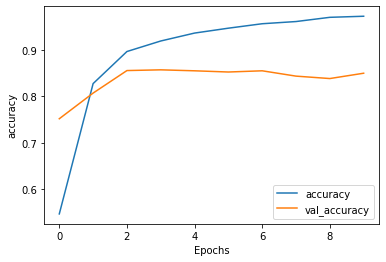

In [29]:
plot_graphs(history, 'accuracy')

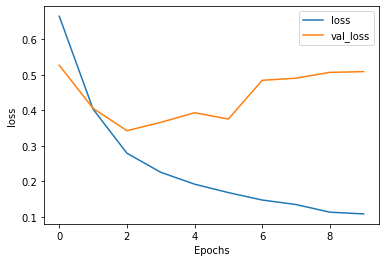

In [30]:
plot_graphs(history, 'loss')

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interestied in building custom RNNs, see the [Keras RNN Guide](../../guide/keras/rnn.ipynb).
